# Preliminary settings
All output files will be appended with shelve_name to distinguish different runs of the notebook.

In [1]:
shelve_name='scipyGlobalOpt_'

If set to 'True', unnecessary evaluations & plots are skipped to facilitate codes development.  

In [2]:
development= False
inspectRate=True

Import libraries

In [3]:
from IPython.display import display
import pandas as pd
from KineticLearning.plot import *
import seaborn as sns
import math

# Empirical metabolomics & proteomics data files

Provide technical replicates for all 9 pathway enzymes & 10 metabolites

In [4]:
##### Metabolite replicates
metaboliteData_Rep1_path='data/timePoints/0rep_0noiseLevel_GMA_2ptPerHr_4strains_METABOLITE.csv.csv'
metaboliteData_Rep2_path='data/timePoints/0rep_0noiseLevel_GMA_2ptPerHr_4strains_METABOLITE.csv.csv'
metaboliteData_Rep3_path='data/timePoints/0rep_0noiseLevel_GMA_2ptPerHr_4strains_METABOLITE.csv.csv'

# Enzyme replicates
enzymeData_Rep1_path='data/timePoints/0rep_0noiseLevel_GMA_2ptPerHr_4strains_ENZYME.csv'
enzymeData_Rep2_path='data/timePoints/0rep_0noiseLevel_GMA_2ptPerHr_4strains_ENZYME.csv'
enzymeData_Rep3_path='data/timePoints/0rep_0noiseLevel_GMA_2ptPerHr_4strains_ENZYME.csv'

# no. datapoints required including augmented ones 

IMPORTANT:

no. datapoints should be in multiples of experimental data points

'hours' should be less than or equal to duration of experiment.


In [5]:
hours=24
datapointsPerhour = 2
numberDataPtsNeeded=hours*datapointsPerhour + 1 # include data for time=0

# Specify molecular participants

Participants must be in same order as their input into subsequent kinetic_model.
Names must be identical to imported empirical data

Machine learning of dynamics

Also required for preprocessing 

In [6]:
controls = ['AtoB', 'HMGS', 'HMGR', 'MK', 'PMK', 'PMD', 'GPPS', 'Idi','Limonene Synthase'] # 9 enzymes
states = ['Acetyl-CoA','Acetoacetyl-CoA','HMG-CoA', 'Mev', 'MevP','MevPP', 'IPP','DMAPP','GPP','Limonene']# 10 metabolites

Empirically measured

In [7]:
measured_enzymes = ['AtoB', 'HMGS', 'HMGR', 'MK', 'PMK', 'PMD', 'GPPS', 'Idi','Limonene Synthase'] # 9 enzymes
measured_substrates = ['Acetyl-CoA','Acetoacetyl-CoA','HMG-CoA', 'Mev', 'MevP','MevPP', 'IPP','DMAPP','GPP','Limonene']#10

# Read in raw enzymes & metabolites datasets
Row multi indices based on strain & time

Column multi indices based on controls (enzymes), states (metabolites), derivatives (rates of net production)

In [8]:
from KineticLearning import read_enzymeRawData,read_metaboliteRawData

# Enzyme replicate data
df_enzymeRaw_Rep1=read_enzymeRawData(enzymeData_Rep1_path,controls,time='Time/hours',strain='Strain')
df_enzymeRaw_Rep2=read_enzymeRawData(enzymeData_Rep2_path,controls,time='Time/hours',strain='Strain')
df_enzymeRaw_Rep3=read_enzymeRawData(enzymeData_Rep3_path,controls,time='Time/hours',strain='Strain')

# Metabolite replicate data
df_metaboliteRaw_Rep1=read_metaboliteRawData(metaboliteData_Rep1_path,states,time='Time/hours',strain='Strain')
df_metaboliteRaw_Rep2=read_metaboliteRawData(metaboliteData_Rep2_path,states,time='Time/hours',strain='Strain')
df_metaboliteRaw_Rep3=read_metaboliteRawData(metaboliteData_Rep3_path,states,time='Time/hours',strain='Strain')

In [9]:
df_metaboliteRaw_Rep1.head()

states                                                \
            Acetyl-CoA Acetoacetyl-CoA   HMG-CoA       Mev      MevP   
Strain Time                                                            
WT     0.0    0.300000        0.200000  0.050000  0.300000  0.020000   
       0.5    0.311761        0.189999  0.061382  0.220293  0.099379   
       1.0    0.317709        0.176455  0.076021  0.183449  0.134574   
       1.5    0.322371        0.162284  0.086404  0.165641  0.152880   
       2.0    0.326734        0.148163  0.087892  0.161313  0.164268   

                                                               
                MevPP       IPP     DMAPP       GPP  Limonene  
Strain Time                                                    
WT     0.0   0.200000  0.010000  0.040000  0.050000  0.000000  
       0.5   0.200554  0.009227  0.039269  0.049266  0.001492  
       1.0   0.203795  0.006931  0.036924  0.049404  0.003708  
       1.5   0.209994  0.005174  0.034993  0.048880  0.006163  
       2.0   0.218527  0.004147  0.033668  0.047666  0.008702

In [10]:
df_metaboliteRaw_Rep2.head()

states                                                \
            Acetyl-CoA Acetoacetyl-CoA   HMG-CoA       Mev      MevP   
Strain Time                                                            
WT     0.0    0.300000        0.200000  0.050000  0.300000  0.020000   
       0.5    0.311761        0.189999  0.061382  0.220293  0.099379   
       1.0    0.317709        0.176455  0.076021  0.183449  0.134574   
       1.5    0.322371        0.162284  0.086404  0.165641  0.152880   
       2.0    0.326734        0.148163  0.087892  0.161313  0.164268   

                                                               
                MevPP       IPP     DMAPP       GPP  Limonene  
Strain Time                                                    
WT     0.0   0.200000  0.010000  0.040000  0.050000  0.000000  
       0.5   0.200554  0.009227  0.039269  0.049266  0.001492  
       1.0   0.203795  0.006931  0.036924  0.049404  0.003708  
       1.5   0.209994  0.005174  0.034993  0.048880  0.006163  
       2.0   0.218527  0.004147  0.033668  0.047666  0.008702

In [11]:
df_metaboliteRaw_Rep3.head()

states                                                \
            Acetyl-CoA Acetoacetyl-CoA   HMG-CoA       Mev      MevP   
Strain Time                                                            
WT     0.0    0.300000        0.200000  0.050000  0.300000  0.020000   
       0.5    0.311761        0.189999  0.061382  0.220293  0.099379   
       1.0    0.317709        0.176455  0.076021  0.183449  0.134574   
       1.5    0.322371        0.162284  0.086404  0.165641  0.152880   
       2.0    0.326734        0.148163  0.087892  0.161313  0.164268   

                                                               
                MevPP       IPP     DMAPP       GPP  Limonene  
Strain Time                                                    
WT     0.0   0.200000  0.010000  0.040000  0.050000  0.000000  
       0.5   0.200554  0.009227  0.039269  0.049266  0.001492  
       1.0   0.203795  0.006931  0.036924  0.049404  0.003708  
       1.5   0.209994  0.005174  0.034993  0.048880  0.006163  
       2.0   0.218527  0.004147  0.033668  0.047666  0.008702

# Average of replicate values

Metabolites

In [12]:
#Stack replicate data on top of each other
df_metaboliteRaw_concat = pd.concat(
    (df_metaboliteRaw_Rep1, 
     df_metaboliteRaw_Rep2, 
     df_metaboliteRaw_Rep3)
)
#df_metaboliteRaw_concat.to_csv('df_metaboliteRaw_concat.csv')

# Create dataframe from average of 3 replicates
df_metaboliteRaw = df_metaboliteRaw_concat.groupby(['Strain','Time']).mean()
#df_metaboliteRaw.to_csv('metabolite_average.csv')

df_metaboliteRaw.head()

states                                                \
              Acetyl-CoA Acetoacetyl-CoA   HMG-CoA       Mev      MevP   
Strain   Time                                                            
Strain 1 0.0    0.300000        0.200000  0.050000  0.300000  0.020000   
         0.5    0.299893        0.188541  0.068037  0.218933  0.100735   
         1.0    0.288190        0.174077  0.089557  0.183997  0.136357   
         1.5    0.274398        0.158853  0.093482  0.179006  0.157845   
         2.0    0.260551        0.143504  0.080676  0.188562  0.178523   

                                                                 
                  MevPP       IPP     DMAPP       GPP  Limonene  
Strain   Time                                                    
Strain 1 0.0   0.200000  0.010000  0.040000  0.050000  0.000000  
         0.5   0.200543  0.009250  0.039268  0.049773  0.000986  
         1.0   0.203716  0.007056  0.036890  0.050678  0.002468  
         1.5   0.209860  0.005463  0.034856  0.051042  0.004139  
         2.0   0.219000  0.004525  0.033388  0.050751  0.005898

Enzymes

In [13]:
#Stack replicate data on top of each other
df_enzymeRaw_concat = pd.concat(
    (df_enzymeRaw_Rep1, 
     df_enzymeRaw_Rep2, 
     df_enzymeRaw_Rep3)
)

# Create dataframe from average of 3 replicates
df_enzymeRaw = df_enzymeRaw_concat.groupby(['Strain','Time']).mean()
df_enzymeRaw.head()

controls                                             \
                       AtoB          HMGS           HMGR            MK   
Strain   Time                                                            
Strain 1 0.0   5.946962e+01  3.973013e+01      36.968921  5.762279e+01   
         0.5   5.471875e+06  3.482933e+06  339448.988190  2.217158e+06   
         1.0   6.072640e+06  4.609864e+06  474068.251127  3.097868e+06   
         1.5   6.303323e+06  5.167157e+06  546287.047997  3.570656e+06   
         2.0   6.425365e+06  5.499584e+06  591328.783707  3.865639e+06   

                                                                       \
                        PMK           PMD          GPPS           Idi   
Strain   Time                                                           
Strain 1 0.0   2.659959e+01  5.448132e+01  5.547215e+01  1.868778e+01   
         0.5   7.241324e+05  3.761395e+06  3.265182e+06  6.399929e+05   
         1.0   9.847275e+05  5.509792e+06  3.743605e+06  8.490980e+05   
         1.5   1.118956e+06  6.520026e+06  3.935836e+06  9.528769e+05   
         2.0   1.200797e+06  7.178087e+06  4.039549e+06  1.014899e+06   

                                 
              Limonene Synthase  
Strain   Time                    
Strain 1 0.0          30.341080  
         0.5      286614.273964  
         1.0      398139.231561  
         1.5      457478.291179  
         2.0      494315.467226

In [14]:
# # Testing
# from KineticLearning import read_metaboliteRawData
# import pandas as pd
# states = ['Acetyl-CoA','Acetoacetyl-CoA','HMG-CoA', 'Mev', 'MevP','MevPP', 'IPP','DMAPP','GPP','Limonene']# 10 metabolites
# metaboliteData_Rep1_path='data/rep_1_TEST.csv'
# metaboliteData_Rep2_path='data/rep_2_TEST.csv'
# metaboliteData_Rep3_path='data/rep_3_TEST.csv'
# df_metaboliteRaw_Rep1=read_metaboliteRawData(metaboliteData_Rep1_path,states,time='Time/hours',strain='Strain')
# df_metaboliteRaw_Rep2=read_metaboliteRawData(metaboliteData_Rep2_path,states,time='Time/hours',strain='Strain')
# df_metaboliteRaw_Rep3=read_metaboliteRawData(metaboliteData_Rep3_path,states,time='Time/hours',strain='Strain')

# #Stack replicate data on top of each other
# df_metaboliteRaw_concat = pd.concat(
#     (df_metaboliteRaw_Rep1, 
#      df_metaboliteRaw_Rep2, 
#      df_metaboliteRaw_Rep3)
# )
# df_metaboliteRaw_concat.to_csv('df_TEST_concat.csv')

# # Create dataframe from average of 3 replicates
# df_metaboliteRaw = df_metaboliteRaw_concat.groupby(['Strain','Time']).mean()
# df_metaboliteRaw.to_csv('TEST_average.csv')

# Read strain list from enzyme data file

In [15]:
strainList=[]
for strain in df_enzymeRaw.index:
    if strain[0] not in strainList:
        strainList.append(strain[0])
print ('List of ' +str(len(strainList)) + ' strains read in.')

List of 4 strains read in.


# Assess missing data

In [16]:
from KineticLearning import NaN_table

if development==True:
    pass
else:
    # generate NaN summary table
    print('Enzymes:')
    df_NaN_enzymeRaw=NaN_table(df_enzymeRaw) # enzymes
    print('\nMetabolites:')
    df_NaN_metaboliteRaw=NaN_table(df_metaboliteRaw) # metabolites

    #display tables
    display(df_NaN_enzymeRaw) # enzymes
    df_enzymeRaw.head()
    display(df_NaN_metaboliteRaw) # metabolites
    df_metaboliteRaw.head()

Enzymes:
Your selected dataframe has 9 columns.
There are 0 columns that have missing values.

Metabolites:
Your selected dataframe has 10 columns.
There are 0 columns that have missing values.


Empty DataFrame
Columns: [Missing Values, % of Total Values]
Index: []

Empty DataFrame
Columns: [Missing Values, % of Total Values]
Index: []

# Impute missing data

In [17]:
df_metaboliteImputed = df_metaboliteRaw.groupby('Strain').apply(lambda group: group.interpolate()) # metabolites
df_enzymeImputed = df_enzymeRaw.groupby('Strain').apply(lambda group: group.interpolate()) # enzymes

# Assess effect of imputation on missing data

In [18]:
from KineticLearning import compareTimeSeriesAfterPreprocess

if development==True:
    pass
else:
    # generate NaN summary table
    print('Metabolites data:')
    df_NaN_metaboliteImputed=NaN_table(df_metaboliteImputed)
    print('\nEnzymes data:')
    df_NaN_enzymeImputed=NaN_table(df_enzymeImputed)
    
    # display(df_metaboliteImputed)
    
    #print ('\n----------------------------------------------------\nMetabolites plots before & after imputation:\n')
    #compareTimeSeriesAfterPreprocess(df_metaboliteRaw,df_metaboliteImputed,'states',
    #                             strainList,preprocessLabel='After Imputation')

    # display(df_enzymeImputed)

Metabolites data:
Your selected dataframe has 10 columns.
There are 0 columns that have missing values.

Enzymes data:
Your selected dataframe has 9 columns.
There are 0 columns that have missing values.


# Smoothen & augment data using non-parametric approach

M-spline method is used.

In [19]:
from KineticLearning import smoothenTimeSeries2

# Metabolites
df_metaboliteSmooth=smoothenTimeSeries2('states',df_metaboliteImputed,strainList,numberDataPtsNeeded,
                               cubicSpline=True)
# Enzymes
df_enzymeSmooth=smoothenTimeSeries2('controls',df_enzymeImputed,strainList,numberDataPtsNeeded,
                               cubicSpline=True)

# Inspect outcome of data smoothening & augmentation 

metabolites

Strain Strain 1


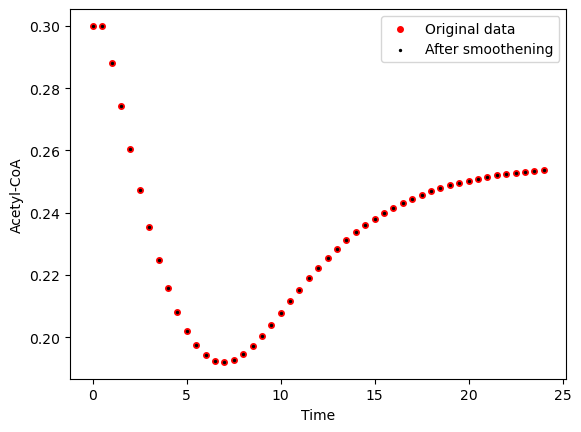

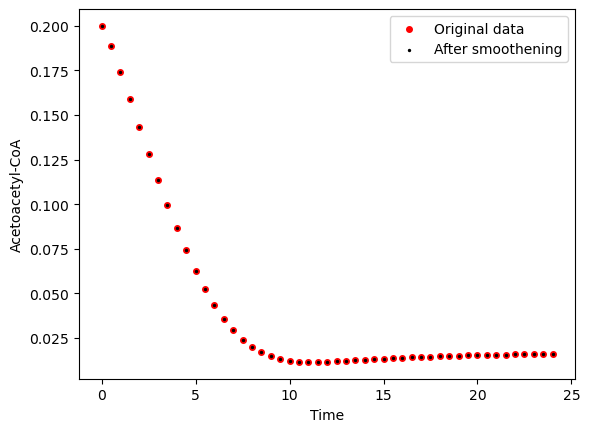

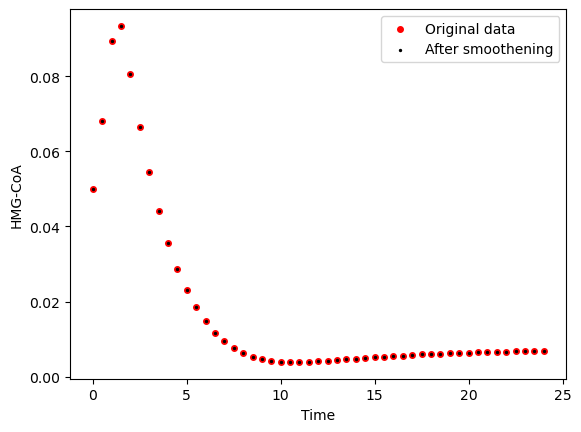

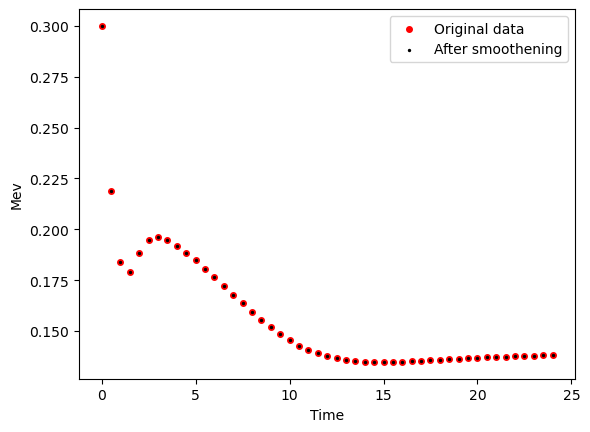

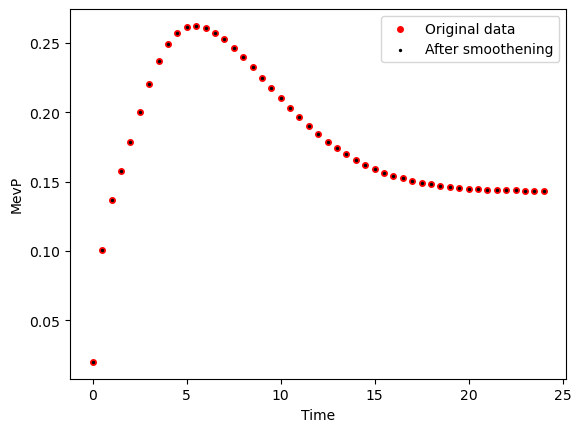

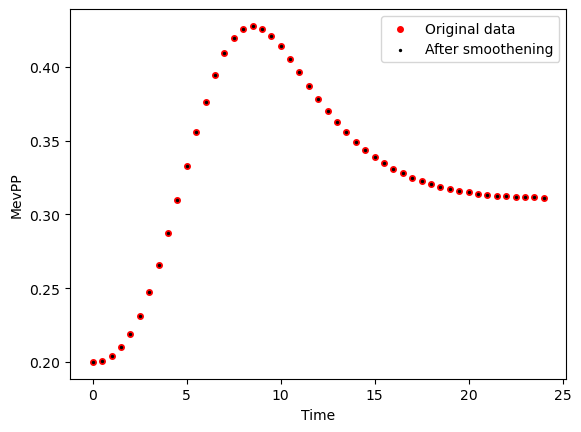

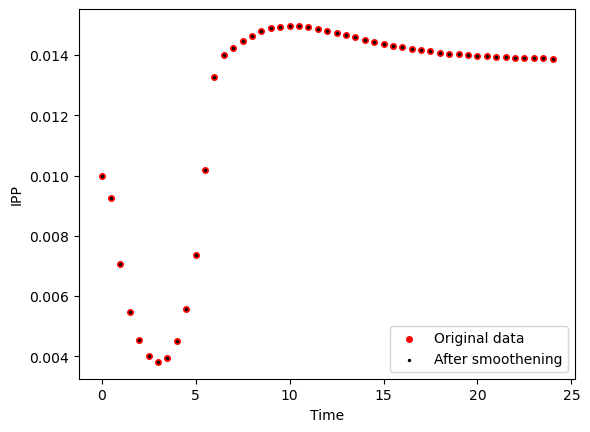

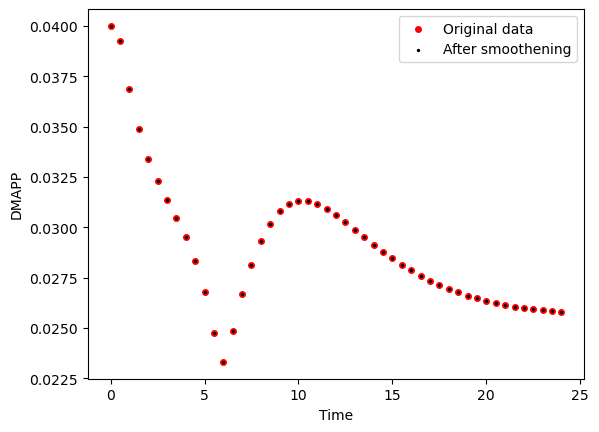

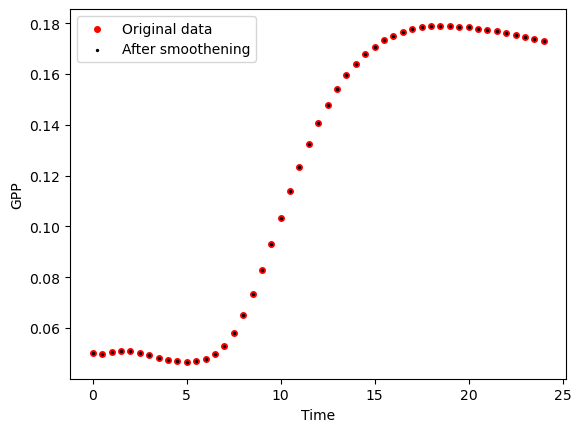

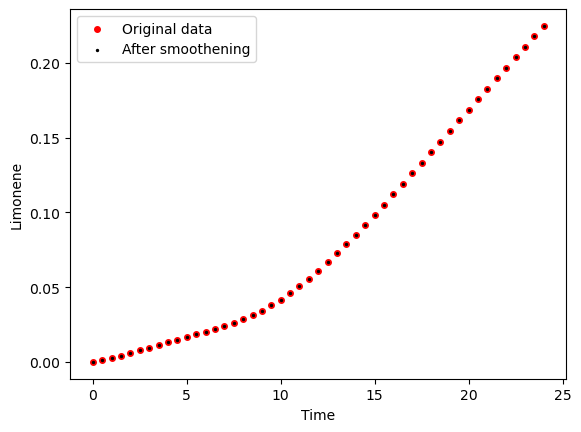

Strain Strain 2


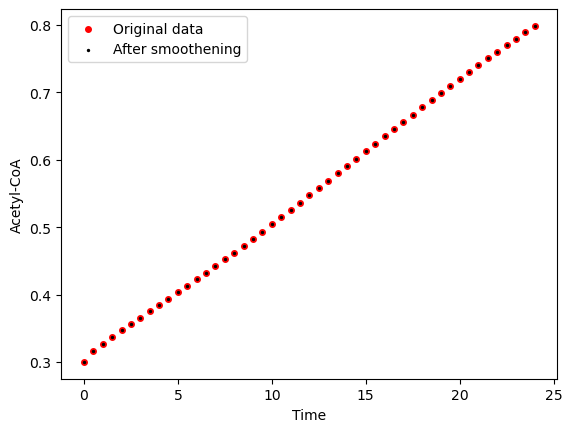

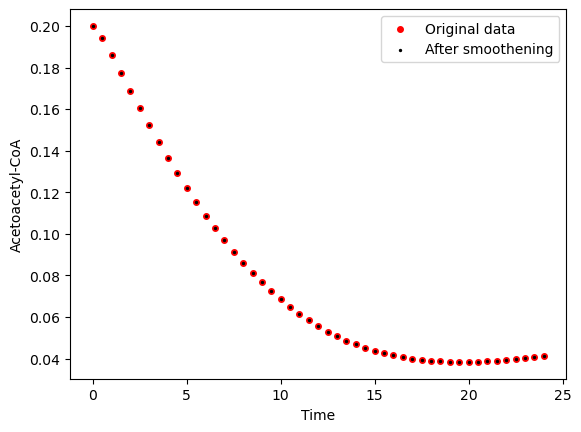

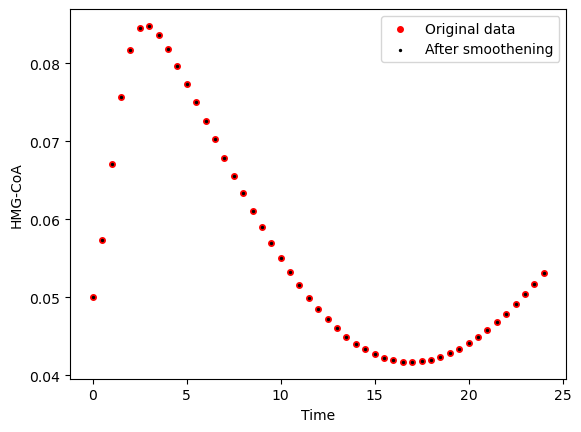

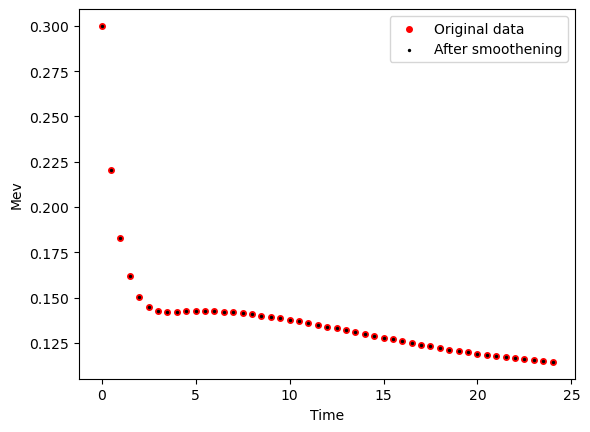

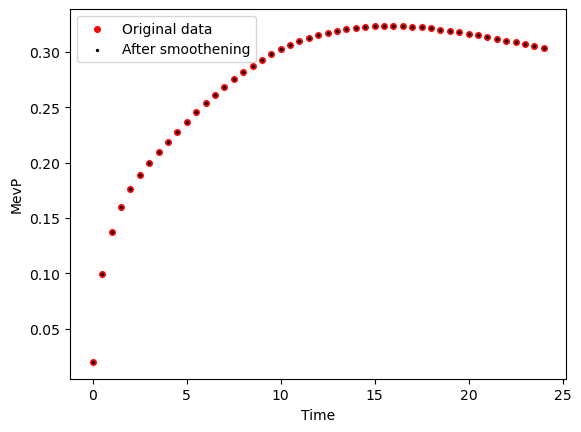

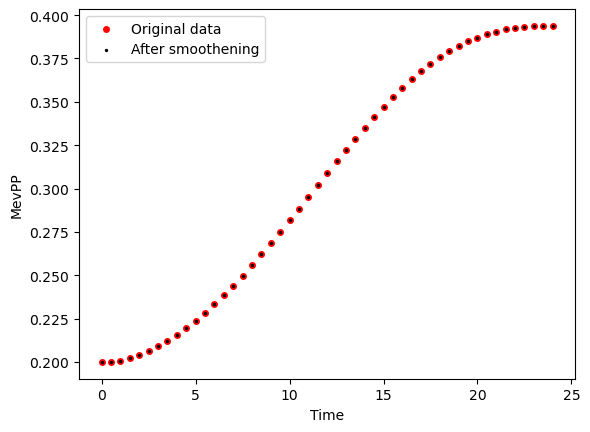

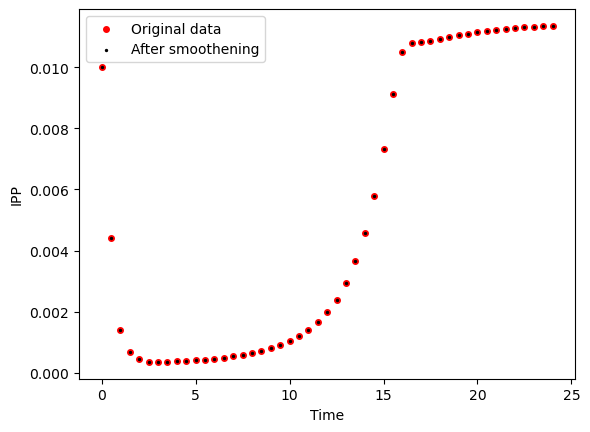

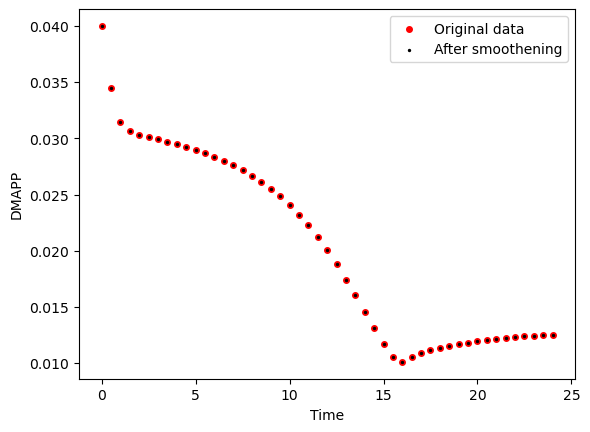

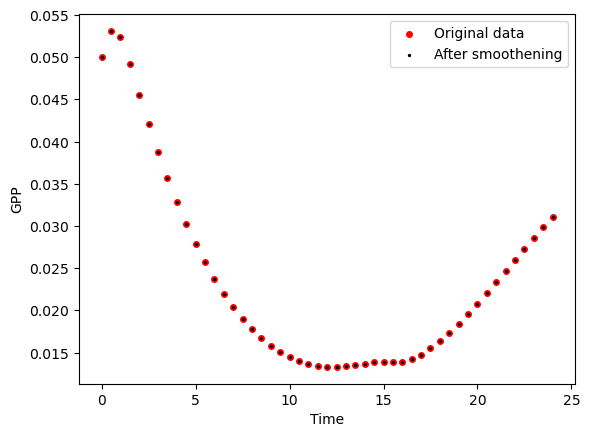

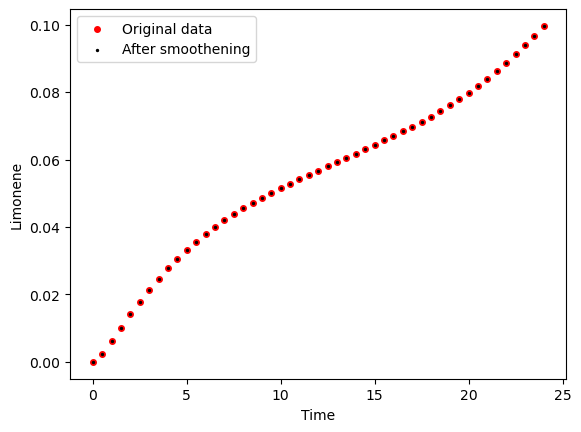

Strain Strain 3


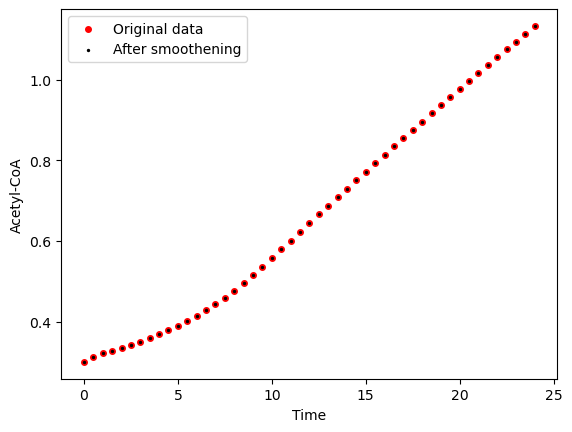

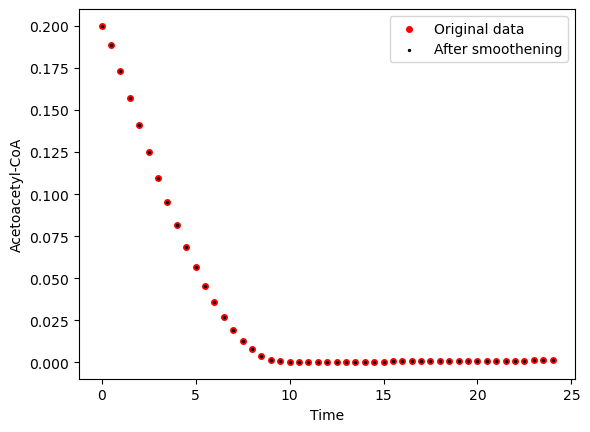

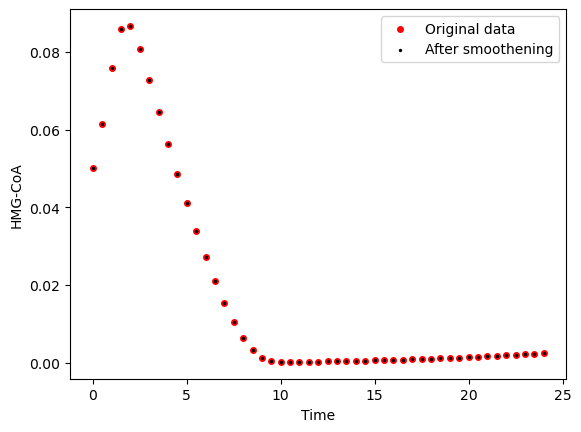

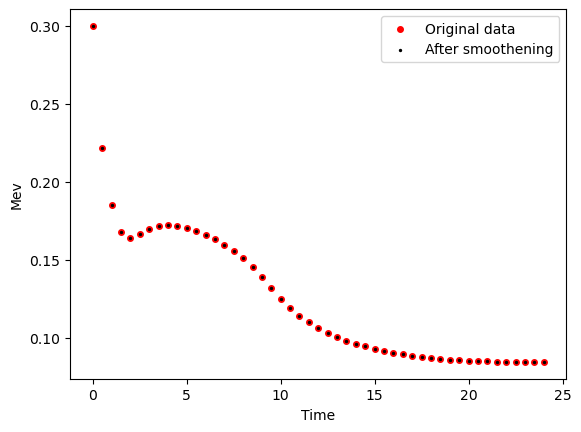

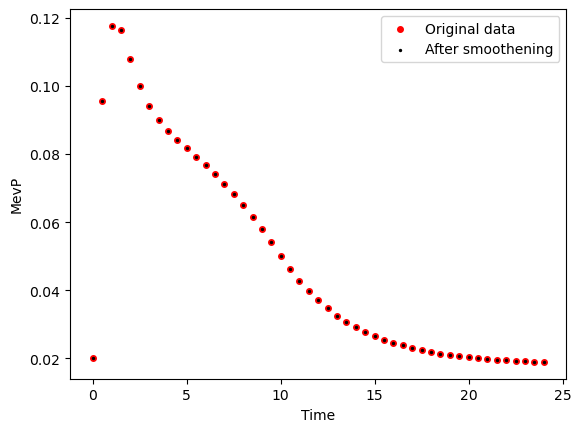

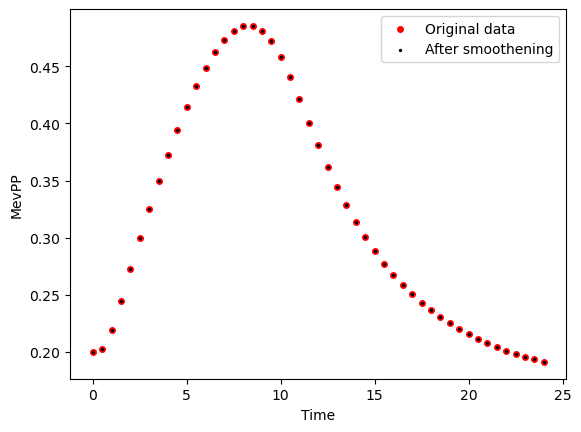

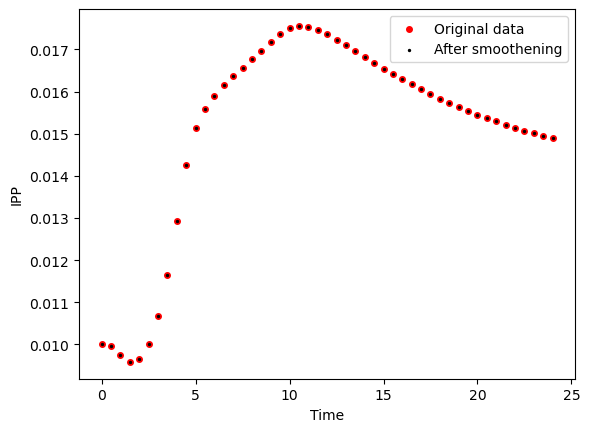

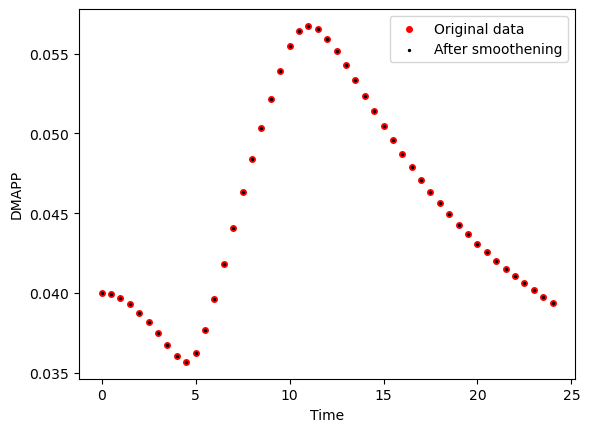

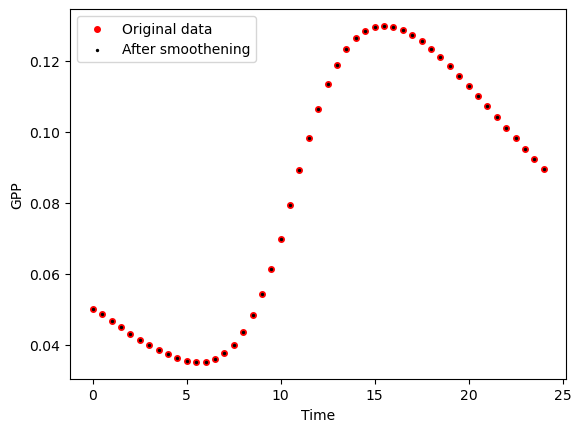

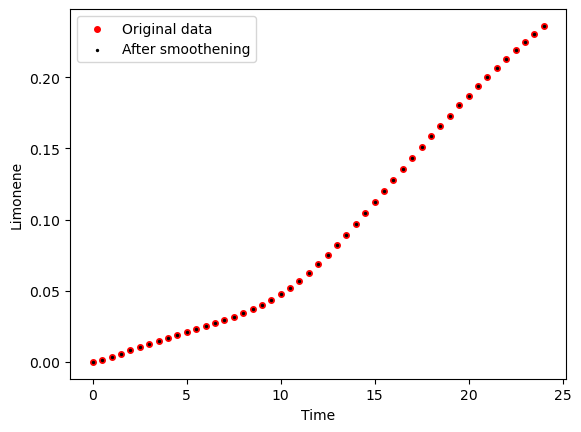

Strain WT


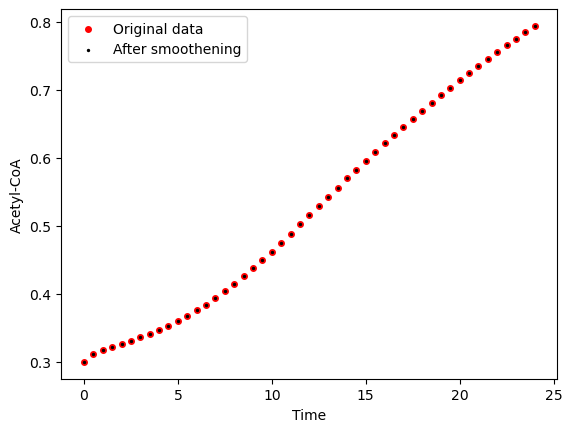

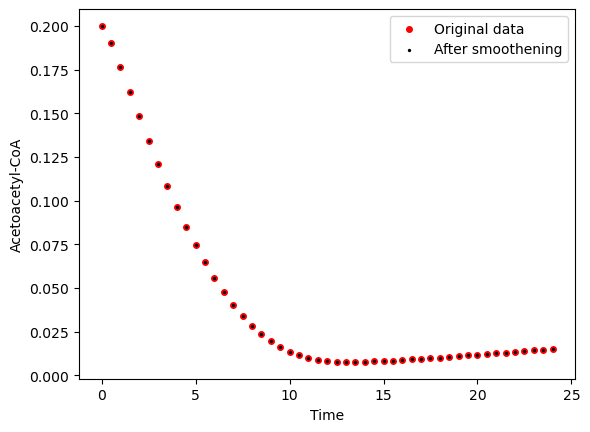

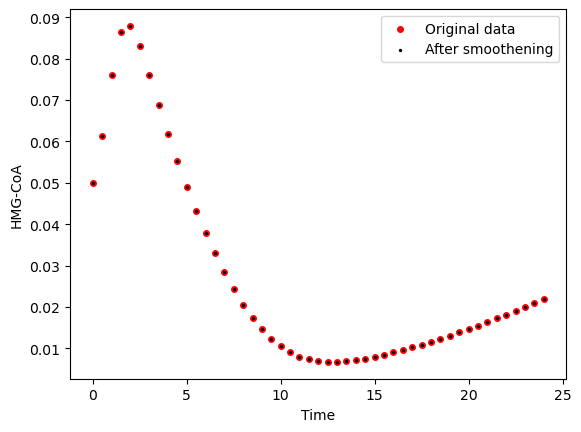

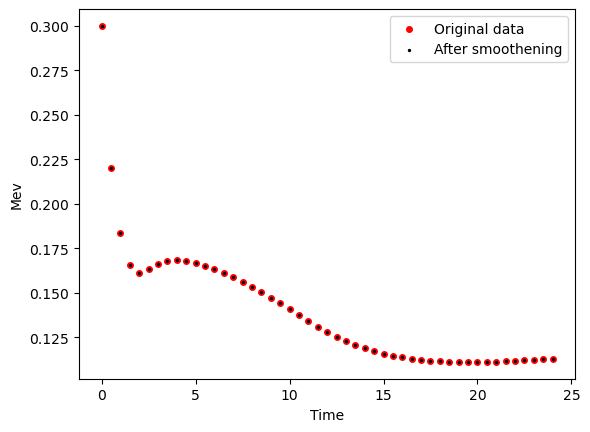

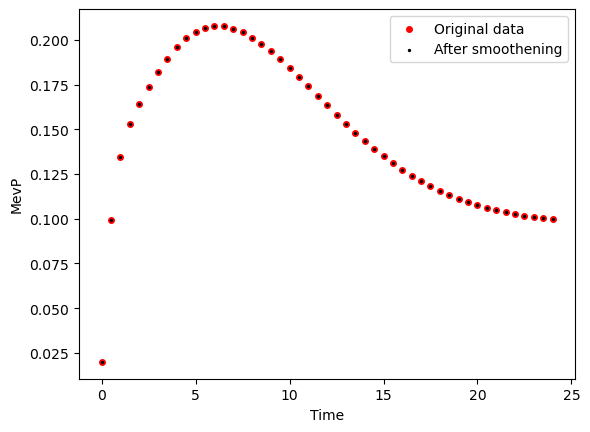

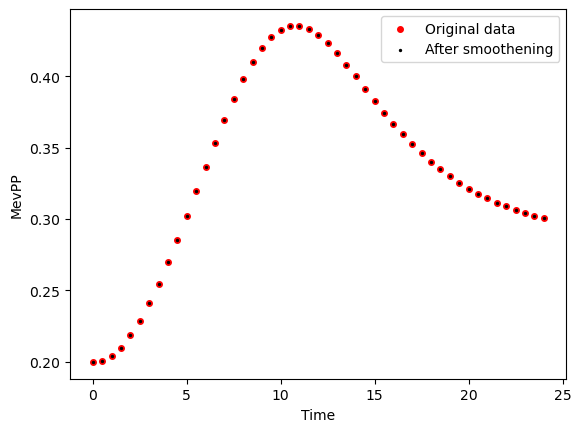

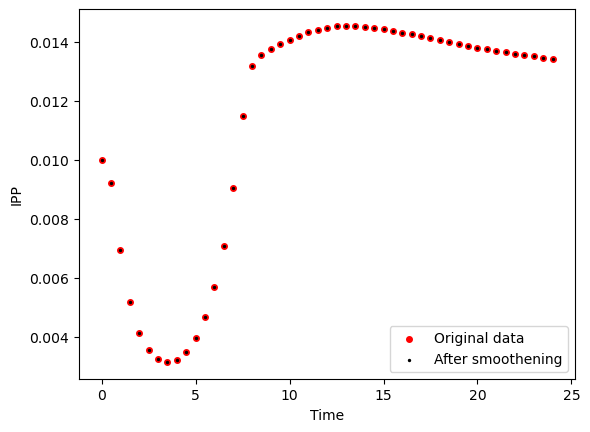

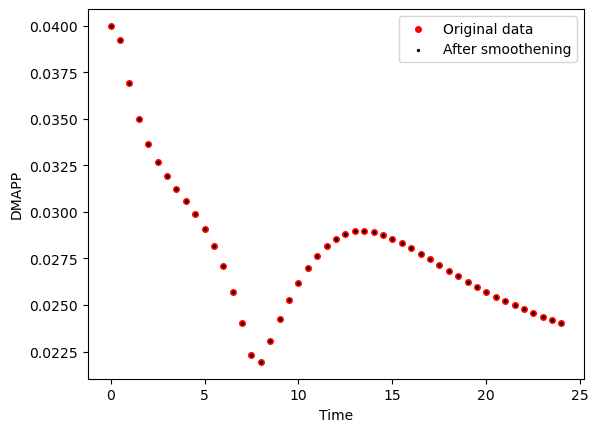

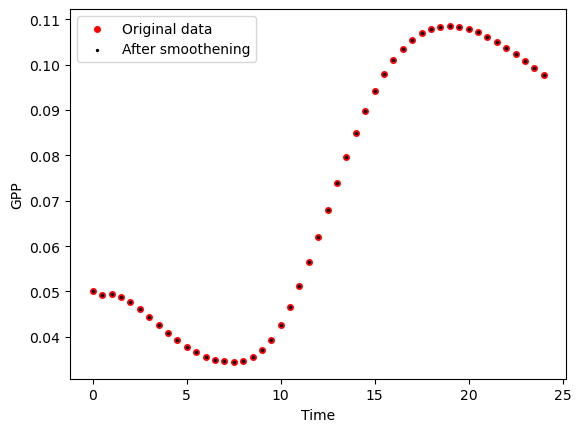

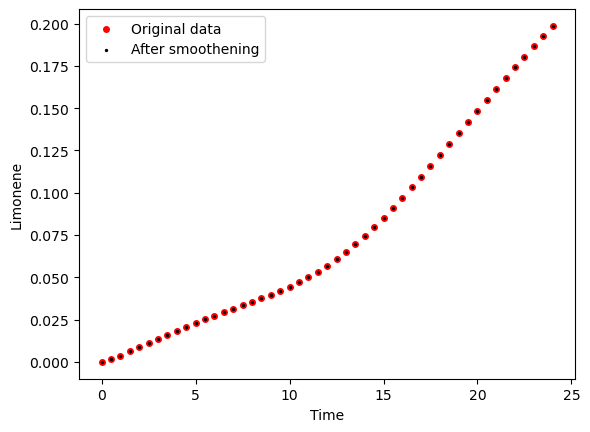

In [20]:
if development==True:
    pass
else:
    compareTimeSeriesAfterPreprocess(df_metaboliteRaw,df_metaboliteSmooth,'states',
                                 strainList,preprocessLabel='After smoothening')

enzymes

Strain Strain 1


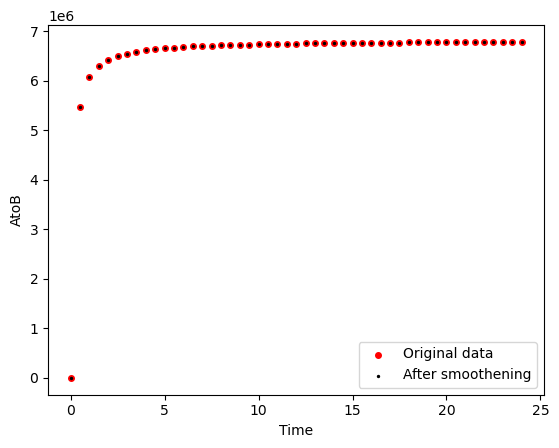

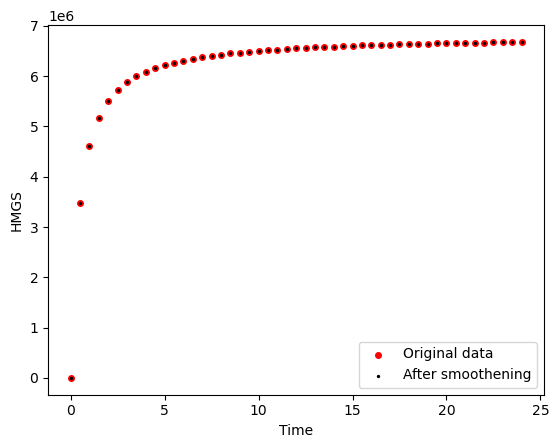

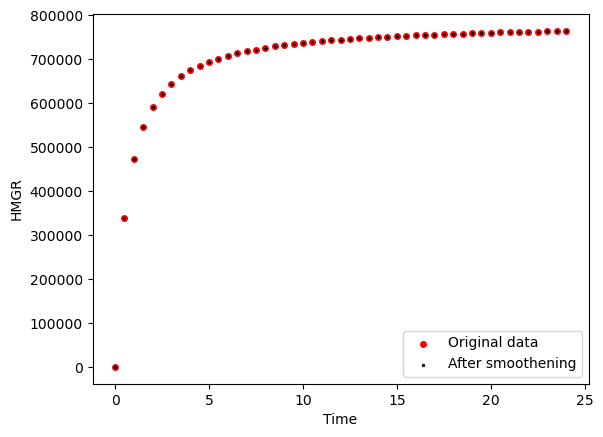

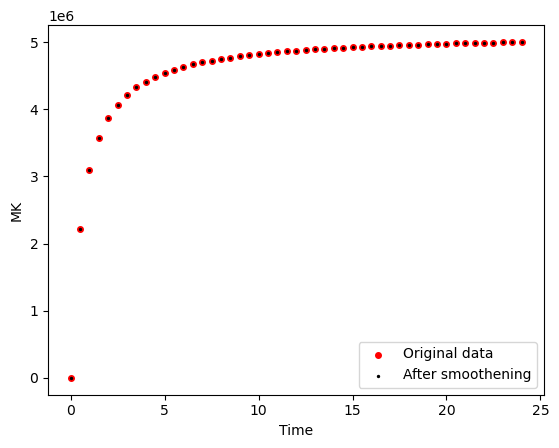

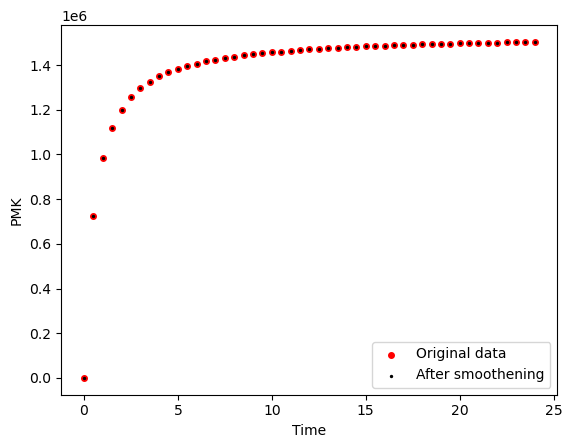

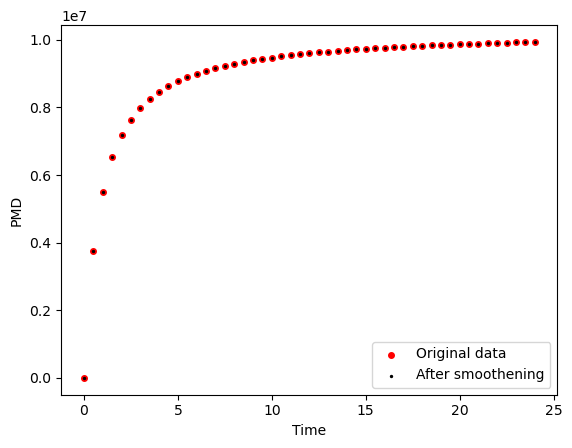

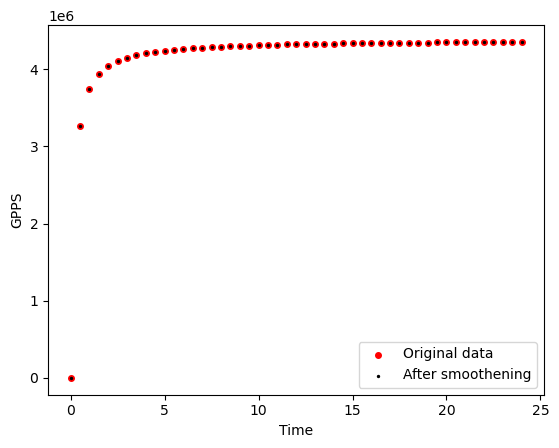

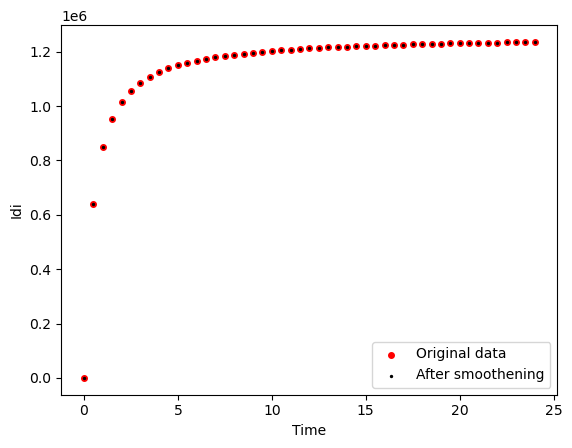

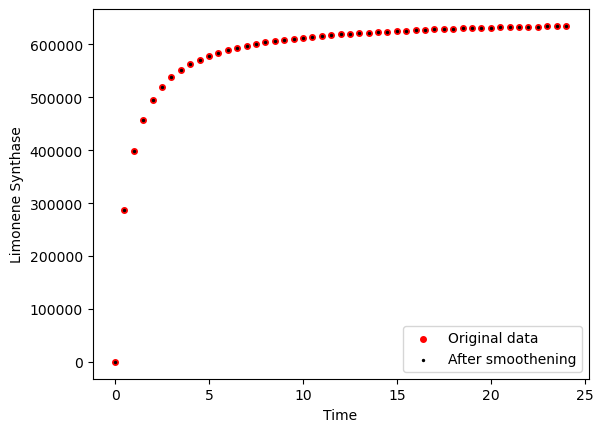

Strain Strain 2


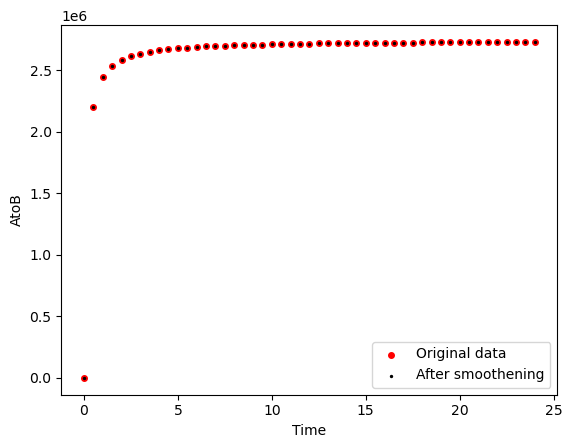

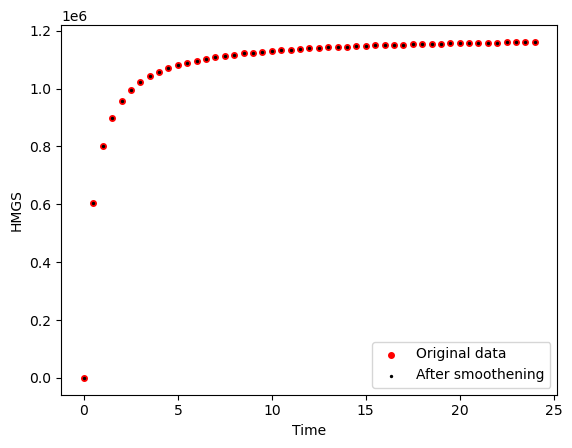

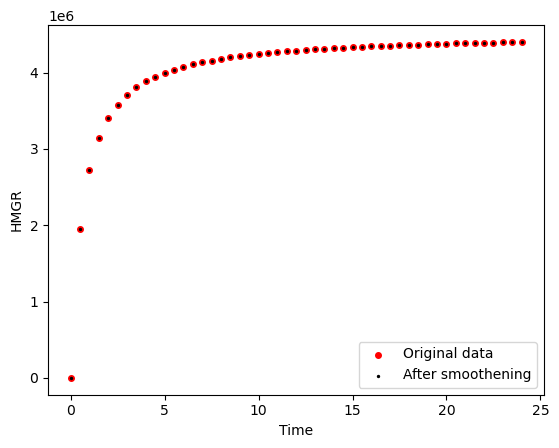

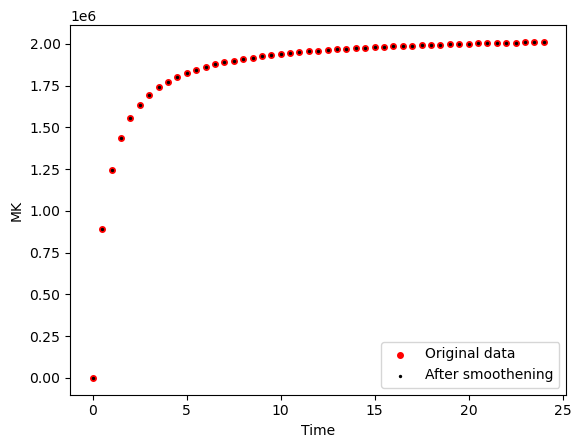

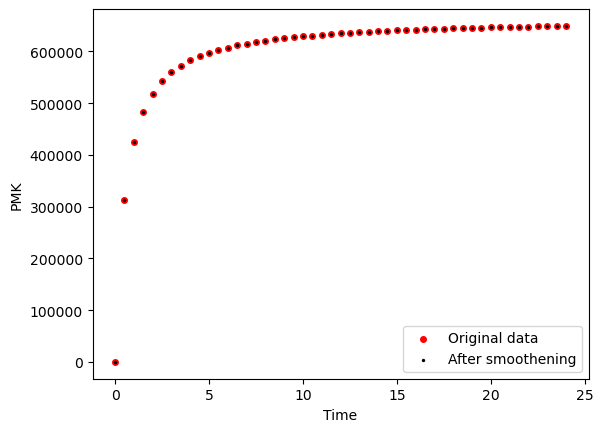

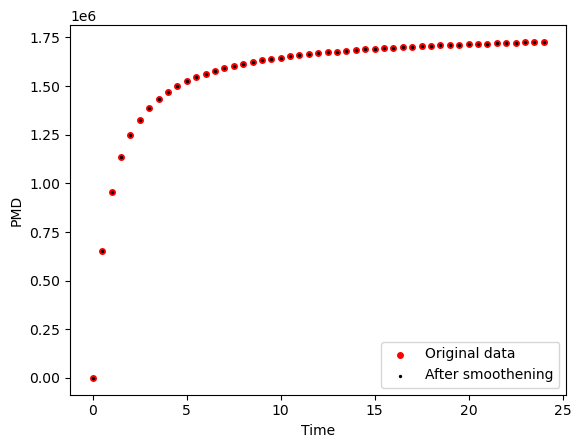

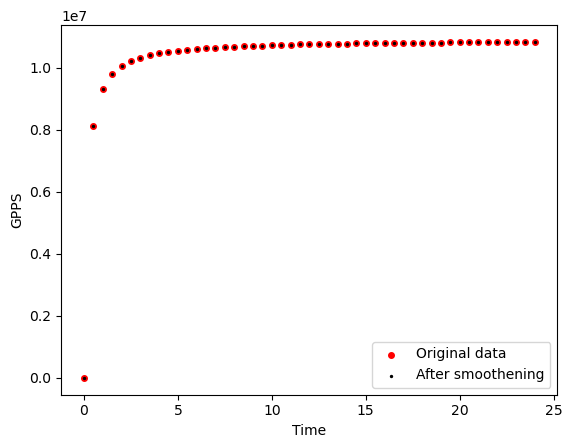

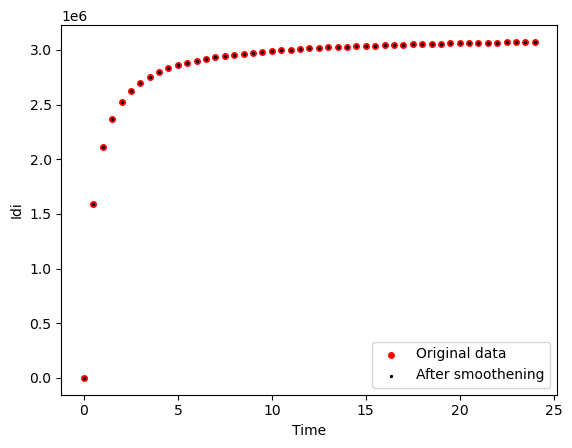

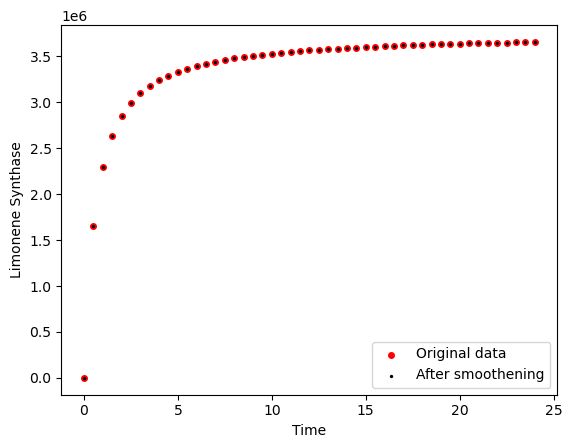

Strain Strain 3


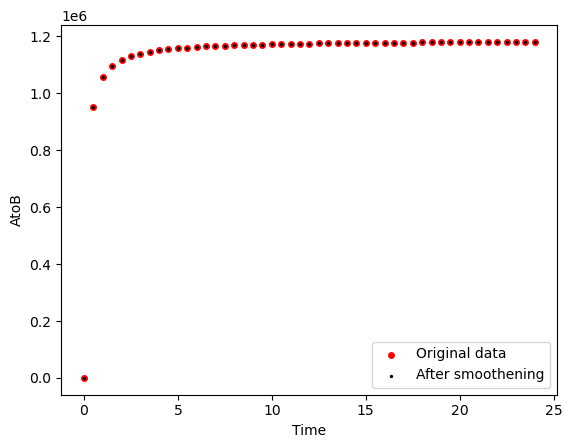

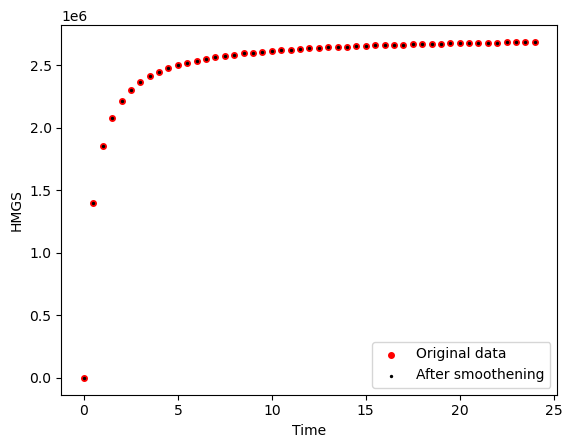

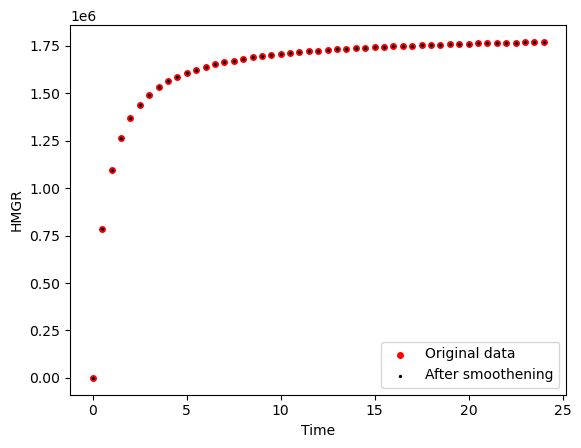

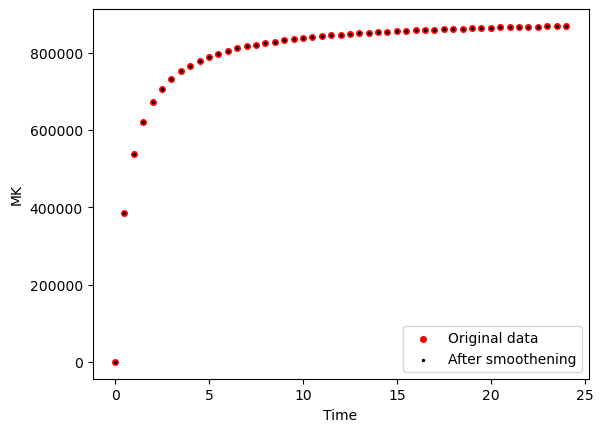

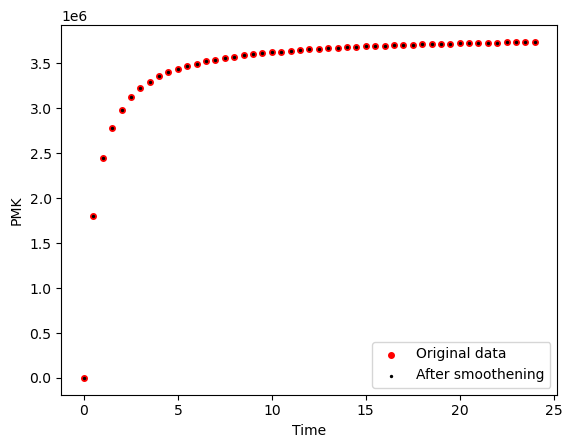

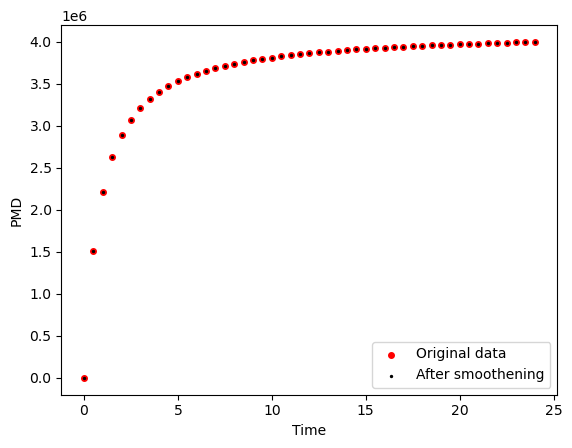

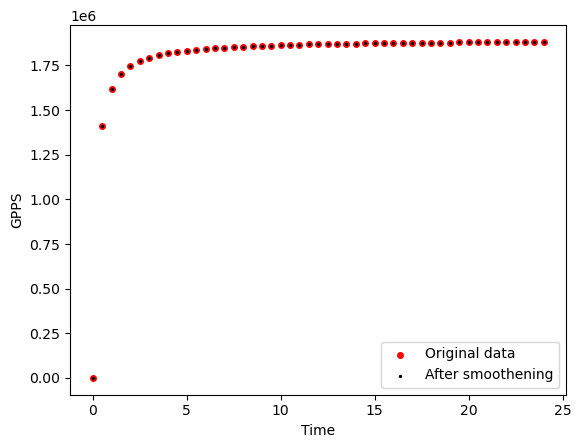

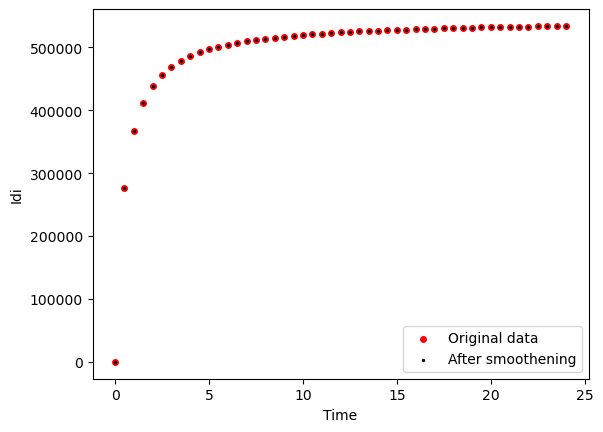

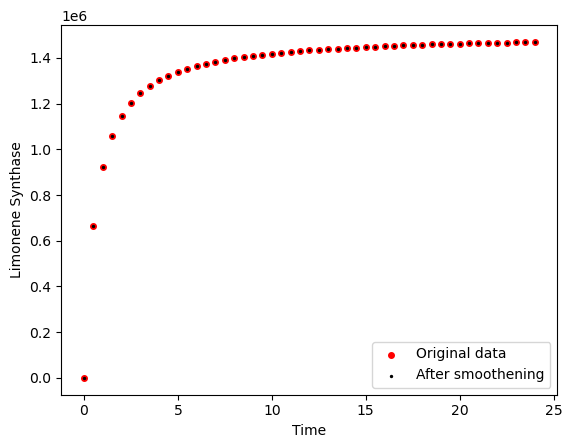

Strain WT


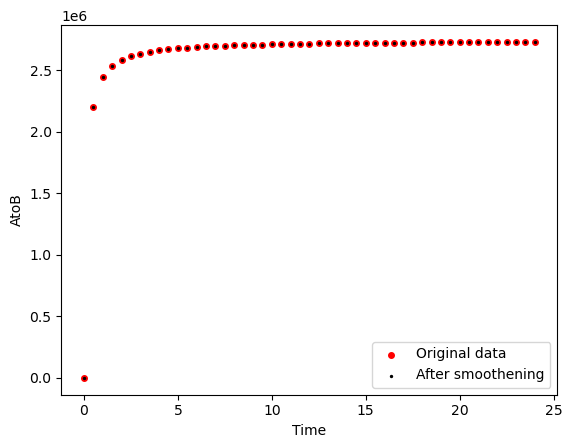

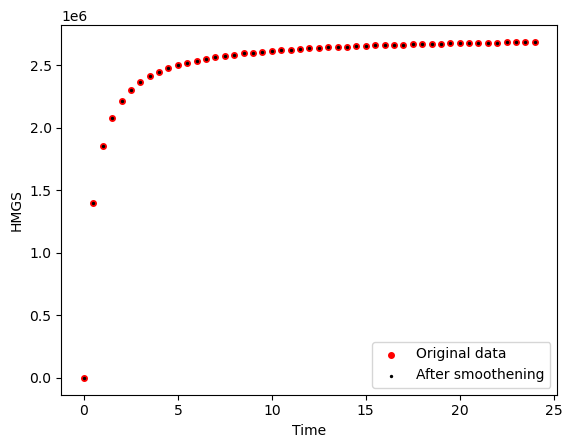

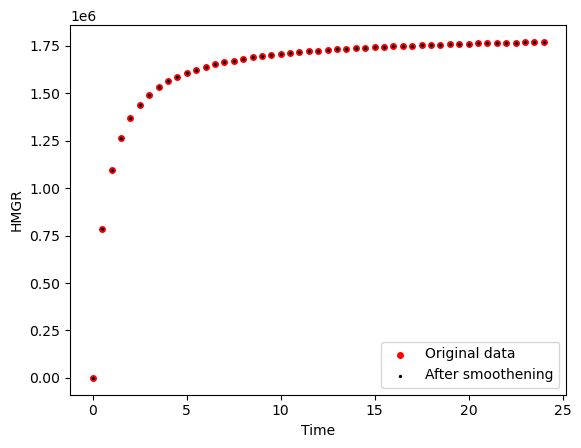

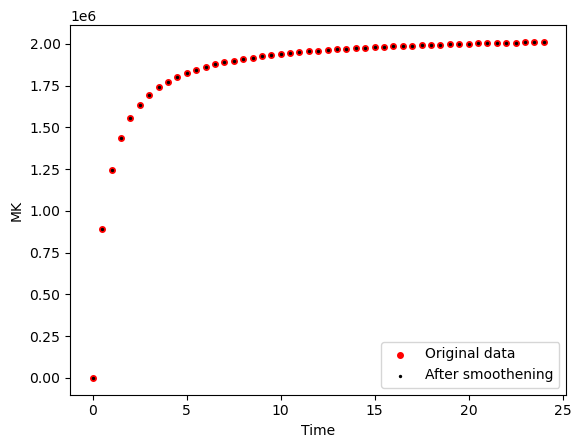

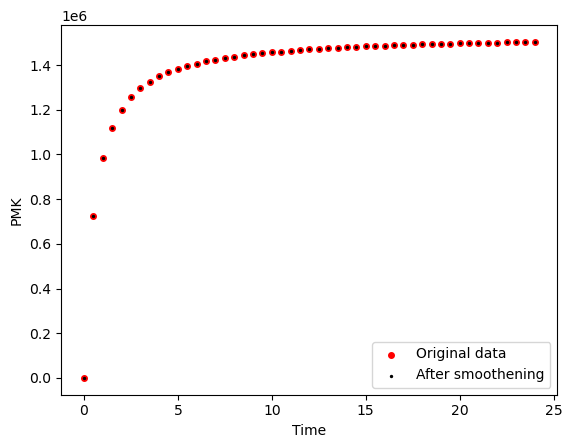

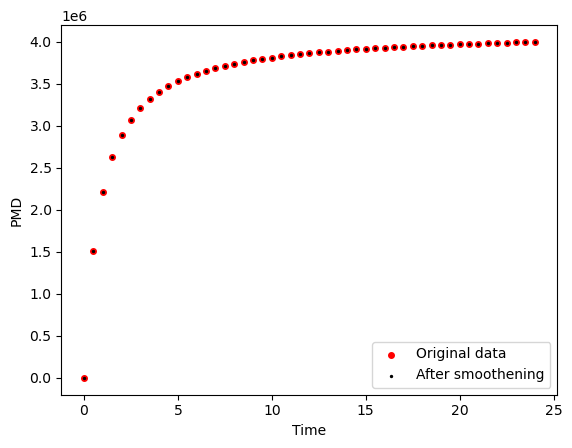

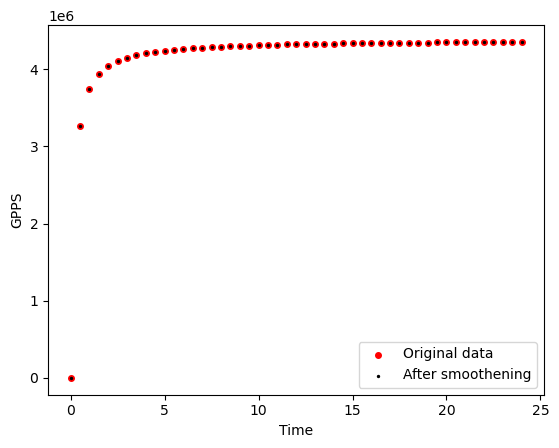

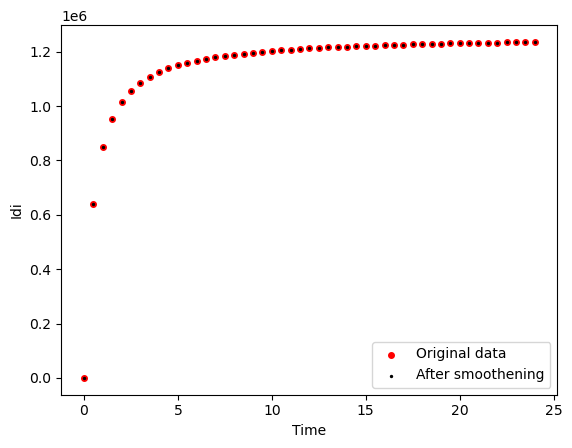

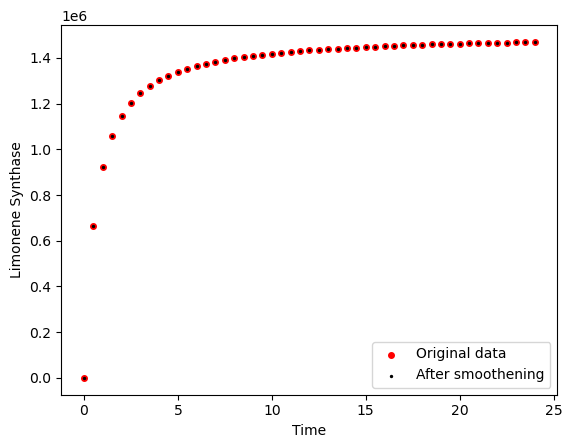

In [21]:
if development==True:
    pass
else:
    compareTimeSeriesAfterPreprocess(df_enzymeRaw,df_enzymeSmooth,'controls',
                                 strainList,preprocessLabel='After smoothening')

# Combine metabolites & enzymes dataframes

In [22]:
df_allSmooth=pd.concat([df_metaboliteSmooth,df_enzymeSmooth],axis=1)

if development==True:
    pass
else:
    df_allSmooth.head()

# Compute rate of reaction

In [23]:
from KineticLearning import estimate_state_derivative73

df_allSmooth=estimate_state_derivative73(df_allSmooth)

if development==True:
    pass
else:
    display(df_allSmooth) #new
    df_allSmooth.to_csv(shelve_name + '_df_allSmooth.csv')

states                                                \
              Acetyl-CoA Acetoacetyl-CoA   HMG-CoA       Mev      MevP   
Strain   Time                                                            
Strain 1 0.0    0.300000        0.200000  0.050000  0.300000  0.020000   
         0.5    0.299893        0.188541  0.068037  0.218933  0.100735   
         1.0    0.288190        0.174077  0.089557  0.183997  0.136357   
         1.5    0.274398        0.158853  0.093482  0.179006  0.157845   
         2.0    0.260551        0.143504  0.080676  0.188562  0.178523   
...                  ...             ...       ...       ...       ...   
WT       22.0   0.755407        0.013340  0.018112  0.111883  0.102630   
         22.5   0.765314        0.013753  0.019019  0.112124  0.101762   
         23.0   0.775039        0.014167  0.019944  0.112389  0.101024   
         23.5   0.784584        0.014581  0.020886  0.112676  0.100406   
         24.0   0.793953        0.014996  0.021843  0.112979  0.099897   

                                                                 ...  \
                  MevPP       IPP     DMAPP       GPP  Limonene  ...   
Strain   Time                                                    ...   
Strain 1 0.0   0.200000  0.010000  0.040000  0.050000  0.000000  ...   
         0.5   0.200543  0.009250  0.039268  0.049773  0.000986  ...   
         1.0   0.203716  0.007056  0.036890  0.050678  0.002468  ...   
         1.5   0.209860  0.005463  0.034856  0.051042  0.004139  ...   
         2.0   0.219000  0.004525  0.033388  0.050751  0.005898  ...   
...                 ...       ...       ...       ...       ...  ...   
WT       22.0  0.308770  0.013585  0.024759  0.103766  0.174178  ...   
         22.5  0.306400  0.013541  0.024553  0.102364  0.180419  ...   
         23.0  0.304296  0.013499  0.024360  0.100867  0.186575  ...   
         23.5  0.302440  0.013460  0.024180  0.099296  0.192639  ...   
         24.0  0.300814  0.013424  0.024011  0.097670  0.198608  ...   

              derivatives                                                \
               Acetyl-CoA Acetoacetyl-CoA   HMG-CoA       Mev      MevP   
Strain   Time                                                             
Strain 1 0.0     0.003492       -0.021533  0.068282 -0.211321  0.178788   
         0.5    -0.012643       -0.026167  0.038730 -0.110383  0.112107   
         1.0    -0.023589       -0.029322  0.014092 -0.037507  0.064958   
         1.5    -0.029345       -0.030998 -0.005633  0.007307  0.037341   
         2.0    -0.027331       -0.030617 -0.026914  0.017786  0.040362   
...                   ...             ...       ...       ...       ...   
WT       22.0    0.019998        0.000825  0.001796  0.000453 -0.001872   
         22.5    0.019630        0.000827  0.001832  0.000508 -0.001602   
         23.0    0.019269        0.000828  0.001867  0.000554 -0.001353   
         23.5    0.018914        0.000829  0.001899  0.000591 -0.001124   
         24.0    0.018565        0.000828  0.001930  0.000618 -0.000915   

                                                                 
                  MevPP       IPP     DMAPP       GPP  Limonene  
Strain   Time                                                    
Strain 1 0.0  -0.001573 -0.002269 -0.001983  0.000353  0.001694  
         0.5   0.003675 -0.003001 -0.003208  0.000738  0.002505  
         1.0   0.009271 -0.003204 -0.003821  0.000731  0.003103  
         1.5   0.015214 -0.002876 -0.003819  0.000331  0.003487  
         2.0   0.021619 -0.001475 -0.002599 -0.000977  0.003575  
...                 ...       ...       ...       ...       ...  
WT       22.0 -0.005021 -0.000092 -0.000424 -0.002691  0.012565  
         22.5 -0.004467 -0.000086 -0.000399 -0.002906  0.012399  
         23.0 -0.003951 -0.000080 -0.000374 -0.003079  0.012223  
         23.5 -0.003476 -0.000075 -0.000349 -0.003204  0.012035  
         24.0 -0.003041 -0.000069 -0.000325 -0.003283  0.011835

# Inspect quality of reaction rates

Check if derivatives are reliable enough to regenerate metabolite time profiles.

'Time profile from derivative vs. actual profile for Strain 1'

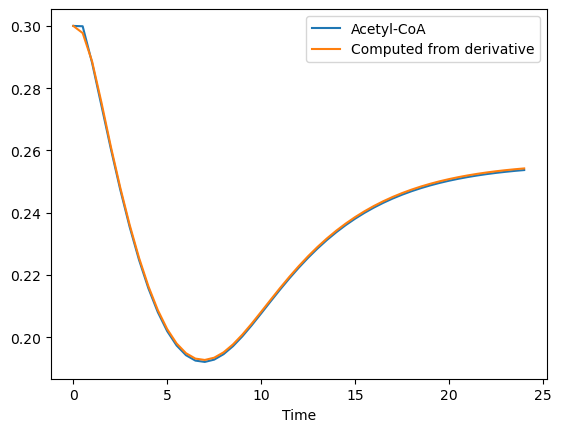

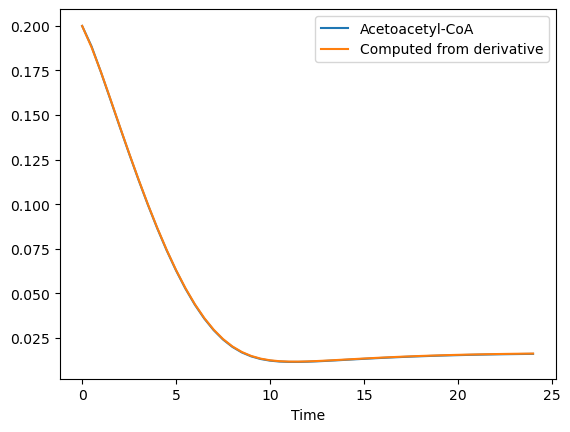

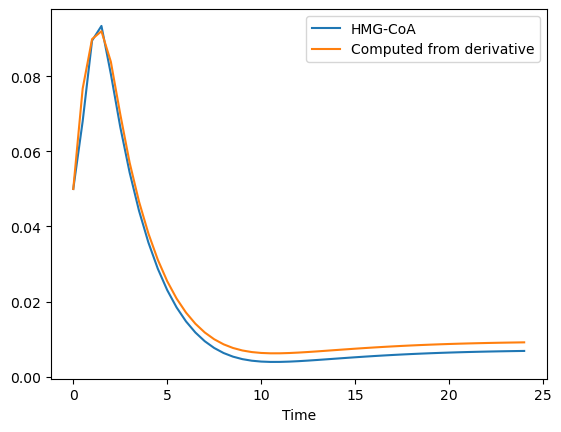

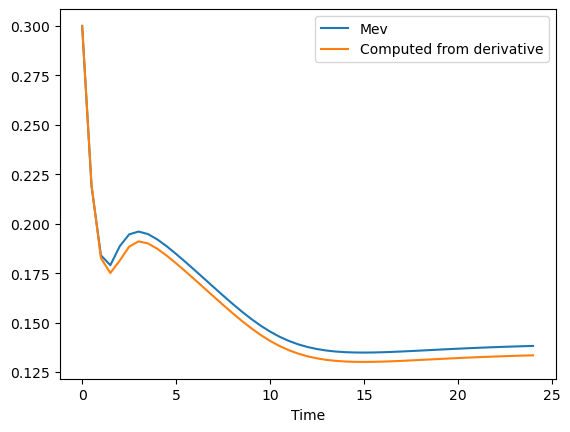

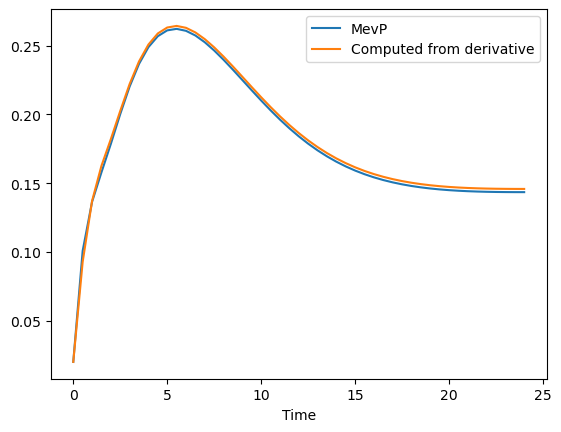

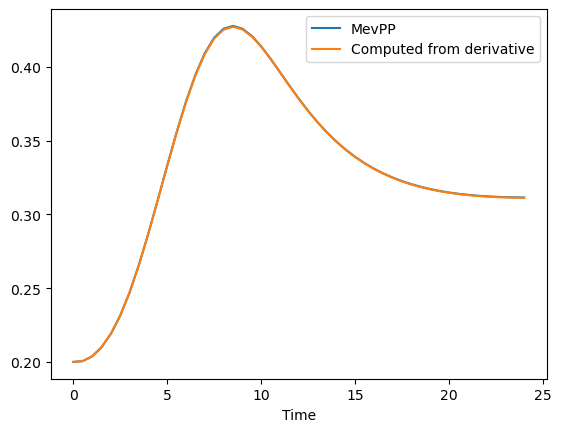

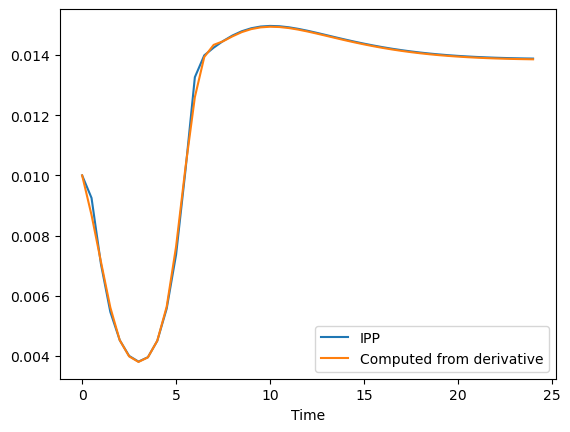

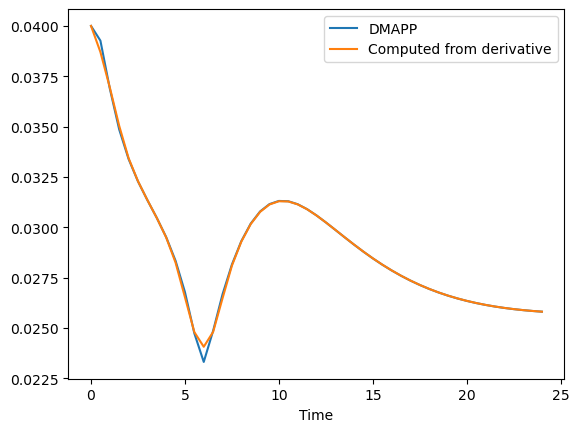

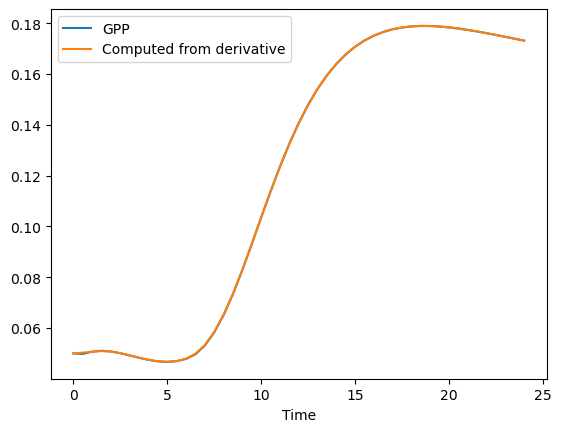

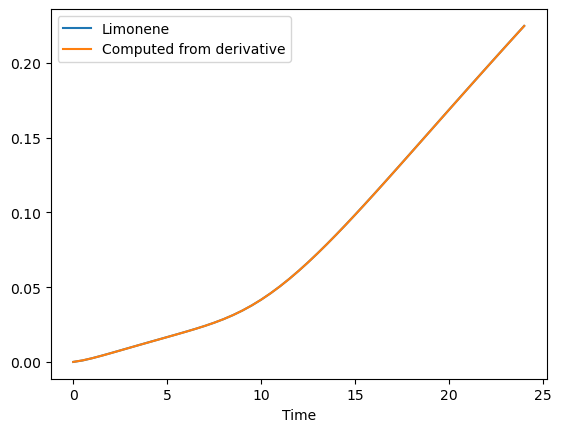

'Time profile from derivative vs. actual profile for Strain 2'

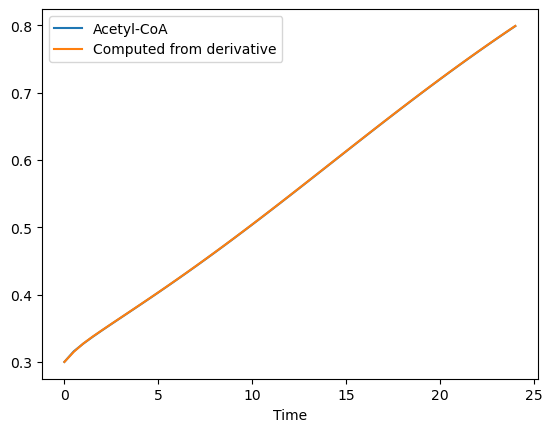

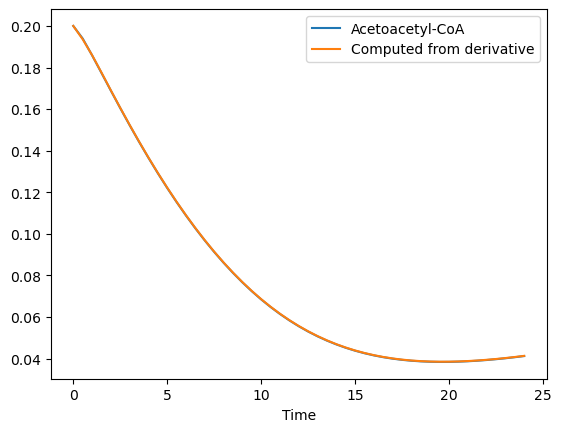

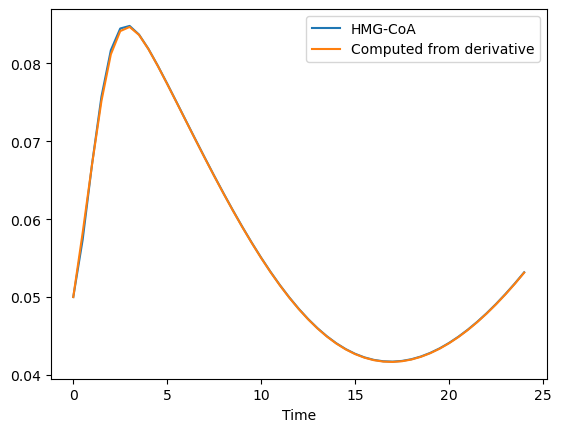

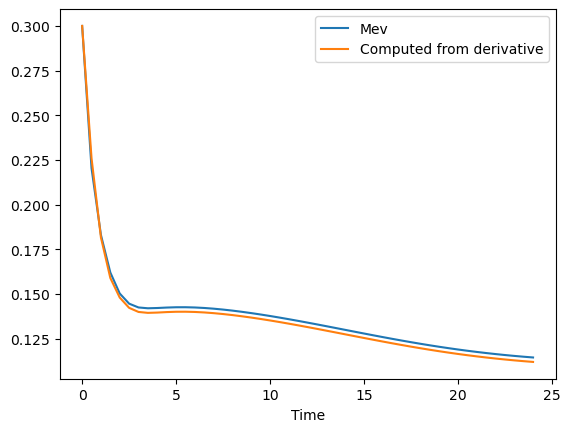

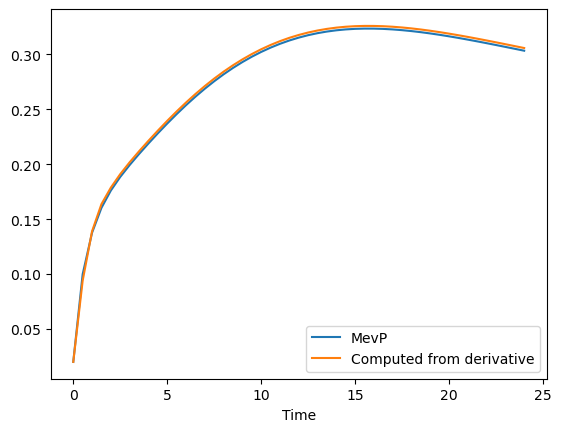

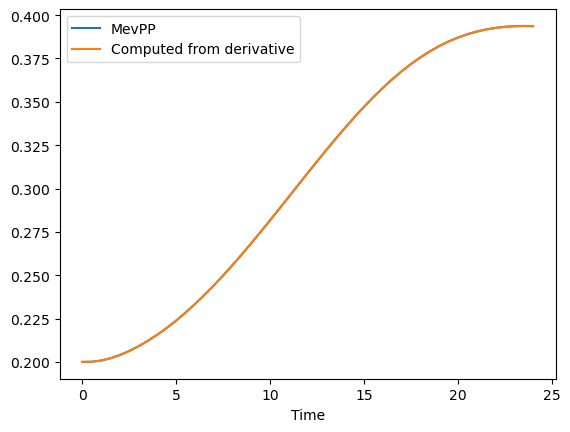

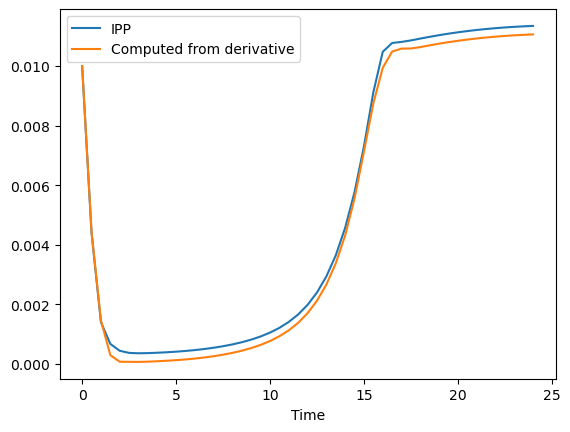

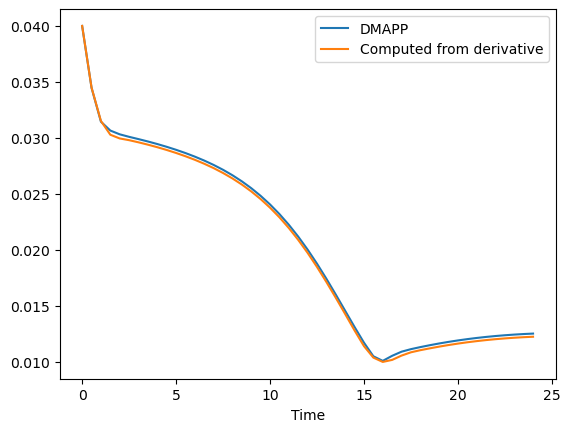

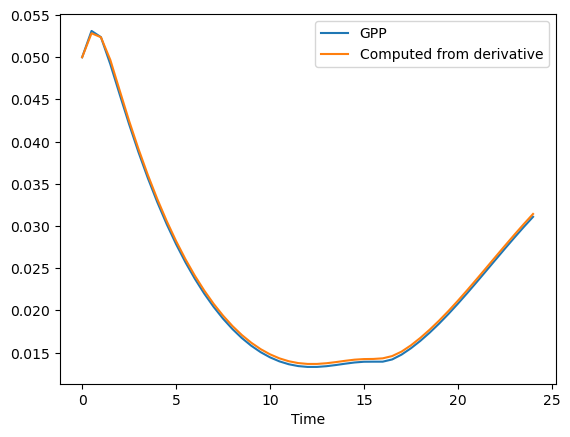

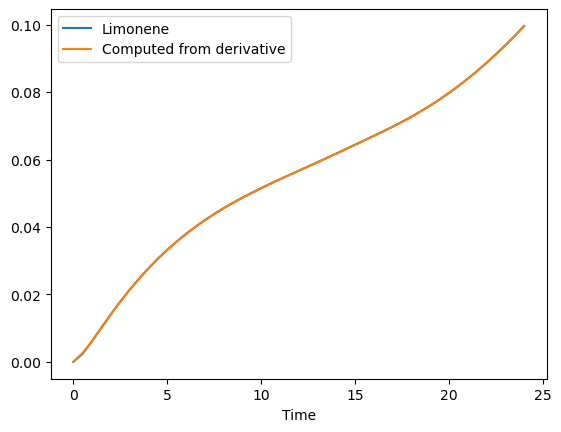

'Time profile from derivative vs. actual profile for Strain 3'

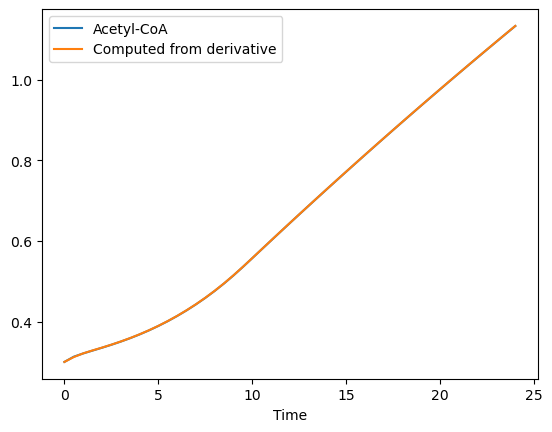

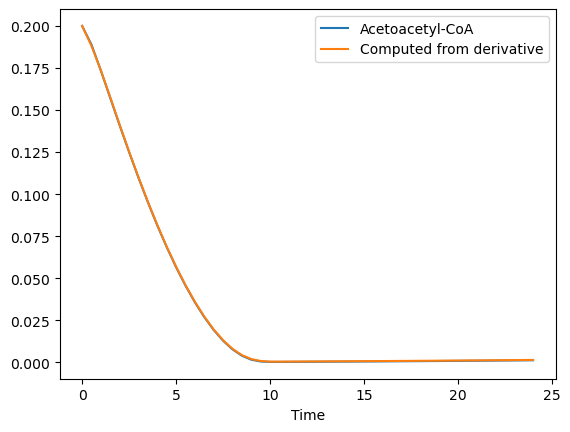

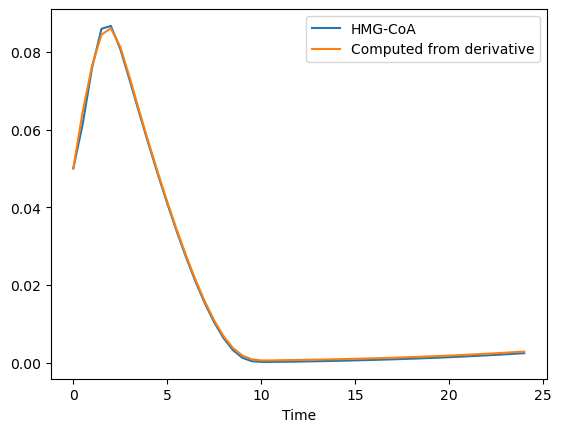

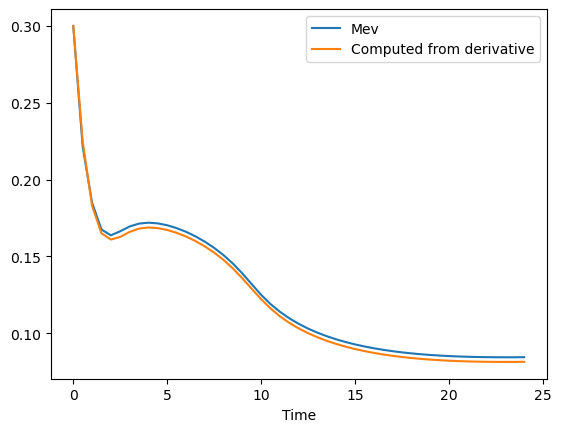

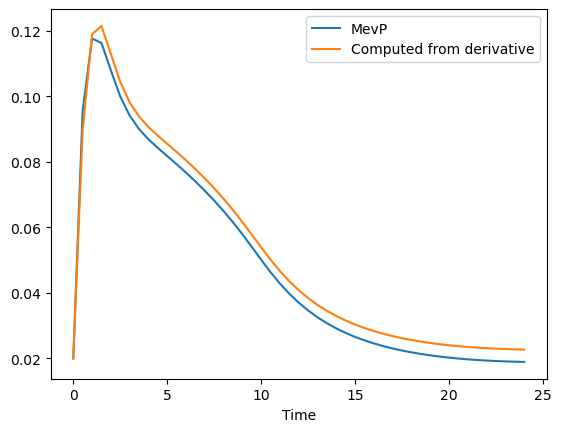

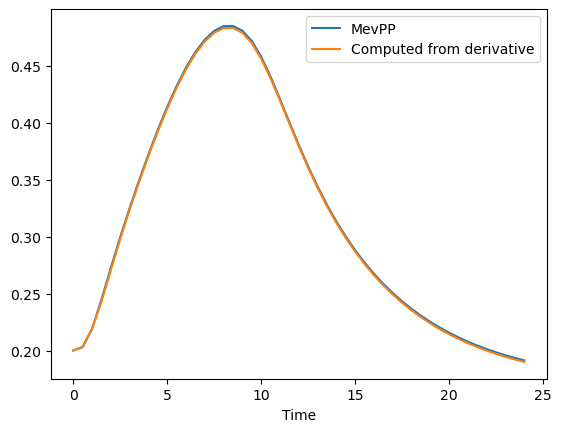

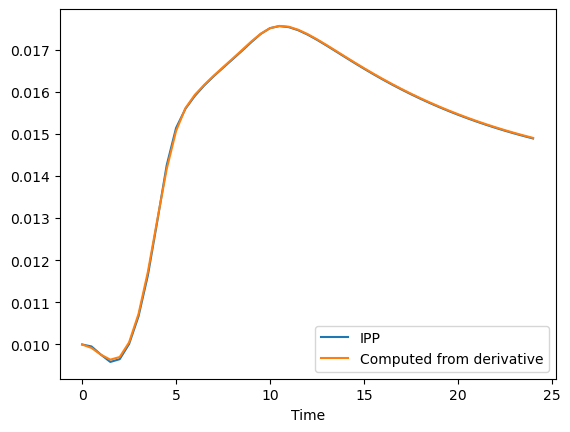

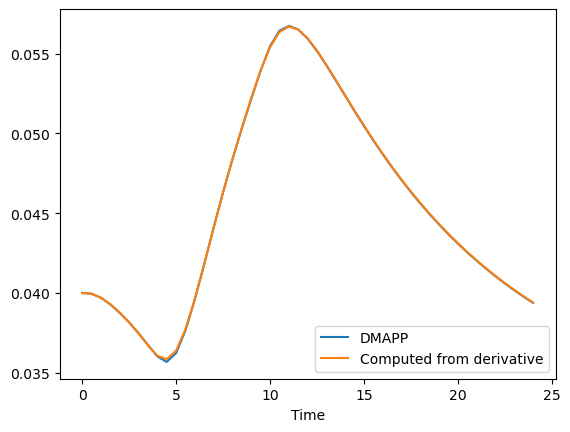

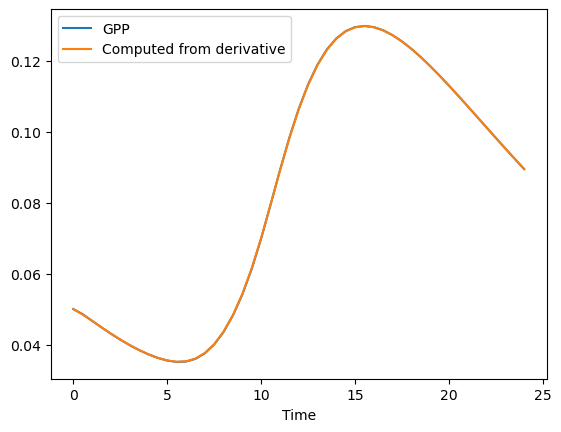

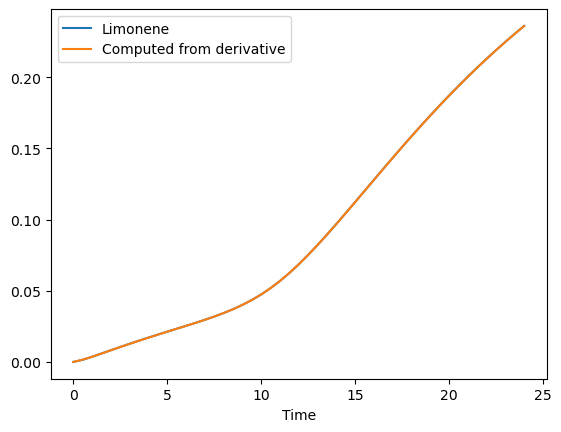

'Time profile from derivative vs. actual profile for WT'

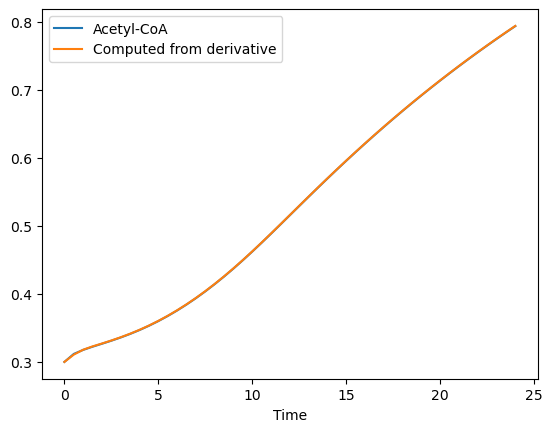

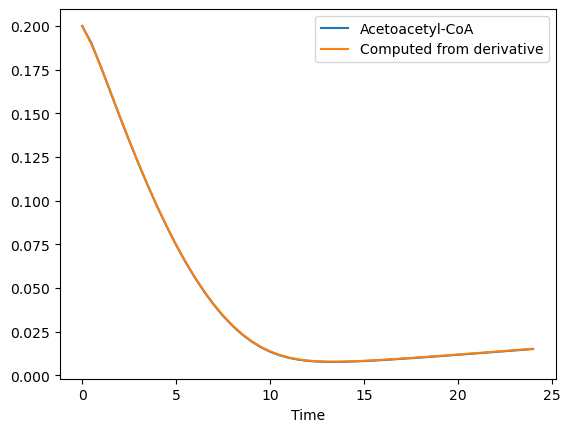

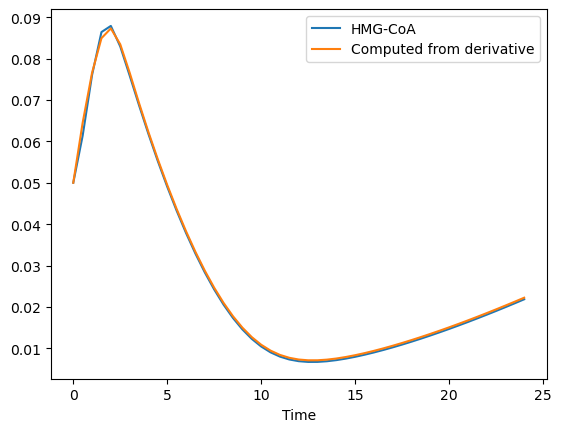

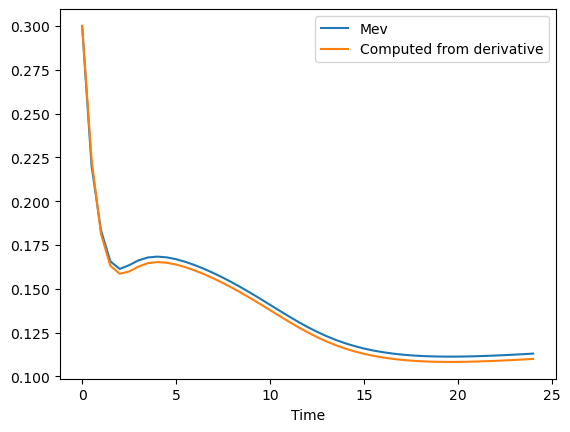

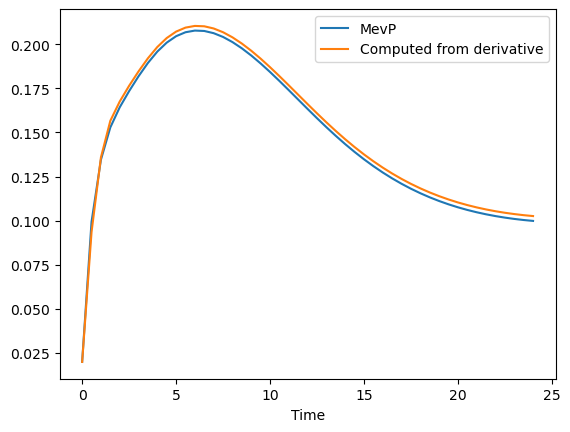

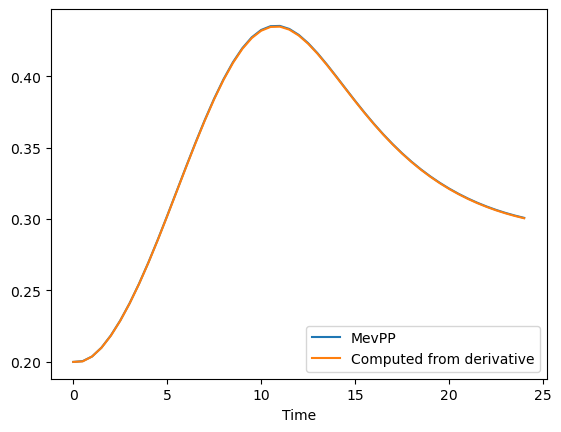

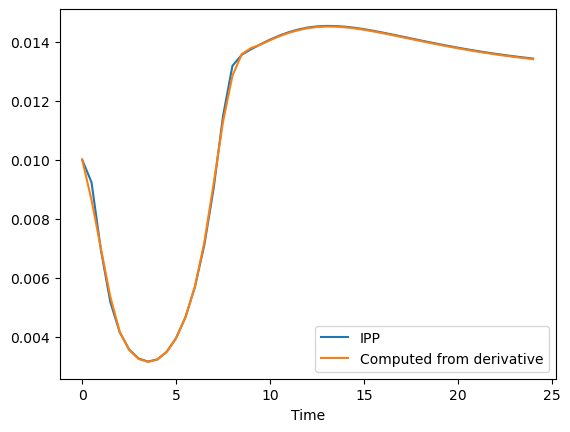

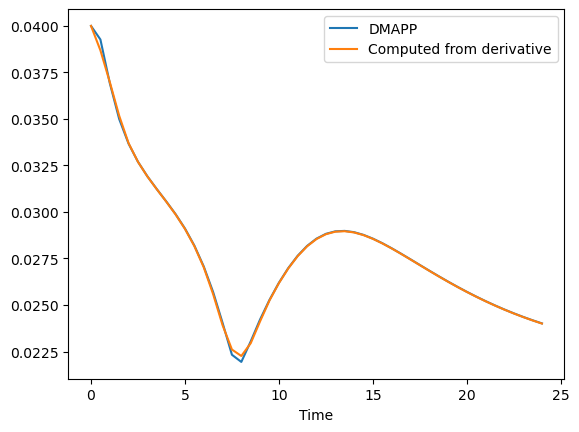

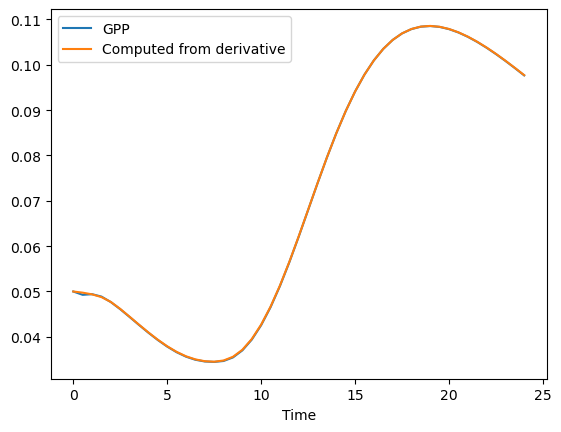

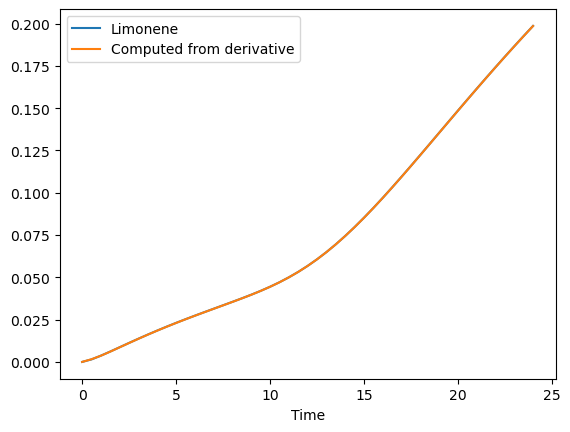

In [24]:
if inspectRate==True:
    from KineticLearning import check_derivative
    check_derivative(df_allSmooth)
    
#HC: synthetic data has sharp conc changes for HMG-CoA, Mev, IPP, DMAPP that are not well estimated by savgol filter 

# Prepare dataframes for model fitting (kr optimization)

enzymes, metabolites

Again:

measured_enzymes = ['AtoB', 'HMGS', 'HMGR', 'MK', 'PMK', 'PMD', 'GPPS', 'Idi','Limonene Synthase']

measured_substrates = ['Acetyl-CoA','Acetoacetyl-CoA','HMG-CoA', 'Mev', 'MevP','MevPP', 'IPP','DMAPP','GPP','Limonene']

In [25]:
# 9 enzymes conc measurement used for fitting model
x_controls = [('controls',control) for control in measured_enzymes]
controls_df = df_allSmooth[x_controls] # dataframe format

# 10 substrates conc measurement used for fitting model
x_states = [('states',state) for state in measured_substrates]
states_df = df_allSmooth[x_states] # dataframe format

# merge enzymes & substrates measurement as single feature dataframe
features_df = pd.merge(controls_df, states_df,left_index=True, right_index=True,how='left')
print('Enzyme & metabolite timepoint data to be used for model fitting')
display (features_df) # check total no. time-series datapoints (all strains)

Enzyme & metabolite timepoint data to be used for model fitting


controls                                            \
                       AtoB          HMGS          HMGR            MK   
Strain   Time                                                           
Strain 1 0.0   5.946962e+01  3.973013e+01  3.696892e+01  5.762279e+01   
         0.5   5.471875e+06  3.482933e+06  3.394490e+05  2.217158e+06   
         1.0   6.072640e+06  4.609864e+06  4.740683e+05  3.097868e+06   
         1.5   6.303323e+06  5.167157e+06  5.462870e+05  3.570656e+06   
         2.0   6.425365e+06  5.499584e+06  5.913288e+05  3.865639e+06   
...                     ...           ...           ...           ...   
WT       22.0  2.728742e+06  2.682996e+06  1.765870e+06  2.007241e+06   
         22.5  2.729080e+06  2.684265e+06  1.767009e+06  2.008539e+06   
         23.0  2.729403e+06  2.685480e+06  1.768100e+06  2.009782e+06   
         23.5  2.729713e+06  2.686645e+06  1.769146e+06  2.010974e+06   
         24.0  2.730010e+06  2.687762e+06  1.770149e+06  2.012117e+06   

                                                                       \
                        PMK           PMD          GPPS           Idi   
Strain   Time                                                           
Strain 1 0.0   2.659959e+01  5.448132e+01  5.547215e+01  1.868778e+01   
         0.5   7.241324e+05  3.761395e+06  3.265182e+06  6.399929e+05   
         1.0   9.847275e+05  5.509792e+06  3.743605e+06  8.490980e+05   
         1.5   1.118956e+06  6.520026e+06  3.935836e+06  9.528769e+05   
         2.0   1.200797e+06  7.178087e+06  4.039549e+06  1.014899e+06   
...                     ...           ...           ...           ...   
WT       22.0  1.500014e+06  3.984102e+06  4.352338e+06  1.233945e+06   
         22.5  1.500845e+06  3.987467e+06  4.353087e+06  1.234537e+06   
         23.0  1.501640e+06  3.990692e+06  4.353803e+06  1.235104e+06   
         23.5  1.502403e+06  3.993784e+06  4.354490e+06  1.235647e+06   
         24.0  1.503135e+06  3.996752e+06  4.355148e+06  1.236168e+06   

                                    states                            \
              Limonene Synthase Acetyl-CoA Acetoacetyl-CoA   HMG-CoA   
Strain   Time                                                          
Strain 1 0.0       3.034108e+01   0.300000        0.200000  0.050000   
         0.5       2.866143e+05   0.299893        0.188541  0.068037   
         1.0       3.981392e+05   0.288190        0.174077  0.089557   
         1.5       4.574783e+05   0.274398        0.158853  0.093482   
         2.0       4.943155e+05   0.260551        0.143504  0.080676   
...                         ...        ...             ...       ...   
WT       22.0      1.466213e+06   0.755407        0.013340  0.018112   
         22.5      1.467130e+06   0.765314        0.013753  0.019019   
         23.0      1.468009e+06   0.775039        0.014167  0.019944   
         23.5      1.468851e+06   0.784584        0.014581  0.020886   
         24.0      1.469659e+06   0.793953        0.014996  0.021843   

                                                                           \
                    Mev      MevP     MevPP       IPP     DMAPP       GPP   
Strain   Time                                                               
Strain 1 0.0   0.300000  0.020000  0.200000  0.010000  0.040000  0.050000   
         0.5   0.218933  0.100735  0.200543  0.009250  0.039268  0.049773   
         1.0   0.183997  0.136357  0.203716  0.007056  0.036890  0.050678   
         1.5   0.179006  0.157845  0.209860  0.005463  0.034856  0.051042   
         2.0   0.188562  0.178523  0.219000  0.004525  0.033388  0.050751   
...                 ...       ...       ...       ...       ...       ...   
WT       22.0  0.111883  0.102630  0.308770  0.013585  0.024759  0.103766   
         22.5  0.112124  0.101762  0.306400  0.013541  0.024553  0.102364   
         23.0  0.112389  0.101024  0.304296  0.013499  0.024360  0.100867   
         23.5  0.112676  0.100406  0.302

rate of reaction

In [26]:
# get rate of reaction for selected metabolites
y_derivatives = [('derivatives',derivative) for derivative in measured_substrates]
y_derivatives_df=df_allSmooth[y_derivatives]

# print ('Sample size of X & y should match:')
# print ('Sample size of X:'+ str(features_df.shape[0])) # df is 'array-like' NOT list
# print ('Sample size of y:'+ str(y_derivatives_df.shape[0])+'\n----------------\n')

print('Rate of reaction time datapoints to be used for model fitting')
display (y_derivatives_df) # check total no. time-series datapoints (all strains), sld be SAME as features_df

Rate of reaction time datapoints to be used for model fitting


derivatives                                                \
               Acetyl-CoA Acetoacetyl-CoA   HMG-CoA       Mev      MevP   
Strain   Time                                                             
Strain 1 0.0     0.003492       -0.021533  0.068282 -0.211321  0.178788   
         0.5    -0.012643       -0.026167  0.038730 -0.110383  0.112107   
         1.0    -0.023589       -0.029322  0.014092 -0.037507  0.064958   
         1.5    -0.029345       -0.030998 -0.005633  0.007307  0.037341   
         2.0    -0.027331       -0.030617 -0.026914  0.017786  0.040362   
...                   ...             ...       ...       ...       ...   
WT       22.0    0.019998        0.000825  0.001796  0.000453 -0.001872   
         22.5    0.019630        0.000827  0.001832  0.000508 -0.001602   
         23.0    0.019269        0.000828  0.001867  0.000554 -0.001353   
         23.5    0.018914        0.000829  0.001899  0.000591 -0.001124   
         24.0    0.018565        0.000828  0.001930  0.000618 -0.000915   

                                                                 
                  MevPP       IPP     DMAPP       GPP  Limonene  
Strain   Time                                                    
Strain 1 0.0  -0.001573 -0.002269 -0.001983  0.000353  0.001694  
         0.5   0.003675 -0.003001 -0.003208  0.000738  0.002505  
         1.0   0.009271 -0.003204 -0.003821  0.000731  0.003103  
         1.5   0.015214 -0.002876 -0.003819  0.000331  0.003487  
         2.0   0.021619 -0.001475 -0.002599 -0.000977  0.003575  
...                 ...       ...       ...       ...       ...  
WT       22.0 -0.005021 -0.000092 -0.000424 -0.002691  0.012565  
         22.5 -0.004467 -0.000086 -0.000399 -0.002906  0.012399  
         23.0 -0.003951 -0.000080 -0.000374 -0.003079  0.012223  
         23.5 -0.003476 -0.000075 -0.000349 -0.003204  0.012035  
         24.0 -0.003041 -0.000069 -0.000325 -0.003283  0.011835  

[196 rows x 10 columns]

# Prepare X, y for fitting

In [27]:
import random
random.seed(a='anyString')

# Get X,y for fitting
X=features_df.to_numpy() # dataframe to array
y=y_derivatives_df.to_numpy()


# Evaluate rate constants

In [28]:
# def kinetic_model(e1,e2,e3,e4,e5,e6,e7,e8,e9, #HC: 9
#                   s1,s2,s3,s4,s5,s6,s7,s8,s9,s10, #HC: 10
#                   k11,k12,k13,k21,k22,k23,k24,k31,k32,k33,k34,k35, #HC: 12 
#                   k41,k42,k43,k44,k45,k51,k52,k61,k62,k63,k64,k65, #HC: 12
#                   k71,k72,k81,k82,k83,k84,k91,k92,Vin,ks3): #HC: 10
#     #HC: 53 parameters (9+10+12+12+10)
#     r1 = 10**Vin - ((10**k11) *e1*s1)/((10**k12) + (10**k13)*s1) - (10**k21)*e2*s1*s2*(10**ks3) / ((10**k22)*s2 + (10**k23)*s1 + (10**k24)*s1*s2)     
#     r2 = ((10**k11)*e1*s1)/((10**k12) + (10**k13)*s1) - (10**k21)*e2*s1*s2*(10**ks3) / ((10**k22)*s2 + (10**k23)*s1 + (10**k24)*s1*s2)
#     r3 = (10**k21)*e2*s1*s2*(10**ks3) / ((10**k22)*s2 + (10**k23)*s1 + (10**k24)*s1*s2) - (10**k31)*e3*s3 / ((10**k32)*s1 + (10**k33)*s2 + (10**k34)*s3 + 10**k35)
#     r4 = (10**k31)*e3*s3 / ((10**k32)*s1 + (10**k33)*s2 + (10**k34)*s3 + 10**k35) - (10**k41)*e4*s4 / ((10**k42)*s9 + (10**k43)*s6 + (10**k44)*s4 + 10**k45) # k43*s6 NOT s5
#     r5 = (10**k41)*e4*s4 / ((10**k42)*s9 + (10**k43)*s6 + (10**k44)*s4 + 10**k45) - (10**k51)*e5*s5 / ((10**k52) + s5) # k43*s6 NOT s5
#     r6 = (10**k51)*e5*s5 / ((10**k52) + s5) - (10**k61)*e6*s6 / ((10**k62)*s5 + (10**k63)*s4 + (10**k64)*s6 + 10**k65)
#     r7 = (10**k61)*e6*s6 / ((10**k62)*s5 + (10**k63)*s4 + (10**k64)*s6 + 10**k65) - (10**k71)*e7*s7 / ((10**k72) + s7) - (10**k81)*e8*s7*s8 / ((10**k82) + (10**k83)*s7 + (10**k84)*s8 + s7*s8)
#     r8 = (10**k71)*e7*s7 / ((10**k72) + s7) - (10**k81)*e8*s7*s8 / ((10**k82) + (10**k83)*s7 + (10**k84)*s8 + s7*s8)
#     r9 = (10**k81)*e8*s7*s8 / ((10**k82) + (10**k83)*s7 + (10**k84)*s8 + s7*s8) - (10**k91)*e9*s9 / ((10**k92) + s9)
#     r10 = (10**k91)*e9*s9 / ((10**k92) + s9)
#     return [r1,r2,r3,r4,r5,r6,r7,r8,r9,r10]


In [29]:
# def derivatives_error_fcn_gen(X, y):

#     """
#     Returns a defined function (NOT numerical value) 
#     that reports the error score for given set of model parameters as argument
#     """

#     # Convert array-like data to list for defining error function
#     XX = X.tolist() # order according to measured_enzymes, then measured_substrates
#     yy = y.tolist()
# #         print(str(len(X)))
# #         print(str(len(y)))        
# #         print ('Sample size of XX & yy should match:')
# #         print ('Sample size of XX:'+ str(len(XX))) # df is 'array-like' NOT list
# #         print ('Sample size of yy:'+ str(len(yy))+'\n----------------\n')


#     def kinetic_model(e1,e2,e3,e4,e5,e6,e7,e8,e9, #HC: 9
#                       s1,s2,s3,s4,s5,s6,s7,s8,s9,s10, #HC: 10
#                       k11,k12,k13,k21,k22,k23,k24,k31,k32,k33,k34,k35, #HC: 12 
#                       k41,k42,k43,k44,k45,k51,k52,k61,k62,k63,k64,k65, #HC: 12
#                       k71,k72,k81,k82,k83,k84,k91,k92,Vin,ks3): #HC: 10
#         #HC: 53 parameters (9+10+12+12+10)
#         r1 = 10**Vin - ((10**k11) *e1*s1)/((10**k12) + (10**k13)*s1) - (10**k21)*e2*s1*s2*(10**ks3) / ((10**k22)*s2 + (10**k23)*s1 + (10**k24)*s1*s2)     
#         r2 = ((10**k11)*e1*s1)/((10**k12) + (10**k13)*s1) - (10**k21)*e2*s1*s2*(10**ks3) / ((10**k22)*s2 + (10**k23)*s1 + (10**k24)*s1*s2)
#         r3 = (10**k21)*e2*s1*s2*(10**ks3) / ((10**k22)*s2 + (10**k23)*s1 + (10**k24)*s1*s2) - (10**k31)*e3*s3 / ((10**k32)*s1 + (10**k33)*s2 + (10**k34)*s3 + 10**k35)
#         r4 = (10**k31)*e3*s3 / ((10**k32)*s1 + (10**k33)*s2 + (10**k34)*s3 + 10**k35) - (10**k41)*e4*s4 / ((10**k42)*s9 + (10**k43)*s6 + (10**k44)*s4 + 10**k45) # k43*s6 NOT s5
#         r5 = (10**k41)*e4*s4 / ((10**k42)*s9 + (10**k43)*s6 + (10**k44)*s4 + 10**k45) - (10**k51)*e5*s5 / ((10**k52) + s5) # k43*s6 NOT s5
#         r6 = (10**k51)*e5*s5 / ((10**k52) + s5) - (10**k61)*e6*s6 / ((10**k62)*s5 + (10**k63)*s4 + (10**k64)*s6 + 10**k65)
#         r7 = (10**k61)*e6*s6 / ((10**k62)*s5 + (10**k63)*s4 + (10**k64)*s6 + 10**k65) - (10**k71)*e7*s7 / ((10**k72) + s7) - (10**k81)*e8*s7*s8 / ((10**k82) + (10**k83)*s7 + (10**k84)*s8 + s7*s8)
#         r8 = (10**k71)*e7*s7 / ((10**k72) + s7) - (10**k81)*e8*s7*s8 / ((10**k82) + (10**k83)*s7 + (10**k84)*s8 + s7*s8)
#         r9 = (10**k81)*e8*s7*s8 / ((10**k82) + (10**k83)*s7 + (10**k84)*s8 + s7*s8) - (10**k91)*e9*s9 / ((10**k92) + s9)
#         r10 = (10**k91)*e9*s9 / ((10**k92) + s9)
#         return [r1,r2,r3,r4,r5,r6,r7,r8,r9,r10]

#     # THE FUNCTION BEING DEFINED & TO BE RETURNED
#     def derivatives_error_fcn(free_params):
#         # Error evaluation
#         derivatives_error = 0 # initialize
#         for x_val,y_vals in zip(XX,yy): # FOR EACH PAIR of X & y according to timepoint/strain

#             # Prepare argument for 'model' function in the same order
#             params = []
#             params.extend(x_val[0:9])     # 9 enzymes conc already in same order (index 0 to 8)
#             params.extend(x_val[9:19])    # 10 metabolites already in same order (index 9 to 18)
#             params.extend(free_params)    # take in SAME argument values for free kinetic parameters

#             # Print the instances for each function call
#             '''
#             print('len x_val:' + str(len(x_val))+'\n')
#             print(x_val) # 9 enzyme + 10 metabolite conc at each time point & strain
#             print('len y_vals:' + str(len(y_vals))+'\n')
#             print(y_vals) # rate of reaction (10 metabolites) at each time point & strain
#             print ('len free_params:' + str(len(free_params))+'\n')
#             print ('len params:' + str(len(params))+'\n')
#             print (params)
#             '''

#             #print ('free_params length OUTSIDE _metaboliteProductionRates:' + str( len (free_params) ) )                
#             #print (free_params)

#             ### Get list of predicted metabolite production rates for THE timepoint/strain  
#             mp = kinetic_model(*params)
#             prediction = [ mp[0], mp[1], mp[2], mp[3], mp[4], mp[5], mp[6], mp[7], mp[8], mp[9] ]            
            
#             # Update total error between predicted & measured reaction rates
#             # by including error for current timepoint/strain
#             # Again, same free params value is used
#             #derivatives_error += sum([(fx_val - y_val)**2  for fx_val,y_val in zip(prediction,y_vals)])
#             derivatives_error += sum([  ( (fx_val - y_val)/y_val )**2  for fx_val,y_val in zip(prediction,y_vals)])
#         return derivatives_error # return numerical value

#     return derivatives_error_fcn


In [30]:
# ### Generate the error function with free parameters as sole argument
# #print ('Generating error_fcn...')
# error_fcn = derivatives_error_fcn_gen(X, y)
# #print ('Completed generating error_fcn.')

# ### Search for optimal free parameters
# # Note that derivatives_error_fcn is basis for objective search 
# # by returning error value for each set of proposed free parameter values

# # initiate reasonable bounds for all the free parameters
# bounds = [(0.0,9.0)]*32 + [(-1.30103,-1.301029)] + [(0.0,9.0)]
# print (bounds)

In [31]:
from pymoo.core.problem import ElementwiseProblem

class MyProblem(ElementwiseProblem):
    
    def __init__(self, **kwargs):
         super().__init__(n_var=36, # no. of free parameters
                         n_obj=1, # weighted squared error
                         n_ieq_constr=0, # no inequality
                         xl=np.array([ # exponent constants: +ve values bounded, -ve values taken care in eqns
                             -12.0, 0.0, 0.0,
                             -12.0, 0.0, 0.0, 0.0,
                             -12.0, 0.0, 0.0, 0.0, 0.0,
                             0.0, 0.0, 0.0, 0.0, 0.0,
                             -12.0, 0.0, 0.0,
                             -12.0, 0.0, 0.0, 0.0, 0.0,
                             0.0, 0.0, 0.0,
                             -12.0, 0.0, 0.0, 0.0,
                             -12.0, 0.0, 0.0,
                             -1.30103]), # lower bounds
                         xu=np.array([
                             0.0, 12.0, 12.0,
                             0.0, 12.0, 12.0, 12.0,
                             0.0, 12.0, 12.0, 12.0, 12.0,
                             12.0, 12.0, 12.0, 12.0, 12.0,
                             0.0, 12.0, 12.0,
                             0.0, 12.0, 12.0, 12.0, 12.0,
                             12.0, 12.0, 12.0,
                             0.0, 12.0, 12.0, 12.0,
                             0.0, 12.0, 12.0,
                             -1.301029]) # upper bounds
                        )
       
    def _kinetic_model(self,e1,e2,e3,e4,e5,e6,e7,e8,e9, #HC: 9
                       s1,s2,s3,s4,s5,s6,s7,s8,s9,s10, #HC: 10
                       k11,k12,k13,
                       k21,k22,k23,k24,
                       k31,k32,k33,k34,k35, 
                       k41,k42,k43,k44,k45,
                       k51,k52,k53,
                       k61,k62,k63,k64,k65,
                       k71,k72,k73,
                       k81,k82,k83,k84,
                       k91,k92,k93,
                       Vin): #HC: 36

        r1 = (10**k11) *(e1**k12) *(s1**k13) # AtoB
        r2 = (10**k21) *(e2**k22) *(s1**k23) *(s2**k24) # HMGS
        r3 = (10**k31) *(e3**k32) *(s1**-k33) *(s2**-k34) *(s3**k35) # HMGR
        r4 = (10**k41) *(e4**k42) *(s4**k43) *(s9**-k44) *(s6**-k45) # MK
        r5 = (10**k51) *(e5**k52) *(s5**k53) # PMK
        r6 = (10**k61) *(e6**k62) *(s6**k63) *(s5**-k64) *(s4**-k65) # PMD
        r7 = (10**k71) *(e7**k72) *(s7**k73) # IDI
        r8 = (10**k81) *(e8**k82) *(s7**k83) *(s8**k84) # GPPS
        r9 = (10**k91) *(e9**k92) *(s9**k93) # LS
        r10 = 10**Vin # AcCoA supply

        # net metabolite turnover in Costello et al.
        rs1 = r10 - r1 - r2     
        rs2 = r1 - r2
        rs3 = r2 - r3
        rs4 = r3 - r4
        rs5 = r4 - r5
        rs6 = r5 - r6
        rs7 = r6 - r7 - r8
        rs8 = r7 - r8
        rs9 = r8 - r9
        rs10 = r9

        return [rs1,rs2,rs3,rs4,rs5,rs6,rs7,rs8,rs9,rs10]

        
    def _derivatives_error_fcn_gen(self, X, y):
        """
        Returns a defined function (NOT numerical value) 
        that reports the error score for given set of model parameters as argument
        X, y: for defining the function
        """

        # Convert array-like data to list for defining error function
        XX = X.tolist() # order according to measured_enzymes, then measured_substrates
        yy = y.tolist()
        #print(str(len(X)))
        #print(str(len(y)))        
        #print ('Sample size of XX & yy should match:')
        #print ('Sample size of XX:'+ str(len(XX))) # df is 'array-like' NOT list
        #print ('Sample size of yy:'+ str(len(yy))+'\n----------------\n')


        # THE FUNCTION BEING DEFINED & TO BE RETURNED
        def _derivatives_error_fcn(free_params):
            # Error evaluation
            derivatives_error = 0 # initialize
            count = 0
            for x_val,y_vals in zip(XX,yy): # FOR EACH PAIR of X & y according to timepoint/strain

                # Prepare argument for 'model' function in the same order
                params = []
                params.extend(x_val[0:9])     # 9 enzymes conc already in same order (index 0 to 8)
                params.extend(x_val[9:19])    # 10 metabolites already in same order (index 9 to 18)
                params.extend(free_params)    # take in SAME argument values for free kinetic parameters

                # Print the instances for each function call
                '''
                print('len x_val:' + str(len(x_val))+'\n')
                print(x_val) # 9 enzyme + 10 metabolite conc at each time point & strain
                print('len y_vals:' + str(len(y_vals))+'\n')
                print(y_vals) # rate of reaction (10 metabolites) at each time point & strain
                print ('len free_params:' + str(len(free_params))+'\n')
                #print (free_params)
                print ('len params:' + str(len(params))+'\n')
                #print (params)
                '''

                #print ('free_params length OUTSIDE _metaboliteProductionRates:' + str( len (free_params) ) )                
                #print (free_params)

                ### Get list of predicted metabolite production rates for THE timepoint/strain  
                mp = self._kinetic_model(*params)
                prediction = [ mp[0], mp[1], mp[2], mp[3], mp[4], mp[5], mp[6], mp[7], mp[8], mp[9] ]            
                
                # Update total error between predicted & measured reaction rates
                # by including error for current timepoint/strain
                # Again, same free params value is used
                derivatives_error += sum([(fx_val - y_val)**2  for fx_val,y_val in zip(prediction,y_vals)])
                count = count + 1
                #derivatives_error += sum([  ( (fx_val - y_val)/y_val )**2  for fx_val,y_val in zip(prediction,y_vals)])
            MSE = (10**5)*derivatives_error/( count*len(prediction) )
            #print ('count: ' + str(count))
            return MSE #derivatives_error # return numerical value

        return _derivatives_error_fcn

    def _evaluate(self, x, out, *args, **kwargs):
        '''
        x: one-dimensional NumPy array of length n_var, i.e., 34 kr parameter values
        '''
        
        #print ('no. x' + str( len(x) ) )
        #print (x)

        #print (len(X))
        #print (X)
        #print (len(y))
        #print (y)
        self._derivatives_error_fcn = self._derivatives_error_fcn_gen(X, y)
        f = self._derivatives_error_fcn(x) # objective error func
        out["F"] = [f] 


In [32]:
import multiprocessing
from pymoo.core.problem import StarmapParallelization

n_cores = 4
pool = multiprocessing.Pool(n_cores)
runner = StarmapParallelization(pool.starmap)
problem=MyProblem(elementwise_runner=runner)


# --- Optimization algorithm

In [33]:
algo = 'SRES'

from pymoo.operators.sampling.lhs import LHS
if algo == 'SRES':
    from pymoo.algorithms.soo.nonconvex.sres import SRES
    algorithm = SRES(n_offsprings=64, sampling=LHS(), rule=1.0 / 7.0, gamma=0.85, alpha=0.2)
elif algo == 'CMAES':
    from pymoo.algorithms.soo.nonconvex.cmaes import CMAES
    algorithm = CMAES(popsize=64)
elif algo == 'DE':
    from pymoo.algorithms.soo.nonconvex.de import DE
    algorithm = DE(pop_size=64, sampling=LHS(),
    variant="DE/rand/1/bin", CR=0.3, 
    dither="vector", jitter=False)
elif algo == 'ISRES':
    from pymoo.algorithms.soo.nonconvex.isres import ISRES
    algorithm = ISRES(n_offsprings=64, sampling=LHS(), rule=1.0 / 7.0, gamma=0.85, alpha=0.2)
elif algo == 'G3PCX':
    from pymoo.algorithms.soo.nonconvex.g3pcx import G3PCX
    algorithm = G3PCX(pop_size=64,sampling=LHS())
else:
    print ('No such algo: ' + algo + '\n')
    
from pymoo.termination import get_termination
termination = get_termination("n_gen", 1e5)

In [34]:
# Callback function to update f_min_log during optimization
f_min_log = []

def callback(res):
     f_min_log.append(res.opt.get("F").min())

from pymoo.optimize import minimize
print ('Algorithm in use: ' + algo + '\n')
res = minimize(problem,
               algorithm,
               termination,
               callback=callback,
               seed=10,
               verbose=True)

print('Time required:', res.exec_time)
pool.close()
print("Best solution found: \nX = %s\nF = %s\nCV = %s" % (res.X, res.F, res.CV))

Algorithm in use: SRES

n_gen  |  n_eval  |     f_avg     |     f_min    
     1 |       10 | 2.065051E+180 | 1.236607E+108
     2 |       74 | 6.525429E+117 | 3.422122E+106
     3 |      138 | 4.119334E+105 |  3.688066E+86
     4 |      202 |  5.868853E+95 |  5.527842E+77
     5 |      266 |  7.963816E+84 |  9.658293E+71
     6 |      330 |  1.258798E+74 |  1.180982E+61
     7 |      394 |  3.423467E+74 |  9.348794E+55
     8 |      458 |  1.472484E+61 |  8.209174E+50
     9 |      522 |  1.192993E+54 |  5.388701E+46
    10 |      586 |  2.985872E+52 |  2.638574E+42
    11 |      650 |  1.252593E+46 |  2.017515E+38
    12 |      714 |  1.429723E+47 |  2.753188E+36
    13 |      778 |  7.687709E+43 |  5.726892E+31
    14 |      842 |  8.021138E+39 |  6.900119E+29
    15 |      906 |  2.129839E+38 |  8.563225E+28
    16 |      970 |  5.540160E+35 |  8.563225E+28
    17 |     1034 |  2.810590E+35 |  2.391765E+27
    18 |     1098 |  3.522568E+29 |  3.902807E+20
    19 |     1162 |  6.771

   162 |    10314 |  2.170785E+01 |  1.907996E+01
   163 |    10378 |  2.193729E+01 |  1.907996E+01
   164 |    10442 |  2.224570E+01 |  1.798117E+01
   165 |    10506 |  2.256107E+01 |  1.798117E+01
   166 |    10570 |  2.171274E+01 |  1.798117E+01
   167 |    10634 |  2.178106E+01 |  1.798117E+01
   168 |    10698 |  2.178784E+01 |  1.798117E+01
   169 |    10762 |  2.182854E+01 |  1.798117E+01
   170 |    10826 |  2.218513E+01 |  1.798117E+01
   171 |    10890 |  2.142512E+01 |  1.798117E+01
   172 |    10954 |  2.181408E+01 |  1.798117E+01
   173 |    11018 |  2.163055E+01 |  1.798117E+01
   174 |    11082 |  2.143653E+01 |  1.798117E+01
   175 |    11146 |  2.131439E+01 |  1.798117E+01
   176 |    11210 |  2.133062E+01 |  1.798117E+01
   177 |    11274 |  2.058000E+01 |  1.798117E+01
   178 |    11338 |  2.107416E+01 |  1.798117E+01
   179 |    11402 |  2.101956E+01 |  1.798117E+01
   180 |    11466 |  2.136040E+01 |  1.798117E+01
   181 |    11530 |  2.075063E+01 |  1.798117E+01


   326 |    20810 |  1.321570E+01 |  1.207863E+01
   327 |    20874 |  1.304283E+01 |  1.207863E+01
   328 |    20938 |  1.331868E+01 |  1.207863E+01
   329 |    21002 |  1.325171E+01 |  1.207863E+01
   330 |    21066 |  1.341936E+01 |  1.207863E+01
   331 |    21130 |  1.316781E+01 |  1.198418E+01
   332 |    21194 |  1.297391E+01 |  1.198418E+01
   333 |    21258 |  1.281566E+01 |  1.198418E+01
   334 |    21322 |  1.276338E+01 |  1.198418E+01
   335 |    21386 |  1.281279E+01 |  1.198418E+01
   336 |    21450 |  1.318712E+01 |  1.198418E+01
   337 |    21514 |  1.343811E+01 |  1.198418E+01
   338 |    21578 |  1.353909E+01 |  1.198418E+01
   339 |    21642 |  1.368170E+01 |  1.198418E+01
   340 |    21706 |  1.397176E+01 |  1.198418E+01
   341 |    21770 |  1.371001E+01 |  1.198418E+01
   342 |    21834 |  1.361599E+01 |  1.198418E+01
   343 |    21898 |  1.388201E+01 |  1.198418E+01
   344 |    21962 |  1.413871E+01 |  1.198418E+01
   345 |    22026 |  1.418611E+01 |  1.198418E+01


   490 |    31306 |  1.083090E+01 |  9.9486427675
   491 |    31370 |  1.066251E+01 |  9.9486427675
   492 |    31434 |  1.058264E+01 |  9.9486427675
   493 |    31498 |  1.068459E+01 |  9.9486427675
   494 |    31562 |  1.072985E+01 |  9.9486427675
   495 |    31626 |  1.065356E+01 |  9.9486427675
   496 |    31690 |  1.058891E+01 |  9.9486427675
   497 |    31754 |  1.082326E+01 |  9.9486427675
   498 |    31818 |  1.094246E+01 |  9.9486427675
   499 |    31882 |  1.109909E+01 |  9.9486427675
   500 |    31946 |  1.091556E+01 |  9.9486427675
   501 |    32010 |  1.090035E+01 |  9.9486427675
   502 |    32074 |  1.115037E+01 |  9.9486427675
   503 |    32138 |  1.106245E+01 |  9.9486427675
   504 |    32202 |  1.113201E+01 |  9.9486427675
   505 |    32266 |  1.130929E+01 |  9.9486427675
   506 |    32330 |  1.118310E+01 |  9.9486427675
   507 |    32394 |  1.068143E+01 |  9.9486427675
   508 |    32458 |  1.053697E+01 |  9.9486427675
   509 |    32522 |  1.028389E+01 |  9.9387898592


   654 |    41802 |  8.6627188235 |  8.4344977005
   655 |    41866 |  8.6013435853 |  8.4212511202
   656 |    41930 |  8.5861709363 |  8.3656451675
   657 |    41994 |  8.6053229178 |  8.3656451675
   658 |    42058 |  8.7072990295 |  8.3656451675
   659 |    42122 |  8.6516214041 |  8.3656451675
   660 |    42186 |  8.6048971817 |  8.3656451675
   661 |    42250 |  8.6757318588 |  8.3656451675
   662 |    42314 |  8.6695942689 |  8.3656451675
   663 |    42378 |  8.6689823897 |  8.3656451675
   664 |    42442 |  8.6643225822 |  8.3656451675
   665 |    42506 |  8.6216985082 |  8.3323280639
   666 |    42570 |  8.6426477420 |  8.3323280639
   667 |    42634 |  8.6297768325 |  8.3323280639
   668 |    42698 |  8.5511134437 |  8.3323280639
   669 |    42762 |  8.4614586978 |  8.3323280639
   670 |    42826 |  8.4742160480 |  8.3323280639
   671 |    42890 |  8.4388376548 |  8.3323280639
   672 |    42954 |  8.4341271507 |  8.3323280639
   673 |    43018 |  8.4658211224 |  8.3323280639


   818 |    52298 |  7.5641337897 |  7.5569475763
   819 |    52362 |  7.5623664220 |  7.5569475763
   820 |    52426 |  7.5605656851 |  7.5524011221
   821 |    52490 |  7.5574455533 |  7.5524011221
   822 |    52554 |  7.5537523222 |  7.5496719299
   823 |    52618 |  7.5526818582 |  7.5496719299
   824 |    52682 |  7.5509281528 |  7.5445966186
   825 |    52746 |  7.5492779753 |  7.5445402616
   826 |    52810 |  7.5466443945 |  7.5440166600
   827 |    52874 |  7.5453991831 |  7.5415939909
   828 |    52938 |  7.5453491478 |  7.5415939909
   829 |    53002 |  7.5455929030 |  7.5403679796
   830 |    53066 |  7.5436610582 |  7.5403679796
   831 |    53130 |  7.5436003367 |  7.5401955553
   832 |    53194 |  7.5417579631 |  7.5390471883
   833 |    53258 |  7.5399654234 |  7.5376156227
   834 |    53322 |  7.5395947211 |  7.5371319278
   835 |    53386 |  7.5388010239 |  7.5339613329
   836 |    53450 |  7.5362289959 |  7.5317632689
   837 |    53514 |  7.5346966720 |  7.5317632689


   982 |    62794 |  7.4179577433 |  7.4163632647
   983 |    62858 |  7.4175385453 |  7.4163632647
   984 |    62922 |  7.4171723872 |  7.4163632647
   985 |    62986 |  7.4162042314 |  7.4142694840
   986 |    63050 |  7.4150122199 |  7.4135911965
   987 |    63114 |  7.4147946047 |  7.4135911965
   988 |    63178 |  7.4144247298 |  7.4134607873
   989 |    63242 |  7.4136345572 |  7.4106383546
   990 |    63306 |  7.4117366414 |  7.4094864711
   991 |    63370 |  7.4105097420 |  7.4090245830
   992 |    63434 |  7.4094992296 |  7.4088297589
   993 |    63498 |  7.4090739576 |  7.4083986162
   994 |    63562 |  7.4089454789 |  7.4082459693
   995 |    63626 |  7.4081896735 |  7.4073205553
   996 |    63690 |  7.4077258598 |  7.4056217435
   997 |    63754 |  7.4064759435 |  7.4053187889
   998 |    63818 |  7.4056487225 |  7.4049128308
   999 |    63882 |  7.4052146931 |  7.4040056444
  1000 |    63946 |  7.4050350402 |  7.4040056444
  1001 |    64010 |  7.4042977710 |  7.4030793601


  1146 |    73290 |  7.3613053080 |  7.3605928218
  1147 |    73354 |  7.3609322340 |  7.3605530432
  1148 |    73418 |  7.3609847937 |  7.3604216018
  1149 |    73482 |  7.3605297009 |  7.3600951840
  1150 |    73546 |  7.3601596599 |  7.3597281283
  1151 |    73610 |  7.3598594261 |  7.3594609549
  1152 |    73674 |  7.3596145849 |  7.3593133551
  1153 |    73738 |  7.3594040537 |  7.3590983701
  1154 |    73802 |  7.3592255946 |  7.3588760783
  1155 |    73866 |  7.3592377259 |  7.3588600208
  1156 |    73930 |  7.3592329176 |  7.3588600208
  1157 |    73994 |  7.3592479623 |  7.3588600208
  1158 |    74058 |  7.3591251728 |  7.3588600208
  1159 |    74122 |  7.3588323669 |  7.3584293051
  1160 |    74186 |  7.3586234316 |  7.3579137992
  1161 |    74250 |  7.3583914546 |  7.3577677269
  1162 |    74314 |  7.3579258542 |  7.3574725692
  1163 |    74378 |  7.3576601573 |  7.3572908746
  1164 |    74442 |  7.3575906997 |  7.3571715899
  1165 |    74506 |  7.3576013735 |  7.3571715899


  1310 |    83786 |  7.3317327683 |  7.3307988676
  1311 |    83850 |  7.3314126008 |  7.3306418302
  1312 |    83914 |  7.3309255638 |  7.3298534505
  1313 |    83978 |  7.3306506171 |  7.3298534505
  1314 |    84042 |  7.3306730509 |  7.3296649896
  1315 |    84106 |  7.3301662856 |  7.3296649896
  1316 |    84170 |  7.3299865635 |  7.3289768407
  1317 |    84234 |  7.3294816026 |  7.3289768407
  1318 |    84298 |  7.3290511902 |  7.3278385657
  1319 |    84362 |  7.3285842412 |  7.3274433626
  1320 |    84426 |  7.3282036079 |  7.3271099727
  1321 |    84490 |  7.3277463028 |  7.3270262168
  1322 |    84554 |  7.3273615070 |  7.3265195213
  1323 |    84618 |  7.3271164558 |  7.3265195213
  1324 |    84682 |  7.3266229219 |  7.3253580104
  1325 |    84746 |  7.3260579428 |  7.3253580104
  1326 |    84810 |  7.3254482760 |  7.3246800100
  1327 |    84874 |  7.3249957741 |  7.3242766473
  1328 |    84938 |  7.3245441601 |  7.3229434063
  1329 |    85002 |  7.3237569925 |  7.3223840624


  1474 |    94282 |  7.2142695299 |  7.2102434619
  1475 |    94346 |  7.2141071320 |  7.2102434619
  1476 |    94410 |  7.2130463701 |  7.2102434619
  1477 |    94474 |  7.2131124740 |  7.2102434619
  1478 |    94538 |  7.2125578979 |  7.2095565299
  1479 |    94602 |  7.2114985687 |  7.2093774308
  1480 |    94666 |  7.2125738615 |  7.2080925768
  1481 |    94730 |  7.2107752502 |  7.2080925768
  1482 |    94794 |  7.2098252011 |  7.2079760084
  1483 |    94858 |  7.2091441551 |  7.2068998192
  1484 |    94922 |  7.2084428025 |  7.2068540564
  1485 |    94986 |  7.2079288217 |  7.2056207955
  1486 |    95050 |  7.2073397172 |  7.2056207955
  1487 |    95114 |  7.2075481688 |  7.2056207955
  1488 |    95178 |  7.2074889059 |  7.2056207955
  1489 |    95242 |  7.2063658061 |  7.2046771780
  1490 |    95306 |  7.2055917647 |  7.2044845655
  1491 |    95370 |  7.2046868502 |  7.2032723410
  1492 |    95434 |  7.2042619581 |  7.2030470405
  1493 |    95498 |  7.2039295141 |  7.2029395877


  1638 |   104778 |  7.1479750976 |  7.1473356927
  1639 |   104842 |  7.1474263388 |  7.1468776705
  1640 |   104906 |  7.1470367039 |  7.1459517789
  1641 |   104970 |  7.1466583663 |  7.1452556570
  1642 |   105034 |  7.1463192445 |  7.1449163885
  1643 |   105098 |  7.1451073504 |  7.1439483133
  1644 |   105162 |  7.1444214946 |  7.1435805718
  1645 |   105226 |  7.1436404035 |  7.1422856906
  1646 |   105290 |  7.1425789831 |  7.1407938669
  1647 |   105354 |  7.1417196289 |  7.1402142951
  1648 |   105418 |  7.1402493524 |  7.1386656251
  1649 |   105482 |  7.1396074826 |  7.1386656251
  1650 |   105546 |  7.1391516212 |  7.1386313933
  1651 |   105610 |  7.1381142208 |  7.1363428580
  1652 |   105674 |  7.1376408614 |  7.1358593634
  1653 |   105738 |  7.1358348613 |  7.1345920385
  1654 |   105802 |  7.1354351982 |  7.1345920385
  1655 |   105866 |  7.1345232743 |  7.1330840435
  1656 |   105930 |  7.1337801685 |  7.1329335806
  1657 |   105994 |  7.1331930873 |  7.1319726184


  1802 |   115274 |  7.0664479494 |  7.0656544809
  1803 |   115338 |  7.0659854780 |  7.0652004264
  1804 |   115402 |  7.0656985128 |  7.0651773054
  1805 |   115466 |  7.0654778651 |  7.0649353146
  1806 |   115530 |  7.0650954298 |  7.0646043600
  1807 |   115594 |  7.0650540345 |  7.0638625646
  1808 |   115658 |  7.0648781070 |  7.0638625646
  1809 |   115722 |  7.0645921807 |  7.0638625646
  1810 |   115786 |  7.0644411221 |  7.0638625646
  1811 |   115850 |  7.0640173291 |  7.0632718276
  1812 |   115914 |  7.0635005525 |  7.0627950485
  1813 |   115978 |  7.0631931147 |  7.0626810910
  1814 |   116042 |  7.0628289993 |  7.0621494266
  1815 |   116106 |  7.0625257069 |  7.0620226572
  1816 |   116170 |  7.0621540557 |  7.0619101734
  1817 |   116234 |  7.0620011517 |  7.0615588986
  1818 |   116298 |  7.0615613389 |  7.0611599143
  1819 |   116362 |  7.0612346380 |  7.0607292859
  1820 |   116426 |  7.0610550853 |  7.0598706676
  1821 |   116490 |  7.0603734864 |  7.0597235228


  1966 |   125770 |  7.0366823490 |  7.0361702905
  1967 |   125834 |  7.0363124188 |  7.0360044829
  1968 |   125898 |  7.0360083602 |  7.0357672490
  1969 |   125962 |  7.0355842064 |  7.0349100063
  1970 |   126026 |  7.0351820759 |  7.0346881546
  1971 |   126090 |  7.0351875068 |  7.0345778253
  1972 |   126154 |  7.0348025455 |  7.0345027889
  1973 |   126218 |  7.0344594897 |  7.0335250245
  1974 |   126282 |  7.0341587459 |  7.0333851406
  1975 |   126346 |  7.0337057966 |  7.0333806538
  1976 |   126410 |  7.0334005183 |  7.0328047791
  1977 |   126474 |  7.0330956229 |  7.0319239311
  1978 |   126538 |  7.0325248002 |  7.0316921206
  1979 |   126602 |  7.0315434667 |  7.0305393909
  1980 |   126666 |  7.0310105108 |  7.0303174235
  1981 |   126730 |  7.0306719776 |  7.0297506452
  1982 |   126794 |  7.0302655881 |  7.0295384844
  1983 |   126858 |  7.0298246499 |  7.0287723279
  1984 |   126922 |  7.0288933431 |  7.0278304047
  1985 |   126986 |  7.0285495938 |  7.0278304047


  2130 |   136266 |  6.9179350497 |  6.9174340893
  2131 |   136330 |  6.9177965090 |  6.9174340893
  2132 |   136394 |  6.9175893812 |  6.9170576819
  2133 |   136458 |  6.9174448072 |  6.9170346289
  2134 |   136522 |  6.9171915584 |  6.9162764922
  2135 |   136586 |  6.9168753491 |  6.9162764922
  2136 |   136650 |  6.9165452804 |  6.9158957423
  2137 |   136714 |  6.9161781770 |  6.9152896607
  2138 |   136778 |  6.9159770943 |  6.9152896607
  2139 |   136842 |  6.9155369441 |  6.9147940675
  2140 |   136906 |  6.9152531133 |  6.9147940675
  2141 |   136970 |  6.9148219904 |  6.9134144027
  2142 |   137034 |  6.9138260527 |  6.9125042410
  2143 |   137098 |  6.9131384656 |  6.9122550444
  2144 |   137162 |  6.9128715609 |  6.9118792179
  2145 |   137226 |  6.9126479497 |  6.9118400716
  2146 |   137290 |  6.9116930109 |  6.9105316426
  2147 |   137354 |  6.9113707990 |  6.9093969273
  2148 |   137418 |  6.9101067707 |  6.9086012770
  2149 |   137482 |  6.9095413789 |  6.9078141434


  2294 |   146762 |  6.7907620377 |  6.7897237429
  2295 |   146826 |  6.7903142522 |  6.7897237429
  2296 |   146890 |  6.7900152524 |  6.7891770698
  2297 |   146954 |  6.7892171443 |  6.7884449702
  2298 |   147018 |  6.7889534353 |  6.7882464433
  2299 |   147082 |  6.7890851763 |  6.7882464433
  2300 |   147146 |  6.7887385788 |  6.7882464433
  2301 |   147210 |  6.7886740226 |  6.7878973098
  2302 |   147274 |  6.7883203945 |  6.7876296783
  2303 |   147338 |  6.7878190906 |  6.7863342541
  2304 |   147402 |  6.7869179013 |  6.7857118600
  2305 |   147466 |  6.7863702709 |  6.7856664885
  2306 |   147530 |  6.7860651200 |  6.7856664885
  2307 |   147594 |  6.7857093238 |  6.7854607917
  2308 |   147658 |  6.7855882328 |  6.7848163062
  2309 |   147722 |  6.7854222927 |  6.7848163062
  2310 |   147786 |  6.7852038474 |  6.7846173542
  2311 |   147850 |  6.7849200368 |  6.7846173542
  2312 |   147914 |  6.7848631536 |  6.7846173542
  2313 |   147978 |  6.7848829845 |  6.7846173542


  2458 |   157258 |  6.7314689364 |  6.7298439864
  2459 |   157322 |  6.7302492611 |  6.7296603892
  2460 |   157386 |  6.7298016206 |  6.7289135213
  2461 |   157450 |  6.7292935125 |  6.7289135213
  2462 |   157514 |  6.7288180251 |  6.7279816754
  2463 |   157578 |  6.7283154857 |  6.7277610306
  2464 |   157642 |  6.7277991933 |  6.7272299632
  2465 |   157706 |  6.7269863776 |  6.7263806978
  2466 |   157770 |  6.7266158527 |  6.7261337616
  2467 |   157834 |  6.7259272588 |  6.7247236324
  2468 |   157898 |  6.7247847656 |  6.7234439276
  2469 |   157962 |  6.7238938983 |  6.7221673115
  2470 |   158026 |  6.7228656305 |  6.7221673115
  2471 |   158090 |  6.7225175021 |  6.7221374807
  2472 |   158154 |  6.7222846049 |  6.7218403209
  2473 |   158218 |  6.7218698555 |  6.7214834114
  2474 |   158282 |  6.7217612052 |  6.7209343280
  2475 |   158346 |  6.7212733523 |  6.7203482202
  2476 |   158410 |  6.7209152967 |  6.7203482202
  2477 |   158474 |  6.7206149200 |  6.7203482202


  2622 |   167754 |  6.6712089838 |  6.6709113037
  2623 |   167818 |  6.6710048271 |  6.6707926434
  2624 |   167882 |  6.6709722509 |  6.6707926434
  2625 |   167946 |  6.6708250356 |  6.6706581469
  2626 |   168010 |  6.6707864180 |  6.6706103489
  2627 |   168074 |  6.6707590520 |  6.6704833682
  2628 |   168138 |  6.6706938110 |  6.6703892198
  2629 |   168202 |  6.6704499211 |  6.6701375814
  2630 |   168266 |  6.6703981499 |  6.6700940561
  2631 |   168330 |  6.6703815941 |  6.6700940561
  2632 |   168394 |  6.6702905802 |  6.6700587890
  2633 |   168458 |  6.6701000616 |  6.6697013796
  2634 |   168522 |  6.6698616384 |  6.6696423481
  2635 |   168586 |  6.6696945791 |  6.6695506740
  2636 |   168650 |  6.6694803060 |  6.6692992110
  2637 |   168714 |  6.6692318094 |  6.6690886458
  2638 |   168778 |  6.6691857087 |  6.6689346110
  2639 |   168842 |  6.6691530582 |  6.6688469529
  2640 |   168906 |  6.6690221968 |  6.6687701694
  2641 |   168970 |  6.6688600872 |  6.6686021279


  2786 |   178250 |  6.6102763506 |  6.6091768199
  2787 |   178314 |  6.6094516019 |  6.6086670281
  2788 |   178378 |  6.6094713756 |  6.6086670281
  2789 |   178442 |  6.6092539401 |  6.6086504230
  2790 |   178506 |  6.6086039299 |  6.6075622191
  2791 |   178570 |  6.6086355570 |  6.6075622191
  2792 |   178634 |  6.6081262595 |  6.6073765124
  2793 |   178698 |  6.6078418972 |  6.6060864214
  2794 |   178762 |  6.6076981164 |  6.6060864214
  2795 |   178826 |  6.6072985423 |  6.6057979054
  2796 |   178890 |  6.6065238730 |  6.6049261110
  2797 |   178954 |  6.6058231386 |  6.6049261110
  2798 |   179018 |  6.6056775707 |  6.6049261110
  2799 |   179082 |  6.6054208074 |  6.6041069307
  2800 |   179146 |  6.6051084334 |  6.6041069307
  2801 |   179210 |  6.6047047919 |  6.6041069307
  2802 |   179274 |  6.6041998682 |  6.6036084933
  2803 |   179338 |  6.6040519250 |  6.6035933849
  2804 |   179402 |  6.6041113331 |  6.6035933849
  2805 |   179466 |  6.6037299010 |  6.6032643983


  2950 |   188746 |  6.5511895090 |  6.5505417700
  2951 |   188810 |  6.5509602665 |  6.5503835689
  2952 |   188874 |  6.5511038048 |  6.5501402048
  2953 |   188938 |  6.5503488253 |  6.5494890541
  2954 |   189002 |  6.5498920347 |  6.5491613042
  2955 |   189066 |  6.5497921749 |  6.5491569047
  2956 |   189130 |  6.5493926853 |  6.5482759971
  2957 |   189194 |  6.5490675386 |  6.5473523703
  2958 |   189258 |  6.5482136482 |  6.5473523703
  2959 |   189322 |  6.5482427304 |  6.5473523703
  2960 |   189386 |  6.5480154173 |  6.5471179398
  2961 |   189450 |  6.5476279462 |  6.5470223644
  2962 |   189514 |  6.5476894035 |  6.5470223644
  2963 |   189578 |  6.5474764501 |  6.5470223644
  2964 |   189642 |  6.5472923785 |  6.5467442720
  2965 |   189706 |  6.5471382071 |  6.5466694361
  2966 |   189770 |  6.5470850697 |  6.5464843086
  2967 |   189834 |  6.5466955708 |  6.5461565274
  2968 |   189898 |  6.5467353786 |  6.5461565274
  2969 |   189962 |  6.5462325221 |  6.5455751861


  3114 |   199242 |  6.4939056523 |  6.4936463245
  3115 |   199306 |  6.4935154887 |  6.4927732902
  3116 |   199370 |  6.4932276106 |  6.4925176667
  3117 |   199434 |  6.4928185384 |  6.4924337100
  3118 |   199498 |  6.4924888737 |  6.4920708147
  3119 |   199562 |  6.4920414768 |  6.4916596774
  3120 |   199626 |  6.4914937544 |  6.4909038983
  3121 |   199690 |  6.4908138463 |  6.4899413780
  3122 |   199754 |  6.4905040066 |  6.4899413780
  3123 |   199818 |  6.4904215111 |  6.4897119818
  3124 |   199882 |  6.4904634394 |  6.4897119818
  3125 |   199946 |  6.4904180295 |  6.4895682911
  3126 |   200010 |  6.4902668613 |  6.4895682911
  3127 |   200074 |  6.4902335608 |  6.4895682911
  3128 |   200138 |  6.4898803699 |  6.4893507043
  3129 |   200202 |  6.4895359573 |  6.4890241131
  3130 |   200266 |  6.4892887543 |  6.4888528296
  3131 |   200330 |  6.4891504811 |  6.4888453689
  3132 |   200394 |  6.4890423300 |  6.4885422120
  3133 |   200458 |  6.4888120583 |  6.4881969002


  3278 |   209738 |  6.4420323106 |  6.4416808946
  3279 |   209802 |  6.4419119134 |  6.4414883086
  3280 |   209866 |  6.4416122812 |  6.4409527046
  3281 |   209930 |  6.4411191871 |  6.4405541801
  3282 |   209994 |  6.4408191776 |  6.4402528492
  3283 |   210058 |  6.4403605824 |  6.4394911106
  3284 |   210122 |  6.4398731367 |  6.4394911106
  3285 |   210186 |  6.4394866249 |  6.4386445003
  3286 |   210250 |  6.4390143994 |  6.4386445003
  3287 |   210314 |  6.4390242058 |  6.4386445003
  3288 |   210378 |  6.4390549793 |  6.4380125035
  3289 |   210442 |  6.4384508939 |  6.4378763824
  3290 |   210506 |  6.4380443929 |  6.4375164986
  3291 |   210570 |  6.4380795549 |  6.4374126180
  3292 |   210634 |  6.4379701153 |  6.4374126180
  3293 |   210698 |  6.4376592743 |  6.4368259942
  3294 |   210762 |  6.4371173122 |  6.4360739067
  3295 |   210826 |  6.4365555778 |  6.4360739067
  3296 |   210890 |  6.4362120673 |  6.4358931631
  3297 |   210954 |  6.4358766575 |  6.4347134164


  3442 |   220234 |  6.3988277902 |  6.3982427094
  3443 |   220298 |  6.3983669124 |  6.3979685804
  3444 |   220362 |  6.3980953542 |  6.3975799685
  3445 |   220426 |  6.3976017409 |  6.3972515115
  3446 |   220490 |  6.3973752104 |  6.3967337980
  3447 |   220554 |  6.3971492036 |  6.3967337980
  3448 |   220618 |  6.3968260164 |  6.3965270324
  3449 |   220682 |  6.3963497069 |  6.3958755588
  3450 |   220746 |  6.3959810653 |  6.3952991644
  3451 |   220810 |  6.3954842701 |  6.3948915045
  3452 |   220874 |  6.3954626474 |  6.3948915045
  3453 |   220938 |  6.3949165979 |  6.3942187018
  3454 |   221002 |  6.3944027171 |  6.3937815116
  3455 |   221066 |  6.3936834426 |  6.3934213030
  3456 |   221130 |  6.3932309916 |  6.3925297906
  3457 |   221194 |  6.3926229388 |  6.3922234463
  3458 |   221258 |  6.3921110138 |  6.3914044409
  3459 |   221322 |  6.3914471405 |  6.3906922168
  3460 |   221386 |  6.3911789297 |  6.3905315341
  3461 |   221450 |  6.3903803134 |  6.3900076550


  3606 |   230730 |  6.1264231318 |  6.1227277640
  3607 |   230794 |  6.1244735694 |  6.1227277640
  3608 |   230858 |  6.1235655857 |  6.1181832583
  3609 |   230922 |  6.1210969303 |  6.1181832583
  3610 |   230986 |  6.1195104263 |  6.1170519515
  3611 |   231050 |  6.1196389530 |  6.1170519515
  3612 |   231114 |  6.1193927318 |  6.1169382665
  3613 |   231178 |  6.1196229310 |  6.1169382665
  3614 |   231242 |  6.1186021981 |  6.1169382665
  3615 |   231306 |  6.1168502109 |  6.1151299285
  3616 |   231370 |  6.1172261361 |  6.1151299285
  3617 |   231434 |  6.1154692721 |  6.1143433212
  3618 |   231498 |  6.1151942924 |  6.1123222759
  3619 |   231562 |  6.1125937095 |  6.1098186840
  3620 |   231626 |  6.1111335132 |  6.1098186840
  3621 |   231690 |  6.1104605505 |  6.1098186840
  3622 |   231754 |  6.1105791833 |  6.1095397905
  3623 |   231818 |  6.1098688346 |  6.1092091042
  3624 |   231882 |  6.1082857672 |  6.1049249530
  3625 |   231946 |  6.1058192710 |  6.1008643974


  3770 |   241226 |  5.9341069985 |  5.9311233878
  3771 |   241290 |  5.9334747437 |  5.9307348091
  3772 |   241354 |  5.9323046794 |  5.9306941836
  3773 |   241418 |  5.9313058450 |  5.9290452213
  3774 |   241482 |  5.9301503290 |  5.9290452213
  3775 |   241546 |  5.9308286138 |  5.9290452213
  3776 |   241610 |  5.9308950143 |  5.9290452213
  3777 |   241674 |  5.9309149971 |  5.9290452213
  3778 |   241738 |  5.9303235734 |  5.9286265765
  3779 |   241802 |  5.9301198881 |  5.9286265765
  3780 |   241866 |  5.9303949180 |  5.9277107062
  3781 |   241930 |  5.9300460721 |  5.9277107062
  3782 |   241994 |  5.9291554418 |  5.9273608825
  3783 |   242058 |  5.9279902533 |  5.9263765866
  3784 |   242122 |  5.9274974480 |  5.9245789628
  3785 |   242186 |  5.9269255356 |  5.9245789628
  3786 |   242250 |  5.9265771086 |  5.9240370686
  3787 |   242314 |  5.9256603352 |  5.9240370686
  3788 |   242378 |  5.9244191107 |  5.9214295854
  3789 |   242442 |  5.9239372563 |  5.9213772708


  3934 |   251722 |  5.8240883719 |  5.8220971640
  3935 |   251786 |  5.8234576941 |  5.8207701058
  3936 |   251850 |  5.8229238276 |  5.8207701058
  3937 |   251914 |  5.8223998215 |  5.8205246687
  3938 |   251978 |  5.8220129141 |  5.8202956343
  3939 |   252042 |  5.8214599404 |  5.8198680123
  3940 |   252106 |  5.8212575326 |  5.8198680123
  3941 |   252170 |  5.8203497630 |  5.8188233855
  3942 |   252234 |  5.8198948888 |  5.8186537233
  3943 |   252298 |  5.8197211646 |  5.8185928767
  3944 |   252362 |  5.8190434022 |  5.8181934056
  3945 |   252426 |  5.8183420548 |  5.8159248548
  3946 |   252490 |  5.8181729738 |  5.8159248548
  3947 |   252554 |  5.8176857172 |  5.8159248548
  3948 |   252618 |  5.8175751583 |  5.8156403194
  3949 |   252682 |  5.8164539619 |  5.8132407202
  3950 |   252746 |  5.8152384394 |  5.8132407202
  3951 |   252810 |  5.8140992271 |  5.8127618358
  3952 |   252874 |  5.8130547084 |  5.8116322720
  3953 |   252938 |  5.8127800083 |  5.8097495395


  4098 |   262218 |  5.7130459411 |  5.7106321069
  4099 |   262282 |  5.7114733652 |  5.7096008436
  4100 |   262346 |  5.7100668110 |  5.7090675676
  4101 |   262410 |  5.7096283266 |  5.7065237809
  4102 |   262474 |  5.7079526352 |  5.7059853195
  4103 |   262538 |  5.7067536272 |  5.7046725400
  4104 |   262602 |  5.7056096215 |  5.7035909750
  4105 |   262666 |  5.7043943382 |  5.7016222326
  4106 |   262730 |  5.7028803018 |  5.7006723153
  4107 |   262794 |  5.7021157153 |  5.6994201312
  4108 |   262858 |  5.7011612249 |  5.6994201312
  4109 |   262922 |  5.7002702088 |  5.6994201312
  4110 |   262986 |  5.6994738905 |  5.6982727268
  4111 |   263050 |  5.6994102337 |  5.6974577248
  4112 |   263114 |  5.6987807792 |  5.6974577248
  4113 |   263178 |  5.6981544301 |  5.6961389168
  4114 |   263242 |  5.6964057174 |  5.6952872753
  4115 |   263306 |  5.6958336072 |  5.6940009165
  4116 |   263370 |  5.6952517140 |  5.6940009165
  4117 |   263434 |  5.6953555713 |  5.6940009165


  4262 |   272714 |  5.6024500342 |  5.6017468672
  4263 |   272778 |  5.6017557009 |  5.6004760101
  4264 |   272842 |  5.6017745115 |  5.6004760101
  4265 |   272906 |  5.6006693893 |  5.5996573383
  4266 |   272970 |  5.6002935103 |  5.5992857928
  4267 |   273034 |  5.5996212870 |  5.5986082387
  4268 |   273098 |  5.5993003621 |  5.5979819060
  4269 |   273162 |  5.5989064989 |  5.5979819060
  4270 |   273226 |  5.5982559612 |  5.5973385451
  4271 |   273290 |  5.5980722681 |  5.5964893949
  4272 |   273354 |  5.5968741133 |  5.5947875640
  4273 |   273418 |  5.5956783074 |  5.5941227380
  4274 |   273482 |  5.5949700582 |  5.5941227380
  4275 |   273546 |  5.5946389305 |  5.5939823703
  4276 |   273610 |  5.5936124980 |  5.5925985188
  4277 |   273674 |  5.5925041418 |  5.5913858299
  4278 |   273738 |  5.5919864256 |  5.5911920443
  4279 |   273802 |  5.5913364754 |  5.5904404154
  4280 |   273866 |  5.5901921318 |  5.5886178152
  4281 |   273930 |  5.5894464013 |  5.5884689532


  4426 |   283210 |  5.4696649269 |  5.4681058505
  4427 |   283274 |  5.4680119562 |  5.4658175762
  4428 |   283338 |  5.4670085083 |  5.4658175762
  4429 |   283402 |  5.4661502452 |  5.4653021516
  4430 |   283466 |  5.4645150219 |  5.4619252287
  4431 |   283530 |  5.4635252625 |  5.4619252287
  4432 |   283594 |  5.4621846554 |  5.4607214146
  4433 |   283658 |  5.4614700109 |  5.4587982867
  4434 |   283722 |  5.4601160351 |  5.4586200383
  4435 |   283786 |  5.4596747541 |  5.4586200383
  4436 |   283850 |  5.4587022000 |  5.4565781395
  4437 |   283914 |  5.4573361936 |  5.4565781395
  4438 |   283978 |  5.4570396785 |  5.4556708708
  4439 |   284042 |  5.4565931290 |  5.4555593689
  4440 |   284106 |  5.4561253690 |  5.4548806239
  4441 |   284170 |  5.4561346601 |  5.4548806239
  4442 |   284234 |  5.4550215554 |  5.4532167371
  4443 |   284298 |  5.4532091021 |  5.4518382399
  4444 |   284362 |  5.4516853660 |  5.4496114733
  4445 |   284426 |  5.4503952631 |  5.4486698129


  4590 |   293706 |  5.4057827654 |  5.4054663536
  4591 |   293770 |  5.4056341442 |  5.4051335417
  4592 |   293834 |  5.4053798607 |  5.4049132759
  4593 |   293898 |  5.4050227877 |  5.4046513066
  4594 |   293962 |  5.4048982765 |  5.4044818379
  4595 |   294026 |  5.4045959127 |  5.4040494365
  4596 |   294090 |  5.4044602845 |  5.4040494365
  4597 |   294154 |  5.4042729374 |  5.4034640021
  4598 |   294218 |  5.4041980986 |  5.4034640021
  4599 |   294282 |  5.4038453888 |  5.4034640021
  4600 |   294346 |  5.4038333938 |  5.4034640021
  4601 |   294410 |  5.4035757521 |  5.4030693163
  4602 |   294474 |  5.4035225349 |  5.4028706916
  4603 |   294538 |  5.4032366736 |  5.4028706916
  4604 |   294602 |  5.4029800384 |  5.4023299613
  4605 |   294666 |  5.4026798130 |  5.4023050204
  4606 |   294730 |  5.4025532505 |  5.4022660443
  4607 |   294794 |  5.4024378963 |  5.4021534418
  4608 |   294858 |  5.4021718547 |  5.4014753664
  4609 |   294922 |  5.4020750295 |  5.4009683510


  4754 |   304202 |  5.3857186227 |  5.3855683639
  4755 |   304266 |  5.3855119388 |  5.3852878558
  4756 |   304330 |  5.3855045657 |  5.3852878558
  4757 |   304394 |  5.3853927333 |  5.3851767228
  4758 |   304458 |  5.3852401450 |  5.3849875522
  4759 |   304522 |  5.3850322402 |  5.3845111842
  4760 |   304586 |  5.3847017708 |  5.3842891115
  4761 |   304650 |  5.3844534620 |  5.3840419070
  4762 |   304714 |  5.3840621948 |  5.3837365773
  4763 |   304778 |  5.3838495182 |  5.3834427411
  4764 |   304842 |  5.3836183954 |  5.3832808439
  4765 |   304906 |  5.3830873454 |  5.3826267625
  4766 |   304970 |  5.3826617779 |  5.3823349574
  4767 |   305034 |  5.3824364896 |  5.3818911840
  4768 |   305098 |  5.3822783912 |  5.3818100765
  4769 |   305162 |  5.3818626391 |  5.3811657757
  4770 |   305226 |  5.3813204171 |  5.3808592512
  4771 |   305290 |  5.3811210726 |  5.3805626547
  4772 |   305354 |  5.3806070212 |  5.3797628078
  4773 |   305418 |  5.3804324787 |  5.3795864588


  4918 |   314698 |  5.3034465865 |  5.3024131184
  4919 |   314762 |  5.3031417121 |  5.3022992238
  4920 |   314826 |  5.3027452031 |  5.3015940118
  4921 |   314890 |  5.3025318891 |  5.3014535644
  4922 |   314954 |  5.3016327426 |  5.3002333226
  4923 |   315018 |  5.3008749962 |  5.2993601853
  4924 |   315082 |  5.2997308341 |  5.2986325445
  4925 |   315146 |  5.2990440862 |  5.2980305335
  4926 |   315210 |  5.2988361332 |  5.2980305335
  4927 |   315274 |  5.2983410956 |  5.2967684463
  4928 |   315338 |  5.2973477478 |  5.2957979883
  4929 |   315402 |  5.2959980180 |  5.2947474463
  4930 |   315466 |  5.2950847317 |  5.2925206810
  4931 |   315530 |  5.2953519978 |  5.2925206810
  4932 |   315594 |  5.2937832182 |  5.2923206027
  4933 |   315658 |  5.2931476836 |  5.2914139223
  4934 |   315722 |  5.2917909832 |  5.2887672524
  4935 |   315786 |  5.2911410781 |  5.2887672524
  4936 |   315850 |  5.2916136929 |  5.2887672524
  4937 |   315914 |  5.2906028102 |  5.2884028772


  5082 |   325194 |  5.1766879130 |  5.1752206079
  5083 |   325258 |  5.1759231692 |  5.1741959164
  5084 |   325322 |  5.1739893599 |  5.1720492462
  5085 |   325386 |  5.1721788802 |  5.1702403457
  5086 |   325450 |  5.1719506861 |  5.1702403457
  5087 |   325514 |  5.1714213392 |  5.1687341468
  5088 |   325578 |  5.1713658695 |  5.1687341468
  5089 |   325642 |  5.1710195701 |  5.1687341468
  5090 |   325706 |  5.1695275386 |  5.1681077682
  5091 |   325770 |  5.1696585816 |  5.1680988998
  5092 |   325834 |  5.1690525366 |  5.1661918410
  5093 |   325898 |  5.1674216922 |  5.1657141763
  5094 |   325962 |  5.1664670141 |  5.1651751415
  5095 |   326026 |  5.1658923298 |  5.1642981117
  5096 |   326090 |  5.1645195423 |  5.1612633365
  5097 |   326154 |  5.1626785057 |  5.1598581150
  5098 |   326218 |  5.1616588246 |  5.1598581150
  5099 |   326282 |  5.1609729296 |  5.1598581150
  5100 |   326346 |  5.1612687176 |  5.1598581150
  5101 |   326410 |  5.1608765304 |  5.1588010740


  5246 |   335690 |  5.1116063203 |  5.1109864683
  5247 |   335754 |  5.1113536736 |  5.1109864683
  5248 |   335818 |  5.1112018622 |  5.1107767362
  5249 |   335882 |  5.1110816867 |  5.1099005615
  5250 |   335946 |  5.1104714597 |  5.1096642878
  5251 |   336010 |  5.1098229263 |  5.1092718608
  5252 |   336074 |  5.1096991202 |  5.1092378847
  5253 |   336138 |  5.1096982841 |  5.1091024467
  5254 |   336202 |  5.1094474593 |  5.1087031713
  5255 |   336266 |  5.1091614641 |  5.1085411546
  5256 |   336330 |  5.1088365241 |  5.1082637913
  5257 |   336394 |  5.1088066647 |  5.1080367628
  5258 |   336458 |  5.1084645768 |  5.1079126299
  5259 |   336522 |  5.1081968803 |  5.1073566959
  5260 |   336586 |  5.1080872195 |  5.1073566959
  5261 |   336650 |  5.1076880487 |  5.1070203745
  5262 |   336714 |  5.1071026087 |  5.1061402445
  5263 |   336778 |  5.1066447275 |  5.1060337226
  5264 |   336842 |  5.1061738663 |  5.1053369746
  5265 |   336906 |  5.1057312882 |  5.1051816700


  5410 |   346186 |  5.0041905493 |  5.0016572016
  5411 |   346250 |  5.0030197167 |  5.0011839509
  5412 |   346314 |  5.0021612989 |  5.0009781113
  5413 |   346378 |  5.0017280969 |  4.9978790944
  5414 |   346442 |  5.0010934423 |  4.9978790944
  5415 |   346506 |  4.9996152046 |  4.9978790944
  5416 |   346570 |  4.9989188634 |  4.9975673233
  5417 |   346634 |  4.9982917296 |  4.9974119640
  5418 |   346698 |  4.9972898161 |  4.9953700840
  5419 |   346762 |  4.9958644089 |  4.9943478073
  5420 |   346826 |  4.9950874664 |  4.9934169156
  5421 |   346890 |  4.9937879465 |  4.9926833352
  5422 |   346954 |  4.9933411536 |  4.9920708138
  5423 |   347018 |  4.9927045283 |  4.9914234871
  5424 |   347082 |  4.9915359141 |  4.9902566220
  5425 |   347146 |  4.9907897087 |  4.9899026046
  5426 |   347210 |  4.9906930065 |  4.9899026046
  5427 |   347274 |  4.9899969572 |  4.9890054745
  5428 |   347338 |  4.9891758100 |  4.9877371498
  5429 |   347402 |  4.9885445256 |  4.9870116242


  5574 |   356682 |  4.9207535741 |  4.9201509828
  5575 |   356746 |  4.9206381002 |  4.9196574642
  5576 |   356810 |  4.9201392351 |  4.9185030798
  5577 |   356874 |  4.9200103285 |  4.9185030798
  5578 |   356938 |  4.9195633746 |  4.9185030798
  5579 |   357002 |  4.9189714294 |  4.9181803753
  5580 |   357066 |  4.9185786096 |  4.9181040462
  5581 |   357130 |  4.9183062445 |  4.9176729830
  5582 |   357194 |  4.9180265490 |  4.9172997678
  5583 |   357258 |  4.9173456474 |  4.9165047886
  5584 |   357322 |  4.9171466869 |  4.9162950115
  5585 |   357386 |  4.9168009513 |  4.9158570695
  5586 |   357450 |  4.9164114012 |  4.9157091392
  5587 |   357514 |  4.9163609281 |  4.9157091392
  5588 |   357578 |  4.9162864750 |  4.9157091392
  5589 |   357642 |  4.9159257579 |  4.9143481955
  5590 |   357706 |  4.9157190691 |  4.9142861182
  5591 |   357770 |  4.9154691577 |  4.9140478096
  5592 |   357834 |  4.9145660993 |  4.9130094583
  5593 |   357898 |  4.9137119037 |  4.9130094583


  5738 |   367178 |  4.8762801590 |  4.8756163971
  5739 |   367242 |  4.8762222271 |  4.8756163971
  5740 |   367306 |  4.8760092901 |  4.8756163971
  5741 |   367370 |  4.8757665243 |  4.8749765855
  5742 |   367434 |  4.8756861102 |  4.8749765855
  5743 |   367498 |  4.8752151525 |  4.8749765855
  5744 |   367562 |  4.8749930736 |  4.8741491427
  5745 |   367626 |  4.8748610732 |  4.8741491427
  5746 |   367690 |  4.8748788765 |  4.8741491427
  5747 |   367754 |  4.8744874358 |  4.8733986014
  5748 |   367818 |  4.8740343645 |  4.8733986014
  5749 |   367882 |  4.8738564927 |  4.8725027827
  5750 |   367946 |  4.8732432019 |  4.8723590738
  5751 |   368010 |  4.8727465950 |  4.8719686482
  5752 |   368074 |  4.8724070343 |  4.8719686482
  5753 |   368138 |  4.8723433708 |  4.8719686482
  5754 |   368202 |  4.8722618217 |  4.8718453598
  5755 |   368266 |  4.8721298782 |  4.8718190712
  5756 |   368330 |  4.8718948637 |  4.8716960027
  5757 |   368394 |  4.8718584041 |  4.8714607285


  5902 |   377674 |  4.8412018450 |  4.8408102371
  5903 |   377738 |  4.8411404847 |  4.8408102371
  5904 |   377802 |  4.8409368070 |  4.8408102371
  5905 |   377866 |  4.8408580302 |  4.8406767249
  5906 |   377930 |  4.8407874443 |  4.8403662280
  5907 |   377994 |  4.8404121733 |  4.8400544808
  5908 |   378058 |  4.8402511770 |  4.8400008069
  5909 |   378122 |  4.8400480044 |  4.8396492860
  5910 |   378186 |  4.8395918185 |  4.8392070771
  5911 |   378250 |  4.8392723223 |  4.8390693267
  5912 |   378314 |  4.8391150900 |  4.8389113389
  5913 |   378378 |  4.8390176088 |  4.8388186410
  5914 |   378442 |  4.8389102155 |  4.8385796049
  5915 |   378506 |  4.8387732606 |  4.8384449027
  5916 |   378570 |  4.8386141508 |  4.8384449027
  5917 |   378634 |  4.8385315221 |  4.8384437940
  5918 |   378698 |  4.8384066353 |  4.8381196540
  5919 |   378762 |  4.8382833314 |  4.8378746553
  5920 |   378826 |  4.8381676916 |  4.8378746553
  5921 |   378890 |  4.8379076756 |  4.8375572415


  6066 |   388170 |  4.8117229810 |  4.8116592201
  6067 |   388234 |  4.8116711947 |  4.8115292495
  6068 |   388298 |  4.8116159158 |  4.8115257166
  6069 |   388362 |  4.8115258871 |  4.8114427983
  6070 |   388426 |  4.8115050779 |  4.8113579574
  6071 |   388490 |  4.8114552006 |  4.8113099433
  6072 |   388554 |  4.8113203450 |  4.8111788409
  6073 |   388618 |  4.8112053947 |  4.8110267970
  6074 |   388682 |  4.8110580551 |  4.8108916988
  6075 |   388746 |  4.8109440675 |  4.8108610142
  6076 |   388810 |  4.8108543762 |  4.8106494603
  6077 |   388874 |  4.8107537942 |  4.8105797033
  6078 |   388938 |  4.8106519835 |  4.8105029421
  6079 |   389002 |  4.8106176219 |  4.8104472162
  6080 |   389066 |  4.8104367495 |  4.8101460063
  6081 |   389130 |  4.8103399511 |  4.8101460063
  6082 |   389194 |  4.8102277549 |  4.8099876736
  6083 |   389258 |  4.8100859988 |  4.8099241999
  6084 |   389322 |  4.8100180696 |  4.8099241999
  6085 |   389386 |  4.8099115819 |  4.8097629695


  6230 |   398666 |  4.7876446551 |  4.7874826664
  6231 |   398730 |  4.7875548262 |  4.7874292648
  6232 |   398794 |  4.7874157930 |  4.7872547609
  6233 |   398858 |  4.7873949368 |  4.7872533990
  6234 |   398922 |  4.7872799658 |  4.7869394580
  6235 |   398986 |  4.7871618970 |  4.7869394580
  6236 |   399050 |  4.7871224720 |  4.7869394580
  6237 |   399114 |  4.7870786847 |  4.7869394580
  6238 |   399178 |  4.7870593620 |  4.7866751900
  6239 |   399242 |  4.7869346488 |  4.7866751900
  6240 |   399306 |  4.7869237724 |  4.7866751900
  6241 |   399370 |  4.7869134502 |  4.7866751900
  6242 |   399434 |  4.7867639834 |  4.7866452500
  6243 |   399498 |  4.7866084337 |  4.7864026247
  6244 |   399562 |  4.7865345856 |  4.7862672060
  6245 |   399626 |  4.7864037555 |  4.7862672060
  6246 |   399690 |  4.7862628483 |  4.7859343106
  6247 |   399754 |  4.7862142642 |  4.7859343106
  6248 |   399818 |  4.7863203180 |  4.7859343106
  6249 |   399882 |  4.7861373323 |  4.7859343106


  6394 |   409162 |  4.7718363753 |  4.7716855893
  6395 |   409226 |  4.7718058251 |  4.7716855893
  6396 |   409290 |  4.7717884320 |  4.7716855893
  6397 |   409354 |  4.7717861338 |  4.7716855893
  6398 |   409418 |  4.7717366602 |  4.7716855893
  6399 |   409482 |  4.7717005704 |  4.7715914467
  6400 |   409546 |  4.7716634706 |  4.7715095711
  6401 |   409610 |  4.7715768677 |  4.7715095711
  6402 |   409674 |  4.7715692294 |  4.7715095711
  6403 |   409738 |  4.7715544344 |  4.7714679892
  6404 |   409802 |  4.7714981080 |  4.7713961231
  6405 |   409866 |  4.7714087256 |  4.7713151622
  6406 |   409930 |  4.7713832079 |  4.7712798106
  6407 |   409994 |  4.7713107331 |  4.7712198890
  6408 |   410058 |  4.7712232679 |  4.7710986030
  6409 |   410122 |  4.7711355090 |  4.7710465896
  6410 |   410186 |  4.7711119854 |  4.7709607846
  6411 |   410250 |  4.7710645554 |  4.7708387502
  6412 |   410314 |  4.7710253003 |  4.7708387502
  6413 |   410378 |  4.7709786264 |  4.7708387502


  6558 |   419658 |  4.7595626585 |  4.7593436511
  6559 |   419722 |  4.7593818004 |  4.7592064251
  6560 |   419786 |  4.7593070361 |  4.7592064251
  6561 |   419850 |  4.7592560557 |  4.7590771917
  6562 |   419914 |  4.7592210345 |  4.7589703621
  6563 |   419978 |  4.7592054973 |  4.7589703621
  6564 |   420042 |  4.7591376370 |  4.7589703621
  6565 |   420106 |  4.7590956425 |  4.7589703621
  6566 |   420170 |  4.7590218786 |  4.7588570723
  6567 |   420234 |  4.7589679291 |  4.7588100753
  6568 |   420298 |  4.7588857872 |  4.7586499446
  6569 |   420362 |  4.7588169508 |  4.7586318550
  6570 |   420426 |  4.7587812909 |  4.7585231211
  6571 |   420490 |  4.7586717253 |  4.7585231211
  6572 |   420554 |  4.7585396215 |  4.7583282537
  6573 |   420618 |  4.7584246315 |  4.7583201333
  6574 |   420682 |  4.7583702549 |  4.7582718397
  6575 |   420746 |  4.7583139384 |  4.7580965590
  6576 |   420810 |  4.7582304725 |  4.7580784630
  6577 |   420874 |  4.7581627304 |  4.7580726076


  6722 |   430154 |  4.7448717648 |  4.7445910278
  6723 |   430218 |  4.7447602558 |  4.7443896892
  6724 |   430282 |  4.7446212752 |  4.7443411306
  6725 |   430346 |  4.7444615236 |  4.7442774201
  6726 |   430410 |  4.7443018184 |  4.7440438025
  6727 |   430474 |  4.7441369514 |  4.7440053906
  6728 |   430538 |  4.7441031350 |  4.7437590723
  6729 |   430602 |  4.7438763125 |  4.7436057387
  6730 |   430666 |  4.7437746385 |  4.7435482389
  6731 |   430730 |  4.7437327663 |  4.7435482389
  6732 |   430794 |  4.7436520878 |  4.7434963173
  6733 |   430858 |  4.7436260903 |  4.7434963173
  6734 |   430922 |  4.7436120248 |  4.7434300463
  6735 |   430986 |  4.7434743044 |  4.7431285988
  6736 |   431050 |  4.7433620111 |  4.7431285988
  6737 |   431114 |  4.7432940148 |  4.7430766065
  6738 |   431178 |  4.7432157414 |  4.7430754163
  6739 |   431242 |  4.7430272102 |  4.7427027185
  6740 |   431306 |  4.7428427589 |  4.7424763483
  6741 |   431370 |  4.7425255446 |  4.7420372164


  6886 |   440650 |  4.7282504671 |  4.7280142055
  6887 |   440714 |  4.7281969685 |  4.7277254330
  6888 |   440778 |  4.7279609515 |  4.7277254330
  6889 |   440842 |  4.7278867715 |  4.7277254330
  6890 |   440906 |  4.7277607507 |  4.7276084997
  6891 |   440970 |  4.7277049022 |  4.7274710062
  6892 |   441034 |  4.7276313636 |  4.7274710062
  6893 |   441098 |  4.7275008781 |  4.7273270305
  6894 |   441162 |  4.7274598581 |  4.7273270305
  6895 |   441226 |  4.7274869009 |  4.7273008453
  6896 |   441290 |  4.7274316260 |  4.7273008453
  6897 |   441354 |  4.7273374708 |  4.7271850879
  6898 |   441418 |  4.7272740363 |  4.7271537754
  6899 |   441482 |  4.7271733452 |  4.7270920497
  6900 |   441546 |  4.7270979542 |  4.7269761721
  6901 |   441610 |  4.7270711343 |  4.7268812441
  6902 |   441674 |  4.7270709385 |  4.7268812441
  6903 |   441738 |  4.7270494450 |  4.7268812441
  6904 |   441802 |  4.7269876803 |  4.7268812441
  6905 |   441866 |  4.7269699917 |  4.7268812441


  7050 |   451146 |  4.7188332108 |  4.7187539645
  7051 |   451210 |  4.7187310920 |  4.7185843120
  7052 |   451274 |  4.7186183069 |  4.7184488155
  7053 |   451338 |  4.7185239277 |  4.7183447899
  7054 |   451402 |  4.7183426271 |  4.7181957542
  7055 |   451466 |  4.7182625875 |  4.7181543877
  7056 |   451530 |  4.7181352457 |  4.7180217479
  7057 |   451594 |  4.7180044323 |  4.7179317041
  7058 |   451658 |  4.7179327244 |  4.7178006600
  7059 |   451722 |  4.7178020588 |  4.7177217494
  7060 |   451786 |  4.7177384238 |  4.7176501727
  7061 |   451850 |  4.7177074704 |  4.7174940552
  7062 |   451914 |  4.7175303262 |  4.7173924017
  7063 |   451978 |  4.7174587826 |  4.7173419693
  7064 |   452042 |  4.7173693053 |  4.7171735404
  7065 |   452106 |  4.7172690060 |  4.7171258914
  7066 |   452170 |  4.7171721588 |  4.7170337800
  7067 |   452234 |  4.7170802142 |  4.7169155687
  7068 |   452298 |  4.7170317359 |  4.7168284501
  7069 |   452362 |  4.7169604222 |  4.7167581522


  7214 |   461642 |  4.7036451462 |  4.7034532180
  7215 |   461706 |  4.7035185386 |  4.7034377211
  7216 |   461770 |  4.7035131310 |  4.7033123868
  7217 |   461834 |  4.7034165975 |  4.7033123868
  7218 |   461898 |  4.7033320763 |  4.7032036335
  7219 |   461962 |  4.7032498638 |  4.7031257418
  7220 |   462026 |  4.7031633259 |  4.7030550420
  7221 |   462090 |  4.7031101674 |  4.7030005884
  7222 |   462154 |  4.7030092130 |  4.7029007083
  7223 |   462218 |  4.7029739906 |  4.7029007083
  7224 |   462282 |  4.7029022567 |  4.7026939685
  7225 |   462346 |  4.7027873776 |  4.7026152287
  7226 |   462410 |  4.7026601868 |  4.7025587944
  7227 |   462474 |  4.7025795237 |  4.7024297819
  7228 |   462538 |  4.7024808898 |  4.7023524233
  7229 |   462602 |  4.7024273268 |  4.7022847176
  7230 |   462666 |  4.7023531487 |  4.7022275676
  7231 |   462730 |  4.7022857075 |  4.7022222631
  7232 |   462794 |  4.7022020630 |  4.7021074376
  7233 |   462858 |  4.7021750826 |  4.7020960987


  7378 |   472138 |  4.6892867405 |  4.6890420387
  7379 |   472202 |  4.6891239771 |  4.6889154390
  7380 |   472266 |  4.6889565815 |  4.6888375140
  7381 |   472330 |  4.6888037496 |  4.6884356578
  7382 |   472394 |  4.6885768958 |  4.6883905417
  7383 |   472458 |  4.6884747864 |  4.6883535292
  7384 |   472522 |  4.6882858341 |  4.6881335473
  7385 |   472586 |  4.6882320240 |  4.6880317997
  7386 |   472650 |  4.6881668118 |  4.6880317997
  7387 |   472714 |  4.6880413580 |  4.6876355339
  7388 |   472778 |  4.6877641916 |  4.6874785683
  7389 |   472842 |  4.6876759458 |  4.6874785683
  7390 |   472906 |  4.6874894753 |  4.6873065493
  7391 |   472970 |  4.6873013061 |  4.6871767253
  7392 |   473034 |  4.6872071518 |  4.6870719430
  7393 |   473098 |  4.6869992865 |  4.6868395153
  7394 |   473162 |  4.6869613919 |  4.6868251071
  7395 |   473226 |  4.6868774346 |  4.6867525343
  7396 |   473290 |  4.6868405309 |  4.6866600259
  7397 |   473354 |  4.6867392158 |  4.6866549507


  7542 |   482634 |  4.6734914098 |  4.6733366385
  7543 |   482698 |  4.6734867001 |  4.6733131706
  7544 |   482762 |  4.6734388191 |  4.6732704900
  7545 |   482826 |  4.6733749652 |  4.6730830240
  7546 |   482890 |  4.6733589097 |  4.6730700751
  7547 |   482954 |  4.6732555623 |  4.6730206376
  7548 |   483018 |  4.6731329886 |  4.6728271825
  7549 |   483082 |  4.6728825933 |  4.6726081123
  7550 |   483146 |  4.6728178584 |  4.6725743340
  7551 |   483210 |  4.6727951696 |  4.6725613699
  7552 |   483274 |  4.6725571091 |  4.6721041603
  7553 |   483338 |  4.6724519659 |  4.6721041603
  7554 |   483402 |  4.6723269310 |  4.6719851646
  7555 |   483466 |  4.6721032781 |  4.6718187024
  7556 |   483530 |  4.6719603772 |  4.6713924400
  7557 |   483594 |  4.6717120571 |  4.6713032109
  7558 |   483658 |  4.6714043491 |  4.6711172670
  7559 |   483722 |  4.6712623112 |  4.6711172670
  7560 |   483786 |  4.6712781983 |  4.6711172670
  7561 |   483850 |  4.6711855047 |  4.6710009182


  7706 |   493130 |  4.6488691295 |  4.6486461449
  7707 |   493194 |  4.6487280913 |  4.6484918665
  7708 |   493258 |  4.6485794103 |  4.6483362415
  7709 |   493322 |  4.6484687959 |  4.6482635475
  7710 |   493386 |  4.6483515606 |  4.6481002353
  7711 |   493450 |  4.6482466955 |  4.6480360461
  7712 |   493514 |  4.6480881033 |  4.6478304073
  7713 |   493578 |  4.6479472619 |  4.6477789267
  7714 |   493642 |  4.6478901137 |  4.6477428724
  7715 |   493706 |  4.6477610287 |  4.6474836802
  7716 |   493770 |  4.6476418206 |  4.6473042915
  7717 |   493834 |  4.6475050501 |  4.6472742893
  7718 |   493898 |  4.6473238865 |  4.6470387494
  7719 |   493962 |  4.6472039408 |  4.6469876397
  7720 |   494026 |  4.6470608876 |  4.6467583679
  7721 |   494090 |  4.6469633270 |  4.6464792038
  7722 |   494154 |  4.6469875829 |  4.6464792038
  7723 |   494218 |  4.6468389840 |  4.6464792038
  7724 |   494282 |  4.6467290766 |  4.6464792038
  7725 |   494346 |  4.6466579948 |  4.6463226587


  7870 |   503626 |  4.6181681332 |  4.6167690890
  7871 |   503690 |  4.6178804975 |  4.6167690890
  7872 |   503754 |  4.6173884814 |  4.6167690890
  7873 |   503818 |  4.6171558648 |  4.6150331806
  7874 |   503882 |  4.6171830278 |  4.6150331806
  7875 |   503946 |  4.6168396382 |  4.6150331806
  7876 |   504010 |  4.6164604932 |  4.6150331806
  7877 |   504074 |  4.6164959072 |  4.6150331806
  7878 |   504138 |  4.6162502340 |  4.6150331806
  7879 |   504202 |  4.6156767589 |  4.6150331806
  7880 |   504266 |  4.6152070293 |  4.6144934601
  7881 |   504330 |  4.6148135497 |  4.6142500655
  7882 |   504394 |  4.6147418396 |  4.6142500655
  7883 |   504458 |  4.6145731660 |  4.6140372333
  7884 |   504522 |  4.6145935008 |  4.6140372333
  7885 |   504586 |  4.6143048297 |  4.6137579230
  7886 |   504650 |  4.6139705062 |  4.6132589758
  7887 |   504714 |  4.6136824596 |  4.6131852888
  7888 |   504778 |  4.6133402108 |  4.6128785802
  7889 |   504842 |  4.6133910435 |  4.6128785802


  8034 |   514122 |  4.5985121805 |  4.5982656054
  8035 |   514186 |  4.5984190254 |  4.5981479099
  8036 |   514250 |  4.5981728723 |  4.5975903047
  8037 |   514314 |  4.5979014765 |  4.5975903047
  8038 |   514378 |  4.5977088271 |  4.5972492712
  8039 |   514442 |  4.5974398299 |  4.5971438980
  8040 |   514506 |  4.5972984675 |  4.5969709342
  8041 |   514570 |  4.5971471792 |  4.5966662482
  8042 |   514634 |  4.5966894850 |  4.5963562498
  8043 |   514698 |  4.5966113496 |  4.5963164762
  8044 |   514762 |  4.5964216035 |  4.5961813902
  8045 |   514826 |  4.5961926705 |  4.5957510383
  8046 |   514890 |  4.5960316596 |  4.5956399028
  8047 |   514954 |  4.5958427949 |  4.5954636930
  8048 |   515018 |  4.5955572438 |  4.5951106415
  8049 |   515082 |  4.5953972055 |  4.5951106415
  8050 |   515146 |  4.5952139562 |  4.5950376872
  8051 |   515210 |  4.5951331135 |  4.5949116156
  8052 |   515274 |  4.5950362677 |  4.5946469103
  8053 |   515338 |  4.5949364844 |  4.5946469103


  8198 |   524618 |  4.5794386156 |  4.5792943005
  8199 |   524682 |  4.5793081541 |  4.5791927133
  8200 |   524746 |  4.5792585442 |  4.5791927133
  8201 |   524810 |  4.5792080044 |  4.5790155820
  8202 |   524874 |  4.5791315113 |  4.5790155820
  8203 |   524938 |  4.5790846909 |  4.5788989395
  8204 |   525002 |  4.5789951222 |  4.5788989395
  8205 |   525066 |  4.5790128549 |  4.5788907109
  8206 |   525130 |  4.5789738004 |  4.5788219636
  8207 |   525194 |  4.5789316786 |  4.5788219636
  8208 |   525258 |  4.5788888883 |  4.5788219636
  8209 |   525322 |  4.5789039184 |  4.5788099037
  8210 |   525386 |  4.5787753993 |  4.5786878189
  8211 |   525450 |  4.5787556375 |  4.5786348806
  8212 |   525514 |  4.5786817611 |  4.5785810223
  8213 |   525578 |  4.5786418103 |  4.5785316679
  8214 |   525642 |  4.5786028653 |  4.5784693539
  8215 |   525706 |  4.5785587115 |  4.5784134903
  8216 |   525770 |  4.5784943876 |  4.5783957685
  8217 |   525834 |  4.5784107570 |  4.5783117912


  8362 |   535114 |  4.5643449524 |  4.5638516126
  8363 |   535178 |  4.5641809270 |  4.5637618488
  8364 |   535242 |  4.5639452565 |  4.5636680953
  8365 |   535306 |  4.5637250861 |  4.5632421312
  8366 |   535370 |  4.5635755977 |  4.5630146676
  8367 |   535434 |  4.5635272450 |  4.5628915169
  8368 |   535498 |  4.5632551094 |  4.5625945389
  8369 |   535562 |  4.5633461907 |  4.5625945389
  8370 |   535626 |  4.5629187267 |  4.5619231778
  8371 |   535690 |  4.5625762111 |  4.5619231778
  8372 |   535754 |  4.5622580178 |  4.5614775588
  8373 |   535818 |  4.5619237406 |  4.5612400103
  8374 |   535882 |  4.5617972392 |  4.5612400103
  8375 |   535946 |  4.5616805714 |  4.5612135547
  8376 |   536010 |  4.5614157084 |  4.5607924571
  8377 |   536074 |  4.5611216139 |  4.5607924571
  8378 |   536138 |  4.5610830749 |  4.5598328163
  8379 |   536202 |  4.5602629705 |  4.5595697172
  8380 |   536266 |  4.5599094373 |  4.5594980314
  8381 |   536330 |  4.5596824217 |  4.5590105932


  8526 |   545610 |  4.5275567438 |  4.5268550866
  8527 |   545674 |  4.5273295000 |  4.5265680357
  8528 |   545738 |  4.5270126747 |  4.5265680357
  8529 |   545802 |  4.5266332142 |  4.5262031242
  8530 |   545866 |  4.5264201558 |  4.5261275348
  8531 |   545930 |  4.5263640960 |  4.5258852621
  8532 |   545994 |  4.5259623384 |  4.5256777613
  8533 |   546058 |  4.5258139272 |  4.5255694502
  8534 |   546122 |  4.5257568957 |  4.5253092442
  8535 |   546186 |  4.5255352548 |  4.5253092442
  8536 |   546250 |  4.5253994183 |  4.5249907012
  8537 |   546314 |  4.5251122903 |  4.5248848407
  8538 |   546378 |  4.5250577673 |  4.5248081052
  8539 |   546442 |  4.5250330873 |  4.5248081052
  8540 |   546506 |  4.5249213088 |  4.5246222170
  8541 |   546570 |  4.5247902922 |  4.5244696034
  8542 |   546634 |  4.5246446015 |  4.5242684344
  8543 |   546698 |  4.5245055587 |  4.5242402892
  8544 |   546762 |  4.5244379273 |  4.5238554856
  8545 |   546826 |  4.5241910822 |  4.5238513255


  8690 |   556106 |  4.5112591973 |  4.5110747464
  8691 |   556170 |  4.5111750548 |  4.5108938313
  8692 |   556234 |  4.5111311200 |  4.5108938313
  8693 |   556298 |  4.5109888885 |  4.5108656012
  8694 |   556362 |  4.5109347735 |  4.5107899433
  8695 |   556426 |  4.5108918440 |  4.5107899433
  8696 |   556490 |  4.5108580504 |  4.5106969795
  8697 |   556554 |  4.5107689575 |  4.5106969795
  8698 |   556618 |  4.5107480184 |  4.5105421847
  8699 |   556682 |  4.5106114192 |  4.5104727804
  8700 |   556746 |  4.5105653489 |  4.5102880833
  8701 |   556810 |  4.5104224091 |  4.5101129237
  8702 |   556874 |  4.5102605902 |  4.5100264242
  8703 |   556938 |  4.5100705926 |  4.5099157756
  8704 |   557002 |  4.5099780962 |  4.5099157756
  8705 |   557066 |  4.5098737669 |  4.5095397879
  8706 |   557130 |  4.5097294982 |  4.5092037620
  8707 |   557194 |  4.5095059946 |  4.5092037620
  8708 |   557258 |  4.5093745385 |  4.5091055708
  8709 |   557322 |  4.5092443147 |  4.5091055708


  8854 |   566602 |  4.4887372400 |  4.4876325033
  8855 |   566666 |  4.4882418798 |  4.4866530534
  8856 |   566730 |  4.4874302709 |  4.4866254364
  8857 |   566794 |  4.4870854979 |  4.4861713933
  8858 |   566858 |  4.4865019505 |  4.4850974280
  8859 |   566922 |  4.4857582340 |  4.4837173534
  8860 |   566986 |  4.4843444223 |  4.4837173534
  8861 |   567050 |  4.4840028670 |  4.4829882880
  8862 |   567114 |  4.4836153279 |  4.4829882880
  8863 |   567178 |  4.4826507067 |  4.4817683105
  8864 |   567242 |  4.4818286479 |  4.4806015447
  8865 |   567306 |  4.4813308517 |  4.4800434074
  8866 |   567370 |  4.4804231308 |  4.4787236717
  8867 |   567434 |  4.4784984952 |  4.4770855545
  8868 |   567498 |  4.4775433424 |  4.4760670044
  8869 |   567562 |  4.4767251362 |  4.4751273230
  8870 |   567626 |  4.4758829752 |  4.4750945447
  8871 |   567690 |  4.4755722239 |  4.4748435367
  8872 |   567754 |  4.4747090030 |  4.4735830041
  8873 |   567818 |  4.4746364414 |  4.4718428771


  9018 |   577098 |  4.2024101824 |  4.1998139961
  9019 |   577162 |  4.1976790191 |  4.1910634497
  9020 |   577226 |  4.1919038029 |  4.1867351348
  9021 |   577290 |  4.1889077242 |  4.1837759779
  9022 |   577354 |  4.1841170943 |  4.1795289508
  9023 |   577418 |  4.1804915870 |  4.1738504738
  9024 |   577482 |  4.1742356852 |  4.1681044839
  9025 |   577546 |  4.1713517999 |  4.1668554805
  9026 |   577610 |  4.1694241517 |  4.1608776876
  9027 |   577674 |  4.1658504265 |  4.1575173913
  9028 |   577738 |  4.1604870223 |  4.1509788469
  9029 |   577802 |  4.1554054740 |  4.1482577462
  9030 |   577866 |  4.1510169533 |  4.1386388825
  9031 |   577930 |  4.1474695380 |  4.1386388825
  9032 |   577994 |  4.1430432327 |  4.1380712118
  9033 |   578058 |  4.1368576860 |  4.1322108590
  9034 |   578122 |  4.1354130439 |  4.1315846406
  9035 |   578186 |  4.1346383997 |  4.1240495270
  9036 |   578250 |  4.1308135186 |  4.1240495270
  9037 |   578314 |  4.1267744353 |  4.1198023122


  9182 |   587594 |  3.5819463262 |  3.5786738777
  9183 |   587658 |  3.5810570784 |  3.5786738777
  9184 |   587722 |  3.5794449503 |  3.5777392568
  9185 |   587786 |  3.5788949153 |  3.5754567378
  9186 |   587850 |  3.5766669125 |  3.5745740816
  9187 |   587914 |  3.5748981369 |  3.5733414255
  9188 |   587978 |  3.5743532431 |  3.5724016256
  9189 |   588042 |  3.5735920716 |  3.5711113932
  9190 |   588106 |  3.5721209308 |  3.5701627803
  9191 |   588170 |  3.5714729901 |  3.5696580287
  9192 |   588234 |  3.5704673327 |  3.5693384598
  9193 |   588298 |  3.5702352607 |  3.5680729177
  9194 |   588362 |  3.5702345910 |  3.5680729177
  9195 |   588426 |  3.5697254476 |  3.5671216827
  9196 |   588490 |  3.5676999639 |  3.5661060400
  9197 |   588554 |  3.5660912884 |  3.5644138693
  9198 |   588618 |  3.5656811404 |  3.5641211790
  9199 |   588682 |  3.5660965927 |  3.5641211790
  9200 |   588746 |  3.5657326182 |  3.5639210255
  9201 |   588810 |  3.5650601008 |  3.5639210255


  9346 |   598090 |  3.0898382766 |  3.0810954060
  9347 |   598154 |  3.0892804406 |  3.0810954060
  9348 |   598218 |  3.0879725708 |  3.0802789129
  9349 |   598282 |  3.0925850279 |  3.0797921556
  9350 |   598346 |  3.0900261867 |  3.0772952878
  9351 |   598410 |  3.0850942672 |  3.0772952878
  9352 |   598474 |  3.0835397712 |  3.0772944779
  9353 |   598538 |  3.0857302998 |  3.0757210440
  9354 |   598602 |  3.0851256021 |  3.0711875733
  9355 |   598666 |  3.0800911680 |  3.0711875733
  9356 |   598730 |  3.0799541908 |  3.0711875733
  9357 |   598794 |  3.0757992599 |  3.0653308216
  9358 |   598858 |  3.0759881000 |  3.0653308216
  9359 |   598922 |  3.0752773621 |  3.0653308216
  9360 |   598986 |  3.0792392591 |  3.0639303504
  9361 |   599050 |  3.0726802905 |  3.0639303504
  9362 |   599114 |  3.0719010638 |  3.0618843157
  9363 |   599178 |  3.0689822826 |  3.0618843157
  9364 |   599242 |  3.0676356882 |  3.0583230612
  9365 |   599306 |  3.0646032513 |  3.0558005584


  9510 |   608586 |  2.7102570524 |  2.7064134904
  9511 |   608650 |  2.7072423955 |  2.7036376866
  9512 |   608714 |  2.7070797800 |  2.7026889675
  9513 |   608778 |  2.7055089501 |  2.7026889675
  9514 |   608842 |  2.7036766808 |  2.6964556218
  9515 |   608906 |  2.7027737381 |  2.6964556218
  9516 |   608970 |  2.7015445760 |  2.6964556218
  9517 |   609034 |  2.6991142519 |  2.6946255088
  9518 |   609098 |  2.6957796767 |  2.6914291776
  9519 |   609162 |  2.6920220503 |  2.6890007836
  9520 |   609226 |  2.6893789323 |  2.6860697381
  9521 |   609290 |  2.6872873148 |  2.6858700343
  9522 |   609354 |  2.6867583704 |  2.6853014711
  9523 |   609418 |  2.6858604058 |  2.6817354994
  9524 |   609482 |  2.6838487657 |  2.6797084762
  9525 |   609546 |  2.6805568248 |  2.6776530336
  9526 |   609610 |  2.6771516992 |  2.6733118130
  9527 |   609674 |  2.6764178532 |  2.6733118130
  9528 |   609738 |  2.6754667807 |  2.6733118130
  9529 |   609802 |  2.6748000272 |  2.6710497352


  9674 |   619082 |  2.5662798228 |  2.5650607680
  9675 |   619146 |  2.5659662171 |  2.5643287118
  9676 |   619210 |  2.5657479873 |  2.5636246453
  9677 |   619274 |  2.5647425651 |  2.5629057740
  9678 |   619338 |  2.5634003395 |  2.5625158535
  9679 |   619402 |  2.5634895340 |  2.5618908402
  9680 |   619466 |  2.5626545142 |  2.5618908402
  9681 |   619530 |  2.5626659601 |  2.5615717116
  9682 |   619594 |  2.5620117602 |  2.5595028086
  9683 |   619658 |  2.5602898439 |  2.5584938229
  9684 |   619722 |  2.5587776503 |  2.5578326434
  9685 |   619786 |  2.5585818758 |  2.5525928134
  9686 |   619850 |  2.5554731666 |  2.5525928134
  9687 |   619914 |  2.5547429006 |  2.5522280875
  9688 |   619978 |  2.5525279167 |  2.5490918405
  9689 |   620042 |  2.5507790633 |  2.5479080573
  9690 |   620106 |  2.5481390474 |  2.5460682932
  9691 |   620170 |  2.5472535502 |  2.5441454814
  9692 |   620234 |  2.5449497701 |  2.5440812068
  9693 |   620298 |  2.5433446042 |  2.5415368917


  9838 |   629578 |  2.3908954822 |  2.3886401783
  9839 |   629642 |  2.3895576426 |  2.3875925793
  9840 |   629706 |  2.3884543634 |  2.3867747763
  9841 |   629770 |  2.3871534643 |  2.3854642111
  9842 |   629834 |  2.3870818283 |  2.3854642111
  9843 |   629898 |  2.3863829804 |  2.3854642111
  9844 |   629962 |  2.3858757623 |  2.3844710100
  9845 |   630026 |  2.3859793945 |  2.3844710100
  9846 |   630090 |  2.3852452000 |  2.3844710100
  9847 |   630154 |  2.3849371030 |  2.3828413299
  9848 |   630218 |  2.3830934776 |  2.3815380929
  9849 |   630282 |  2.3820192013 |  2.3809350577
  9850 |   630346 |  2.3816578427 |  2.3809082075
  9851 |   630410 |  2.3810298841 |  2.3785564523
  9852 |   630474 |  2.3792890960 |  2.3769307680
  9853 |   630538 |  2.3776111337 |  2.3758268910
  9854 |   630602 |  2.3770150501 |  2.3741874905
  9855 |   630666 |  2.3756118917 |  2.3741874905
  9856 |   630730 |  2.3747069078 |  2.3728352001
  9857 |   630794 |  2.3738248485 |  2.3722162286


 10002 |   640074 |  2.2713105736 |  2.2696151574
 10003 |   640138 |  2.2694969017 |  2.2666331443
 10004 |   640202 |  2.2694851126 |  2.2666331443
 10005 |   640266 |  2.2693026933 |  2.2666331443
 10006 |   640330 |  2.2689558442 |  2.2666331443
 10007 |   640394 |  2.2683953412 |  2.2660954952
 10008 |   640458 |  2.2675633595 |  2.2660954952
 10009 |   640522 |  2.2666440512 |  2.2651648707
 10010 |   640586 |  2.2661643063 |  2.2639029831
 10011 |   640650 |  2.2658468906 |  2.2639029831
 10012 |   640714 |  2.2647369488 |  2.2636257011
 10013 |   640778 |  2.2637005653 |  2.2611063410
 10014 |   640842 |  2.2614654886 |  2.2585787414
 10015 |   640906 |  2.2603787163 |  2.2575714939
 10016 |   640970 |  2.2588639406 |  2.2568522698
 10017 |   641034 |  2.2580376628 |  2.2555750488
 10018 |   641098 |  2.2573979144 |  2.2555750488
 10019 |   641162 |  2.2564950711 |  2.2554094631
 10020 |   641226 |  2.2553136538 |  2.2540482873
 10021 |   641290 |  2.2546495619 |  2.2540111361


 10166 |   650570 |  2.1374807817 |  2.1348985335
 10167 |   650634 |  2.1368985347 |  2.1318601572
 10168 |   650698 |  2.1357195631 |  2.1318601572
 10169 |   650762 |  2.1345250578 |  2.1318601572
 10170 |   650826 |  2.1341061803 |  2.1300147144
 10171 |   650890 |  2.1307265496 |  2.1279436629
 10172 |   650954 |  2.1287104596 |  2.1263786170
 10173 |   651018 |  2.1294803103 |  2.1263786170
 10174 |   651082 |  2.1287089072 |  2.1263786170
 10175 |   651146 |  2.1289611216 |  2.1263786170
 10176 |   651210 |  2.1283975232 |  2.1258955152
 10177 |   651274 |  2.1272009012 |  2.1227542608
 10178 |   651338 |  2.1264105080 |  2.1227542608
 10179 |   651402 |  2.1244663898 |  2.1226136324
 10180 |   651466 |  2.1245522706 |  2.1221402141
 10181 |   651530 |  2.1233642212 |  2.1199031938
 10182 |   651594 |  2.1222047116 |  2.1199031938
 10183 |   651658 |  2.1209307725 |  2.1192401835
 10184 |   651722 |  2.1201363938 |  2.1181238696
 10185 |   651786 |  2.1196326242 |  2.1181238696


 10330 |   661066 |  1.9703463002 |  1.9678053229
 10331 |   661130 |  1.9699206763 |  1.9678053229
 10332 |   661194 |  1.9688487089 |  1.9646601513
 10333 |   661258 |  1.9653479466 |  1.9627519854
 10334 |   661322 |  1.9632144730 |  1.9605922939
 10335 |   661386 |  1.9609494466 |  1.9581898172
 10336 |   661450 |  1.9607954423 |  1.9572674615
 10337 |   661514 |  1.9597690167 |  1.9572432871
 10338 |   661578 |  1.9578968905 |  1.9540735435
 10339 |   661642 |  1.9563851261 |  1.9540735435
 10340 |   661706 |  1.9560389973 |  1.9540735435
 10341 |   661770 |  1.9554385088 |  1.9530334776
 10342 |   661834 |  1.9543214718 |  1.9530334776
 10343 |   661898 |  1.9545479971 |  1.9530132839
 10344 |   661962 |  1.9537573885 |  1.9519999445
 10345 |   662026 |  1.9527880438 |  1.9514577138
 10346 |   662090 |  1.9524792877 |  1.9505804907
 10347 |   662154 |  1.9515551997 |  1.9490428966
 10348 |   662218 |  1.9501466597 |  1.9484961901
 10349 |   662282 |  1.9491226751 |  1.9476008699


 10494 |   671562 |  1.8944784376 |  1.8936470322
 10495 |   671626 |  1.8942770396 |  1.8936470322
 10496 |   671690 |  1.8941752337 |  1.8936470322
 10497 |   671754 |  1.8941090273 |  1.8935034098
 10498 |   671818 |  1.8941875647 |  1.8935034098
 10499 |   671882 |  1.8939487594 |  1.8932919243
 10500 |   671946 |  1.8934929334 |  1.8926750655
 10501 |   672010 |  1.8929205478 |  1.8921998776
 10502 |   672074 |  1.8927788025 |  1.8921998776
 10503 |   672138 |  1.8926442085 |  1.8921998776
 10504 |   672202 |  1.8926492349 |  1.8907409691
 10505 |   672266 |  1.8921034185 |  1.8900381728
 10506 |   672330 |  1.8913838519 |  1.8893148388
 10507 |   672394 |  1.8908742697 |  1.8893148388
 10508 |   672458 |  1.8905255042 |  1.8892580979
 10509 |   672522 |  1.8903560301 |  1.8882792287
 10510 |   672586 |  1.8899255365 |  1.8880646214
 10511 |   672650 |  1.8894162363 |  1.8871533703
 10512 |   672714 |  1.8882736482 |  1.8871533703
 10513 |   672778 |  1.8878694052 |  1.8868597506


 10658 |   682058 |  1.8623768300 |  1.8620901106
 10659 |   682122 |  1.8623069908 |  1.8620901106
 10660 |   682186 |  1.8622196242 |  1.8619850771
 10661 |   682250 |  1.8620708631 |  1.8616423997
 10662 |   682314 |  1.8619898410 |  1.8616423997
 10663 |   682378 |  1.8618369094 |  1.8612906378
 10664 |   682442 |  1.8615659853 |  1.8610399378
 10665 |   682506 |  1.8613554139 |  1.8609352244
 10666 |   682570 |  1.8611050906 |  1.8606596861
 10667 |   682634 |  1.8609777473 |  1.8604145256
 10668 |   682698 |  1.8607007908 |  1.8602509705
 10669 |   682762 |  1.8604214446 |  1.8601078835
 10670 |   682826 |  1.8601605856 |  1.8596320666
 10671 |   682890 |  1.8598126968 |  1.8595228753
 10672 |   682954 |  1.8596724635 |  1.8592820895
 10673 |   683018 |  1.8595465494 |  1.8591752271
 10674 |   683082 |  1.8593963280 |  1.8590955663
 10675 |   683146 |  1.8593377729 |  1.8586369186
 10676 |   683210 |  1.8590134072 |  1.8584136273
 10677 |   683274 |  1.8588289204 |  1.8584123050


 10822 |   692554 |  1.8446645350 |  1.8446018593
 10823 |   692618 |  1.8445949514 |  1.8444718361
 10824 |   692682 |  1.8445452138 |  1.8444398200
 10825 |   692746 |  1.8444886679 |  1.8443810210
 10826 |   692810 |  1.8443365662 |  1.8441716096
 10827 |   692874 |  1.8442571910 |  1.8441511180
 10828 |   692938 |  1.8441937174 |  1.8441453497
 10829 |   693002 |  1.8441323511 |  1.8440276583
 10830 |   693066 |  1.8440731695 |  1.8439082019
 10831 |   693130 |  1.8439925268 |  1.8438819841
 10832 |   693194 |  1.8439691160 |  1.8438297055
 10833 |   693258 |  1.8439160074 |  1.8437831860
 10834 |   693322 |  1.8438075935 |  1.8436569267
 10835 |   693386 |  1.8436920574 |  1.8435387810
 10836 |   693450 |  1.8436396229 |  1.8435145030
 10837 |   693514 |  1.8435360214 |  1.8434336171
 10838 |   693578 |  1.8434549969 |  1.8433411882
 10839 |   693642 |  1.8433732829 |  1.8433155376
 10840 |   693706 |  1.8433062690 |  1.8432527051
 10841 |   693770 |  1.8432167159 |  1.8430898704


 10986 |   703050 |  1.8218741382 |  1.8215557614
 10987 |   703114 |  1.8218033890 |  1.8215557614
 10988 |   703178 |  1.8216964349 |  1.8214397176
 10989 |   703242 |  1.8216817688 |  1.8212359220
 10990 |   703306 |  1.8215412517 |  1.8212359220
 10991 |   703370 |  1.8216698700 |  1.8212359220
 10992 |   703434 |  1.8215357455 |  1.8212359220
 10993 |   703498 |  1.8213822880 |  1.8210000824
 10994 |   703562 |  1.8213193910 |  1.8210000824
 10995 |   703626 |  1.8213152475 |  1.8209217846
 10996 |   703690 |  1.8211804575 |  1.8209217846
 10997 |   703754 |  1.8210312894 |  1.8208586565
 10998 |   703818 |  1.8210329029 |  1.8208509807
 10999 |   703882 |  1.8208437218 |  1.8205207535
 11000 |   703946 |  1.8206217908 |  1.8203568153
 11001 |   704010 |  1.8204088968 |  1.8200486675
 11002 |   704074 |  1.8203736546 |  1.8200486675
 11003 |   704138 |  1.8201210503 |  1.8199730951
 11004 |   704202 |  1.8199906992 |  1.8196726369
 11005 |   704266 |  1.8198945913 |  1.8195961422


 11150 |   713546 |  1.7942010649 |  1.7935641831
 11151 |   713610 |  1.7941069647 |  1.7935641831
 11152 |   713674 |  1.7938720698 |  1.7935309050
 11153 |   713738 |  1.7939641958 |  1.7935309050
 11154 |   713802 |  1.7938322623 |  1.7932624874
 11155 |   713866 |  1.7935906426 |  1.7932624874
 11156 |   713930 |  1.7935390796 |  1.7928220829
 11157 |   713994 |  1.7933348528 |  1.7927107158
 11158 |   714058 |  1.7932633710 |  1.7927107158
 11159 |   714122 |  1.7929338872 |  1.7925843868
 11160 |   714186 |  1.7928627478 |  1.7916938729
 11161 |   714250 |  1.7926146583 |  1.7916938729
 11162 |   714314 |  1.7924418323 |  1.7915058379
 11163 |   714378 |  1.7922104180 |  1.7915058379
 11164 |   714442 |  1.7917010220 |  1.7914022258
 11165 |   714506 |  1.7915315213 |  1.7912041235
 11166 |   714570 |  1.7914984778 |  1.7909855765
 11167 |   714634 |  1.7913507704 |  1.7909730929
 11168 |   714698 |  1.7910086546 |  1.7907776653
 11169 |   714762 |  1.7908371343 |  1.7906366017


 11314 |   724042 |  1.7764657348 |  1.7761146861
 11315 |   724106 |  1.7761952659 |  1.7759803572
 11316 |   724170 |  1.7760781168 |  1.7758846018
 11317 |   724234 |  1.7758868373 |  1.7756721045
 11318 |   724298 |  1.7757659758 |  1.7754786426
 11319 |   724362 |  1.7755454671 |  1.7752139425
 11320 |   724426 |  1.7753566168 |  1.7751350952
 11321 |   724490 |  1.7752716791 |  1.7750045298
 11322 |   724554 |  1.7750701337 |  1.7749554453
 11323 |   724618 |  1.7749279290 |  1.7746478003
 11324 |   724682 |  1.7747758976 |  1.7744669268
 11325 |   724746 |  1.7745471486 |  1.7740518990
 11326 |   724810 |  1.7744062810 |  1.7740155790
 11327 |   724874 |  1.7742489845 |  1.7739665519
 11328 |   724938 |  1.7742040511 |  1.7739665519
 11329 |   725002 |  1.7740203169 |  1.7737033903
 11330 |   725066 |  1.7738488343 |  1.7734065620
 11331 |   725130 |  1.7736010883 |  1.7732879126
 11332 |   725194 |  1.7734250588 |  1.7729196913
 11333 |   725258 |  1.7730316441 |  1.7727316392


 11478 |   734538 |  1.7471653330 |  1.7463846678
 11479 |   734602 |  1.7470040294 |  1.7463846678
 11480 |   734666 |  1.7470516653 |  1.7463846678
 11481 |   734730 |  1.7469953141 |  1.7463846678
 11482 |   734794 |  1.7468112552 |  1.7463846678
 11483 |   734858 |  1.7466909179 |  1.7458846720
 11484 |   734922 |  1.7465784516 |  1.7458846720
 11485 |   734986 |  1.7460607812 |  1.7456488317
 11486 |   735050 |  1.7459250261 |  1.7453693531
 11487 |   735114 |  1.7458670433 |  1.7453647760
 11488 |   735178 |  1.7455058735 |  1.7450326761
 11489 |   735242 |  1.7454858977 |  1.7450326761
 11490 |   735306 |  1.7455449000 |  1.7450326761
 11491 |   735370 |  1.7452721019 |  1.7446737212
 11492 |   735434 |  1.7452535771 |  1.7446737212
 11493 |   735498 |  1.7451025053 |  1.7446737212
 11494 |   735562 |  1.7452503823 |  1.7445598856
 11495 |   735626 |  1.7451117001 |  1.7444290060
 11496 |   735690 |  1.7448857875 |  1.7441072156
 11497 |   735754 |  1.7449284634 |  1.7441072156


 11642 |   745034 |  1.7201282441 |  1.7197538302
 11643 |   745098 |  1.7201308255 |  1.7197538302
 11644 |   745162 |  1.7199545049 |  1.7193327097
 11645 |   745226 |  1.7195305436 |  1.7190690126
 11646 |   745290 |  1.7192113813 |  1.7186708171
 11647 |   745354 |  1.7189281495 |  1.7182626895
 11648 |   745418 |  1.7182137002 |  1.7175430995
 11649 |   745482 |  1.7178020417 |  1.7174268230
 11650 |   745546 |  1.7173075473 |  1.7169126565
 11651 |   745610 |  1.7170947197 |  1.7167414985
 11652 |   745674 |  1.7169148013 |  1.7167414985
 11653 |   745738 |  1.7166482348 |  1.7162405003
 11654 |   745802 |  1.7162710247 |  1.7160702359
 11655 |   745866 |  1.7158350457 |  1.7153588699
 11656 |   745930 |  1.7156392390 |  1.7152064997
 11657 |   745994 |  1.7150059955 |  1.7144407581
 11658 |   746058 |  1.7145091056 |  1.7137710580
 11659 |   746122 |  1.7140748328 |  1.7137280844
 11660 |   746186 |  1.7139666427 |  1.7137091239
 11661 |   746250 |  1.7138252275 |  1.7135074545


 11806 |   755530 |  1.6983369531 |  1.6982446912
 11807 |   755594 |  1.6982817994 |  1.6981227615
 11808 |   755658 |  1.6982275270 |  1.6980702882
 11809 |   755722 |  1.6981703428 |  1.6980702882
 11810 |   755786 |  1.6981165330 |  1.6980619786
 11811 |   755850 |  1.6980859917 |  1.6979728158
 11812 |   755914 |  1.6980864692 |  1.6979497289
 11813 |   755978 |  1.6980415584 |  1.6978478259
 11814 |   756042 |  1.6980026177 |  1.6978478259
 11815 |   756106 |  1.6979671750 |  1.6978233747
 11816 |   756170 |  1.6979095867 |  1.6978077734
 11817 |   756234 |  1.6978529516 |  1.6977647451
 11818 |   756298 |  1.6977659727 |  1.6976602379
 11819 |   756362 |  1.6977231506 |  1.6975926348
 11820 |   756426 |  1.6976660175 |  1.6975668556
 11821 |   756490 |  1.6976409359 |  1.6974895627
 11822 |   756554 |  1.6975800195 |  1.6973633211
 11823 |   756618 |  1.6974304689 |  1.6971767860
 11824 |   756682 |  1.6973146149 |  1.6971767860
 11825 |   756746 |  1.6972733931 |  1.6971767860


 11970 |   766026 |  1.6875839381 |  1.6874372378
 11971 |   766090 |  1.6875287464 |  1.6874372378
 11972 |   766154 |  1.6874987983 |  1.6874372378
 11973 |   766218 |  1.6874280153 |  1.6873397157
 11974 |   766282 |  1.6873763322 |  1.6872606698
 11975 |   766346 |  1.6873204836 |  1.6871788733
 11976 |   766410 |  1.6873142197 |  1.6871788733
 11977 |   766474 |  1.6873021503 |  1.6871576192
 11978 |   766538 |  1.6871614109 |  1.6870063705
 11979 |   766602 |  1.6870793430 |  1.6868646688
 11980 |   766666 |  1.6870443255 |  1.6868646688
 11981 |   766730 |  1.6869541505 |  1.6866826411
 11982 |   766794 |  1.6868257366 |  1.6866241646
 11983 |   766858 |  1.6867252175 |  1.6865356783
 11984 |   766922 |  1.6866047624 |  1.6864332156
 11985 |   766986 |  1.6865562396 |  1.6864332156
 11986 |   767050 |  1.6864744767 |  1.6862880174
 11987 |   767114 |  1.6864298416 |  1.6862880174
 11988 |   767178 |  1.6863551556 |  1.6861853819
 11989 |   767242 |  1.6862640389 |  1.6861844169


 12134 |   776522 |  1.6779731338 |  1.6778314036
 12135 |   776586 |  1.6779546486 |  1.6778314036
 12136 |   776650 |  1.6779597556 |  1.6778314036
 12137 |   776714 |  1.6778879715 |  1.6777985981
 12138 |   776778 |  1.6778147336 |  1.6776865326
 12139 |   776842 |  1.6777705937 |  1.6776644587
 12140 |   776906 |  1.6777509443 |  1.6776610782
 12141 |   776970 |  1.6777165375 |  1.6776545979
 12142 |   777034 |  1.6777237010 |  1.6775963343
 12143 |   777098 |  1.6776876158 |  1.6775679168
 12144 |   777162 |  1.6776722887 |  1.6775679168
 12145 |   777226 |  1.6776065230 |  1.6774819694
 12146 |   777290 |  1.6775682118 |  1.6774434176
 12147 |   777354 |  1.6775527972 |  1.6774434176
 12148 |   777418 |  1.6774705101 |  1.6773163364
 12149 |   777482 |  1.6773932601 |  1.6772954600
 12150 |   777546 |  1.6773453566 |  1.6772490846
 12151 |   777610 |  1.6773159352 |  1.6772222802
 12152 |   777674 |  1.6772564052 |  1.6772069123
 12153 |   777738 |  1.6772177437 |  1.6771684132


 12298 |   787018 |  1.6642903671 |  1.6640860205
 12299 |   787082 |  1.6642119461 |  1.6640722936
 12300 |   787146 |  1.6641017125 |  1.6639706122
 12301 |   787210 |  1.6639776271 |  1.6638428336
 12302 |   787274 |  1.6638843687 |  1.6636822662
 12303 |   787338 |  1.6637813119 |  1.6636822662
 12304 |   787402 |  1.6637079084 |  1.6636283654
 12305 |   787466 |  1.6636579242 |  1.6634677543
 12306 |   787530 |  1.6635447738 |  1.6634228088
 12307 |   787594 |  1.6635201188 |  1.6634228088
 12308 |   787658 |  1.6634974297 |  1.6633586769
 12309 |   787722 |  1.6634584492 |  1.6633586769
 12310 |   787786 |  1.6633824987 |  1.6632532951
 12311 |   787850 |  1.6633637302 |  1.6632188442
 12312 |   787914 |  1.6632628255 |  1.6631432936
 12313 |   787978 |  1.6631871095 |  1.6630457429
 12314 |   788042 |  1.6631395167 |  1.6629110377
 12315 |   788106 |  1.6630078479 |  1.6628137257
 12316 |   788170 |  1.6629553846 |  1.6628137257
 12317 |   788234 |  1.6629819728 |  1.6628137257


 12462 |   797514 |  1.6446960725 |  1.6445072221
 12463 |   797578 |  1.6445860760 |  1.6443273095
 12464 |   797642 |  1.6444787821 |  1.6440325234
 12465 |   797706 |  1.6442683464 |  1.6439894384
 12466 |   797770 |  1.6441538344 |  1.6438083569
 12467 |   797834 |  1.6440060374 |  1.6437834285
 12468 |   797898 |  1.6438768978 |  1.6436954602
 12469 |   797962 |  1.6437796086 |  1.6432318545
 12470 |   798026 |  1.6435568218 |  1.6432318545
 12471 |   798090 |  1.6434366065 |  1.6431036577
 12472 |   798154 |  1.6432844697 |  1.6430992726
 12473 |   798218 |  1.6432197290 |  1.6429053747
 12474 |   798282 |  1.6430239796 |  1.6427860345
 12475 |   798346 |  1.6429076320 |  1.6425994588
 12476 |   798410 |  1.6429452414 |  1.6425835759
 12477 |   798474 |  1.6429082803 |  1.6425704952
 12478 |   798538 |  1.6427738411 |  1.6424282832
 12479 |   798602 |  1.6426022046 |  1.6423216022
 12480 |   798666 |  1.6424312372 |  1.6422021798
 12481 |   798730 |  1.6422559627 |  1.6418439983


 12626 |   808010 |  1.6075038745 |  1.6070632770
 12627 |   808074 |  1.6073398395 |  1.6069247877
 12628 |   808138 |  1.6072922056 |  1.6067390032
 12629 |   808202 |  1.6073033088 |  1.6065622456
 12630 |   808266 |  1.6070562979 |  1.6065592567
 12631 |   808330 |  1.6071620610 |  1.6064568171
 12632 |   808394 |  1.6072891591 |  1.6064568171
 12633 |   808458 |  1.6071460817 |  1.6064568171
 12634 |   808522 |  1.6071039176 |  1.6064568171
 12635 |   808586 |  1.6069283687 |  1.6063813160
 12636 |   808650 |  1.6067439496 |  1.6060967470
 12637 |   808714 |  1.6066349417 |  1.6060967470
 12638 |   808778 |  1.6065729375 |  1.6060210802
 12639 |   808842 |  1.6060174425 |  1.6055074521
 12640 |   808906 |  1.6059994849 |  1.6055074521
 12641 |   808970 |  1.6059282155 |  1.6054478397
 12642 |   809034 |  1.6057077591 |  1.6048716994
 12643 |   809098 |  1.6053227289 |  1.6048716994
 12644 |   809162 |  1.6051069498 |  1.6046183922
 12645 |   809226 |  1.6053331398 |  1.6046183922


 12790 |   818506 |  1.5877907297 |  1.5876449851
 12791 |   818570 |  1.5877143341 |  1.5875762265
 12792 |   818634 |  1.5876328054 |  1.5874141277
 12793 |   818698 |  1.5875517849 |  1.5874141277
 12794 |   818762 |  1.5875895400 |  1.5874141277
 12795 |   818826 |  1.5874105169 |  1.5870753890
 12796 |   818890 |  1.5873007116 |  1.5870753890
 12797 |   818954 |  1.5871689454 |  1.5869901742
 12798 |   819018 |  1.5871656229 |  1.5869901742
 12799 |   819082 |  1.5871571316 |  1.5869901742
 12800 |   819146 |  1.5870898147 |  1.5869818666
 12801 |   819210 |  1.5870104512 |  1.5869136955
 12802 |   819274 |  1.5869177836 |  1.5867872249
 12803 |   819338 |  1.5869259625 |  1.5867872249
 12804 |   819402 |  1.5867997593 |  1.5865803830
 12805 |   819466 |  1.5866517636 |  1.5863504440
 12806 |   819530 |  1.5864929095 |  1.5861547078
 12807 |   819594 |  1.5863379702 |  1.5860835383
 12808 |   819658 |  1.5862681438 |  1.5860835383
 12809 |   819722 |  1.5861584461 |  1.5859742873


 12954 |   829002 |  1.5770332709 |  1.5766877675
 12955 |   829066 |  1.5769132917 |  1.5766877675
 12956 |   829130 |  1.5768364293 |  1.5765605051
 12957 |   829194 |  1.5766847553 |  1.5765605051
 12958 |   829258 |  1.5766071306 |  1.5763660586
 12959 |   829322 |  1.5764940394 |  1.5762696529
 12960 |   829386 |  1.5762948714 |  1.5760153508
 12961 |   829450 |  1.5761333107 |  1.5758701861
 12962 |   829514 |  1.5760686183 |  1.5758701861
 12963 |   829578 |  1.5759273910 |  1.5756425089
 12964 |   829642 |  1.5758029355 |  1.5755611731
 12965 |   829706 |  1.5757063048 |  1.5754690210
 12966 |   829770 |  1.5756764813 |  1.5754690210
 12967 |   829834 |  1.5753880882 |  1.5750695081
 12968 |   829898 |  1.5752951783 |  1.5750645512
 12969 |   829962 |  1.5752508211 |  1.5750590784
 12970 |   830026 |  1.5752048245 |  1.5749591825
 12971 |   830090 |  1.5751435835 |  1.5749241008
 12972 |   830154 |  1.5750913394 |  1.5748124796
 12973 |   830218 |  1.5750439562 |  1.5748124796


 13118 |   839498 |  1.5682790285 |  1.5681785573
 13119 |   839562 |  1.5682108833 |  1.5681143314
 13120 |   839626 |  1.5681881020 |  1.5681143314
 13121 |   839690 |  1.5681460452 |  1.5680336911
 13122 |   839754 |  1.5680874554 |  1.5679211238
 13123 |   839818 |  1.5679735714 |  1.5678966057
 13124 |   839882 |  1.5679817326 |  1.5678966057
 13125 |   839946 |  1.5679107479 |  1.5678053784
 13126 |   840010 |  1.5678666995 |  1.5677937830
 13127 |   840074 |  1.5678967384 |  1.5677486431
 13128 |   840138 |  1.5678291095 |  1.5675237753
 13129 |   840202 |  1.5677469482 |  1.5675237753
 13130 |   840266 |  1.5675789655 |  1.5674682293
 13131 |   840330 |  1.5675084537 |  1.5673532866
 13132 |   840394 |  1.5674370608 |  1.5673320236
 13133 |   840458 |  1.5673718574 |  1.5672714058
 13134 |   840522 |  1.5673351046 |  1.5672146362
 13135 |   840586 |  1.5673057851 |  1.5671966359
 13136 |   840650 |  1.5672495331 |  1.5671803326
 13137 |   840714 |  1.5672490067 |  1.5671529201


 13282 |   849994 |  1.5557222994 |  1.5555215067
 13283 |   850058 |  1.5555231766 |  1.5552977783
 13284 |   850122 |  1.5553400106 |  1.5550166565
 13285 |   850186 |  1.5552204406 |  1.5549953643
 13286 |   850250 |  1.5552000367 |  1.5549953643
 13287 |   850314 |  1.5551446339 |  1.5549953643
 13288 |   850378 |  1.5550802212 |  1.5548240222
 13289 |   850442 |  1.5549881513 |  1.5547854879
 13290 |   850506 |  1.5548847071 |  1.5547318382
 13291 |   850570 |  1.5547890871 |  1.5546620212
 13292 |   850634 |  1.5547641053 |  1.5545883938
 13293 |   850698 |  1.5546340923 |  1.5544026344
 13294 |   850762 |  1.5544446997 |  1.5543101164
 13295 |   850826 |  1.5543045367 |  1.5539586363
 13296 |   850890 |  1.5539965368 |  1.5538950088
 13297 |   850954 |  1.5540161910 |  1.5538501658
 13298 |   851018 |  1.5539287314 |  1.5537915851
 13299 |   851082 |  1.5537401609 |  1.5536703821
 13300 |   851146 |  1.5537125170 |  1.5534753344
 13301 |   851210 |  1.5535775844 |  1.5534042243


 13446 |   860490 |  1.5421398687 |  1.5420420364
 13447 |   860554 |  1.5420615645 |  1.5419463743
 13448 |   860618 |  1.5419860938 |  1.5418411861
 13449 |   860682 |  1.5419223071 |  1.5417859202
 13450 |   860746 |  1.5418379247 |  1.5416385383
 13451 |   860810 |  1.5417254896 |  1.5415297828
 13452 |   860874 |  1.5416180396 |  1.5414240291
 13453 |   860938 |  1.5415863147 |  1.5414240291
 13454 |   861002 |  1.5415084996 |  1.5413595514
 13455 |   861066 |  1.5414030067 |  1.5412944971
 13456 |   861130 |  1.5413926873 |  1.5412694307
 13457 |   861194 |  1.5412715924 |  1.5411490286
 13458 |   861258 |  1.5412221381 |  1.5410748128
 13459 |   861322 |  1.5410969707 |  1.5408530228
 13460 |   861386 |  1.5410127875 |  1.5408404657
 13461 |   861450 |  1.5409138418 |  1.5408004108
 13462 |   861514 |  1.5408408161 |  1.5407753510
 13463 |   861578 |  1.5407226548 |  1.5404803748
 13464 |   861642 |  1.5406888870 |  1.5404144993
 13465 |   861706 |  1.5408016003 |  1.5404144993


 13610 |   870986 |  1.5247520534 |  1.5245409932
 13611 |   871050 |  1.5246179731 |  1.5244851239
 13612 |   871114 |  1.5245114245 |  1.5243308820
 13613 |   871178 |  1.5243628632 |  1.5241297996
 13614 |   871242 |  1.5242115274 |  1.5240276239
 13615 |   871306 |  1.5241520309 |  1.5238697285
 13616 |   871370 |  1.5240618129 |  1.5238697285
 13617 |   871434 |  1.5239462923 |  1.5237470216
 13618 |   871498 |  1.5238972361 |  1.5237321151
 13619 |   871562 |  1.5238888605 |  1.5237321151
 13620 |   871626 |  1.5237788775 |  1.5236010564
 13621 |   871690 |  1.5236578907 |  1.5235382991
 13622 |   871754 |  1.5234919100 |  1.5233590495
 13623 |   871818 |  1.5233337567 |  1.5229394983
 13624 |   871882 |  1.5230980550 |  1.5228000716
 13625 |   871946 |  1.5228840045 |  1.5226964718
 13626 |   872010 |  1.5227637441 |  1.5224985470
 13627 |   872074 |  1.5226290472 |  1.5224852150
 13628 |   872138 |  1.5223913024 |  1.5222079649
 13629 |   872202 |  1.5223245959 |  1.5221525125


 13774 |   881482 |  1.4989332632 |  1.4984636402
 13775 |   881546 |  1.4985694733 |  1.4981896902
 13776 |   881610 |  1.4985114848 |  1.4981775757
 13777 |   881674 |  1.4981642276 |  1.4979046824
 13778 |   881738 |  1.4979942336 |  1.4977835265
 13779 |   881802 |  1.4980003471 |  1.4977835265
 13780 |   881866 |  1.4979202686 |  1.4977523011
 13781 |   881930 |  1.4976888473 |  1.4974327373
 13782 |   881994 |  1.4976890241 |  1.4974327373
 13783 |   882058 |  1.4974045193 |  1.4970511144
 13784 |   882122 |  1.4972389468 |  1.4970511144
 13785 |   882186 |  1.4971686782 |  1.4970155674
 13786 |   882250 |  1.4970896309 |  1.4966947672
 13787 |   882314 |  1.4969884092 |  1.4965965308
 13788 |   882378 |  1.4970823501 |  1.4965965308
 13789 |   882442 |  1.4970368919 |  1.4964002386
 13790 |   882506 |  1.4966577073 |  1.4962578069
 13791 |   882570 |  1.4965017641 |  1.4962578069
 13792 |   882634 |  1.4963053629 |  1.4958021086
 13793 |   882698 |  1.4959009173 |  1.4953823772


 13938 |   891978 |  1.4745846152 |  1.4742382804
 13939 |   892042 |  1.4745565028 |  1.4742382804
 13940 |   892106 |  1.4744587743 |  1.4742382804
 13941 |   892170 |  1.4743488892 |  1.4741304451
 13942 |   892234 |  1.4741762869 |  1.4740521419
 13943 |   892298 |  1.4741352875 |  1.4739171852
 13944 |   892362 |  1.4741947079 |  1.4738715221
 13945 |   892426 |  1.4740225703 |  1.4738332904
 13946 |   892490 |  1.4739526827 |  1.4737370197
 13947 |   892554 |  1.4739982088 |  1.4737160865
 13948 |   892618 |  1.4738757754 |  1.4736456888
 13949 |   892682 |  1.4736388417 |  1.4732937634
 13950 |   892746 |  1.4736198347 |  1.4732936566
 13951 |   892810 |  1.4735893653 |  1.4732936566
 13952 |   892874 |  1.4734618389 |  1.4730052241
 13953 |   892938 |  1.4733072113 |  1.4730052241
 13954 |   893002 |  1.4731923939 |  1.4728579227
 13955 |   893066 |  1.4729559331 |  1.4726843117
 13956 |   893130 |  1.4728444646 |  1.4725891977
 13957 |   893194 |  1.4726593874 |  1.4724378684


 14102 |   902474 |  1.4562075704 |  1.4559794444
 14103 |   902538 |  1.4560257056 |  1.4558037193
 14104 |   902602 |  1.4558189694 |  1.4556959168
 14105 |   902666 |  1.4557978220 |  1.4556804217
 14106 |   902730 |  1.4556318268 |  1.4555191658
 14107 |   902794 |  1.4556167671 |  1.4555007048
 14108 |   902858 |  1.4555296379 |  1.4552624635
 14109 |   902922 |  1.4554577044 |  1.4552624635
 14110 |   902986 |  1.4553693892 |  1.4551857337
 14111 |   903050 |  1.4552921489 |  1.4551729302
 14112 |   903114 |  1.4552324930 |  1.4551276986
 14113 |   903178 |  1.4552285459 |  1.4550920961
 14114 |   903242 |  1.4551844286 |  1.4550396379
 14115 |   903306 |  1.4550975335 |  1.4548748025
 14116 |   903370 |  1.4550914054 |  1.4548748025
 14117 |   903434 |  1.4549702788 |  1.4547753469
 14118 |   903498 |  1.4549377416 |  1.4547753469
 14119 |   903562 |  1.4549039186 |  1.4546343338
 14120 |   903626 |  1.4547121221 |  1.4545816978
 14121 |   903690 |  1.4546394374 |  1.4545207356


 14266 |   912970 |  1.4387298798 |  1.4382922297
 14267 |   913034 |  1.4384052437 |  1.4381457421
 14268 |   913098 |  1.4382975174 |  1.4380303771
 14269 |   913162 |  1.4381573497 |  1.4379640630
 14270 |   913226 |  1.4380740041 |  1.4379640630
 14271 |   913290 |  1.4380010650 |  1.4378719164
 14272 |   913354 |  1.4379065018 |  1.4377762567
 14273 |   913418 |  1.4378426961 |  1.4377234814
 14274 |   913482 |  1.4376718960 |  1.4375622298
 14275 |   913546 |  1.4376047605 |  1.4374751589
 14276 |   913610 |  1.4375451357 |  1.4372024108
 14277 |   913674 |  1.4374408342 |  1.4372024108
 14278 |   913738 |  1.4372228777 |  1.4368929533
 14279 |   913802 |  1.4369957799 |  1.4368547875
 14280 |   913866 |  1.4369454927 |  1.4368526749
 14281 |   913930 |  1.4368713194 |  1.4367569739
 14282 |   913994 |  1.4367854967 |  1.4364956925
 14283 |   914058 |  1.4366973233 |  1.4364956925
 14284 |   914122 |  1.4366166780 |  1.4364377762
 14285 |   914186 |  1.4365857183 |  1.4364377762


 14430 |   923466 |  1.4275212149 |  1.4272936602
 14431 |   923530 |  1.4274140392 |  1.4272029504
 14432 |   923594 |  1.4272592533 |  1.4271580466
 14433 |   923658 |  1.4272507818 |  1.4271524292
 14434 |   923722 |  1.4272253764 |  1.4271211626
 14435 |   923786 |  1.4271637293 |  1.4270842978
 14436 |   923850 |  1.4271298596 |  1.4270842978
 14437 |   923914 |  1.4270665613 |  1.4269508440
 14438 |   923978 |  1.4270329543 |  1.4269508440
 14439 |   924042 |  1.4269852118 |  1.4269141554
 14440 |   924106 |  1.4269524304 |  1.4268963378
 14441 |   924170 |  1.4269542937 |  1.4268784051
 14442 |   924234 |  1.4269104889 |  1.4267861147
 14443 |   924298 |  1.4268539071 |  1.4267861147
 14444 |   924362 |  1.4267757219 |  1.4266806137
 14445 |   924426 |  1.4267794975 |  1.4266806137
 14446 |   924490 |  1.4267413761 |  1.4266317675
 14447 |   924554 |  1.4266968467 |  1.4266204369
 14448 |   924618 |  1.4266467916 |  1.4265423195
 14449 |   924682 |  1.4266130319 |  1.4264849973


 14594 |   933962 |  1.4172290704 |  1.4170147013
 14595 |   934026 |  1.4171294223 |  1.4168761210
 14596 |   934090 |  1.4170899610 |  1.4168761210
 14597 |   934154 |  1.4170086571 |  1.4168707126
 14598 |   934218 |  1.4169804757 |  1.4167220322
 14599 |   934282 |  1.4169559520 |  1.4167220322
 14600 |   934346 |  1.4168876566 |  1.4166417521
 14601 |   934410 |  1.4168060254 |  1.4166417521
 14602 |   934474 |  1.4165412682 |  1.4161271946
 14603 |   934538 |  1.4163679975 |  1.4161271946
 14604 |   934602 |  1.4162309205 |  1.4159650516
 14605 |   934666 |  1.4161626226 |  1.4159016976
 14606 |   934730 |  1.4162112175 |  1.4159016976
 14607 |   934794 |  1.4161388213 |  1.4159016976
 14608 |   934858 |  1.4159103209 |  1.4155524934
 14609 |   934922 |  1.4158166076 |  1.4153926556
 14610 |   934986 |  1.4157330216 |  1.4153926556
 14611 |   935050 |  1.4158130223 |  1.4153926556
 14612 |   935114 |  1.4156997368 |  1.4153926556
 14613 |   935178 |  1.4156835438 |  1.4153926556


 14758 |   944458 |  1.4018200377 |  1.4017549696
 14759 |   944522 |  1.4017075446 |  1.4014980207
 14760 |   944586 |  1.4015690618 |  1.4014960840
 14761 |   944650 |  1.4015480146 |  1.4013701312
 14762 |   944714 |  1.4014468890 |  1.4013284209
 14763 |   944778 |  1.4013583618 |  1.4012816548
 14764 |   944842 |  1.4013382730 |  1.4011840457
 14765 |   944906 |  1.4012320050 |  1.4011368808
 14766 |   944970 |  1.4011815316 |  1.4010989464
 14767 |   945034 |  1.4011037848 |  1.4010144564
 14768 |   945098 |  1.4010464297 |  1.4009606567
 14769 |   945162 |  1.4009696380 |  1.4008598761
 14770 |   945226 |  1.4009015302 |  1.4007768000
 14771 |   945290 |  1.4008279811 |  1.4006482042
 14772 |   945354 |  1.4007523229 |  1.4005728514
 14773 |   945418 |  1.4006791847 |  1.4005728514
 14774 |   945482 |  1.4006399613 |  1.4005484077
 14775 |   945546 |  1.4005362072 |  1.4003184644
 14776 |   945610 |  1.4004006454 |  1.4002996552
 14777 |   945674 |  1.4002925948 |  1.4001057315


 14922 |   954954 |  1.3778312025 |  1.3777276153
 14923 |   955018 |  1.3777988327 |  1.3777056493
 14924 |   955082 |  1.3777028598 |  1.3776062801
 14925 |   955146 |  1.3776487717 |  1.3775458786
 14926 |   955210 |  1.3776019242 |  1.3775392844
 14927 |   955274 |  1.3775747146 |  1.3775083367
 14928 |   955338 |  1.3774905932 |  1.3773379067
 14929 |   955402 |  1.3774330463 |  1.3773016545
 14930 |   955466 |  1.3773375244 |  1.3772675270
 14931 |   955530 |  1.3772873469 |  1.3771324755
 14932 |   955594 |  1.3771701841 |  1.3770305394
 14933 |   955658 |  1.3771581322 |  1.3769875530
 14934 |   955722 |  1.3770324025 |  1.3769474484
 14935 |   955786 |  1.3769374847 |  1.3768451379
 14936 |   955850 |  1.3768340422 |  1.3767277732
 14937 |   955914 |  1.3767857897 |  1.3766794153
 14938 |   955978 |  1.3767251864 |  1.3766661862
 14939 |   956042 |  1.3767242846 |  1.3766661862
 14940 |   956106 |  1.3766589974 |  1.3764913571
 14941 |   956170 |  1.3765511013 |  1.3764116535


 15086 |   965450 |  1.3646789921 |  1.3645180507
 15087 |   965514 |  1.3646189901 |  1.3644405856
 15088 |   965578 |  1.3645756794 |  1.3644302686
 15089 |   965642 |  1.3645486060 |  1.3643013604
 15090 |   965706 |  1.3644493615 |  1.3642813804
 15091 |   965770 |  1.3643519865 |  1.3642535972
 15092 |   965834 |  1.3642967199 |  1.3641251157
 15093 |   965898 |  1.3641656418 |  1.3640008834
 15094 |   965962 |  1.3640099003 |  1.3638049316
 15095 |   966026 |  1.3638922653 |  1.3636243628
 15096 |   966090 |  1.3637395363 |  1.3635259077
 15097 |   966154 |  1.3635897335 |  1.3633508637
 15098 |   966218 |  1.3635341204 |  1.3633508637
 15099 |   966282 |  1.3634404387 |  1.3632537178
 15100 |   966346 |  1.3634404563 |  1.3632537178
 15101 |   966410 |  1.3633834499 |  1.3632005941
 15102 |   966474 |  1.3633014264 |  1.3630610949
 15103 |   966538 |  1.3632601831 |  1.3630610949
 15104 |   966602 |  1.3631709345 |  1.3629737336
 15105 |   966666 |  1.3630913164 |  1.3629025848


 15250 |   975946 |  1.3480764127 |  1.3477767536
 15251 |   976010 |  1.3479085619 |  1.3477664371
 15252 |   976074 |  1.3478736813 |  1.3476522524
 15253 |   976138 |  1.3478536921 |  1.3474878178
 15254 |   976202 |  1.3476689502 |  1.3474142850
 15255 |   976266 |  1.3475334329 |  1.3470491914
 15256 |   976330 |  1.3474087395 |  1.3468757254
 15257 |   976394 |  1.3472700709 |  1.3468757254
 15258 |   976458 |  1.3471225457 |  1.3468757254
 15259 |   976522 |  1.3468578923 |  1.3466805516
 15260 |   976586 |  1.3467704134 |  1.3463617764
 15261 |   976650 |  1.3466657522 |  1.3463617764
 15262 |   976714 |  1.3466212292 |  1.3463617764
 15263 |   976778 |  1.3464142590 |  1.3461908661
 15264 |   976842 |  1.3463677903 |  1.3461143233
 15265 |   976906 |  1.3462474654 |  1.3460915648
 15266 |   976970 |  1.3461511191 |  1.3459065971
 15267 |   977034 |  1.3460955814 |  1.3458467731
 15268 |   977098 |  1.3460760542 |  1.3458467731
 15269 |   977162 |  1.3459210852 |  1.3456062257


 15414 |   986442 |  1.3298666484 |  1.3297207894
 15415 |   986506 |  1.3298122617 |  1.3296850983
 15416 |   986570 |  1.3297537625 |  1.3296144153
 15417 |   986634 |  1.3297531615 |  1.3296144153
 15418 |   986698 |  1.3296613674 |  1.3295332874
 15419 |   986762 |  1.3296026240 |  1.3294153794
 15420 |   986826 |  1.3294920720 |  1.3293272672
 15421 |   986890 |  1.3294245690 |  1.3293041556
 15422 |   986954 |  1.3293607657 |  1.3292270836
 15423 |   987018 |  1.3293423809 |  1.3291575714
 15424 |   987082 |  1.3292453202 |  1.3291539502
 15425 |   987146 |  1.3291908000 |  1.3290890621
 15426 |   987210 |  1.3291013987 |  1.3290284991
 15427 |   987274 |  1.3290453710 |  1.3289022913
 15428 |   987338 |  1.3289858001 |  1.3288956322
 15429 |   987402 |  1.3290069180 |  1.3288956322
 15430 |   987466 |  1.3289936852 |  1.3288830613
 15431 |   987530 |  1.3289590382 |  1.3287722519
 15432 |   987594 |  1.3288980489 |  1.3287364272
 15433 |   987658 |  1.3288534814 |  1.3287364272


 15578 |   996938 |  1.3160765859 |  1.3159884289
 15579 |   997002 |  1.3159951971 |  1.3158897471
 15580 |   997066 |  1.3159804955 |  1.3158851091
 15581 |   997130 |  1.3159357691 |  1.3158049318
 15582 |   997194 |  1.3158992887 |  1.3158049318
 15583 |   997258 |  1.3158488103 |  1.3157261529
 15584 |   997322 |  1.3157841514 |  1.3157120964
 15585 |   997386 |  1.3157257601 |  1.3156468216
 15586 |   997450 |  1.3156681089 |  1.3155952857
 15587 |   997514 |  1.3156052280 |  1.3155543634
 15588 |   997578 |  1.3156020834 |  1.3155501843
 15589 |   997642 |  1.3156030251 |  1.3155501843
 15590 |   997706 |  1.3155470661 |  1.3154137967
 15591 |   997770 |  1.3154875523 |  1.3154137967
 15592 |   997834 |  1.3154740454 |  1.3153957835
 15593 |   997898 |  1.3154570502 |  1.3153916704
 15594 |   997962 |  1.3154366110 |  1.3153916704
 15595 |   998026 |  1.3154520680 |  1.3153916704
 15596 |   998090 |  1.3154038388 |  1.3153430955
 15597 |   998154 |  1.3153773905 |  1.3153255449


 15742 |  1007434 |  1.3086437511 |  1.3085352358
 15743 |  1007498 |  1.3085999313 |  1.3085142728
 15744 |  1007562 |  1.3085466354 |  1.3083585459
 15745 |  1007626 |  1.3084394434 |  1.3083033095
 15746 |  1007690 |  1.3084011564 |  1.3083033095
 15747 |  1007754 |  1.3083445470 |  1.3082786144
 15748 |  1007818 |  1.3083363478 |  1.3082368797
 15749 |  1007882 |  1.3082706691 |  1.3082368797
 15750 |  1007946 |  1.3082497434 |  1.3081891186
 15751 |  1008010 |  1.3081708554 |  1.3080421382
 15752 |  1008074 |  1.3080807478 |  1.3079645253
 15753 |  1008138 |  1.3080628377 |  1.3079645253
 15754 |  1008202 |  1.3080157170 |  1.3079002893
 15755 |  1008266 |  1.3079245818 |  1.3077758838
 15756 |  1008330 |  1.3079120472 |  1.3077758838
 15757 |  1008394 |  1.3078199815 |  1.3076476010
 15758 |  1008458 |  1.3077231776 |  1.3075902063
 15759 |  1008522 |  1.3076577624 |  1.3075541385
 15760 |  1008586 |  1.3076237106 |  1.3075541385
 15761 |  1008650 |  1.3075548127 |  1.3074582589


 15906 |  1017930 |  1.3042753730 |  1.3042421820
 15907 |  1017994 |  1.3042712889 |  1.3042292463
 15908 |  1018058 |  1.3042391304 |  1.3042095043
 15909 |  1018122 |  1.3042381822 |  1.3041873727
 15910 |  1018186 |  1.3042286792 |  1.3041873727
 15911 |  1018250 |  1.3042030355 |  1.3041682379
 15912 |  1018314 |  1.3041910053 |  1.3041493398
 15913 |  1018378 |  1.3041855671 |  1.3041254375
 15914 |  1018442 |  1.3041611677 |  1.3041022759
 15915 |  1018506 |  1.3041240237 |  1.3040454679
 15916 |  1018570 |  1.3040767754 |  1.3039628143
 15917 |  1018634 |  1.3040165532 |  1.3039628143
 15918 |  1018698 |  1.3039781517 |  1.3039347822
 15919 |  1018762 |  1.3039576147 |  1.3039163660
 15920 |  1018826 |  1.3039712686 |  1.3039163660
 15921 |  1018890 |  1.3039459193 |  1.3039163660
 15922 |  1018954 |  1.3039215129 |  1.3038525747
 15923 |  1019018 |  1.3038723799 |  1.3038330528
 15924 |  1019082 |  1.3038574771 |  1.3038321977
 15925 |  1019146 |  1.3038483400 |  1.3038016654


 16070 |  1028426 |  1.3005802200 |  1.3005645800
 16071 |  1028490 |  1.3005552397 |  1.3005072618
 16072 |  1028554 |  1.3005087357 |  1.3004619450
 16073 |  1028618 |  1.3004799481 |  1.3003801908
 16074 |  1028682 |  1.3004286211 |  1.3003388543
 16075 |  1028746 |  1.3004008835 |  1.3003280601
 16076 |  1028810 |  1.3003420570 |  1.3002796921
 16077 |  1028874 |  1.3002811742 |  1.3001392188
 16078 |  1028938 |  1.3002186623 |  1.3001047620
 16079 |  1029002 |  1.3002128650 |  1.3000543378
 16080 |  1029066 |  1.3001284715 |  1.3000543378
 16081 |  1029130 |  1.3000920413 |  1.3000377368
 16082 |  1029194 |  1.3000463971 |  1.2999542172
 16083 |  1029258 |  1.3000300599 |  1.2999542172
 16084 |  1029322 |  1.3000135969 |  1.2998116687
 16085 |  1029386 |  1.2999043090 |  1.2997935687
 16086 |  1029450 |  1.2998364081 |  1.2996356816
 16087 |  1029514 |  1.2997737797 |  1.2996356816
 16088 |  1029578 |  1.2996815657 |  1.2995700045
 16089 |  1029642 |  1.2996488048 |  1.2995700045


 16234 |  1038922 |  1.2936108782 |  1.2935763546
 16235 |  1038986 |  1.2935804123 |  1.2934941737
 16236 |  1039050 |  1.2935234628 |  1.2934278369
 16237 |  1039114 |  1.2934860761 |  1.2933566664
 16238 |  1039178 |  1.2933787859 |  1.2931746188
 16239 |  1039242 |  1.2933205780 |  1.2931442976
 16240 |  1039306 |  1.2931480373 |  1.2929750410
 16241 |  1039370 |  1.2930205363 |  1.2929322994
 16242 |  1039434 |  1.2929264933 |  1.2928000028
 16243 |  1039498 |  1.2928669669 |  1.2927671618
 16244 |  1039562 |  1.2928220365 |  1.2927081488
 16245 |  1039626 |  1.2927424208 |  1.2926809433
 16246 |  1039690 |  1.2926487154 |  1.2925252021
 16247 |  1039754 |  1.2925655263 |  1.2924910495
 16248 |  1039818 |  1.2924889256 |  1.2924420272
 16249 |  1039882 |  1.2924380916 |  1.2923223498
 16250 |  1039946 |  1.2923881525 |  1.2923223498
 16251 |  1040010 |  1.2923684731 |  1.2923223498
 16252 |  1040074 |  1.2923395529 |  1.2922774824
 16253 |  1040138 |  1.2923313398 |  1.2922440953


 16398 |  1049418 |  1.2880586836 |  1.2880434803
 16399 |  1049482 |  1.2880507523 |  1.2880231382
 16400 |  1049546 |  1.2880364338 |  1.2880109779
 16401 |  1049610 |  1.2880261321 |  1.2880109779
 16402 |  1049674 |  1.2880268701 |  1.2880109779
 16403 |  1049738 |  1.2880184641 |  1.2879945204
 16404 |  1049802 |  1.2880026892 |  1.2879774732
 16405 |  1049866 |  1.2879844257 |  1.2879642966
 16406 |  1049930 |  1.2879737711 |  1.2879555741
 16407 |  1049994 |  1.2879656278 |  1.2879388953
 16408 |  1050058 |  1.2879377743 |  1.2879176812
 16409 |  1050122 |  1.2879212746 |  1.2878900795
 16410 |  1050186 |  1.2878958073 |  1.2878811420
 16411 |  1050250 |  1.2878843310 |  1.2878778141
 16412 |  1050314 |  1.2878786658 |  1.2878683211
 16413 |  1050378 |  1.2878698135 |  1.2878576794
 16414 |  1050442 |  1.2878609730 |  1.2878520818
 16415 |  1050506 |  1.2878568420 |  1.2878327159
 16416 |  1050570 |  1.2878414813 |  1.2878088828
 16417 |  1050634 |  1.2878127862 |  1.2877741958


 16562 |  1059914 |  1.2790310387 |  1.2789394870
 16563 |  1059978 |  1.2789050453 |  1.2788161305
 16564 |  1060042 |  1.2788961827 |  1.2787637531
 16565 |  1060106 |  1.2788471427 |  1.2787337878
 16566 |  1060170 |  1.2788329481 |  1.2787327547
 16567 |  1060234 |  1.2786906079 |  1.2783703247
 16568 |  1060298 |  1.2785183443 |  1.2783703247
 16569 |  1060362 |  1.2784684976 |  1.2783593891
 16570 |  1060426 |  1.2783958893 |  1.2782618221
 16571 |  1060490 |  1.2783555590 |  1.2782618221
 16572 |  1060554 |  1.2783482263 |  1.2782618221
 16573 |  1060618 |  1.2783079685 |  1.2781888537
 16574 |  1060682 |  1.2782306190 |  1.2781104462
 16575 |  1060746 |  1.2781453212 |  1.2779262522
 16576 |  1060810 |  1.2780163451 |  1.2779073524
 16577 |  1060874 |  1.2779231131 |  1.2778179293
 16578 |  1060938 |  1.2778623681 |  1.2777814417
 16579 |  1061002 |  1.2778048332 |  1.2777527615
 16580 |  1061066 |  1.2777668314 |  1.2777525937
 16581 |  1061130 |  1.2777272392 |  1.2776852568


 16726 |  1070410 |  1.2646274878 |  1.2643644951
 16727 |  1070474 |  1.2645670716 |  1.2642779935
 16728 |  1070538 |  1.2644668788 |  1.2642779935
 16729 |  1070602 |  1.2643911134 |  1.2640432173
 16730 |  1070666 |  1.2642973236 |  1.2639824425
 16731 |  1070730 |  1.2641123517 |  1.2637629937
 16732 |  1070794 |  1.2640170980 |  1.2637309445
 16733 |  1070858 |  1.2638234828 |  1.2634488346
 16734 |  1070922 |  1.2635837924 |  1.2633157349
 16735 |  1070986 |  1.2634823105 |  1.2633121294
 16736 |  1071050 |  1.2632207058 |  1.2628890364
 16737 |  1071114 |  1.2630916011 |  1.2627614201
 16738 |  1071178 |  1.2629774237 |  1.2627334599
 16739 |  1071242 |  1.2627960644 |  1.2627051455
 16740 |  1071306 |  1.2626753915 |  1.2624851188
 16741 |  1071370 |  1.2627037572 |  1.2623428155
 16742 |  1071434 |  1.2626756025 |  1.2623428155
 16743 |  1071498 |  1.2625175532 |  1.2621263199
 16744 |  1071562 |  1.2623287953 |  1.2620781132
 16745 |  1071626 |  1.2623744170 |  1.2620781132


 16890 |  1080906 |  1.2563399440 |  1.2563182815
 16891 |  1080970 |  1.2563193996 |  1.2562787558
 16892 |  1081034 |  1.2562988852 |  1.2562768176
 16893 |  1081098 |  1.2562724707 |  1.2562352098
 16894 |  1081162 |  1.2562673837 |  1.2562326037
 16895 |  1081226 |  1.2562499623 |  1.2562274062
 16896 |  1081290 |  1.2562463221 |  1.2562274062
 16897 |  1081354 |  1.2562212995 |  1.2562032593
 16898 |  1081418 |  1.2561827410 |  1.2561293563
 16899 |  1081482 |  1.2561535086 |  1.2561057509
 16900 |  1081546 |  1.2561331807 |  1.2560903420
 16901 |  1081610 |  1.2561065790 |  1.2560366080
 16902 |  1081674 |  1.2560966714 |  1.2560366080
 16903 |  1081738 |  1.2560690597 |  1.2560139124
 16904 |  1081802 |  1.2560454526 |  1.2560139124
 16905 |  1081866 |  1.2560266694 |  1.2559998703
 16906 |  1081930 |  1.2560036488 |  1.2559725141
 16907 |  1081994 |  1.2560029798 |  1.2559725141
 16908 |  1082058 |  1.2559909744 |  1.2559579074
 16909 |  1082122 |  1.2559656841 |  1.2559456202


 17054 |  1091402 |  1.2509982616 |  1.2508303492
 17055 |  1091466 |  1.2508133988 |  1.2505459720
 17056 |  1091530 |  1.2506865318 |  1.2505459720
 17057 |  1091594 |  1.2505627313 |  1.2503852993
 17058 |  1091658 |  1.2505141628 |  1.2502129901
 17059 |  1091722 |  1.2504043920 |  1.2502129901
 17060 |  1091786 |  1.2502497577 |  1.2500580782
 17061 |  1091850 |  1.2501070114 |  1.2499606250
 17062 |  1091914 |  1.2499894196 |  1.2499083055
 17063 |  1091978 |  1.2498952639 |  1.2496831437
 17064 |  1092042 |  1.2497591365 |  1.2494905531
 17065 |  1092106 |  1.2495991318 |  1.2493439343
 17066 |  1092170 |  1.2494896864 |  1.2491988494
 17067 |  1092234 |  1.2493885652 |  1.2491833335
 17068 |  1092298 |  1.2492841470 |  1.2491083017
 17069 |  1092362 |  1.2491939588 |  1.2488842064
 17070 |  1092426 |  1.2490804284 |  1.2488788610
 17071 |  1092490 |  1.2490289573 |  1.2488788610
 17072 |  1092554 |  1.2489514878 |  1.2487868992
 17073 |  1092618 |  1.2489335520 |  1.2487868992


 17218 |  1101898 |  1.2405993394 |  1.2405308424
 17219 |  1101962 |  1.2405606019 |  1.2405079881
 17220 |  1102026 |  1.2405682227 |  1.2405079881
 17221 |  1102090 |  1.2405090872 |  1.2404744075
 17222 |  1102154 |  1.2404998853 |  1.2404349737
 17223 |  1102218 |  1.2405075348 |  1.2404349737
 17224 |  1102282 |  1.2404534985 |  1.2404056747
 17225 |  1102346 |  1.2404760864 |  1.2403955973
 17226 |  1102410 |  1.2404279694 |  1.2403847466
 17227 |  1102474 |  1.2404070939 |  1.2403163706
 17228 |  1102538 |  1.2403665262 |  1.2402956429
 17229 |  1102602 |  1.2403541872 |  1.2402956429
 17230 |  1102666 |  1.2403408054 |  1.2402752746
 17231 |  1102730 |  1.2403222223 |  1.2402067212
 17232 |  1102794 |  1.2402871338 |  1.2402020820
 17233 |  1102858 |  1.2402792855 |  1.2402020820
 17234 |  1102922 |  1.2402299607 |  1.2401503621
 17235 |  1102986 |  1.2401965727 |  1.2401187562
 17236 |  1103050 |  1.2401212906 |  1.2400123834
 17237 |  1103114 |  1.2400806020 |  1.2399554764


 17382 |  1112394 |  1.2272355546 |  1.2268988543
 17383 |  1112458 |  1.2270513416 |  1.2267497047
 17384 |  1112522 |  1.2268780919 |  1.2266973992
 17385 |  1112586 |  1.2266559407 |  1.2265044227
 17386 |  1112650 |  1.2265745693 |  1.2264055735
 17387 |  1112714 |  1.2265058067 |  1.2263949461
 17388 |  1112778 |  1.2264902378 |  1.2263718435
 17389 |  1112842 |  1.2263323237 |  1.2261574075
 17390 |  1112906 |  1.2261294988 |  1.2259543775
 17391 |  1112970 |  1.2260253287 |  1.2258843012
 17392 |  1113034 |  1.2259493011 |  1.2257500559
 17393 |  1113098 |  1.2257822814 |  1.2255901727
 17394 |  1113162 |  1.2256887447 |  1.2255561492
 17395 |  1113226 |  1.2256246965 |  1.2255284015
 17396 |  1113290 |  1.2256464925 |  1.2255284015
 17397 |  1113354 |  1.2256297239 |  1.2254366788
 17398 |  1113418 |  1.2255764807 |  1.2254176443
 17399 |  1113482 |  1.2254877787 |  1.2253059837
 17400 |  1113546 |  1.2253740381 |  1.2252144572
 17401 |  1113610 |  1.2252196235 |  1.2250024640


 17546 |  1122890 |  1.2209530850 |  1.2209061378
 17547 |  1122954 |  1.2209404121 |  1.2209061378
 17548 |  1123018 |  1.2209348467 |  1.2208947984
 17549 |  1123082 |  1.2209039609 |  1.2208619342
 17550 |  1123146 |  1.2208710216 |  1.2208309690
 17551 |  1123210 |  1.2208341393 |  1.2207848095
 17552 |  1123274 |  1.2208213272 |  1.2207848095
 17553 |  1123338 |  1.2208131498 |  1.2207848095
 17554 |  1123402 |  1.2207927241 |  1.2207441851
 17555 |  1123466 |  1.2207865285 |  1.2207441851
 17556 |  1123530 |  1.2207685254 |  1.2207097579
 17557 |  1123594 |  1.2207694126 |  1.2207097579
 17558 |  1123658 |  1.2207483458 |  1.2206456909
 17559 |  1123722 |  1.2207190533 |  1.2206456909
 17560 |  1123786 |  1.2206933898 |  1.2205848471
 17561 |  1123850 |  1.2206656871 |  1.2205848471
 17562 |  1123914 |  1.2206474743 |  1.2205476369
 17563 |  1123978 |  1.2206010923 |  1.2205470778
 17564 |  1124042 |  1.2205961586 |  1.2205210319
 17565 |  1124106 |  1.2205459221 |  1.2204756500


 17710 |  1133386 |  1.2160419565 |  1.2159432556
 17711 |  1133450 |  1.2160340128 |  1.2159079707
 17712 |  1133514 |  1.2160030515 |  1.2158841222
 17713 |  1133578 |  1.2159639405 |  1.2158317946
 17714 |  1133642 |  1.2158894968 |  1.2158118780
 17715 |  1133706 |  1.2158665028 |  1.2157583045
 17716 |  1133770 |  1.2158329067 |  1.2157348160
 17717 |  1133834 |  1.2157978573 |  1.2156200773
 17718 |  1133898 |  1.2157459193 |  1.2156200773
 17719 |  1133962 |  1.2157265157 |  1.2156105387
 17720 |  1134026 |  1.2156853026 |  1.2155254568
 17721 |  1134090 |  1.2156336973 |  1.2155254568
 17722 |  1134154 |  1.2155755424 |  1.2154826649
 17723 |  1134218 |  1.2155002107 |  1.2153676690
 17724 |  1134282 |  1.2154993285 |  1.2153676690
 17725 |  1134346 |  1.2154743430 |  1.2153676690
 17726 |  1134410 |  1.2155071118 |  1.2153676690
 17727 |  1134474 |  1.2154071890 |  1.2152385169
 17728 |  1134538 |  1.2152995438 |  1.2152262126
 17729 |  1134602 |  1.2152567448 |  1.2151355566


 17874 |  1143882 |  1.2090872997 |  1.2090188567
 17875 |  1143946 |  1.2089979933 |  1.2089122716
 17876 |  1144010 |  1.2089516526 |  1.2088679838
 17877 |  1144074 |  1.2088772335 |  1.2087453090
 17878 |  1144138 |  1.2088217561 |  1.2086942499
 17879 |  1144202 |  1.2087692327 |  1.2086546876
 17880 |  1144266 |  1.2087309415 |  1.2086546876
 17881 |  1144330 |  1.2086939364 |  1.2086061056
 17882 |  1144394 |  1.2086119968 |  1.2085239656
 17883 |  1144458 |  1.2086103050 |  1.2084817825
 17884 |  1144522 |  1.2085541568 |  1.2084220001
 17885 |  1144586 |  1.2084952385 |  1.2084208359
 17886 |  1144650 |  1.2085038861 |  1.2084208359
 17887 |  1144714 |  1.2085161866 |  1.2084208359
 17888 |  1144778 |  1.2085089720 |  1.2084208359
 17889 |  1144842 |  1.2084868220 |  1.2083592007
 17890 |  1144906 |  1.2084535855 |  1.2083592007
 17891 |  1144970 |  1.2084311073 |  1.2083592007
 17892 |  1145034 |  1.2083921367 |  1.2082801276
 17893 |  1145098 |  1.2083404579 |  1.2082740225


 18038 |  1154378 |  1.2037879136 |  1.2037321228
 18039 |  1154442 |  1.2037722234 |  1.2036904147
 18040 |  1154506 |  1.2037279093 |  1.2036618056
 18041 |  1154570 |  1.2036985694 |  1.2036438580
 18042 |  1154634 |  1.2036756481 |  1.2036438580
 18043 |  1154698 |  1.2036712207 |  1.2035825651
 18044 |  1154762 |  1.2036349097 |  1.2035672311
 18045 |  1154826 |  1.2036214543 |  1.2035672311
 18046 |  1154890 |  1.2036400585 |  1.2035477659
 18047 |  1154954 |  1.2035957093 |  1.2035229533
 18048 |  1155018 |  1.2035602883 |  1.2034854379
 18049 |  1155082 |  1.2035419236 |  1.2034483320
 18050 |  1155146 |  1.2034793263 |  1.2034040677
 18051 |  1155210 |  1.2034546161 |  1.2033924019
 18052 |  1155274 |  1.2034482636 |  1.2033881872
 18053 |  1155338 |  1.2034337287 |  1.2033193058
 18054 |  1155402 |  1.2033792221 |  1.2033106418
 18055 |  1155466 |  1.2033548284 |  1.2032870040
 18056 |  1155530 |  1.2033474800 |  1.2032870040
 18057 |  1155594 |  1.2033519681 |  1.2032870040


 18202 |  1164874 |  1.1988133264 |  1.1987858338
 18203 |  1164938 |  1.1987819505 |  1.1987426636
 18204 |  1165002 |  1.1987470396 |  1.1986830582
 18205 |  1165066 |  1.1987124218 |  1.1986617841
 18206 |  1165130 |  1.1986788216 |  1.1986350690
 18207 |  1165194 |  1.1986432511 |  1.1986149346
 18208 |  1165258 |  1.1986111041 |  1.1985473358
 18209 |  1165322 |  1.1985751809 |  1.1985136705
 18210 |  1165386 |  1.1985689459 |  1.1985088949
 18211 |  1165450 |  1.1985274405 |  1.1984391874
 18212 |  1165514 |  1.1984894003 |  1.1984391874
 18213 |  1165578 |  1.1984295766 |  1.1982800411
 18214 |  1165642 |  1.1983657974 |  1.1982800411
 18215 |  1165706 |  1.1983102074 |  1.1982661333
 18216 |  1165770 |  1.1982853768 |  1.1982116703
 18217 |  1165834 |  1.1982276620 |  1.1981226035
 18218 |  1165898 |  1.1981433858 |  1.1980885477
 18219 |  1165962 |  1.1981100615 |  1.1980549148
 18220 |  1166026 |  1.1981033020 |  1.1980121951
 18221 |  1166090 |  1.1980666663 |  1.1979117612


 18366 |  1175370 |  1.1934354519 |  1.1933744631
 18367 |  1175434 |  1.1934271425 |  1.1933744631
 18368 |  1175498 |  1.1934154572 |  1.1933263343
 18369 |  1175562 |  1.1933962877 |  1.1933263343
 18370 |  1175626 |  1.1934127544 |  1.1933263343
 18371 |  1175690 |  1.1933776055 |  1.1932727817
 18372 |  1175754 |  1.1933383051 |  1.1932522033
 18373 |  1175818 |  1.1933122473 |  1.1932522033
 18374 |  1175882 |  1.1933061456 |  1.1932522033
 18375 |  1175946 |  1.1933071930 |  1.1932522033
 18376 |  1176010 |  1.1932855842 |  1.1932347655
 18377 |  1176074 |  1.1932804720 |  1.1932347655
 18378 |  1176138 |  1.1932763985 |  1.1932247903
 18379 |  1176202 |  1.1932652718 |  1.1932151914
 18380 |  1176266 |  1.1932330706 |  1.1931760673
 18381 |  1176330 |  1.1932193313 |  1.1931760673
 18382 |  1176394 |  1.1931979204 |  1.1931449341
 18383 |  1176458 |  1.1931834569 |  1.1931449341
 18384 |  1176522 |  1.1931636252 |  1.1931105393
 18385 |  1176586 |  1.1931422634 |  1.1931036407


 18530 |  1185866 |  1.1883566329 |  1.1882314187
 18531 |  1185930 |  1.1883087345 |  1.1882314187
 18532 |  1185994 |  1.1882580330 |  1.1881735624
 18533 |  1186058 |  1.1882040749 |  1.1880964082
 18534 |  1186122 |  1.1881338172 |  1.1880949901
 18535 |  1186186 |  1.1881154069 |  1.1880640142
 18536 |  1186250 |  1.1880870838 |  1.1880339038
 18537 |  1186314 |  1.1880697361 |  1.1880086265
 18538 |  1186378 |  1.1880281121 |  1.1879715003
 18539 |  1186442 |  1.1879877187 |  1.1879201548
 18540 |  1186506 |  1.1879626384 |  1.1879154970
 18541 |  1186570 |  1.1879487394 |  1.1879045509
 18542 |  1186634 |  1.1878977988 |  1.1878336931
 18543 |  1186698 |  1.1878831109 |  1.1878197105
 18544 |  1186762 |  1.1878567030 |  1.1878085428
 18545 |  1186826 |  1.1878201609 |  1.1877763047
 18546 |  1186890 |  1.1877951633 |  1.1877222663
 18547 |  1186954 |  1.1877614571 |  1.1877173973
 18548 |  1187018 |  1.1877193883 |  1.1876684916
 18549 |  1187082 |  1.1876871727 |  1.1876376220


 18694 |  1196362 |  1.1844079669 |  1.1843816333
 18695 |  1196426 |  1.1843754811 |  1.1843409648
 18696 |  1196490 |  1.1843524642 |  1.1843049678
 18697 |  1196554 |  1.1843256982 |  1.1842849949
 18698 |  1196618 |  1.1842691415 |  1.1842187494
 18699 |  1196682 |  1.1842392295 |  1.1842187494
 18700 |  1196746 |  1.1842053051 |  1.1841574799
 18701 |  1196810 |  1.1841713599 |  1.1841356481
 18702 |  1196874 |  1.1841454581 |  1.1841228447
 18703 |  1196938 |  1.1841354293 |  1.1840851597
 18704 |  1197002 |  1.1841159339 |  1.1840761045
 18705 |  1197066 |  1.1840899296 |  1.1840470946
 18706 |  1197130 |  1.1840585882 |  1.1840135340
 18707 |  1197194 |  1.1840096463 |  1.1839556156
 18708 |  1197258 |  1.1839796772 |  1.1839334668
 18709 |  1197322 |  1.1839532115 |  1.1839334668
 18710 |  1197386 |  1.1839200309 |  1.1838879562
 18711 |  1197450 |  1.1838910494 |  1.1838720855
 18712 |  1197514 |  1.1838917668 |  1.1838558569
 18713 |  1197578 |  1.1838752020 |  1.1838491856


 18858 |  1206858 |  1.1792992138 |  1.1792661117
 18859 |  1206922 |  1.1792495266 |  1.1791314632
 18860 |  1206986 |  1.1791978847 |  1.1791081055
 18861 |  1207050 |  1.1791477791 |  1.1790811655
 18862 |  1207114 |  1.1791360869 |  1.1790257567
 18863 |  1207178 |  1.1790817439 |  1.1790129346
 18864 |  1207242 |  1.1790456996 |  1.1789317462
 18865 |  1207306 |  1.1790039794 |  1.1789317462
 18866 |  1207370 |  1.1789695108 |  1.1788648516
 18867 |  1207434 |  1.1789123050 |  1.1788158531
 18868 |  1207498 |  1.1788699912 |  1.1787471081
 18869 |  1207562 |  1.1788344555 |  1.1787471081
 18870 |  1207626 |  1.1788333973 |  1.1787471081
 18871 |  1207690 |  1.1788147356 |  1.1787249728
 18872 |  1207754 |  1.1787857164 |  1.1787249728
 18873 |  1207818 |  1.1787449969 |  1.1786836788
 18874 |  1207882 |  1.1787258011 |  1.1786825160
 18875 |  1207946 |  1.1786941996 |  1.1786714407
 18876 |  1208010 |  1.1786766302 |  1.1786366571
 18877 |  1208074 |  1.1786635627 |  1.1786366571


 19022 |  1217354 |  1.1750212296 |  1.1749928805
 19023 |  1217418 |  1.1749965727 |  1.1749544510
 19024 |  1217482 |  1.1749663775 |  1.1749248077
 19025 |  1217546 |  1.1749326210 |  1.1749066777
 19026 |  1217610 |  1.1749187695 |  1.1748733057
 19027 |  1217674 |  1.1748681750 |  1.1747730705
 19028 |  1217738 |  1.1748043230 |  1.1747239410
 19029 |  1217802 |  1.1747652317 |  1.1747239410
 19030 |  1217866 |  1.1747233765 |  1.1746873988
 19031 |  1217930 |  1.1747035945 |  1.1746313604
 19032 |  1217994 |  1.1746461162 |  1.1746202330
 19033 |  1218058 |  1.1745821000 |  1.1745201245
 19034 |  1218122 |  1.1745301766 |  1.1744649770
 19035 |  1218186 |  1.1744965543 |  1.1744286872
 19036 |  1218250 |  1.1744181392 |  1.1742399007
 19037 |  1218314 |  1.1742874444 |  1.1741844594
 19038 |  1218378 |  1.1742380423 |  1.1741579110
 19039 |  1218442 |  1.1741917832 |  1.1741330008
 19040 |  1218506 |  1.1741179366 |  1.1740758792
 19041 |  1218570 |  1.1740552642 |  1.1739997963


 19186 |  1227850 |  1.1683589924 |  1.1682213139
 19187 |  1227914 |  1.1683012326 |  1.1682213139
 19188 |  1227978 |  1.1683111822 |  1.1682066198
 19189 |  1228042 |  1.1682821095 |  1.1682018369
 19190 |  1228106 |  1.1682538398 |  1.1679969323
 19191 |  1228170 |  1.1681864260 |  1.1679408620
 19192 |  1228234 |  1.1681083086 |  1.1678793292
 19193 |  1228298 |  1.1679985413 |  1.1677882448
 19194 |  1228362 |  1.1678867040 |  1.1677815850
 19195 |  1228426 |  1.1678136468 |  1.1676830175
 19196 |  1228490 |  1.1677431467 |  1.1676118650
 19197 |  1228554 |  1.1677031568 |  1.1676028035
 19198 |  1228618 |  1.1676523702 |  1.1674898870
 19199 |  1228682 |  1.1676088745 |  1.1674898870
 19200 |  1228746 |  1.1675971008 |  1.1674008132
 19201 |  1228810 |  1.1674944815 |  1.1673253046
 19202 |  1228874 |  1.1675006115 |  1.1673253046
 19203 |  1228938 |  1.1675282583 |  1.1673253046
 19204 |  1229002 |  1.1675060527 |  1.1673253046
 19205 |  1229066 |  1.1674411899 |  1.1672610891


 19350 |  1238346 |  1.1604548956 |  1.1603548264
 19351 |  1238410 |  1.1604164476 |  1.1602928626
 19352 |  1238474 |  1.1603960503 |  1.1602928626
 19353 |  1238538 |  1.1603903224 |  1.1602928626
 19354 |  1238602 |  1.1603178032 |  1.1602587633
 19355 |  1238666 |  1.1603042967 |  1.1602587633
 19356 |  1238730 |  1.1603145890 |  1.1602556740
 19357 |  1238794 |  1.1602962332 |  1.1602531436
 19358 |  1238858 |  1.1602608476 |  1.1602137483
 19359 |  1238922 |  1.1602481052 |  1.1602137483
 19360 |  1238986 |  1.1602293615 |  1.1601848246
 19361 |  1239050 |  1.1602248314 |  1.1601848246
 19362 |  1239114 |  1.1601887095 |  1.1601431373
 19363 |  1239178 |  1.1601510998 |  1.1600514233
 19364 |  1239242 |  1.1600935019 |  1.1599866500
 19365 |  1239306 |  1.1600137396 |  1.1599695561
 19366 |  1239370 |  1.1599814798 |  1.1599211023
 19367 |  1239434 |  1.1599550016 |  1.1598647080
 19368 |  1239498 |  1.1599141918 |  1.1598647080
 19369 |  1239562 |  1.1598995745 |  1.1598584867


 19514 |  1248842 |  1.1552317004 |  1.1550524661
 19515 |  1248906 |  1.1551748212 |  1.1549349286
 19516 |  1248970 |  1.1550669808 |  1.1549041417
 19517 |  1249034 |  1.1550575750 |  1.1549041417
 19518 |  1249098 |  1.1550329595 |  1.1549041417
 19519 |  1249162 |  1.1550000013 |  1.1548618704
 19520 |  1249226 |  1.1549072732 |  1.1548354248
 19521 |  1249290 |  1.1548711827 |  1.1547170195
 19522 |  1249354 |  1.1548660780 |  1.1547170195
 19523 |  1249418 |  1.1548430856 |  1.1547170195
 19524 |  1249482 |  1.1548255807 |  1.1547170195
 19525 |  1249546 |  1.1548248466 |  1.1547170195
 19526 |  1249610 |  1.1547734568 |  1.1546301884
 19527 |  1249674 |  1.1547201298 |  1.1545955974
 19528 |  1249738 |  1.1545940976 |  1.1545410318
 19529 |  1249802 |  1.1545999679 |  1.1544876337
 19530 |  1249866 |  1.1545157892 |  1.1543576539
 19531 |  1249930 |  1.1544654901 |  1.1543424284
 19532 |  1249994 |  1.1543816743 |  1.1542494273
 19533 |  1250058 |  1.1542990731 |  1.1542393253


 19678 |  1259338 |  1.1494587732 |  1.1493936066
 19679 |  1259402 |  1.1494143208 |  1.1493612195
 19680 |  1259466 |  1.1494014749 |  1.1493612195
 19681 |  1259530 |  1.1493931445 |  1.1493612195
 19682 |  1259594 |  1.1493523620 |  1.1492573977
 19683 |  1259658 |  1.1492639129 |  1.1491574964
 19684 |  1259722 |  1.1492028511 |  1.1491510432
 19685 |  1259786 |  1.1491690398 |  1.1491238926
 19686 |  1259850 |  1.1491472725 |  1.1490753233
 19687 |  1259914 |  1.1491309682 |  1.1490753233
 19688 |  1259978 |  1.1490919859 |  1.1490348914
 19689 |  1260042 |  1.1490818783 |  1.1490348914
 19690 |  1260106 |  1.1490460962 |  1.1490235870
 19691 |  1260170 |  1.1490384448 |  1.1490088647
 19692 |  1260234 |  1.1490402075 |  1.1489655302
 19693 |  1260298 |  1.1490046288 |  1.1489479733
 19694 |  1260362 |  1.1489577576 |  1.1489162818
 19695 |  1260426 |  1.1489378904 |  1.1489162818
 19696 |  1260490 |  1.1489103991 |  1.1488671874
 19697 |  1260554 |  1.1488848482 |  1.1488524901


 19842 |  1269834 |  1.1443887353 |  1.1443075477
 19843 |  1269898 |  1.1443605491 |  1.1443070283
 19844 |  1269962 |  1.1443656718 |  1.1443070283
 19845 |  1270026 |  1.1443428098 |  1.1442996243
 19846 |  1270090 |  1.1443401233 |  1.1442613641
 19847 |  1270154 |  1.1442955141 |  1.1442580833
 19848 |  1270218 |  1.1442942208 |  1.1442241083
 19849 |  1270282 |  1.1443052939 |  1.1442241083
 19850 |  1270346 |  1.1443281256 |  1.1442241083
 19851 |  1270410 |  1.1443199236 |  1.1442241083
 19852 |  1270474 |  1.1443278235 |  1.1442241083
 19853 |  1270538 |  1.1442785485 |  1.1441771497
 19854 |  1270602 |  1.1442381163 |  1.1441455580
 19855 |  1270666 |  1.1441976921 |  1.1440839762
 19856 |  1270730 |  1.1441569606 |  1.1440079058
 19857 |  1270794 |  1.1441137349 |  1.1440079058
 19858 |  1270858 |  1.1440921477 |  1.1440079058
 19859 |  1270922 |  1.1440582702 |  1.1439845057
 19860 |  1270986 |  1.1439924256 |  1.1439051155
 19861 |  1271050 |  1.1439472839 |  1.1438723567


 20006 |  1280330 |  1.1399260393 |  1.1398849470
 20007 |  1280394 |  1.1399286163 |  1.1398707101
 20008 |  1280458 |  1.1398982465 |  1.1398483154
 20009 |  1280522 |  1.1398842060 |  1.1398445259
 20010 |  1280586 |  1.1398780781 |  1.1398445259
 20011 |  1280650 |  1.1398744886 |  1.1398114055
 20012 |  1280714 |  1.1398693119 |  1.1398114055
 20013 |  1280778 |  1.1398633311 |  1.1397874383
 20014 |  1280842 |  1.1398639177 |  1.1397755912
 20015 |  1280906 |  1.1398445529 |  1.1397278388
 20016 |  1280970 |  1.1397972260 |  1.1397003007
 20017 |  1281034 |  1.1397940515 |  1.1397003007
 20018 |  1281098 |  1.1397724185 |  1.1397003007
 20019 |  1281162 |  1.1397489953 |  1.1396653524
 20020 |  1281226 |  1.1397056785 |  1.1396447248
 20021 |  1281290 |  1.1396695149 |  1.1396173767
 20022 |  1281354 |  1.1396525954 |  1.1396173767
 20023 |  1281418 |  1.1396322214 |  1.1395932627
 20024 |  1281482 |  1.1396210475 |  1.1395926551
 20025 |  1281546 |  1.1396124998 |  1.1395827667


 20170 |  1290826 |  1.1365386176 |  1.1364870669
 20171 |  1290890 |  1.1364814548 |  1.1364098897
 20172 |  1290954 |  1.1364361034 |  1.1363389919
 20173 |  1291018 |  1.1363577404 |  1.1362675171
 20174 |  1291082 |  1.1362973788 |  1.1362168505
 20175 |  1291146 |  1.1362185099 |  1.1361234914
 20176 |  1291210 |  1.1361575490 |  1.1360712024
 20177 |  1291274 |  1.1361304377 |  1.1360712024
 20178 |  1291338 |  1.1360626686 |  1.1359697607
 20179 |  1291402 |  1.1360141618 |  1.1359593494
 20180 |  1291466 |  1.1359887258 |  1.1359325517
 20181 |  1291530 |  1.1359532840 |  1.1358662859
 20182 |  1291594 |  1.1359174604 |  1.1358633159
 20183 |  1291658 |  1.1358616169 |  1.1357948904
 20184 |  1291722 |  1.1358381060 |  1.1357948904
 20185 |  1291786 |  1.1357774482 |  1.1357347733
 20186 |  1291850 |  1.1357504431 |  1.1356529268
 20187 |  1291914 |  1.1357068145 |  1.1356251714
 20188 |  1291978 |  1.1356543727 |  1.1355827351
 20189 |  1292042 |  1.1356117132 |  1.1355543560


 20334 |  1301322 |  1.1312212892 |  1.1311887798
 20335 |  1301386 |  1.1312105041 |  1.1311772022
 20336 |  1301450 |  1.1312049289 |  1.1311772022
 20337 |  1301514 |  1.1311926878 |  1.1311662483
 20338 |  1301578 |  1.1311720814 |  1.1311098208
 20339 |  1301642 |  1.1311402398 |  1.1311098208
 20340 |  1301706 |  1.1311437914 |  1.1311016533
 20341 |  1301770 |  1.1311147231 |  1.1310860926
 20342 |  1301834 |  1.1311058541 |  1.1310597333
 20343 |  1301898 |  1.1310700734 |  1.1310561520
 20344 |  1301962 |  1.1310476195 |  1.1309856348
 20345 |  1302026 |  1.1310105326 |  1.1309703056
 20346 |  1302090 |  1.1309887761 |  1.1309462355
 20347 |  1302154 |  1.1309586926 |  1.1309039338
 20348 |  1302218 |  1.1309325811 |  1.1308962111
 20349 |  1302282 |  1.1308974408 |  1.1308455672
 20350 |  1302346 |  1.1308826131 |  1.1308455672
 20351 |  1302410 |  1.1308596468 |  1.1308207461
 20352 |  1302474 |  1.1308421213 |  1.1308070869
 20353 |  1302538 |  1.1308159165 |  1.1307774428


 20498 |  1311818 |  1.1271700253 |  1.1270782668
 20499 |  1311882 |  1.1271270621 |  1.1270549353
 20500 |  1311946 |  1.1270978216 |  1.1270429839
 20501 |  1312010 |  1.1270947069 |  1.1270429839
 20502 |  1312074 |  1.1270558580 |  1.1269961831
 20503 |  1312138 |  1.1270394100 |  1.1269833696
 20504 |  1312202 |  1.1270188366 |  1.1269833696
 20505 |  1312266 |  1.1270085267 |  1.1269509243
 20506 |  1312330 |  1.1270007859 |  1.1269307608
 20507 |  1312394 |  1.1269874603 |  1.1269307608
 20508 |  1312458 |  1.1269648898 |  1.1268853301
 20509 |  1312522 |  1.1269386921 |  1.1268853301
 20510 |  1312586 |  1.1268864261 |  1.1268374372
 20511 |  1312650 |  1.1268420266 |  1.1267699952
 20512 |  1312714 |  1.1268025498 |  1.1267699952
 20513 |  1312778 |  1.1268054200 |  1.1267665944
 20514 |  1312842 |  1.1267879166 |  1.1267441210
 20515 |  1312906 |  1.1267694236 |  1.1267148897
 20516 |  1312970 |  1.1267637446 |  1.1267070010
 20517 |  1313034 |  1.1267673269 |  1.1266630393


 20662 |  1322314 |  1.1240297252 |  1.1239977164
 20663 |  1322378 |  1.1240023132 |  1.1239669870
 20664 |  1322442 |  1.1239848169 |  1.1239618061
 20665 |  1322506 |  1.1239666465 |  1.1239515558
 20666 |  1322570 |  1.1239374642 |  1.1239152473
 20667 |  1322634 |  1.1239150796 |  1.1239042348
 20668 |  1322698 |  1.1239035113 |  1.1238859716
 20669 |  1322762 |  1.1238964376 |  1.1238622565
 20670 |  1322826 |  1.1238752609 |  1.1238622565
 20671 |  1322890 |  1.1238586574 |  1.1238459231
 20672 |  1322954 |  1.1238524179 |  1.1238381474
 20673 |  1323018 |  1.1238427512 |  1.1238178077
 20674 |  1323082 |  1.1238241011 |  1.1237992110
 20675 |  1323146 |  1.1238037016 |  1.1237834024
 20676 |  1323210 |  1.1237960779 |  1.1237721833
 20677 |  1323274 |  1.1237756120 |  1.1237574526
 20678 |  1323338 |  1.1237612322 |  1.1237321613
 20679 |  1323402 |  1.1237439374 |  1.1237129134
 20680 |  1323466 |  1.1237310523 |  1.1237129134
 20681 |  1323530 |  1.1237158181 |  1.1236850582


 20826 |  1332810 |  1.1195042127 |  1.1193372516
 20827 |  1332874 |  1.1194552983 |  1.1193372516
 20828 |  1332938 |  1.1194210368 |  1.1193277502
 20829 |  1333002 |  1.1194078293 |  1.1192940532
 20830 |  1333066 |  1.1193554523 |  1.1192940532
 20831 |  1333130 |  1.1193124726 |  1.1192465068
 20832 |  1333194 |  1.1193022146 |  1.1192419511
 20833 |  1333258 |  1.1192500563 |  1.1191480581
 20834 |  1333322 |  1.1192286373 |  1.1191339400
 20835 |  1333386 |  1.1191838038 |  1.1190426334
 20836 |  1333450 |  1.1191265576 |  1.1190418749
 20837 |  1333514 |  1.1191145604 |  1.1190201737
 20838 |  1333578 |  1.1190899505 |  1.1189962488
 20839 |  1333642 |  1.1190660857 |  1.1189926208
 20840 |  1333706 |  1.1190581641 |  1.1189926208
 20841 |  1333770 |  1.1190764268 |  1.1189926208
 20842 |  1333834 |  1.1190477352 |  1.1189391047
 20843 |  1333898 |  1.1189774308 |  1.1188824690
 20844 |  1333962 |  1.1189447691 |  1.1187897400
 20845 |  1334026 |  1.1188704042 |  1.1187883698


 20990 |  1343306 |  1.1150689566 |  1.1150164509
 20991 |  1343370 |  1.1150336176 |  1.1149404893
 20992 |  1343434 |  1.1150077868 |  1.1149290370
 20993 |  1343498 |  1.1149536045 |  1.1148975253
 20994 |  1343562 |  1.1149601945 |  1.1148975253
 20995 |  1343626 |  1.1149094223 |  1.1148473002
 20996 |  1343690 |  1.1148696973 |  1.1147894286
 20997 |  1343754 |  1.1148257344 |  1.1147858131
 20998 |  1343818 |  1.1148253527 |  1.1147858131
 20999 |  1343882 |  1.1148156736 |  1.1147474882
 21000 |  1343946 |  1.1147969308 |  1.1147234012
 21001 |  1344010 |  1.1147698011 |  1.1147172082
 21002 |  1344074 |  1.1147664898 |  1.1147172082
 21003 |  1344138 |  1.1147497603 |  1.1146745390
 21004 |  1344202 |  1.1147287650 |  1.1146745390
 21005 |  1344266 |  1.1147158670 |  1.1146723184
 21006 |  1344330 |  1.1146593662 |  1.1146173424
 21007 |  1344394 |  1.1146337508 |  1.1146060433
 21008 |  1344458 |  1.1146141292 |  1.1145452414
 21009 |  1344522 |  1.1145781419 |  1.1144812762


 21154 |  1353802 |  1.1112236974 |  1.1112044695
 21155 |  1353866 |  1.1112024874 |  1.1111742370
 21156 |  1353930 |  1.1111842781 |  1.1111549435
 21157 |  1353994 |  1.1111696392 |  1.1111428059
 21158 |  1354058 |  1.1111539947 |  1.1111162507
 21159 |  1354122 |  1.1111357855 |  1.1111162507
 21160 |  1354186 |  1.1111152218 |  1.1110995609
 21161 |  1354250 |  1.1111012723 |  1.1110916434
 21162 |  1354314 |  1.1110835205 |  1.1110633499
 21163 |  1354378 |  1.1110684373 |  1.1110542423
 21164 |  1354442 |  1.1110553758 |  1.1110220544
 21165 |  1354506 |  1.1110320047 |  1.1110129974
 21166 |  1354570 |  1.1110172653 |  1.1109872638
 21167 |  1354634 |  1.1110144392 |  1.1109872638
 21168 |  1354698 |  1.1109974119 |  1.1109768285
 21169 |  1354762 |  1.1109836834 |  1.1109659207
 21170 |  1354826 |  1.1109641197 |  1.1109506248
 21171 |  1354890 |  1.1109564582 |  1.1109337739
 21172 |  1354954 |  1.1109376966 |  1.1109138875
 21173 |  1355018 |  1.1109328702 |  1.1109067155


 21318 |  1364298 |  1.1088572727 |  1.1088263816
 21319 |  1364362 |  1.1088262383 |  1.1088133420
 21320 |  1364426 |  1.1088114406 |  1.1087899304
 21321 |  1364490 |  1.1087957626 |  1.1087607920
 21322 |  1364554 |  1.1087701908 |  1.1087177700
 21323 |  1364618 |  1.1087438756 |  1.1086980794
 21324 |  1364682 |  1.1087341251 |  1.1086980794
 21325 |  1364746 |  1.1087032872 |  1.1086242500
 21326 |  1364810 |  1.1086701220 |  1.1086172445
 21327 |  1364874 |  1.1086429644 |  1.1086172445
 21328 |  1364938 |  1.1086445545 |  1.1085646451
 21329 |  1365002 |  1.1086123787 |  1.1085646451
 21330 |  1365066 |  1.1085847140 |  1.1085484098
 21331 |  1365130 |  1.1085889048 |  1.1085484098
 21332 |  1365194 |  1.1085648418 |  1.1085210426
 21333 |  1365258 |  1.1085496173 |  1.1084950495
 21334 |  1365322 |  1.1085272937 |  1.1084661442
 21335 |  1365386 |  1.1085075301 |  1.1084598739
 21336 |  1365450 |  1.1084943907 |  1.1084528995
 21337 |  1365514 |  1.1084676587 |  1.1084171890


 21482 |  1374794 |  1.1053764085 |  1.1053349020
 21483 |  1374858 |  1.1053012263 |  1.1051897885
 21484 |  1374922 |  1.1051909518 |  1.1050922030
 21485 |  1374986 |  1.1051325942 |  1.1050839816
 21486 |  1375050 |  1.1051288098 |  1.1050461862
 21487 |  1375114 |  1.1051000887 |  1.1050397282
 21488 |  1375178 |  1.1050443930 |  1.1049687487
 21489 |  1375242 |  1.1049838669 |  1.1049148780
 21490 |  1375306 |  1.1049256245 |  1.1048565651
 21491 |  1375370 |  1.1048750783 |  1.1048456637
 21492 |  1375434 |  1.1048432373 |  1.1048117402
 21493 |  1375498 |  1.1047836441 |  1.1047164494
 21494 |  1375562 |  1.1047451412 |  1.1047164494
 21495 |  1375626 |  1.1047091010 |  1.1046539295
 21496 |  1375690 |  1.1046965524 |  1.1045216067
 21497 |  1375754 |  1.1045972835 |  1.1045216067
 21498 |  1375818 |  1.1044852686 |  1.1044290857
 21499 |  1375882 |  1.1044167717 |  1.1043533336
 21500 |  1375946 |  1.1043557904 |  1.1042484275
 21501 |  1376010 |  1.1043168729 |  1.1042217248


 21646 |  1385290 |  1.1009351729 |  1.1008804715
 21647 |  1385354 |  1.1009340168 |  1.1008643256
 21648 |  1385418 |  1.1009045876 |  1.1008460026
 21649 |  1385482 |  1.1008715219 |  1.1008331237
 21650 |  1385546 |  1.1008589267 |  1.1008002353
 21651 |  1385610 |  1.1008359125 |  1.1007843349
 21652 |  1385674 |  1.1008664904 |  1.1007738696
 21653 |  1385738 |  1.1008158303 |  1.1007441231
 21654 |  1385802 |  1.1007977257 |  1.1007309156
 21655 |  1385866 |  1.1007658584 |  1.1006835213
 21656 |  1385930 |  1.1007415824 |  1.1006835213
 21657 |  1385994 |  1.1007295641 |  1.1006835213
 21658 |  1386058 |  1.1007197048 |  1.1006543151
 21659 |  1386122 |  1.1006846895 |  1.1006030512
 21660 |  1386186 |  1.1006409246 |  1.1006016989
 21661 |  1386250 |  1.1006337677 |  1.1005979130
 21662 |  1386314 |  1.1006220331 |  1.1005871510
 21663 |  1386378 |  1.1005931621 |  1.1005474917
 21664 |  1386442 |  1.1005680270 |  1.1005474917
 21665 |  1386506 |  1.1005348670 |  1.1004843273


 21810 |  1395786 |  1.0976881184 |  1.0976705056
 21811 |  1395850 |  1.0976736775 |  1.0976458980
 21812 |  1395914 |  1.0976608179 |  1.0976392833
 21813 |  1395978 |  1.0976554969 |  1.0976378668
 21814 |  1396042 |  1.0976442306 |  1.0976132257
 21815 |  1396106 |  1.0976446877 |  1.0976132257
 21816 |  1396170 |  1.0976388460 |  1.0976037551
 21817 |  1396234 |  1.0976271971 |  1.0976037551
 21818 |  1396298 |  1.0976338064 |  1.0976037551
 21819 |  1396362 |  1.0976231057 |  1.0976037551
 21820 |  1396426 |  1.0976217231 |  1.0975906220
 21821 |  1396490 |  1.0976048036 |  1.0975889430
 21822 |  1396554 |  1.0975997367 |  1.0975622375
 21823 |  1396618 |  1.0975792234 |  1.0975608555
 21824 |  1396682 |  1.0975718705 |  1.0975608555
 21825 |  1396746 |  1.0975611653 |  1.0975370473
 21826 |  1396810 |  1.0975552740 |  1.0975370473
 21827 |  1396874 |  1.0975624985 |  1.0975370473
 21828 |  1396938 |  1.0975463541 |  1.0975223441
 21829 |  1397002 |  1.0975385711 |  1.0975175911


 21974 |  1406282 |  1.0960679528 |  1.0960427993
 21975 |  1406346 |  1.0960594378 |  1.0960418326
 21976 |  1406410 |  1.0960293646 |  1.0960052699
 21977 |  1406474 |  1.0960103872 |  1.0959961943
 21978 |  1406538 |  1.0959923438 |  1.0959497677
 21979 |  1406602 |  1.0959647280 |  1.0959391651
 21980 |  1406666 |  1.0959456703 |  1.0959358496
 21981 |  1406730 |  1.0959249506 |  1.0959066702
 21982 |  1406794 |  1.0959132695 |  1.0958855980
 21983 |  1406858 |  1.0959067186 |  1.0958813273
 21984 |  1406922 |  1.0958956700 |  1.0958756307
 21985 |  1406986 |  1.0958801635 |  1.0958734910
 21986 |  1407050 |  1.0958680085 |  1.0958411612
 21987 |  1407114 |  1.0958550362 |  1.0958411612
 21988 |  1407178 |  1.0958425645 |  1.0958313503
 21989 |  1407242 |  1.0958291484 |  1.0958124432
 21990 |  1407306 |  1.0958179673 |  1.0957993701
 21991 |  1407370 |  1.0958054968 |  1.0957856594
 21992 |  1407434 |  1.0958011890 |  1.0957821234
 21993 |  1407498 |  1.0958003565 |  1.0957770262


 22138 |  1416778 |  1.0935041205 |  1.0934471210
 22139 |  1416842 |  1.0935069908 |  1.0934471210
 22140 |  1416906 |  1.0934639937 |  1.0934232575
 22141 |  1416970 |  1.0934234143 |  1.0933595434
 22142 |  1417034 |  1.0933879591 |  1.0933595434
 22143 |  1417098 |  1.0934001359 |  1.0933595434
 22144 |  1417162 |  1.0933841151 |  1.0933125168
 22145 |  1417226 |  1.0933622078 |  1.0933125168
 22146 |  1417290 |  1.0933513462 |  1.0932897051
 22147 |  1417354 |  1.0933270391 |  1.0932897051
 22148 |  1417418 |  1.0932941302 |  1.0932520595
 22149 |  1417482 |  1.0932886412 |  1.0932503935
 22150 |  1417546 |  1.0932475358 |  1.0931424591
 22151 |  1417610 |  1.0931979671 |  1.0931242049
 22152 |  1417674 |  1.0931566630 |  1.0930863431
 22153 |  1417738 |  1.0931119202 |  1.0930622304
 22154 |  1417802 |  1.0930921697 |  1.0930319310
 22155 |  1417866 |  1.0930735754 |  1.0930319310
 22156 |  1417930 |  1.0930460511 |  1.0930089960
 22157 |  1417994 |  1.0930117550 |  1.0929775688


 22302 |  1427274 |  1.0905484123 |  1.0905245298
 22303 |  1427338 |  1.0905399538 |  1.0905195662
 22304 |  1427402 |  1.0905343955 |  1.0905023144
 22305 |  1427466 |  1.0905364141 |  1.0904752483
 22306 |  1427530 |  1.0905314517 |  1.0904752483
 22307 |  1427594 |  1.0905356489 |  1.0904752483
 22308 |  1427658 |  1.0904938590 |  1.0904643207
 22309 |  1427722 |  1.0904874348 |  1.0904615945
 22310 |  1427786 |  1.0904627180 |  1.0904252125
 22311 |  1427850 |  1.0904591577 |  1.0904252125
 22312 |  1427914 |  1.0904430339 |  1.0904085765
 22313 |  1427978 |  1.0904455224 |  1.0904085765
 22314 |  1428042 |  1.0904355517 |  1.0904056348
 22315 |  1428106 |  1.0904277712 |  1.0903834808
 22316 |  1428170 |  1.0904174127 |  1.0903604732
 22317 |  1428234 |  1.0903966338 |  1.0903513287
 22318 |  1428298 |  1.0903608760 |  1.0903334078
 22319 |  1428362 |  1.0903459140 |  1.0903082619
 22320 |  1428426 |  1.0903408793 |  1.0903082070
 22321 |  1428490 |  1.0903421965 |  1.0902976805


 22466 |  1437770 |  1.0862386561 |  1.0861796733
 22467 |  1437834 |  1.0861810023 |  1.0861349309
 22468 |  1437898 |  1.0861594927 |  1.0861349309
 22469 |  1437962 |  1.0861195496 |  1.0860694682
 22470 |  1438026 |  1.0860543380 |  1.0860053249
 22471 |  1438090 |  1.0859991411 |  1.0859710068
 22472 |  1438154 |  1.0859698757 |  1.0859201404
 22473 |  1438218 |  1.0859319174 |  1.0858953063
 22474 |  1438282 |  1.0859020946 |  1.0858074319
 22475 |  1438346 |  1.0858491842 |  1.0858074319
 22476 |  1438410 |  1.0858244195 |  1.0857999254
 22477 |  1438474 |  1.0858076381 |  1.0857212224
 22478 |  1438538 |  1.0857695072 |  1.0857161431
 22479 |  1438602 |  1.0857442565 |  1.0856906444
 22480 |  1438666 |  1.0857041713 |  1.0856818377
 22481 |  1438730 |  1.0856856568 |  1.0856092691
 22482 |  1438794 |  1.0856521330 |  1.0856091165
 22483 |  1438858 |  1.0856239690 |  1.0855717928
 22484 |  1438922 |  1.0855735772 |  1.0855187237
 22485 |  1438986 |  1.0855715228 |  1.0854944674


 22630 |  1448266 |  1.0828835921 |  1.0828463551
 22631 |  1448330 |  1.0828683990 |  1.0828296031
 22632 |  1448394 |  1.0828778715 |  1.0828296031
 22633 |  1448458 |  1.0828536260 |  1.0828056896
 22634 |  1448522 |  1.0828472392 |  1.0828056896
 22635 |  1448586 |  1.0828215094 |  1.0827888695
 22636 |  1448650 |  1.0828094821 |  1.0827617691
 22637 |  1448714 |  1.0827909649 |  1.0827533705
 22638 |  1448778 |  1.0827915716 |  1.0827531011
 22639 |  1448842 |  1.0827846540 |  1.0827042876
 22640 |  1448906 |  1.0827868375 |  1.0827042876
 22641 |  1448970 |  1.0827738278 |  1.0827042876
 22642 |  1449034 |  1.0827438674 |  1.0826871363
 22643 |  1449098 |  1.0826969247 |  1.0826381070
 22644 |  1449162 |  1.0826599228 |  1.0826139523
 22645 |  1449226 |  1.0826084702 |  1.0825709012
 22646 |  1449290 |  1.0825879045 |  1.0825034999
 22647 |  1449354 |  1.0825682673 |  1.0825034999
 22648 |  1449418 |  1.0825508915 |  1.0824912996
 22649 |  1449482 |  1.0825131388 |  1.0823918526


 22794 |  1458762 |  1.0794091118 |  1.0793825895
 22795 |  1458826 |  1.0794148365 |  1.0793825895
 22796 |  1458890 |  1.0794090594 |  1.0793825895
 22797 |  1458954 |  1.0793998030 |  1.0793825895
 22798 |  1459018 |  1.0793911273 |  1.0793750495
 22799 |  1459082 |  1.0793869371 |  1.0793565729
 22800 |  1459146 |  1.0793709498 |  1.0793339890
 22801 |  1459210 |  1.0793505495 |  1.0793304899
 22802 |  1459274 |  1.0793387869 |  1.0793151643
 22803 |  1459338 |  1.0793221239 |  1.0792992199
 22804 |  1459402 |  1.0793130133 |  1.0792884913
 22805 |  1459466 |  1.0793055021 |  1.0792884913
 22806 |  1459530 |  1.0792997169 |  1.0792532905
 22807 |  1459594 |  1.0792867855 |  1.0792532905
 22808 |  1459658 |  1.0792735185 |  1.0792226845
 22809 |  1459722 |  1.0792614280 |  1.0792226845
 22810 |  1459786 |  1.0792376163 |  1.0791957028
 22811 |  1459850 |  1.0792306321 |  1.0791873505
 22812 |  1459914 |  1.0792087752 |  1.0791611375
 22813 |  1459978 |  1.0791885493 |  1.0791423220


 22958 |  1469258 |  1.0774927456 |  1.0774644013
 22959 |  1469322 |  1.0774857013 |  1.0774644013
 22960 |  1469386 |  1.0774765644 |  1.0774484204
 22961 |  1469450 |  1.0774603836 |  1.0774484204
 22962 |  1469514 |  1.0774630909 |  1.0774453450
 22963 |  1469578 |  1.0774601268 |  1.0774347984
 22964 |  1469642 |  1.0774579358 |  1.0774294985
 22965 |  1469706 |  1.0774796044 |  1.0773894016
 22966 |  1469770 |  1.0774380490 |  1.0773894016
 22967 |  1469834 |  1.0774269416 |  1.0773894016
 22968 |  1469898 |  1.0774230855 |  1.0773894016
 22969 |  1469962 |  1.0774124796 |  1.0773894016
 22970 |  1470026 |  1.0774175715 |  1.0773894016
 22971 |  1470090 |  1.0774117699 |  1.0773780579
 22972 |  1470154 |  1.0773979838 |  1.0773780579
 22973 |  1470218 |  1.0773995667 |  1.0773778152
 22974 |  1470282 |  1.0773865182 |  1.0773645968
 22975 |  1470346 |  1.0773811091 |  1.0773522746
 22976 |  1470410 |  1.0773665876 |  1.0773522746
 22977 |  1470474 |  1.0773622359 |  1.0773483361


 23122 |  1479754 |  1.0757109391 |  1.0756788990
 23123 |  1479818 |  1.0757012751 |  1.0756788990
 23124 |  1479882 |  1.0756926027 |  1.0756749420
 23125 |  1479946 |  1.0756889699 |  1.0756541345
 23126 |  1480010 |  1.0756683443 |  1.0756373443
 23127 |  1480074 |  1.0756722174 |  1.0756373443
 23128 |  1480138 |  1.0756586073 |  1.0756373443
 23129 |  1480202 |  1.0756417870 |  1.0756189009
 23130 |  1480266 |  1.0756322722 |  1.0756130639
 23131 |  1480330 |  1.0756310127 |  1.0755981419
 23132 |  1480394 |  1.0756160065 |  1.0755950798
 23133 |  1480458 |  1.0756110476 |  1.0755626772
 23134 |  1480522 |  1.0755947679 |  1.0755626772
 23135 |  1480586 |  1.0755884803 |  1.0755626772
 23136 |  1480650 |  1.0755899195 |  1.0755303638
 23137 |  1480714 |  1.0755783437 |  1.0755072269
 23138 |  1480778 |  1.0755628529 |  1.0755072269
 23139 |  1480842 |  1.0755285670 |  1.0754991194
 23140 |  1480906 |  1.0755086223 |  1.0754452567
 23141 |  1480970 |  1.0755023620 |  1.0754452567


 23286 |  1490250 |  1.0734285570 |  1.0734070611
 23287 |  1490314 |  1.0733976139 |  1.0733734187
 23288 |  1490378 |  1.0733836028 |  1.0733537899
 23289 |  1490442 |  1.0733628560 |  1.0733339046
 23290 |  1490506 |  1.0733425553 |  1.0733100903
 23291 |  1490570 |  1.0733219335 |  1.0732887224
 23292 |  1490634 |  1.0732911695 |  1.0732189922
 23293 |  1490698 |  1.0732303676 |  1.0731580694
 23294 |  1490762 |  1.0731810094 |  1.0730932815
 23295 |  1490826 |  1.0731362665 |  1.0730730344
 23296 |  1490890 |  1.0730963096 |  1.0730717624
 23297 |  1490954 |  1.0730972310 |  1.0730717624
 23298 |  1491018 |  1.0730688237 |  1.0730356117
 23299 |  1491082 |  1.0730407039 |  1.0730165204
 23300 |  1491146 |  1.0730211610 |  1.0729764156
 23301 |  1491210 |  1.0729908380 |  1.0729382315
 23302 |  1491274 |  1.0729557323 |  1.0729085173
 23303 |  1491338 |  1.0729309717 |  1.0729033629
 23304 |  1491402 |  1.0729103604 |  1.0728898121
 23305 |  1491466 |  1.0728764376 |  1.0728470975


 23450 |  1500746 |  1.0690143694 |  1.0689984912
 23451 |  1500810 |  1.0689979589 |  1.0689765012
 23452 |  1500874 |  1.0689822635 |  1.0689553009
 23453 |  1500938 |  1.0689639040 |  1.0689511497
 23454 |  1501002 |  1.0689509650 |  1.0689292735
 23455 |  1501066 |  1.0689405334 |  1.0689217340
 23456 |  1501130 |  1.0689389410 |  1.0689213844
 23457 |  1501194 |  1.0689330031 |  1.0689046418
 23458 |  1501258 |  1.0689136690 |  1.0688979805
 23459 |  1501322 |  1.0689001766 |  1.0688790286
 23460 |  1501386 |  1.0688800707 |  1.0688426886
 23461 |  1501450 |  1.0688616709 |  1.0688328829
 23462 |  1501514 |  1.0688378951 |  1.0688117226
 23463 |  1501578 |  1.0688233987 |  1.0687668777
 23464 |  1501642 |  1.0688209678 |  1.0687668777
 23465 |  1501706 |  1.0687962333 |  1.0687459226
 23466 |  1501770 |  1.0687634715 |  1.0687307955
 23467 |  1501834 |  1.0687475238 |  1.0687058613
 23468 |  1501898 |  1.0687339329 |  1.0687052645
 23469 |  1501962 |  1.0687299166 |  1.0686904988


 23614 |  1511242 |  1.0668467701 |  1.0668081796
 23615 |  1511306 |  1.0668256121 |  1.0668025736
 23616 |  1511370 |  1.0668120427 |  1.0667918577
 23617 |  1511434 |  1.0667991793 |  1.0667843341
 23618 |  1511498 |  1.0667850367 |  1.0667684027
 23619 |  1511562 |  1.0667792367 |  1.0667615702
 23620 |  1511626 |  1.0667603799 |  1.0667496932
 23621 |  1511690 |  1.0667602979 |  1.0667399840
 23622 |  1511754 |  1.0667362009 |  1.0667146498
 23623 |  1511818 |  1.0667086209 |  1.0666960907
 23624 |  1511882 |  1.0666986303 |  1.0666715272
 23625 |  1511946 |  1.0666862281 |  1.0666518056
 23626 |  1512010 |  1.0666622087 |  1.0666319719
 23627 |  1512074 |  1.0666435635 |  1.0666309510
 23628 |  1512138 |  1.0666348965 |  1.0666145303
 23629 |  1512202 |  1.0666235839 |  1.0666055424
 23630 |  1512266 |  1.0666108105 |  1.0665884614
 23631 |  1512330 |  1.0665873582 |  1.0665535634
 23632 |  1512394 |  1.0665702203 |  1.0665535634
 23633 |  1512458 |  1.0665670603 |  1.0665380120


 23778 |  1521738 |  1.0646336391 |  1.0646227730
 23779 |  1521802 |  1.0646233067 |  1.0646083643
 23780 |  1521866 |  1.0646179467 |  1.0646054053
 23781 |  1521930 |  1.0646039042 |  1.0645851573
 23782 |  1521994 |  1.0645918134 |  1.0645782126
 23783 |  1522058 |  1.0645818914 |  1.0645611469
 23784 |  1522122 |  1.0645732343 |  1.0645547534
 23785 |  1522186 |  1.0645587566 |  1.0645306000
 23786 |  1522250 |  1.0645468937 |  1.0645306000
 23787 |  1522314 |  1.0645466848 |  1.0645306000
 23788 |  1522378 |  1.0645349760 |  1.0645055370
 23789 |  1522442 |  1.0645260620 |  1.0645025354
 23790 |  1522506 |  1.0645163940 |  1.0645004008
 23791 |  1522570 |  1.0645046154 |  1.0644905389
 23792 |  1522634 |  1.0644905320 |  1.0644833417
 23793 |  1522698 |  1.0644835639 |  1.0644734184
 23794 |  1522762 |  1.0644746541 |  1.0644633885
 23795 |  1522826 |  1.0644563569 |  1.0644354873
 23796 |  1522890 |  1.0644370299 |  1.0644097914
 23797 |  1522954 |  1.0644231670 |  1.0644066646


 23942 |  1532234 |  1.0625572484 |  1.0625241243
 23943 |  1532298 |  1.0625461361 |  1.0625134246
 23944 |  1532362 |  1.0625277882 |  1.0625058969
 23945 |  1532426 |  1.0625236597 |  1.0625058969
 23946 |  1532490 |  1.0625125384 |  1.0624779492
 23947 |  1532554 |  1.0624927178 |  1.0624388338
 23948 |  1532618 |  1.0624456106 |  1.0623677198
 23949 |  1532682 |  1.0624149260 |  1.0623541915
 23950 |  1532746 |  1.0623990154 |  1.0623541915
 23951 |  1532810 |  1.0623548938 |  1.0623251021
 23952 |  1532874 |  1.0623262923 |  1.0622662075
 23953 |  1532938 |  1.0623067630 |  1.0622608799
 23954 |  1533002 |  1.0622891624 |  1.0622449788
 23955 |  1533066 |  1.0622695766 |  1.0622431000
 23956 |  1533130 |  1.0622657712 |  1.0622185543
 23957 |  1533194 |  1.0622577731 |  1.0622185543
 23958 |  1533258 |  1.0622317976 |  1.0622034777
 23959 |  1533322 |  1.0622192724 |  1.0622012570
 23960 |  1533386 |  1.0621936987 |  1.0621680101
 23961 |  1533450 |  1.0621818174 |  1.0621623326


 24106 |  1542730 |  1.0590575144 |  1.0590101499
 24107 |  1542794 |  1.0590502168 |  1.0590101499
 24108 |  1542858 |  1.0590389168 |  1.0590101499
 24109 |  1542922 |  1.0590289486 |  1.0589897724
 24110 |  1542986 |  1.0590062270 |  1.0589746238
 24111 |  1543050 |  1.0589959015 |  1.0589746238
 24112 |  1543114 |  1.0589892495 |  1.0589580417
 24113 |  1543178 |  1.0589692277 |  1.0589544161
 24114 |  1543242 |  1.0589621893 |  1.0589323352
 24115 |  1543306 |  1.0589586671 |  1.0589323352
 24116 |  1543370 |  1.0589489067 |  1.0589263543
 24117 |  1543434 |  1.0589263711 |  1.0589049762
 24118 |  1543498 |  1.0589187256 |  1.0588786542
 24119 |  1543562 |  1.0589006001 |  1.0588530158
 24120 |  1543626 |  1.0588837529 |  1.0588530158
 24121 |  1543690 |  1.0588727854 |  1.0588519186
 24122 |  1543754 |  1.0588623463 |  1.0588465500
 24123 |  1543818 |  1.0588516478 |  1.0588218612
 24124 |  1543882 |  1.0588533625 |  1.0588218612
 24125 |  1543946 |  1.0588569906 |  1.0588218612


 24270 |  1553226 |  1.0574876088 |  1.0574606420
 24271 |  1553290 |  1.0574651113 |  1.0574456476
 24272 |  1553354 |  1.0574594125 |  1.0574381108
 24273 |  1553418 |  1.0574323621 |  1.0574081812
 24274 |  1553482 |  1.0574116277 |  1.0574021582
 24275 |  1553546 |  1.0573963902 |  1.0573795306
 24276 |  1553610 |  1.0573776407 |  1.0573536425
 24277 |  1553674 |  1.0573678312 |  1.0573536425
 24278 |  1553738 |  1.0573497107 |  1.0573316228
 24279 |  1553802 |  1.0573304548 |  1.0573085578
 24280 |  1553866 |  1.0573029534 |  1.0572774215
 24281 |  1553930 |  1.0572906659 |  1.0572774215
 24282 |  1553994 |  1.0572788734 |  1.0572656242
 24283 |  1554058 |  1.0572727512 |  1.0572606332
 24284 |  1554122 |  1.0572649049 |  1.0572441557
 24285 |  1554186 |  1.0572507268 |  1.0572134049
 24286 |  1554250 |  1.0572377645 |  1.0572134049
 24287 |  1554314 |  1.0572173065 |  1.0571951155
 24288 |  1554378 |  1.0572098464 |  1.0571918090
 24289 |  1554442 |  1.0571968291 |  1.0571826955


 24434 |  1563722 |  1.0556777525 |  1.0556655182
 24435 |  1563786 |  1.0556680505 |  1.0556465383
 24436 |  1563850 |  1.0556558847 |  1.0556446556
 24437 |  1563914 |  1.0556416376 |  1.0556271191
 24438 |  1563978 |  1.0556385257 |  1.0556180447
 24439 |  1564042 |  1.0556282117 |  1.0556125910
 24440 |  1564106 |  1.0556284999 |  1.0556125910
 24441 |  1564170 |  1.0556151163 |  1.0556036941
 24442 |  1564234 |  1.0555969282 |  1.0555805926
 24443 |  1564298 |  1.0555819853 |  1.0555628803
 24444 |  1564362 |  1.0555669594 |  1.0555534960
 24445 |  1564426 |  1.0555579047 |  1.0555458746
 24446 |  1564490 |  1.0555515617 |  1.0555283123
 24447 |  1564554 |  1.0555371161 |  1.0555245247
 24448 |  1564618 |  1.0555214857 |  1.0555064029
 24449 |  1564682 |  1.0555168890 |  1.0554916926
 24450 |  1564746 |  1.0555062103 |  1.0554833474
 24451 |  1564810 |  1.0554902957 |  1.0554548720
 24452 |  1564874 |  1.0554772703 |  1.0554548720
 24453 |  1564938 |  1.0554530646 |  1.0554223994


 24598 |  1574218 |  1.0534837093 |  1.0534338833
 24599 |  1574282 |  1.0534612155 |  1.0534330269
 24600 |  1574346 |  1.0534139338 |  1.0533276070
 24601 |  1574410 |  1.0533735718 |  1.0533276070
 24602 |  1574474 |  1.0533739320 |  1.0533276070
 24603 |  1574538 |  1.0533458350 |  1.0532971141
 24604 |  1574602 |  1.0533317939 |  1.0532590714
 24605 |  1574666 |  1.0532739774 |  1.0531995775
 24606 |  1574730 |  1.0532523065 |  1.0531995775
 24607 |  1574794 |  1.0532360830 |  1.0531877697
 24608 |  1574858 |  1.0532142633 |  1.0531840386
 24609 |  1574922 |  1.0531997346 |  1.0531653249
 24610 |  1574986 |  1.0531746069 |  1.0531364460
 24611 |  1575050 |  1.0531316349 |  1.0531009919
 24612 |  1575114 |  1.0531077241 |  1.0529706183
 24613 |  1575178 |  1.0530354321 |  1.0529104706
 24614 |  1575242 |  1.0529660378 |  1.0527664584
 24615 |  1575306 |  1.0528899014 |  1.0527664584
 24616 |  1575370 |  1.0528506672 |  1.0527664584
 24617 |  1575434 |  1.0527897933 |  1.0527041249


 24762 |  1584714 |  1.0487551086 |  1.0487347621
 24763 |  1584778 |  1.0487373279 |  1.0487109430
 24764 |  1584842 |  1.0487241584 |  1.0487023509
 24765 |  1584906 |  1.0487159946 |  1.0486796880
 24766 |  1584970 |  1.0486979295 |  1.0486726340
 24767 |  1585034 |  1.0486787316 |  1.0486613450
 24768 |  1585098 |  1.0486801134 |  1.0486405495
 24769 |  1585162 |  1.0486534073 |  1.0486157327
 24770 |  1585226 |  1.0486464994 |  1.0486157327
 24771 |  1585290 |  1.0486299370 |  1.0486157327
 24772 |  1585354 |  1.0486232625 |  1.0485970850
 24773 |  1585418 |  1.0486140852 |  1.0485958963
 24774 |  1585482 |  1.0486194988 |  1.0485958963
 24775 |  1585546 |  1.0486025454 |  1.0485880325
 24776 |  1585610 |  1.0485938596 |  1.0485743558
 24777 |  1585674 |  1.0485949534 |  1.0485722472
 24778 |  1585738 |  1.0485853657 |  1.0485464957
 24779 |  1585802 |  1.0485809455 |  1.0485464957
 24780 |  1585866 |  1.0485680840 |  1.0485464957
 24781 |  1585930 |  1.0485574960 |  1.0485285455


 24926 |  1595210 |  1.0465355051 |  1.0465102056
 24927 |  1595274 |  1.0465051733 |  1.0464588022
 24928 |  1595338 |  1.0464916566 |  1.0464501363
 24929 |  1595402 |  1.0464973732 |  1.0464501363
 24930 |  1595466 |  1.0464783370 |  1.0464112792
 24931 |  1595530 |  1.0464230092 |  1.0463595543
 24932 |  1595594 |  1.0463919268 |  1.0463470802
 24933 |  1595658 |  1.0463658653 |  1.0463052004
 24934 |  1595722 |  1.0463406846 |  1.0463003918
 24935 |  1595786 |  1.0463019581 |  1.0462045398
 24936 |  1595850 |  1.0462858464 |  1.0462045398
 24937 |  1595914 |  1.0462320655 |  1.0461487603
 24938 |  1595978 |  1.0461967742 |  1.0461260429
 24939 |  1596042 |  1.0461689760 |  1.0461260429
 24940 |  1596106 |  1.0461436372 |  1.0461049692
 24941 |  1596170 |  1.0461247932 |  1.0460624599
 24942 |  1596234 |  1.0460917052 |  1.0460484578
 24943 |  1596298 |  1.0460678362 |  1.0460348758
 24944 |  1596362 |  1.0460608561 |  1.0460348758
 24945 |  1596426 |  1.0460521033 |  1.0460285563


 25090 |  1605706 |  1.0443854987 |  1.0443519369
 25091 |  1605770 |  1.0443681758 |  1.0443519369
 25092 |  1605834 |  1.0443608963 |  1.0443366406
 25093 |  1605898 |  1.0443410441 |  1.0443321939
 25094 |  1605962 |  1.0443300597 |  1.0443147782
 25095 |  1606026 |  1.0443163691 |  1.0442916329
 25096 |  1606090 |  1.0442977535 |  1.0442855682
 25097 |  1606154 |  1.0442906001 |  1.0442778540
 25098 |  1606218 |  1.0442816948 |  1.0442653674
 25099 |  1606282 |  1.0442731901 |  1.0442588192
 25100 |  1606346 |  1.0442541454 |  1.0442291750
 25101 |  1606410 |  1.0442413179 |  1.0442233961
 25102 |  1606474 |  1.0442274006 |  1.0442233961
 25103 |  1606538 |  1.0442232172 |  1.0442104782
 25104 |  1606602 |  1.0442189014 |  1.0442104782
 25105 |  1606666 |  1.0442110685 |  1.0441987956
 25106 |  1606730 |  1.0441986764 |  1.0441868620
 25107 |  1606794 |  1.0441859189 |  1.0441750919
 25108 |  1606858 |  1.0441820846 |  1.0441674829
 25109 |  1606922 |  1.0441734606 |  1.0441674829


 25254 |  1616202 |  1.0422481195 |  1.0422222280
 25255 |  1616266 |  1.0422347873 |  1.0422043067
 25256 |  1616330 |  1.0422198699 |  1.0421937501
 25257 |  1616394 |  1.0422129740 |  1.0421786458
 25258 |  1616458 |  1.0421939510 |  1.0421645212
 25259 |  1616522 |  1.0421801791 |  1.0421549020
 25260 |  1616586 |  1.0421669325 |  1.0421430026
 25261 |  1616650 |  1.0421529679 |  1.0421039051
 25262 |  1616714 |  1.0421210168 |  1.0420502735
 25263 |  1616778 |  1.0420764036 |  1.0420379771
 25264 |  1616842 |  1.0420567519 |  1.0420372795
 25265 |  1616906 |  1.0420362085 |  1.0420008567
 25266 |  1616970 |  1.0420228905 |  1.0420008567
 25267 |  1617034 |  1.0420218436 |  1.0420008567
 25268 |  1617098 |  1.0420059074 |  1.0419979138
 25269 |  1617162 |  1.0419980134 |  1.0419741446
 25270 |  1617226 |  1.0419867433 |  1.0419636601
 25271 |  1617290 |  1.0419823689 |  1.0419516523
 25272 |  1617354 |  1.0419655688 |  1.0419310150
 25273 |  1617418 |  1.0419553077 |  1.0419286464


 25418 |  1626698 |  1.0394345700 |  1.0394050902
 25419 |  1626762 |  1.0394202275 |  1.0393826099
 25420 |  1626826 |  1.0394088786 |  1.0393696785
 25421 |  1626890 |  1.0394011704 |  1.0393696785
 25422 |  1626954 |  1.0393984892 |  1.0393696785
 25423 |  1627018 |  1.0393868055 |  1.0393606063
 25424 |  1627082 |  1.0393701221 |  1.0393525844
 25425 |  1627146 |  1.0393764993 |  1.0393375334
 25426 |  1627210 |  1.0393647231 |  1.0393080396
 25427 |  1627274 |  1.0393508617 |  1.0392950632
 25428 |  1627338 |  1.0393097860 |  1.0392450945
 25429 |  1627402 |  1.0392852730 |  1.0392450945
 25430 |  1627466 |  1.0392779382 |  1.0392253775
 25431 |  1627530 |  1.0392604742 |  1.0391732751
 25432 |  1627594 |  1.0392213758 |  1.0391562847
 25433 |  1627658 |  1.0392168884 |  1.0391562847
 25434 |  1627722 |  1.0391890633 |  1.0390998146
 25435 |  1627786 |  1.0391618553 |  1.0390998146
 25436 |  1627850 |  1.0391407319 |  1.0390442722
 25437 |  1627914 |  1.0391006707 |  1.0390322778


 25582 |  1637194 |  1.0349181865 |  1.0348913440
 25583 |  1637258 |  1.0348614594 |  1.0348158864
 25584 |  1637322 |  1.0348543059 |  1.0347500196
 25585 |  1637386 |  1.0348132032 |  1.0347306530
 25586 |  1637450 |  1.0347499761 |  1.0346821955
 25587 |  1637514 |  1.0347046333 |  1.0346527715
 25588 |  1637578 |  1.0346542242 |  1.0344905043
 25589 |  1637642 |  1.0346131305 |  1.0344905043
 25590 |  1637706 |  1.0345331817 |  1.0344469252
 25591 |  1637770 |  1.0345162601 |  1.0344349823
 25592 |  1637834 |  1.0344846178 |  1.0344275886
 25593 |  1637898 |  1.0344604490 |  1.0343488343
 25594 |  1637962 |  1.0344112333 |  1.0343439930
 25595 |  1638026 |  1.0344009008 |  1.0343234234
 25596 |  1638090 |  1.0343701464 |  1.0343022904
 25597 |  1638154 |  1.0343485770 |  1.0341958927
 25598 |  1638218 |  1.0343303098 |  1.0341958927
 25599 |  1638282 |  1.0342189856 |  1.0341384128
 25600 |  1638346 |  1.0341654664 |  1.0340901544
 25601 |  1638410 |  1.0341340798 |  1.0340729738


 25746 |  1647690 |  1.0305096303 |  1.0304660457
 25747 |  1647754 |  1.0305096811 |  1.0304660457
 25748 |  1647818 |  1.0305077003 |  1.0304586989
 25749 |  1647882 |  1.0304903934 |  1.0304186366
 25750 |  1647946 |  1.0304641534 |  1.0303968750
 25751 |  1648010 |  1.0304341628 |  1.0303968750
 25752 |  1648074 |  1.0304213374 |  1.0303795999
 25753 |  1648138 |  1.0304148234 |  1.0303795999
 25754 |  1648202 |  1.0303836619 |  1.0303180789
 25755 |  1648266 |  1.0303536338 |  1.0303103907
 25756 |  1648330 |  1.0303200936 |  1.0302623714
 25757 |  1648394 |  1.0302893899 |  1.0302623714
 25758 |  1648458 |  1.0302836012 |  1.0302623714
 25759 |  1648522 |  1.0302721805 |  1.0302361894
 25760 |  1648586 |  1.0302662111 |  1.0302361894
 25761 |  1648650 |  1.0302448144 |  1.0302069328
 25762 |  1648714 |  1.0302374427 |  1.0302069328
 25763 |  1648778 |  1.0302330560 |  1.0302015592
 25764 |  1648842 |  1.0302188605 |  1.0301518339
 25765 |  1648906 |  1.0301928090 |  1.0301518339


 25910 |  1658186 |  1.0274692811 |  1.0273779220
 25911 |  1658250 |  1.0274742618 |  1.0273675337
 25912 |  1658314 |  1.0274242159 |  1.0273452399
 25913 |  1658378 |  1.0273676032 |  1.0272396940
 25914 |  1658442 |  1.0273483545 |  1.0272396940
 25915 |  1658506 |  1.0272864400 |  1.0271791610
 25916 |  1658570 |  1.0272202600 |  1.0271137131
 25917 |  1658634 |  1.0271711113 |  1.0270874147
 25918 |  1658698 |  1.0271326757 |  1.0270247623
 25919 |  1658762 |  1.0270790471 |  1.0270148631
 25920 |  1658826 |  1.0270303227 |  1.0269799808
 25921 |  1658890 |  1.0270044661 |  1.0269583099
 25922 |  1658954 |  1.0269748108 |  1.0269094437
 25923 |  1659018 |  1.0269588697 |  1.0269094437
 25924 |  1659082 |  1.0269341936 |  1.0268607382
 25925 |  1659146 |  1.0269117519 |  1.0268481420
 25926 |  1659210 |  1.0268640399 |  1.0268030471
 25927 |  1659274 |  1.0268804103 |  1.0268030471
 25928 |  1659338 |  1.0268459844 |  1.0267592227
 25929 |  1659402 |  1.0268587972 |  1.0267592227


 26074 |  1668682 |  1.0243003531 |  1.0242210696
 26075 |  1668746 |  1.0242664606 |  1.0242035336
 26076 |  1668810 |  1.0242245739 |  1.0241173098
 26077 |  1668874 |  1.0242212080 |  1.0241173098
 26078 |  1668938 |  1.0242088827 |  1.0241173098
 26079 |  1669002 |  1.0241790488 |  1.0240975248
 26080 |  1669066 |  1.0241404442 |  1.0240330299
 26081 |  1669130 |  1.0240480799 |  1.0239778307
 26082 |  1669194 |  1.0240455722 |  1.0239222530
 26083 |  1669258 |  1.0240134484 |  1.0239222530
 26084 |  1669322 |  1.0240152632 |  1.0239222530
 26085 |  1669386 |  1.0239836058 |  1.0239039850
 26086 |  1669450 |  1.0239602654 |  1.0239039850
 26087 |  1669514 |  1.0239445810 |  1.0238912487
 26088 |  1669578 |  1.0239197686 |  1.0238613128
 26089 |  1669642 |  1.0239006572 |  1.0238613128
 26090 |  1669706 |  1.0238768814 |  1.0238351664
 26091 |  1669770 |  1.0238551601 |  1.0238098718
 26092 |  1669834 |  1.0238403550 |  1.0238017271
 26093 |  1669898 |  1.0238234854 |  1.0237784306


 26238 |  1679178 |  1.0213922172 |  1.0213535371
 26239 |  1679242 |  1.0213692412 |  1.0213402109
 26240 |  1679306 |  1.0213449592 |  1.0213168383
 26241 |  1679370 |  1.0213283282 |  1.0212900389
 26242 |  1679434 |  1.0213192188 |  1.0212900389
 26243 |  1679498 |  1.0213160323 |  1.0212899402
 26244 |  1679562 |  1.0212883617 |  1.0212602357
 26245 |  1679626 |  1.0212800914 |  1.0212602357
 26246 |  1679690 |  1.0212739907 |  1.0212602357
 26247 |  1679754 |  1.0212556367 |  1.0212271497
 26248 |  1679818 |  1.0212398186 |  1.0212214600
 26249 |  1679882 |  1.0212277840 |  1.0211880420
 26250 |  1679946 |  1.0212027521 |  1.0211783614
 26251 |  1680010 |  1.0211867272 |  1.0211678331
 26252 |  1680074 |  1.0211769095 |  1.0211671773
 26253 |  1680138 |  1.0211684333 |  1.0211522659
 26254 |  1680202 |  1.0211635324 |  1.0211408952
 26255 |  1680266 |  1.0211503804 |  1.0211261273
 26256 |  1680330 |  1.0211380547 |  1.0210938389
 26257 |  1680394 |  1.0211243061 |  1.0210938389


 26402 |  1689674 |  1.0195506361 |  1.0195336577
 26403 |  1689738 |  1.0195417867 |  1.0195255744
 26404 |  1689802 |  1.0195358561 |  1.0195100442
 26405 |  1689866 |  1.0195244787 |  1.0195018608
 26406 |  1689930 |  1.0195220832 |  1.0195018608
 26407 |  1689994 |  1.0195113821 |  1.0194871036
 26408 |  1690058 |  1.0195086967 |  1.0194871036
 26409 |  1690122 |  1.0194900908 |  1.0194732988
 26410 |  1690186 |  1.0194789477 |  1.0194610514
 26411 |  1690250 |  1.0194684121 |  1.0194526987
 26412 |  1690314 |  1.0194639033 |  1.0194467214
 26413 |  1690378 |  1.0194496186 |  1.0194383911
 26414 |  1690442 |  1.0194429803 |  1.0194269484
 26415 |  1690506 |  1.0194303903 |  1.0194219967
 26416 |  1690570 |  1.0194287138 |  1.0194196666
 26417 |  1690634 |  1.0194245446 |  1.0194151363
 26418 |  1690698 |  1.0194099064 |  1.0193939253
 26419 |  1690762 |  1.0194029150 |  1.0193939253
 26420 |  1690826 |  1.0193941134 |  1.0193756694
 26421 |  1690890 |  1.0193839920 |  1.0193746484


 26566 |  1700170 |  1.0175049038 |  1.0174836273
 26567 |  1700234 |  1.0174929349 |  1.0174406835
 26568 |  1700298 |  1.0174839243 |  1.0174406835
 26569 |  1700362 |  1.0174828527 |  1.0174406835
 26570 |  1700426 |  1.0174763489 |  1.0174406835
 26571 |  1700490 |  1.0174542552 |  1.0174135581
 26572 |  1700554 |  1.0174362210 |  1.0174135581
 26573 |  1700618 |  1.0174184186 |  1.0173718323
 26574 |  1700682 |  1.0173899508 |  1.0173609574
 26575 |  1700746 |  1.0173739375 |  1.0173609574
 26576 |  1700810 |  1.0173730673 |  1.0173592489
 26577 |  1700874 |  1.0173630021 |  1.0173379052
 26578 |  1700938 |  1.0173453753 |  1.0173318786
 26579 |  1701002 |  1.0173422175 |  1.0173224244
 26580 |  1701066 |  1.0173256724 |  1.0172940568
 26581 |  1701130 |  1.0173081749 |  1.0172821371
 26582 |  1701194 |  1.0172975028 |  1.0172694155
 26583 |  1701258 |  1.0172824022 |  1.0172575378
 26584 |  1701322 |  1.0172591908 |  1.0172378567
 26585 |  1701386 |  1.0172485354 |  1.0172323095


 26730 |  1710666 |  1.0147365822 |  1.0147204466
 26731 |  1710730 |  1.0147152697 |  1.0146514483
 26732 |  1710794 |  1.0147005228 |  1.0146514483
 26733 |  1710858 |  1.0146760349 |  1.0146448362
 26734 |  1710922 |  1.0146240530 |  1.0145691176
 26735 |  1710986 |  1.0145786495 |  1.0145453605
 26736 |  1711050 |  1.0145444602 |  1.0145100526
 26737 |  1711114 |  1.0145297056 |  1.0144798271
 26738 |  1711178 |  1.0145273946 |  1.0144798271
 26739 |  1711242 |  1.0145077910 |  1.0144752287
 26740 |  1711306 |  1.0144935274 |  1.0144752287
 26741 |  1711370 |  1.0144900973 |  1.0144691081
 26742 |  1711434 |  1.0144738563 |  1.0144286597
 26743 |  1711498 |  1.0144495247 |  1.0144087039
 26744 |  1711562 |  1.0144274112 |  1.0144032310
 26745 |  1711626 |  1.0144073795 |  1.0143611096
 26746 |  1711690 |  1.0143790447 |  1.0143563686
 26747 |  1711754 |  1.0143706754 |  1.0143558969
 26748 |  1711818 |  1.0143606353 |  1.0143181880
 26749 |  1711882 |  1.0143387724 |  1.0143181880


 26894 |  1721162 |  1.0122777711 |  1.0122335745
 26895 |  1721226 |  1.0122373566 |  1.0122300859
 26896 |  1721290 |  1.0122306896 |  1.0122055429
 26897 |  1721354 |  1.0122240132 |  1.0121826479
 26898 |  1721418 |  1.0122118518 |  1.0121826479
 26899 |  1721482 |  1.0122146261 |  1.0121826479
 26900 |  1721546 |  1.0122120585 |  1.0121826479
 26901 |  1721610 |  1.0121987714 |  1.0121720408
 26902 |  1721674 |  1.0121950015 |  1.0121704324
 26903 |  1721738 |  1.0121666713 |  1.0121366487
 26904 |  1721802 |  1.0121415318 |  1.0121078175
 26905 |  1721866 |  1.0121111560 |  1.0120594718
 26906 |  1721930 |  1.0120927897 |  1.0120529484
 26907 |  1721994 |  1.0120625371 |  1.0120283359
 26908 |  1722058 |  1.0120480550 |  1.0120104828
 26909 |  1722122 |  1.0120245479 |  1.0119615842
 26910 |  1722186 |  1.0119917139 |  1.0119427761
 26911 |  1722250 |  1.0119596233 |  1.0119427761
 26912 |  1722314 |  1.0119510690 |  1.0119089385
 26913 |  1722378 |  1.0119212044 |  1.0118815186


 27058 |  1731658 |  1.0098626291 |  1.0098285621
 27059 |  1731722 |  1.0098379561 |  1.0098065636
 27060 |  1731786 |  1.0098385466 |  1.0097984326
 27061 |  1731850 |  1.0098375908 |  1.0097984326
 27062 |  1731914 |  1.0098346009 |  1.0097984326
 27063 |  1731978 |  1.0098093911 |  1.0097933664
 27064 |  1732042 |  1.0098108675 |  1.0097799141
 27065 |  1732106 |  1.0097982836 |  1.0097676530
 27066 |  1732170 |  1.0097799589 |  1.0097418010
 27067 |  1732234 |  1.0097561574 |  1.0097354688
 27068 |  1732298 |  1.0097248418 |  1.0096914285
 27069 |  1732362 |  1.0097085066 |  1.0096758283
 27070 |  1732426 |  1.0096925331 |  1.0096726205
 27071 |  1732490 |  1.0096787300 |  1.0096394759
 27072 |  1732554 |  1.0096500223 |  1.0096254905
 27073 |  1732618 |  1.0096515491 |  1.0096128676
 27074 |  1732682 |  1.0096191446 |  1.0095913203
 27075 |  1732746 |  1.0095917099 |  1.0095455576
 27076 |  1732810 |  1.0095818186 |  1.0095056483
 27077 |  1732874 |  1.0095612778 |  1.0095056483


 27222 |  1742154 |  1.0074541715 |  1.0074430191
 27223 |  1742218 |  1.0074461440 |  1.0074231497
 27224 |  1742282 |  1.0074390278 |  1.0074134828
 27225 |  1742346 |  1.0074339311 |  1.0074134828
 27226 |  1742410 |  1.0074296902 |  1.0074020663
 27227 |  1742474 |  1.0074287741 |  1.0074020663
 27228 |  1742538 |  1.0074223899 |  1.0073762982
 27229 |  1742602 |  1.0074091259 |  1.0073707448
 27230 |  1742666 |  1.0074020939 |  1.0073704855
 27231 |  1742730 |  1.0074031493 |  1.0073685454
 27232 |  1742794 |  1.0073890823 |  1.0073377479
 27233 |  1742858 |  1.0073807416 |  1.0073377479
 27234 |  1742922 |  1.0073547064 |  1.0073342691
 27235 |  1742986 |  1.0073423670 |  1.0073342691
 27236 |  1743050 |  1.0073367754 |  1.0073108518
 27237 |  1743114 |  1.0073230559 |  1.0073081692
 27238 |  1743178 |  1.0073291991 |  1.0073081692
 27239 |  1743242 |  1.0073278529 |  1.0072985977
 27240 |  1743306 |  1.0073152730 |  1.0072858609
 27241 |  1743370 |  1.0073054189 |  1.0072721689


 27386 |  1752650 |  1.0057954880 |  1.0057806904
 27387 |  1752714 |  1.0057854259 |  1.0057725553
 27388 |  1752778 |  1.0057655253 |  1.0057430505
 27389 |  1752842 |  1.0057495340 |  1.0057252728
 27390 |  1752906 |  1.0057375609 |  1.0057148977
 27391 |  1752970 |  1.0057174710 |  1.0056977625
 27392 |  1753034 |  1.0057120753 |  1.0056914121
 27393 |  1753098 |  1.0056999745 |  1.0056800185
 27394 |  1753162 |  1.0056912450 |  1.0056800185
 27395 |  1753226 |  1.0056863678 |  1.0056699266
 27396 |  1753290 |  1.0056836067 |  1.0056649261
 27397 |  1753354 |  1.0056813355 |  1.0056474568
 27398 |  1753418 |  1.0056757332 |  1.0056369143
 27399 |  1753482 |  1.0056667537 |  1.0056364305
 27400 |  1753546 |  1.0056520581 |  1.0056364305
 27401 |  1753610 |  1.0056476564 |  1.0056227690
 27402 |  1753674 |  1.0056417123 |  1.0056135910
 27403 |  1753738 |  1.0056353928 |  1.0056135910
 27404 |  1753802 |  1.0056278040 |  1.0056069421
 27405 |  1753866 |  1.0056166624 |  1.0055979029


 27550 |  1763146 |  1.0039391833 |  1.0039169446
 27551 |  1763210 |  1.0039326367 |  1.0039094796
 27552 |  1763274 |  1.0039287282 |  1.0039094796
 27553 |  1763338 |  1.0039205187 |  1.0038965420
 27554 |  1763402 |  1.0038949844 |  1.0038737926
 27555 |  1763466 |  1.0038840136 |  1.0038705224
 27556 |  1763530 |  1.0038741084 |  1.0038507082
 27557 |  1763594 |  1.0038656923 |  1.0038493344
 27558 |  1763658 |  1.0038582884 |  1.0038428571
 27559 |  1763722 |  1.0038478152 |  1.0038327898
 27560 |  1763786 |  1.0038409953 |  1.0038134274
 27561 |  1763850 |  1.0038360158 |  1.0038104757
 27562 |  1763914 |  1.0038299847 |  1.0038104757
 27563 |  1763978 |  1.0038280307 |  1.0038104757
 27564 |  1764042 |  1.0038287778 |  1.0038104757
 27565 |  1764106 |  1.0038229007 |  1.0037965360
 27566 |  1764170 |  1.0038066042 |  1.0037723396
 27567 |  1764234 |  1.0037920016 |  1.0037611509
 27568 |  1764298 |  1.0037681016 |  1.0037551714
 27569 |  1764362 |  1.0037537183 |  1.0037291641


 27714 |  1773642 |  1.0019524278 |  1.0019364423
 27715 |  1773706 |  1.0019451447 |  1.0019355130
 27716 |  1773770 |  1.0019432546 |  1.0019355130
 27717 |  1773834 |  1.0019438669 |  1.0019355130
 27718 |  1773898 |  1.0019429348 |  1.0019253829
 27719 |  1773962 |  1.0019383114 |  1.0019253829
 27720 |  1774026 |  1.0019402302 |  1.0019253829
 27721 |  1774090 |  1.0019328742 |  1.0019253829
 27722 |  1774154 |  1.0019319553 |  1.0019253829
 27723 |  1774218 |  1.0019262622 |  1.0019152698
 27724 |  1774282 |  1.0019186895 |  1.0019111646
 27725 |  1774346 |  1.0019192029 |  1.0019077723
 27726 |  1774410 |  1.0019172279 |  1.0019019957
 27727 |  1774474 |  1.0019061513 |  1.0018869104
 27728 |  1774538 |  1.0019068975 |  1.0018869104
 27729 |  1774602 |  1.0019012264 |  1.0018816071
 27730 |  1774666 |  1.0018951092 |  1.0018757343
 27731 |  1774730 |  1.0018943325 |  1.0018650789
 27732 |  1774794 |  1.0018847165 |  1.0018650789
 27733 |  1774858 |  1.0018766533 |  1.0018650789


 27878 |  1784138 |  1.0002305695 |  1.0002162534
 27879 |  1784202 |  1.0002193738 |  1.0001931645
 27880 |  1784266 |  1.0001979053 |  1.0001782941
 27881 |  1784330 |  1.0001752847 |  1.0001520553
 27882 |  1784394 |  1.0001697233 |  1.0001455657
 27883 |  1784458 |  1.0001609078 |  1.0001420203
 27884 |  1784522 |  1.0001449274 |  1.0001322040
 27885 |  1784586 |  1.0001375945 |  1.0001302604
 27886 |  1784650 |  1.0001302787 |  1.0001140401
 27887 |  1784714 |  1.0001153031 |  1.0000994683
 27888 |  1784778 |  1.0001136756 |  1.0000899150
 27889 |  1784842 |  1.0001014410 |  1.0000722927
 27890 |  1784906 |  1.0000888194 |  1.0000717470
 27891 |  1784970 |  1.0000846155 |  1.0000668716
 27892 |  1785034 |  1.0000751255 |  1.0000513243
 27893 |  1785098 |  1.0000626077 |  1.0000495875
 27894 |  1785162 |  1.0000533382 |  1.0000364411
 27895 |  1785226 |  1.0000342081 |  1.0000181642
 27896 |  1785290 |  1.0000328588 |  1.0000077004
 27897 |  1785354 |  1.0000287235 |  0.9999952938


 28042 |  1794634 |  0.9974803909 |  0.9974378757
 28043 |  1794698 |  0.9974782962 |  0.9974378757
 28044 |  1794762 |  0.9974702463 |  0.9974378757
 28045 |  1794826 |  0.9974642755 |  0.9974288288
 28046 |  1794890 |  0.9974494996 |  0.9974130402
 28047 |  1794954 |  0.9973819593 |  0.9973001911
 28048 |  1795018 |  0.9973435062 |  0.9972705041
 28049 |  1795082 |  0.9973239723 |  0.9972612916
 28050 |  1795146 |  0.9972960733 |  0.9972282716
 28051 |  1795210 |  0.9972576499 |  0.9972184501
 28052 |  1795274 |  0.9972506792 |  0.9972035615
 28053 |  1795338 |  0.9972333339 |  0.9972035615
 28054 |  1795402 |  0.9972185745 |  0.9971632454
 28055 |  1795466 |  0.9971848081 |  0.9971197100
 28056 |  1795530 |  0.9971543391 |  0.9971197100
 28057 |  1795594 |  0.9971365506 |  0.9971130678
 28058 |  1795658 |  0.9971013037 |  0.9970445840
 28059 |  1795722 |  0.9970321504 |  0.9969739177
 28060 |  1795786 |  0.9969979150 |  0.9969419409
 28061 |  1795850 |  0.9969523624 |  0.9968800460


 28206 |  1805130 |  0.9946709319 |  0.9945936430
 28207 |  1805194 |  0.9946482835 |  0.9945784970
 28208 |  1805258 |  0.9946290448 |  0.9945784970
 28209 |  1805322 |  0.9946292938 |  0.9945784970
 28210 |  1805386 |  0.9946125900 |  0.9945572671
 28211 |  1805450 |  0.9945918754 |  0.9945423473
 28212 |  1805514 |  0.9945852675 |  0.9944904598
 28213 |  1805578 |  0.9945281205 |  0.9944447321
 28214 |  1805642 |  0.9945380808 |  0.9944447321
 28215 |  1805706 |  0.9945214976 |  0.9944068363
 28216 |  1805770 |  0.9944849029 |  0.9943479427
 28217 |  1805834 |  0.9944537508 |  0.9943416672
 28218 |  1805898 |  0.9944231329 |  0.9943247948
 28219 |  1805962 |  0.9944101910 |  0.9943247948
 28220 |  1806026 |  0.9944180441 |  0.9943247948
 28221 |  1806090 |  0.9944051452 |  0.9943192443
 28222 |  1806154 |  0.9943625394 |  0.9943192443
 28223 |  1806218 |  0.9943689821 |  0.9942940894
 28224 |  1806282 |  0.9943684510 |  0.9942940894
 28225 |  1806346 |  0.9943689609 |  0.9942940894


 28370 |  1815626 |  0.9925954578 |  0.9925715406
 28371 |  1815690 |  0.9925777911 |  0.9925587961
 28372 |  1815754 |  0.9925690190 |  0.9925385602
 28373 |  1815818 |  0.9925626304 |  0.9925255684
 28374 |  1815882 |  0.9925406314 |  0.9925180104
 28375 |  1815946 |  0.9925238566 |  0.9925131333
 28376 |  1816010 |  0.9925238984 |  0.9925131333
 28377 |  1816074 |  0.9925158904 |  0.9925060035
 28378 |  1816138 |  0.9925011942 |  0.9924711050
 28379 |  1816202 |  0.9924830292 |  0.9924583315
 28380 |  1816266 |  0.9924759661 |  0.9924535743
 28381 |  1816330 |  0.9924700708 |  0.9924535743
 28382 |  1816394 |  0.9924604647 |  0.9924395206
 28383 |  1816458 |  0.9924587504 |  0.9924395206
 28384 |  1816522 |  0.9924649562 |  0.9924329975
 28385 |  1816586 |  0.9924584294 |  0.9924261206
 28386 |  1816650 |  0.9924398270 |  0.9924094785
 28387 |  1816714 |  0.9924385283 |  0.9924094785
 28388 |  1816778 |  0.9924307796 |  0.9924094785
 28389 |  1816842 |  0.9924397099 |  0.9924034217


 28534 |  1826122 |  0.9907840526 |  0.9907503655
 28535 |  1826186 |  0.9907805349 |  0.9907500216
 28536 |  1826250 |  0.9907710870 |  0.9907150891
 28537 |  1826314 |  0.9907554668 |  0.9907150891
 28538 |  1826378 |  0.9907388784 |  0.9907136068
 28539 |  1826442 |  0.9907298900 |  0.9907016541
 28540 |  1826506 |  0.9907236375 |  0.9906675264
 28541 |  1826570 |  0.9907051756 |  0.9906675264
 28542 |  1826634 |  0.9906854392 |  0.9906509485
 28543 |  1826698 |  0.9906549673 |  0.9905846082
 28544 |  1826762 |  0.9906031639 |  0.9905710806
 28545 |  1826826 |  0.9905701093 |  0.9904510491
 28546 |  1826890 |  0.9904860276 |  0.9904234327
 28547 |  1826954 |  0.9904312534 |  0.9903518580
 28548 |  1827018 |  0.9903817004 |  0.9903476485
 28549 |  1827082 |  0.9903520572 |  0.9903150493
 28550 |  1827146 |  0.9903175825 |  0.9902839815
 28551 |  1827210 |  0.9902930609 |  0.9902532020
 28552 |  1827274 |  0.9902707925 |  0.9902397536
 28553 |  1827338 |  0.9902398427 |  0.9901959987


 28698 |  1836618 |  0.9878270861 |  0.9878091173
 28699 |  1836682 |  0.9878157425 |  0.9877857756
 28700 |  1836746 |  0.9878035743 |  0.9877729752
 28701 |  1836810 |  0.9877881893 |  0.9877531953
 28702 |  1836874 |  0.9877873793 |  0.9877531953
 28703 |  1836938 |  0.9877780406 |  0.9877531953
 28704 |  1837002 |  0.9877670365 |  0.9877443657
 28705 |  1837066 |  0.9877576391 |  0.9877402224
 28706 |  1837130 |  0.9877588819 |  0.9877369822
 28707 |  1837194 |  0.9877477244 |  0.9877191910
 28708 |  1837258 |  0.9877317818 |  0.9877152930
 28709 |  1837322 |  0.9877219607 |  0.9877071365
 28710 |  1837386 |  0.9877239788 |  0.9877071365
 28711 |  1837450 |  0.9877297309 |  0.9876965216
 28712 |  1837514 |  0.9877103581 |  0.9876955955
 28713 |  1837578 |  0.9877025662 |  0.9876582669
 28714 |  1837642 |  0.9876948725 |  0.9876582669
 28715 |  1837706 |  0.9876863020 |  0.9876582669
 28716 |  1837770 |  0.9876783795 |  0.9876539612
 28717 |  1837834 |  0.9876643175 |  0.9876437512


 28862 |  1847114 |  0.9864709122 |  0.9864544148
 28863 |  1847178 |  0.9864589109 |  0.9864434987
 28864 |  1847242 |  0.9864505085 |  0.9864343439
 28865 |  1847306 |  0.9864294873 |  0.9864161060
 28866 |  1847370 |  0.9864266646 |  0.9864109316
 28867 |  1847434 |  0.9864201988 |  0.9864105187
 28868 |  1847498 |  0.9864165629 |  0.9863959583
 28869 |  1847562 |  0.9864047491 |  0.9863872255
 28870 |  1847626 |  0.9863920555 |  0.9863814721
 28871 |  1847690 |  0.9863860307 |  0.9863775094
 28872 |  1847754 |  0.9863830986 |  0.9863774250
 28873 |  1847818 |  0.9863818305 |  0.9863697746
 28874 |  1847882 |  0.9863777916 |  0.9863697746
 28875 |  1847946 |  0.9863720989 |  0.9863570425
 28876 |  1848010 |  0.9863653568 |  0.9863432551
 28877 |  1848074 |  0.9863546948 |  0.9863299004
 28878 |  1848138 |  0.9863502686 |  0.9863199251
 28879 |  1848202 |  0.9863420476 |  0.9863199251
 28880 |  1848266 |  0.9863277883 |  0.9863171040
 28881 |  1848330 |  0.9863142563 |  0.9862984684


 29026 |  1857610 |  0.9851008398 |  0.9850884984
 29027 |  1857674 |  0.9850936371 |  0.9850715563
 29028 |  1857738 |  0.9850866574 |  0.9850715563
 29029 |  1857802 |  0.9850751664 |  0.9850534138
 29030 |  1857866 |  0.9850658328 |  0.9850517242
 29031 |  1857930 |  0.9850586511 |  0.9850502466
 29032 |  1857994 |  0.9850588288 |  0.9850502466
 29033 |  1858058 |  0.9850511759 |  0.9850347105
 29034 |  1858122 |  0.9850394812 |  0.9850186209
 29035 |  1858186 |  0.9850331291 |  0.9850186209
 29036 |  1858250 |  0.9850220379 |  0.9850077894
 29037 |  1858314 |  0.9850152190 |  0.9850030834
 29038 |  1858378 |  0.9850031888 |  0.9849950902
 29039 |  1858442 |  0.9849943843 |  0.9849901907
 29040 |  1858506 |  0.9849916798 |  0.9849692257
 29041 |  1858570 |  0.9849842030 |  0.9849633122
 29042 |  1858634 |  0.9849741107 |  0.9849614734
 29043 |  1858698 |  0.9849642146 |  0.9849502236
 29044 |  1858762 |  0.9849549694 |  0.9849481923
 29045 |  1858826 |  0.9849506601 |  0.9849429528


 29190 |  1868106 |  0.9839318766 |  0.9839077329
 29191 |  1868170 |  0.9839292793 |  0.9839077329
 29192 |  1868234 |  0.9839185439 |  0.9838985851
 29193 |  1868298 |  0.9839135488 |  0.9838985851
 29194 |  1868362 |  0.9839108031 |  0.9838950298
 29195 |  1868426 |  0.9839009770 |  0.9838849636
 29196 |  1868490 |  0.9839051769 |  0.9838849636
 29197 |  1868554 |  0.9839025781 |  0.9838849636
 29198 |  1868618 |  0.9839055146 |  0.9838849636
 29199 |  1868682 |  0.9839081825 |  0.9838849636
 29200 |  1868746 |  0.9839027079 |  0.9838821678
 29201 |  1868810 |  0.9838946203 |  0.9838798342
 29202 |  1868874 |  0.9838873948 |  0.9838717994
 29203 |  1868938 |  0.9838880049 |  0.9838717994
 29204 |  1869002 |  0.9838864350 |  0.9838714339
 29205 |  1869066 |  0.9838807238 |  0.9838603687
 29206 |  1869130 |  0.9838794808 |  0.9838571468
 29207 |  1869194 |  0.9838653244 |  0.9838460892
 29208 |  1869258 |  0.9838590377 |  0.9838460892
 29209 |  1869322 |  0.9838606498 |  0.9838443528


 29354 |  1878602 |  0.9824779994 |  0.9824476130
 29355 |  1878666 |  0.9824627829 |  0.9824353270
 29356 |  1878730 |  0.9824392585 |  0.9824150598
 29357 |  1878794 |  0.9824213540 |  0.9823758041
 29358 |  1878858 |  0.9824016319 |  0.9823682030
 29359 |  1878922 |  0.9823852192 |  0.9823581956
 29360 |  1878986 |  0.9823803252 |  0.9823456602
 29361 |  1879050 |  0.9823506968 |  0.9823273608
 29362 |  1879114 |  0.9823195474 |  0.9822782065
 29363 |  1879178 |  0.9823128531 |  0.9822782065
 29364 |  1879242 |  0.9823018492 |  0.9822782065
 29365 |  1879306 |  0.9822948116 |  0.9822735633
 29366 |  1879370 |  0.9822927129 |  0.9822735633
 29367 |  1879434 |  0.9822730855 |  0.9822479824
 29368 |  1879498 |  0.9822654576 |  0.9822424374
 29369 |  1879562 |  0.9822456031 |  0.9822320148
 29370 |  1879626 |  0.9822289840 |  0.9822003977
 29371 |  1879690 |  0.9822177200 |  0.9822003977
 29372 |  1879754 |  0.9822099612 |  0.9821867384
 29373 |  1879818 |  0.9822046912 |  0.9821620397


 29518 |  1889098 |  0.9798589957 |  0.9798290552
 29519 |  1889162 |  0.9798624057 |  0.9798159544
 29520 |  1889226 |  0.9798411145 |  0.9798159544
 29521 |  1889290 |  0.9798395542 |  0.9798047967
 29522 |  1889354 |  0.9798210167 |  0.9797951952
 29523 |  1889418 |  0.9798054224 |  0.9797584900
 29524 |  1889482 |  0.9797987171 |  0.9797584900
 29525 |  1889546 |  0.9797764181 |  0.9797584900
 29526 |  1889610 |  0.9797658722 |  0.9797421212
 29527 |  1889674 |  0.9797714556 |  0.9797421212
 29528 |  1889738 |  0.9797593804 |  0.9797323533
 29529 |  1889802 |  0.9797394190 |  0.9797073215
 29530 |  1889866 |  0.9797240821 |  0.9797073215
 29531 |  1889930 |  0.9797121092 |  0.9796861827
 29532 |  1889994 |  0.9797204209 |  0.9796780891
 29533 |  1890058 |  0.9797069586 |  0.9796673470
 29534 |  1890122 |  0.9796996959 |  0.9796673470
 29535 |  1890186 |  0.9797084151 |  0.9796654586
 29536 |  1890250 |  0.9796987365 |  0.9796624943
 29537 |  1890314 |  0.9796837743 |  0.9796207768


 29682 |  1899594 |  0.9785324541 |  0.9785233562
 29683 |  1899658 |  0.9785287916 |  0.9785233562
 29684 |  1899722 |  0.9785259073 |  0.9785155400
 29685 |  1899786 |  0.9785213727 |  0.9785083700
 29686 |  1899850 |  0.9785146142 |  0.9785062215
 29687 |  1899914 |  0.9785111059 |  0.9785001933
 29688 |  1899978 |  0.9784980314 |  0.9784809632
 29689 |  1900042 |  0.9784860278 |  0.9784801737
 29690 |  1900106 |  0.9784855983 |  0.9784720457
 29691 |  1900170 |  0.9784766740 |  0.9784697158
 29692 |  1900234 |  0.9784667536 |  0.9784540224
 29693 |  1900298 |  0.9784571707 |  0.9784418739
 29694 |  1900362 |  0.9784503365 |  0.9784418739
 29695 |  1900426 |  0.9784451556 |  0.9784392639
 29696 |  1900490 |  0.9784406033 |  0.9784241636
 29697 |  1900554 |  0.9784323321 |  0.9784153244
 29698 |  1900618 |  0.9784212376 |  0.9784032355
 29699 |  1900682 |  0.9784159438 |  0.9784032355
 29700 |  1900746 |  0.9784100184 |  0.9783990582
 29701 |  1900810 |  0.9784048734 |  0.9783872665


 29846 |  1910090 |  0.9771160698 |  0.9771093915
 29847 |  1910154 |  0.9771147475 |  0.9771043551
 29848 |  1910218 |  0.9771075555 |  0.9770973263
 29849 |  1910282 |  0.9771004556 |  0.9770796115
 29850 |  1910346 |  0.9770937366 |  0.9770796115
 29851 |  1910410 |  0.9770863932 |  0.9770796115
 29852 |  1910474 |  0.9770816936 |  0.9770691074
 29853 |  1910538 |  0.9770749715 |  0.9770648096
 29854 |  1910602 |  0.9770691241 |  0.9770586053
 29855 |  1910666 |  0.9770652626 |  0.9770586053
 29856 |  1910730 |  0.9770606566 |  0.9770521320
 29857 |  1910794 |  0.9770464279 |  0.9770377065
 29858 |  1910858 |  0.9770388022 |  0.9770280948
 29859 |  1910922 |  0.9770326029 |  0.9770205204
 29860 |  1910986 |  0.9770259726 |  0.9770142810
 29861 |  1911050 |  0.9770189268 |  0.9770119777
 29862 |  1911114 |  0.9770097948 |  0.9770023140
 29863 |  1911178 |  0.9770071604 |  0.9769999744
 29864 |  1911242 |  0.9770033958 |  0.9769907291
 29865 |  1911306 |  0.9770002186 |  0.9769907291


 30010 |  1920586 |  0.9757715583 |  0.9757422701
 30011 |  1920650 |  0.9757576746 |  0.9757357767
 30012 |  1920714 |  0.9757494748 |  0.9757357767
 30013 |  1920778 |  0.9757406919 |  0.9757287827
 30014 |  1920842 |  0.9757352239 |  0.9757224606
 30015 |  1920906 |  0.9757340818 |  0.9757213544
 30016 |  1920970 |  0.9757198754 |  0.9757056492
 30017 |  1921034 |  0.9757166880 |  0.9756913509
 30018 |  1921098 |  0.9757066077 |  0.9756819316
 30019 |  1921162 |  0.9757096031 |  0.9756819316
 30020 |  1921226 |  0.9756952681 |  0.9756675118
 30021 |  1921290 |  0.9756801963 |  0.9756457165
 30022 |  1921354 |  0.9756552008 |  0.9756347256
 30023 |  1921418 |  0.9756337472 |  0.9756056697
 30024 |  1921482 |  0.9756000983 |  0.9755568961
 30025 |  1921546 |  0.9755848517 |  0.9755431446
 30026 |  1921610 |  0.9755577036 |  0.9755179217
 30027 |  1921674 |  0.9755415378 |  0.9755140226
 30028 |  1921738 |  0.9755309462 |  0.9754945595
 30029 |  1921802 |  0.9755278566 |  0.9754945595


 30174 |  1931082 |  0.9734045284 |  0.9733805877
 30175 |  1931146 |  0.9733886370 |  0.9733574060
 30176 |  1931210 |  0.9733723515 |  0.9733509915
 30177 |  1931274 |  0.9733567408 |  0.9733509915
 30178 |  1931338 |  0.9733495936 |  0.9733351011
 30179 |  1931402 |  0.9733407042 |  0.9733200029
 30180 |  1931466 |  0.9733333861 |  0.9733135493
 30181 |  1931530 |  0.9733283445 |  0.9733135493
 30182 |  1931594 |  0.9733236866 |  0.9733007726
 30183 |  1931658 |  0.9733058171 |  0.9732917615
 30184 |  1931722 |  0.9732840542 |  0.9732628094
 30185 |  1931786 |  0.9732715258 |  0.9732587463
 30186 |  1931850 |  0.9732634737 |  0.9732391292
 30187 |  1931914 |  0.9732460215 |  0.9732071309
 30188 |  1931978 |  0.9732223523 |  0.9732045338
 30189 |  1932042 |  0.9732124512 |  0.9732000962
 30190 |  1932106 |  0.9732088206 |  0.9731971341
 30191 |  1932170 |  0.9731964351 |  0.9731856075
 30192 |  1932234 |  0.9731861329 |  0.9731698533
 30193 |  1932298 |  0.9731672623 |  0.9731480689


 30338 |  1941578 |  0.9718729362 |  0.9718546930
 30339 |  1941642 |  0.9718606211 |  0.9718510424
 30340 |  1941706 |  0.9718592200 |  0.9718448497
 30341 |  1941770 |  0.9718483469 |  0.9718319477
 30342 |  1941834 |  0.9718395824 |  0.9718151262
 30343 |  1941898 |  0.9718302781 |  0.9718151262
 30344 |  1941962 |  0.9718222435 |  0.9718104934
 30345 |  1942026 |  0.9718251158 |  0.9718104934
 30346 |  1942090 |  0.9718201590 |  0.9717908835
 30347 |  1942154 |  0.9718008694 |  0.9717766515
 30348 |  1942218 |  0.9717962907 |  0.9717766515
 30349 |  1942282 |  0.9717836387 |  0.9717567477
 30350 |  1942346 |  0.9717650733 |  0.9717383830
 30351 |  1942410 |  0.9717528428 |  0.9717383830
 30352 |  1942474 |  0.9717418410 |  0.9717287444
 30353 |  1942538 |  0.9717385246 |  0.9717197545
 30354 |  1942602 |  0.9717205627 |  0.9716771453
 30355 |  1942666 |  0.9716953168 |  0.9716720500
 30356 |  1942730 |  0.9716799170 |  0.9716610421
 30357 |  1942794 |  0.9716705235 |  0.9716599368


 30502 |  1952074 |  0.9702794647 |  0.9702629523
 30503 |  1952138 |  0.9702643299 |  0.9702462794
 30504 |  1952202 |  0.9702661833 |  0.9702373771
 30505 |  1952266 |  0.9702451381 |  0.9702330473
 30506 |  1952330 |  0.9702440508 |  0.9702292389
 30507 |  1952394 |  0.9702389036 |  0.9702039444
 30508 |  1952458 |  0.9702283177 |  0.9701997716
 30509 |  1952522 |  0.9702173143 |  0.9701903203
 30510 |  1952586 |  0.9702023062 |  0.9701789885
 30511 |  1952650 |  0.9701995278 |  0.9701789885
 30512 |  1952714 |  0.9701849140 |  0.9701597713
 30513 |  1952778 |  0.9701678530 |  0.9701474192
 30514 |  1952842 |  0.9701515570 |  0.9701133422
 30515 |  1952906 |  0.9701234574 |  0.9700986825
 30516 |  1952970 |  0.9701065268 |  0.9700974227
 30517 |  1953034 |  0.9700958981 |  0.9700778435
 30518 |  1953098 |  0.9700768401 |  0.9700541843
 30519 |  1953162 |  0.9700652379 |  0.9700255394
 30520 |  1953226 |  0.9700453459 |  0.9700029945
 30521 |  1953290 |  0.9700252735 |  0.9700029945


 30666 |  1962570 |  0.9682146527 |  0.9681671381
 30667 |  1962634 |  0.9681963773 |  0.9681626520
 30668 |  1962698 |  0.9682049434 |  0.9681626520
 30669 |  1962762 |  0.9682150726 |  0.9681626520
 30670 |  1962826 |  0.9682236014 |  0.9681626520
 30671 |  1962890 |  0.9682233832 |  0.9681626520
 30672 |  1962954 |  0.9682033075 |  0.9681626520
 30673 |  1963018 |  0.9681959303 |  0.9681485782
 30674 |  1963082 |  0.9681699640 |  0.9681355845
 30675 |  1963146 |  0.9681518069 |  0.9681280556
 30676 |  1963210 |  0.9681273793 |  0.9681048047
 30677 |  1963274 |  0.9681337759 |  0.9680935855
 30678 |  1963338 |  0.9681190586 |  0.9680935855
 30679 |  1963402 |  0.9681096695 |  0.9680917055
 30680 |  1963466 |  0.9681020880 |  0.9680675717
 30681 |  1963530 |  0.9680895692 |  0.9680533829
 30682 |  1963594 |  0.9680708992 |  0.9680092064
 30683 |  1963658 |  0.9680686949 |  0.9680092064
 30684 |  1963722 |  0.9680486945 |  0.9680066241
 30685 |  1963786 |  0.9680171392 |  0.9679910134


 30830 |  1973066 |  0.9669236205 |  0.9669004163
 30831 |  1973130 |  0.9669103100 |  0.9668940703
 30832 |  1973194 |  0.9669031190 |  0.9668829017
 30833 |  1973258 |  0.9668881140 |  0.9668746707
 30834 |  1973322 |  0.9668895589 |  0.9668745704
 30835 |  1973386 |  0.9668821269 |  0.9668702297
 30836 |  1973450 |  0.9668773374 |  0.9668702297
 30837 |  1973514 |  0.9668677828 |  0.9668551378
 30838 |  1973578 |  0.9668629822 |  0.9668362003
 30839 |  1973642 |  0.9668460815 |  0.9668239895
 30840 |  1973706 |  0.9668320307 |  0.9668185752
 30841 |  1973770 |  0.9668258483 |  0.9668145519
 30842 |  1973834 |  0.9668165410 |  0.9668011658
 30843 |  1973898 |  0.9668127371 |  0.9668011658
 30844 |  1973962 |  0.9668074660 |  0.9667836816
 30845 |  1974026 |  0.9668053807 |  0.9667836816
 30846 |  1974090 |  0.9667906618 |  0.9667765999
 30847 |  1974154 |  0.9667831539 |  0.9667727047
 30848 |  1974218 |  0.9667784200 |  0.9667634300
 30849 |  1974282 |  0.9667725672 |  0.9667579770


 30994 |  1983562 |  0.9655473238 |  0.9655268127
 30995 |  1983626 |  0.9655382133 |  0.9655198911
 30996 |  1983690 |  0.9655281194 |  0.9655118599
 30997 |  1983754 |  0.9655179339 |  0.9655103299
 30998 |  1983818 |  0.9655148879 |  0.9655044205
 30999 |  1983882 |  0.9655105645 |  0.9654910324
 31000 |  1983946 |  0.9654991860 |  0.9654907485
 31001 |  1984010 |  0.9654946697 |  0.9654816040
 31002 |  1984074 |  0.9654910376 |  0.9654816040
 31003 |  1984138 |  0.9654876998 |  0.9654805392
 31004 |  1984202 |  0.9654877772 |  0.9654800719
 31005 |  1984266 |  0.9654828700 |  0.9654612630
 31006 |  1984330 |  0.9654742093 |  0.9654512335
 31007 |  1984394 |  0.9654664432 |  0.9654512335
 31008 |  1984458 |  0.9654561346 |  0.9654428927
 31009 |  1984522 |  0.9654492940 |  0.9654395633
 31010 |  1984586 |  0.9654410263 |  0.9654350006
 31011 |  1984650 |  0.9654309668 |  0.9653907891
 31012 |  1984714 |  0.9654089257 |  0.9653907891
 31013 |  1984778 |  0.9654006873 |  0.9653818163


 31158 |  1994058 |  0.9640696922 |  0.9640552139
 31159 |  1994122 |  0.9640641567 |  0.9640493468
 31160 |  1994186 |  0.9640617465 |  0.9640419611
 31161 |  1994250 |  0.9640521303 |  0.9640419611
 31162 |  1994314 |  0.9640446200 |  0.9640261554
 31163 |  1994378 |  0.9640373504 |  0.9640261554
 31164 |  1994442 |  0.9640303532 |  0.9640256079
 31165 |  1994506 |  0.9640272705 |  0.9640110001
 31166 |  1994570 |  0.9640136256 |  0.9639977654
 31167 |  1994634 |  0.9639985668 |  0.9639917825
 31168 |  1994698 |  0.9639917932 |  0.9639670758
 31169 |  1994762 |  0.9639822095 |  0.9639670758
 31170 |  1994826 |  0.9639728381 |  0.9639670758
 31171 |  1994890 |  0.9639660508 |  0.9639581392
 31172 |  1994954 |  0.9639574085 |  0.9639509689
 31173 |  1995018 |  0.9639504340 |  0.9639417636
 31174 |  1995082 |  0.9639468808 |  0.9639387571
 31175 |  1995146 |  0.9639421157 |  0.9639376827
 31176 |  1995210 |  0.9639413478 |  0.9639363065
 31177 |  1995274 |  0.9639409228 |  0.9639352742


 31322 |  2004554 |  0.9630479432 |  0.9630256021
 31323 |  2004618 |  0.9630401298 |  0.9630256021
 31324 |  2004682 |  0.9630311554 |  0.9630102971
 31325 |  2004746 |  0.9630205837 |  0.9630059224
 31326 |  2004810 |  0.9630146434 |  0.9630059224
 31327 |  2004874 |  0.9630087023 |  0.9629917876
 31328 |  2004938 |  0.9630028342 |  0.9629803407
 31329 |  2005002 |  0.9629957236 |  0.9629724670
 31330 |  2005066 |  0.9629941855 |  0.9629724670
 31331 |  2005130 |  0.9629925437 |  0.9629724670
 31332 |  2005194 |  0.9629857881 |  0.9629702645
 31333 |  2005258 |  0.9629705879 |  0.9629585522
 31334 |  2005322 |  0.9629711357 |  0.9629582109
 31335 |  2005386 |  0.9629631429 |  0.9629581962
 31336 |  2005450 |  0.9629618745 |  0.9629542462
 31337 |  2005514 |  0.9629556898 |  0.9629375891
 31338 |  2005578 |  0.9629469780 |  0.9629346567
 31339 |  2005642 |  0.9629426149 |  0.9629280758
 31340 |  2005706 |  0.9629401364 |  0.9629276240
 31341 |  2005770 |  0.9629382757 |  0.9629239615


 31486 |  2015050 |  0.9621043386 |  0.9620971722
 31487 |  2015114 |  0.9620987705 |  0.9620865517
 31488 |  2015178 |  0.9620957494 |  0.9620865517
 31489 |  2015242 |  0.9620868133 |  0.9620703157
 31490 |  2015306 |  0.9620807465 |  0.9620682078
 31491 |  2015370 |  0.9620760903 |  0.9620682078
 31492 |  2015434 |  0.9620686812 |  0.9620590697
 31493 |  2015498 |  0.9620610882 |  0.9620473722
 31494 |  2015562 |  0.9620567767 |  0.9620443575
 31495 |  2015626 |  0.9620505305 |  0.9620344455
 31496 |  2015690 |  0.9620416541 |  0.9620269870
 31497 |  2015754 |  0.9620414081 |  0.9620269870
 31498 |  2015818 |  0.9620359825 |  0.9620210255
 31499 |  2015882 |  0.9620286603 |  0.9620121004
 31500 |  2015946 |  0.9620242308 |  0.9620121004
 31501 |  2016010 |  0.9620132236 |  0.9619976664
 31502 |  2016074 |  0.9620079106 |  0.9619954809
 31503 |  2016138 |  0.9620101342 |  0.9619954809
 31504 |  2016202 |  0.9620065972 |  0.9619894543
 31505 |  2016266 |  0.9620079810 |  0.9619894543


 31650 |  2025546 |  0.9610089957 |  0.9609371539
 31651 |  2025610 |  0.9609891286 |  0.9609261703
 31652 |  2025674 |  0.9609897748 |  0.9609261703
 31653 |  2025738 |  0.9609852701 |  0.9609261703
 31654 |  2025802 |  0.9609513886 |  0.9609060099
 31655 |  2025866 |  0.9609448360 |  0.9608953722
 31656 |  2025930 |  0.9609578438 |  0.9608953722
 31657 |  2025994 |  0.9609524631 |  0.9608953722
 31658 |  2026058 |  0.9609501795 |  0.9608953722
 31659 |  2026122 |  0.9609476824 |  0.9608953722
 31660 |  2026186 |  0.9609344137 |  0.9608953722
 31661 |  2026250 |  0.9609198251 |  0.9608892766
 31662 |  2026314 |  0.9609171296 |  0.9608845986
 31663 |  2026378 |  0.9609024497 |  0.9608531771
 31664 |  2026442 |  0.9608931345 |  0.9608531771
 31665 |  2026506 |  0.9609245205 |  0.9608531771
 31666 |  2026570 |  0.9609271632 |  0.9608531771
 31667 |  2026634 |  0.9609051752 |  0.9608531771
 31668 |  2026698 |  0.9609287517 |  0.9608531771
 31669 |  2026762 |  0.9609314479 |  0.9608531771


 31814 |  2036042 |  0.9597909326 |  0.9597808187
 31815 |  2036106 |  0.9597858722 |  0.9597803027
 31816 |  2036170 |  0.9597805912 |  0.9597674985
 31817 |  2036234 |  0.9597707635 |  0.9597658837
 31818 |  2036298 |  0.9597646919 |  0.9597596582
 31819 |  2036362 |  0.9597620255 |  0.9597482514
 31820 |  2036426 |  0.9597547635 |  0.9597435606
 31821 |  2036490 |  0.9597491037 |  0.9597373757
 31822 |  2036554 |  0.9597418648 |  0.9597373757
 31823 |  2036618 |  0.9597363925 |  0.9597282967
 31824 |  2036682 |  0.9597350486 |  0.9597253972
 31825 |  2036746 |  0.9597257328 |  0.9597124450
 31826 |  2036810 |  0.9597214611 |  0.9597124450
 31827 |  2036874 |  0.9597096869 |  0.9597016066
 31828 |  2036938 |  0.9597015826 |  0.9596927335
 31829 |  2037002 |  0.9597019070 |  0.9596808113
 31830 |  2037066 |  0.9596900182 |  0.9596808113
 31831 |  2037130 |  0.9596826296 |  0.9596751876
 31832 |  2037194 |  0.9596767976 |  0.9596675006
 31833 |  2037258 |  0.9596755369 |  0.9596614578


 31978 |  2046538 |  0.9580562011 |  0.9580431435
 31979 |  2046602 |  0.9580432276 |  0.9580229760
 31980 |  2046666 |  0.9580400539 |  0.9580229760
 31981 |  2046730 |  0.9580382477 |  0.9580156105
 31982 |  2046794 |  0.9580247896 |  0.9580098508
 31983 |  2046858 |  0.9580152402 |  0.9580058206
 31984 |  2046922 |  0.9580106335 |  0.9579907531
 31985 |  2046986 |  0.9579973803 |  0.9579780029
 31986 |  2047050 |  0.9579897312 |  0.9579766739
 31987 |  2047114 |  0.9579740466 |  0.9579525568
 31988 |  2047178 |  0.9579644608 |  0.9579479697
 31989 |  2047242 |  0.9579525126 |  0.9579443230
 31990 |  2047306 |  0.9579501804 |  0.9579419003
 31991 |  2047370 |  0.9579388278 |  0.9579183763
 31992 |  2047434 |  0.9579325328 |  0.9579154116
 31993 |  2047498 |  0.9579223390 |  0.9578996201
 31994 |  2047562 |  0.9579233629 |  0.9578996201
 31995 |  2047626 |  0.9579209216 |  0.9578996201
 31996 |  2047690 |  0.9579194424 |  0.9578996201
 31997 |  2047754 |  0.9579169391 |  0.9578996201


 32142 |  2057034 |  0.9557277498 |  0.9556861020
 32143 |  2057098 |  0.9557059517 |  0.9556526028
 32144 |  2057162 |  0.9556915934 |  0.9556526028
 32145 |  2057226 |  0.9556861625 |  0.9556526028
 32146 |  2057290 |  0.9556883166 |  0.9556526028
 32147 |  2057354 |  0.9556813379 |  0.9556347538
 32148 |  2057418 |  0.9556687172 |  0.9556347538
 32149 |  2057482 |  0.9556551668 |  0.9556319253
 32150 |  2057546 |  0.9556373875 |  0.9556099799
 32151 |  2057610 |  0.9556216172 |  0.9556025545
 32152 |  2057674 |  0.9556113445 |  0.9555777419
 32153 |  2057738 |  0.9555972763 |  0.9555772603
 32154 |  2057802 |  0.9555821981 |  0.9555618939
 32155 |  2057866 |  0.9555656620 |  0.9555591475
 32156 |  2057930 |  0.9555596667 |  0.9555468631
 32157 |  2057994 |  0.9555562132 |  0.9555371242
 32158 |  2058058 |  0.9555583441 |  0.9555371242
 32159 |  2058122 |  0.9555475504 |  0.9555264053
 32160 |  2058186 |  0.9555242282 |  0.9554941026
 32161 |  2058250 |  0.9555188525 |  0.9554903453


 32306 |  2067530 |  0.9542091246 |  0.9541753222
 32307 |  2067594 |  0.9541954931 |  0.9541553111
 32308 |  2067658 |  0.9541959705 |  0.9541501995
 32309 |  2067722 |  0.9541788335 |  0.9541464005
 32310 |  2067786 |  0.9541535347 |  0.9541318419
 32311 |  2067850 |  0.9541513658 |  0.9541130812
 32312 |  2067914 |  0.9541461508 |  0.9541130812
 32313 |  2067978 |  0.9541407551 |  0.9540890509
 32314 |  2068042 |  0.9541189004 |  0.9540890509
 32315 |  2068106 |  0.9541336397 |  0.9540775863
 32316 |  2068170 |  0.9541256197 |  0.9540715630
 32317 |  2068234 |  0.9540992792 |  0.9540597094
 32318 |  2068298 |  0.9540801422 |  0.9540597094
 32319 |  2068362 |  0.9540779882 |  0.9540587473
 32320 |  2068426 |  0.9540832611 |  0.9540528137
 32321 |  2068490 |  0.9540790393 |  0.9540528137
 32322 |  2068554 |  0.9540919724 |  0.9540495675
 32323 |  2068618 |  0.9540584109 |  0.9540072831
 32324 |  2068682 |  0.9540225305 |  0.9540008140
 32325 |  2068746 |  0.9540083172 |  0.9539874601


 32470 |  2078026 |  0.9525501143 |  0.9525258369
 32471 |  2078090 |  0.9525394477 |  0.9525089836
 32472 |  2078154 |  0.9525284186 |  0.9524987259
 32473 |  2078218 |  0.9525163997 |  0.9524901367
 32474 |  2078282 |  0.9525291162 |  0.9524901367
 32475 |  2078346 |  0.9525051813 |  0.9524808903
 32476 |  2078410 |  0.9524896019 |  0.9524630645
 32477 |  2078474 |  0.9524779000 |  0.9524531451
 32478 |  2078538 |  0.9524727583 |  0.9524357820
 32479 |  2078602 |  0.9524706229 |  0.9524357820
 32480 |  2078666 |  0.9524622632 |  0.9524137236
 32481 |  2078730 |  0.9524554556 |  0.9524137236
 32482 |  2078794 |  0.9524577909 |  0.9524137236
 32483 |  2078858 |  0.9524411548 |  0.9524036716
 32484 |  2078922 |  0.9524518446 |  0.9524026537
 32485 |  2078986 |  0.9524699725 |  0.9524026537
 32486 |  2079050 |  0.9524732645 |  0.9524026537
 32487 |  2079114 |  0.9524574310 |  0.9524026537
 32488 |  2079178 |  0.9524438012 |  0.9523747235
 32489 |  2079242 |  0.9524247079 |  0.9523691768


 32634 |  2088522 |  0.9510119036 |  0.9509950524
 32635 |  2088586 |  0.9510012209 |  0.9509843829
 32636 |  2088650 |  0.9509908280 |  0.9509720217
 32637 |  2088714 |  0.9509737288 |  0.9509647938
 32638 |  2088778 |  0.9509707666 |  0.9509602520
 32639 |  2088842 |  0.9509612434 |  0.9509424734
 32640 |  2088906 |  0.9509452596 |  0.9509222181
 32641 |  2088970 |  0.9509416787 |  0.9509165935
 32642 |  2089034 |  0.9509350324 |  0.9509165935
 32643 |  2089098 |  0.9509226290 |  0.9509050664
 32644 |  2089162 |  0.9509135606 |  0.9508946369
 32645 |  2089226 |  0.9509060044 |  0.9508886454
 32646 |  2089290 |  0.9509013293 |  0.9508658463
 32647 |  2089354 |  0.9508824378 |  0.9508617545
 32648 |  2089418 |  0.9508795080 |  0.9508617545
 32649 |  2089482 |  0.9508738880 |  0.9508617545
 32650 |  2089546 |  0.9508667364 |  0.9508493026
 32651 |  2089610 |  0.9508655808 |  0.9508425312
 32652 |  2089674 |  0.9508535670 |  0.9508425312
 32653 |  2089738 |  0.9508470940 |  0.9508352544


 32798 |  2099018 |  0.9493610875 |  0.9492995736
 32799 |  2099082 |  0.9493594390 |  0.9492995736
 32800 |  2099146 |  0.9493331748 |  0.9492995736
 32801 |  2099210 |  0.9493167964 |  0.9492956334
 32802 |  2099274 |  0.9493183745 |  0.9492890070
 32803 |  2099338 |  0.9493142781 |  0.9492817499
 32804 |  2099402 |  0.9493036548 |  0.9492532030
 32805 |  2099466 |  0.9492905206 |  0.9492532030
 32806 |  2099530 |  0.9492950932 |  0.9492532030
 32807 |  2099594 |  0.9492875897 |  0.9492532030
 32808 |  2099658 |  0.9492784069 |  0.9492532030
 32809 |  2099722 |  0.9492619713 |  0.9492429464
 32810 |  2099786 |  0.9492632881 |  0.9492365697
 32811 |  2099850 |  0.9492392444 |  0.9492246318
 32812 |  2099914 |  0.9492252835 |  0.9492134519
 32813 |  2099978 |  0.9492228660 |  0.9491949680
 32814 |  2100042 |  0.9492061705 |  0.9491865322
 32815 |  2100106 |  0.9492038927 |  0.9491863066
 32816 |  2100170 |  0.9492053761 |  0.9491863066
 32817 |  2100234 |  0.9492046070 |  0.9491813910


 32962 |  2109514 |  0.9477747794 |  0.9477542297
 32963 |  2109578 |  0.9477630237 |  0.9477347871
 32964 |  2109642 |  0.9477464536 |  0.9477229752
 32965 |  2109706 |  0.9477277015 |  0.9477093482
 32966 |  2109770 |  0.9477160928 |  0.9476972505
 32967 |  2109834 |  0.9477065671 |  0.9476870537
 32968 |  2109898 |  0.9476925198 |  0.9476827581
 32969 |  2109962 |  0.9476845087 |  0.9476712834
 32970 |  2110026 |  0.9476821735 |  0.9476712834
 32971 |  2110090 |  0.9476783537 |  0.9476656322
 32972 |  2110154 |  0.9476686464 |  0.9476571488
 32973 |  2110218 |  0.9476603598 |  0.9476495807
 32974 |  2110282 |  0.9476592686 |  0.9476425571
 32975 |  2110346 |  0.9476518412 |  0.9476425571
 32976 |  2110410 |  0.9476436260 |  0.9476302688
 32977 |  2110474 |  0.9476361544 |  0.9476261519
 32978 |  2110538 |  0.9476243502 |  0.9476128671
 32979 |  2110602 |  0.9476155368 |  0.9475846380
 32980 |  2110666 |  0.9476044470 |  0.9475794566
 32981 |  2110730 |  0.9475972540 |  0.9475794566


 33126 |  2120010 |  0.9466669327 |  0.9466483903
 33127 |  2120074 |  0.9466489496 |  0.9466144286
 33128 |  2120138 |  0.9466445535 |  0.9466144286
 33129 |  2120202 |  0.9466251166 |  0.9466069209
 33130 |  2120266 |  0.9466118601 |  0.9465956064
 33131 |  2120330 |  0.9466003709 |  0.9465723275
 33132 |  2120394 |  0.9465838425 |  0.9465707556
 33133 |  2120458 |  0.9465717417 |  0.9465549225
 33134 |  2120522 |  0.9465345214 |  0.9465128500
 33135 |  2120586 |  0.9465113623 |  0.9464814679
 33136 |  2120650 |  0.9464884771 |  0.9464630411
 33137 |  2120714 |  0.9464767552 |  0.9464579553
 33138 |  2120778 |  0.9464604560 |  0.9464426336
 33139 |  2120842 |  0.9464530718 |  0.9464244392
 33140 |  2120906 |  0.9464264130 |  0.9463966976
 33141 |  2120970 |  0.9464189176 |  0.9463824638
 33142 |  2121034 |  0.9464149801 |  0.9463824638
 33143 |  2121098 |  0.9464070920 |  0.9463801540
 33144 |  2121162 |  0.9463979978 |  0.9463505972
 33145 |  2121226 |  0.9464078436 |  0.9463505972


 33290 |  2130506 |  0.9453832189 |  0.9453646366
 33291 |  2130570 |  0.9453675399 |  0.9453509788
 33292 |  2130634 |  0.9453616596 |  0.9453484174
 33293 |  2130698 |  0.9453539834 |  0.9453433146
 33294 |  2130762 |  0.9453519393 |  0.9453433146
 33295 |  2130826 |  0.9453436362 |  0.9453328770
 33296 |  2130890 |  0.9453405184 |  0.9453237843
 33297 |  2130954 |  0.9453389690 |  0.9453237843
 33298 |  2131018 |  0.9453365896 |  0.9453237843
 33299 |  2131082 |  0.9453370035 |  0.9453237843
 33300 |  2131146 |  0.9453341600 |  0.9453197731
 33301 |  2131210 |  0.9453299141 |  0.9453188065
 33302 |  2131274 |  0.9453263385 |  0.9453156830
 33303 |  2131338 |  0.9453216692 |  0.9453132832
 33304 |  2131402 |  0.9453184496 |  0.9453129555
 33305 |  2131466 |  0.9453184501 |  0.9453129555
 33306 |  2131530 |  0.9453214528 |  0.9453117110
 33307 |  2131594 |  0.9453225195 |  0.9453117110
 33308 |  2131658 |  0.9453194329 |  0.9453117110
 33309 |  2131722 |  0.9453148668 |  0.9453000256


 33454 |  2141002 |  0.9444018330 |  0.9443888561
 33455 |  2141066 |  0.9443885662 |  0.9443592486
 33456 |  2141130 |  0.9443795132 |  0.9443592486
 33457 |  2141194 |  0.9443760213 |  0.9443592486
 33458 |  2141258 |  0.9443718646 |  0.9443592486
 33459 |  2141322 |  0.9443667606 |  0.9443578220
 33460 |  2141386 |  0.9443659947 |  0.9443578220
 33461 |  2141450 |  0.9443638901 |  0.9443578220
 33462 |  2141514 |  0.9443563744 |  0.9443386367
 33463 |  2141578 |  0.9443498354 |  0.9443357487
 33464 |  2141642 |  0.9443408050 |  0.9443283228
 33465 |  2141706 |  0.9443337648 |  0.9443121718
 33466 |  2141770 |  0.9443242634 |  0.9442999296
 33467 |  2141834 |  0.9443164241 |  0.9442999296
 33468 |  2141898 |  0.9443132396 |  0.9442984313
 33469 |  2141962 |  0.9442993643 |  0.9442853439
 33470 |  2142026 |  0.9442867585 |  0.9442734096
 33471 |  2142090 |  0.9442786921 |  0.9442666697
 33472 |  2142154 |  0.9442662991 |  0.9442529483
 33473 |  2142218 |  0.9442535569 |  0.9442291011


 33618 |  2151498 |  0.9435642961 |  0.9435555907
 33619 |  2151562 |  0.9435556173 |  0.9435499175
 33620 |  2151626 |  0.9435505391 |  0.9435462720
 33621 |  2151690 |  0.9435463422 |  0.9435418413
 33622 |  2151754 |  0.9435471393 |  0.9435418413
 33623 |  2151818 |  0.9435443370 |  0.9435400832
 33624 |  2151882 |  0.9435391232 |  0.9435339216
 33625 |  2151946 |  0.9435336874 |  0.9435298487
 33626 |  2152010 |  0.9435317213 |  0.9435252545
 33627 |  2152074 |  0.9435321588 |  0.9435252545
 33628 |  2152138 |  0.9435314804 |  0.9435252545
 33629 |  2152202 |  0.9435301139 |  0.9435252545
 33630 |  2152266 |  0.9435300649 |  0.9435243032
 33631 |  2152330 |  0.9435305232 |  0.9435243032
 33632 |  2152394 |  0.9435283757 |  0.9435217771
 33633 |  2152458 |  0.9435234914 |  0.9435164078
 33634 |  2152522 |  0.9435205668 |  0.9435148166
 33635 |  2152586 |  0.9435170971 |  0.9435142015
 33636 |  2152650 |  0.9435135017 |  0.9435047018
 33637 |  2152714 |  0.9435099900 |  0.9435024922


 33782 |  2161994 |  0.9429586157 |  0.9429534328
 33783 |  2162058 |  0.9429559746 |  0.9429516545
 33784 |  2162122 |  0.9429539477 |  0.9429516545
 33785 |  2162186 |  0.9429497327 |  0.9429440361
 33786 |  2162250 |  0.9429500176 |  0.9429440361
 33787 |  2162314 |  0.9429441341 |  0.9429347718
 33788 |  2162378 |  0.9429388111 |  0.9429270128
 33789 |  2162442 |  0.9429312000 |  0.9429249870
 33790 |  2162506 |  0.9429285340 |  0.9429228375
 33791 |  2162570 |  0.9429247232 |  0.9429209628
 33792 |  2162634 |  0.9429227433 |  0.9429189845
 33793 |  2162698 |  0.9429199093 |  0.9429159256
 33794 |  2162762 |  0.9429166761 |  0.9429042190
 33795 |  2162826 |  0.9429096256 |  0.9429000970
 33796 |  2162890 |  0.9429042205 |  0.9429000970
 33797 |  2162954 |  0.9429012916 |  0.9428952323
 33798 |  2163018 |  0.9428991276 |  0.9428952323
 33799 |  2163082 |  0.9428969847 |  0.9428922856
 33800 |  2163146 |  0.9428895254 |  0.9428851490
 33801 |  2163210 |  0.9428846103 |  0.9428802759


 33946 |  2172490 |  0.9419861546 |  0.9419792931
 33947 |  2172554 |  0.9419834463 |  0.9419792931
 33948 |  2172618 |  0.9419807977 |  0.9419759654
 33949 |  2172682 |  0.9419801128 |  0.9419755035
 33950 |  2172746 |  0.9419747637 |  0.9419628112
 33951 |  2172810 |  0.9419709900 |  0.9419628112
 33952 |  2172874 |  0.9419648493 |  0.9419589992
 33953 |  2172938 |  0.9419595933 |  0.9419507461
 33954 |  2173002 |  0.9419532692 |  0.9419468337
 33955 |  2173066 |  0.9419509330 |  0.9419377644
 33956 |  2173130 |  0.9419427446 |  0.9419300884
 33957 |  2173194 |  0.9419371773 |  0.9419283434
 33958 |  2173258 |  0.9419352946 |  0.9419260236
 33959 |  2173322 |  0.9419263043 |  0.9419166971
 33960 |  2173386 |  0.9419194436 |  0.9419100031
 33961 |  2173450 |  0.9419147637 |  0.9419099245
 33962 |  2173514 |  0.9419097221 |  0.9419045426
 33963 |  2173578 |  0.9419089032 |  0.9419043175
 33964 |  2173642 |  0.9419028837 |  0.9418955310
 33965 |  2173706 |  0.9418998106 |  0.9418917822


 34110 |  2182986 |  0.9407109925 |  0.9406981300
 34111 |  2183050 |  0.9407071811 |  0.9406977151
 34112 |  2183114 |  0.9406993924 |  0.9406737297
 34113 |  2183178 |  0.9406900905 |  0.9406702321
 34114 |  2183242 |  0.9406851705 |  0.9406673479
 34115 |  2183306 |  0.9406786848 |  0.9406635936
 34116 |  2183370 |  0.9406699767 |  0.9406553333
 34117 |  2183434 |  0.9406574793 |  0.9406361954
 34118 |  2183498 |  0.9406456172 |  0.9406339505
 34119 |  2183562 |  0.9406345093 |  0.9406135518
 34120 |  2183626 |  0.9406265182 |  0.9406135518
 34121 |  2183690 |  0.9406195209 |  0.9406033025
 34122 |  2183754 |  0.9406143377 |  0.9405889572
 34123 |  2183818 |  0.9406049764 |  0.9405753072
 34124 |  2183882 |  0.9405926804 |  0.9405678953
 34125 |  2183946 |  0.9405771180 |  0.9405571873
 34126 |  2184010 |  0.9405656962 |  0.9405493662
 34127 |  2184074 |  0.9405548075 |  0.9405493012
 34128 |  2184138 |  0.9405499725 |  0.9405412889
 34129 |  2184202 |  0.9405414707 |  0.9405316359


 34274 |  2193482 |  0.9398258936 |  0.9398219352
 34275 |  2193546 |  0.9398225026 |  0.9398165975
 34276 |  2193610 |  0.9398168457 |  0.9398033656
 34277 |  2193674 |  0.9398147939 |  0.9398033656
 34278 |  2193738 |  0.9398092809 |  0.9398020968
 34279 |  2193802 |  0.9398019653 |  0.9397960178
 34280 |  2193866 |  0.9397965437 |  0.9397870785
 34281 |  2193930 |  0.9397941056 |  0.9397870785
 34282 |  2193994 |  0.9397908934 |  0.9397859481
 34283 |  2194058 |  0.9397834655 |  0.9397743225
 34284 |  2194122 |  0.9397772458 |  0.9397672668
 34285 |  2194186 |  0.9397706918 |  0.9397649122
 34286 |  2194250 |  0.9397683307 |  0.9397638678
 34287 |  2194314 |  0.9397655644 |  0.9397557755
 34288 |  2194378 |  0.9397574302 |  0.9397471969
 34289 |  2194442 |  0.9397535654 |  0.9397471969
 34290 |  2194506 |  0.9397513326 |  0.9397467488
 34291 |  2194570 |  0.9397461931 |  0.9397428863
 34292 |  2194634 |  0.9397410576 |  0.9397284774
 34293 |  2194698 |  0.9397355561 |  0.9397284774


 34438 |  2203978 |  0.9393729751 |  0.9393663698
 34439 |  2204042 |  0.9393683208 |  0.9393640659
 34440 |  2204106 |  0.9393660011 |  0.9393634566
 34441 |  2204170 |  0.9393659045 |  0.9393634566
 34442 |  2204234 |  0.9393636679 |  0.9393597701
 34443 |  2204298 |  0.9393615099 |  0.9393584820
 34444 |  2204362 |  0.9393591738 |  0.9393569394
 34445 |  2204426 |  0.9393594125 |  0.9393562599
 34446 |  2204490 |  0.9393574818 |  0.9393555750
 34447 |  2204554 |  0.9393562906 |  0.9393534617
 34448 |  2204618 |  0.9393549426 |  0.9393511619
 34449 |  2204682 |  0.9393524620 |  0.9393508085
 34450 |  2204746 |  0.9393491588 |  0.9393452555
 34451 |  2204810 |  0.9393472476 |  0.9393400020
 34452 |  2204874 |  0.9393437092 |  0.9393400020
 34453 |  2204938 |  0.9393414870 |  0.9393384197
 34454 |  2205002 |  0.9393395823 |  0.9393378004
 34455 |  2205066 |  0.9393365367 |  0.9393308675
 34456 |  2205130 |  0.9393336904 |  0.9393297488
 34457 |  2205194 |  0.9393307813 |  0.9393278294


 34602 |  2214474 |  0.9387940519 |  0.9387892400
 34603 |  2214538 |  0.9387904055 |  0.9387862366
 34604 |  2214602 |  0.9387881626 |  0.9387848851
 34605 |  2214666 |  0.9387867282 |  0.9387841091
 34606 |  2214730 |  0.9387849448 |  0.9387833003
 34607 |  2214794 |  0.9387828215 |  0.9387815578
 34608 |  2214858 |  0.9387825517 |  0.9387794315
 34609 |  2214922 |  0.9387801586 |  0.9387752685
 34610 |  2214986 |  0.9387774392 |  0.9387747146
 34611 |  2215050 |  0.9387753873 |  0.9387736665
 34612 |  2215114 |  0.9387736775 |  0.9387711821
 34613 |  2215178 |  0.9387702869 |  0.9387685481
 34614 |  2215242 |  0.9387695955 |  0.9387666896
 34615 |  2215306 |  0.9387657887 |  0.9387610455
 34616 |  2215370 |  0.9387634656 |  0.9387580094
 34617 |  2215434 |  0.9387613179 |  0.9387580094
 34618 |  2215498 |  0.9387574329 |  0.9387538530
 34619 |  2215562 |  0.9387553786 |  0.9387525890
 34620 |  2215626 |  0.9387518469 |  0.9387476315
 34621 |  2215690 |  0.9387496894 |  0.9387460653


 34766 |  2224970 |  0.9382469954 |  0.9382407819
 34767 |  2225034 |  0.9382410439 |  0.9382338948
 34768 |  2225098 |  0.9382389253 |  0.9382338948
 34769 |  2225162 |  0.9382389313 |  0.9382330354
 34770 |  2225226 |  0.9382364446 |  0.9382319929
 34771 |  2225290 |  0.9382343411 |  0.9382191024
 34772 |  2225354 |  0.9382267823 |  0.9382191024
 34773 |  2225418 |  0.9382217287 |  0.9382140538
 34774 |  2225482 |  0.9382140001 |  0.9382036234
 34775 |  2225546 |  0.9382042532 |  0.9381945059
 34776 |  2225610 |  0.9381971090 |  0.9381912566
 34777 |  2225674 |  0.9381915124 |  0.9381872814
 34778 |  2225738 |  0.9381887570 |  0.9381775695
 34779 |  2225802 |  0.9381827075 |  0.9381732182
 34780 |  2225866 |  0.9381793027 |  0.9381732182
 34781 |  2225930 |  0.9381744409 |  0.9381692392
 34782 |  2225994 |  0.9381703644 |  0.9381665124
 34783 |  2226058 |  0.9381655908 |  0.9381558621
 34784 |  2226122 |  0.9381597654 |  0.9381513832
 34785 |  2226186 |  0.9381535818 |  0.9381445067


 34930 |  2235466 |  0.9376074083 |  0.9375962490
 34931 |  2235530 |  0.9376040619 |  0.9375823763
 34932 |  2235594 |  0.9375880485 |  0.9375795116
 34933 |  2235658 |  0.9375849177 |  0.9375792260
 34934 |  2235722 |  0.9375825727 |  0.9375743635
 34935 |  2235786 |  0.9375780012 |  0.9375706036
 34936 |  2235850 |  0.9375834827 |  0.9375706036
 34937 |  2235914 |  0.9375817627 |  0.9375706036
 34938 |  2235978 |  0.9375772683 |  0.9375661169
 34939 |  2236042 |  0.9375674999 |  0.9375606836
 34940 |  2236106 |  0.9375673346 |  0.9375571866
 34941 |  2236170 |  0.9375673708 |  0.9375571866
 34942 |  2236234 |  0.9375608019 |  0.9375496488
 34943 |  2236298 |  0.9375621956 |  0.9375496488
 34944 |  2236362 |  0.9375536957 |  0.9375347063
 34945 |  2236426 |  0.9375541689 |  0.9375347063
 34946 |  2236490 |  0.9375549199 |  0.9375341233
 34947 |  2236554 |  0.9375462759 |  0.9375286679
 34948 |  2236618 |  0.9375446694 |  0.9375286679
 34949 |  2236682 |  0.9375527060 |  0.9375286679


 35094 |  2245962 |  0.9368867139 |  0.9368810979
 35095 |  2246026 |  0.9368840300 |  0.9368800184
 35096 |  2246090 |  0.9368812932 |  0.9368745362
 35097 |  2246154 |  0.9368778216 |  0.9368721872
 35098 |  2246218 |  0.9368723243 |  0.9368673408
 35099 |  2246282 |  0.9368683267 |  0.9368615539
 35100 |  2246346 |  0.9368637908 |  0.9368582165
 35101 |  2246410 |  0.9368584137 |  0.9368540104
 35102 |  2246474 |  0.9368535697 |  0.9368470559
 35103 |  2246538 |  0.9368501142 |  0.9368470559
 35104 |  2246602 |  0.9368469855 |  0.9368418719
 35105 |  2246666 |  0.9368434638 |  0.9368392844
 35106 |  2246730 |  0.9368440092 |  0.9368388409
 35107 |  2246794 |  0.9368368659 |  0.9368279694
 35108 |  2246858 |  0.9368315581 |  0.9368279694
 35109 |  2246922 |  0.9368266138 |  0.9368234534
 35110 |  2246986 |  0.9368262000 |  0.9368177345
 35111 |  2247050 |  0.9368208188 |  0.9368151743
 35112 |  2247114 |  0.9368184253 |  0.9368138602
 35113 |  2247178 |  0.9368151523 |  0.9368085327


 35258 |  2256458 |  0.9360144478 |  0.9360010042
 35259 |  2256522 |  0.9360036335 |  0.9359993359
 35260 |  2256586 |  0.9359994863 |  0.9359906694
 35261 |  2256650 |  0.9360009774 |  0.9359906694
 35262 |  2256714 |  0.9360002933 |  0.9359906694
 35263 |  2256778 |  0.9359969202 |  0.9359887744
 35264 |  2256842 |  0.9359916380 |  0.9359803073
 35265 |  2256906 |  0.9359874117 |  0.9359803073
 35266 |  2256970 |  0.9359834613 |  0.9359721559
 35267 |  2257034 |  0.9359765302 |  0.9359666566
 35268 |  2257098 |  0.9359733859 |  0.9359666566
 35269 |  2257162 |  0.9359679987 |  0.9359623273
 35270 |  2257226 |  0.9359617123 |  0.9359535812
 35271 |  2257290 |  0.9359579031 |  0.9359495012
 35272 |  2257354 |  0.9359559202 |  0.9359495012
 35273 |  2257418 |  0.9359481357 |  0.9359358246
 35274 |  2257482 |  0.9359459460 |  0.9359358246
 35275 |  2257546 |  0.9359422334 |  0.9359299469
 35276 |  2257610 |  0.9359390633 |  0.9359289348
 35277 |  2257674 |  0.9359343051 |  0.9359226345


 35422 |  2266954 |  0.9352139985 |  0.9352004767
 35423 |  2267018 |  0.9352058754 |  0.9351961333
 35424 |  2267082 |  0.9352001263 |  0.9351887947
 35425 |  2267146 |  0.9351932619 |  0.9351887947
 35426 |  2267210 |  0.9351979057 |  0.9351887947
 35427 |  2267274 |  0.9351861963 |  0.9351697605
 35428 |  2267338 |  0.9351751476 |  0.9351645095
 35429 |  2267402 |  0.9351644454 |  0.9351554851
 35430 |  2267466 |  0.9351636249 |  0.9351554851
 35431 |  2267530 |  0.9351570554 |  0.9351391728
 35432 |  2267594 |  0.9351480873 |  0.9351391728
 35433 |  2267658 |  0.9351424845 |  0.9351349259
 35434 |  2267722 |  0.9351391819 |  0.9351286966
 35435 |  2267786 |  0.9351349022 |  0.9351266338
 35436 |  2267850 |  0.9351287605 |  0.9351229143
 35437 |  2267914 |  0.9351242508 |  0.9351166520
 35438 |  2267978 |  0.9351158707 |  0.9351125087
 35439 |  2268042 |  0.9351079322 |  0.9350900188
 35440 |  2268106 |  0.9350946348 |  0.9350880074
 35441 |  2268170 |  0.9350906543 |  0.9350816010


 35586 |  2277450 |  0.9338142452 |  0.9337975243
 35587 |  2277514 |  0.9338171079 |  0.9337975243
 35588 |  2277578 |  0.9338227853 |  0.9337829714
 35589 |  2277642 |  0.9338025075 |  0.9337523141
 35590 |  2277706 |  0.9337768995 |  0.9337380617
 35591 |  2277770 |  0.9337677631 |  0.9337380617
 35592 |  2277834 |  0.9337637742 |  0.9337380617
 35593 |  2277898 |  0.9337626481 |  0.9337380617
 35594 |  2277962 |  0.9337504108 |  0.9337273231
 35595 |  2278026 |  0.9337466528 |  0.9337212883
 35596 |  2278090 |  0.9337439665 |  0.9337212883
 35597 |  2278154 |  0.9337223845 |  0.9336925053
 35598 |  2278218 |  0.9337128277 |  0.9336848625
 35599 |  2278282 |  0.9337054037 |  0.9336840204
 35600 |  2278346 |  0.9337061875 |  0.9336642506
 35601 |  2278410 |  0.9336861751 |  0.9336600166
 35602 |  2278474 |  0.9336795142 |  0.9336295529
 35603 |  2278538 |  0.9336520409 |  0.9336295529
 35604 |  2278602 |  0.9336419705 |  0.9336176086
 35605 |  2278666 |  0.9336348528 |  0.9336176086


 35750 |  2287946 |  0.9327140087 |  0.9327025403
 35751 |  2288010 |  0.9327084310 |  0.9326972368
 35752 |  2288074 |  0.9327051886 |  0.9326972368
 35753 |  2288138 |  0.9327008602 |  0.9326948479
 35754 |  2288202 |  0.9326935675 |  0.9326871903
 35755 |  2288266 |  0.9326900923 |  0.9326821104
 35756 |  2288330 |  0.9326869527 |  0.9326821104
 35757 |  2288394 |  0.9326840613 |  0.9326797614
 35758 |  2288458 |  0.9326799894 |  0.9326745379
 35759 |  2288522 |  0.9326743593 |  0.9326673347
 35760 |  2288586 |  0.9326704543 |  0.9326649663
 35761 |  2288650 |  0.9326661888 |  0.9326583923
 35762 |  2288714 |  0.9326630490 |  0.9326524664
 35763 |  2288778 |  0.9326567302 |  0.9326511870
 35764 |  2288842 |  0.9326547462 |  0.9326504310
 35765 |  2288906 |  0.9326532406 |  0.9326469967
 35766 |  2288970 |  0.9326465316 |  0.9326363933
 35767 |  2289034 |  0.9326412983 |  0.9326339504
 35768 |  2289098 |  0.9326355590 |  0.9326314365
 35769 |  2289162 |  0.9326296924 |  0.9326207500


 35914 |  2298442 |  0.9320238966 |  0.9320046801
 35915 |  2298506 |  0.9320117470 |  0.9320014348
 35916 |  2298570 |  0.9320048642 |  0.9319954032
 35917 |  2298634 |  0.9319985404 |  0.9319802486
 35918 |  2298698 |  0.9319945497 |  0.9319802486
 35919 |  2298762 |  0.9319931512 |  0.9319756671
 35920 |  2298826 |  0.9319887910 |  0.9319756671
 35921 |  2298890 |  0.9319896645 |  0.9319756671
 35922 |  2298954 |  0.9319792210 |  0.9319718929
 35923 |  2299018 |  0.9319736329 |  0.9319630704
 35924 |  2299082 |  0.9319644308 |  0.9319520380
 35925 |  2299146 |  0.9319611401 |  0.9319509624
 35926 |  2299210 |  0.9319581910 |  0.9319509624
 35927 |  2299274 |  0.9319550280 |  0.9319488960
 35928 |  2299338 |  0.9319482569 |  0.9319251644
 35929 |  2299402 |  0.9319336918 |  0.9319227961
 35930 |  2299466 |  0.9319345279 |  0.9319227961
 35931 |  2299530 |  0.9319305497 |  0.9319187253
 35932 |  2299594 |  0.9319278408 |  0.9319187253
 35933 |  2299658 |  0.9319165401 |  0.9319098542


 36078 |  2308938 |  0.9314965400 |  0.9314923993
 36079 |  2309002 |  0.9314923879 |  0.9314880400
 36080 |  2309066 |  0.9314880690 |  0.9314842500
 36081 |  2309130 |  0.9314846287 |  0.9314810575
 36082 |  2309194 |  0.9314822245 |  0.9314770737
 36083 |  2309258 |  0.9314797398 |  0.9314750369
 36084 |  2309322 |  0.9314771959 |  0.9314746929
 36085 |  2309386 |  0.9314757297 |  0.9314711647
 36086 |  2309450 |  0.9314719148 |  0.9314698965
 36087 |  2309514 |  0.9314684161 |  0.9314644291
 36088 |  2309578 |  0.9314665825 |  0.9314591046
 36089 |  2309642 |  0.9314646477 |  0.9314580245
 36090 |  2309706 |  0.9314613762 |  0.9314558552
 36091 |  2309770 |  0.9314571988 |  0.9314479146
 36092 |  2309834 |  0.9314511581 |  0.9314391692
 36093 |  2309898 |  0.9314439835 |  0.9314377411
 36094 |  2309962 |  0.9314396166 |  0.9314366449
 36095 |  2310026 |  0.9314392720 |  0.9314312526
 36096 |  2310090 |  0.9314330063 |  0.9314252487
 36097 |  2310154 |  0.9314285155 |  0.9314178809


 36242 |  2319434 |  0.9307741119 |  0.9307402415
 36243 |  2319498 |  0.9307669035 |  0.9307064200
 36244 |  2319562 |  0.9307435246 |  0.9307064200
 36245 |  2319626 |  0.9307083582 |  0.9306806541
 36246 |  2319690 |  0.9307276736 |  0.9306395621
 36247 |  2319754 |  0.9306969645 |  0.9306395621
 36248 |  2319818 |  0.9306658516 |  0.9306090535
 36249 |  2319882 |  0.9306559544 |  0.9305913491
 36250 |  2319946 |  0.9306662692 |  0.9305913491
 36251 |  2320010 |  0.9306866422 |  0.9305913491
 36252 |  2320074 |  0.9306508462 |  0.9305884380
 36253 |  2320138 |  0.9306430263 |  0.9305809488
 36254 |  2320202 |  0.9306514413 |  0.9305809488
 36255 |  2320266 |  0.9306682173 |  0.9305809488
 36256 |  2320330 |  0.9306215022 |  0.9305644156
 36257 |  2320394 |  0.9306295786 |  0.9305644156
 36258 |  2320458 |  0.9306258676 |  0.9305644156
 36259 |  2320522 |  0.9306364177 |  0.9305644156
 36260 |  2320586 |  0.9306258001 |  0.9305644156
 36261 |  2320650 |  0.9305561481 |  0.9304796158


 36406 |  2329930 |  0.9299431502 |  0.9299396932
 36407 |  2329994 |  0.9299430548 |  0.9299394172
 36408 |  2330058 |  0.9299400060 |  0.9299356553
 36409 |  2330122 |  0.9299355377 |  0.9299305556
 36410 |  2330186 |  0.9299318397 |  0.9299246555
 36411 |  2330250 |  0.9299286757 |  0.9299246555
 36412 |  2330314 |  0.9299273077 |  0.9299225632
 36413 |  2330378 |  0.9299240187 |  0.9299203696
 36414 |  2330442 |  0.9299222536 |  0.9299191845
 36415 |  2330506 |  0.9299195819 |  0.9299167707
 36416 |  2330570 |  0.9299174678 |  0.9299154851
 36417 |  2330634 |  0.9299143540 |  0.9299103906
 36418 |  2330698 |  0.9299103233 |  0.9299066473
 36419 |  2330762 |  0.9299065248 |  0.9299013219
 36420 |  2330826 |  0.9299033519 |  0.9299013219
 36421 |  2330890 |  0.9299013519 |  0.9298965250
 36422 |  2330954 |  0.9298973619 |  0.9298925372
 36423 |  2331018 |  0.9298943491 |  0.9298895234
 36424 |  2331082 |  0.9298923768 |  0.9298895234
 36425 |  2331146 |  0.9298917830 |  0.9298864179


 36570 |  2340426 |  0.9292350789 |  0.9292261648
 36571 |  2340490 |  0.9292350873 |  0.9292261648
 36572 |  2340554 |  0.9292288079 |  0.9292161884
 36573 |  2340618 |  0.9292220256 |  0.9292161884
 36574 |  2340682 |  0.9292213115 |  0.9292161884
 36575 |  2340746 |  0.9292185693 |  0.9292143626
 36576 |  2340810 |  0.9292148428 |  0.9292081276
 36577 |  2340874 |  0.9292125572 |  0.9292077732
 36578 |  2340938 |  0.9292093326 |  0.9292010232
 36579 |  2341002 |  0.9292036363 |  0.9292006937
 36580 |  2341066 |  0.9292029431 |  0.9291985948
 36581 |  2341130 |  0.9292004308 |  0.9291951118
 36582 |  2341194 |  0.9291964297 |  0.9291925324
 36583 |  2341258 |  0.9291950655 |  0.9291907639
 36584 |  2341322 |  0.9291892813 |  0.9291875262
 36585 |  2341386 |  0.9291915897 |  0.9291875262
 36586 |  2341450 |  0.9291896165 |  0.9291812466
 36587 |  2341514 |  0.9291838033 |  0.9291773141
 36588 |  2341578 |  0.9291821213 |  0.9291726287
 36589 |  2341642 |  0.9291755898 |  0.9291711093


 36734 |  2350922 |  0.9286146232 |  0.9286115334
 36735 |  2350986 |  0.9286122293 |  0.9286058280
 36736 |  2351050 |  0.9286097736 |  0.9285995115
 36737 |  2351114 |  0.9286063125 |  0.9285985869
 36738 |  2351178 |  0.9285998904 |  0.9285946216
 36739 |  2351242 |  0.9285960208 |  0.9285895967
 36740 |  2351306 |  0.9285882093 |  0.9285777089
 36741 |  2351370 |  0.9285839426 |  0.9285768203
 36742 |  2351434 |  0.9285798634 |  0.9285738566
 36743 |  2351498 |  0.9285759692 |  0.9285654344
 36744 |  2351562 |  0.9285728178 |  0.9285654344
 36745 |  2351626 |  0.9285706767 |  0.9285600165
 36746 |  2351690 |  0.9285649817 |  0.9285600165
 36747 |  2351754 |  0.9285637061 |  0.9285523871
 36748 |  2351818 |  0.9285640934 |  0.9285523871
 36749 |  2351882 |  0.9285642529 |  0.9285508614
 36750 |  2351946 |  0.9285629963 |  0.9285500446
 36751 |  2352010 |  0.9285591970 |  0.9285462563
 36752 |  2352074 |  0.9285609367 |  0.9285462563
 36753 |  2352138 |  0.9285595795 |  0.9285458506


 36898 |  2361418 |  0.9279547856 |  0.9279478322
 36899 |  2361482 |  0.9279505263 |  0.9279403820
 36900 |  2361546 |  0.9279469501 |  0.9279370580
 36901 |  2361610 |  0.9279440102 |  0.9279370580
 36902 |  2361674 |  0.9279415725 |  0.9279288288
 36903 |  2361738 |  0.9279431440 |  0.9279288288
 36904 |  2361802 |  0.9279469817 |  0.9279288288
 36905 |  2361866 |  0.9279400933 |  0.9279288288
 36906 |  2361930 |  0.9279390033 |  0.9279288288
 36907 |  2361994 |  0.9279362962 |  0.9279209596
 36908 |  2362058 |  0.9279351675 |  0.9279208555
 36909 |  2362122 |  0.9279317957 |  0.9279149155
 36910 |  2362186 |  0.9279244823 |  0.9279121049
 36911 |  2362250 |  0.9279204238 |  0.9279003735
 36912 |  2362314 |  0.9279189143 |  0.9279003735
 36913 |  2362378 |  0.9279133087 |  0.9278974234
 36914 |  2362442 |  0.9279090245 |  0.9278909623
 36915 |  2362506 |  0.9279065947 |  0.9278909623
 36916 |  2362570 |  0.9278974148 |  0.9278771823
 36917 |  2362634 |  0.9278943527 |  0.9278771823


 37062 |  2371914 |  0.9269708563 |  0.9269643279
 37063 |  2371978 |  0.9269641859 |  0.9269588721
 37064 |  2372042 |  0.9269581807 |  0.9269468344
 37065 |  2372106 |  0.9269546666 |  0.9269463902
 37066 |  2372170 |  0.9269477808 |  0.9269396484
 37067 |  2372234 |  0.9269403380 |  0.9269286143
 37068 |  2372298 |  0.9269300310 |  0.9269159228
 37069 |  2372362 |  0.9269246928 |  0.9269159228
 37070 |  2372426 |  0.9269205242 |  0.9269113162
 37071 |  2372490 |  0.9269164653 |  0.9269087242
 37072 |  2372554 |  0.9269097512 |  0.9268990500
 37073 |  2372618 |  0.9269069004 |  0.9268990500
 37074 |  2372682 |  0.9268921581 |  0.9268687559
 37075 |  2372746 |  0.9268805809 |  0.9268608341
 37076 |  2372810 |  0.9268735316 |  0.9268608128
 37077 |  2372874 |  0.9268657174 |  0.9268540622
 37078 |  2372938 |  0.9268591862 |  0.9268536428
 37079 |  2373002 |  0.9268574151 |  0.9268525226
 37080 |  2373066 |  0.9268511906 |  0.9268400396
 37081 |  2373130 |  0.9268475934 |  0.9268280864


 37226 |  2382410 |  0.9259229999 |  0.9259131160
 37227 |  2382474 |  0.9259183160 |  0.9259072857
 37228 |  2382538 |  0.9259153707 |  0.9259071719
 37229 |  2382602 |  0.9259124647 |  0.9259071719
 37230 |  2382666 |  0.9259139431 |  0.9258971811
 37231 |  2382730 |  0.9259079478 |  0.9258940578
 37232 |  2382794 |  0.9258975620 |  0.9258865322
 37233 |  2382858 |  0.9258979448 |  0.9258800565
 37234 |  2382922 |  0.9258962272 |  0.9258800565
 37235 |  2382986 |  0.9258979206 |  0.9258800565
 37236 |  2383050 |  0.9258945914 |  0.9258800565
 37237 |  2383114 |  0.9258982837 |  0.9258800565
 37238 |  2383178 |  0.9259021306 |  0.9258800565
 37239 |  2383242 |  0.9258950750 |  0.9258732954
 37240 |  2383306 |  0.9258856241 |  0.9258732954
 37241 |  2383370 |  0.9258790227 |  0.9258670266
 37242 |  2383434 |  0.9258702742 |  0.9258494333
 37243 |  2383498 |  0.9258588737 |  0.9258446556
 37244 |  2383562 |  0.9258545102 |  0.9258446556
 37245 |  2383626 |  0.9258524766 |  0.9258399556


 37390 |  2392906 |  0.9254182967 |  0.9254006887
 37391 |  2392970 |  0.9254124334 |  0.9254006887
 37392 |  2393034 |  0.9254148942 |  0.9254006887
 37393 |  2393098 |  0.9254159219 |  0.9253999004
 37394 |  2393162 |  0.9254120596 |  0.9253940300
 37395 |  2393226 |  0.9253980041 |  0.9253797646
 37396 |  2393290 |  0.9253872106 |  0.9253797646
 37397 |  2393354 |  0.9253818736 |  0.9253691370
 37398 |  2393418 |  0.9253744838 |  0.9253629633
 37399 |  2393482 |  0.9253750256 |  0.9253629633
 37400 |  2393546 |  0.9253718170 |  0.9253629633
 37401 |  2393610 |  0.9253781264 |  0.9253629633
 37402 |  2393674 |  0.9253764939 |  0.9253629633
 37403 |  2393738 |  0.9253788894 |  0.9253629633
 37404 |  2393802 |  0.9253689025 |  0.9253572323
 37405 |  2393866 |  0.9253599043 |  0.9253360916
 37406 |  2393930 |  0.9253548271 |  0.9253360916
 37407 |  2393994 |  0.9253465440 |  0.9253356044
 37408 |  2394058 |  0.9253455245 |  0.9253344120
 37409 |  2394122 |  0.9253422835 |  0.9253343595


 37554 |  2403402 |  0.9245926093 |  0.9245827162
 37555 |  2403466 |  0.9245889333 |  0.9245827076
 37556 |  2403530 |  0.9245819030 |  0.9245716612
 37557 |  2403594 |  0.9245795924 |  0.9245716612
 37558 |  2403658 |  0.9245783722 |  0.9245716612
 37559 |  2403722 |  0.9245741452 |  0.9245677962
 37560 |  2403786 |  0.9245682029 |  0.9245655067
 37561 |  2403850 |  0.9245643691 |  0.9245599214
 37562 |  2403914 |  0.9245603837 |  0.9245553058
 37563 |  2403978 |  0.9245588957 |  0.9245543112
 37564 |  2404042 |  0.9245561608 |  0.9245492192
 37565 |  2404106 |  0.9245551444 |  0.9245492192
 37566 |  2404170 |  0.9245546809 |  0.9245492192
 37567 |  2404234 |  0.9245526319 |  0.9245390649
 37568 |  2404298 |  0.9245440238 |  0.9245358094
 37569 |  2404362 |  0.9245398205 |  0.9245348020
 37570 |  2404426 |  0.9245400019 |  0.9245348020
 37571 |  2404490 |  0.9245362459 |  0.9245309025
 37572 |  2404554 |  0.9245334461 |  0.9245262382
 37573 |  2404618 |  0.9245309982 |  0.9245243307


 37718 |  2413898 |  0.9241061039 |  0.9240992544
 37719 |  2413962 |  0.9241041834 |  0.9240908287
 37720 |  2414026 |  0.9241034930 |  0.9240908287
 37721 |  2414090 |  0.9241027246 |  0.9240908287
 37722 |  2414154 |  0.9240944935 |  0.9240848770
 37723 |  2414218 |  0.9240888539 |  0.9240845620
 37724 |  2414282 |  0.9240898569 |  0.9240829279
 37725 |  2414346 |  0.9240827953 |  0.9240680052
 37726 |  2414410 |  0.9240730414 |  0.9240534215
 37727 |  2414474 |  0.9240592786 |  0.9240490433
 37728 |  2414538 |  0.9240564365 |  0.9240488315
 37729 |  2414602 |  0.9240529360 |  0.9240484552
 37730 |  2414666 |  0.9240493671 |  0.9240422993
 37731 |  2414730 |  0.9240440979 |  0.9240351576
 37732 |  2414794 |  0.9240378737 |  0.9240334058
 37733 |  2414858 |  0.9240364194 |  0.9240301645
 37734 |  2414922 |  0.9240326876 |  0.9240301645
 37735 |  2414986 |  0.9240312229 |  0.9240280916
 37736 |  2415050 |  0.9240282102 |  0.9240194068
 37737 |  2415114 |  0.9240217332 |  0.9240177524


 37882 |  2424394 |  0.9230671432 |  0.9230576517
 37883 |  2424458 |  0.9230598959 |  0.9230462567
 37884 |  2424522 |  0.9230502723 |  0.9230389022
 37885 |  2424586 |  0.9230461713 |  0.9230376389
 37886 |  2424650 |  0.9230329447 |  0.9230213693
 37887 |  2424714 |  0.9230240608 |  0.9230089671
 37888 |  2424778 |  0.9230170088 |  0.9230026169
 37889 |  2424842 |  0.9230074449 |  0.9229864664
 37890 |  2424906 |  0.9229894866 |  0.9229795547
 37891 |  2424970 |  0.9229828406 |  0.9229765386
 37892 |  2425034 |  0.9229684448 |  0.9229599371
 37893 |  2425098 |  0.9229645781 |  0.9229481828
 37894 |  2425162 |  0.9229557171 |  0.9229367045
 37895 |  2425226 |  0.9229472104 |  0.9229283542
 37896 |  2425290 |  0.9229402888 |  0.9229224885
 37897 |  2425354 |  0.9229323162 |  0.9229125276
 37898 |  2425418 |  0.9229121529 |  0.9228834443
 37899 |  2425482 |  0.9229065440 |  0.9228834443
 37900 |  2425546 |  0.9228825541 |  0.9228677385
 37901 |  2425610 |  0.9228687834 |  0.9228571681


 38046 |  2434890 |  0.9218375575 |  0.9218185363
 38047 |  2434954 |  0.9218313236 |  0.9218185363
 38048 |  2435018 |  0.9218274734 |  0.9218185363
 38049 |  2435082 |  0.9218238680 |  0.9217955473
 38050 |  2435146 |  0.9218158071 |  0.9217941205
 38051 |  2435210 |  0.9218191099 |  0.9217941205
 38052 |  2435274 |  0.9218213514 |  0.9217941205
 38053 |  2435338 |  0.9218180268 |  0.9217941205
 38054 |  2435402 |  0.9218189349 |  0.9217941205
 38055 |  2435466 |  0.9218184251 |  0.9217941205
 38056 |  2435530 |  0.9218069732 |  0.9217941205
 38057 |  2435594 |  0.9218074587 |  0.9217809918
 38058 |  2435658 |  0.9218064853 |  0.9217809918
 38059 |  2435722 |  0.9218005361 |  0.9217786419
 38060 |  2435786 |  0.9217894340 |  0.9217765641
 38061 |  2435850 |  0.9217855329 |  0.9217765641
 38062 |  2435914 |  0.9217850059 |  0.9217700808
 38063 |  2435978 |  0.9217795045 |  0.9217557531
 38064 |  2436042 |  0.9217685089 |  0.9217557531
 38065 |  2436106 |  0.9217633548 |  0.9217461193


 38210 |  2445386 |  0.9212215650 |  0.9212086537
 38211 |  2445450 |  0.9212094514 |  0.9211942620
 38212 |  2445514 |  0.9212071116 |  0.9211935367
 38213 |  2445578 |  0.9212065598 |  0.9211935367
 38214 |  2445642 |  0.9211986738 |  0.9211843899
 38215 |  2445706 |  0.9211894759 |  0.9211760180
 38216 |  2445770 |  0.9211864647 |  0.9211622352
 38217 |  2445834 |  0.9211774817 |  0.9211622352
 38218 |  2445898 |  0.9211846035 |  0.9211622352
 38219 |  2445962 |  0.9211692696 |  0.9211591675
 38220 |  2446026 |  0.9211581432 |  0.9211358322
 38221 |  2446090 |  0.9211479841 |  0.9211329690
 38222 |  2446154 |  0.9211436095 |  0.9211329690
 38223 |  2446218 |  0.9211377342 |  0.9211249032
 38224 |  2446282 |  0.9211259690 |  0.9211125133
 38225 |  2446346 |  0.9211163490 |  0.9210944471
 38226 |  2446410 |  0.9210965525 |  0.9210811432
 38227 |  2446474 |  0.9210900990 |  0.9210793457
 38228 |  2446538 |  0.9210872384 |  0.9210724000
 38229 |  2446602 |  0.9210817535 |  0.9210724000


 38374 |  2455882 |  0.9203346181 |  0.9203201297
 38375 |  2455946 |  0.9203317491 |  0.9203201297
 38376 |  2456010 |  0.9203247130 |  0.9203092695
 38377 |  2456074 |  0.9203169690 |  0.9203092695
 38378 |  2456138 |  0.9203147947 |  0.9203092695
 38379 |  2456202 |  0.9203081144 |  0.9202999712
 38380 |  2456266 |  0.9203038892 |  0.9202941925
 38381 |  2456330 |  0.9202986341 |  0.9202932669
 38382 |  2456394 |  0.9202950868 |  0.9202731574
 38383 |  2456458 |  0.9202907795 |  0.9202693560
 38384 |  2456522 |  0.9202856647 |  0.9202684173
 38385 |  2456586 |  0.9202753463 |  0.9202607024
 38386 |  2456650 |  0.9202719852 |  0.9202585747
 38387 |  2456714 |  0.9202618862 |  0.9202514279
 38388 |  2456778 |  0.9202595705 |  0.9202514279
 38389 |  2456842 |  0.9202563234 |  0.9202481069
 38390 |  2456906 |  0.9202529506 |  0.9202418601
 38391 |  2456970 |  0.9202542687 |  0.9202418601
 38392 |  2457034 |  0.9202490010 |  0.9202395360
 38393 |  2457098 |  0.9202432241 |  0.9202300712


 38538 |  2466378 |  0.9196806191 |  0.9196754539
 38539 |  2466442 |  0.9196781316 |  0.9196736231
 38540 |  2466506 |  0.9196783672 |  0.9196736231
 38541 |  2466570 |  0.9196774345 |  0.9196707513
 38542 |  2466634 |  0.9196774383 |  0.9196707513
 38543 |  2466698 |  0.9196767695 |  0.9196707513
 38544 |  2466762 |  0.9196721695 |  0.9196654362
 38545 |  2466826 |  0.9196713754 |  0.9196654362
 38546 |  2466890 |  0.9196656314 |  0.9196618992
 38547 |  2466954 |  0.9196630685 |  0.9196503203
 38548 |  2467018 |  0.9196585082 |  0.9196503203
 38549 |  2467082 |  0.9196542266 |  0.9196455586
 38550 |  2467146 |  0.9196524912 |  0.9196449196
 38551 |  2467210 |  0.9196500289 |  0.9196417157
 38552 |  2467274 |  0.9196453769 |  0.9196384668
 38553 |  2467338 |  0.9196470771 |  0.9196384668
 38554 |  2467402 |  0.9196436986 |  0.9196338247
 38555 |  2467466 |  0.9196410986 |  0.9196308115
 38556 |  2467530 |  0.9196383776 |  0.9196308115
 38557 |  2467594 |  0.9196374862 |  0.9196300104


 38702 |  2476874 |  0.9190922789 |  0.9190879189
 38703 |  2476938 |  0.9190892939 |  0.9190837078
 38704 |  2477002 |  0.9190874737 |  0.9190807474
 38705 |  2477066 |  0.9190844671 |  0.9190797115
 38706 |  2477130 |  0.9190824893 |  0.9190797115
 38707 |  2477194 |  0.9190812964 |  0.9190759082
 38708 |  2477258 |  0.9190790364 |  0.9190688625
 38709 |  2477322 |  0.9190737695 |  0.9190680944
 38710 |  2477386 |  0.9190700042 |  0.9190617100
 38711 |  2477450 |  0.9190670245 |  0.9190617100
 38712 |  2477514 |  0.9190672535 |  0.9190617100
 38713 |  2477578 |  0.9190624574 |  0.9190571194
 38714 |  2477642 |  0.9190594060 |  0.9190525107
 38715 |  2477706 |  0.9190580956 |  0.9190494973
 38716 |  2477770 |  0.9190533714 |  0.9190449818
 38717 |  2477834 |  0.9190517795 |  0.9190418841
 38718 |  2477898 |  0.9190516918 |  0.9190418841
 38719 |  2477962 |  0.9190428390 |  0.9190323790
 38720 |  2478026 |  0.9190403850 |  0.9190304340
 38721 |  2478090 |  0.9190374169 |  0.9190291050


 38866 |  2487370 |  0.9183860773 |  0.9183673201
 38867 |  2487434 |  0.9183759068 |  0.9183579159
 38868 |  2487498 |  0.9183576494 |  0.9183489017
 38869 |  2487562 |  0.9183558106 |  0.9183474331
 38870 |  2487626 |  0.9183556251 |  0.9183474331
 38871 |  2487690 |  0.9183510165 |  0.9183430690
 38872 |  2487754 |  0.9183459592 |  0.9183386105
 38873 |  2487818 |  0.9183413195 |  0.9183331493
 38874 |  2487882 |  0.9183371773 |  0.9183235193
 38875 |  2487946 |  0.9183319634 |  0.9183094869
 38876 |  2488010 |  0.9183308212 |  0.9183094869
 38877 |  2488074 |  0.9183224703 |  0.9183076779
 38878 |  2488138 |  0.9183160128 |  0.9182834765
 38879 |  2488202 |  0.9183022487 |  0.9182834765
 38880 |  2488266 |  0.9182891187 |  0.9182734107
 38881 |  2488330 |  0.9182838174 |  0.9182734107
 38882 |  2488394 |  0.9182787467 |  0.9182682387
 38883 |  2488458 |  0.9182722182 |  0.9182613967
 38884 |  2488522 |  0.9182741855 |  0.9182613967
 38885 |  2488586 |  0.9182732615 |  0.9182603434


 39030 |  2497866 |  0.9175889644 |  0.9175803182
 39031 |  2497930 |  0.9175825127 |  0.9175701076
 39032 |  2497994 |  0.9175778457 |  0.9175701076
 39033 |  2498058 |  0.9175688697 |  0.9175607671
 39034 |  2498122 |  0.9175646896 |  0.9175531680
 39035 |  2498186 |  0.9175663039 |  0.9175531680
 39036 |  2498250 |  0.9175615680 |  0.9175465966
 39037 |  2498314 |  0.9175645118 |  0.9175465966
 39038 |  2498378 |  0.9175661691 |  0.9175465966
 39039 |  2498442 |  0.9175622526 |  0.9175465966
 39040 |  2498506 |  0.9175542481 |  0.9175381489
 39041 |  2498570 |  0.9175488349 |  0.9175345497
 39042 |  2498634 |  0.9175417519 |  0.9175345497
 39043 |  2498698 |  0.9175371144 |  0.9175243643
 39044 |  2498762 |  0.9175309410 |  0.9175243643
 39045 |  2498826 |  0.9175283795 |  0.9175213754
 39046 |  2498890 |  0.9175224814 |  0.9175182631
 39047 |  2498954 |  0.9175198047 |  0.9175029777
 39048 |  2499018 |  0.9175093358 |  0.9174979671
 39049 |  2499082 |  0.9175024255 |  0.9174904097


 39194 |  2508362 |  0.9167735317 |  0.9167594016
 39195 |  2508426 |  0.9167673842 |  0.9167594016
 39196 |  2508490 |  0.9167623557 |  0.9167512513
 39197 |  2508554 |  0.9167514405 |  0.9167412337
 39198 |  2508618 |  0.9167400346 |  0.9167197902
 39199 |  2508682 |  0.9167233961 |  0.9167152264
 39200 |  2508746 |  0.9167179038 |  0.9167028597
 39201 |  2508810 |  0.9167107287 |  0.9166950087
 39202 |  2508874 |  0.9166983427 |  0.9166811858
 39203 |  2508938 |  0.9166858091 |  0.9166735526
 39204 |  2509002 |  0.9166775140 |  0.9166685669
 39205 |  2509066 |  0.9166706073 |  0.9166617128
 39206 |  2509130 |  0.9166654596 |  0.9166617128
 39207 |  2509194 |  0.9166594577 |  0.9166521222
 39208 |  2509258 |  0.9166532256 |  0.9166486439
 39209 |  2509322 |  0.9166443680 |  0.9166355240
 39210 |  2509386 |  0.9166412471 |  0.9166331215
 39211 |  2509450 |  0.9166344820 |  0.9166274844
 39212 |  2509514 |  0.9166302871 |  0.9166250847
 39213 |  2509578 |  0.9166226133 |  0.9166159248


 39358 |  2518858 |  0.9162088795 |  0.9162055772
 39359 |  2518922 |  0.9162079876 |  0.9162040765
 39360 |  2518986 |  0.9162065502 |  0.9162030693
 39361 |  2519050 |  0.9162040994 |  0.9161964364
 39362 |  2519114 |  0.9162013640 |  0.9161964364
 39363 |  2519178 |  0.9161999568 |  0.9161945687
 39364 |  2519242 |  0.9161957047 |  0.9161918158
 39365 |  2519306 |  0.9161928592 |  0.9161901423
 39366 |  2519370 |  0.9161918550 |  0.9161883562
 39367 |  2519434 |  0.9161902998 |  0.9161853584
 39368 |  2519498 |  0.9161881840 |  0.9161853584
 39369 |  2519562 |  0.9161864394 |  0.9161819105
 39370 |  2519626 |  0.9161848335 |  0.9161819105
 39371 |  2519690 |  0.9161833620 |  0.9161789092
 39372 |  2519754 |  0.9161830051 |  0.9161772214
 39373 |  2519818 |  0.9161799029 |  0.9161757559
 39374 |  2519882 |  0.9161781000 |  0.9161756553
 39375 |  2519946 |  0.9161755682 |  0.9161697906
 39376 |  2520010 |  0.9161720067 |  0.9161689869
 39377 |  2520074 |  0.9161704040 |  0.9161683308


 39522 |  2529354 |  0.9158472382 |  0.9158363171
 39523 |  2529418 |  0.9158452283 |  0.9158357110
 39524 |  2529482 |  0.9158477302 |  0.9158357110
 39525 |  2529546 |  0.9158500538 |  0.9158357110
 39526 |  2529610 |  0.9158539844 |  0.9158357110
 39527 |  2529674 |  0.9158469549 |  0.9158343510
 39528 |  2529738 |  0.9158494869 |  0.9158343510
 39529 |  2529802 |  0.9158500242 |  0.9158343510
 39530 |  2529866 |  0.9158491863 |  0.9158343510
 39531 |  2529930 |  0.9158550034 |  0.9158343510
 39532 |  2529994 |  0.9158579974 |  0.9158294209
 39533 |  2530058 |  0.9158517315 |  0.9158197180
 39534 |  2530122 |  0.9158404691 |  0.9158197180
 39535 |  2530186 |  0.9158421536 |  0.9158197180
 39536 |  2530250 |  0.9158316737 |  0.9158181549
 39537 |  2530314 |  0.9158325984 |  0.9158120483
 39538 |  2530378 |  0.9158313797 |  0.9158120483
 39539 |  2530442 |  0.9158267866 |  0.9158120483
 39540 |  2530506 |  0.9158216302 |  0.9157968307
 39541 |  2530570 |  0.9158092967 |  0.9157926233


 39686 |  2539850 |  0.9152590400 |  0.9152478729
 39687 |  2539914 |  0.9152547699 |  0.9152458302
 39688 |  2539978 |  0.9152522093 |  0.9152440218
 39689 |  2540042 |  0.9152512596 |  0.9152416516
 39690 |  2540106 |  0.9152501146 |  0.9152416516
 39691 |  2540170 |  0.9152512184 |  0.9152416516
 39692 |  2540234 |  0.9152479521 |  0.9152357682
 39693 |  2540298 |  0.9152497271 |  0.9152357682
 39694 |  2540362 |  0.9152425250 |  0.9152357682
 39695 |  2540426 |  0.9152451226 |  0.9152335449
 39696 |  2540490 |  0.9152416586 |  0.9152313115
 39697 |  2540554 |  0.9152380784 |  0.9152260407
 39698 |  2540618 |  0.9152379542 |  0.9152260407
 39699 |  2540682 |  0.9152325234 |  0.9152208749
 39700 |  2540746 |  0.9152312275 |  0.9152202144
 39701 |  2540810 |  0.9152262050 |  0.9152148612
 39702 |  2540874 |  0.9152187262 |  0.9152093967
 39703 |  2540938 |  0.9152162340 |  0.9152066541
 39704 |  2541002 |  0.9152161862 |  0.9152066541
 39705 |  2541066 |  0.9152091816 |  0.9151939806


 39850 |  2550346 |  0.9147767935 |  0.9147684246
 39851 |  2550410 |  0.9147755733 |  0.9147678103
 39852 |  2550474 |  0.9147737126 |  0.9147678103
 39853 |  2550538 |  0.9147732287 |  0.9147664702
 39854 |  2550602 |  0.9147669120 |  0.9147612898
 39855 |  2550666 |  0.9147641300 |  0.9147576296
 39856 |  2550730 |  0.9147617101 |  0.9147561057
 39857 |  2550794 |  0.9147580080 |  0.9147538425
 39858 |  2550858 |  0.9147572268 |  0.9147530140
 39859 |  2550922 |  0.9147550535 |  0.9147474056
 39860 |  2550986 |  0.9147499298 |  0.9147460627
 39861 |  2551050 |  0.9147458174 |  0.9147407147
 39862 |  2551114 |  0.9147424913 |  0.9147395827
 39863 |  2551178 |  0.9147402847 |  0.9147375340
 39864 |  2551242 |  0.9147380738 |  0.9147336953
 39865 |  2551306 |  0.9147357414 |  0.9147336953
 39866 |  2551370 |  0.9147342602 |  0.9147314113
 39867 |  2551434 |  0.9147332163 |  0.9147299504
 39868 |  2551498 |  0.9147311056 |  0.9147272366
 39869 |  2551562 |  0.9147278560 |  0.9147232369


 40014 |  2560842 |  0.9141248673 |  0.9141111193
 40015 |  2560906 |  0.9141196872 |  0.9141111193
 40016 |  2560970 |  0.9141146439 |  0.9141068554
 40017 |  2561034 |  0.9141056267 |  0.9140971000
 40018 |  2561098 |  0.9140996826 |  0.9140964302
 40019 |  2561162 |  0.9140901173 |  0.9140798975
 40020 |  2561226 |  0.9140801872 |  0.9140701358
 40021 |  2561290 |  0.9140717923 |  0.9140627116
 40022 |  2561354 |  0.9140623899 |  0.9140503513
 40023 |  2561418 |  0.9140536782 |  0.9140469702
 40024 |  2561482 |  0.9140511042 |  0.9140422412
 40025 |  2561546 |  0.9140450728 |  0.9140331854
 40026 |  2561610 |  0.9140381869 |  0.9140328607
 40027 |  2561674 |  0.9140373737 |  0.9140309453
 40028 |  2561738 |  0.9140307692 |  0.9140186645
 40029 |  2561802 |  0.9140230692 |  0.9140111509
 40030 |  2561866 |  0.9140184859 |  0.9140111509
 40031 |  2561930 |  0.9140137171 |  0.9140062875
 40032 |  2561994 |  0.9140053789 |  0.9139946573
 40033 |  2562058 |  0.9139962000 |  0.9139824602


 40178 |  2571338 |  0.9133388520 |  0.9133268440
 40179 |  2571402 |  0.9133317793 |  0.9133140283
 40180 |  2571466 |  0.9133250987 |  0.9133140283
 40181 |  2571530 |  0.9133162473 |  0.9133050520
 40182 |  2571594 |  0.9133137695 |  0.9133049599
 40183 |  2571658 |  0.9133101678 |  0.9133037583
 40184 |  2571722 |  0.9133041536 |  0.9132934413
 40185 |  2571786 |  0.9133019525 |  0.9132879419
 40186 |  2571850 |  0.9132990161 |  0.9132879419
 40187 |  2571914 |  0.9132863726 |  0.9132679490
 40188 |  2571978 |  0.9132797011 |  0.9132641185
 40189 |  2572042 |  0.9132720355 |  0.9132531205
 40190 |  2572106 |  0.9132553187 |  0.9132318297
 40191 |  2572170 |  0.9132419579 |  0.9132191643
 40192 |  2572234 |  0.9132333096 |  0.9132191643
 40193 |  2572298 |  0.9132308199 |  0.9132191643
 40194 |  2572362 |  0.9132130236 |  0.9131882140
 40195 |  2572426 |  0.9132030413 |  0.9131882140
 40196 |  2572490 |  0.9131877718 |  0.9131645347
 40197 |  2572554 |  0.9131722166 |  0.9131573402


 40342 |  2581834 |  0.9123581366 |  0.9123457982
 40343 |  2581898 |  0.9123555451 |  0.9123457463
 40344 |  2581962 |  0.9123585190 |  0.9123390680
 40345 |  2582026 |  0.9123542746 |  0.9123390680
 40346 |  2582090 |  0.9123530495 |  0.9123390680
 40347 |  2582154 |  0.9123552206 |  0.9123390680
 40348 |  2582218 |  0.9123496411 |  0.9123390680
 40349 |  2582282 |  0.9123412336 |  0.9123323012
 40350 |  2582346 |  0.9123337608 |  0.9123154051
 40351 |  2582410 |  0.9123254614 |  0.9123154051
 40352 |  2582474 |  0.9123237437 |  0.9123154051
 40353 |  2582538 |  0.9123143637 |  0.9123063177
 40354 |  2582602 |  0.9123088531 |  0.9122922261
 40355 |  2582666 |  0.9122977639 |  0.9122848837
 40356 |  2582730 |  0.9122945970 |  0.9122848837
 40357 |  2582794 |  0.9122851737 |  0.9122788197
 40358 |  2582858 |  0.9122850104 |  0.9122732039
 40359 |  2582922 |  0.9122812905 |  0.9122716031
 40360 |  2582986 |  0.9122764611 |  0.9122647040
 40361 |  2583050 |  0.9122707656 |  0.9122486235


 40506 |  2592330 |  0.9115536760 |  0.9115450889
 40507 |  2592394 |  0.9115530796 |  0.9115381729
 40508 |  2592458 |  0.9115489791 |  0.9115381603
 40509 |  2592522 |  0.9115436419 |  0.9115274464
 40510 |  2592586 |  0.9115379928 |  0.9115274464
 40511 |  2592650 |  0.9115364980 |  0.9115274464
 40512 |  2592714 |  0.9115297130 |  0.9115212785
 40513 |  2592778 |  0.9115245120 |  0.9115141182
 40514 |  2592842 |  0.9115153411 |  0.9115039093
 40515 |  2592906 |  0.9115058692 |  0.9114973827
 40516 |  2592970 |  0.9115030720 |  0.9114973124
 40517 |  2593034 |  0.9115028843 |  0.9114963841
 40518 |  2593098 |  0.9115004798 |  0.9114923173
 40519 |  2593162 |  0.9114990536 |  0.9114895942
 40520 |  2593226 |  0.9114926995 |  0.9114770605
 40521 |  2593290 |  0.9114890205 |  0.9114745414
 40522 |  2593354 |  0.9114845935 |  0.9114745414
 40523 |  2593418 |  0.9114775013 |  0.9114726977
 40524 |  2593482 |  0.9114750083 |  0.9114685964
 40525 |  2593546 |  0.9114738536 |  0.9114685964


 40670 |  2602826 |  0.9108772003 |  0.9108611119
 40671 |  2602890 |  0.9108685990 |  0.9108608012
 40672 |  2602954 |  0.9108640468 |  0.9108510724
 40673 |  2603018 |  0.9108552760 |  0.9108505804
 40674 |  2603082 |  0.9108544264 |  0.9108448539
 40675 |  2603146 |  0.9108516942 |  0.9108411591
 40676 |  2603210 |  0.9108477879 |  0.9108388737
 40677 |  2603274 |  0.9108395121 |  0.9108268880
 40678 |  2603338 |  0.9108326070 |  0.9108246272
 40679 |  2603402 |  0.9108331905 |  0.9108169170
 40680 |  2603466 |  0.9108320511 |  0.9108113492
 40681 |  2603530 |  0.9108224015 |  0.9108113492
 40682 |  2603594 |  0.9108192131 |  0.9108081402
 40683 |  2603658 |  0.9108149036 |  0.9107951814
 40684 |  2603722 |  0.9108133472 |  0.9107951814
 40685 |  2603786 |  0.9108109238 |  0.9107951814
 40686 |  2603850 |  0.9108001600 |  0.9107916008
 40687 |  2603914 |  0.9108022927 |  0.9107916008
 40688 |  2603978 |  0.9108037028 |  0.9107916008
 40689 |  2604042 |  0.9108032407 |  0.9107864624


 40834 |  2613322 |  0.9100597727 |  0.9100510855
 40835 |  2613386 |  0.9100541989 |  0.9100455400
 40836 |  2613450 |  0.9100559467 |  0.9100320801
 40837 |  2613514 |  0.9100531468 |  0.9100320801
 40838 |  2613578 |  0.9100467720 |  0.9100320801
 40839 |  2613642 |  0.9100473509 |  0.9100320801
 40840 |  2613706 |  0.9100425977 |  0.9100267904
 40841 |  2613770 |  0.9100403081 |  0.9100255505
 40842 |  2613834 |  0.9100362784 |  0.9100224657
 40843 |  2613898 |  0.9100331350 |  0.9100192819
 40844 |  2613962 |  0.9100281411 |  0.9100186853
 40845 |  2614026 |  0.9100206250 |  0.9100125262
 40846 |  2614090 |  0.9100190181 |  0.9100125262
 40847 |  2614154 |  0.9100216550 |  0.9100125262
 40848 |  2614218 |  0.9100192500 |  0.9100095849
 40849 |  2614282 |  0.9100171789 |  0.9100095849
 40850 |  2614346 |  0.9100146864 |  0.9100023867
 40851 |  2614410 |  0.9100101920 |  0.9100023867
 40852 |  2614474 |  0.9100097615 |  0.9100023867
 40853 |  2614538 |  0.9100080068 |  0.9100023867


 40998 |  2623818 |  0.9095940283 |  0.9095873886
 40999 |  2623882 |  0.9095927356 |  0.9095866118
 41000 |  2623946 |  0.9095896134 |  0.9095837580
 41001 |  2624010 |  0.9095876564 |  0.9095795602
 41002 |  2624074 |  0.9095845800 |  0.9095725261
 41003 |  2624138 |  0.9095791482 |  0.9095713000
 41004 |  2624202 |  0.9095748909 |  0.9095686893
 41005 |  2624266 |  0.9095740292 |  0.9095675766
 41006 |  2624330 |  0.9095700730 |  0.9095610217
 41007 |  2624394 |  0.9095688164 |  0.9095610217
 41008 |  2624458 |  0.9095663279 |  0.9095565261
 41009 |  2624522 |  0.9095623661 |  0.9095565261
 41010 |  2624586 |  0.9095576233 |  0.9095520206
 41011 |  2624650 |  0.9095543030 |  0.9095500524
 41012 |  2624714 |  0.9095502040 |  0.9095444803
 41013 |  2624778 |  0.9095466836 |  0.9095436434
 41014 |  2624842 |  0.9095439230 |  0.9095410082
 41015 |  2624906 |  0.9095414863 |  0.9095361015
 41016 |  2624970 |  0.9095387050 |  0.9095331877
 41017 |  2625034 |  0.9095373200 |  0.9095325169


 41162 |  2634314 |  0.9090814399 |  0.9090753018
 41163 |  2634378 |  0.9090795891 |  0.9090749074
 41164 |  2634442 |  0.9090754547 |  0.9090712734
 41165 |  2634506 |  0.9090736613 |  0.9090712734
 41166 |  2634570 |  0.9090698148 |  0.9090651601
 41167 |  2634634 |  0.9090661648 |  0.9090631538
 41168 |  2634698 |  0.9090653462 |  0.9090597805
 41169 |  2634762 |  0.9090627125 |  0.9090597805
 41170 |  2634826 |  0.9090620227 |  0.9090597805
 41171 |  2634890 |  0.9090623373 |  0.9090596574
 41172 |  2634954 |  0.9090590442 |  0.9090549992
 41173 |  2635018 |  0.9090554847 |  0.9090522079
 41174 |  2635082 |  0.9090539136 |  0.9090520301
 41175 |  2635146 |  0.9090523225 |  0.9090485720
 41176 |  2635210 |  0.9090507853 |  0.9090450992
 41177 |  2635274 |  0.9090518006 |  0.9090450992
 41178 |  2635338 |  0.9090498636 |  0.9090450992
 41179 |  2635402 |  0.9090484099 |  0.9090450992
 41180 |  2635466 |  0.9090465933 |  0.9090430031
 41181 |  2635530 |  0.9090434971 |  0.9090391807


 41326 |  2644810 |  0.9083955691 |  0.9083817530
 41327 |  2644874 |  0.9083850153 |  0.9083687099
 41328 |  2644938 |  0.9083776701 |  0.9083687099
 41329 |  2645002 |  0.9083745567 |  0.9083676597
 41330 |  2645066 |  0.9083734458 |  0.9083652771
 41331 |  2645130 |  0.9083710648 |  0.9083623688
 41332 |  2645194 |  0.9083707475 |  0.9083623688
 41333 |  2645258 |  0.9083662307 |  0.9083590021
 41334 |  2645322 |  0.9083637587 |  0.9083488713
 41335 |  2645386 |  0.9083589565 |  0.9083482869
 41336 |  2645450 |  0.9083574166 |  0.9083477726
 41337 |  2645514 |  0.9083503688 |  0.9083453673
 41338 |  2645578 |  0.9083465416 |  0.9083433711
 41339 |  2645642 |  0.9083462766 |  0.9083363464
 41340 |  2645706 |  0.9083400935 |  0.9083250728
 41341 |  2645770 |  0.9083333809 |  0.9083156769
 41342 |  2645834 |  0.9083242669 |  0.9083149791
 41343 |  2645898 |  0.9083213556 |  0.9083149791
 41344 |  2645962 |  0.9083213442 |  0.9083145027
 41345 |  2646026 |  0.9083235176 |  0.9083145027


 41490 |  2655306 |  0.9078094339 |  0.9078036071
 41491 |  2655370 |  0.9078059190 |  0.9077978357
 41492 |  2655434 |  0.9078011977 |  0.9077946661
 41493 |  2655498 |  0.9078007249 |  0.9077946661
 41494 |  2655562 |  0.9077986012 |  0.9077883759
 41495 |  2655626 |  0.9077931216 |  0.9077844534
 41496 |  2655690 |  0.9077901202 |  0.9077844534
 41497 |  2655754 |  0.9077871380 |  0.9077805590
 41498 |  2655818 |  0.9077831169 |  0.9077796674
 41499 |  2655882 |  0.9077780510 |  0.9077763409
 41500 |  2655946 |  0.9077760516 |  0.9077728792
 41501 |  2656010 |  0.9077690964 |  0.9077629410
 41502 |  2656074 |  0.9077650906 |  0.9077567279
 41503 |  2656138 |  0.9077583046 |  0.9077438573
 41504 |  2656202 |  0.9077507835 |  0.9077438573
 41505 |  2656266 |  0.9077467876 |  0.9077431803
 41506 |  2656330 |  0.9077431563 |  0.9077411957
 41507 |  2656394 |  0.9077390166 |  0.9077290669
 41508 |  2656458 |  0.9077349927 |  0.9077290669
 41509 |  2656522 |  0.9077309471 |  0.9077277194


 41654 |  2665802 |  0.9072357664 |  0.9072175134
 41655 |  2665866 |  0.9072295323 |  0.9072175134
 41656 |  2665930 |  0.9072261018 |  0.9072127960
 41657 |  2665994 |  0.9072209074 |  0.9072127960
 41658 |  2666058 |  0.9072218581 |  0.9072095281
 41659 |  2666122 |  0.9072209010 |  0.9072095281
 41660 |  2666186 |  0.9072198237 |  0.9072095281
 41661 |  2666250 |  0.9072162586 |  0.9072053055
 41662 |  2666314 |  0.9072126067 |  0.9072042955
 41663 |  2666378 |  0.9072149111 |  0.9072037981
 41664 |  2666442 |  0.9072161424 |  0.9071970620
 41665 |  2666506 |  0.9072131899 |  0.9071970620
 41666 |  2666570 |  0.9072058366 |  0.9071967099
 41667 |  2666634 |  0.9072098307 |  0.9071960467
 41668 |  2666698 |  0.9072073434 |  0.9071960467
 41669 |  2666762 |  0.9072040563 |  0.9071960467
 41670 |  2666826 |  0.9072001067 |  0.9071927597
 41671 |  2666890 |  0.9071976381 |  0.9071927597
 41672 |  2666954 |  0.9071940519 |  0.9071882485
 41673 |  2667018 |  0.9071971210 |  0.9071882485


 41818 |  2676298 |  0.9067515909 |  0.9067347475
 41819 |  2676362 |  0.9067485418 |  0.9067345240
 41820 |  2676426 |  0.9067365561 |  0.9067286220
 41821 |  2676490 |  0.9067322645 |  0.9067165606
 41822 |  2676554 |  0.9067240008 |  0.9067165606
 41823 |  2676618 |  0.9067242481 |  0.9067162243
 41824 |  2676682 |  0.9067161466 |  0.9067047372
 41825 |  2676746 |  0.9067162176 |  0.9067047372
 41826 |  2676810 |  0.9067123598 |  0.9067047372
 41827 |  2676874 |  0.9067131906 |  0.9067045301
 41828 |  2676938 |  0.9067027043 |  0.9066955897
 41829 |  2677002 |  0.9066965410 |  0.9066823310
 41830 |  2677066 |  0.9066876626 |  0.9066803555
 41831 |  2677130 |  0.9066858702 |  0.9066695429
 41832 |  2677194 |  0.9066764208 |  0.9066681601
 41833 |  2677258 |  0.9066750456 |  0.9066645829
 41834 |  2677322 |  0.9066671646 |  0.9066614834
 41835 |  2677386 |  0.9066685134 |  0.9066559964
 41836 |  2677450 |  0.9066682329 |  0.9066559964
 41837 |  2677514 |  0.9066641303 |  0.9066510043


 41982 |  2686794 |  0.9062926264 |  0.9062864198
 41983 |  2686858 |  0.9062898615 |  0.9062864198
 41984 |  2686922 |  0.9062889372 |  0.9062862560
 41985 |  2686986 |  0.9062868529 |  0.9062811708
 41986 |  2687050 |  0.9062822960 |  0.9062798279
 41987 |  2687114 |  0.9062805021 |  0.9062762922
 41988 |  2687178 |  0.9062780097 |  0.9062754721
 41989 |  2687242 |  0.9062772778 |  0.9062713232
 41990 |  2687306 |  0.9062739796 |  0.9062707716
 41991 |  2687370 |  0.9062724986 |  0.9062694402
 41992 |  2687434 |  0.9062700353 |  0.9062657628
 41993 |  2687498 |  0.9062690896 |  0.9062657628
 41994 |  2687562 |  0.9062650568 |  0.9062594999
 41995 |  2687626 |  0.9062644135 |  0.9062594999
 41996 |  2687690 |  0.9062582466 |  0.9062526703
 41997 |  2687754 |  0.9062547353 |  0.9062508522
 41998 |  2687818 |  0.9062504064 |  0.9062456892
 41999 |  2687882 |  0.9062478010 |  0.9062418346
 42000 |  2687946 |  0.9062450344 |  0.9062388136
 42001 |  2688010 |  0.9062415616 |  0.9062334979


 42146 |  2697290 |  0.9058391882 |  0.9058305786
 42147 |  2697354 |  0.9058428513 |  0.9058305786
 42148 |  2697418 |  0.9058412968 |  0.9058263787
 42149 |  2697482 |  0.9058325948 |  0.9058263787
 42150 |  2697546 |  0.9058314268 |  0.9058250338
 42151 |  2697610 |  0.9058316105 |  0.9058250338
 42152 |  2697674 |  0.9058300702 |  0.9058195855
 42153 |  2697738 |  0.9058237533 |  0.9058140883
 42154 |  2697802 |  0.9058123812 |  0.9057998645
 42155 |  2697866 |  0.9058110463 |  0.9057998645
 42156 |  2697930 |  0.9058017948 |  0.9057885673
 42157 |  2697994 |  0.9057968955 |  0.9057879040
 42158 |  2698058 |  0.9057948636 |  0.9057879040
 42159 |  2698122 |  0.9057923350 |  0.9057839333
 42160 |  2698186 |  0.9057878765 |  0.9057813154
 42161 |  2698250 |  0.9057850669 |  0.9057779355
 42162 |  2698314 |  0.9057848224 |  0.9057773028
 42163 |  2698378 |  0.9057777890 |  0.9057705690
 42164 |  2698442 |  0.9057737912 |  0.9057688715
 42165 |  2698506 |  0.9057672993 |  0.9057600263


 42310 |  2707786 |  0.9049981011 |  0.9049841899
 42311 |  2707850 |  0.9049924167 |  0.9049834812
 42312 |  2707914 |  0.9049850242 |  0.9049774676
 42313 |  2707978 |  0.9049811220 |  0.9049712798
 42314 |  2708042 |  0.9049734073 |  0.9049640269
 42315 |  2708106 |  0.9049669684 |  0.9049555752
 42316 |  2708170 |  0.9049635487 |  0.9049555752
 42317 |  2708234 |  0.9049600647 |  0.9049510116
 42318 |  2708298 |  0.9049523241 |  0.9049448831
 42319 |  2708362 |  0.9049450759 |  0.9049363393
 42320 |  2708426 |  0.9049419640 |  0.9049340357
 42321 |  2708490 |  0.9049391113 |  0.9049340357
 42322 |  2708554 |  0.9049374415 |  0.9049319260
 42323 |  2708618 |  0.9049361692 |  0.9049235803
 42324 |  2708682 |  0.9049322780 |  0.9049235803
 42325 |  2708746 |  0.9049291869 |  0.9049210087
 42326 |  2708810 |  0.9049255403 |  0.9049191995
 42327 |  2708874 |  0.9049238539 |  0.9049177253
 42328 |  2708938 |  0.9049212822 |  0.9049149408
 42329 |  2709002 |  0.9049187382 |  0.9049119897


 42474 |  2718282 |  0.9043928401 |  0.9043913980
 42475 |  2718346 |  0.9043920480 |  0.9043898150
 42476 |  2718410 |  0.9043906266 |  0.9043847461
 42477 |  2718474 |  0.9043887590 |  0.9043847461
 42478 |  2718538 |  0.9043844455 |  0.9043825142
 42479 |  2718602 |  0.9043828765 |  0.9043797984
 42480 |  2718666 |  0.9043803373 |  0.9043781573
 42481 |  2718730 |  0.9043775512 |  0.9043761096
 42482 |  2718794 |  0.9043756476 |  0.9043728830
 42483 |  2718858 |  0.9043743803 |  0.9043726267
 42484 |  2718922 |  0.9043739275 |  0.9043726267
 42485 |  2718986 |  0.9043724643 |  0.9043686288
 42486 |  2719050 |  0.9043700126 |  0.9043674618
 42487 |  2719114 |  0.9043681637 |  0.9043664048
 42488 |  2719178 |  0.9043665980 |  0.9043611422
 42489 |  2719242 |  0.9043626375 |  0.9043580663
 42490 |  2719306 |  0.9043587361 |  0.9043570884
 42491 |  2719370 |  0.9043563982 |  0.9043495164
 42492 |  2719434 |  0.9043521023 |  0.9043486673
 42493 |  2719498 |  0.9043481430 |  0.9043464100


 42638 |  2728778 |  0.9038639734 |  0.9038528307
 42639 |  2728842 |  0.9038615374 |  0.9038528307
 42640 |  2728906 |  0.9038558317 |  0.9038408817
 42641 |  2728970 |  0.9038499319 |  0.9038408817
 42642 |  2729034 |  0.9038429142 |  0.9038364459
 42643 |  2729098 |  0.9038415046 |  0.9038346579
 42644 |  2729162 |  0.9038334424 |  0.9038215759
 42645 |  2729226 |  0.9038284494 |  0.9038205949
 42646 |  2729290 |  0.9038241838 |  0.9038112628
 42647 |  2729354 |  0.9038222440 |  0.9038097229
 42648 |  2729418 |  0.9038165332 |  0.9038041986
 42649 |  2729482 |  0.9038207282 |  0.9038041986
 42650 |  2729546 |  0.9038164739 |  0.9037887394
 42651 |  2729610 |  0.9038088426 |  0.9037887394
 42652 |  2729674 |  0.9038107212 |  0.9037887394
 42653 |  2729738 |  0.9038125740 |  0.9037887394
 42654 |  2729802 |  0.9038054903 |  0.9037887394
 42655 |  2729866 |  0.9038109042 |  0.9037887394
 42656 |  2729930 |  0.9038058364 |  0.9037887394
 42657 |  2729994 |  0.9038001305 |  0.9037834744


 42802 |  2739274 |  0.9030140543 |  0.9030041836
 42803 |  2739338 |  0.9030126628 |  0.9030041836
 42804 |  2739402 |  0.9030137139 |  0.9030041836
 42805 |  2739466 |  0.9030062480 |  0.9029962574
 42806 |  2739530 |  0.9030035787 |  0.9029929489
 42807 |  2739594 |  0.9030015242 |  0.9029837182
 42808 |  2739658 |  0.9029955968 |  0.9029837182
 42809 |  2739722 |  0.9029894201 |  0.9029718234
 42810 |  2739786 |  0.9029863124 |  0.9029718234
 42811 |  2739850 |  0.9029827671 |  0.9029718234
 42812 |  2739914 |  0.9029809374 |  0.9029683156
 42813 |  2739978 |  0.9029739884 |  0.9029639410
 42814 |  2740042 |  0.9029674232 |  0.9029570595
 42815 |  2740106 |  0.9029624857 |  0.9029570595
 42816 |  2740170 |  0.9029613437 |  0.9029536152
 42817 |  2740234 |  0.9029568690 |  0.9029478842
 42818 |  2740298 |  0.9029516089 |  0.9029472060
 42819 |  2740362 |  0.9029484261 |  0.9029364486
 42820 |  2740426 |  0.9029434295 |  0.9029359041
 42821 |  2740490 |  0.9029392543 |  0.9029352663


 42966 |  2749770 |  0.9024074713 |  0.9023958521
 42967 |  2749834 |  0.9024128579 |  0.9023958521
 42968 |  2749898 |  0.9024090279 |  0.9023958521
 42969 |  2749962 |  0.9024099684 |  0.9023958521
 42970 |  2750026 |  0.9024042875 |  0.9023932089
 42971 |  2750090 |  0.9024006433 |  0.9023827499
 42972 |  2750154 |  0.9024000425 |  0.9023827499
 42973 |  2750218 |  0.9023994621 |  0.9023827499
 42974 |  2750282 |  0.9023983464 |  0.9023779985
 42975 |  2750346 |  0.9023963692 |  0.9023778348
 42976 |  2750410 |  0.9023886447 |  0.9023764814
 42977 |  2750474 |  0.9023880227 |  0.9023764814
 42978 |  2750538 |  0.9023825551 |  0.9023741382
 42979 |  2750602 |  0.9023800207 |  0.9023741382
 42980 |  2750666 |  0.9023776825 |  0.9023737649
 42981 |  2750730 |  0.9023809504 |  0.9023677367
 42982 |  2750794 |  0.9023792409 |  0.9023595955
 42983 |  2750858 |  0.9023707292 |  0.9023565415
 42984 |  2750922 |  0.9023706480 |  0.9023565415
 42985 |  2750986 |  0.9023661292 |  0.9023529621


 43130 |  2760266 |  0.9019372742 |  0.9019250145
 43131 |  2760330 |  0.9019296964 |  0.9019142719
 43132 |  2760394 |  0.9019208348 |  0.9019068600
 43133 |  2760458 |  0.9019167946 |  0.9019068600
 43134 |  2760522 |  0.9019160709 |  0.9019068600
 43135 |  2760586 |  0.9019128416 |  0.9019033248
 43136 |  2760650 |  0.9019085026 |  0.9018921293
 43137 |  2760714 |  0.9019066758 |  0.9018921293
 43138 |  2760778 |  0.9018937658 |  0.9018800396
 43139 |  2760842 |  0.9018891123 |  0.9018778604
 43140 |  2760906 |  0.9018863627 |  0.9018745047
 43141 |  2760970 |  0.9018780667 |  0.9018647634
 43142 |  2761034 |  0.9018767066 |  0.9018647634
 43143 |  2761098 |  0.9018749277 |  0.9018647634
 43144 |  2761162 |  0.9018709828 |  0.9018611801
 43145 |  2761226 |  0.9018669821 |  0.9018611801
 43146 |  2761290 |  0.9018614095 |  0.9018414745
 43147 |  2761354 |  0.9018507804 |  0.9018309281
 43148 |  2761418 |  0.9018473005 |  0.9018303360
 43149 |  2761482 |  0.9018409227 |  0.9018199131


 43294 |  2770762 |  0.9011175698 |  0.9011121881
 43295 |  2770826 |  0.9011100707 |  0.9010999965
 43296 |  2770890 |  0.9011075808 |  0.9010999965
 43297 |  2770954 |  0.9011087925 |  0.9010995959
 43298 |  2771018 |  0.9011021076 |  0.9010938373
 43299 |  2771082 |  0.9010983665 |  0.9010926852
 43300 |  2771146 |  0.9010979769 |  0.9010926852
 43301 |  2771210 |  0.9010939007 |  0.9010890767
 43302 |  2771274 |  0.9010909988 |  0.9010815580
 43303 |  2771338 |  0.9010886196 |  0.9010815580
 43304 |  2771402 |  0.9010890819 |  0.9010815580
 43305 |  2771466 |  0.9010847362 |  0.9010792090
 43306 |  2771530 |  0.9010803042 |  0.9010752806
 43307 |  2771594 |  0.9010774198 |  0.9010710823
 43308 |  2771658 |  0.9010758384 |  0.9010710823
 43309 |  2771722 |  0.9010721759 |  0.9010667304
 43310 |  2771786 |  0.9010691988 |  0.9010667304
 43311 |  2771850 |  0.9010697537 |  0.9010664396
 43312 |  2771914 |  0.9010660292 |  0.9010550889
 43313 |  2771978 |  0.9010610647 |  0.9010541645


 43458 |  2781258 |  0.9006719595 |  0.9006680617
 43459 |  2781322 |  0.9006700457 |  0.9006676312
 43460 |  2781386 |  0.9006683325 |  0.9006646761
 43461 |  2781450 |  0.9006658066 |  0.9006630107
 43462 |  2781514 |  0.9006645313 |  0.9006600588
 43463 |  2781578 |  0.9006630385 |  0.9006599548
 43464 |  2781642 |  0.9006612972 |  0.9006575389
 43465 |  2781706 |  0.9006597843 |  0.9006570746
 43466 |  2781770 |  0.9006574879 |  0.9006556536
 43467 |  2781834 |  0.9006567194 |  0.9006536724
 43468 |  2781898 |  0.9006545139 |  0.9006518690
 43469 |  2781962 |  0.9006532439 |  0.9006516696
 43470 |  2782026 |  0.9006506537 |  0.9006477535
 43471 |  2782090 |  0.9006491827 |  0.9006477226
 43472 |  2782154 |  0.9006485308 |  0.9006471959
 43473 |  2782218 |  0.9006466708 |  0.9006439260
 43474 |  2782282 |  0.9006453441 |  0.9006425875
 43475 |  2782346 |  0.9006446567 |  0.9006418595
 43476 |  2782410 |  0.9006430138 |  0.9006410462
 43477 |  2782474 |  0.9006426167 |  0.9006390332


 43622 |  2791754 |  0.9001037690 |  0.9000994434
 43623 |  2791818 |  0.9001015630 |  0.9000951488
 43624 |  2791882 |  0.9000973499 |  0.9000908372
 43625 |  2791946 |  0.9000935172 |  0.9000858307
 43626 |  2792010 |  0.9000900423 |  0.9000830228
 43627 |  2792074 |  0.9000852366 |  0.9000811829
 43628 |  2792138 |  0.9000823642 |  0.9000741401
 43629 |  2792202 |  0.9000761827 |  0.9000695318
 43630 |  2792266 |  0.9000709691 |  0.9000646792
 43631 |  2792330 |  0.9000633160 |  0.9000562659
 43632 |  2792394 |  0.9000566971 |  0.9000503027
 43633 |  2792458 |  0.9000547528 |  0.9000480750
 43634 |  2792522 |  0.9000526597 |  0.9000415141
 43635 |  2792586 |  0.9000520574 |  0.9000415141
 43636 |  2792650 |  0.9000490864 |  0.9000415141
 43637 |  2792714 |  0.9000483423 |  0.9000415141
 43638 |  2792778 |  0.9000397964 |  0.9000267400
 43639 |  2792842 |  0.9000364092 |  0.9000258656
 43640 |  2792906 |  0.9000315676 |  0.9000238765
 43641 |  2792970 |  0.9000213807 |  0.9000117824


 43786 |  2802250 |  0.8993823158 |  0.8993647937
 43787 |  2802314 |  0.8993756251 |  0.8993647937
 43788 |  2802378 |  0.8993700015 |  0.8993580517
 43789 |  2802442 |  0.8993638948 |  0.8993490688
 43790 |  2802506 |  0.8993535974 |  0.8993435443
 43791 |  2802570 |  0.8993430702 |  0.8993346249
 43792 |  2802634 |  0.8993397522 |  0.8993248204
 43793 |  2802698 |  0.8993314450 |  0.8993214093
 43794 |  2802762 |  0.8993255107 |  0.8993153980
 43795 |  2802826 |  0.8993168894 |  0.8993008507
 43796 |  2802890 |  0.8993123238 |  0.8993008507
 43797 |  2802954 |  0.8993086428 |  0.8993008507
 43798 |  2803018 |  0.8993118241 |  0.8993008507
 43799 |  2803082 |  0.8993026867 |  0.8992942112
 43800 |  2803146 |  0.8992964422 |  0.8992884275
 43801 |  2803210 |  0.8992948764 |  0.8992863154
 43802 |  2803274 |  0.8992892180 |  0.8992799930
 43803 |  2803338 |  0.8992814126 |  0.8992729758
 43804 |  2803402 |  0.8992795451 |  0.8992729758
 43805 |  2803466 |  0.8992770229 |  0.8992703655


 43950 |  2812746 |  0.8983093931 |  0.8983008156
 43951 |  2812810 |  0.8983130788 |  0.8982894124
 43952 |  2812874 |  0.8983043528 |  0.8982894124
 43953 |  2812938 |  0.8982874099 |  0.8982667371
 43954 |  2813002 |  0.8982723490 |  0.8982504165
 43955 |  2813066 |  0.8982595737 |  0.8982371147
 43956 |  2813130 |  0.8982483556 |  0.8982266954
 43957 |  2813194 |  0.8982229887 |  0.8982133278
 43958 |  2813258 |  0.8982098502 |  0.8981890482
 43959 |  2813322 |  0.8981939344 |  0.8981802191
 43960 |  2813386 |  0.8981852277 |  0.8981607038
 43961 |  2813450 |  0.8981668642 |  0.8981407786
 43962 |  2813514 |  0.8981477351 |  0.8981252170
 43963 |  2813578 |  0.8981347676 |  0.8981157426
 43964 |  2813642 |  0.8981239877 |  0.8981083666
 43965 |  2813706 |  0.8981025986 |  0.8980854000
 43966 |  2813770 |  0.8980896468 |  0.8980739999
 43967 |  2813834 |  0.8980851195 |  0.8980739999
 43968 |  2813898 |  0.8980722973 |  0.8980483811
 43969 |  2813962 |  0.8980559910 |  0.8980421705


 44114 |  2823242 |  0.8970784326 |  0.8970655272
 44115 |  2823306 |  0.8970761321 |  0.8970640866
 44116 |  2823370 |  0.8970720226 |  0.8970639936
 44117 |  2823434 |  0.8970624649 |  0.8970573110
 44118 |  2823498 |  0.8970573208 |  0.8970445730
 44119 |  2823562 |  0.8970577399 |  0.8970445730
 44120 |  2823626 |  0.8970467237 |  0.8970378936
 44121 |  2823690 |  0.8970424475 |  0.8970328374
 44122 |  2823754 |  0.8970375703 |  0.8970295296
 44123 |  2823818 |  0.8970318086 |  0.8970253072
 44124 |  2823882 |  0.8970285295 |  0.8970207120
 44125 |  2823946 |  0.8970219667 |  0.8970075620
 44126 |  2824010 |  0.8970143558 |  0.8970046102
 44127 |  2824074 |  0.8970122645 |  0.8970012864
 44128 |  2824138 |  0.8970116515 |  0.8970012864
 44129 |  2824202 |  0.8970057442 |  0.8970007343
 44130 |  2824266 |  0.8970020971 |  0.8969968602
 44131 |  2824330 |  0.8969999757 |  0.8969957502
 44132 |  2824394 |  0.8970015245 |  0.8969957502
 44133 |  2824458 |  0.8970018301 |  0.8969942875


 44278 |  2833738 |  0.8965139978 |  0.8965080635
 44279 |  2833802 |  0.8965104142 |  0.8965080635
 44280 |  2833866 |  0.8965080022 |  0.8965000728
 44281 |  2833930 |  0.8965049272 |  0.8965000728
 44282 |  2833994 |  0.8965030486 |  0.8965000728
 44283 |  2834058 |  0.8964963947 |  0.8964881899
 44284 |  2834122 |  0.8964861959 |  0.8964666643
 44285 |  2834186 |  0.8964775707 |  0.8964626666
 44286 |  2834250 |  0.8964671164 |  0.8964568409
 44287 |  2834314 |  0.8964604316 |  0.8964535037
 44288 |  2834378 |  0.8964535747 |  0.8964418239
 44289 |  2834442 |  0.8964494786 |  0.8964392848
 44290 |  2834506 |  0.8964391792 |  0.8964351132
 44291 |  2834570 |  0.8964328243 |  0.8964202020
 44292 |  2834634 |  0.8964189588 |  0.8963979756
 44293 |  2834698 |  0.8964056552 |  0.8963944442
 44294 |  2834762 |  0.8963967156 |  0.8963851264
 44295 |  2834826 |  0.8963845153 |  0.8963751468
 44296 |  2834890 |  0.8963755642 |  0.8963680408
 44297 |  2834954 |  0.8963730611 |  0.8963649336


 44442 |  2844234 |  0.8958194580 |  0.8958157160
 44443 |  2844298 |  0.8958169579 |  0.8958145594
 44444 |  2844362 |  0.8958155879 |  0.8958131682
 44445 |  2844426 |  0.8958140227 |  0.8958128899
 44446 |  2844490 |  0.8958127490 |  0.8958099453
 44447 |  2844554 |  0.8958114920 |  0.8958099453
 44448 |  2844618 |  0.8958103404 |  0.8958092555
 44449 |  2844682 |  0.8958085096 |  0.8958058254
 44450 |  2844746 |  0.8958064613 |  0.8958047912
 44451 |  2844810 |  0.8958048722 |  0.8958031991
 44452 |  2844874 |  0.8958045995 |  0.8958026752
 44453 |  2844938 |  0.8958032754 |  0.8958008104
 44454 |  2845002 |  0.8958008809 |  0.8957993087
 44455 |  2845066 |  0.8958007987 |  0.8957986467
 44456 |  2845130 |  0.8957989041 |  0.8957947892
 44457 |  2845194 |  0.8957982598 |  0.8957947892
 44458 |  2845258 |  0.8957963734 |  0.8957945979
 44459 |  2845322 |  0.8957946023 |  0.8957906106
 44460 |  2845386 |  0.8957933681 |  0.8957877718
 44461 |  2845450 |  0.8957904069 |  0.8957855051


 44606 |  2854730 |  0.8953893978 |  0.8953819605
 44607 |  2854794 |  0.8953872900 |  0.8953806051
 44608 |  2854858 |  0.8953841572 |  0.8953754537
 44609 |  2854922 |  0.8953819945 |  0.8953754537
 44610 |  2854986 |  0.8953790043 |  0.8953725253
 44611 |  2855050 |  0.8953745702 |  0.8953698617
 44612 |  2855114 |  0.8953735030 |  0.8953692254
 44613 |  2855178 |  0.8953731618 |  0.8953681916
 44614 |  2855242 |  0.8953704161 |  0.8953612658
 44615 |  2855306 |  0.8953671030 |  0.8953612658
 44616 |  2855370 |  0.8953636477 |  0.8953541519
 44617 |  2855434 |  0.8953602298 |  0.8953536715
 44618 |  2855498 |  0.8953582385 |  0.8953523420
 44619 |  2855562 |  0.8953547186 |  0.8953512459
 44620 |  2855626 |  0.8953532814 |  0.8953469068
 44621 |  2855690 |  0.8953527846 |  0.8953469068
 44622 |  2855754 |  0.8953506375 |  0.8953469068
 44623 |  2855818 |  0.8953511530 |  0.8953469068
 44624 |  2855882 |  0.8953486843 |  0.8953428708
 44625 |  2855946 |  0.8953461117 |  0.8953428708


 44770 |  2865226 |  0.8949662928 |  0.8949595549
 44771 |  2865290 |  0.8949641194 |  0.8949595549
 44772 |  2865354 |  0.8949617889 |  0.8949532989
 44773 |  2865418 |  0.8949593079 |  0.8949467717
 44774 |  2865482 |  0.8949569943 |  0.8949467717
 44775 |  2865546 |  0.8949497065 |  0.8949439786
 44776 |  2865610 |  0.8949454936 |  0.8949425647
 44777 |  2865674 |  0.8949425763 |  0.8949396538
 44778 |  2865738 |  0.8949374691 |  0.8949304262
 44779 |  2865802 |  0.8949368011 |  0.8949294511
 44780 |  2865866 |  0.8949324962 |  0.8949245886
 44781 |  2865930 |  0.8949264334 |  0.8949107983
 44782 |  2865994 |  0.8949217014 |  0.8949107983
 44783 |  2866058 |  0.8949194509 |  0.8949107983
 44784 |  2866122 |  0.8949173847 |  0.8949093429
 44785 |  2866186 |  0.8949171626 |  0.8949093429
 44786 |  2866250 |  0.8949165966 |  0.8949093429
 44787 |  2866314 |  0.8949125831 |  0.8949061621
 44788 |  2866378 |  0.8949098246 |  0.8949045776
 44789 |  2866442 |  0.8949048063 |  0.8948996245


 44934 |  2875722 |  0.8942377363 |  0.8942231220
 44935 |  2875786 |  0.8942296892 |  0.8942197165
 44936 |  2875850 |  0.8942297490 |  0.8942082076
 44937 |  2875914 |  0.8942239600 |  0.8942082076
 44938 |  2875978 |  0.8942175817 |  0.8942082076
 44939 |  2876042 |  0.8942151043 |  0.8942076834
 44940 |  2876106 |  0.8942124311 |  0.8942050154
 44941 |  2876170 |  0.8942097863 |  0.8942000742
 44942 |  2876234 |  0.8942075859 |  0.8941994603
 44943 |  2876298 |  0.8942015033 |  0.8941922533
 44944 |  2876362 |  0.8941967052 |  0.8941893150
 44945 |  2876426 |  0.8941922142 |  0.8941850643
 44946 |  2876490 |  0.8941877035 |  0.8941846091
 44947 |  2876554 |  0.8941835281 |  0.8941764814
 44948 |  2876618 |  0.8941753529 |  0.8941721219
 44949 |  2876682 |  0.8941714338 |  0.8941679856
 44950 |  2876746 |  0.8941704521 |  0.8941638920
 44951 |  2876810 |  0.8941664784 |  0.8941607865
 44952 |  2876874 |  0.8941628201 |  0.8941607865
 44953 |  2876938 |  0.8941617612 |  0.8941574691


 45098 |  2886218 |  0.8937418506 |  0.8937332132
 45099 |  2886282 |  0.8937360567 |  0.8937300155
 45100 |  2886346 |  0.8937356653 |  0.8937288471
 45101 |  2886410 |  0.8937331841 |  0.8937262438
 45102 |  2886474 |  0.8937316113 |  0.8937262438
 45103 |  2886538 |  0.8937299091 |  0.8937246517
 45104 |  2886602 |  0.8937301316 |  0.8937246517
 45105 |  2886666 |  0.8937323431 |  0.8937246517
 45106 |  2886730 |  0.8937276310 |  0.8937193039
 45107 |  2886794 |  0.8937257210 |  0.8937193039
 45108 |  2886858 |  0.8937244883 |  0.8937171668
 45109 |  2886922 |  0.8937218090 |  0.8937171668
 45110 |  2886986 |  0.8937186573 |  0.8937163045
 45111 |  2887050 |  0.8937164270 |  0.8937122346
 45112 |  2887114 |  0.8937149086 |  0.8937108376
 45113 |  2887178 |  0.8937145632 |  0.8937089553
 45114 |  2887242 |  0.8937122541 |  0.8937073152
 45115 |  2887306 |  0.8937122858 |  0.8937073152
 45116 |  2887370 |  0.8937123927 |  0.8937073152
 45117 |  2887434 |  0.8937085718 |  0.8937035370


 45262 |  2896714 |  0.8932659768 |  0.8932567198
 45263 |  2896778 |  0.8932630230 |  0.8932567198
 45264 |  2896842 |  0.8932640132 |  0.8932567198
 45265 |  2896906 |  0.8932611573 |  0.8932567198
 45266 |  2896970 |  0.8932594923 |  0.8932537661
 45267 |  2897034 |  0.8932583565 |  0.8932537661
 45268 |  2897098 |  0.8932558870 |  0.8932454963
 45269 |  2897162 |  0.8932540319 |  0.8932454963
 45270 |  2897226 |  0.8932508028 |  0.8932437644
 45271 |  2897290 |  0.8932473319 |  0.8932405418
 45272 |  2897354 |  0.8932465705 |  0.8932405418
 45273 |  2897418 |  0.8932471172 |  0.8932405418
 45274 |  2897482 |  0.8932457664 |  0.8932397863
 45275 |  2897546 |  0.8932461453 |  0.8932397863
 45276 |  2897610 |  0.8932434805 |  0.8932368638
 45277 |  2897674 |  0.8932413338 |  0.8932368638
 45278 |  2897738 |  0.8932388043 |  0.8932307215
 45279 |  2897802 |  0.8932353856 |  0.8932297062
 45280 |  2897866 |  0.8932354722 |  0.8932297062
 45281 |  2897930 |  0.8932313686 |  0.8932283262


 45426 |  2907210 |  0.8926020840 |  0.8925931655
 45427 |  2907274 |  0.8925897820 |  0.8925778225
 45428 |  2907338 |  0.8925806402 |  0.8925596326
 45429 |  2907402 |  0.8925707785 |  0.8925496420
 45430 |  2907466 |  0.8925578078 |  0.8925450902
 45431 |  2907530 |  0.8925460671 |  0.8925395854
 45432 |  2907594 |  0.8925450912 |  0.8925109767
 45433 |  2907658 |  0.8925369733 |  0.8925109767
 45434 |  2907722 |  0.8925271242 |  0.8925031803
 45435 |  2907786 |  0.8925119163 |  0.8924939715
 45436 |  2907850 |  0.8925052431 |  0.8924880366
 45437 |  2907914 |  0.8924944624 |  0.8924792433
 45438 |  2907978 |  0.8924924734 |  0.8924776850
 45439 |  2908042 |  0.8924859891 |  0.8924593895
 45440 |  2908106 |  0.8924714389 |  0.8924426307
 45441 |  2908170 |  0.8924627511 |  0.8924423408
 45442 |  2908234 |  0.8924522441 |  0.8924415192
 45443 |  2908298 |  0.8924402257 |  0.8924234060
 45444 |  2908362 |  0.8924262562 |  0.8924063731
 45445 |  2908426 |  0.8924120106 |  0.8924036424


 45590 |  2917706 |  0.8915319133 |  0.8915204952
 45591 |  2917770 |  0.8915259966 |  0.8915111010
 45592 |  2917834 |  0.8915158670 |  0.8915057451
 45593 |  2917898 |  0.8915138716 |  0.8914983992
 45594 |  2917962 |  0.8914987950 |  0.8914813421
 45595 |  2918026 |  0.8914857803 |  0.8914492661
 45596 |  2918090 |  0.8914621831 |  0.8914479014
 45597 |  2918154 |  0.8914545263 |  0.8914391626
 45598 |  2918218 |  0.8914469008 |  0.8914332134
 45599 |  2918282 |  0.8914394454 |  0.8914317793
 45600 |  2918346 |  0.8914403990 |  0.8914199824
 45601 |  2918410 |  0.8914279857 |  0.8914199824
 45602 |  2918474 |  0.8914253463 |  0.8914183829
 45603 |  2918538 |  0.8914192959 |  0.8913960511
 45604 |  2918602 |  0.8914105856 |  0.8913839412
 45605 |  2918666 |  0.8914054337 |  0.8913839412
 45606 |  2918730 |  0.8913937084 |  0.8913797253
 45607 |  2918794 |  0.8913908687 |  0.8913544030
 45608 |  2918858 |  0.8913681839 |  0.8913490713
 45609 |  2918922 |  0.8913604453 |  0.8913436620


 45754 |  2928202 |  0.8908700317 |  0.8908648963
 45755 |  2928266 |  0.8908682058 |  0.8908648963
 45756 |  2928330 |  0.8908649607 |  0.8908621597
 45757 |  2928394 |  0.8908630480 |  0.8908576970
 45758 |  2928458 |  0.8908612129 |  0.8908576970
 45759 |  2928522 |  0.8908595381 |  0.8908563743
 45760 |  2928586 |  0.8908586370 |  0.8908563471
 45761 |  2928650 |  0.8908565813 |  0.8908541774
 45762 |  2928714 |  0.8908562005 |  0.8908541774
 45763 |  2928778 |  0.8908540049 |  0.8908518566
 45764 |  2928842 |  0.8908533562 |  0.8908510185
 45765 |  2928906 |  0.8908523190 |  0.8908509835
 45766 |  2928970 |  0.8908499520 |  0.8908480190
 45767 |  2929034 |  0.8908484516 |  0.8908455090
 45768 |  2929098 |  0.8908473049 |  0.8908451897
 45769 |  2929162 |  0.8908467993 |  0.8908451897
 45770 |  2929226 |  0.8908465686 |  0.8908448796
 45771 |  2929290 |  0.8908459126 |  0.8908411359
 45772 |  2929354 |  0.8908447519 |  0.8908411359
 45773 |  2929418 |  0.8908445122 |  0.8908411359


 45918 |  2938698 |  0.8906953559 |  0.8906939619
 45919 |  2938762 |  0.8906931134 |  0.8906914760
 45920 |  2938826 |  0.8906917786 |  0.8906884723
 45921 |  2938890 |  0.8906882105 |  0.8906843383
 45922 |  2938954 |  0.8906853168 |  0.8906811348
 45923 |  2939018 |  0.8906816640 |  0.8906770161
 45924 |  2939082 |  0.8906790720 |  0.8906760364
 45925 |  2939146 |  0.8906777764 |  0.8906730148
 45926 |  2939210 |  0.8906744216 |  0.8906714840
 45927 |  2939274 |  0.8906735498 |  0.8906714840
 45928 |  2939338 |  0.8906714253 |  0.8906687866
 45929 |  2939402 |  0.8906697729 |  0.8906675794
 45930 |  2939466 |  0.8906679774 |  0.8906632564
 45931 |  2939530 |  0.8906658477 |  0.8906615860
 45932 |  2939594 |  0.8906647320 |  0.8906583585
 45933 |  2939658 |  0.8906607368 |  0.8906572902
 45934 |  2939722 |  0.8906592511 |  0.8906557331
 45935 |  2939786 |  0.8906581060 |  0.8906543206
 45936 |  2939850 |  0.8906550645 |  0.8906527308
 45937 |  2939914 |  0.8906550356 |  0.8906513855


 46082 |  2949194 |  0.8902787552 |  0.8902727983
 46083 |  2949258 |  0.8902717971 |  0.8902577128
 46084 |  2949322 |  0.8902671279 |  0.8902577128
 46085 |  2949386 |  0.8902619564 |  0.8902485376
 46086 |  2949450 |  0.8902579136 |  0.8902481395
 46087 |  2949514 |  0.8902521903 |  0.8902422756
 46088 |  2949578 |  0.8902503282 |  0.8902415227
 46089 |  2949642 |  0.8902450009 |  0.8902401167
 46090 |  2949706 |  0.8902419729 |  0.8902371562
 46091 |  2949770 |  0.8902412611 |  0.8902314883
 46092 |  2949834 |  0.8902354597 |  0.8902258272
 46093 |  2949898 |  0.8902321828 |  0.8902254481
 46094 |  2949962 |  0.8902309996 |  0.8902243260
 46095 |  2950026 |  0.8902295683 |  0.8902199560
 46096 |  2950090 |  0.8902259724 |  0.8902148936
 46097 |  2950154 |  0.8902267643 |  0.8902148936
 46098 |  2950218 |  0.8902267774 |  0.8902148936
 46099 |  2950282 |  0.8902271275 |  0.8902148936
 46100 |  2950346 |  0.8902239506 |  0.8902136176
 46101 |  2950410 |  0.8902189593 |  0.8902101670


 46246 |  2959690 |  0.8894916357 |  0.8894748683
 46247 |  2959754 |  0.8894807166 |  0.8894687679
 46248 |  2959818 |  0.8894722562 |  0.8894687679
 46249 |  2959882 |  0.8894689388 |  0.8894609477
 46250 |  2959946 |  0.8894645476 |  0.8894600439
 46251 |  2960010 |  0.8894612365 |  0.8894554585
 46252 |  2960074 |  0.8894577524 |  0.8894542593
 46253 |  2960138 |  0.8894553255 |  0.8894422261
 46254 |  2960202 |  0.8894504049 |  0.8894414307
 46255 |  2960266 |  0.8894468631 |  0.8894362990
 46256 |  2960330 |  0.8894401762 |  0.8894304629
 46257 |  2960394 |  0.8894353819 |  0.8894277070
 46258 |  2960458 |  0.8894301160 |  0.8894228190
 46259 |  2960522 |  0.8894292073 |  0.8894214469
 46260 |  2960586 |  0.8894272144 |  0.8894195696
 46261 |  2960650 |  0.8894241583 |  0.8894176470
 46262 |  2960714 |  0.8894207447 |  0.8894109699
 46263 |  2960778 |  0.8894211637 |  0.8894109699
 46264 |  2960842 |  0.8894161693 |  0.8894031001
 46265 |  2960906 |  0.8894090248 |  0.8894022901


 46410 |  2970186 |  0.8890549701 |  0.8890519094
 46411 |  2970250 |  0.8890520077 |  0.8890449626
 46412 |  2970314 |  0.8890479653 |  0.8890410681
 46413 |  2970378 |  0.8890454878 |  0.8890409299
 46414 |  2970442 |  0.8890446118 |  0.8890409299
 46415 |  2970506 |  0.8890429653 |  0.8890392525
 46416 |  2970570 |  0.8890404886 |  0.8890372846
 46417 |  2970634 |  0.8890392630 |  0.8890337900
 46418 |  2970698 |  0.8890354838 |  0.8890325820
 46419 |  2970762 |  0.8890326069 |  0.8890229687
 46420 |  2970826 |  0.8890268604 |  0.8890229687
 46421 |  2970890 |  0.8890244987 |  0.8890221857
 46422 |  2970954 |  0.8890214226 |  0.8890168786
 46423 |  2971018 |  0.8890164854 |  0.8890111038
 46424 |  2971082 |  0.8890124879 |  0.8890092593
 46425 |  2971146 |  0.8890113071 |  0.8890092593
 46426 |  2971210 |  0.8890098885 |  0.8890038741
 46427 |  2971274 |  0.8890070901 |  0.8890007767
 46428 |  2971338 |  0.8890004973 |  0.8889955337
 46429 |  2971402 |  0.8889992598 |  0.8889947046


 46574 |  2980682 |  0.8883463302 |  0.8883312075
 46575 |  2980746 |  0.8883411523 |  0.8883249068
 46576 |  2980810 |  0.8883371494 |  0.8883249068
 46577 |  2980874 |  0.8883263560 |  0.8883066810
 46578 |  2980938 |  0.8883141894 |  0.8882975594
 46579 |  2981002 |  0.8883110257 |  0.8882896415
 46580 |  2981066 |  0.8882986751 |  0.8882770042
 46581 |  2981130 |  0.8882848223 |  0.8882714125
 46582 |  2981194 |  0.8882780650 |  0.8882601262
 46583 |  2981258 |  0.8882702867 |  0.8882582917
 46584 |  2981322 |  0.8882617158 |  0.8882386501
 46585 |  2981386 |  0.8882435457 |  0.8882176138
 46586 |  2981450 |  0.8882418187 |  0.8882176138
 46587 |  2981514 |  0.8882182145 |  0.8881973227
 46588 |  2981578 |  0.8882017271 |  0.8881821335
 46589 |  2981642 |  0.8881952908 |  0.8881821335
 46590 |  2981706 |  0.8881966861 |  0.8881821335
 46591 |  2981770 |  0.8881936665 |  0.8881821335
 46592 |  2981834 |  0.8881935899 |  0.8881785853
 46593 |  2981898 |  0.8881916527 |  0.8881484571


 46738 |  2991178 |  0.8862196715 |  0.8861926430
 46739 |  2991242 |  0.8861930131 |  0.8861538243
 46740 |  2991306 |  0.8861863812 |  0.8861538243
 46741 |  2991370 |  0.8861815593 |  0.8861538243
 46742 |  2991434 |  0.8861705321 |  0.8861311149
 46743 |  2991498 |  0.8861508180 |  0.8861176607
 46744 |  2991562 |  0.8861346650 |  0.8860904852
 46745 |  2991626 |  0.8861096009 |  0.8860903359
 46746 |  2991690 |  0.8860909066 |  0.8860811772
 46747 |  2991754 |  0.8860877413 |  0.8860679418
 46748 |  2991818 |  0.8860776169 |  0.8860639729
 46749 |  2991882 |  0.8860723719 |  0.8860523355
 46750 |  2991946 |  0.8860545855 |  0.8860360589
 46751 |  2992010 |  0.8860389692 |  0.8860252194
 46752 |  2992074 |  0.8860304977 |  0.8860208628
 46753 |  2992138 |  0.8860231268 |  0.8860104158
 46754 |  2992202 |  0.8860142112 |  0.8860078123
 46755 |  2992266 |  0.8860124608 |  0.8860072643
 46756 |  2992330 |  0.8860097348 |  0.8860056786
 46757 |  2992394 |  0.8860091565 |  0.8860038373


 46902 |  3001674 |  0.8855692881 |  0.8855656460
 46903 |  3001738 |  0.8855681628 |  0.8855656302
 46904 |  3001802 |  0.8855675251 |  0.8855654349
 46905 |  3001866 |  0.8855675397 |  0.8855643577
 46906 |  3001930 |  0.8855657115 |  0.8855629765
 46907 |  3001994 |  0.8855640261 |  0.8855607327
 46908 |  3002058 |  0.8855614944 |  0.8855535174
 46909 |  3002122 |  0.8855594273 |  0.8855535174
 46910 |  3002186 |  0.8855590964 |  0.8855535174
 46911 |  3002250 |  0.8855563968 |  0.8855534119
 46912 |  3002314 |  0.8855529656 |  0.8855489046
 46913 |  3002378 |  0.8855502686 |  0.8855454657
 46914 |  3002442 |  0.8855488751 |  0.8855454657
 46915 |  3002506 |  0.8855477975 |  0.8855414001
 46916 |  3002570 |  0.8855453476 |  0.8855373300
 46917 |  3002634 |  0.8855424240 |  0.8855373300
 46918 |  3002698 |  0.8855402954 |  0.8855357800
 46919 |  3002762 |  0.8855362339 |  0.8855286018
 46920 |  3002826 |  0.8855322634 |  0.8855286016
 46921 |  3002890 |  0.8855292524 |  0.8855253394


 47066 |  3012170 |  0.8852494510 |  0.8852445483
 47067 |  3012234 |  0.8852464461 |  0.8852379991
 47068 |  3012298 |  0.8852416165 |  0.8852376802
 47069 |  3012362 |  0.8852410515 |  0.8852374279
 47070 |  3012426 |  0.8852394933 |  0.8852323189
 47071 |  3012490 |  0.8852358772 |  0.8852286426
 47072 |  3012554 |  0.8852321536 |  0.8852215267
 47073 |  3012618 |  0.8852279734 |  0.8852215267
 47074 |  3012682 |  0.8852265524 |  0.8852215267
 47075 |  3012746 |  0.8852238343 |  0.8852197366
 47076 |  3012810 |  0.8852217357 |  0.8852180833
 47077 |  3012874 |  0.8852198238 |  0.8852157210
 47078 |  3012938 |  0.8852191571 |  0.8852150643
 47079 |  3013002 |  0.8852179406 |  0.8852150643
 47080 |  3013066 |  0.8852167916 |  0.8852150350
 47081 |  3013130 |  0.8852153480 |  0.8852119142
 47082 |  3013194 |  0.8852137493 |  0.8852112881
 47083 |  3013258 |  0.8852103340 |  0.8852078752
 47084 |  3013322 |  0.8852070867 |  0.8852030023
 47085 |  3013386 |  0.8852065587 |  0.8852030023


 47230 |  3022666 |  0.8846071232 |  0.8845908533
 47231 |  3022730 |  0.8845949397 |  0.8845862504
 47232 |  3022794 |  0.8845887743 |  0.8845796684
 47233 |  3022858 |  0.8845831098 |  0.8845499444
 47234 |  3022922 |  0.8845666883 |  0.8845499444
 47235 |  3022986 |  0.8845604412 |  0.8845490668
 47236 |  3023050 |  0.8845528593 |  0.8845344280
 47237 |  3023114 |  0.8845365752 |  0.8845058262
 47238 |  3023178 |  0.8845130592 |  0.8844710358
 47239 |  3023242 |  0.8844860616 |  0.8844682548
 47240 |  3023306 |  0.8844808958 |  0.8844369516
 47241 |  3023370 |  0.8844548501 |  0.8844114539
 47242 |  3023434 |  0.8844239807 |  0.8843887245
 47243 |  3023498 |  0.8844198135 |  0.8843699442
 47244 |  3023562 |  0.8843853179 |  0.8843666654
 47245 |  3023626 |  0.8843767590 |  0.8843663138
 47246 |  3023690 |  0.8843590935 |  0.8843224667
 47247 |  3023754 |  0.8843272276 |  0.8843041943
 47248 |  3023818 |  0.8843027700 |  0.8842637534
 47249 |  3023882 |  0.8842779222 |  0.8842444314


 47394 |  3033162 |  0.8810103713 |  0.8809832831
 47395 |  3033226 |  0.8809804399 |  0.8809644041
 47396 |  3033290 |  0.8809576423 |  0.8809306396
 47397 |  3033354 |  0.8809246656 |  0.8808866511
 47398 |  3033418 |  0.8809076772 |  0.8808840278
 47399 |  3033482 |  0.8808930384 |  0.8808530643
 47400 |  3033546 |  0.8808647872 |  0.8808306930
 47401 |  3033610 |  0.8808439812 |  0.8808180892
 47402 |  3033674 |  0.8808244201 |  0.8807989195
 47403 |  3033738 |  0.8808107878 |  0.8807842081
 47404 |  3033802 |  0.8807810017 |  0.8807514660
 47405 |  3033866 |  0.8807683726 |  0.8807451387
 47406 |  3033930 |  0.8807577248 |  0.8807440914
 47407 |  3033994 |  0.8807572223 |  0.8807440914
 47408 |  3034058 |  0.8807559790 |  0.8807292344
 47409 |  3034122 |  0.8807453489 |  0.8807235187
 47410 |  3034186 |  0.8807333319 |  0.8806947365
 47411 |  3034250 |  0.8807263499 |  0.8806805054
 47412 |  3034314 |  0.8807065152 |  0.8806742770
 47413 |  3034378 |  0.8806958372 |  0.8806742770


 47558 |  3043658 |  0.8787910354 |  0.8787660333
 47559 |  3043722 |  0.8787959226 |  0.8787660333
 47560 |  3043786 |  0.8787705869 |  0.8787465615
 47561 |  3043850 |  0.8787668395 |  0.8787465615
 47562 |  3043914 |  0.8787545032 |  0.8787270033
 47563 |  3043978 |  0.8787389647 |  0.8787061531
 47564 |  3044042 |  0.8787255335 |  0.8787034153
 47565 |  3044106 |  0.8787194994 |  0.8786934938
 47566 |  3044170 |  0.8787048933 |  0.8786641060
 47567 |  3044234 |  0.8786908383 |  0.8786565943
 47568 |  3044298 |  0.8786708579 |  0.8786234621
 47569 |  3044362 |  0.8786626108 |  0.8786234621
 47570 |  3044426 |  0.8786516002 |  0.8786234621
 47571 |  3044490 |  0.8786492300 |  0.8786234621
 47572 |  3044554 |  0.8786491631 |  0.8786234621
 47573 |  3044618 |  0.8786364729 |  0.8786184783
 47574 |  3044682 |  0.8786270010 |  0.8786056924
 47575 |  3044746 |  0.8786136532 |  0.8785957940
 47576 |  3044810 |  0.8786063019 |  0.8785830432
 47577 |  3044874 |  0.8785935907 |  0.8785830432


 47722 |  3054154 |  0.8780075297 |  0.8780012108
 47723 |  3054218 |  0.8780046776 |  0.8780012108
 47724 |  3054282 |  0.8780008512 |  0.8779898900
 47725 |  3054346 |  0.8780001631 |  0.8779898900
 47726 |  3054410 |  0.8779980344 |  0.8779898900
 47727 |  3054474 |  0.8779935534 |  0.8779868597
 47728 |  3054538 |  0.8779904190 |  0.8779811823
 47729 |  3054602 |  0.8779890047 |  0.8779697292
 47730 |  3054666 |  0.8779758328 |  0.8779651809
 47731 |  3054730 |  0.8779699893 |  0.8779530831
 47732 |  3054794 |  0.8779608640 |  0.8779530831
 47733 |  3054858 |  0.8779566399 |  0.8779520201
 47734 |  3054922 |  0.8779510451 |  0.8779398663
 47735 |  3054986 |  0.8779454445 |  0.8779398663
 47736 |  3055050 |  0.8779442558 |  0.8779398663
 47737 |  3055114 |  0.8779425822 |  0.8779366910
 47738 |  3055178 |  0.8779414124 |  0.8779366910
 47739 |  3055242 |  0.8779394016 |  0.8779315134
 47740 |  3055306 |  0.8779356434 |  0.8779315134
 47741 |  3055370 |  0.8779316192 |  0.8779256109


 47886 |  3064650 |  0.8773503170 |  0.8773412672
 47887 |  3064714 |  0.8773474733 |  0.8773395951
 47888 |  3064778 |  0.8773508364 |  0.8773395951
 47889 |  3064842 |  0.8773415864 |  0.8773301557
 47890 |  3064906 |  0.8773347147 |  0.8773281190
 47891 |  3064970 |  0.8773285850 |  0.8773154049
 47892 |  3065034 |  0.8773343954 |  0.8773154049
 47893 |  3065098 |  0.8773343015 |  0.8773154049
 47894 |  3065162 |  0.8773274192 |  0.8773134355
 47895 |  3065226 |  0.8773206920 |  0.8773072143
 47896 |  3065290 |  0.8773186704 |  0.8773035074
 47897 |  3065354 |  0.8773125577 |  0.8772925789
 47898 |  3065418 |  0.8773071230 |  0.8772925789
 47899 |  3065482 |  0.8773000475 |  0.8772900237
 47900 |  3065546 |  0.8772927843 |  0.8772827478
 47901 |  3065610 |  0.8772915745 |  0.8772810080
 47902 |  3065674 |  0.8772844905 |  0.8772736894
 47903 |  3065738 |  0.8772776913 |  0.8772700069
 47904 |  3065802 |  0.8772758521 |  0.8772651812
 47905 |  3065866 |  0.8772718062 |  0.8772614174


 48050 |  3075146 |  0.8766722165 |  0.8766636832
 48051 |  3075210 |  0.8766634194 |  0.8766541250
 48052 |  3075274 |  0.8766644669 |  0.8766541250
 48053 |  3075338 |  0.8766594997 |  0.8766449806
 48054 |  3075402 |  0.8766513342 |  0.8766443253
 48055 |  3075466 |  0.8766470019 |  0.8766359039
 48056 |  3075530 |  0.8766436789 |  0.8766305959
 48057 |  3075594 |  0.8766451599 |  0.8766305959
 48058 |  3075658 |  0.8766418599 |  0.8766305959
 48059 |  3075722 |  0.8766426133 |  0.8766305811
 48060 |  3075786 |  0.8766421249 |  0.8766281889
 48061 |  3075850 |  0.8766382263 |  0.8766281889
 48062 |  3075914 |  0.8766322992 |  0.8766153073
 48063 |  3075978 |  0.8766274337 |  0.8766153073
 48064 |  3076042 |  0.8766269950 |  0.8766153073
 48065 |  3076106 |  0.8766277967 |  0.8766153073
 48066 |  3076170 |  0.8766247740 |  0.8766152059
 48067 |  3076234 |  0.8766246204 |  0.8766144384
 48068 |  3076298 |  0.8766217959 |  0.8766144384
 48069 |  3076362 |  0.8766208848 |  0.8766064247


 48214 |  3085642 |  0.8755583137 |  0.8755375158
 48215 |  3085706 |  0.8755490196 |  0.8755375158
 48216 |  3085770 |  0.8755444512 |  0.8755375158
 48217 |  3085834 |  0.8755449525 |  0.8755234245
 48218 |  3085898 |  0.8755322676 |  0.8755208328
 48219 |  3085962 |  0.8755247596 |  0.8755155290
 48220 |  3086026 |  0.8755214977 |  0.8755073263
 48221 |  3086090 |  0.8755180734 |  0.8755073263
 48222 |  3086154 |  0.8755164035 |  0.8755073263
 48223 |  3086218 |  0.8755142028 |  0.8755073263
 48224 |  3086282 |  0.8755146985 |  0.8755073263
 48225 |  3086346 |  0.8755117942 |  0.8755016853
 48226 |  3086410 |  0.8755058675 |  0.8754932887
 48227 |  3086474 |  0.8754999329 |  0.8754932887
 48228 |  3086538 |  0.8754959157 |  0.8754864182
 48229 |  3086602 |  0.8754917063 |  0.8754847165
 48230 |  3086666 |  0.8754862210 |  0.8754812341
 48231 |  3086730 |  0.8754840715 |  0.8754750903
 48232 |  3086794 |  0.8754793986 |  0.8754702943
 48233 |  3086858 |  0.8754756502 |  0.8754681621


 48378 |  3096138 |  0.8748807521 |  0.8748716224
 48379 |  3096202 |  0.8748802000 |  0.8748709796
 48380 |  3096266 |  0.8748789702 |  0.8748694851
 48381 |  3096330 |  0.8748766142 |  0.8748694851
 48382 |  3096394 |  0.8748704425 |  0.8748575665
 48383 |  3096458 |  0.8748709380 |  0.8748538581
 48384 |  3096522 |  0.8748637020 |  0.8748538581
 48385 |  3096586 |  0.8748583075 |  0.8748482714
 48386 |  3096650 |  0.8748576937 |  0.8748482714
 48387 |  3096714 |  0.8748595690 |  0.8748482714
 48388 |  3096778 |  0.8748559961 |  0.8748459229
 48389 |  3096842 |  0.8748520790 |  0.8748459229
 48390 |  3096906 |  0.8748487197 |  0.8748433522
 48391 |  3096970 |  0.8748476326 |  0.8748433522
 48392 |  3097034 |  0.8748465890 |  0.8748363502
 48393 |  3097098 |  0.8748437592 |  0.8748311807
 48394 |  3097162 |  0.8748391385 |  0.8748311807
 48395 |  3097226 |  0.8748374368 |  0.8748311807
 48396 |  3097290 |  0.8748351212 |  0.8748273820
 48397 |  3097354 |  0.8748339497 |  0.8748273820


 48542 |  3106634 |  0.8736133632 |  0.8735001334
 48543 |  3106698 |  0.8735556483 |  0.8734390893
 48544 |  3106762 |  0.8734357918 |  0.8732552277
 48545 |  3106826 |  0.8733573302 |  0.8732552277
 48546 |  3106890 |  0.8732599070 |  0.8732171581
 48547 |  3106954 |  0.8732350666 |  0.8731760861
 48548 |  3107018 |  0.8731723079 |  0.8730875293
 48549 |  3107082 |  0.8731145416 |  0.8730248773
 48550 |  3107146 |  0.8730657293 |  0.8729600196
 48551 |  3107210 |  0.8730052540 |  0.8728819658
 48552 |  3107274 |  0.8730041726 |  0.8728799508
 48553 |  3107338 |  0.8729736224 |  0.8728623069
 48554 |  3107402 |  0.8729298296 |  0.8728548854
 48555 |  3107466 |  0.8729564358 |  0.8728518124
 48556 |  3107530 |  0.8729020505 |  0.8727813892
 48557 |  3107594 |  0.8728630827 |  0.8727741688
 48558 |  3107658 |  0.8728571789 |  0.8727601880
 48559 |  3107722 |  0.8728354301 |  0.8727480097
 48560 |  3107786 |  0.8728105941 |  0.8727413776
 48561 |  3107850 |  0.8728184411 |  0.8727413776


 48706 |  3117130 |  0.8714719279 |  0.8714631386
 48707 |  3117194 |  0.8714709826 |  0.8714544901
 48708 |  3117258 |  0.8714664737 |  0.8714544901
 48709 |  3117322 |  0.8714671260 |  0.8714544901
 48710 |  3117386 |  0.8714647504 |  0.8714537838
 48711 |  3117450 |  0.8714604274 |  0.8714412203
 48712 |  3117514 |  0.8714557029 |  0.8714412203
 48713 |  3117578 |  0.8714491499 |  0.8714404011
 48714 |  3117642 |  0.8714432085 |  0.8714345421
 48715 |  3117706 |  0.8714412140 |  0.8714343356
 48716 |  3117770 |  0.8714388225 |  0.8714313324
 48717 |  3117834 |  0.8714370483 |  0.8714255664
 48718 |  3117898 |  0.8714325131 |  0.8714255664
 48719 |  3117962 |  0.8714329961 |  0.8714182994
 48720 |  3118026 |  0.8714265661 |  0.8714182179
 48721 |  3118090 |  0.8714190682 |  0.8714037678
 48722 |  3118154 |  0.8714114755 |  0.8713958077
 48723 |  3118218 |  0.8713954031 |  0.8713810356
 48724 |  3118282 |  0.8713846806 |  0.8713794817
 48725 |  3118346 |  0.8713841704 |  0.8713621770


 48870 |  3127626 |  0.8708263819 |  0.8708132471
 48871 |  3127690 |  0.8708286976 |  0.8708132471
 48872 |  3127754 |  0.8708295874 |  0.8708124983
 48873 |  3127818 |  0.8708320590 |  0.8708124983
 48874 |  3127882 |  0.8708317457 |  0.8708121618
 48875 |  3127946 |  0.8708220798 |  0.8708114203
 48876 |  3128010 |  0.8708263964 |  0.8708026202
 48877 |  3128074 |  0.8708207248 |  0.8708005969
 48878 |  3128138 |  0.8708122641 |  0.8707907709
 48879 |  3128202 |  0.8708035435 |  0.8707873735
 48880 |  3128266 |  0.8708039860 |  0.8707873735
 48881 |  3128330 |  0.8708079607 |  0.8707873735
 48882 |  3128394 |  0.8708105796 |  0.8707873735
 48883 |  3128458 |  0.8708083904 |  0.8707873735
 48884 |  3128522 |  0.8708043956 |  0.8707872075
 48885 |  3128586 |  0.8707972618 |  0.8707872075
 48886 |  3128650 |  0.8707954469 |  0.8707848695
 48887 |  3128714 |  0.8707952896 |  0.8707798668
 48888 |  3128778 |  0.8707837628 |  0.8707622543
 48889 |  3128842 |  0.8707750842 |  0.8707489127


 49034 |  3138122 |  0.8699558017 |  0.8699393589
 49035 |  3138186 |  0.8699528550 |  0.8699390765
 49036 |  3138250 |  0.8699573017 |  0.8699390765
 49037 |  3138314 |  0.8699556724 |  0.8699362375
 49038 |  3138378 |  0.8699465678 |  0.8699362375
 49039 |  3138442 |  0.8699441951 |  0.8699356957
 49040 |  3138506 |  0.8699408676 |  0.8699194910
 49041 |  3138570 |  0.8699292201 |  0.8699194910
 49042 |  3138634 |  0.8699264361 |  0.8699175926
 49043 |  3138698 |  0.8699246644 |  0.8699104578
 49044 |  3138762 |  0.8699191261 |  0.8699104578
 49045 |  3138826 |  0.8699169354 |  0.8699075909
 49046 |  3138890 |  0.8699122477 |  0.8699073567
 49047 |  3138954 |  0.8699123583 |  0.8699041725
 49048 |  3139018 |  0.8699114061 |  0.8699033054
 49049 |  3139082 |  0.8699118257 |  0.8698999637
 49050 |  3139146 |  0.8699085281 |  0.8698976554
 49051 |  3139210 |  0.8699074408 |  0.8698976554
 49052 |  3139274 |  0.8699062166 |  0.8698976554
 49053 |  3139338 |  0.8698996077 |  0.8698925807


 49198 |  3148618 |  0.8694976051 |  0.8694903559
 49199 |  3148682 |  0.8694927626 |  0.8694898303
 49200 |  3148746 |  0.8694882712 |  0.8694828024
 49201 |  3148810 |  0.8694869994 |  0.8694828024
 49202 |  3148874 |  0.8694826359 |  0.8694738502
 49203 |  3148938 |  0.8694792628 |  0.8694695072
 49204 |  3149002 |  0.8694698197 |  0.8694613971
 49205 |  3149066 |  0.8694651964 |  0.8694567904
 49206 |  3149130 |  0.8694577401 |  0.8694457236
 49207 |  3149194 |  0.8694506309 |  0.8694410440
 49208 |  3149258 |  0.8694465939 |  0.8694366941
 49209 |  3149322 |  0.8694443515 |  0.8694318602
 49210 |  3149386 |  0.8694456141 |  0.8694318602
 49211 |  3149450 |  0.8694405446 |  0.8694279823
 49212 |  3149514 |  0.8694371183 |  0.8694242426
 49213 |  3149578 |  0.8694275023 |  0.8694160202
 49214 |  3149642 |  0.8694231773 |  0.8694097664
 49215 |  3149706 |  0.8694183917 |  0.8694086847
 49216 |  3149770 |  0.8694143021 |  0.8694024311
 49217 |  3149834 |  0.8694018780 |  0.8693867829


 49362 |  3159114 |  0.8683822344 |  0.8683508597
 49363 |  3159178 |  0.8683629800 |  0.8683415198
 49364 |  3159242 |  0.8683467057 |  0.8683265300
 49365 |  3159306 |  0.8683351560 |  0.8682956501
 49366 |  3159370 |  0.8683323993 |  0.8682956501
 49367 |  3159434 |  0.8683276804 |  0.8682956501
 49368 |  3159498 |  0.8683242726 |  0.8682814568
 49369 |  3159562 |  0.8683059314 |  0.8682814568
 49370 |  3159626 |  0.8682972209 |  0.8682588233
 49371 |  3159690 |  0.8682939348 |  0.8682588233
 49372 |  3159754 |  0.8682749900 |  0.8682563006
 49373 |  3159818 |  0.8682748382 |  0.8682338371
 49374 |  3159882 |  0.8682601632 |  0.8682338371
 49375 |  3159946 |  0.8682428794 |  0.8682159655
 49376 |  3160010 |  0.8682321452 |  0.8682138376
 49377 |  3160074 |  0.8682330379 |  0.8682134729
 49378 |  3160138 |  0.8682244352 |  0.8682044232
 49379 |  3160202 |  0.8682100190 |  0.8681939171
 49380 |  3160266 |  0.8682005722 |  0.8681789545
 49381 |  3160330 |  0.8682025713 |  0.8681688802


 49526 |  3169610 |  0.8673138818 |  0.8673022836
 49527 |  3169674 |  0.8673141250 |  0.8672946194
 49528 |  3169738 |  0.8673054114 |  0.8672946194
 49529 |  3169802 |  0.8673065391 |  0.8672946194
 49530 |  3169866 |  0.8673062426 |  0.8672940115
 49531 |  3169930 |  0.8673018863 |  0.8672934727
 49532 |  3169994 |  0.8672922844 |  0.8672862022
 49533 |  3170058 |  0.8672879493 |  0.8672804337
 49534 |  3170122 |  0.8672879378 |  0.8672804337
 49535 |  3170186 |  0.8672813245 |  0.8672773508
 49536 |  3170250 |  0.8672774537 |  0.8672701702
 49537 |  3170314 |  0.8672745538 |  0.8672657225
 49538 |  3170378 |  0.8672723801 |  0.8672657225
 49539 |  3170442 |  0.8672691854 |  0.8672621179
 49540 |  3170506 |  0.8672655875 |  0.8672621179
 49541 |  3170570 |  0.8672636187 |  0.8672592516
 49542 |  3170634 |  0.8672622565 |  0.8672564972
 49543 |  3170698 |  0.8672564245 |  0.8672495448
 49544 |  3170762 |  0.8672530725 |  0.8672483908
 49545 |  3170826 |  0.8672507302 |  0.8672458052


 49690 |  3180106 |  0.8666482800 |  0.8666414638
 49691 |  3180170 |  0.8666381530 |  0.8666259197
 49692 |  3180234 |  0.8666289033 |  0.8666188430
 49693 |  3180298 |  0.8666263572 |  0.8666188430
 49694 |  3180362 |  0.8666243291 |  0.8666188430
 49695 |  3180426 |  0.8666177121 |  0.8666096240
 49696 |  3180490 |  0.8666151030 |  0.8665981661
 49697 |  3180554 |  0.8666089332 |  0.8665948053
 49698 |  3180618 |  0.8666028791 |  0.8665948053
 49699 |  3180682 |  0.8665967111 |  0.8665918085
 49700 |  3180746 |  0.8665951507 |  0.8665898823
 49701 |  3180810 |  0.8665912474 |  0.8665839700
 49702 |  3180874 |  0.8665885398 |  0.8665839700
 49703 |  3180938 |  0.8665859406 |  0.8665795708
 49704 |  3181002 |  0.8665813437 |  0.8665735243
 49705 |  3181066 |  0.8665706068 |  0.8665640217
 49706 |  3181130 |  0.8665655756 |  0.8665589164
 49707 |  3181194 |  0.8665602601 |  0.8665510163
 49708 |  3181258 |  0.8665520720 |  0.8665473531
 49709 |  3181322 |  0.8665481342 |  0.8665421417


 49854 |  3190602 |  0.8660098050 |  0.8660009484
 49855 |  3190666 |  0.8660074624 |  0.8659975032
 49856 |  3190730 |  0.8660035422 |  0.8659939911
 49857 |  3190794 |  0.8660001241 |  0.8659939911
 49858 |  3190858 |  0.8659997809 |  0.8659939911
 49859 |  3190922 |  0.8659958190 |  0.8659851888
 49860 |  3190986 |  0.8659908778 |  0.8659816926
 49861 |  3191050 |  0.8659844438 |  0.8659778334
 49862 |  3191114 |  0.8659820394 |  0.8659751086
 49863 |  3191178 |  0.8659797539 |  0.8659751086
 49864 |  3191242 |  0.8659800264 |  0.8659702941
 49865 |  3191306 |  0.8659759148 |  0.8659677634
 49866 |  3191370 |  0.8659715663 |  0.8659655946
 49867 |  3191434 |  0.8659688089 |  0.8659618440
 49868 |  3191498 |  0.8659691612 |  0.8659588396
 49869 |  3191562 |  0.8659696584 |  0.8659588396
 49870 |  3191626 |  0.8659706196 |  0.8659588396
 49871 |  3191690 |  0.8659669475 |  0.8659588396
 49872 |  3191754 |  0.8659654960 |  0.8659583833
 49873 |  3191818 |  0.8659654176 |  0.8659543837


 50018 |  3201098 |  0.8654791461 |  0.8654728410
 50019 |  3201162 |  0.8654745730 |  0.8654687846
 50020 |  3201226 |  0.8654716507 |  0.8654586680
 50021 |  3201290 |  0.8654658994 |  0.8654468723
 50022 |  3201354 |  0.8654566785 |  0.8654440280
 50023 |  3201418 |  0.8654512120 |  0.8654317585
 50024 |  3201482 |  0.8654394407 |  0.8654304277
 50025 |  3201546 |  0.8654323214 |  0.8654253987
 50026 |  3201610 |  0.8654247905 |  0.8654165732
 50027 |  3201674 |  0.8654226809 |  0.8654152411
 50028 |  3201738 |  0.8654200295 |  0.8654063216
 50029 |  3201802 |  0.8654120218 |  0.8654015349
 50030 |  3201866 |  0.8654109402 |  0.8654015349
 50031 |  3201930 |  0.8654092559 |  0.8654015349
 50032 |  3201994 |  0.8654077885 |  0.8654015349
 50033 |  3202058 |  0.8654038256 |  0.8653917297
 50034 |  3202122 |  0.8653988757 |  0.8653809091
 50035 |  3202186 |  0.8653912659 |  0.8653806671
 50036 |  3202250 |  0.8653870870 |  0.8653799458
 50037 |  3202314 |  0.8653840534 |  0.8653747003


 50182 |  3211594 |  0.8648177272 |  0.8648132765
 50183 |  3211658 |  0.8648133453 |  0.8648072080
 50184 |  3211722 |  0.8648105333 |  0.8648072080
 50185 |  3211786 |  0.8648104645 |  0.8648038365
 50186 |  3211850 |  0.8648069345 |  0.8647977152
 50187 |  3211914 |  0.8648042932 |  0.8647977152
 50188 |  3211978 |  0.8648032725 |  0.8647949119
 50189 |  3212042 |  0.8648002676 |  0.8647942735
 50190 |  3212106 |  0.8647965964 |  0.8647902453
 50191 |  3212170 |  0.8647953684 |  0.8647902453
 50192 |  3212234 |  0.8647917070 |  0.8647839008
 50193 |  3212298 |  0.8647887287 |  0.8647839008
 50194 |  3212362 |  0.8647860881 |  0.8647771904
 50195 |  3212426 |  0.8647803391 |  0.8647732724
 50196 |  3212490 |  0.8647741157 |  0.8647681835
 50197 |  3212554 |  0.8647697864 |  0.8647646355
 50198 |  3212618 |  0.8647695942 |  0.8647638563
 50199 |  3212682 |  0.8647659081 |  0.8647586881
 50200 |  3212746 |  0.8647610753 |  0.8647539117
 50201 |  3212810 |  0.8647595787 |  0.8647539117


 50346 |  3222090 |  0.8642421862 |  0.8642263903
 50347 |  3222154 |  0.8642403565 |  0.8642263903
 50348 |  3222218 |  0.8642353390 |  0.8642263903
 50349 |  3222282 |  0.8642351319 |  0.8642245743
 50350 |  3222346 |  0.8642295677 |  0.8642143543
 50351 |  3222410 |  0.8642260422 |  0.8642143543
 50352 |  3222474 |  0.8642144729 |  0.8641927461
 50353 |  3222538 |  0.8642004811 |  0.8641850338
 50354 |  3222602 |  0.8641974983 |  0.8641850338
 50355 |  3222666 |  0.8641943175 |  0.8641848407
 50356 |  3222730 |  0.8641859333 |  0.8641750075
 50357 |  3222794 |  0.8641776915 |  0.8641739811
 50358 |  3222858 |  0.8641795800 |  0.8641739811
 50359 |  3222922 |  0.8641723545 |  0.8641652109
 50360 |  3222986 |  0.8641686649 |  0.8641545484
 50361 |  3223050 |  0.8641693830 |  0.8641528357
 50362 |  3223114 |  0.8641628154 |  0.8641438075
 50363 |  3223178 |  0.8641561643 |  0.8641438075
 50364 |  3223242 |  0.8641476349 |  0.8641338313
 50365 |  3223306 |  0.8641416929 |  0.8641320429


 50510 |  3232586 |  0.8637346896 |  0.8637275142
 50511 |  3232650 |  0.8637323051 |  0.8637275142
 50512 |  3232714 |  0.8637294936 |  0.8637249446
 50513 |  3232778 |  0.8637267826 |  0.8637232431
 50514 |  3232842 |  0.8637250417 |  0.8637184293
 50515 |  3232906 |  0.8637268397 |  0.8637184293
 50516 |  3232970 |  0.8637237293 |  0.8637166511
 50517 |  3233034 |  0.8637224588 |  0.8637166511
 50518 |  3233098 |  0.8637225762 |  0.8637149357
 50519 |  3233162 |  0.8637216230 |  0.8637149357
 50520 |  3233226 |  0.8637177149 |  0.8637123370
 50521 |  3233290 |  0.8637153749 |  0.8637100906
 50522 |  3233354 |  0.8637152002 |  0.8637026912
 50523 |  3233418 |  0.8637086861 |  0.8637003715
 50524 |  3233482 |  0.8637020258 |  0.8636909992
 50525 |  3233546 |  0.8636967379 |  0.8636890466
 50526 |  3233610 |  0.8636935815 |  0.8636889151
 50527 |  3233674 |  0.8636919156 |  0.8636835496
 50528 |  3233738 |  0.8636872819 |  0.8636777682
 50529 |  3233802 |  0.8636814085 |  0.8636766412


 50674 |  3243082 |  0.8630594678 |  0.8630499853
 50675 |  3243146 |  0.8630539617 |  0.8630380969
 50676 |  3243210 |  0.8630484357 |  0.8630363511
 50677 |  3243274 |  0.8630420014 |  0.8630328851
 50678 |  3243338 |  0.8630421387 |  0.8630328851
 50679 |  3243402 |  0.8630391524 |  0.8630328851
 50680 |  3243466 |  0.8630364695 |  0.8630316511
 50681 |  3243530 |  0.8630350195 |  0.8630226491
 50682 |  3243594 |  0.8630402253 |  0.8630226491
 50683 |  3243658 |  0.8630307800 |  0.8630154804
 50684 |  3243722 |  0.8630332733 |  0.8630154804
 50685 |  3243786 |  0.8630296432 |  0.8630128812
 50686 |  3243850 |  0.8630230615 |  0.8630128812
 50687 |  3243914 |  0.8630134898 |  0.8630047865
 50688 |  3243978 |  0.8630079840 |  0.8629940987
 50689 |  3244042 |  0.8630033173 |  0.8629940987
 50690 |  3244106 |  0.8630011156 |  0.8629940987
 50691 |  3244170 |  0.8629989425 |  0.8629940987
 50692 |  3244234 |  0.8629997710 |  0.8629894461
 50693 |  3244298 |  0.8630067717 |  0.8629894461


 50838 |  3253578 |  0.8621878751 |  0.8621833686
 50839 |  3253642 |  0.8621860669 |  0.8621771572
 50840 |  3253706 |  0.8621807009 |  0.8621698520
 50841 |  3253770 |  0.8621735952 |  0.8621686081
 50842 |  3253834 |  0.8621707117 |  0.8621686081
 50843 |  3253898 |  0.8621687239 |  0.8621600420
 50844 |  3253962 |  0.8621651665 |  0.8621600420
 50845 |  3254026 |  0.8621644312 |  0.8621590767
 50846 |  3254090 |  0.8621600858 |  0.8621568315
 50847 |  3254154 |  0.8621558056 |  0.8621490646
 50848 |  3254218 |  0.8621524985 |  0.8621490646
 50849 |  3254282 |  0.8621511858 |  0.8621466314
 50850 |  3254346 |  0.8621481350 |  0.8621431035
 50851 |  3254410 |  0.8621465561 |  0.8621430856
 50852 |  3254474 |  0.8621461500 |  0.8621413014
 50853 |  3254538 |  0.8621417604 |  0.8621384756
 50854 |  3254602 |  0.8621387766 |  0.8621353894
 50855 |  3254666 |  0.8621406384 |  0.8621353894
 50856 |  3254730 |  0.8621396978 |  0.8621306357
 50857 |  3254794 |  0.8621375504 |  0.8621299995


 51002 |  3264074 |  0.8614885952 |  0.8614827079
 51003 |  3264138 |  0.8614855305 |  0.8614806005
 51004 |  3264202 |  0.8614793958 |  0.8614716154
 51005 |  3264266 |  0.8614740073 |  0.8614666889
 51006 |  3264330 |  0.8614718498 |  0.8614666889
 51007 |  3264394 |  0.8614693032 |  0.8614651026
 51008 |  3264458 |  0.8614682547 |  0.8614642879
 51009 |  3264522 |  0.8614675166 |  0.8614615501
 51010 |  3264586 |  0.8614640237 |  0.8614591886
 51011 |  3264650 |  0.8614608365 |  0.8614578510
 51012 |  3264714 |  0.8614583331 |  0.8614519422
 51013 |  3264778 |  0.8614570761 |  0.8614513166
 51014 |  3264842 |  0.8614531378 |  0.8614485246
 51015 |  3264906 |  0.8614505824 |  0.8614464371
 51016 |  3264970 |  0.8614491742 |  0.8614463698
 51017 |  3265034 |  0.8614477664 |  0.8614420211
 51018 |  3265098 |  0.8614438168 |  0.8614398371
 51019 |  3265162 |  0.8614399476 |  0.8614373209
 51020 |  3265226 |  0.8614390945 |  0.8614371155
 51021 |  3265290 |  0.8614381158 |  0.8614362163


 51166 |  3274570 |  0.8609114679 |  0.8609073465
 51167 |  3274634 |  0.8609112086 |  0.8609052622
 51168 |  3274698 |  0.8609082165 |  0.8609010351
 51169 |  3274762 |  0.8609046253 |  0.8608987371
 51170 |  3274826 |  0.8609006904 |  0.8608949350
 51171 |  3274890 |  0.8608951946 |  0.8608839800
 51172 |  3274954 |  0.8608874848 |  0.8608839800
 51173 |  3275018 |  0.8608863280 |  0.8608795800
 51174 |  3275082 |  0.8608820201 |  0.8608672930
 51175 |  3275146 |  0.8608798110 |  0.8608672930
 51176 |  3275210 |  0.8608767418 |  0.8608672930
 51177 |  3275274 |  0.8608766795 |  0.8608672930
 51178 |  3275338 |  0.8608702681 |  0.8608625178
 51179 |  3275402 |  0.8608660562 |  0.8608485087
 51180 |  3275466 |  0.8608579712 |  0.8608480393
 51181 |  3275530 |  0.8608591060 |  0.8608453897
 51182 |  3275594 |  0.8608561423 |  0.8608442722
 51183 |  3275658 |  0.8608486890 |  0.8608394709
 51184 |  3275722 |  0.8608430979 |  0.8608294670
 51185 |  3275786 |  0.8608363817 |  0.8608280685


 51330 |  3285066 |  0.8604567573 |  0.8604541742
 51331 |  3285130 |  0.8604546831 |  0.8604497000
 51332 |  3285194 |  0.8604518235 |  0.8604491760
 51333 |  3285258 |  0.8604501450 |  0.8604446506
 51334 |  3285322 |  0.8604477791 |  0.8604446506
 51335 |  3285386 |  0.8604453416 |  0.8604413026
 51336 |  3285450 |  0.8604414227 |  0.8604336558
 51337 |  3285514 |  0.8604353527 |  0.8604274313
 51338 |  3285578 |  0.8604298050 |  0.8604248923
 51339 |  3285642 |  0.8604255104 |  0.8604236583
 51340 |  3285706 |  0.8604242891 |  0.8604196227
 51341 |  3285770 |  0.8604189861 |  0.8604141141
 51342 |  3285834 |  0.8604147378 |  0.8604122053
 51343 |  3285898 |  0.8604122533 |  0.8604029234
 51344 |  3285962 |  0.8604079085 |  0.8604024814
 51345 |  3286026 |  0.8604031951 |  0.8604009141
 51346 |  3286090 |  0.8603999931 |  0.8603964037
 51347 |  3286154 |  0.8603978855 |  0.8603927560
 51348 |  3286218 |  0.8603950742 |  0.8603920734
 51349 |  3286282 |  0.8603882351 |  0.8603826830


 51494 |  3295562 |  0.8597059367 |  0.8596882561
 51495 |  3295626 |  0.8597054553 |  0.8596882561
 51496 |  3295690 |  0.8597051026 |  0.8596882561
 51497 |  3295754 |  0.8596980639 |  0.8596882561
 51498 |  3295818 |  0.8596926998 |  0.8596764688
 51499 |  3295882 |  0.8596935510 |  0.8596764688
 51500 |  3295946 |  0.8596973618 |  0.8596764688
 51501 |  3296010 |  0.8596893032 |  0.8596764688
 51502 |  3296074 |  0.8596950278 |  0.8596764688
 51503 |  3296138 |  0.8596898790 |  0.8596764688
 51504 |  3296202 |  0.8596879594 |  0.8596764688
 51505 |  3296266 |  0.8596890861 |  0.8596764688
 51506 |  3296330 |  0.8596849758 |  0.8596764688
 51507 |  3296394 |  0.8596867859 |  0.8596764688
 51508 |  3296458 |  0.8596900973 |  0.8596764688
 51509 |  3296522 |  0.8596874619 |  0.8596764688
 51510 |  3296586 |  0.8596825756 |  0.8596750959
 51511 |  3296650 |  0.8596772813 |  0.8596731451
 51512 |  3296714 |  0.8596781090 |  0.8596690790
 51513 |  3296778 |  0.8596755361 |  0.8596649795


 51658 |  3306058 |  0.8593562071 |  0.8593503505
 51659 |  3306122 |  0.8593522563 |  0.8593459462
 51660 |  3306186 |  0.8593526167 |  0.8593433188
 51661 |  3306250 |  0.8593451907 |  0.8593374643
 51662 |  3306314 |  0.8593457225 |  0.8593370080
 51663 |  3306378 |  0.8593473998 |  0.8593355245
 51664 |  3306442 |  0.8593414964 |  0.8593239065
 51665 |  3306506 |  0.8593339267 |  0.8593239065
 51666 |  3306570 |  0.8593297285 |  0.8593182025
 51667 |  3306634 |  0.8593249528 |  0.8593160354
 51668 |  3306698 |  0.8593190717 |  0.8593110850
 51669 |  3306762 |  0.8593130349 |  0.8592992102
 51670 |  3306826 |  0.8593081948 |  0.8592966203
 51671 |  3306890 |  0.8593024405 |  0.8592878136
 51672 |  3306954 |  0.8592940681 |  0.8592693949
 51673 |  3307018 |  0.8592774354 |  0.8592593154
 51674 |  3307082 |  0.8592658684 |  0.8592541792
 51675 |  3307146 |  0.8592596791 |  0.8592417748
 51676 |  3307210 |  0.8592465905 |  0.8592365897
 51677 |  3307274 |  0.8592402972 |  0.8592320591


 51822 |  3316554 |  0.8586924768 |  0.8586867137
 51823 |  3316618 |  0.8586899675 |  0.8586867137
 51824 |  3316682 |  0.8586854454 |  0.8586804974
 51825 |  3316746 |  0.8586827114 |  0.8586786781
 51826 |  3316810 |  0.8586795955 |  0.8586743434
 51827 |  3316874 |  0.8586765269 |  0.8586728702
 51828 |  3316938 |  0.8586746391 |  0.8586705994
 51829 |  3317002 |  0.8586735358 |  0.8586705994
 51830 |  3317066 |  0.8586729913 |  0.8586678822
 51831 |  3317130 |  0.8586701270 |  0.8586666511
 51832 |  3317194 |  0.8586690211 |  0.8586665563
 51833 |  3317258 |  0.8586686155 |  0.8586646197
 51834 |  3317322 |  0.8586675997 |  0.8586646197
 51835 |  3317386 |  0.8586650502 |  0.8586606603
 51836 |  3317450 |  0.8586627546 |  0.8586595764
 51837 |  3317514 |  0.8586605968 |  0.8586562164
 51838 |  3317578 |  0.8586577327 |  0.8586541101
 51839 |  3317642 |  0.8586559348 |  0.8586535838
 51840 |  3317706 |  0.8586555690 |  0.8586531695
 51841 |  3317770 |  0.8586570241 |  0.8586531695


 51986 |  3327050 |  0.8584443292 |  0.8584434641
 51987 |  3327114 |  0.8584439280 |  0.8584430348
 51988 |  3327178 |  0.8584436169 |  0.8584427505
 51989 |  3327242 |  0.8584435640 |  0.8584424266
 51990 |  3327306 |  0.8584433348 |  0.8584422705
 51991 |  3327370 |  0.8584425291 |  0.8584419079
 51992 |  3327434 |  0.8584424374 |  0.8584410181
 51993 |  3327498 |  0.8584418623 |  0.8584410181
 51994 |  3327562 |  0.8584419336 |  0.8584410181
 51995 |  3327626 |  0.8584420779 |  0.8584410181
 51996 |  3327690 |  0.8584420857 |  0.8584410181
 51997 |  3327754 |  0.8584421170 |  0.8584410181
 51998 |  3327818 |  0.8584419717 |  0.8584401911
 51999 |  3327882 |  0.8584414923 |  0.8584401911
 52000 |  3327946 |  0.8584408012 |  0.8584395282
 52001 |  3328010 |  0.8584403693 |  0.8584390994
 52002 |  3328074 |  0.8584392878 |  0.8584376944
 52003 |  3328138 |  0.8584385808 |  0.8584376060
 52004 |  3328202 |  0.8584386829 |  0.8584376060
 52005 |  3328266 |  0.8584383410 |  0.8584372080


 52150 |  3337546 |  0.8583824584 |  0.8583817576
 52151 |  3337610 |  0.8583818303 |  0.8583811566
 52152 |  3337674 |  0.8583816876 |  0.8583811566
 52153 |  3337738 |  0.8583811468 |  0.8583804513
 52154 |  3337802 |  0.8583803313 |  0.8583794956
 52155 |  3337866 |  0.8583796106 |  0.8583772967
 52156 |  3337930 |  0.8583782315 |  0.8583770003
 52157 |  3337994 |  0.8583778106 |  0.8583770003
 52158 |  3338058 |  0.8583773337 |  0.8583765051
 52159 |  3338122 |  0.8583766692 |  0.8583750994
 52160 |  3338186 |  0.8583755318 |  0.8583743173
 52161 |  3338250 |  0.8583746609 |  0.8583732055
 52162 |  3338314 |  0.8583742453 |  0.8583732055
 52163 |  3338378 |  0.8583735272 |  0.8583730391
 52164 |  3338442 |  0.8583731222 |  0.8583722584
 52165 |  3338506 |  0.8583722409 |  0.8583715563
 52166 |  3338570 |  0.8583718277 |  0.8583698664
 52167 |  3338634 |  0.8583709479 |  0.8583690048
 52168 |  3338698 |  0.8583699405 |  0.8583679792
 52169 |  3338762 |  0.8583689284 |  0.8583670347


 52314 |  3348042 |  0.8582485066 |  0.8582466269
 52315 |  3348106 |  0.8582488540 |  0.8582464321
 52316 |  3348170 |  0.8582479267 |  0.8582464321
 52317 |  3348234 |  0.8582479396 |  0.8582464321
 52318 |  3348298 |  0.8582475345 |  0.8582464321
 52319 |  3348362 |  0.8582467915 |  0.8582442897
 52320 |  3348426 |  0.8582457098 |  0.8582442357
 52321 |  3348490 |  0.8582440269 |  0.8582431634
 52322 |  3348554 |  0.8582439495 |  0.8582414531
 52323 |  3348618 |  0.8582419484 |  0.8582400618
 52324 |  3348682 |  0.8582415838 |  0.8582400618
 52325 |  3348746 |  0.8582414344 |  0.8582397809
 52326 |  3348810 |  0.8582407025 |  0.8582397809
 52327 |  3348874 |  0.8582402525 |  0.8582379818
 52328 |  3348938 |  0.8582393938 |  0.8582378052
 52329 |  3349002 |  0.8582387117 |  0.8582377447
 52330 |  3349066 |  0.8582383028 |  0.8582377447
 52331 |  3349130 |  0.8582374168 |  0.8582356880
 52332 |  3349194 |  0.8582364482 |  0.8582353631
 52333 |  3349258 |  0.8582367082 |  0.8582353631


 52478 |  3358538 |  0.8581275344 |  0.8581268444
 52479 |  3358602 |  0.8581273801 |  0.8581264552
 52480 |  3358666 |  0.8581273006 |  0.8581264552
 52481 |  3358730 |  0.8581262617 |  0.8581240922
 52482 |  3358794 |  0.8581250228 |  0.8581236893
 52483 |  3358858 |  0.8581239857 |  0.8581225195
 52484 |  3358922 |  0.8581227506 |  0.8581212678
 52485 |  3358986 |  0.8581222093 |  0.8581212329
 52486 |  3359050 |  0.8581211330 |  0.8581203031
 52487 |  3359114 |  0.8581207349 |  0.8581186319
 52488 |  3359178 |  0.8581192785 |  0.8581186319
 52489 |  3359242 |  0.8581187317 |  0.8581180225
 52490 |  3359306 |  0.8581185695 |  0.8581171712
 52491 |  3359370 |  0.8581169182 |  0.8581133423
 52492 |  3359434 |  0.8581145070 |  0.8581124587
 52493 |  3359498 |  0.8581126409 |  0.8581111166
 52494 |  3359562 |  0.8581116161 |  0.8581096216
 52495 |  3359626 |  0.8581102704 |  0.8581082125
 52496 |  3359690 |  0.8581094568 |  0.8581080565
 52497 |  3359754 |  0.8581078263 |  0.8581052494


 52642 |  3369034 |  0.8579682492 |  0.8579663527
 52643 |  3369098 |  0.8579668978 |  0.8579659467
 52644 |  3369162 |  0.8579655801 |  0.8579633277
 52645 |  3369226 |  0.8579637582 |  0.8579620294
 52646 |  3369290 |  0.8579616073 |  0.8579589925
 52647 |  3369354 |  0.8579592918 |  0.8579555415
 52648 |  3369418 |  0.8579580683 |  0.8579555415
 52649 |  3369482 |  0.8579560745 |  0.8579520915
 52650 |  3369546 |  0.8579530547 |  0.8579513732
 52651 |  3369610 |  0.8579511246 |  0.8579486814
 52652 |  3369674 |  0.8579500031 |  0.8579484763
 52653 |  3369738 |  0.8579484413 |  0.8579469228
 52654 |  3369802 |  0.8579464941 |  0.8579446202
 52655 |  3369866 |  0.8579453760 |  0.8579437975
 52656 |  3369930 |  0.8579438603 |  0.8579408652
 52657 |  3369994 |  0.8579415638 |  0.8579399767
 52658 |  3370058 |  0.8579404420 |  0.8579388909
 52659 |  3370122 |  0.8579390900 |  0.8579374085
 52660 |  3370186 |  0.8579392262 |  0.8579371876
 52661 |  3370250 |  0.8579389348 |  0.8579318276


 52806 |  3379530 |  0.8575883679 |  0.8575855649
 52807 |  3379594 |  0.8575872063 |  0.8575850695
 52808 |  3379658 |  0.8575855569 |  0.8575838073
 52809 |  3379722 |  0.8575853418 |  0.8575817717
 52810 |  3379786 |  0.8575831854 |  0.8575812828
 52811 |  3379850 |  0.8575828270 |  0.8575812828
 52812 |  3379914 |  0.8575825831 |  0.8575793989
 52813 |  3379978 |  0.8575813825 |  0.8575790832
 52814 |  3380042 |  0.8575816088 |  0.8575790832
 52815 |  3380106 |  0.8575799092 |  0.8575778795
 52816 |  3380170 |  0.8575783966 |  0.8575758364
 52817 |  3380234 |  0.8575768515 |  0.8575734214
 52818 |  3380298 |  0.8575762018 |  0.8575734214
 52819 |  3380362 |  0.8575758750 |  0.8575734214
 52820 |  3380426 |  0.8575757533 |  0.8575734214
 52821 |  3380490 |  0.8575752401 |  0.8575722933
 52822 |  3380554 |  0.8575742211 |  0.8575702125
 52823 |  3380618 |  0.8575743029 |  0.8575702125
 52824 |  3380682 |  0.8575744064 |  0.8575702125
 52825 |  3380746 |  0.8575736194 |  0.8575701604


 52970 |  3390026 |  0.8571976659 |  0.8571887928
 52971 |  3390090 |  0.8571912482 |  0.8571825498
 52972 |  3390154 |  0.8571907219 |  0.8571825498
 52973 |  3390218 |  0.8571879520 |  0.8571809257
 52974 |  3390282 |  0.8571873935 |  0.8571809257
 52975 |  3390346 |  0.8571833139 |  0.8571727827
 52976 |  3390410 |  0.8571807278 |  0.8571683195
 52977 |  3390474 |  0.8571728756 |  0.8571605865
 52978 |  3390538 |  0.8571693185 |  0.8571605865
 52979 |  3390602 |  0.8571641920 |  0.8571604159
 52980 |  3390666 |  0.8571614702 |  0.8571571166
 52981 |  3390730 |  0.8571591944 |  0.8571534584
 52982 |  3390794 |  0.8571590774 |  0.8571454550
 52983 |  3390858 |  0.8571527320 |  0.8571454550
 52984 |  3390922 |  0.8571498601 |  0.8571446319
 52985 |  3390986 |  0.8571446956 |  0.8571403261
 52986 |  3391050 |  0.8571396664 |  0.8571356259
 52987 |  3391114 |  0.8571352240 |  0.8571294138
 52988 |  3391178 |  0.8571329159 |  0.8571277936
 52989 |  3391242 |  0.8571288548 |  0.8571219682


 53134 |  3400522 |  0.8567354066 |  0.8567303645
 53135 |  3400586 |  0.8567296753 |  0.8567219965
 53136 |  3400650 |  0.8567252140 |  0.8567219965
 53137 |  3400714 |  0.8567250711 |  0.8567210064
 53138 |  3400778 |  0.8567215985 |  0.8567193006
 53139 |  3400842 |  0.8567192339 |  0.8567161809
 53140 |  3400906 |  0.8567169608 |  0.8567139268
 53141 |  3400970 |  0.8567149114 |  0.8567125624
 53142 |  3401034 |  0.8567135291 |  0.8567081810
 53143 |  3401098 |  0.8567110083 |  0.8567026915
 53144 |  3401162 |  0.8567090063 |  0.8567024697
 53145 |  3401226 |  0.8567058461 |  0.8566990130
 53146 |  3401290 |  0.8567026076 |  0.8566965989
 53147 |  3401354 |  0.8566977124 |  0.8566955780
 53148 |  3401418 |  0.8566949714 |  0.8566908164
 53149 |  3401482 |  0.8566911504 |  0.8566859087
 53150 |  3401546 |  0.8566873969 |  0.8566845439
 53151 |  3401610 |  0.8566858890 |  0.8566844195
 53152 |  3401674 |  0.8566819466 |  0.8566742505
 53153 |  3401738 |  0.8566782257 |  0.8566742505


 53298 |  3411018 |  0.8563866001 |  0.8563819035
 53299 |  3411082 |  0.8563860168 |  0.8563804430
 53300 |  3411146 |  0.8563856617 |  0.8563804430
 53301 |  3411210 |  0.8563846745 |  0.8563804430
 53302 |  3411274 |  0.8563819514 |  0.8563794097
 53303 |  3411338 |  0.8563819029 |  0.8563794097
 53304 |  3411402 |  0.8563813211 |  0.8563777469
 53305 |  3411466 |  0.8563797958 |  0.8563748979
 53306 |  3411530 |  0.8563772335 |  0.8563722059
 53307 |  3411594 |  0.8563744346 |  0.8563722059
 53308 |  3411658 |  0.8563726521 |  0.8563693828
 53309 |  3411722 |  0.8563712550 |  0.8563691345
 53310 |  3411786 |  0.8563701291 |  0.8563689451
 53311 |  3411850 |  0.8563698935 |  0.8563655025
 53312 |  3411914 |  0.8563691305 |  0.8563655025
 53313 |  3411978 |  0.8563670221 |  0.8563648195
 53314 |  3412042 |  0.8563663736 |  0.8563630165
 53315 |  3412106 |  0.8563654390 |  0.8563630165
 53316 |  3412170 |  0.8563659424 |  0.8563630165
 53317 |  3412234 |  0.8563637737 |  0.8563591440


 53462 |  3421514 |  0.8560198019 |  0.8560135331
 53463 |  3421578 |  0.8560139982 |  0.8560090764
 53464 |  3421642 |  0.8560118431 |  0.8560067315
 53465 |  3421706 |  0.8560070388 |  0.8560033803
 53466 |  3421770 |  0.8560067411 |  0.8560007713
 53467 |  3421834 |  0.8560043831 |  0.8559910754
 53468 |  3421898 |  0.8559987647 |  0.8559910754
 53469 |  3421962 |  0.8559930816 |  0.8559829311
 53470 |  3422026 |  0.8559878682 |  0.8559809206
 53471 |  3422090 |  0.8559803262 |  0.8559708837
 53472 |  3422154 |  0.8559759346 |  0.8559664486
 53473 |  3422218 |  0.8559715884 |  0.8559624118
 53474 |  3422282 |  0.8559686887 |  0.8559624118
 53475 |  3422346 |  0.8559671533 |  0.8559624118
 53476 |  3422410 |  0.8559657228 |  0.8559614009
 53477 |  3422474 |  0.8559603668 |  0.8559572063
 53478 |  3422538 |  0.8559558887 |  0.8559495415
 53479 |  3422602 |  0.8559531977 |  0.8559425666
 53480 |  3422666 |  0.8559465012 |  0.8559405511
 53481 |  3422730 |  0.8559394068 |  0.8559308367


 53626 |  3432010 |  0.8555640450 |  0.8555585955
 53627 |  3432074 |  0.8555597418 |  0.8555529967
 53628 |  3432138 |  0.8555571158 |  0.8555519547
 53629 |  3432202 |  0.8555540014 |  0.8555481446
 53630 |  3432266 |  0.8555532733 |  0.8555481446
 53631 |  3432330 |  0.8555542550 |  0.8555481446
 53632 |  3432394 |  0.8555521891 |  0.8555481446
 53633 |  3432458 |  0.8555489477 |  0.8555435646
 53634 |  3432522 |  0.8555471873 |  0.8555428879
 53635 |  3432586 |  0.8555483968 |  0.8555428879
 53636 |  3432650 |  0.8555465306 |  0.8555413229
 53637 |  3432714 |  0.8555413945 |  0.8555345506
 53638 |  3432778 |  0.8555395401 |  0.8555345506
 53639 |  3432842 |  0.8555371667 |  0.8555345506
 53640 |  3432906 |  0.8555360844 |  0.8555317784
 53641 |  3432970 |  0.8555325892 |  0.8555286577
 53642 |  3433034 |  0.8555294535 |  0.8555206698
 53643 |  3433098 |  0.8555262387 |  0.8555206698
 53644 |  3433162 |  0.8555239495 |  0.8555206698
 53645 |  3433226 |  0.8555229713 |  0.8555206227


 53790 |  3442506 |  0.8549726146 |  0.8549676452
 53791 |  3442570 |  0.8549709404 |  0.8549651599
 53792 |  3442634 |  0.8549726247 |  0.8549651599
 53793 |  3442698 |  0.8549682278 |  0.8549611786
 53794 |  3442762 |  0.8549627860 |  0.8549546471
 53795 |  3442826 |  0.8549572411 |  0.8549516994
 53796 |  3442890 |  0.8549522239 |  0.8549357980
 53797 |  3442954 |  0.8549460948 |  0.8549357980
 53798 |  3443018 |  0.8549397086 |  0.8549317659
 53799 |  3443082 |  0.8549352395 |  0.8549293575
 53800 |  3443146 |  0.8549310078 |  0.8549225410
 53801 |  3443210 |  0.8549238763 |  0.8549157102
 53802 |  3443274 |  0.8549208733 |  0.8549157102
 53803 |  3443338 |  0.8549199393 |  0.8549149257
 53804 |  3443402 |  0.8549165984 |  0.8549103437
 53805 |  3443466 |  0.8549132183 |  0.8549072600
 53806 |  3443530 |  0.8549121212 |  0.8549009371
 53807 |  3443594 |  0.8549095726 |  0.8548975487
 53808 |  3443658 |  0.8549059651 |  0.8548952314
 53809 |  3443722 |  0.8549023452 |  0.8548952189


 53954 |  3453002 |  0.8544993206 |  0.8544936505
 53955 |  3453066 |  0.8544966952 |  0.8544900310
 53956 |  3453130 |  0.8544964455 |  0.8544900310
 53957 |  3453194 |  0.8544937973 |  0.8544889576
 53958 |  3453258 |  0.8544919338 |  0.8544889576
 53959 |  3453322 |  0.8544927871 |  0.8544883512
 53960 |  3453386 |  0.8544898769 |  0.8544841195
 53961 |  3453450 |  0.8544870308 |  0.8544841195
 53962 |  3453514 |  0.8544857367 |  0.8544830251
 53963 |  3453578 |  0.8544837758 |  0.8544821128
 53964 |  3453642 |  0.8544825500 |  0.8544793562
 53965 |  3453706 |  0.8544810693 |  0.8544793562
 53966 |  3453770 |  0.8544804296 |  0.8544775698
 53967 |  3453834 |  0.8544792383 |  0.8544766963
 53968 |  3453898 |  0.8544792063 |  0.8544766963
 53969 |  3453962 |  0.8544779010 |  0.8544736517
 53970 |  3454026 |  0.8544761034 |  0.8544736517
 53971 |  3454090 |  0.8544764679 |  0.8544736517
 53972 |  3454154 |  0.8544757154 |  0.8544706660
 53973 |  3454218 |  0.8544723622 |  0.8544686373


 54118 |  3463498 |  0.8542471157 |  0.8542416047
 54119 |  3463562 |  0.8542468461 |  0.8542416047
 54120 |  3463626 |  0.8542436646 |  0.8542411635
 54121 |  3463690 |  0.8542447513 |  0.8542411635
 54122 |  3463754 |  0.8542448110 |  0.8542402163
 54123 |  3463818 |  0.8542415474 |  0.8542338143
 54124 |  3463882 |  0.8542382425 |  0.8542338143
 54125 |  3463946 |  0.8542358767 |  0.8542314386
 54126 |  3464010 |  0.8542346121 |  0.8542299486
 54127 |  3464074 |  0.8542344889 |  0.8542291932
 54128 |  3464138 |  0.8542330906 |  0.8542285377
 54129 |  3464202 |  0.8542339913 |  0.8542277778
 54130 |  3464266 |  0.8542322193 |  0.8542277778
 54131 |  3464330 |  0.8542334882 |  0.8542261759
 54132 |  3464394 |  0.8542311749 |  0.8542261759
 54133 |  3464458 |  0.8542293275 |  0.8542261156
 54134 |  3464522 |  0.8542305194 |  0.8542261156
 54135 |  3464586 |  0.8542290472 |  0.8542195198
 54136 |  3464650 |  0.8542273394 |  0.8542195198
 54137 |  3464714 |  0.8542263783 |  0.8542195198


 54282 |  3473994 |  0.8539834361 |  0.8539809098
 54283 |  3474058 |  0.8539824275 |  0.8539807232
 54284 |  3474122 |  0.8539810346 |  0.8539779805
 54285 |  3474186 |  0.8539790741 |  0.8539748848
 54286 |  3474250 |  0.8539769682 |  0.8539732652
 54287 |  3474314 |  0.8539754524 |  0.8539720613
 54288 |  3474378 |  0.8539722108 |  0.8539699679
 54289 |  3474442 |  0.8539700165 |  0.8539677106
 54290 |  3474506 |  0.8539686898 |  0.8539668875
 54291 |  3474570 |  0.8539681796 |  0.8539638923
 54292 |  3474634 |  0.8539666840 |  0.8539638923
 54293 |  3474698 |  0.8539648247 |  0.8539625185
 54294 |  3474762 |  0.8539634916 |  0.8539605610
 54295 |  3474826 |  0.8539613065 |  0.8539584559
 54296 |  3474890 |  0.8539595023 |  0.8539569106
 54297 |  3474954 |  0.8539590701 |  0.8539569106
 54298 |  3475018 |  0.8539584814 |  0.8539562014
 54299 |  3475082 |  0.8539568693 |  0.8539544960
 54300 |  3475146 |  0.8539549521 |  0.8539519680
 54301 |  3475210 |  0.8539539003 |  0.8539519680


 54446 |  3484490 |  0.8537389184 |  0.8537326551
 54447 |  3484554 |  0.8537331577 |  0.8537288342
 54448 |  3484618 |  0.8537289597 |  0.8537255021
 54449 |  3484682 |  0.8537272669 |  0.8537255021
 54450 |  3484746 |  0.8537262084 |  0.8537236867
 54451 |  3484810 |  0.8537256856 |  0.8537205153
 54452 |  3484874 |  0.8537226154 |  0.8537194168
 54453 |  3484938 |  0.8537217529 |  0.8537184765
 54454 |  3485002 |  0.8537206752 |  0.8537155319
 54455 |  3485066 |  0.8537165840 |  0.8537114490
 54456 |  3485130 |  0.8537150536 |  0.8537114490
 54457 |  3485194 |  0.8537143837 |  0.8537114490
 54458 |  3485258 |  0.8537129741 |  0.8537104502
 54459 |  3485322 |  0.8537086882 |  0.8537069525
 54460 |  3485386 |  0.8537065640 |  0.8537030220
 54461 |  3485450 |  0.8537039447 |  0.8536978841
 54462 |  3485514 |  0.8537008525 |  0.8536960031
 54463 |  3485578 |  0.8536987132 |  0.8536958835
 54464 |  3485642 |  0.8536963711 |  0.8536952762
 54465 |  3485706 |  0.8536949377 |  0.8536907715


 54610 |  3494986 |  0.8533110883 |  0.8533067594
 54611 |  3495050 |  0.8533101366 |  0.8533067594
 54612 |  3495114 |  0.8533066680 |  0.8533037890
 54613 |  3495178 |  0.8533073144 |  0.8533034465
 54614 |  3495242 |  0.8533059300 |  0.8533024981
 54615 |  3495306 |  0.8533046612 |  0.8533006051
 54616 |  3495370 |  0.8533041059 |  0.8532996162
 54617 |  3495434 |  0.8533005167 |  0.8532952148
 54618 |  3495498 |  0.8532988010 |  0.8532952148
 54619 |  3495562 |  0.8532994956 |  0.8532952148
 54620 |  3495626 |  0.8532968329 |  0.8532942766
 54621 |  3495690 |  0.8532950510 |  0.8532922011
 54622 |  3495754 |  0.8532926968 |  0.8532887642
 54623 |  3495818 |  0.8532905100 |  0.8532879248
 54624 |  3495882 |  0.8532891914 |  0.8532857344
 54625 |  3495946 |  0.8532888463 |  0.8532857344
 54626 |  3496010 |  0.8532878006 |  0.8532857344
 54627 |  3496074 |  0.8532870717 |  0.8532846160
 54628 |  3496138 |  0.8532848491 |  0.8532801629
 54629 |  3496202 |  0.8532826427 |  0.8532788230


 54774 |  3505482 |  0.8530832016 |  0.8530814996
 54775 |  3505546 |  0.8530821425 |  0.8530782561
 54776 |  3505610 |  0.8530802207 |  0.8530773384
 54777 |  3505674 |  0.8530780725 |  0.8530764846
 54778 |  3505738 |  0.8530778143 |  0.8530762452
 54779 |  3505802 |  0.8530763743 |  0.8530738009
 54780 |  3505866 |  0.8530752963 |  0.8530738009
 54781 |  3505930 |  0.8530744454 |  0.8530726687
 54782 |  3505994 |  0.8530734551 |  0.8530718353
 54783 |  3506058 |  0.8530720542 |  0.8530697388
 54784 |  3506122 |  0.8530713541 |  0.8530697388
 54785 |  3506186 |  0.8530718642 |  0.8530697388
 54786 |  3506250 |  0.8530702207 |  0.8530675567
 54787 |  3506314 |  0.8530684978 |  0.8530675567
 54788 |  3506378 |  0.8530684645 |  0.8530662700
 54789 |  3506442 |  0.8530665413 |  0.8530639873
 54790 |  3506506 |  0.8530648704 |  0.8530617857
 54791 |  3506570 |  0.8530644823 |  0.8530617857
 54792 |  3506634 |  0.8530635503 |  0.8530608645
 54793 |  3506698 |  0.8530619274 |  0.8530603744


 54938 |  3515978 |  0.8528203866 |  0.8528162736
 54939 |  3516042 |  0.8528185698 |  0.8528151321
 54940 |  3516106 |  0.8528162695 |  0.8528147843
 54941 |  3516170 |  0.8528148584 |  0.8528129286
 54942 |  3516234 |  0.8528140695 |  0.8528117098
 54943 |  3516298 |  0.8528138196 |  0.8528112083
 54944 |  3516362 |  0.8528121584 |  0.8528077882
 54945 |  3516426 |  0.8528074116 |  0.8528027050
 54946 |  3516490 |  0.8528032508 |  0.8527978200
 54947 |  3516554 |  0.8528013493 |  0.8527978200
 54948 |  3516618 |  0.8528006447 |  0.8527951052
 54949 |  3516682 |  0.8527992155 |  0.8527950722
 54950 |  3516746 |  0.8527978712 |  0.8527923101
 54951 |  3516810 |  0.8527949153 |  0.8527871978
 54952 |  3516874 |  0.8527918845 |  0.8527825911
 54953 |  3516938 |  0.8527884370 |  0.8527825911
 54954 |  3517002 |  0.8527875410 |  0.8527824764
 54955 |  3517066 |  0.8527845791 |  0.8527784701
 54956 |  3517130 |  0.8527831826 |  0.8527784701
 54957 |  3517194 |  0.8527846066 |  0.8527784701


 55102 |  3526474 |  0.8526127638 |  0.8526101013
 55103 |  3526538 |  0.8526117431 |  0.8526090786
 55104 |  3526602 |  0.8526105234 |  0.8526078276
 55105 |  3526666 |  0.8526082105 |  0.8526039578
 55106 |  3526730 |  0.8526059586 |  0.8526039578
 55107 |  3526794 |  0.8526036796 |  0.8526020035
 55108 |  3526858 |  0.8526017246 |  0.8525987370
 55109 |  3526922 |  0.8525994926 |  0.8525957428
 55110 |  3526986 |  0.8525972137 |  0.8525946200
 55111 |  3527050 |  0.8525960145 |  0.8525944965
 55112 |  3527114 |  0.8525946848 |  0.8525931706
 55113 |  3527178 |  0.8525934859 |  0.8525910884
 55114 |  3527242 |  0.8525933426 |  0.8525910884
 55115 |  3527306 |  0.8525913521 |  0.8525878700
 55116 |  3527370 |  0.8525891318 |  0.8525878700
 55117 |  3527434 |  0.8525884190 |  0.8525869495
 55118 |  3527498 |  0.8525870343 |  0.8525851254
 55119 |  3527562 |  0.8525861264 |  0.8525835314
 55120 |  3527626 |  0.8525844665 |  0.8525828485
 55121 |  3527690 |  0.8525837705 |  0.8525810825


 55266 |  3536970 |  0.8522935076 |  0.8522901076
 55267 |  3537034 |  0.8522911813 |  0.8522857774
 55268 |  3537098 |  0.8522871836 |  0.8522811404
 55269 |  3537162 |  0.8522834804 |  0.8522735729
 55270 |  3537226 |  0.8522804736 |  0.8522735729
 55271 |  3537290 |  0.8522780705 |  0.8522703176
 55272 |  3537354 |  0.8522711483 |  0.8522671545
 55273 |  3537418 |  0.8522672724 |  0.8522628582
 55274 |  3537482 |  0.8522649846 |  0.8522575054
 55275 |  3537546 |  0.8522603539 |  0.8522549888
 55276 |  3537610 |  0.8522568151 |  0.8522548260
 55277 |  3537674 |  0.8522551850 |  0.8522487607
 55278 |  3537738 |  0.8522519675 |  0.8522487607
 55279 |  3537802 |  0.8522499048 |  0.8522446790
 55280 |  3537866 |  0.8522457677 |  0.8522424155
 55281 |  3537930 |  0.8522423445 |  0.8522397677
 55282 |  3537994 |  0.8522424216 |  0.8522397677
 55283 |  3538058 |  0.8522412709 |  0.8522342510
 55284 |  3538122 |  0.8522369711 |  0.8522333608
 55285 |  3538186 |  0.8522358993 |  0.8522333608


 55430 |  3547466 |  0.8519595987 |  0.8519569025
 55431 |  3547530 |  0.8519569831 |  0.8519534447
 55432 |  3547594 |  0.8519559122 |  0.8519512446
 55433 |  3547658 |  0.8519531724 |  0.8519496669
 55434 |  3547722 |  0.8519509600 |  0.8519496669
 55435 |  3547786 |  0.8519504833 |  0.8519494767
 55436 |  3547850 |  0.8519491274 |  0.8519436585
 55437 |  3547914 |  0.8519471706 |  0.8519416311
 55438 |  3547978 |  0.8519434452 |  0.8519368311
 55439 |  3548042 |  0.8519394188 |  0.8519367669
 55440 |  3548106 |  0.8519387473 |  0.8519351573
 55441 |  3548170 |  0.8519368298 |  0.8519336020
 55442 |  3548234 |  0.8519339106 |  0.8519285911
 55443 |  3548298 |  0.8519308643 |  0.8519260941
 55444 |  3548362 |  0.8519294448 |  0.8519260941
 55445 |  3548426 |  0.8519281941 |  0.8519238366
 55446 |  3548490 |  0.8519248862 |  0.8519174813
 55447 |  3548554 |  0.8519230280 |  0.8519174129
 55448 |  3548618 |  0.8519198830 |  0.8519174129
 55449 |  3548682 |  0.8519182370 |  0.8519152660


 55594 |  3557962 |  0.8516028316 |  0.8515994906
 55595 |  3558026 |  0.8516032800 |  0.8515994906
 55596 |  3558090 |  0.8516012144 |  0.8515954295
 55597 |  3558154 |  0.8516000015 |  0.8515954295
 55598 |  3558218 |  0.8515998267 |  0.8515954295
 55599 |  3558282 |  0.8515996118 |  0.8515954295
 55600 |  3558346 |  0.8515966319 |  0.8515939824
 55601 |  3558410 |  0.8515948671 |  0.8515889648
 55602 |  3558474 |  0.8515932842 |  0.8515889648
 55603 |  3558538 |  0.8515924299 |  0.8515889648
 55604 |  3558602 |  0.8515912791 |  0.8515888705
 55605 |  3558666 |  0.8515905638 |  0.8515877268
 55606 |  3558730 |  0.8515892772 |  0.8515868013
 55607 |  3558794 |  0.8515875492 |  0.8515849842
 55608 |  3558858 |  0.8515867307 |  0.8515849842
 55609 |  3558922 |  0.8515864375 |  0.8515849842
 55610 |  3558986 |  0.8515852353 |  0.8515806061
 55611 |  3559050 |  0.8515828546 |  0.8515806061
 55612 |  3559114 |  0.8515823907 |  0.8515802426
 55613 |  3559178 |  0.8515818731 |  0.8515788706


 55758 |  3568458 |  0.8513067017 |  0.8513019196
 55759 |  3568522 |  0.8513044164 |  0.8512993302
 55760 |  3568586 |  0.8513023323 |  0.8512983013
 55761 |  3568650 |  0.8512996007 |  0.8512967733
 55762 |  3568714 |  0.8512979150 |  0.8512932539
 55763 |  3568778 |  0.8512951902 |  0.8512917999
 55764 |  3568842 |  0.8512926346 |  0.8512898836
 55765 |  3568906 |  0.8512912724 |  0.8512893590
 55766 |  3568970 |  0.8512892586 |  0.8512878433
 55767 |  3569034 |  0.8512887939 |  0.8512833881
 55768 |  3569098 |  0.8512860338 |  0.8512833881
 55769 |  3569162 |  0.8512851058 |  0.8512828262
 55770 |  3569226 |  0.8512843873 |  0.8512828262
 55771 |  3569290 |  0.8512831572 |  0.8512821471
 55772 |  3569354 |  0.8512820530 |  0.8512785867
 55773 |  3569418 |  0.8512802037 |  0.8512757635
 55774 |  3569482 |  0.8512773614 |  0.8512749584
 55775 |  3569546 |  0.8512761832 |  0.8512749584
 55776 |  3569610 |  0.8512745145 |  0.8512722116
 55777 |  3569674 |  0.8512736922 |  0.8512720950


 55922 |  3578954 |  0.8511172913 |  0.8511160349
 55923 |  3579018 |  0.8511167148 |  0.8511152509
 55924 |  3579082 |  0.8511167452 |  0.8511152509
 55925 |  3579146 |  0.8511163530 |  0.8511148509
 55926 |  3579210 |  0.8511160278 |  0.8511148045
 55927 |  3579274 |  0.8511160513 |  0.8511148045
 55928 |  3579338 |  0.8511154609 |  0.8511142952
 55929 |  3579402 |  0.8511149523 |  0.8511135712
 55930 |  3579466 |  0.8511140912 |  0.8511130213
 55931 |  3579530 |  0.8511134112 |  0.8511121409
 55932 |  3579594 |  0.8511129902 |  0.8511106970
 55933 |  3579658 |  0.8511116529 |  0.8511104390
 55934 |  3579722 |  0.8511107178 |  0.8511100199
 55935 |  3579786 |  0.8511098687 |  0.8511084312
 55936 |  3579850 |  0.8511090312 |  0.8511076946
 55937 |  3579914 |  0.8511086396 |  0.8511076946
 55938 |  3579978 |  0.8511084196 |  0.8511070127
 55939 |  3580042 |  0.8511080961 |  0.8511068530
 55940 |  3580106 |  0.8511075333 |  0.8511058905
 55941 |  3580170 |  0.8511068475 |  0.8511047147


 56086 |  3589450 |  0.8507771304 |  0.8507729249
 56087 |  3589514 |  0.8507751049 |  0.8507729249
 56088 |  3589578 |  0.8507745377 |  0.8507707500
 56089 |  3589642 |  0.8507729271 |  0.8507701826
 56090 |  3589706 |  0.8507696829 |  0.8507633237
 56091 |  3589770 |  0.8507693148 |  0.8507633237
 56092 |  3589834 |  0.8507658432 |  0.8507553880
 56093 |  3589898 |  0.8507609987 |  0.8507553880
 56094 |  3589962 |  0.8507550953 |  0.8507486633
 56095 |  3590026 |  0.8507486967 |  0.8507352071
 56096 |  3590090 |  0.8507430432 |  0.8507352071
 56097 |  3590154 |  0.8507376331 |  0.8507327334
 56098 |  3590218 |  0.8507356862 |  0.8507309214
 56099 |  3590282 |  0.8507365077 |  0.8507309214
 56100 |  3590346 |  0.8507335431 |  0.8507282606
 56101 |  3590410 |  0.8507317032 |  0.8507266190
 56102 |  3590474 |  0.8507291435 |  0.8507265780
 56103 |  3590538 |  0.8507274450 |  0.8507233872
 56104 |  3590602 |  0.8507251245 |  0.8507204685
 56105 |  3590666 |  0.8507244528 |  0.8507204685


 56250 |  3599946 |  0.8505332458 |  0.8505281388
 56251 |  3600010 |  0.8505322497 |  0.8505281388
 56252 |  3600074 |  0.8505290874 |  0.8505257664
 56253 |  3600138 |  0.8505269512 |  0.8505232151
 56254 |  3600202 |  0.8505261983 |  0.8505232151
 56255 |  3600266 |  0.8505237218 |  0.8505215049
 56256 |  3600330 |  0.8505235680 |  0.8505199918
 56257 |  3600394 |  0.8505228884 |  0.8505199918
 56258 |  3600458 |  0.8505211865 |  0.8505167375
 56259 |  3600522 |  0.8505200783 |  0.8505167375
 56260 |  3600586 |  0.8505192729 |  0.8505151094
 56261 |  3600650 |  0.8505206972 |  0.8505151094
 56262 |  3600714 |  0.8505183545 |  0.8505149655
 56263 |  3600778 |  0.8505181153 |  0.8505149655
 56264 |  3600842 |  0.8505172250 |  0.8505135472
 56265 |  3600906 |  0.8505154140 |  0.8505135472
 56266 |  3600970 |  0.8505132167 |  0.8505106574
 56267 |  3601034 |  0.8505118011 |  0.8505073507
 56268 |  3601098 |  0.8505096346 |  0.8505066933
 56269 |  3601162 |  0.8505085244 |  0.8505066933


 56414 |  3610442 |  0.8503111386 |  0.8503083749
 56415 |  3610506 |  0.8503103849 |  0.8503081517
 56416 |  3610570 |  0.8503104302 |  0.8503066935
 56417 |  3610634 |  0.8503090394 |  0.8503064498
 56418 |  3610698 |  0.8503077064 |  0.8503038604
 56419 |  3610762 |  0.8503050384 |  0.8502982428
 56420 |  3610826 |  0.8503031896 |  0.8502982428
 56421 |  3610890 |  0.8503018464 |  0.8502971536
 56422 |  3610954 |  0.8502981669 |  0.8502933855
 56423 |  3611018 |  0.8502980112 |  0.8502933855
 56424 |  3611082 |  0.8502957081 |  0.8502909853
 56425 |  3611146 |  0.8502935432 |  0.8502898590
 56426 |  3611210 |  0.8502940918 |  0.8502898590
 56427 |  3611274 |  0.8502929571 |  0.8502898590
 56428 |  3611338 |  0.8502919786 |  0.8502859801
 56429 |  3611402 |  0.8502892148 |  0.8502858176
 56430 |  3611466 |  0.8502864630 |  0.8502799423
 56431 |  3611530 |  0.8502838331 |  0.8502796889
 56432 |  3611594 |  0.8502804084 |  0.8502740184
 56433 |  3611658 |  0.8502765182 |  0.8502740184


 56578 |  3620938 |  0.8500921677 |  0.8500889973
 56579 |  3621002 |  0.8500908643 |  0.8500879835
 56580 |  3621066 |  0.8500869001 |  0.8500809942
 56581 |  3621130 |  0.8500834015 |  0.8500794373
 56582 |  3621194 |  0.8500813258 |  0.8500778359
 56583 |  3621258 |  0.8500802567 |  0.8500774470
 56584 |  3621322 |  0.8500775208 |  0.8500700333
 56585 |  3621386 |  0.8500743019 |  0.8500700333
 56586 |  3621450 |  0.8500763258 |  0.8500700333
 56587 |  3621514 |  0.8500731356 |  0.8500689376
 56588 |  3621578 |  0.8500703148 |  0.8500689376
 56589 |  3621642 |  0.8500692531 |  0.8500647543
 56590 |  3621706 |  0.8500678273 |  0.8500641262
 56591 |  3621770 |  0.8500655603 |  0.8500623173
 56592 |  3621834 |  0.8500631140 |  0.8500538947
 56593 |  3621898 |  0.8500584874 |  0.8500524691
 56594 |  3621962 |  0.8500562492 |  0.8500515409
 56595 |  3622026 |  0.8500551504 |  0.8500499150
 56596 |  3622090 |  0.8500535492 |  0.8500490119
 56597 |  3622154 |  0.8500532347 |  0.8500486554


 56742 |  3631434 |  0.8499545520 |  0.8499533956
 56743 |  3631498 |  0.8499540683 |  0.8499532062
 56744 |  3631562 |  0.8499534509 |  0.8499520515
 56745 |  3631626 |  0.8499524938 |  0.8499520515
 56746 |  3631690 |  0.8499520633 |  0.8499513269
 56747 |  3631754 |  0.8499517457 |  0.8499511629
 56748 |  3631818 |  0.8499512100 |  0.8499502800
 56749 |  3631882 |  0.8499505974 |  0.8499500557
 56750 |  3631946 |  0.8499496543 |  0.8499483851
 56751 |  3632010 |  0.8499485927 |  0.8499479376
 56752 |  3632074 |  0.8499482889 |  0.8499464810
 56753 |  3632138 |  0.8499472614 |  0.8499461050
 56754 |  3632202 |  0.8499459480 |  0.8499454819
 56755 |  3632266 |  0.8499458323 |  0.8499449997
 56756 |  3632330 |  0.8499449235 |  0.8499437629
 56757 |  3632394 |  0.8499442981 |  0.8499425537
 56758 |  3632458 |  0.8499436416 |  0.8499425537
 56759 |  3632522 |  0.8499431818 |  0.8499416706
 56760 |  3632586 |  0.8499426135 |  0.8499416706
 56761 |  3632650 |  0.8499420605 |  0.8499409582


 56906 |  3641930 |  0.8498415888 |  0.8498383565
 56907 |  3641994 |  0.8498413605 |  0.8498383565
 56908 |  3642058 |  0.8498396397 |  0.8498361848
 56909 |  3642122 |  0.8498386308 |  0.8498353571
 56910 |  3642186 |  0.8498380553 |  0.8498342546
 56911 |  3642250 |  0.8498373892 |  0.8498342546
 56912 |  3642314 |  0.8498368671 |  0.8498342546
 56913 |  3642378 |  0.8498365666 |  0.8498340968
 56914 |  3642442 |  0.8498367946 |  0.8498338562
 56915 |  3642506 |  0.8498366857 |  0.8498336655
 56916 |  3642570 |  0.8498358808 |  0.8498333328
 56917 |  3642634 |  0.8498351796 |  0.8498333328
 56918 |  3642698 |  0.8498336660 |  0.8498302581
 56919 |  3642762 |  0.8498328434 |  0.8498302581
 56920 |  3642826 |  0.8498316305 |  0.8498295653
 56921 |  3642890 |  0.8498311009 |  0.8498262147
 56922 |  3642954 |  0.8498307187 |  0.8498262147
 56923 |  3643018 |  0.8498299829 |  0.8498262147
 56924 |  3643082 |  0.8498286594 |  0.8498248760
 56925 |  3643146 |  0.8498269846 |  0.8498237905


 57070 |  3652426 |  0.8496409531 |  0.8496371729
 57071 |  3652490 |  0.8496390234 |  0.8496370339
 57072 |  3652554 |  0.8496372800 |  0.8496340019
 57073 |  3652618 |  0.8496345540 |  0.8496301997
 57074 |  3652682 |  0.8496310168 |  0.8496278150
 57075 |  3652746 |  0.8496290016 |  0.8496268874
 57076 |  3652810 |  0.8496275088 |  0.8496261962
 57077 |  3652874 |  0.8496267175 |  0.8496251364
 57078 |  3652938 |  0.8496251370 |  0.8496239888
 57079 |  3653002 |  0.8496248111 |  0.8496231844
 57080 |  3653066 |  0.8496220039 |  0.8496190930
 57081 |  3653130 |  0.8496202340 |  0.8496174763
 57082 |  3653194 |  0.8496181024 |  0.8496167867
 57083 |  3653258 |  0.8496150247 |  0.8496125273
 57084 |  3653322 |  0.8496143126 |  0.8496109897
 57085 |  3653386 |  0.8496135232 |  0.8496107907
 57086 |  3653450 |  0.8496117664 |  0.8496087446
 57087 |  3653514 |  0.8496087971 |  0.8496062265
 57088 |  3653578 |  0.8496063802 |  0.8496038731
 57089 |  3653642 |  0.8496061552 |  0.8496024901


 57234 |  3662922 |  0.8494639088 |  0.8494620437
 57235 |  3662986 |  0.8494637448 |  0.8494620437
 57236 |  3663050 |  0.8494630563 |  0.8494606110
 57237 |  3663114 |  0.8494621661 |  0.8494605392
 57238 |  3663178 |  0.8494616022 |  0.8494599783
 57239 |  3663242 |  0.8494611584 |  0.8494594607
 57240 |  3663306 |  0.8494608067 |  0.8494581912
 57241 |  3663370 |  0.8494595244 |  0.8494577089
 57242 |  3663434 |  0.8494596669 |  0.8494570103
 57243 |  3663498 |  0.8494591067 |  0.8494569871
 57244 |  3663562 |  0.8494593184 |  0.8494563265
 57245 |  3663626 |  0.8494590228 |  0.8494556044
 57246 |  3663690 |  0.8494578372 |  0.8494550941
 57247 |  3663754 |  0.8494570441 |  0.8494543632
 57248 |  3663818 |  0.8494577488 |  0.8494542433
 57249 |  3663882 |  0.8494570610 |  0.8494521202
 57250 |  3663946 |  0.8494566711 |  0.8494521202
 57251 |  3664010 |  0.8494564898 |  0.8494521202
 57252 |  3664074 |  0.8494569566 |  0.8494521202
 57253 |  3664138 |  0.8494568553 |  0.8494521202


 57398 |  3673418 |  0.8493611141 |  0.8493586593
 57399 |  3673482 |  0.8493608595 |  0.8493586593
 57400 |  3673546 |  0.8493609843 |  0.8493583434
 57401 |  3673610 |  0.8493590827 |  0.8493576680
 57402 |  3673674 |  0.8493589228 |  0.8493576680
 57403 |  3673738 |  0.8493577303 |  0.8493548193
 57404 |  3673802 |  0.8493554997 |  0.8493536476
 57405 |  3673866 |  0.8493558818 |  0.8493536476
 57406 |  3673930 |  0.8493560514 |  0.8493536476
 57407 |  3673994 |  0.8493546694 |  0.8493530465
 57408 |  3674058 |  0.8493544470 |  0.8493530465
 57409 |  3674122 |  0.8493534389 |  0.8493516124
 57410 |  3674186 |  0.8493523920 |  0.8493496291
 57411 |  3674250 |  0.8493510058 |  0.8493496291
 57412 |  3674314 |  0.8493497087 |  0.8493481879
 57413 |  3674378 |  0.8493493260 |  0.8493481879
 57414 |  3674442 |  0.8493488492 |  0.8493477226
 57415 |  3674506 |  0.8493485377 |  0.8493471920
 57416 |  3674570 |  0.8493477114 |  0.8493460104
 57417 |  3674634 |  0.8493473715 |  0.8493458791


 57562 |  3683914 |  0.8490352629 |  0.8490325184
 57563 |  3683978 |  0.8490323497 |  0.8490304463
 57564 |  3684042 |  0.8490305266 |  0.8490282878
 57565 |  3684106 |  0.8490292918 |  0.8490267359
 57566 |  3684170 |  0.8490287866 |  0.8490260388
 57567 |  3684234 |  0.8490273147 |  0.8490253826
 57568 |  3684298 |  0.8490261934 |  0.8490231294
 57569 |  3684362 |  0.8490234237 |  0.8490191748
 57570 |  3684426 |  0.8490218081 |  0.8490191748
 57571 |  3684490 |  0.8490211524 |  0.8490187730
 57572 |  3684554 |  0.8490191566 |  0.8490163779
 57573 |  3684618 |  0.8490168397 |  0.8490141396
 57574 |  3684682 |  0.8490154977 |  0.8490119363
 57575 |  3684746 |  0.8490127935 |  0.8490108692
 57576 |  3684810 |  0.8490118344 |  0.8490091966
 57577 |  3684874 |  0.8490097181 |  0.8490087825
 57578 |  3684938 |  0.8490096247 |  0.8490076618
 57579 |  3685002 |  0.8490081596 |  0.8490055601
 57580 |  3685066 |  0.8490073791 |  0.8490055601
 57581 |  3685130 |  0.8490062228 |  0.8490031663


 57726 |  3694410 |  0.8487782888 |  0.8487731857
 57727 |  3694474 |  0.8487750013 |  0.8487711380
 57728 |  3694538 |  0.8487714655 |  0.8487660230
 57729 |  3694602 |  0.8487667645 |  0.8487636007
 57730 |  3694666 |  0.8487629058 |  0.8487605256
 57731 |  3694730 |  0.8487607817 |  0.8487573041
 57732 |  3694794 |  0.8487591565 |  0.8487559407
 57733 |  3694858 |  0.8487576559 |  0.8487509248
 57734 |  3694922 |  0.8487542584 |  0.8487490241
 57735 |  3694986 |  0.8487518605 |  0.8487484374
 57736 |  3695050 |  0.8487497883 |  0.8487476899
 57737 |  3695114 |  0.8487480899 |  0.8487459095
 57738 |  3695178 |  0.8487473690 |  0.8487450357
 57739 |  3695242 |  0.8487464836 |  0.8487410037
 57740 |  3695306 |  0.8487452557 |  0.8487410037
 57741 |  3695370 |  0.8487434337 |  0.8487409340
 57742 |  3695434 |  0.8487426918 |  0.8487407473
 57743 |  3695498 |  0.8487392689 |  0.8487339857
 57744 |  3695562 |  0.8487374892 |  0.8487339857
 57745 |  3695626 |  0.8487350371 |  0.8487317557


 57890 |  3704906 |  0.8485273416 |  0.8485255855
 57891 |  3704970 |  0.8485256367 |  0.8485238698
 57892 |  3705034 |  0.8485247306 |  0.8485237935
 57893 |  3705098 |  0.8485239498 |  0.8485225387
 57894 |  3705162 |  0.8485230846 |  0.8485218596
 57895 |  3705226 |  0.8485221461 |  0.8485212470
 57896 |  3705290 |  0.8485215884 |  0.8485187208
 57897 |  3705354 |  0.8485194918 |  0.8485169364
 57898 |  3705418 |  0.8485171589 |  0.8485158723
 57899 |  3705482 |  0.8485172103 |  0.8485134985
 57900 |  3705546 |  0.8485151087 |  0.8485113881
 57901 |  3705610 |  0.8485130191 |  0.8485097225
 57902 |  3705674 |  0.8485117473 |  0.8485089718
 57903 |  3705738 |  0.8485098995 |  0.8485079057
 57904 |  3705802 |  0.8485093492 |  0.8485076652
 57905 |  3705866 |  0.8485081207 |  0.8485044273
 57906 |  3705930 |  0.8485067904 |  0.8485044273
 57907 |  3705994 |  0.8485053425 |  0.8485036361
 57908 |  3706058 |  0.8485043534 |  0.8485028000
 57909 |  3706122 |  0.8485040115 |  0.8485024015


 58054 |  3715402 |  0.8483122151 |  0.8483084970
 58055 |  3715466 |  0.8483085663 |  0.8483055107
 58056 |  3715530 |  0.8483063462 |  0.8483023537
 58057 |  3715594 |  0.8483055728 |  0.8483013891
 58058 |  3715658 |  0.8483036267 |  0.8483013891
 58059 |  3715722 |  0.8483019140 |  0.8482977503
 58060 |  3715786 |  0.8483007242 |  0.8482958755
 58061 |  3715850 |  0.8482982228 |  0.8482947918
 58062 |  3715914 |  0.8482963416 |  0.8482917446
 58063 |  3715978 |  0.8482949481 |  0.8482917446
 58064 |  3716042 |  0.8482941712 |  0.8482917446
 58065 |  3716106 |  0.8482930925 |  0.8482906775
 58066 |  3716170 |  0.8482910801 |  0.8482882911
 58067 |  3716234 |  0.8482908508 |  0.8482882911
 58068 |  3716298 |  0.8482910484 |  0.8482882911
 58069 |  3716362 |  0.8482914276 |  0.8482882911
 58070 |  3716426 |  0.8482917455 |  0.8482882911
 58071 |  3716490 |  0.8482902690 |  0.8482882911
 58072 |  3716554 |  0.8482882398 |  0.8482826268
 58073 |  3716618 |  0.8482838795 |  0.8482784864


 58218 |  3725898 |  0.8479584865 |  0.8479537326
 58219 |  3725962 |  0.8479542598 |  0.8479469868
 58220 |  3726026 |  0.8479510337 |  0.8479455099
 58221 |  3726090 |  0.8479488092 |  0.8479452779
 58222 |  3726154 |  0.8479505426 |  0.8479452779
 58223 |  3726218 |  0.8479526062 |  0.8479452779
 58224 |  3726282 |  0.8479510538 |  0.8479406195
 58225 |  3726346 |  0.8479513294 |  0.8479406195
 58226 |  3726410 |  0.8479481825 |  0.8479406195
 58227 |  3726474 |  0.8479459466 |  0.8479390206
 58228 |  3726538 |  0.8479380901 |  0.8479350498
 58229 |  3726602 |  0.8479364184 |  0.8479336384
 58230 |  3726666 |  0.8479385228 |  0.8479336384
 58231 |  3726730 |  0.8479353323 |  0.8479298504
 58232 |  3726794 |  0.8479338465 |  0.8479267282
 58233 |  3726858 |  0.8479334552 |  0.8479267282
 58234 |  3726922 |  0.8479324903 |  0.8479243351
 58235 |  3726986 |  0.8479330388 |  0.8479243351
 58236 |  3727050 |  0.8479265125 |  0.8479228533
 58237 |  3727114 |  0.8479294623 |  0.8479228533


 58382 |  3736394 |  0.8476391718 |  0.8476331553
 58383 |  3736458 |  0.8476378448 |  0.8476331553
 58384 |  3736522 |  0.8476367672 |  0.8476331553
 58385 |  3736586 |  0.8476346855 |  0.8476304506
 58386 |  3736650 |  0.8476329748 |  0.8476293749
 58387 |  3736714 |  0.8476325535 |  0.8476286368
 58388 |  3736778 |  0.8476311904 |  0.8476279802
 58389 |  3736842 |  0.8476314839 |  0.8476279802
 58390 |  3736906 |  0.8476283957 |  0.8476264382
 58391 |  3736970 |  0.8476274507 |  0.8476248133
 58392 |  3737034 |  0.8476267217 |  0.8476231081
 58393 |  3737098 |  0.8476256069 |  0.8476217037
 58394 |  3737162 |  0.8476250717 |  0.8476217037
 58395 |  3737226 |  0.8476249348 |  0.8476186413
 58396 |  3737290 |  0.8476215269 |  0.8476186413
 58397 |  3737354 |  0.8476203955 |  0.8476156702
 58398 |  3737418 |  0.8476184186 |  0.8476156702
 58399 |  3737482 |  0.8476188137 |  0.8476156702
 58400 |  3737546 |  0.8476173552 |  0.8476153658
 58401 |  3737610 |  0.8476158477 |  0.8476140253


 58546 |  3746890 |  0.8474245905 |  0.8474212365
 58547 |  3746954 |  0.8474223074 |  0.8474198675
 58548 |  3747018 |  0.8474200218 |  0.8474171910
 58549 |  3747082 |  0.8474188627 |  0.8474166318
 58550 |  3747146 |  0.8474176200 |  0.8474153879
 58551 |  3747210 |  0.8474163809 |  0.8474131758
 58552 |  3747274 |  0.8474160347 |  0.8474131758
 58553 |  3747338 |  0.8474152701 |  0.8474092705
 58554 |  3747402 |  0.8474133405 |  0.8474080791
 58555 |  3747466 |  0.8474095127 |  0.8474061464
 58556 |  3747530 |  0.8474087385 |  0.8474017917
 58557 |  3747594 |  0.8474019553 |  0.8473959786
 58558 |  3747658 |  0.8473997565 |  0.8473959786
 58559 |  3747722 |  0.8473994921 |  0.8473948471
 58560 |  3747786 |  0.8473965477 |  0.8473859963
 58561 |  3747850 |  0.8473923661 |  0.8473859963
 58562 |  3747914 |  0.8473874875 |  0.8473768891
 58563 |  3747978 |  0.8473800134 |  0.8473731678
 58564 |  3748042 |  0.8473764382 |  0.8473716986
 58565 |  3748106 |  0.8473748618 |  0.8473691155


 58710 |  3757386 |  0.8472041510 |  0.8472004944
 58711 |  3757450 |  0.8472038575 |  0.8472004944
 58712 |  3757514 |  0.8472016037 |  0.8471993034
 58713 |  3757578 |  0.8471998973 |  0.8471967585
 58714 |  3757642 |  0.8471978343 |  0.8471932649
 58715 |  3757706 |  0.8471965858 |  0.8471932649
 58716 |  3757770 |  0.8471963876 |  0.8471932649
 58717 |  3757834 |  0.8471964225 |  0.8471932649
 58718 |  3757898 |  0.8471951781 |  0.8471913669
 58719 |  3757962 |  0.8471928468 |  0.8471892860
 58720 |  3758026 |  0.8471914683 |  0.8471867165
 58721 |  3758090 |  0.8471898708 |  0.8471867165
 58722 |  3758154 |  0.8471894234 |  0.8471867165
 58723 |  3758218 |  0.8471887293 |  0.8471852112
 58724 |  3758282 |  0.8471876926 |  0.8471847527
 58725 |  3758346 |  0.8471874021 |  0.8471847527
 58726 |  3758410 |  0.8471851429 |  0.8471832239
 58727 |  3758474 |  0.8471849209 |  0.8471824037
 58728 |  3758538 |  0.8471828703 |  0.8471795510
 58729 |  3758602 |  0.8471808248 |  0.8471769160


 58874 |  3767882 |  0.8469885749 |  0.8469855280
 58875 |  3767946 |  0.8469887653 |  0.8469855280
 58876 |  3768010 |  0.8469868296 |  0.8469846052
 58877 |  3768074 |  0.8469878950 |  0.8469846052
 58878 |  3768138 |  0.8469862846 |  0.8469820357
 58879 |  3768202 |  0.8469864452 |  0.8469794912
 58880 |  3768266 |  0.8469866877 |  0.8469794912
 58881 |  3768330 |  0.8469864513 |  0.8469794912
 58882 |  3768394 |  0.8469834252 |  0.8469766094
 58883 |  3768458 |  0.8469816116 |  0.8469755781
 58884 |  3768522 |  0.8469811608 |  0.8469755781
 58885 |  3768586 |  0.8469801772 |  0.8469755781
 58886 |  3768650 |  0.8469776670 |  0.8469706126
 58887 |  3768714 |  0.8469759742 |  0.8469683100
 58888 |  3768778 |  0.8469765615 |  0.8469662591
 58889 |  3768842 |  0.8469730804 |  0.8469662591
 58890 |  3768906 |  0.8469714267 |  0.8469651348
 58891 |  3768970 |  0.8469686746 |  0.8469646381
 58892 |  3769034 |  0.8469675349 |  0.8469635275
 58893 |  3769098 |  0.8469677104 |  0.8469635275


 59038 |  3778378 |  0.8467475608 |  0.8467438860
 59039 |  3778442 |  0.8467456261 |  0.8467432283
 59040 |  3778506 |  0.8467427097 |  0.8467384395
 59041 |  3778570 |  0.8467372975 |  0.8467303039
 59042 |  3778634 |  0.8467340516 |  0.8467277444
 59043 |  3778698 |  0.8467306176 |  0.8467272672
 59044 |  3778762 |  0.8467285332 |  0.8467254360
 59045 |  3778826 |  0.8467265058 |  0.8467226084
 59046 |  3778890 |  0.8467238262 |  0.8467192679
 59047 |  3778954 |  0.8467227153 |  0.8467192679
 59048 |  3779018 |  0.8467203988 |  0.8467183125
 59049 |  3779082 |  0.8467176353 |  0.8467154095
 59050 |  3779146 |  0.8467162824 |  0.8467140520
 59051 |  3779210 |  0.8467145260 |  0.8467120509
 59052 |  3779274 |  0.8467125840 |  0.8467103740
 59053 |  3779338 |  0.8467110842 |  0.8467058052
 59054 |  3779402 |  0.8467078251 |  0.8467043781
 59055 |  3779466 |  0.8467060142 |  0.8467037469
 59056 |  3779530 |  0.8467029640 |  0.8466991554
 59057 |  3779594 |  0.8467006732 |  0.8466986263


 59202 |  3788874 |  0.8463414912 |  0.8463378047
 59203 |  3788938 |  0.8463387473 |  0.8463332761
 59204 |  3789002 |  0.8463362508 |  0.8463248086
 59205 |  3789066 |  0.8463358406 |  0.8463228789
 59206 |  3789130 |  0.8463280207 |  0.8463226994
 59207 |  3789194 |  0.8463221588 |  0.8463210571
 59208 |  3789258 |  0.8463165130 |  0.8463098910
 59209 |  3789322 |  0.8463122587 |  0.8463018502
 59210 |  3789386 |  0.8463070379 |  0.8463018502
 59211 |  3789450 |  0.8463058158 |  0.8463018502
 59212 |  3789514 |  0.8463036069 |  0.8462937853
 59213 |  3789578 |  0.8463020102 |  0.8462937853
 59214 |  3789642 |  0.8462994992 |  0.8462937853
 59215 |  3789706 |  0.8462969339 |  0.8462931874
 59216 |  3789770 |  0.8462942302 |  0.8462843322
 59217 |  3789834 |  0.8462905137 |  0.8462843322
 59218 |  3789898 |  0.8462879902 |  0.8462802565
 59219 |  3789962 |  0.8462849603 |  0.8462802565
 59220 |  3790026 |  0.8462852413 |  0.8462781253
 59221 |  3790090 |  0.8462784347 |  0.8462741644


 59366 |  3799370 |  0.8458454250 |  0.8458397133
 59367 |  3799434 |  0.8458447246 |  0.8458393507
 59368 |  3799498 |  0.8458407704 |  0.8458285765
 59369 |  3799562 |  0.8458344398 |  0.8458244010
 59370 |  3799626 |  0.8458267138 |  0.8458206367
 59371 |  3799690 |  0.8458208430 |  0.8458138843
 59372 |  3799754 |  0.8458158650 |  0.8458061793
 59373 |  3799818 |  0.8458090942 |  0.8458061793
 59374 |  3799882 |  0.8458077427 |  0.8458054214
 59375 |  3799946 |  0.8458068455 |  0.8458007975
 59376 |  3800010 |  0.8458050362 |  0.8458007975
 59377 |  3800074 |  0.8458009882 |  0.8457964658
 59378 |  3800138 |  0.8457990511 |  0.8457946514
 59379 |  3800202 |  0.8457968520 |  0.8457936836
 59380 |  3800266 |  0.8457950057 |  0.8457874113
 59381 |  3800330 |  0.8457920899 |  0.8457874113
 59382 |  3800394 |  0.8457925590 |  0.8457842299
 59383 |  3800458 |  0.8457921065 |  0.8457842299
 59384 |  3800522 |  0.8457891234 |  0.8457842299
 59385 |  3800586 |  0.8457859793 |  0.8457802956


 59530 |  3809866 |  0.8455988949 |  0.8455962059
 59531 |  3809930 |  0.8455972896 |  0.8455939109
 59532 |  3809994 |  0.8455963047 |  0.8455928872
 59533 |  3810058 |  0.8455947194 |  0.8455927981
 59534 |  3810122 |  0.8455934144 |  0.8455908973
 59535 |  3810186 |  0.8455907306 |  0.8455860651
 59536 |  3810250 |  0.8455881354 |  0.8455824989
 59537 |  3810314 |  0.8455861212 |  0.8455824989
 59538 |  3810378 |  0.8455851775 |  0.8455817061
 59539 |  3810442 |  0.8455844023 |  0.8455817061
 59540 |  3810506 |  0.8455838606 |  0.8455793170
 59541 |  3810570 |  0.8455817228 |  0.8455786082
 59542 |  3810634 |  0.8455810065 |  0.8455778885
 59543 |  3810698 |  0.8455794991 |  0.8455755481
 59544 |  3810762 |  0.8455777373 |  0.8455755481
 59545 |  3810826 |  0.8455769029 |  0.8455747064
 59546 |  3810890 |  0.8455764946 |  0.8455728406
 59547 |  3810954 |  0.8455750260 |  0.8455728406
 59548 |  3811018 |  0.8455735064 |  0.8455716237
 59549 |  3811082 |  0.8455725320 |  0.8455713069


 59694 |  3820362 |  0.8453710874 |  0.8453682005
 59695 |  3820426 |  0.8453705533 |  0.8453682005
 59696 |  3820490 |  0.8453681889 |  0.8453641106
 59697 |  3820554 |  0.8453657624 |  0.8453606691
 59698 |  3820618 |  0.8453637940 |  0.8453603291
 59699 |  3820682 |  0.8453622221 |  0.8453603291
 59700 |  3820746 |  0.8453612360 |  0.8453598318
 59701 |  3820810 |  0.8453605150 |  0.8453586380
 59702 |  3820874 |  0.8453594972 |  0.8453579874
 59703 |  3820938 |  0.8453587762 |  0.8453573437
 59704 |  3821002 |  0.8453565966 |  0.8453526265
 59705 |  3821066 |  0.8453544465 |  0.8453522340
 59706 |  3821130 |  0.8453531290 |  0.8453467236
 59707 |  3821194 |  0.8453515574 |  0.8453467236
 59708 |  3821258 |  0.8453489589 |  0.8453461919
 59709 |  3821322 |  0.8453473989 |  0.8453453641
 59710 |  3821386 |  0.8453470524 |  0.8453409089
 59711 |  3821450 |  0.8453457506 |  0.8453409089
 59712 |  3821514 |  0.8453432754 |  0.8453409089
 59713 |  3821578 |  0.8453420575 |  0.8453403831


 59858 |  3830858 |  0.8449840644 |  0.8449808350
 59859 |  3830922 |  0.8449820230 |  0.8449774681
 59860 |  3830986 |  0.8449794305 |  0.8449769013
 59861 |  3831050 |  0.8449803425 |  0.8449769013
 59862 |  3831114 |  0.8449755570 |  0.8449725967
 59863 |  3831178 |  0.8449735884 |  0.8449672420
 59864 |  3831242 |  0.8449682238 |  0.8449646666
 59865 |  3831306 |  0.8449660716 |  0.8449637607
 59866 |  3831370 |  0.8449629975 |  0.8449605147
 59867 |  3831434 |  0.8449616100 |  0.8449579974
 59868 |  3831498 |  0.8449596996 |  0.8449551873
 59869 |  3831562 |  0.8449570123 |  0.8449539050
 59870 |  3831626 |  0.8449539705 |  0.8449517285
 59871 |  3831690 |  0.8449508919 |  0.8449481897
 59872 |  3831754 |  0.8449489066 |  0.8449458503
 59873 |  3831818 |  0.8449472104 |  0.8449442335
 59874 |  3831882 |  0.8449459998 |  0.8449429141
 59875 |  3831946 |  0.8449440174 |  0.8449403360
 59876 |  3832010 |  0.8449422691 |  0.8449393565
 59877 |  3832074 |  0.8449407166 |  0.8449381383


 60022 |  3841354 |  0.8445452979 |  0.8445395841
 60023 |  3841418 |  0.8445430506 |  0.8445345547
 60024 |  3841482 |  0.8445432537 |  0.8445336771
 60025 |  3841546 |  0.8445407659 |  0.8445325368
 60026 |  3841610 |  0.8445382198 |  0.8445325368
 60027 |  3841674 |  0.8445406680 |  0.8445325368
 60028 |  3841738 |  0.8445354966 |  0.8445283509
 60029 |  3841802 |  0.8445324607 |  0.8445270219
 60030 |  3841866 |  0.8445317540 |  0.8445258599
 60031 |  3841930 |  0.8445337361 |  0.8445258599
 60032 |  3841994 |  0.8445264698 |  0.8445129943
 60033 |  3842058 |  0.8445220388 |  0.8445129943
 60034 |  3842122 |  0.8445178980 |  0.8445110825
 60035 |  3842186 |  0.8445160578 |  0.8445098700
 60036 |  3842250 |  0.8445142723 |  0.8445098481
 60037 |  3842314 |  0.8445137836 |  0.8445073117
 60038 |  3842378 |  0.8445110935 |  0.8444999471
 60039 |  3842442 |  0.8445078132 |  0.8444999471
 60040 |  3842506 |  0.8445055889 |  0.8444976432
 60041 |  3842570 |  0.8445041067 |  0.8444960262


 60186 |  3851850 |  0.8441575525 |  0.8441517926
 60187 |  3851914 |  0.8441573338 |  0.8441517926
 60188 |  3851978 |  0.8441549481 |  0.8441517926
 60189 |  3852042 |  0.8441521578 |  0.8441491694
 60190 |  3852106 |  0.8441510662 |  0.8441482787
 60191 |  3852170 |  0.8441495256 |  0.8441476043
 60192 |  3852234 |  0.8441478315 |  0.8441431628
 60193 |  3852298 |  0.8441426259 |  0.8441392677
 60194 |  3852362 |  0.8441401018 |  0.8441343752
 60195 |  3852426 |  0.8441368994 |  0.8441300607
 60196 |  3852490 |  0.8441359917 |  0.8441275491
 60197 |  3852554 |  0.8441312388 |  0.8441254123
 60198 |  3852618 |  0.8441288821 |  0.8441221534
 60199 |  3852682 |  0.8441256076 |  0.8441196389
 60200 |  3852746 |  0.8441225751 |  0.8441149592
 60201 |  3852810 |  0.8441199631 |  0.8441142027
 60202 |  3852874 |  0.8441189001 |  0.8441142027
 60203 |  3852938 |  0.8441182597 |  0.8441135869
 60204 |  3853002 |  0.8441157194 |  0.8441095331
 60205 |  3853066 |  0.8441093286 |  0.8440939151


 60350 |  3862346 |  0.8438152311 |  0.8438112462
 60351 |  3862410 |  0.8438146397 |  0.8438112462
 60352 |  3862474 |  0.8438117873 |  0.8438104975
 60353 |  3862538 |  0.8438112362 |  0.8438084430
 60354 |  3862602 |  0.8438108140 |  0.8438075163
 60355 |  3862666 |  0.8438083780 |  0.8438037420
 60356 |  3862730 |  0.8438098889 |  0.8438037420
 60357 |  3862794 |  0.8438099561 |  0.8438037420
 60358 |  3862858 |  0.8438098275 |  0.8438037420
 60359 |  3862922 |  0.8438090515 |  0.8438037420
 60360 |  3862986 |  0.8438067943 |  0.8438022529
 60361 |  3863050 |  0.8438049603 |  0.8438002539
 60362 |  3863114 |  0.8438029548 |  0.8437987617
 60363 |  3863178 |  0.8438020795 |  0.8437987617
 60364 |  3863242 |  0.8438008544 |  0.8437980447
 60365 |  3863306 |  0.8438003783 |  0.8437969914
 60366 |  3863370 |  0.8438004520 |  0.8437969914
 60367 |  3863434 |  0.8437998674 |  0.8437969914
 60368 |  3863498 |  0.8437979033 |  0.8437952207
 60369 |  3863562 |  0.8437979386 |  0.8437947304


 60514 |  3872842 |  0.8436888446 |  0.8436871262
 60515 |  3872906 |  0.8436879213 |  0.8436862001
 60516 |  3872970 |  0.8436880522 |  0.8436862001
 60517 |  3873034 |  0.8436868293 |  0.8436826430
 60518 |  3873098 |  0.8436848984 |  0.8436815766
 60519 |  3873162 |  0.8436832063 |  0.8436815766
 60520 |  3873226 |  0.8436824607 |  0.8436814496
 60521 |  3873290 |  0.8436818020 |  0.8436808668
 60522 |  3873354 |  0.8436828591 |  0.8436808668
 60523 |  3873418 |  0.8436819781 |  0.8436794732
 60524 |  3873482 |  0.8436801387 |  0.8436756756
 60525 |  3873546 |  0.8436786532 |  0.8436756756
 60526 |  3873610 |  0.8436771169 |  0.8436755287
 60527 |  3873674 |  0.8436762816 |  0.8436750239
 60528 |  3873738 |  0.8436766770 |  0.8436750239
 60529 |  3873802 |  0.8436754841 |  0.8436748801
 60530 |  3873866 |  0.8436740650 |  0.8436718855
 60531 |  3873930 |  0.8436725477 |  0.8436710852
 60532 |  3873994 |  0.8436716685 |  0.8436710363
 60533 |  3874058 |  0.8436713557 |  0.8436702032


 60678 |  3883338 |  0.8435916665 |  0.8435912748
 60679 |  3883402 |  0.8435911558 |  0.8435896789
 60680 |  3883466 |  0.8435903183 |  0.8435895950
 60681 |  3883530 |  0.8435895713 |  0.8435874513
 60682 |  3883594 |  0.8435882538 |  0.8435871589
 60683 |  3883658 |  0.8435876385 |  0.8435867073
 60684 |  3883722 |  0.8435873597 |  0.8435860020
 60685 |  3883786 |  0.8435863667 |  0.8435856166
 60686 |  3883850 |  0.8435856095 |  0.8435844953
 60687 |  3883914 |  0.8435846766 |  0.8435840837
 60688 |  3883978 |  0.8435841008 |  0.8435835580
 60689 |  3884042 |  0.8435839219 |  0.8435830982
 60690 |  3884106 |  0.8435833554 |  0.8435824716
 60691 |  3884170 |  0.8435827404 |  0.8435824716
 60692 |  3884234 |  0.8435819877 |  0.8435815106
 60693 |  3884298 |  0.8435815196 |  0.8435803333
 60694 |  3884362 |  0.8435812384 |  0.8435803333
 60695 |  3884426 |  0.8435808024 |  0.8435803333
 60696 |  3884490 |  0.8435805385 |  0.8435794792
 60697 |  3884554 |  0.8435796588 |  0.8435789117


 60842 |  3893834 |  0.8434211171 |  0.8434199258
 60843 |  3893898 |  0.8434215410 |  0.8434199258
 60844 |  3893962 |  0.8434204492 |  0.8434181731
 60845 |  3894026 |  0.8434195762 |  0.8434169250
 60846 |  3894090 |  0.8434182492 |  0.8434166031
 60847 |  3894154 |  0.8434173327 |  0.8434139758
 60848 |  3894218 |  0.8434166078 |  0.8434139758
 60849 |  3894282 |  0.8434164728 |  0.8434139758
 60850 |  3894346 |  0.8434150131 |  0.8434132420
 60851 |  3894410 |  0.8434129501 |  0.8434089688
 60852 |  3894474 |  0.8434110438 |  0.8434049445
 60853 |  3894538 |  0.8434098205 |  0.8434049445
 60854 |  3894602 |  0.8434072570 |  0.8434039026
 60855 |  3894666 |  0.8434069856 |  0.8434039026
 60856 |  3894730 |  0.8434062877 |  0.8434031143
 60857 |  3894794 |  0.8434047176 |  0.8434031143
 60858 |  3894858 |  0.8434032667 |  0.8434016950
 60859 |  3894922 |  0.8434017729 |  0.8433987908
 60860 |  3894986 |  0.8434000751 |  0.8433982204
 60861 |  3895050 |  0.8433995051 |  0.8433958393


 61006 |  3904330 |  0.8432989693 |  0.8432969132
 61007 |  3904394 |  0.8432981198 |  0.8432944650
 61008 |  3904458 |  0.8432967763 |  0.8432944650
 61009 |  3904522 |  0.8432941698 |  0.8432898856
 61010 |  3904586 |  0.8432928829 |  0.8432898856
 61011 |  3904650 |  0.8432920116 |  0.8432894385
 61012 |  3904714 |  0.8432901496 |  0.8432863182
 61013 |  3904778 |  0.8432889654 |  0.8432863182
 61014 |  3904842 |  0.8432887183 |  0.8432857248
 61015 |  3904906 |  0.8432866802 |  0.8432848789
 61016 |  3904970 |  0.8432864806 |  0.8432824101
 61017 |  3905034 |  0.8432867132 |  0.8432824101
 61018 |  3905098 |  0.8432850620 |  0.8432809747
 61019 |  3905162 |  0.8432815314 |  0.8432784719
 61020 |  3905226 |  0.8432794130 |  0.8432756794
 61021 |  3905290 |  0.8432768100 |  0.8432720021
 61022 |  3905354 |  0.8432741073 |  0.8432715018
 61023 |  3905418 |  0.8432724435 |  0.8432672323
 61024 |  3905482 |  0.8432713097 |  0.8432657024
 61025 |  3905546 |  0.8432706207 |  0.8432657024


 61170 |  3914826 |  0.8430896907 |  0.8430865415
 61171 |  3914890 |  0.8430877576 |  0.8430850074
 61172 |  3914954 |  0.8430869898 |  0.8430850074
 61173 |  3915018 |  0.8430859928 |  0.8430836885
 61174 |  3915082 |  0.8430836878 |  0.8430807032
 61175 |  3915146 |  0.8430819706 |  0.8430792302
 61176 |  3915210 |  0.8430797399 |  0.8430787639
 61177 |  3915274 |  0.8430799973 |  0.8430783685
 61178 |  3915338 |  0.8430789543 |  0.8430771587
 61179 |  3915402 |  0.8430782101 |  0.8430766515
 61180 |  3915466 |  0.8430777864 |  0.8430761880
 61181 |  3915530 |  0.8430777001 |  0.8430757910
 61182 |  3915594 |  0.8430765782 |  0.8430744202
 61183 |  3915658 |  0.8430755038 |  0.8430731135
 61184 |  3915722 |  0.8430762583 |  0.8430731135
 61185 |  3915786 |  0.8430765869 |  0.8430731135
 61186 |  3915850 |  0.8430760954 |  0.8430731135
 61187 |  3915914 |  0.8430758868 |  0.8430731135
 61188 |  3915978 |  0.8430754502 |  0.8430731135
 61189 |  3916042 |  0.8430744322 |  0.8430713480


 61334 |  3925322 |  0.8429435838 |  0.8429424760
 61335 |  3925386 |  0.8429429380 |  0.8429411671
 61336 |  3925450 |  0.8429416138 |  0.8429408498
 61337 |  3925514 |  0.8429413902 |  0.8429407168
 61338 |  3925578 |  0.8429412918 |  0.8429407168
 61339 |  3925642 |  0.8429405776 |  0.8429390725
 61340 |  3925706 |  0.8429390579 |  0.8429377304
 61341 |  3925770 |  0.8429384527 |  0.8429377304
 61342 |  3925834 |  0.8429381359 |  0.8429374664
 61343 |  3925898 |  0.8429378828 |  0.8429366065
 61344 |  3925962 |  0.8429374652 |  0.8429364521
 61345 |  3926026 |  0.8429366803 |  0.8429346743
 61346 |  3926090 |  0.8429359205 |  0.8429346743
 61347 |  3926154 |  0.8429355446 |  0.8429331864
 61348 |  3926218 |  0.8429347650 |  0.8429331864
 61349 |  3926282 |  0.8429344137 |  0.8429331864
 61350 |  3926346 |  0.8429334522 |  0.8429327647
 61351 |  3926410 |  0.8429326729 |  0.8429312690
 61352 |  3926474 |  0.8429318241 |  0.8429311441
 61353 |  3926538 |  0.8429317076 |  0.8429305324


 61498 |  3935818 |  0.8426996703 |  0.8426980132
 61499 |  3935882 |  0.8426981185 |  0.8426944625
 61500 |  3935946 |  0.8426957575 |  0.8426942922
 61501 |  3936010 |  0.8426946437 |  0.8426923211
 61502 |  3936074 |  0.8426944056 |  0.8426893317
 61503 |  3936138 |  0.8426917682 |  0.8426880876
 61504 |  3936202 |  0.8426899559 |  0.8426876444
 61505 |  3936266 |  0.8426877624 |  0.8426835182
 61506 |  3936330 |  0.8426855874 |  0.8426824216
 61507 |  3936394 |  0.8426831981 |  0.8426809958
 61508 |  3936458 |  0.8426804035 |  0.8426776997
 61509 |  3936522 |  0.8426784704 |  0.8426768262
 61510 |  3936586 |  0.8426763930 |  0.8426726491
 61511 |  3936650 |  0.8426745511 |  0.8426726491
 61512 |  3936714 |  0.8426741462 |  0.8426726418
 61513 |  3936778 |  0.8426732498 |  0.8426706602
 61514 |  3936842 |  0.8426728782 |  0.8426692118
 61515 |  3936906 |  0.8426722477 |  0.8426692118
 61516 |  3936970 |  0.8426715733 |  0.8426692118
 61517 |  3937034 |  0.8426700268 |  0.8426681708


 61662 |  3946314 |  0.8424363531 |  0.8424342460
 61663 |  3946378 |  0.8424358209 |  0.8424334198
 61664 |  3946442 |  0.8424348115 |  0.8424317603
 61665 |  3946506 |  0.8424333306 |  0.8424317603
 61666 |  3946570 |  0.8424329382 |  0.8424300345
 61667 |  3946634 |  0.8424304754 |  0.8424286440
 61668 |  3946698 |  0.8424297149 |  0.8424286440
 61669 |  3946762 |  0.8424290289 |  0.8424274468
 61670 |  3946826 |  0.8424277735 |  0.8424260643
 61671 |  3946890 |  0.8424267307 |  0.8424246590
 61672 |  3946954 |  0.8424260006 |  0.8424240858
 61673 |  3947018 |  0.8424257504 |  0.8424240858
 61674 |  3947082 |  0.8424252031 |  0.8424226455
 61675 |  3947146 |  0.8424242759 |  0.8424224743
 61676 |  3947210 |  0.8424232254 |  0.8424213117
 61677 |  3947274 |  0.8424219036 |  0.8424199981
 61678 |  3947338 |  0.8424202965 |  0.8424175456
 61679 |  3947402 |  0.8424187152 |  0.8424160752
 61680 |  3947466 |  0.8424180818 |  0.8424160752
 61681 |  3947530 |  0.8424178741 |  0.8424160306


 61826 |  3956810 |  0.8422889956 |  0.8422885694
 61827 |  3956874 |  0.8422886592 |  0.8422877887
 61828 |  3956938 |  0.8422879620 |  0.8422874515
 61829 |  3957002 |  0.8422873450 |  0.8422860258
 61830 |  3957066 |  0.8422867968 |  0.8422860258
 61831 |  3957130 |  0.8422863062 |  0.8422854537
 61832 |  3957194 |  0.8422857137 |  0.8422846657
 61833 |  3957258 |  0.8422850764 |  0.8422832347
 61834 |  3957322 |  0.8422836063 |  0.8422819635
 61835 |  3957386 |  0.8422822893 |  0.8422800683
 61836 |  3957450 |  0.8422809853 |  0.8422791838
 61837 |  3957514 |  0.8422801807 |  0.8422791838
 61838 |  3957578 |  0.8422795781 |  0.8422780713
 61839 |  3957642 |  0.8422789208 |  0.8422780658
 61840 |  3957706 |  0.8422786939 |  0.8422769738
 61841 |  3957770 |  0.8422769271 |  0.8422749106
 61842 |  3957834 |  0.8422757939 |  0.8422749106
 61843 |  3957898 |  0.8422750503 |  0.8422741503
 61844 |  3957962 |  0.8422742869 |  0.8422726870
 61845 |  3958026 |  0.8422734419 |  0.8422723497


 61990 |  3967306 |  0.8421577686 |  0.8421565889
 61991 |  3967370 |  0.8421565415 |  0.8421552809
 61992 |  3967434 |  0.8421558105 |  0.8421542125
 61993 |  3967498 |  0.8421546804 |  0.8421529631
 61994 |  3967562 |  0.8421531566 |  0.8421521015
 61995 |  3967626 |  0.8421524900 |  0.8421515546
 61996 |  3967690 |  0.8421508501 |  0.8421491241
 61997 |  3967754 |  0.8421498755 |  0.8421485499
 61998 |  3967818 |  0.8421496538 |  0.8421481238
 61999 |  3967882 |  0.8421483510 |  0.8421470030
 62000 |  3967946 |  0.8421476275 |  0.8421459645
 62001 |  3968010 |  0.8421469366 |  0.8421459645
 62002 |  3968074 |  0.8421457582 |  0.8421418121
 62003 |  3968138 |  0.8421443936 |  0.8421418121
 62004 |  3968202 |  0.8421434460 |  0.8421413170
 62005 |  3968266 |  0.8421409609 |  0.8421385337
 62006 |  3968330 |  0.8421396459 |  0.8421378571
 62007 |  3968394 |  0.8421405886 |  0.8421362269
 62008 |  3968458 |  0.8421383549 |  0.8421362269
 62009 |  3968522 |  0.8421366604 |  0.8421347442


 62154 |  3977802 |  0.8419972310 |  0.8419919390
 62155 |  3977866 |  0.8419947197 |  0.8419919390
 62156 |  3977930 |  0.8419919100 |  0.8419875866
 62157 |  3977994 |  0.8419882361 |  0.8419849914
 62158 |  3978058 |  0.8419846391 |  0.8419832496
 62159 |  3978122 |  0.8419857632 |  0.8419819975
 62160 |  3978186 |  0.8419832741 |  0.8419801096
 62161 |  3978250 |  0.8419804898 |  0.8419750212
 62162 |  3978314 |  0.8419785050 |  0.8419743476
 62163 |  3978378 |  0.8419781954 |  0.8419743476
 62164 |  3978442 |  0.8419769501 |  0.8419741448
 62165 |  3978506 |  0.8419749620 |  0.8419726159
 62166 |  3978570 |  0.8419748041 |  0.8419665990
 62167 |  3978634 |  0.8419692431 |  0.8419607905
 62168 |  3978698 |  0.8419650926 |  0.8419607905
 62169 |  3978762 |  0.8419620495 |  0.8419555601
 62170 |  3978826 |  0.8419591267 |  0.8419553122
 62171 |  3978890 |  0.8419550100 |  0.8419516708
 62172 |  3978954 |  0.8419521407 |  0.8419471397
 62173 |  3979018 |  0.8419490936 |  0.8419471397


 62318 |  3988298 |  0.8417291784 |  0.8417265819
 62319 |  3988362 |  0.8417273780 |  0.8417244266
 62320 |  3988426 |  0.8417255603 |  0.8417234243
 62321 |  3988490 |  0.8417253673 |  0.8417213270
 62322 |  3988554 |  0.8417238390 |  0.8417210274
 62323 |  3988618 |  0.8417224994 |  0.8417210274
 62324 |  3988682 |  0.8417221607 |  0.8417180529
 62325 |  3988746 |  0.8417203173 |  0.8417180529
 62326 |  3988810 |  0.8417189276 |  0.8417180529
 62327 |  3988874 |  0.8417188916 |  0.8417173379
 62328 |  3988938 |  0.8417189888 |  0.8417166327
 62329 |  3989002 |  0.8417170853 |  0.8417123240
 62330 |  3989066 |  0.8417148180 |  0.8417113049
 62331 |  3989130 |  0.8417131636 |  0.8417113049
 62332 |  3989194 |  0.8417115867 |  0.8417104598
 62333 |  3989258 |  0.8417112252 |  0.8417089027
 62334 |  3989322 |  0.8417105960 |  0.8417073037
 62335 |  3989386 |  0.8417083946 |  0.8417062281
 62336 |  3989450 |  0.8417076956 |  0.8417058153
 62337 |  3989514 |  0.8417071023 |  0.8417040555


 62482 |  3998794 |  0.8415834595 |  0.8415817537
 62483 |  3998858 |  0.8415825401 |  0.8415812772
 62484 |  3998922 |  0.8415816873 |  0.8415808283
 62485 |  3998986 |  0.8415813261 |  0.8415796700
 62486 |  3999050 |  0.8415804345 |  0.8415796700
 62487 |  3999114 |  0.8415800313 |  0.8415791264
 62488 |  3999178 |  0.8415788025 |  0.8415775661
 62489 |  3999242 |  0.8415779366 |  0.8415766591
 62490 |  3999306 |  0.8415772594 |  0.8415763434
 62491 |  3999370 |  0.8415764576 |  0.8415749335
 62492 |  3999434 |  0.8415754214 |  0.8415744021
 62493 |  3999498 |  0.8415745012 |  0.8415738896
 62494 |  3999562 |  0.8415738629 |  0.8415730877
 62495 |  3999626 |  0.8415728741 |  0.8415718505
 62496 |  3999690 |  0.8415719561 |  0.8415715202
 62497 |  3999754 |  0.8415716486 |  0.8415700678
 62498 |  3999818 |  0.8415706282 |  0.8415695834
 62499 |  3999882 |  0.8415687505 |  0.8415670840
 62500 |  3999946 |  0.8415679898 |  0.8415670840
 62501 |  4000010 |  0.8415676016 |  0.8415670840


 62646 |  4009290 |  0.8414000270 |  0.8413992343
 62647 |  4009354 |  0.8413997578 |  0.8413980984
 62648 |  4009418 |  0.8413992940 |  0.8413976846
 62649 |  4009482 |  0.8413985668 |  0.8413974420
 62650 |  4009546 |  0.8413976585 |  0.8413969837
 62651 |  4009610 |  0.8413969218 |  0.8413960735
 62652 |  4009674 |  0.8413964010 |  0.8413955903
 62653 |  4009738 |  0.8413962924 |  0.8413951087
 62654 |  4009802 |  0.8413954513 |  0.8413944468
 62655 |  4009866 |  0.8413948730 |  0.8413939382
 62656 |  4009930 |  0.8413942392 |  0.8413931138
 62657 |  4009994 |  0.8413931153 |  0.8413916615
 62658 |  4010058 |  0.8413926605 |  0.8413916615
 62659 |  4010122 |  0.8413920135 |  0.8413915451
 62660 |  4010186 |  0.8413914296 |  0.8413906849
 62661 |  4010250 |  0.8413915512 |  0.8413906849
 62662 |  4010314 |  0.8413907511 |  0.8413898724
 62663 |  4010378 |  0.8413904001 |  0.8413885755
 62664 |  4010442 |  0.8413895555 |  0.8413872612
 62665 |  4010506 |  0.8413878217 |  0.8413865645


 62810 |  4019786 |  0.8411487933 |  0.8411437488
 62811 |  4019850 |  0.8411468197 |  0.8411437488
 62812 |  4019914 |  0.8411444818 |  0.8411432456
 62813 |  4019978 |  0.8411429716 |  0.8411381966
 62814 |  4020042 |  0.8411396124 |  0.8411348861
 62815 |  4020106 |  0.8411365216 |  0.8411295714
 62816 |  4020170 |  0.8411346076 |  0.8411295714
 62817 |  4020234 |  0.8411332114 |  0.8411295714
 62818 |  4020298 |  0.8411319901 |  0.8411295714
 62819 |  4020362 |  0.8411316879 |  0.8411294764
 62820 |  4020426 |  0.8411302828 |  0.8411275630
 62821 |  4020490 |  0.8411289163 |  0.8411261593
 62822 |  4020554 |  0.8411283566 |  0.8411251898
 62823 |  4020618 |  0.8411257021 |  0.8411228323
 62824 |  4020682 |  0.8411248505 |  0.8411225843
 62825 |  4020746 |  0.8411237068 |  0.8411190787
 62826 |  4020810 |  0.8411220266 |  0.8411190787
 62827 |  4020874 |  0.8411204474 |  0.8411182505
 62828 |  4020938 |  0.8411220471 |  0.8411182505
 62829 |  4021002 |  0.8411182419 |  0.8411160486


 62974 |  4030282 |  0.8409337468 |  0.8409272781
 62975 |  4030346 |  0.8409289089 |  0.8409258859
 62976 |  4030410 |  0.8409268771 |  0.8409240041
 62977 |  4030474 |  0.8409238340 |  0.8409215623
 62978 |  4030538 |  0.8409230196 |  0.8409213502
 62979 |  4030602 |  0.8409216297 |  0.8409199959
 62980 |  4030666 |  0.8409205880 |  0.8409188777
 62981 |  4030730 |  0.8409205362 |  0.8409175949
 62982 |  4030794 |  0.8409185675 |  0.8409143999
 62983 |  4030858 |  0.8409156657 |  0.8409125809
 62984 |  4030922 |  0.8409134825 |  0.8409116900
 62985 |  4030986 |  0.8409119823 |  0.8409108519
 62986 |  4031050 |  0.8409116270 |  0.8409107312
 62987 |  4031114 |  0.8409111895 |  0.8409094550
 62988 |  4031178 |  0.8409105619 |  0.8409094550
 62989 |  4031242 |  0.8409103575 |  0.8409092457
 62990 |  4031306 |  0.8409094113 |  0.8409085245
 62991 |  4031370 |  0.8409088787 |  0.8409062979
 62992 |  4031434 |  0.8409072173 |  0.8409052498
 62993 |  4031498 |  0.8409063773 |  0.8409052498


 63138 |  4040778 |  0.8407624776 |  0.8407599837
 63139 |  4040842 |  0.8407616098 |  0.8407599837
 63140 |  4040906 |  0.8407609822 |  0.8407586390
 63141 |  4040970 |  0.8407603431 |  0.8407581277
 63142 |  4041034 |  0.8407583434 |  0.8407538134
 63143 |  4041098 |  0.8407566262 |  0.8407538134
 63144 |  4041162 |  0.8407554668 |  0.8407538134
 63145 |  4041226 |  0.8407551757 |  0.8407530994
 63146 |  4041290 |  0.8407534481 |  0.8407506621
 63147 |  4041354 |  0.8407529871 |  0.8407491886
 63148 |  4041418 |  0.8407522619 |  0.8407491886
 63149 |  4041482 |  0.8407511051 |  0.8407491886
 63150 |  4041546 |  0.8407512178 |  0.8407474118
 63151 |  4041610 |  0.8407495296 |  0.8407447108
 63152 |  4041674 |  0.8407473631 |  0.8407447108
 63153 |  4041738 |  0.8407461869 |  0.8407447108
 63154 |  4041802 |  0.8407451131 |  0.8407416188
 63155 |  4041866 |  0.8407448482 |  0.8407416188
 63156 |  4041930 |  0.8407449437 |  0.8407416188
 63157 |  4041994 |  0.8407450121 |  0.8407416188


 63302 |  4051274 |  0.8406055791 |  0.8406026138
 63303 |  4051338 |  0.8406049088 |  0.8406026138
 63304 |  4051402 |  0.8406042170 |  0.8406021502
 63305 |  4051466 |  0.8406038200 |  0.8406021502
 63306 |  4051530 |  0.8406032434 |  0.8406000809
 63307 |  4051594 |  0.8406008565 |  0.8405996983
 63308 |  4051658 |  0.8406005911 |  0.8405990952
 63309 |  4051722 |  0.8405989657 |  0.8405965948
 63310 |  4051786 |  0.8405978342 |  0.8405951596
 63311 |  4051850 |  0.8405968627 |  0.8405946641
 63312 |  4051914 |  0.8405943931 |  0.8405922309
 63313 |  4051978 |  0.8405935255 |  0.8405917622
 63314 |  4052042 |  0.8405922507 |  0.8405909836
 63315 |  4052106 |  0.8405913775 |  0.8405894091
 63316 |  4052170 |  0.8405896490 |  0.8405882937
 63317 |  4052234 |  0.8405887749 |  0.8405860606
 63318 |  4052298 |  0.8405877805 |  0.8405860606
 63319 |  4052362 |  0.8405874562 |  0.8405860606
 63320 |  4052426 |  0.8405859631 |  0.8405837120
 63321 |  4052490 |  0.8405847103 |  0.8405829645


 63466 |  4061770 |  0.8404461563 |  0.8404449002
 63467 |  4061834 |  0.8404452442 |  0.8404428427
 63468 |  4061898 |  0.8404437730 |  0.8404423658
 63469 |  4061962 |  0.8404428797 |  0.8404414571
 63470 |  4062026 |  0.8404417177 |  0.8404405892
 63471 |  4062090 |  0.8404412201 |  0.8404393955
 63472 |  4062154 |  0.8404399505 |  0.8404386139
 63473 |  4062218 |  0.8404396530 |  0.8404382510
 63474 |  4062282 |  0.8404394012 |  0.8404378099
 63475 |  4062346 |  0.8404388285 |  0.8404374424
 63476 |  4062410 |  0.8404377004 |  0.8404364912
 63477 |  4062474 |  0.8404360707 |  0.8404338650
 63478 |  4062538 |  0.8404349110 |  0.8404337363
 63479 |  4062602 |  0.8404337601 |  0.8404321451
 63480 |  4062666 |  0.8404327855 |  0.8404286205
 63481 |  4062730 |  0.8404307588 |  0.8404286205
 63482 |  4062794 |  0.8404296970 |  0.8404278545
 63483 |  4062858 |  0.8404289261 |  0.8404275083
 63484 |  4062922 |  0.8404288484 |  0.8404271233
 63485 |  4062986 |  0.8404284345 |  0.8404262471


 63630 |  4072266 |  0.8402362186 |  0.8402346508
 63631 |  4072330 |  0.8402360161 |  0.8402346508
 63632 |  4072394 |  0.8402352318 |  0.8402307944
 63633 |  4072458 |  0.8402350181 |  0.8402307944
 63634 |  4072522 |  0.8402345940 |  0.8402307944
 63635 |  4072586 |  0.8402336853 |  0.8402307944
 63636 |  4072650 |  0.8402332037 |  0.8402304328
 63637 |  4072714 |  0.8402309660 |  0.8402285211
 63638 |  4072778 |  0.8402292503 |  0.8402269461
 63639 |  4072842 |  0.8402287797 |  0.8402269461
 63640 |  4072906 |  0.8402282541 |  0.8402266755
 63641 |  4072970 |  0.8402269301 |  0.8402231045
 63642 |  4073034 |  0.8402255552 |  0.8402231045
 63643 |  4073098 |  0.8402254516 |  0.8402231045
 63644 |  4073162 |  0.8402233716 |  0.8402204784
 63645 |  4073226 |  0.8402232193 |  0.8402204784
 63646 |  4073290 |  0.8402219083 |  0.8402204784
 63647 |  4073354 |  0.8402213175 |  0.8402190821
 63648 |  4073418 |  0.8402217092 |  0.8402179579
 63649 |  4073482 |  0.8402205981 |  0.8402179579


 63794 |  4082762 |  0.8399966523 |  0.8399950603
 63795 |  4082826 |  0.8399958642 |  0.8399923838
 63796 |  4082890 |  0.8399943428 |  0.8399916518
 63797 |  4082954 |  0.8399936547 |  0.8399909315
 63798 |  4083018 |  0.8399930081 |  0.8399909315
 63799 |  4083082 |  0.8399904027 |  0.8399866168
 63800 |  4083146 |  0.8399895652 |  0.8399866168
 63801 |  4083210 |  0.8399886672 |  0.8399850956
 63802 |  4083274 |  0.8399868376 |  0.8399850956
 63803 |  4083338 |  0.8399862894 |  0.8399840408
 63804 |  4083402 |  0.8399857455 |  0.8399834006
 63805 |  4083466 |  0.8399852100 |  0.8399834006
 63806 |  4083530 |  0.8399854854 |  0.8399834006
 63807 |  4083594 |  0.8399840750 |  0.8399799041
 63808 |  4083658 |  0.8399838433 |  0.8399799041
 63809 |  4083722 |  0.8399838843 |  0.8399799041
 63810 |  4083786 |  0.8399833171 |  0.8399799041
 63811 |  4083850 |  0.8399808539 |  0.8399750459
 63812 |  4083914 |  0.8399801691 |  0.8399750459
 63813 |  4083978 |  0.8399786495 |  0.8399750459


 63958 |  4093258 |  0.8398689428 |  0.8398680076
 63959 |  4093322 |  0.8398683882 |  0.8398678720
 63960 |  4093386 |  0.8398677779 |  0.8398661407
 63961 |  4093450 |  0.8398672012 |  0.8398655784
 63962 |  4093514 |  0.8398664889 |  0.8398648317
 63963 |  4093578 |  0.8398655462 |  0.8398629550
 63964 |  4093642 |  0.8398646400 |  0.8398629550
 63965 |  4093706 |  0.8398643712 |  0.8398629550
 63966 |  4093770 |  0.8398644369 |  0.8398629550
 63967 |  4093834 |  0.8398631020 |  0.8398609600
 63968 |  4093898 |  0.8398623303 |  0.8398609600
 63969 |  4093962 |  0.8398620136 |  0.8398609600
 63970 |  4094026 |  0.8398620962 |  0.8398609600
 63971 |  4094090 |  0.8398611306 |  0.8398596541
 63972 |  4094154 |  0.8398606794 |  0.8398591718
 63973 |  4094218 |  0.8398597436 |  0.8398586787
 63974 |  4094282 |  0.8398598339 |  0.8398583711
 63975 |  4094346 |  0.8398594358 |  0.8398573111
 63976 |  4094410 |  0.8398587533 |  0.8398562875
 63977 |  4094474 |  0.8398582094 |  0.8398562875


 64122 |  4103754 |  0.8397484201 |  0.8397467792
 64123 |  4103818 |  0.8397483073 |  0.8397467792
 64124 |  4103882 |  0.8397478445 |  0.8397467792
 64125 |  4103946 |  0.8397472940 |  0.8397466382
 64126 |  4104010 |  0.8397473373 |  0.8397465268
 64127 |  4104074 |  0.8397464621 |  0.8397450588
 64128 |  4104138 |  0.8397455651 |  0.8397446308
 64129 |  4104202 |  0.8397451511 |  0.8397440300
 64130 |  4104266 |  0.8397446629 |  0.8397432048
 64131 |  4104330 |  0.8397438373 |  0.8397424393
 64132 |  4104394 |  0.8397433883 |  0.8397423269
 64133 |  4104458 |  0.8397429925 |  0.8397423269
 64134 |  4104522 |  0.8397432886 |  0.8397421598
 64135 |  4104586 |  0.8397430342 |  0.8397413859
 64136 |  4104650 |  0.8397425228 |  0.8397407957
 64137 |  4104714 |  0.8397414175 |  0.8397407145
 64138 |  4104778 |  0.8397406621 |  0.8397385725
 64139 |  4104842 |  0.8397400738 |  0.8397385725
 64140 |  4104906 |  0.8397395138 |  0.8397385725
 64141 |  4104970 |  0.8397394742 |  0.8397383617


 64286 |  4114250 |  0.8396202154 |  0.8396176412
 64287 |  4114314 |  0.8396198192 |  0.8396124523
 64288 |  4114378 |  0.8396152950 |  0.8396104824
 64289 |  4114442 |  0.8396178236 |  0.8396104824
 64290 |  4114506 |  0.8396153272 |  0.8396104824
 64291 |  4114570 |  0.8396140278 |  0.8396104824
 64292 |  4114634 |  0.8396146702 |  0.8396104029
 64293 |  4114698 |  0.8396132707 |  0.8396092699
 64294 |  4114762 |  0.8396130133 |  0.8396087430
 64295 |  4114826 |  0.8396105004 |  0.8396076145
 64296 |  4114890 |  0.8396118385 |  0.8396076145
 64297 |  4114954 |  0.8396109430 |  0.8396034905
 64298 |  4115018 |  0.8396097791 |  0.8396034905
 64299 |  4115082 |  0.8396075782 |  0.8396034905
 64300 |  4115146 |  0.8396051735 |  0.8396025368
 64301 |  4115210 |  0.8396040046 |  0.8395980363
 64302 |  4115274 |  0.8396013530 |  0.8395977628
 64303 |  4115338 |  0.8395999866 |  0.8395974490
 64304 |  4115402 |  0.8395994735 |  0.8395971397
 64305 |  4115466 |  0.8395952345 |  0.8395924476


 64450 |  4124746 |  0.8394270274 |  0.8394222621
 64451 |  4124810 |  0.8394257623 |  0.8394189751
 64452 |  4124874 |  0.8394228371 |  0.8394187274
 64453 |  4124938 |  0.8394188720 |  0.8394123797
 64454 |  4125002 |  0.8394153045 |  0.8394102103
 64455 |  4125066 |  0.8394143229 |  0.8394102103
 64456 |  4125130 |  0.8394111130 |  0.8394086135
 64457 |  4125194 |  0.8394100701 |  0.8394076015
 64458 |  4125258 |  0.8394076042 |  0.8394026098
 64459 |  4125322 |  0.8394042630 |  0.8393962354
 64460 |  4125386 |  0.8394019436 |  0.8393962354
 64461 |  4125450 |  0.8394008441 |  0.8393962354
 64462 |  4125514 |  0.8393976570 |  0.8393949596
 64463 |  4125578 |  0.8393959771 |  0.8393915389
 64464 |  4125642 |  0.8393931788 |  0.8393876894
 64465 |  4125706 |  0.8393912192 |  0.8393846569
 64466 |  4125770 |  0.8393890602 |  0.8393830960
 64467 |  4125834 |  0.8393871850 |  0.8393788742
 64468 |  4125898 |  0.8393847811 |  0.8393788742
 64469 |  4125962 |  0.8393810765 |  0.8393753938


 64614 |  4135242 |  0.8391750378 |  0.8391723393
 64615 |  4135306 |  0.8391741116 |  0.8391723229
 64616 |  4135370 |  0.8391736578 |  0.8391719879
 64617 |  4135434 |  0.8391728385 |  0.8391701113
 64618 |  4135498 |  0.8391716077 |  0.8391701113
 64619 |  4135562 |  0.8391709650 |  0.8391685383
 64620 |  4135626 |  0.8391699686 |  0.8391679990
 64621 |  4135690 |  0.8391701376 |  0.8391677350
 64622 |  4135754 |  0.8391691472 |  0.8391674258
 64623 |  4135818 |  0.8391673254 |  0.8391650869
 64624 |  4135882 |  0.8391664209 |  0.8391647737
 64625 |  4135946 |  0.8391655233 |  0.8391647737
 64626 |  4136010 |  0.8391645832 |  0.8391635522
 64627 |  4136074 |  0.8391639098 |  0.8391621815
 64628 |  4136138 |  0.8391631614 |  0.8391619851
 64629 |  4136202 |  0.8391621083 |  0.8391595262
 64630 |  4136266 |  0.8391609501 |  0.8391580481
 64631 |  4136330 |  0.8391594143 |  0.8391561423
 64632 |  4136394 |  0.8391572755 |  0.8391551750
 64633 |  4136458 |  0.8391569104 |  0.8391551750


 64778 |  4145738 |  0.8389212968 |  0.8389145645
 64779 |  4145802 |  0.8389179580 |  0.8389110070
 64780 |  4145866 |  0.8389132276 |  0.8389075845
 64781 |  4145930 |  0.8389119948 |  0.8389053535
 64782 |  4145994 |  0.8389092185 |  0.8389036104
 64783 |  4146058 |  0.8389058351 |  0.8389015918
 64784 |  4146122 |  0.8389027986 |  0.8388989562
 64785 |  4146186 |  0.8389025404 |  0.8388989562
 64786 |  4146250 |  0.8388996008 |  0.8388941169
 64787 |  4146314 |  0.8388976948 |  0.8388929736
 64788 |  4146378 |  0.8388943949 |  0.8388884939
 64789 |  4146442 |  0.8388909363 |  0.8388874479
 64790 |  4146506 |  0.8388898435 |  0.8388858443
 64791 |  4146570 |  0.8388877048 |  0.8388827833
 64792 |  4146634 |  0.8388862678 |  0.8388801306
 64793 |  4146698 |  0.8388855335 |  0.8388801306
 64794 |  4146762 |  0.8388838228 |  0.8388801306
 64795 |  4146826 |  0.8388811518 |  0.8388766232
 64796 |  4146890 |  0.8388789071 |  0.8388766232
 64797 |  4146954 |  0.8388757935 |  0.8388716617


 64942 |  4156234 |  0.8386461047 |  0.8386411190
 64943 |  4156298 |  0.8386438694 |  0.8386408613
 64944 |  4156362 |  0.8386396740 |  0.8386356049
 64945 |  4156426 |  0.8386378986 |  0.8386356049
 64946 |  4156490 |  0.8386368198 |  0.8386323694
 64947 |  4156554 |  0.8386340337 |  0.8386295248
 64948 |  4156618 |  0.8386330337 |  0.8386295248
 64949 |  4156682 |  0.8386315849 |  0.8386288496
 64950 |  4156746 |  0.8386307093 |  0.8386283747
 64951 |  4156810 |  0.8386293824 |  0.8386266105
 64952 |  4156874 |  0.8386285164 |  0.8386252837
 64953 |  4156938 |  0.8386263544 |  0.8386234015
 64954 |  4157002 |  0.8386252966 |  0.8386234015
 64955 |  4157066 |  0.8386249260 |  0.8386230877
 64956 |  4157130 |  0.8386241352 |  0.8386228395
 64957 |  4157194 |  0.8386220616 |  0.8386202283
 64958 |  4157258 |  0.8386204843 |  0.8386184291
 64959 |  4157322 |  0.8386187752 |  0.8386156505
 64960 |  4157386 |  0.8386179565 |  0.8386156505
 64961 |  4157450 |  0.8386170409 |  0.8386133187


 65106 |  4166730 |  0.8384533938 |  0.8384512547
 65107 |  4166794 |  0.8384522391 |  0.8384501001
 65108 |  4166858 |  0.8384502092 |  0.8384471535
 65109 |  4166922 |  0.8384494451 |  0.8384471535
 65110 |  4166986 |  0.8384484780 |  0.8384471535
 65111 |  4167050 |  0.8384481833 |  0.8384466104
 65112 |  4167114 |  0.8384473979 |  0.8384441802
 65113 |  4167178 |  0.8384472725 |  0.8384441802
 65114 |  4167242 |  0.8384471627 |  0.8384441802
 65115 |  4167306 |  0.8384467261 |  0.8384428196
 65116 |  4167370 |  0.8384461928 |  0.8384428196
 65117 |  4167434 |  0.8384451002 |  0.8384428196
 65118 |  4167498 |  0.8384444653 |  0.8384421196
 65119 |  4167562 |  0.8384435145 |  0.8384409258
 65120 |  4167626 |  0.8384417662 |  0.8384382404
 65121 |  4167690 |  0.8384391599 |  0.8384358174
 65122 |  4167754 |  0.8384366841 |  0.8384323271
 65123 |  4167818 |  0.8384361137 |  0.8384323271
 65124 |  4167882 |  0.8384355557 |  0.8384323271
 65125 |  4167946 |  0.8384342483 |  0.8384323271


 65270 |  4177226 |  0.8383698621 |  0.8383689968
 65271 |  4177290 |  0.8383689607 |  0.8383675008
 65272 |  4177354 |  0.8383682501 |  0.8383675008
 65273 |  4177418 |  0.8383685227 |  0.8383667620
 65274 |  4177482 |  0.8383688288 |  0.8383667620
 65275 |  4177546 |  0.8383683322 |  0.8383667620
 65276 |  4177610 |  0.8383675615 |  0.8383656878
 65277 |  4177674 |  0.8383675151 |  0.8383656878
 65278 |  4177738 |  0.8383675070 |  0.8383642634
 65279 |  4177802 |  0.8383668270 |  0.8383642634
 65280 |  4177866 |  0.8383659466 |  0.8383634880
 65281 |  4177930 |  0.8383649554 |  0.8383632772
 65282 |  4177994 |  0.8383641912 |  0.8383632470
 65283 |  4178058 |  0.8383635845 |  0.8383618794
 65284 |  4178122 |  0.8383630171 |  0.8383610873
 65285 |  4178186 |  0.8383634679 |  0.8383610873
 65286 |  4178250 |  0.8383638568 |  0.8383610873
 65287 |  4178314 |  0.8383628388 |  0.8383610873
 65288 |  4178378 |  0.8383623943 |  0.8383610873
 65289 |  4178442 |  0.8383627718 |  0.8383610873


 65434 |  4187722 |  0.8382496488 |  0.8382478623
 65435 |  4187786 |  0.8382490587 |  0.8382468619
 65436 |  4187850 |  0.8382477886 |  0.8382457618
 65437 |  4187914 |  0.8382470860 |  0.8382445081
 65438 |  4187978 |  0.8382466750 |  0.8382445081
 65439 |  4188042 |  0.8382462904 |  0.8382444233
 65440 |  4188106 |  0.8382459903 |  0.8382442209
 65441 |  4188170 |  0.8382439228 |  0.8382429079
 65442 |  4188234 |  0.8382429854 |  0.8382405803
 65443 |  4188298 |  0.8382418603 |  0.8382405803
 65444 |  4188362 |  0.8382411528 |  0.8382399424
 65445 |  4188426 |  0.8382403436 |  0.8382388312
 65446 |  4188490 |  0.8382392995 |  0.8382378714
 65447 |  4188554 |  0.8382386304 |  0.8382369707
 65448 |  4188618 |  0.8382370826 |  0.8382348512
 65449 |  4188682 |  0.8382358501 |  0.8382348512
 65450 |  4188746 |  0.8382352439 |  0.8382324157
 65451 |  4188810 |  0.8382345224 |  0.8382309551
 65452 |  4188874 |  0.8382326665 |  0.8382292555
 65453 |  4188938 |  0.8382319853 |  0.8382287065


 65598 |  4198218 |  0.8381036954 |  0.8380982436
 65599 |  4198282 |  0.8381013525 |  0.8380982436
 65600 |  4198346 |  0.8381017108 |  0.8380982436
 65601 |  4198410 |  0.8380995619 |  0.8380971404
 65602 |  4198474 |  0.8380977574 |  0.8380936701
 65603 |  4198538 |  0.8380967963 |  0.8380936701
 65604 |  4198602 |  0.8380964549 |  0.8380934479
 65605 |  4198666 |  0.8380940770 |  0.8380885482
 65606 |  4198730 |  0.8380915425 |  0.8380885482
 65607 |  4198794 |  0.8380909269 |  0.8380885482
 65608 |  4198858 |  0.8380891299 |  0.8380866624
 65609 |  4198922 |  0.8380882063 |  0.8380847684
 65610 |  4198986 |  0.8380856738 |  0.8380818407
 65611 |  4199050 |  0.8380838969 |  0.8380799579
 65612 |  4199114 |  0.8380830011 |  0.8380799579
 65613 |  4199178 |  0.8380830361 |  0.8380799579
 65614 |  4199242 |  0.8380797903 |  0.8380773759
 65615 |  4199306 |  0.8380794750 |  0.8380745055
 65616 |  4199370 |  0.8380769767 |  0.8380731304
 65617 |  4199434 |  0.8380745107 |  0.8380717589


 65762 |  4208714 |  0.8379262056 |  0.8379217869
 65763 |  4208778 |  0.8379229617 |  0.8379165163
 65764 |  4208842 |  0.8379179392 |  0.8379151622
 65765 |  4208906 |  0.8379159334 |  0.8379141015
 65766 |  4208970 |  0.8379131332 |  0.8379085202
 65767 |  4209034 |  0.8379119113 |  0.8379074168
 65768 |  4209098 |  0.8379072176 |  0.8379007580
 65769 |  4209162 |  0.8379040240 |  0.8378988454
 65770 |  4209226 |  0.8379007039 |  0.8378952295
 65771 |  4209290 |  0.8378983336 |  0.8378952295
 65772 |  4209354 |  0.8378960884 |  0.8378914646
 65773 |  4209418 |  0.8378939791 |  0.8378914646
 65774 |  4209482 |  0.8378949947 |  0.8378899653
 65775 |  4209546 |  0.8378944927 |  0.8378899653
 65776 |  4209610 |  0.8378911955 |  0.8378831906
 65777 |  4209674 |  0.8378877046 |  0.8378831906
 65778 |  4209738 |  0.8378865242 |  0.8378804149
 65779 |  4209802 |  0.8378849718 |  0.8378804149
 65780 |  4209866 |  0.8378843010 |  0.8378793638
 65781 |  4209930 |  0.8378838693 |  0.8378793638


 65926 |  4219210 |  0.8376542158 |  0.8376506885
 65927 |  4219274 |  0.8376538995 |  0.8376491463
 65928 |  4219338 |  0.8376540109 |  0.8376491463
 65929 |  4219402 |  0.8376517767 |  0.8376478565
 65930 |  4219466 |  0.8376471996 |  0.8376401840
 65931 |  4219530 |  0.8376464094 |  0.8376401840
 65932 |  4219594 |  0.8376451889 |  0.8376401840
 65933 |  4219658 |  0.8376445375 |  0.8376390352
 65934 |  4219722 |  0.8376428016 |  0.8376383702
 65935 |  4219786 |  0.8376393117 |  0.8376325940
 65936 |  4219850 |  0.8376359126 |  0.8376316531
 65937 |  4219914 |  0.8376348514 |  0.8376316123
 65938 |  4219978 |  0.8376360022 |  0.8376307664
 65939 |  4220042 |  0.8376317000 |  0.8376255380
 65940 |  4220106 |  0.8376331359 |  0.8376255380
 65941 |  4220170 |  0.8376319463 |  0.8376255380
 65942 |  4220234 |  0.8376299788 |  0.8376255380
 65943 |  4220298 |  0.8376284709 |  0.8376251605
 65944 |  4220362 |  0.8376252164 |  0.8376195252
 65945 |  4220426 |  0.8376238999 |  0.8376195252


 66090 |  4229706 |  0.8374276300 |  0.8374248212
 66091 |  4229770 |  0.8374258651 |  0.8374235590
 66092 |  4229834 |  0.8374253024 |  0.8374225663
 66093 |  4229898 |  0.8374232442 |  0.8374205921
 66094 |  4229962 |  0.8374206799 |  0.8374174278
 66095 |  4230026 |  0.8374201995 |  0.8374174278
 66096 |  4230090 |  0.8374191031 |  0.8374167413
 66097 |  4230154 |  0.8374195507 |  0.8374167413
 66098 |  4230218 |  0.8374187701 |  0.8374150293
 66099 |  4230282 |  0.8374177417 |  0.8374143180
 66100 |  4230346 |  0.8374152432 |  0.8374115808
 66101 |  4230410 |  0.8374138102 |  0.8374115808
 66102 |  4230474 |  0.8374124828 |  0.8374104729
 66103 |  4230538 |  0.8374116481 |  0.8374091661
 66104 |  4230602 |  0.8374106754 |  0.8374088207
 66105 |  4230666 |  0.8374096768 |  0.8374063455
 66106 |  4230730 |  0.8374091446 |  0.8374058817
 66107 |  4230794 |  0.8374080631 |  0.8374058817
 66108 |  4230858 |  0.8374071467 |  0.8374051253
 66109 |  4230922 |  0.8374061769 |  0.8374040507


 66254 |  4240202 |  0.8372677422 |  0.8372659328
 66255 |  4240266 |  0.8372673412 |  0.8372659328
 66256 |  4240330 |  0.8372667170 |  0.8372651813
 66257 |  4240394 |  0.8372660322 |  0.8372643112
 66258 |  4240458 |  0.8372652179 |  0.8372643112
 66259 |  4240522 |  0.8372646654 |  0.8372634799
 66260 |  4240586 |  0.8372644458 |  0.8372632888
 66261 |  4240650 |  0.8372639803 |  0.8372626406
 66262 |  4240714 |  0.8372642840 |  0.8372626406
 66263 |  4240778 |  0.8372638579 |  0.8372623658
 66264 |  4240842 |  0.8372626416 |  0.8372612894
 66265 |  4240906 |  0.8372621037 |  0.8372607678
 66266 |  4240970 |  0.8372613239 |  0.8372599409
 66267 |  4241034 |  0.8372601425 |  0.8372575298
 66268 |  4241098 |  0.8372590349 |  0.8372575298
 66269 |  4241162 |  0.8372581474 |  0.8372573613
 66270 |  4241226 |  0.8372578889 |  0.8372561058
 66271 |  4241290 |  0.8372576956 |  0.8372555736
 66272 |  4241354 |  0.8372564350 |  0.8372553061
 66273 |  4241418 |  0.8372551474 |  0.8372535094


 66418 |  4250698 |  0.8371604551 |  0.8371578055
 66419 |  4250762 |  0.8371596358 |  0.8371575580
 66420 |  4250826 |  0.8371590320 |  0.8371575580
 66421 |  4250890 |  0.8371592170 |  0.8371572470
 66422 |  4250954 |  0.8371585488 |  0.8371559683
 66423 |  4251018 |  0.8371587127 |  0.8371559683
 66424 |  4251082 |  0.8371577945 |  0.8371548804
 66425 |  4251146 |  0.8371570725 |  0.8371548001
 66426 |  4251210 |  0.8371564625 |  0.8371545405
 66427 |  4251274 |  0.8371560553 |  0.8371545405
 66428 |  4251338 |  0.8371567986 |  0.8371545405
 66429 |  4251402 |  0.8371559571 |  0.8371523795
 66430 |  4251466 |  0.8371547015 |  0.8371523795
 66431 |  4251530 |  0.8371525640 |  0.8371505640
 66432 |  4251594 |  0.8371512318 |  0.8371491257
 66433 |  4251658 |  0.8371495404 |  0.8371478317
 66434 |  4251722 |  0.8371487777 |  0.8371478317
 66435 |  4251786 |  0.8371486326 |  0.8371471624
 66436 |  4251850 |  0.8371485452 |  0.8371471624
 66437 |  4251914 |  0.8371485265 |  0.8371467666


 66582 |  4261194 |  0.8370400338 |  0.8370393515
 66583 |  4261258 |  0.8370393810 |  0.8370387441
 66584 |  4261322 |  0.8370385239 |  0.8370374453
 66585 |  4261386 |  0.8370379004 |  0.8370362909
 66586 |  4261450 |  0.8370368633 |  0.8370357889
 66587 |  4261514 |  0.8370361098 |  0.8370353836
 66588 |  4261578 |  0.8370355543 |  0.8370346114
 66589 |  4261642 |  0.8370352598 |  0.8370339320
 66590 |  4261706 |  0.8370347840 |  0.8370339320
 66591 |  4261770 |  0.8370346400 |  0.8370337335
 66592 |  4261834 |  0.8370341891 |  0.8370328263
 66593 |  4261898 |  0.8370334730 |  0.8370323536
 66594 |  4261962 |  0.8370324782 |  0.8370314588
 66595 |  4262026 |  0.8370317279 |  0.8370307388
 66596 |  4262090 |  0.8370311982 |  0.8370299208
 66597 |  4262154 |  0.8370301627 |  0.8370288110
 66598 |  4262218 |  0.8370295832 |  0.8370288110
 66599 |  4262282 |  0.8370294177 |  0.8370277343
 66600 |  4262346 |  0.8370286304 |  0.8370275921
 66601 |  4262410 |  0.8370280929 |  0.8370271998


 66746 |  4271690 |  0.8368089848 |  0.8368069817
 66747 |  4271754 |  0.8368062618 |  0.8368043076
 66748 |  4271818 |  0.8368047376 |  0.8367997837
 66749 |  4271882 |  0.8368023900 |  0.8367997837
 66750 |  4271946 |  0.8368011331 |  0.8367986217
 66751 |  4272010 |  0.8367997496 |  0.8367972038
 66752 |  4272074 |  0.8367984388 |  0.8367962014
 66753 |  4272138 |  0.8367983419 |  0.8367962014
 66754 |  4272202 |  0.8367985121 |  0.8367956755
 66755 |  4272266 |  0.8367977526 |  0.8367930378
 66756 |  4272330 |  0.8367945539 |  0.8367871612
 66757 |  4272394 |  0.8367923189 |  0.8367871612
 66758 |  4272458 |  0.8367904154 |  0.8367850241
 66759 |  4272522 |  0.8367873176 |  0.8367826220
 66760 |  4272586 |  0.8367854683 |  0.8367818605
 66761 |  4272650 |  0.8367846880 |  0.8367815114
 66762 |  4272714 |  0.8367840096 |  0.8367813011
 66763 |  4272778 |  0.8367836142 |  0.8367813011
 66764 |  4272842 |  0.8367820172 |  0.8367798057
 66765 |  4272906 |  0.8367802105 |  0.8367749325


 66910 |  4282186 |  0.8366388601 |  0.8366373459
 66911 |  4282250 |  0.8366378754 |  0.8366353226
 66912 |  4282314 |  0.8366365421 |  0.8366341407
 66913 |  4282378 |  0.8366346226 |  0.8366338131
 66914 |  4282442 |  0.8366340279 |  0.8366334382
 66915 |  4282506 |  0.8366332766 |  0.8366313730
 66916 |  4282570 |  0.8366321437 |  0.8366307162
 66917 |  4282634 |  0.8366313306 |  0.8366303024
 66918 |  4282698 |  0.8366305270 |  0.8366293371
 66919 |  4282762 |  0.8366299433 |  0.8366291889
 66920 |  4282826 |  0.8366293449 |  0.8366286881
 66921 |  4282890 |  0.8366291209 |  0.8366282880
 66922 |  4282954 |  0.8366288032 |  0.8366282880
 66923 |  4283018 |  0.8366287843 |  0.8366282880
 66924 |  4283082 |  0.8366285300 |  0.8366279150
 66925 |  4283146 |  0.8366281309 |  0.8366269410
 66926 |  4283210 |  0.8366276845 |  0.8366266604
 66927 |  4283274 |  0.8366275925 |  0.8366266604
 66928 |  4283338 |  0.8366277502 |  0.8366266604
 66929 |  4283402 |  0.8366274678 |  0.8366260994


 67074 |  4292682 |  0.8365473542 |  0.8365448023
 67075 |  4292746 |  0.8365462292 |  0.8365444143
 67076 |  4292810 |  0.8365455040 |  0.8365444143
 67077 |  4292874 |  0.8365449977 |  0.8365442852
 67078 |  4292938 |  0.8365448099 |  0.8365441086
 67079 |  4293002 |  0.8365444306 |  0.8365435735
 67080 |  4293066 |  0.8365442040 |  0.8365434446
 67081 |  4293130 |  0.8365438996 |  0.8365428897
 67082 |  4293194 |  0.8365435106 |  0.8365413255
 67083 |  4293258 |  0.8365422953 |  0.8365402798
 67084 |  4293322 |  0.8365424553 |  0.8365402798
 67085 |  4293386 |  0.8365421585 |  0.8365402798
 67086 |  4293450 |  0.8365411203 |  0.8365390888
 67087 |  4293514 |  0.8365402360 |  0.8365389021
 67088 |  4293578 |  0.8365399254 |  0.8365389021
 67089 |  4293642 |  0.8365399266 |  0.8365389021
 67090 |  4293706 |  0.8365394689 |  0.8365378269
 67091 |  4293770 |  0.8365398527 |  0.8365378269
 67092 |  4293834 |  0.8365391461 |  0.8365378269
 67093 |  4293898 |  0.8365384481 |  0.8365377657


 67238 |  4303178 |  0.8363358755 |  0.8363319541
 67239 |  4303242 |  0.8363309518 |  0.8363251619
 67240 |  4303306 |  0.8363264736 |  0.8363239246
 67241 |  4303370 |  0.8363235667 |  0.8363185535
 67242 |  4303434 |  0.8363214715 |  0.8363147186
 67243 |  4303498 |  0.8363183286 |  0.8363147186
 67244 |  4303562 |  0.8363182570 |  0.8363124336
 67245 |  4303626 |  0.8363130802 |  0.8363071509
 67246 |  4303690 |  0.8363085278 |  0.8363035421
 67247 |  4303754 |  0.8363065271 |  0.8362995609
 67248 |  4303818 |  0.8363035554 |  0.8362995609
 67249 |  4303882 |  0.8363018423 |  0.8362968552
 67250 |  4303946 |  0.8362997698 |  0.8362968552
 67251 |  4304010 |  0.8362980529 |  0.8362929489
 67252 |  4304074 |  0.8362959392 |  0.8362928958
 67253 |  4304138 |  0.8362954273 |  0.8362910593
 67254 |  4304202 |  0.8362930502 |  0.8362884577
 67255 |  4304266 |  0.8362922862 |  0.8362857110
 67256 |  4304330 |  0.8362874548 |  0.8362852881
 67257 |  4304394 |  0.8362859248 |  0.8362812034


 67402 |  4313674 |  0.8359907535 |  0.8359885504
 67403 |  4313738 |  0.8359891853 |  0.8359872379
 67404 |  4313802 |  0.8359870295 |  0.8359853236
 67405 |  4313866 |  0.8359866492 |  0.8359848471
 67406 |  4313930 |  0.8359850398 |  0.8359834021
 67407 |  4313994 |  0.8359844396 |  0.8359816384
 67408 |  4314058 |  0.8359830352 |  0.8359799870
 67409 |  4314122 |  0.8359814653 |  0.8359799870
 67410 |  4314186 |  0.8359802619 |  0.8359776814
 67411 |  4314250 |  0.8359791422 |  0.8359775679
 67412 |  4314314 |  0.8359769039 |  0.8359755468
 67413 |  4314378 |  0.8359761171 |  0.8359721486
 67414 |  4314442 |  0.8359748496 |  0.8359721486
 67415 |  4314506 |  0.8359736773 |  0.8359720535
 67416 |  4314570 |  0.8359719413 |  0.8359683146
 67417 |  4314634 |  0.8359699463 |  0.8359648341
 67418 |  4314698 |  0.8359688150 |  0.8359648341
 67419 |  4314762 |  0.8359666477 |  0.8359635311
 67420 |  4314826 |  0.8359648810 |  0.8359616000
 67421 |  4314890 |  0.8359621300 |  0.8359579344


 67566 |  4324170 |  0.8357748086 |  0.8357724526
 67567 |  4324234 |  0.8357740415 |  0.8357717625
 67568 |  4324298 |  0.8357728579 |  0.8357712216
 67569 |  4324362 |  0.8357713134 |  0.8357697626
 67570 |  4324426 |  0.8357700167 |  0.8357674703
 67571 |  4324490 |  0.8357690585 |  0.8357674703
 67572 |  4324554 |  0.8357692853 |  0.8357674703
 67573 |  4324618 |  0.8357698723 |  0.8357674703
 67574 |  4324682 |  0.8357683583 |  0.8357671732
 67575 |  4324746 |  0.8357674615 |  0.8357648362
 67576 |  4324810 |  0.8357668992 |  0.8357643707
 67577 |  4324874 |  0.8357661775 |  0.8357641345
 67578 |  4324938 |  0.8357660433 |  0.8357636623
 67579 |  4325002 |  0.8357660218 |  0.8357636623
 67580 |  4325066 |  0.8357660080 |  0.8357636623
 67581 |  4325130 |  0.8357655216 |  0.8357633271
 67582 |  4325194 |  0.8357658607 |  0.8357633271
 67583 |  4325258 |  0.8357664902 |  0.8357633271
 67584 |  4325322 |  0.8357665663 |  0.8357623495
 67585 |  4325386 |  0.8357663082 |  0.8357623495


 67730 |  4334666 |  0.8356143919 |  0.8356073175
 67731 |  4334730 |  0.8356144633 |  0.8356057404
 67732 |  4334794 |  0.8356114734 |  0.8356019698
 67733 |  4334858 |  0.8356083657 |  0.8356019698
 67734 |  4334922 |  0.8356067419 |  0.8356014595
 67735 |  4334986 |  0.8356050504 |  0.8356014595
 67736 |  4335050 |  0.8356023286 |  0.8355962796
 67737 |  4335114 |  0.8356008124 |  0.8355962796
 67738 |  4335178 |  0.8355973136 |  0.8355939639
 67739 |  4335242 |  0.8355965591 |  0.8355916725
 67740 |  4335306 |  0.8355948272 |  0.8355869351
 67741 |  4335370 |  0.8355914226 |  0.8355869351
 67742 |  4335434 |  0.8355917262 |  0.8355862955
 67743 |  4335498 |  0.8355903671 |  0.8355862955
 67744 |  4335562 |  0.8355862282 |  0.8355824492
 67745 |  4335626 |  0.8355838716 |  0.8355801202
 67746 |  4335690 |  0.8355817627 |  0.8355773382
 67747 |  4335754 |  0.8355786965 |  0.8355755027
 67748 |  4335818 |  0.8355783623 |  0.8355750454
 67749 |  4335882 |  0.8355775460 |  0.8355726680


 67894 |  4345162 |  0.8354333529 |  0.8354298566
 67895 |  4345226 |  0.8354318711 |  0.8354290462
 67896 |  4345290 |  0.8354315562 |  0.8354257542
 67897 |  4345354 |  0.8354299554 |  0.8354240157
 67898 |  4345418 |  0.8354272895 |  0.8354240157
 67899 |  4345482 |  0.8354241579 |  0.8354219695
 67900 |  4345546 |  0.8354247180 |  0.8354200913
 67901 |  4345610 |  0.8354244847 |  0.8354200913
 67902 |  4345674 |  0.8354233170 |  0.8354200913
 67903 |  4345738 |  0.8354209787 |  0.8354189255
 67904 |  4345802 |  0.8354182558 |  0.8354156014
 67905 |  4345866 |  0.8354154858 |  0.8354128463
 67906 |  4345930 |  0.8354145021 |  0.8354128463
 67907 |  4345994 |  0.8354133399 |  0.8354112758
 67908 |  4346058 |  0.8354115265 |  0.8354080102
 67909 |  4346122 |  0.8354107088 |  0.8354080102
 67910 |  4346186 |  0.8354094217 |  0.8354076748
 67911 |  4346250 |  0.8354081938 |  0.8354056638
 67912 |  4346314 |  0.8354076457 |  0.8354056638
 67913 |  4346378 |  0.8354072587 |  0.8354053475


 68058 |  4355658 |  0.8352775465 |  0.8352762541
 68059 |  4355722 |  0.8352768821 |  0.8352761492
 68060 |  4355786 |  0.8352769314 |  0.8352758408
 68061 |  4355850 |  0.8352760306 |  0.8352745037
 68062 |  4355914 |  0.8352751123 |  0.8352735774
 68063 |  4355978 |  0.8352750317 |  0.8352735774
 68064 |  4356042 |  0.8352749574 |  0.8352735774
 68065 |  4356106 |  0.8352743970 |  0.8352728905
 68066 |  4356170 |  0.8352730693 |  0.8352707892
 68067 |  4356234 |  0.8352719826 |  0.8352696384
 68068 |  4356298 |  0.8352716461 |  0.8352693369
 68069 |  4356362 |  0.8352715790 |  0.8352693369
 68070 |  4356426 |  0.8352711150 |  0.8352682088
 68071 |  4356490 |  0.8352719150 |  0.8352682088
 68072 |  4356554 |  0.8352714539 |  0.8352682088
 68073 |  4356618 |  0.8352725151 |  0.8352682088
 68074 |  4356682 |  0.8352714669 |  0.8352682088
 68075 |  4356746 |  0.8352708772 |  0.8352681537
 68076 |  4356810 |  0.8352698052 |  0.8352673054
 68077 |  4356874 |  0.8352696658 |  0.8352670863


 68222 |  4366154 |  0.8352095058 |  0.8352090529
 68223 |  4366218 |  0.8352093696 |  0.8352085540
 68224 |  4366282 |  0.8352090584 |  0.8352081583
 68225 |  4366346 |  0.8352088108 |  0.8352081583
 68226 |  4366410 |  0.8352085875 |  0.8352080614
 68227 |  4366474 |  0.8352082483 |  0.8352077027
 68228 |  4366538 |  0.8352081174 |  0.8352075881
 68229 |  4366602 |  0.8352078635 |  0.8352073389
 68230 |  4366666 |  0.8352076628 |  0.8352073389
 68231 |  4366730 |  0.8352075283 |  0.8352070038
 68232 |  4366794 |  0.8352071294 |  0.8352068288
 68233 |  4366858 |  0.8352067283 |  0.8352062149
 68234 |  4366922 |  0.8352060420 |  0.8352056850
 68235 |  4366986 |  0.8352060428 |  0.8352056850
 68236 |  4367050 |  0.8352057835 |  0.8352053816
 68237 |  4367114 |  0.8352055056 |  0.8352049795
 68238 |  4367178 |  0.8352052555 |  0.8352046508
 68239 |  4367242 |  0.8352049773 |  0.8352044967
 68240 |  4367306 |  0.8352045545 |  0.8352043432
 68241 |  4367370 |  0.8352042993 |  0.8352038233


 68386 |  4376650 |  0.8351380682 |  0.8351365850
 68387 |  4376714 |  0.8351372728 |  0.8351364328
 68388 |  4376778 |  0.8351368886 |  0.8351363440
 68389 |  4376842 |  0.8351363152 |  0.8351351100
 68390 |  4376906 |  0.8351358943 |  0.8351351100
 68391 |  4376970 |  0.8351353569 |  0.8351334634
 68392 |  4377034 |  0.8351341284 |  0.8351326501
 68393 |  4377098 |  0.8351325924 |  0.8351314237
 68394 |  4377162 |  0.8351318179 |  0.8351291254
 68395 |  4377226 |  0.8351310177 |  0.8351291254
 68396 |  4377290 |  0.8351296504 |  0.8351279603
 68397 |  4377354 |  0.8351287565 |  0.8351279603
 68398 |  4377418 |  0.8351278911 |  0.8351259290
 68399 |  4377482 |  0.8351273802 |  0.8351259290
 68400 |  4377546 |  0.8351267462 |  0.8351259290
 68401 |  4377610 |  0.8351258297 |  0.8351239746
 68402 |  4377674 |  0.8351249047 |  0.8351230201
 68403 |  4377738 |  0.8351244163 |  0.8351230201
 68404 |  4377802 |  0.8351236073 |  0.8351213365
 68405 |  4377866 |  0.8351219767 |  0.8351198924


 68550 |  4387146 |  0.8349771661 |  0.8349761684
 68551 |  4387210 |  0.8349764384 |  0.8349752385
 68552 |  4387274 |  0.8349760398 |  0.8349738319
 68553 |  4387338 |  0.8349751184 |  0.8349737374
 68554 |  4387402 |  0.8349745709 |  0.8349734597
 68555 |  4387466 |  0.8349734527 |  0.8349716497
 68556 |  4387530 |  0.8349729350 |  0.8349715280
 68557 |  4387594 |  0.8349723284 |  0.8349710609
 68558 |  4387658 |  0.8349721132 |  0.8349709288
 68559 |  4387722 |  0.8349712081 |  0.8349697429
 68560 |  4387786 |  0.8349708163 |  0.8349686412
 68561 |  4387850 |  0.8349699981 |  0.8349686340
 68562 |  4387914 |  0.8349698804 |  0.8349681836
 68563 |  4387978 |  0.8349686358 |  0.8349654331
 68564 |  4388042 |  0.8349673697 |  0.8349650533
 68565 |  4388106 |  0.8349666475 |  0.8349650533
 68566 |  4388170 |  0.8349659543 |  0.8349643864
 68567 |  4388234 |  0.8349651156 |  0.8349633475
 68568 |  4388298 |  0.8349642724 |  0.8349626281
 68569 |  4388362 |  0.8349642900 |  0.8349618515


 68714 |  4397642 |  0.8348523471 |  0.8348513963
 68715 |  4397706 |  0.8348515820 |  0.8348504478
 68716 |  4397770 |  0.8348512669 |  0.8348499029
 68717 |  4397834 |  0.8348502076 |  0.8348496060
 68718 |  4397898 |  0.8348498079 |  0.8348491879
 68719 |  4397962 |  0.8348496334 |  0.8348478303
 68720 |  4398026 |  0.8348488648 |  0.8348477579
 68721 |  4398090 |  0.8348486051 |  0.8348472427
 68722 |  4398154 |  0.8348483074 |  0.8348472427
 68723 |  4398218 |  0.8348474985 |  0.8348464074
 68724 |  4398282 |  0.8348472179 |  0.8348461262
 68725 |  4398346 |  0.8348463649 |  0.8348455155
 68726 |  4398410 |  0.8348456412 |  0.8348449334
 68727 |  4398474 |  0.8348449677 |  0.8348439246
 68728 |  4398538 |  0.8348444969 |  0.8348439246
 68729 |  4398602 |  0.8348444088 |  0.8348438917
 68730 |  4398666 |  0.8348436647 |  0.8348429263
 68731 |  4398730 |  0.8348426427 |  0.8348417797
 68732 |  4398794 |  0.8348422310 |  0.8348408791
 68733 |  4398858 |  0.8348411583 |  0.8348402480


 68878 |  4408138 |  0.8347520927 |  0.8347511430
 68879 |  4408202 |  0.8347517778 |  0.8347505437
 68880 |  4408266 |  0.8347512344 |  0.8347505437
 68881 |  4408330 |  0.8347511915 |  0.8347501891
 68882 |  4408394 |  0.8347506578 |  0.8347485235
 68883 |  4408458 |  0.8347492171 |  0.8347473800
 68884 |  4408522 |  0.8347479455 |  0.8347455479
 68885 |  4408586 |  0.8347472766 |  0.8347455479
 68886 |  4408650 |  0.8347470260 |  0.8347455479
 68887 |  4408714 |  0.8347465829 |  0.8347450617
 68888 |  4408778 |  0.8347456219 |  0.8347449135
 68889 |  4408842 |  0.8347450396 |  0.8347442878
 68890 |  4408906 |  0.8347447688 |  0.8347437716
 68891 |  4408970 |  0.8347440315 |  0.8347421668
 68892 |  4409034 |  0.8347435834 |  0.8347421668
 68893 |  4409098 |  0.8347429957 |  0.8347421668
 68894 |  4409162 |  0.8347426713 |  0.8347417830
 68895 |  4409226 |  0.8347421939 |  0.8347405920
 68896 |  4409290 |  0.8347408676 |  0.8347382886
 68897 |  4409354 |  0.8347396116 |  0.8347376694


 69042 |  4418634 |  0.8346540170 |  0.8346526209
 69043 |  4418698 |  0.8346533414 |  0.8346526209
 69044 |  4418762 |  0.8346527626 |  0.8346523740
 69045 |  4418826 |  0.8346522165 |  0.8346506585
 69046 |  4418890 |  0.8346512151 |  0.8346498209
 69047 |  4418954 |  0.8346505002 |  0.8346498209
 69048 |  4419018 |  0.8346494788 |  0.8346478081
 69049 |  4419082 |  0.8346484937 |  0.8346471943
 69050 |  4419146 |  0.8346474142 |  0.8346463014
 69051 |  4419210 |  0.8346464619 |  0.8346454251
 69052 |  4419274 |  0.8346456721 |  0.8346446632
 69053 |  4419338 |  0.8346449241 |  0.8346439617
 69054 |  4419402 |  0.8346443285 |  0.8346434845
 69055 |  4419466 |  0.8346438550 |  0.8346422110
 69056 |  4419530 |  0.8346429117 |  0.8346417553
 69057 |  4419594 |  0.8346423361 |  0.8346416649
 69058 |  4419658 |  0.8346420494 |  0.8346413833
 69059 |  4419722 |  0.8346415382 |  0.8346408615
 69060 |  4419786 |  0.8346413648 |  0.8346405109
 69061 |  4419850 |  0.8346406647 |  0.8346402421


 69206 |  4429130 |  0.8344431118 |  0.8344393522
 69207 |  4429194 |  0.8344401892 |  0.8344390494
 69208 |  4429258 |  0.8344372309 |  0.8344334813
 69209 |  4429322 |  0.8344352908 |  0.8344327785
 69210 |  4429386 |  0.8344338376 |  0.8344315800
 69211 |  4429450 |  0.8344307804 |  0.8344249532
 69212 |  4429514 |  0.8344262822 |  0.8344236425
 69213 |  4429578 |  0.8344241599 |  0.8344232785
 69214 |  4429642 |  0.8344229375 |  0.8344200060
 69215 |  4429706 |  0.8344213369 |  0.8344176433
 69216 |  4429770 |  0.8344197581 |  0.8344169594
 69217 |  4429834 |  0.8344170502 |  0.8344146793
 69218 |  4429898 |  0.8344150141 |  0.8344101815
 69219 |  4429962 |  0.8344110409 |  0.8344060811
 69220 |  4430026 |  0.8344063590 |  0.8344037055
 69221 |  4430090 |  0.8344030348 |  0.8343997251
 69222 |  4430154 |  0.8344016278 |  0.8343984836
 69223 |  4430218 |  0.8344012716 |  0.8343979667
 69224 |  4430282 |  0.8343989832 |  0.8343946438
 69225 |  4430346 |  0.8343978336 |  0.8343946438


 69370 |  4439626 |  0.8341972149 |  0.8341944775
 69371 |  4439690 |  0.8341965285 |  0.8341944775
 69372 |  4439754 |  0.8341962288 |  0.8341944775
 69373 |  4439818 |  0.8341950053 |  0.8341925395
 69374 |  4439882 |  0.8341942344 |  0.8341925395
 69375 |  4439946 |  0.8341933496 |  0.8341925395
 69376 |  4440010 |  0.8341922703 |  0.8341905623
 69377 |  4440074 |  0.8341916438 |  0.8341902206
 69378 |  4440138 |  0.8341910036 |  0.8341894573
 69379 |  4440202 |  0.8341903970 |  0.8341894573
 69380 |  4440266 |  0.8341896634 |  0.8341887082
 69381 |  4440330 |  0.8341888477 |  0.8341880137
 69382 |  4440394 |  0.8341877716 |  0.8341868378
 69383 |  4440458 |  0.8341870314 |  0.8341862435
 69384 |  4440522 |  0.8341864391 |  0.8341851279
 69385 |  4440586 |  0.8341857971 |  0.8341836943
 69386 |  4440650 |  0.8341848230 |  0.8341836943
 69387 |  4440714 |  0.8341839222 |  0.8341811508
 69388 |  4440778 |  0.8341832736 |  0.8341811508
 69389 |  4440842 |  0.8341817101 |  0.8341808512


 69534 |  4450122 |  0.8340893632 |  0.8340866175
 69535 |  4450186 |  0.8340881483 |  0.8340866175
 69536 |  4450250 |  0.8340873837 |  0.8340866175
 69537 |  4450314 |  0.8340874132 |  0.8340859506
 69538 |  4450378 |  0.8340877713 |  0.8340859506
 69539 |  4450442 |  0.8340879302 |  0.8340859506
 69540 |  4450506 |  0.8340872347 |  0.8340858929
 69541 |  4450570 |  0.8340864277 |  0.8340849942
 69542 |  4450634 |  0.8340853618 |  0.8340834856
 69543 |  4450698 |  0.8340834816 |  0.8340830887
 69544 |  4450762 |  0.8340828475 |  0.8340819281
 69545 |  4450826 |  0.8340825040 |  0.8340811190
 69546 |  4450890 |  0.8340814229 |  0.8340804797
 69547 |  4450954 |  0.8340806027 |  0.8340790664
 69548 |  4451018 |  0.8340801307 |  0.8340784226
 69549 |  4451082 |  0.8340790784 |  0.8340776754
 69550 |  4451146 |  0.8340787023 |  0.8340776754
 69551 |  4451210 |  0.8340784458 |  0.8340775735
 69552 |  4451274 |  0.8340782130 |  0.8340765963
 69553 |  4451338 |  0.8340776530 |  0.8340761328


 69698 |  4460618 |  0.8339552633 |  0.8339512340
 69699 |  4460682 |  0.8339549107 |  0.8339486115
 69700 |  4460746 |  0.8339520069 |  0.8339472995
 69701 |  4460810 |  0.8339513636 |  0.8339472995
 69702 |  4460874 |  0.8339484253 |  0.8339467252
 69703 |  4460938 |  0.8339474254 |  0.8339448642
 69704 |  4461002 |  0.8339458065 |  0.8339419691
 69705 |  4461066 |  0.8339440691 |  0.8339419691
 69706 |  4461130 |  0.8339437092 |  0.8339412852
 69707 |  4461194 |  0.8339428435 |  0.8339390575
 69708 |  4461258 |  0.8339415941 |  0.8339390575
 69709 |  4461322 |  0.8339419503 |  0.8339390575
 69710 |  4461386 |  0.8339408574 |  0.8339390575
 69711 |  4461450 |  0.8339406879 |  0.8339380103
 69712 |  4461514 |  0.8339401435 |  0.8339380103
 69713 |  4461578 |  0.8339380760 |  0.8339334344
 69714 |  4461642 |  0.8339378667 |  0.8339334344
 69715 |  4461706 |  0.8339374067 |  0.8339334344
 69716 |  4461770 |  0.8339367413 |  0.8339334344
 69717 |  4461834 |  0.8339375958 |  0.8339334344


 69862 |  4471114 |  0.8337879543 |  0.8337859064
 69863 |  4471178 |  0.8337867119 |  0.8337845629
 69864 |  4471242 |  0.8337855016 |  0.8337826888
 69865 |  4471306 |  0.8337845315 |  0.8337826888
 69866 |  4471370 |  0.8337831261 |  0.8337803334
 69867 |  4471434 |  0.8337818445 |  0.8337800833
 69868 |  4471498 |  0.8337804143 |  0.8337792492
 69869 |  4471562 |  0.8337801576 |  0.8337773826
 69870 |  4471626 |  0.8337793398 |  0.8337773826
 69871 |  4471690 |  0.8337787610 |  0.8337765204
 69872 |  4471754 |  0.8337775590 |  0.8337751453
 69873 |  4471818 |  0.8337760885 |  0.8337713847
 69874 |  4471882 |  0.8337748750 |  0.8337713847
 69875 |  4471946 |  0.8337724145 |  0.8337692116
 69876 |  4472010 |  0.8337719615 |  0.8337680191
 69877 |  4472074 |  0.8337700147 |  0.8337679613
 69878 |  4472138 |  0.8337692471 |  0.8337670258
 69879 |  4472202 |  0.8337685713 |  0.8337669047
 69880 |  4472266 |  0.8337668158 |  0.8337635478
 69881 |  4472330 |  0.8337660446 |  0.8337630692


 70026 |  4481610 |  0.8336324076 |  0.8336306487
 70027 |  4481674 |  0.8336316247 |  0.8336291557
 70028 |  4481738 |  0.8336310418 |  0.8336287312
 70029 |  4481802 |  0.8336299496 |  0.8336261665
 70030 |  4481866 |  0.8336276915 |  0.8336260633
 70031 |  4481930 |  0.8336269502 |  0.8336250020
 70032 |  4481994 |  0.8336257479 |  0.8336226284
 70033 |  4482058 |  0.8336245128 |  0.8336216280
 70034 |  4482122 |  0.8336220786 |  0.8336187659
 70035 |  4482186 |  0.8336205498 |  0.8336173012
 70036 |  4482250 |  0.8336188572 |  0.8336172999
 70037 |  4482314 |  0.8336181177 |  0.8336159069
 70038 |  4482378 |  0.8336165510 |  0.8336144189
 70039 |  4482442 |  0.8336143725 |  0.8336118250
 70040 |  4482506 |  0.8336130205 |  0.8336118250
 70041 |  4482570 |  0.8336119191 |  0.8336103152
 70042 |  4482634 |  0.8336108249 |  0.8336088947
 70043 |  4482698 |  0.8336086321 |  0.8336053603
 70044 |  4482762 |  0.8336067799 |  0.8336043321
 70045 |  4482826 |  0.8336063120 |  0.8336043321


 70190 |  4492106 |  0.8334319599 |  0.8334301767
 70191 |  4492170 |  0.8334311513 |  0.8334298369
 70192 |  4492234 |  0.8334303291 |  0.8334264008
 70193 |  4492298 |  0.8334290738 |  0.8334264008
 70194 |  4492362 |  0.8334287285 |  0.8334258290
 70195 |  4492426 |  0.8334278426 |  0.8334258290
 70196 |  4492490 |  0.8334268707 |  0.8334242424
 70197 |  4492554 |  0.8334254868 |  0.8334193708
 70198 |  4492618 |  0.8334222863 |  0.8334193708
 70199 |  4492682 |  0.8334200367 |  0.8334170569
 70200 |  4492746 |  0.8334173990 |  0.8334151972
 70201 |  4492810 |  0.8334154647 |  0.8334122495
 70202 |  4492874 |  0.8334137163 |  0.8334105296
 70203 |  4492938 |  0.8334129619 |  0.8334092948
 70204 |  4493002 |  0.8334103381 |  0.8334059633
 70205 |  4493066 |  0.8334068351 |  0.8334016211
 70206 |  4493130 |  0.8334036366 |  0.8334007549
 70207 |  4493194 |  0.8334021412 |  0.8334000970
 70208 |  4493258 |  0.8334012390 |  0.8333978445
 70209 |  4493322 |  0.8333995893 |  0.8333960645


 70354 |  4502602 |  0.8332098435 |  0.8332083837
 70355 |  4502666 |  0.8332091384 |  0.8332083837
 70356 |  4502730 |  0.8332078128 |  0.8332065001
 70357 |  4502794 |  0.8332069650 |  0.8332049491
 70358 |  4502858 |  0.8332061118 |  0.8332047961
 70359 |  4502922 |  0.8332048792 |  0.8332026349
 70360 |  4502986 |  0.8332035238 |  0.8332015442
 70361 |  4503050 |  0.8332020960 |  0.8331998837
 70362 |  4503114 |  0.8332004788 |  0.8331986577
 70363 |  4503178 |  0.8331988868 |  0.8331966194
 70364 |  4503242 |  0.8331978248 |  0.8331949328
 70365 |  4503306 |  0.8331955151 |  0.8331939741
 70366 |  4503370 |  0.8331945648 |  0.8331923047
 70367 |  4503434 |  0.8331923336 |  0.8331911643
 70368 |  4503498 |  0.8331911934 |  0.8331895326
 70369 |  4503562 |  0.8331906328 |  0.8331894379
 70370 |  4503626 |  0.8331889050 |  0.8331866323
 70371 |  4503690 |  0.8331891499 |  0.8331866323
 70372 |  4503754 |  0.8331882708 |  0.8331865615
 70373 |  4503818 |  0.8331872914 |  0.8331862059


 70518 |  4513098 |  0.8329047448 |  0.8328999122
 70519 |  4513162 |  0.8329048914 |  0.8328999122
 70520 |  4513226 |  0.8329037045 |  0.8328994859
 70521 |  4513290 |  0.8329037747 |  0.8328993851
 70522 |  4513354 |  0.8329017309 |  0.8328948636
 70523 |  4513418 |  0.8329009215 |  0.8328939062
 70524 |  4513482 |  0.8328986916 |  0.8328901169
 70525 |  4513546 |  0.8328977133 |  0.8328901169
 70526 |  4513610 |  0.8328960621 |  0.8328851036
 70527 |  4513674 |  0.8328938565 |  0.8328823973
 70528 |  4513738 |  0.8328940121 |  0.8328823973
 70529 |  4513802 |  0.8328898470 |  0.8328823973
 70530 |  4513866 |  0.8328877452 |  0.8328790818
 70531 |  4513930 |  0.8328879123 |  0.8328790818
 70532 |  4513994 |  0.8328885713 |  0.8328767819
 70533 |  4514058 |  0.8328856481 |  0.8328708209
 70534 |  4514122 |  0.8328780758 |  0.8328708209
 70535 |  4514186 |  0.8328754634 |  0.8328697280
 70536 |  4514250 |  0.8328746682 |  0.8328697280
 70537 |  4514314 |  0.8328737030 |  0.8328691805


 70682 |  4523594 |  0.8326859216 |  0.8326852189
 70683 |  4523658 |  0.8326853626 |  0.8326838106
 70684 |  4523722 |  0.8326846418 |  0.8326829190
 70685 |  4523786 |  0.8326838408 |  0.8326824814
 70686 |  4523850 |  0.8326834378 |  0.8326824814
 70687 |  4523914 |  0.8326832012 |  0.8326823548
 70688 |  4523978 |  0.8326827812 |  0.8326812725
 70689 |  4524042 |  0.8326819581 |  0.8326811845
 70690 |  4524106 |  0.8326816221 |  0.8326809055
 70691 |  4524170 |  0.8326812927 |  0.8326809055
 70692 |  4524234 |  0.8326805067 |  0.8326792554
 70693 |  4524298 |  0.8326799919 |  0.8326791699
 70694 |  4524362 |  0.8326794254 |  0.8326781649
 70695 |  4524426 |  0.8326786974 |  0.8326774128
 70696 |  4524490 |  0.8326783575 |  0.8326774128
 70697 |  4524554 |  0.8326779241 |  0.8326762880
 70698 |  4524618 |  0.8326767350 |  0.8326758067
 70699 |  4524682 |  0.8326765527 |  0.8326756616
 70700 |  4524746 |  0.8326763209 |  0.8326750139
 70701 |  4524810 |  0.8326759106 |  0.8326750139


 70846 |  4534090 |  0.8325658978 |  0.8325650379
 70847 |  4534154 |  0.8325655919 |  0.8325637472
 70848 |  4534218 |  0.8325653957 |  0.8325637472
 70849 |  4534282 |  0.8325643983 |  0.8325621565
 70850 |  4534346 |  0.8325633746 |  0.8325616905
 70851 |  4534410 |  0.8325631724 |  0.8325616905
 70852 |  4534474 |  0.8325625477 |  0.8325614339
 70853 |  4534538 |  0.8325624008 |  0.8325614339
 70854 |  4534602 |  0.8325614272 |  0.8325606689
 70855 |  4534666 |  0.8325601282 |  0.8325580455
 70856 |  4534730 |  0.8325598299 |  0.8325580455
 70857 |  4534794 |  0.8325588225 |  0.8325577693
 70858 |  4534858 |  0.8325579480 |  0.8325562946
 70859 |  4534922 |  0.8325568251 |  0.8325562918
 70860 |  4534986 |  0.8325565513 |  0.8325551180
 70861 |  4535050 |  0.8325565873 |  0.8325551180
 70862 |  4535114 |  0.8325557214 |  0.8325542555
 70863 |  4535178 |  0.8325551477 |  0.8325536425
 70864 |  4535242 |  0.8325547247 |  0.8325527190
 70865 |  4535306 |  0.8325532296 |  0.8325512040


 71010 |  4544586 |  0.8324375153 |  0.8324341989
 71011 |  4544650 |  0.8324379976 |  0.8324341989
 71012 |  4544714 |  0.8324372214 |  0.8324341989
 71013 |  4544778 |  0.8324354539 |  0.8324341989
 71014 |  4544842 |  0.8324340103 |  0.8324313205
 71015 |  4544906 |  0.8324336454 |  0.8324298393
 71016 |  4544970 |  0.8324312146 |  0.8324270605
 71017 |  4545034 |  0.8324290365 |  0.8324270605
 71018 |  4545098 |  0.8324282443 |  0.8324257635
 71019 |  4545162 |  0.8324262232 |  0.8324245432
 71020 |  4545226 |  0.8324270527 |  0.8324241732
 71021 |  4545290 |  0.8324264305 |  0.8324233575
 71022 |  4545354 |  0.8324253111 |  0.8324218112
 71023 |  4545418 |  0.8324247586 |  0.8324218112
 71024 |  4545482 |  0.8324240647 |  0.8324218112
 71025 |  4545546 |  0.8324247453 |  0.8324218112
 71026 |  4545610 |  0.8324241043 |  0.8324218112
 71027 |  4545674 |  0.8324243542 |  0.8324218112
 71028 |  4545738 |  0.8324237362 |  0.8324217084
 71029 |  4545802 |  0.8324220337 |  0.8324189127


 71174 |  4555082 |  0.8322698104 |  0.8322674582
 71175 |  4555146 |  0.8322692519 |  0.8322674582
 71176 |  4555210 |  0.8322675016 |  0.8322633334
 71177 |  4555274 |  0.8322650219 |  0.8322633334
 71178 |  4555338 |  0.8322643332 |  0.8322615980
 71179 |  4555402 |  0.8322628219 |  0.8322604037
 71180 |  4555466 |  0.8322618170 |  0.8322604037
 71181 |  4555530 |  0.8322606036 |  0.8322584201
 71182 |  4555594 |  0.8322597790 |  0.8322582649
 71183 |  4555658 |  0.8322581920 |  0.8322556071
 71184 |  4555722 |  0.8322575099 |  0.8322556071
 71185 |  4555786 |  0.8322563756 |  0.8322548051
 71186 |  4555850 |  0.8322545994 |  0.8322523273
 71187 |  4555914 |  0.8322529438 |  0.8322513397
 71188 |  4555978 |  0.8322522835 |  0.8322500701
 71189 |  4556042 |  0.8322507400 |  0.8322490900
 71190 |  4556106 |  0.8322500551 |  0.8322477627
 71191 |  4556170 |  0.8322486590 |  0.8322477459
 71192 |  4556234 |  0.8322484506 |  0.8322477459
 71193 |  4556298 |  0.8322479422 |  0.8322467627


 71338 |  4565578 |  0.8319737312 |  0.8319659153
 71339 |  4565642 |  0.8319709965 |  0.8319555922
 71340 |  4565706 |  0.8319616660 |  0.8319526738
 71341 |  4565770 |  0.8319576252 |  0.8319492158
 71342 |  4565834 |  0.8319539669 |  0.8319449601
 71343 |  4565898 |  0.8319493912 |  0.8319426735
 71344 |  4565962 |  0.8319412899 |  0.8319391262
 71345 |  4566026 |  0.8319436864 |  0.8319391262
 71346 |  4566090 |  0.8319436451 |  0.8319391262
 71347 |  4566154 |  0.8319411022 |  0.8319334218
 71348 |  4566218 |  0.8319374252 |  0.8319334218
 71349 |  4566282 |  0.8319375979 |  0.8319305416
 71350 |  4566346 |  0.8319337253 |  0.8319283547
 71351 |  4566410 |  0.8319324203 |  0.8319280413
 71352 |  4566474 |  0.8319316074 |  0.8319280413
 71353 |  4566538 |  0.8319289762 |  0.8319213311
 71354 |  4566602 |  0.8319274051 |  0.8319189016
 71355 |  4566666 |  0.8319273622 |  0.8319189016
 71356 |  4566730 |  0.8319223796 |  0.8319189016
 71357 |  4566794 |  0.8319190626 |  0.8319120825


 71502 |  4576074 |  0.8317036312 |  0.8316964548
 71503 |  4576138 |  0.8317035374 |  0.8316963866
 71504 |  4576202 |  0.8317030639 |  0.8316963866
 71505 |  4576266 |  0.8317013079 |  0.8316959051
 71506 |  4576330 |  0.8316959656 |  0.8316838958
 71507 |  4576394 |  0.8316878555 |  0.8316809060
 71508 |  4576458 |  0.8316867243 |  0.8316770402
 71509 |  4576522 |  0.8316842565 |  0.8316708111
 71510 |  4576586 |  0.8316759646 |  0.8316682032
 71511 |  4576650 |  0.8316716095 |  0.8316664121
 71512 |  4576714 |  0.8316704322 |  0.8316664121
 71513 |  4576778 |  0.8316670174 |  0.8316644478
 71514 |  4576842 |  0.8316645509 |  0.8316571778
 71515 |  4576906 |  0.8316614814 |  0.8316571778
 71516 |  4576970 |  0.8316598008 |  0.8316545811
 71517 |  4577034 |  0.8316586593 |  0.8316545811
 71518 |  4577098 |  0.8316590694 |  0.8316545344
 71519 |  4577162 |  0.8316580304 |  0.8316529269
 71520 |  4577226 |  0.8316540196 |  0.8316486732
 71521 |  4577290 |  0.8316511770 |  0.8316473738


 71666 |  4586570 |  0.8313430567 |  0.8313400408
 71667 |  4586634 |  0.8313420516 |  0.8313385045
 71668 |  4586698 |  0.8313412113 |  0.8313385045
 71669 |  4586762 |  0.8313403823 |  0.8313369088
 71670 |  4586826 |  0.8313404360 |  0.8313364820
 71671 |  4586890 |  0.8313403020 |  0.8313364533
 71672 |  4586954 |  0.8313391263 |  0.8313347221
 71673 |  4587018 |  0.8313370348 |  0.8313333562
 71674 |  4587082 |  0.8313371041 |  0.8313323771
 71675 |  4587146 |  0.8313357930 |  0.8313318006
 71676 |  4587210 |  0.8313339333 |  0.8313316172
 71677 |  4587274 |  0.8313345548 |  0.8313316172
 71678 |  4587338 |  0.8313323142 |  0.8313302639
 71679 |  4587402 |  0.8313314499 |  0.8313290678
 71680 |  4587466 |  0.8313296116 |  0.8313268674
 71681 |  4587530 |  0.8313281881 |  0.8313268674
 71682 |  4587594 |  0.8313286387 |  0.8313251844
 71683 |  4587658 |  0.8313280111 |  0.8313250531
 71684 |  4587722 |  0.8313265643 |  0.8313239989
 71685 |  4587786 |  0.8313262907 |  0.8313204156


 71830 |  4597066 |  0.8311484116 |  0.8311437537
 71831 |  4597130 |  0.8311452615 |  0.8311419211
 71832 |  4597194 |  0.8311440060 |  0.8311408036
 71833 |  4597258 |  0.8311415680 |  0.8311384472
 71834 |  4597322 |  0.8311386514 |  0.8311370987
 71835 |  4597386 |  0.8311384187 |  0.8311368828
 71836 |  4597450 |  0.8311358560 |  0.8311342329
 71837 |  4597514 |  0.8311357099 |  0.8311327704
 71838 |  4597578 |  0.8311320493 |  0.8311266138
 71839 |  4597642 |  0.8311295691 |  0.8311261203
 71840 |  4597706 |  0.8311260646 |  0.8311225040
 71841 |  4597770 |  0.8311256944 |  0.8311225040
 71842 |  4597834 |  0.8311232054 |  0.8311178782
 71843 |  4597898 |  0.8311199685 |  0.8311151938
 71844 |  4597962 |  0.8311184580 |  0.8311149856
 71845 |  4598026 |  0.8311160331 |  0.8311128180
 71846 |  4598090 |  0.8311149005 |  0.8311118683
 71847 |  4598154 |  0.8311130785 |  0.8311103109
 71848 |  4598218 |  0.8311118789 |  0.8311103109
 71849 |  4598282 |  0.8311113165 |  0.8311086366


 71994 |  4607562 |  0.8309781012 |  0.8309767914
 71995 |  4607626 |  0.8309776602 |  0.8309767914
 71996 |  4607690 |  0.8309776414 |  0.8309766298
 71997 |  4607754 |  0.8309768034 |  0.8309760043
 71998 |  4607818 |  0.8309764048 |  0.8309753724
 71999 |  4607882 |  0.8309756028 |  0.8309747314
 72000 |  4607946 |  0.8309747282 |  0.8309738553
 72001 |  4608010 |  0.8309737647 |  0.8309715794
 72002 |  4608074 |  0.8309729024 |  0.8309715794
 72003 |  4608138 |  0.8309721656 |  0.8309713704
 72004 |  4608202 |  0.8309716096 |  0.8309705462
 72005 |  4608266 |  0.8309703939 |  0.8309690513
 72006 |  4608330 |  0.8309695105 |  0.8309676219
 72007 |  4608394 |  0.8309684459 |  0.8309667862
 72008 |  4608458 |  0.8309674238 |  0.8309661326
 72009 |  4608522 |  0.8309673284 |  0.8309661326
 72010 |  4608586 |  0.8309670154 |  0.8309657120
 72011 |  4608650 |  0.8309665136 |  0.8309650066
 72012 |  4608714 |  0.8309659996 |  0.8309648309
 72013 |  4608778 |  0.8309654386 |  0.8309642967


 72158 |  4618058 |  0.8307620611 |  0.8307606029
 72159 |  4618122 |  0.8307618164 |  0.8307589249
 72160 |  4618186 |  0.8307609886 |  0.8307589249
 72161 |  4618250 |  0.8307606581 |  0.8307581859
 72162 |  4618314 |  0.8307596572 |  0.8307581859
 72163 |  4618378 |  0.8307581809 |  0.8307556366
 72164 |  4618442 |  0.8307562490 |  0.8307531469
 72165 |  4618506 |  0.8307549538 |  0.8307531469
 72166 |  4618570 |  0.8307530722 |  0.8307511855
 72167 |  4618634 |  0.8307516667 |  0.8307486017
 72168 |  4618698 |  0.8307511010 |  0.8307480216
 72169 |  4618762 |  0.8307492326 |  0.8307469547
 72170 |  4618826 |  0.8307486629 |  0.8307465551
 72171 |  4618890 |  0.8307476511 |  0.8307461163
 72172 |  4618954 |  0.8307460016 |  0.8307436569
 72173 |  4619018 |  0.8307450810 |  0.8307436569
 72174 |  4619082 |  0.8307441314 |  0.8307421090
 72175 |  4619146 |  0.8307423465 |  0.8307414067
 72176 |  4619210 |  0.8307419527 |  0.8307403104
 72177 |  4619274 |  0.8307410735 |  0.8307387099


 72322 |  4628554 |  0.8306180188 |  0.8306169861
 72323 |  4628618 |  0.8306174113 |  0.8306168687
 72324 |  4628682 |  0.8306165687 |  0.8306158755
 72325 |  4628746 |  0.8306160210 |  0.8306151565
 72326 |  4628810 |  0.8306153716 |  0.8306144030
 72327 |  4628874 |  0.8306145609 |  0.8306133162
 72328 |  4628938 |  0.8306138427 |  0.8306127856
 72329 |  4629002 |  0.8306132581 |  0.8306117936
 72330 |  4629066 |  0.8306122760 |  0.8306113979
 72331 |  4629130 |  0.8306119261 |  0.8306113551
 72332 |  4629194 |  0.8306121044 |  0.8306111081
 72333 |  4629258 |  0.8306111880 |  0.8306102994
 72334 |  4629322 |  0.8306109843 |  0.8306100275
 72335 |  4629386 |  0.8306103953 |  0.8306095512
 72336 |  4629450 |  0.8306102060 |  0.8306093669
 72337 |  4629514 |  0.8306099646 |  0.8306086752
 72338 |  4629578 |  0.8306091937 |  0.8306081799
 72339 |  4629642 |  0.8306088767 |  0.8306079498
 72340 |  4629706 |  0.8306084145 |  0.8306071516
 72341 |  4629770 |  0.8306079653 |  0.8306071516


 72486 |  4639050 |  0.8305531150 |  0.8305523100
 72487 |  4639114 |  0.8305524747 |  0.8305520913
 72488 |  4639178 |  0.8305521335 |  0.8305516619
 72489 |  4639242 |  0.8305518134 |  0.8305511034
 72490 |  4639306 |  0.8305513681 |  0.8305505781
 72491 |  4639370 |  0.8305511778 |  0.8305505781
 72492 |  4639434 |  0.8305506075 |  0.8305499284
 72493 |  4639498 |  0.8305504334 |  0.8305496959
 72494 |  4639562 |  0.8305496970 |  0.8305488109
 72495 |  4639626 |  0.8305491541 |  0.8305487676
 72496 |  4639690 |  0.8305489345 |  0.8305484422
 72497 |  4639754 |  0.8305484808 |  0.8305478625
 72498 |  4639818 |  0.8305484041 |  0.8305478625
 72499 |  4639882 |  0.8305480845 |  0.8305477050
 72500 |  4639946 |  0.8305476156 |  0.8305463565
 72501 |  4640010 |  0.8305465387 |  0.8305449324
 72502 |  4640074 |  0.8305457556 |  0.8305442032
 72503 |  4640138 |  0.8305448941 |  0.8305442032
 72504 |  4640202 |  0.8305443769 |  0.8305424699
 72505 |  4640266 |  0.8305434614 |  0.8305423988


 72650 |  4649546 |  0.8304188691 |  0.8304171602
 72651 |  4649610 |  0.8304180950 |  0.8304165082
 72652 |  4649674 |  0.8304172633 |  0.8304162985
 72653 |  4649738 |  0.8304164925 |  0.8304148378
 72654 |  4649802 |  0.8304158313 |  0.8304147939
 72655 |  4649866 |  0.8304151664 |  0.8304144688
 72656 |  4649930 |  0.8304145107 |  0.8304132708
 72657 |  4649994 |  0.8304138828 |  0.8304127339
 72658 |  4650058 |  0.8304134001 |  0.8304120846
 72659 |  4650122 |  0.8304130686 |  0.8304119123
 72660 |  4650186 |  0.8304125728 |  0.8304113403
 72661 |  4650250 |  0.8304113113 |  0.8304103852
 72662 |  4650314 |  0.8304108096 |  0.8304096029
 72663 |  4650378 |  0.8304100212 |  0.8304088570
 72664 |  4650442 |  0.8304089703 |  0.8304071483
 72665 |  4650506 |  0.8304077437 |  0.8304065611
 72666 |  4650570 |  0.8304067896 |  0.8304059685
 72667 |  4650634 |  0.8304063617 |  0.8304056557
 72668 |  4650698 |  0.8304064049 |  0.8304053428
 72669 |  4650762 |  0.8304054478 |  0.8304048385


 72814 |  4660042 |  0.8303344394 |  0.8303315565
 72815 |  4660106 |  0.8303329211 |  0.8303288916
 72816 |  4660170 |  0.8303314434 |  0.8303288916
 72817 |  4660234 |  0.8303303259 |  0.8303278797
 72818 |  4660298 |  0.8303294534 |  0.8303276750
 72819 |  4660362 |  0.8303287761 |  0.8303270076
 72820 |  4660426 |  0.8303295220 |  0.8303270076
 72821 |  4660490 |  0.8303298647 |  0.8303270076
 72822 |  4660554 |  0.8303288314 |  0.8303259520
 72823 |  4660618 |  0.8303289909 |  0.8303259520
 72824 |  4660682 |  0.8303275450 |  0.8303253306
 72825 |  4660746 |  0.8303267980 |  0.8303251851
 72826 |  4660810 |  0.8303254790 |  0.8303226805
 72827 |  4660874 |  0.8303244533 |  0.8303222463
 72828 |  4660938 |  0.8303227500 |  0.8303214513
 72829 |  4661002 |  0.8303227636 |  0.8303213789
 72830 |  4661066 |  0.8303215732 |  0.8303181261
 72831 |  4661130 |  0.8303206852 |  0.8303181261
 72832 |  4661194 |  0.8303204186 |  0.8303181261
 72833 |  4661258 |  0.8303197770 |  0.8303170312


 72978 |  4670538 |  0.8302256526 |  0.8302238238
 72979 |  4670602 |  0.8302247600 |  0.8302231895
 72980 |  4670666 |  0.8302239645 |  0.8302212055
 72981 |  4670730 |  0.8302232766 |  0.8302212055
 72982 |  4670794 |  0.8302233937 |  0.8302212055
 72983 |  4670858 |  0.8302231957 |  0.8302212055
 72984 |  4670922 |  0.8302225500 |  0.8302209075
 72985 |  4670986 |  0.8302220219 |  0.8302209075
 72986 |  4671050 |  0.8302210655 |  0.8302187091
 72987 |  4671114 |  0.8302198597 |  0.8302177811
 72988 |  4671178 |  0.8302177558 |  0.8302157042
 72989 |  4671242 |  0.8302162651 |  0.8302119603
 72990 |  4671306 |  0.8302145122 |  0.8302119603
 72991 |  4671370 |  0.8302135070 |  0.8302119603
 72992 |  4671434 |  0.8302129934 |  0.8302104893
 72993 |  4671498 |  0.8302122975 |  0.8302104893
 72994 |  4671562 |  0.8302122552 |  0.8302095988
 72995 |  4671626 |  0.8302115993 |  0.8302095714
 72996 |  4671690 |  0.8302122749 |  0.8302085681
 72997 |  4671754 |  0.8302122479 |  0.8302085681


 73142 |  4681034 |  0.8301331727 |  0.8301320024
 73143 |  4681098 |  0.8301325403 |  0.8301319308
 73144 |  4681162 |  0.8301325682 |  0.8301311621
 73145 |  4681226 |  0.8301322189 |  0.8301305976
 73146 |  4681290 |  0.8301316868 |  0.8301305976
 73147 |  4681354 |  0.8301313057 |  0.8301305976
 73148 |  4681418 |  0.8301307255 |  0.8301295403
 73149 |  4681482 |  0.8301300579 |  0.8301295403
 73150 |  4681546 |  0.8301299421 |  0.8301292653
 73151 |  4681610 |  0.8301295513 |  0.8301288931
 73152 |  4681674 |  0.8301295138 |  0.8301288795
 73153 |  4681738 |  0.8301291846 |  0.8301282873
 73154 |  4681802 |  0.8301287739 |  0.8301281553
 73155 |  4681866 |  0.8301287801 |  0.8301281553
 73156 |  4681930 |  0.8301282436 |  0.8301272994
 73157 |  4681994 |  0.8301280877 |  0.8301272994
 73158 |  4682058 |  0.8301278059 |  0.8301269422
 73159 |  4682122 |  0.8301274920 |  0.8301263653
 73160 |  4682186 |  0.8301274312 |  0.8301259495
 73161 |  4682250 |  0.8301268988 |  0.8301254267


 73306 |  4691530 |  0.8300124620 |  0.8300107247
 73307 |  4691594 |  0.8300112180 |  0.8300084499
 73308 |  4691658 |  0.8300102335 |  0.8300069589
 73309 |  4691722 |  0.8300089233 |  0.8300069589
 73310 |  4691786 |  0.8300072743 |  0.8300049420
 73311 |  4691850 |  0.8300065695 |  0.8300048371
 73312 |  4691914 |  0.8300062371 |  0.8300048371
 73313 |  4691978 |  0.8300059660 |  0.8300025404
 73314 |  4692042 |  0.8300042495 |  0.8300025011
 73315 |  4692106 |  0.8300034663 |  0.8300007293
 73316 |  4692170 |  0.8300023033 |  0.8300007293
 73317 |  4692234 |  0.8300016512 |  0.8299985178
 73318 |  4692298 |  0.8300008893 |  0.8299966359
 73319 |  4692362 |  0.8299979718 |  0.8299939836
 73320 |  4692426 |  0.8299965700 |  0.8299939836
 73321 |  4692490 |  0.8299952206 |  0.8299925571
 73322 |  4692554 |  0.8299934436 |  0.8299891115
 73323 |  4692618 |  0.8299899623 |  0.8299869071
 73324 |  4692682 |  0.8299904748 |  0.8299861155
 73325 |  4692746 |  0.8299865444 |  0.8299836601


 73470 |  4702026 |  0.8298422078 |  0.8298398950
 73471 |  4702090 |  0.8298407717 |  0.8298395715
 73472 |  4702154 |  0.8298385305 |  0.8298356996
 73473 |  4702218 |  0.8298380592 |  0.8298355173
 73474 |  4702282 |  0.8298371728 |  0.8298337337
 73475 |  4702346 |  0.8298355682 |  0.8298332184
 73476 |  4702410 |  0.8298342220 |  0.8298303003
 73477 |  4702474 |  0.8298315723 |  0.8298252482
 73478 |  4702538 |  0.8298289744 |  0.8298247208
 73479 |  4702602 |  0.8298274304 |  0.8298227449
 73480 |  4702666 |  0.8298267522 |  0.8298227449
 73481 |  4702730 |  0.8298248959 |  0.8298227449
 73482 |  4702794 |  0.8298245252 |  0.8298210126
 73483 |  4702858 |  0.8298223335 |  0.8298196267
 73484 |  4702922 |  0.8298198344 |  0.8298137180
 73485 |  4702986 |  0.8298177906 |  0.8298137180
 73486 |  4703050 |  0.8298153099 |  0.8298130242
 73487 |  4703114 |  0.8298132979 |  0.8298111649
 73488 |  4703178 |  0.8298115848 |  0.8298100782
 73489 |  4703242 |  0.8298120695 |  0.8298100782


 73634 |  4712522 |  0.8296783431 |  0.8296781021
 73635 |  4712586 |  0.8296777165 |  0.8296772368
 73636 |  4712650 |  0.8296774078 |  0.8296769990
 73637 |  4712714 |  0.8296768205 |  0.8296765288
 73638 |  4712778 |  0.8296763976 |  0.8296757212
 73639 |  4712842 |  0.8296759099 |  0.8296746604
 73640 |  4712906 |  0.8296753153 |  0.8296746604
 73641 |  4712970 |  0.8296748986 |  0.8296742793
 73642 |  4713034 |  0.8296743522 |  0.8296730212
 73643 |  4713098 |  0.8296736543 |  0.8296727040
 73644 |  4713162 |  0.8296729010 |  0.8296722521
 73645 |  4713226 |  0.8296726504 |  0.8296720610
 73646 |  4713290 |  0.8296721932 |  0.8296711734
 73647 |  4713354 |  0.8296717287 |  0.8296709993
 73648 |  4713418 |  0.8296712665 |  0.8296709641
 73649 |  4713482 |  0.8296709438 |  0.8296700172
 73650 |  4713546 |  0.8296705815 |  0.8296699943
 73651 |  4713610 |  0.8296703845 |  0.8296697947
 73652 |  4713674 |  0.8296700235 |  0.8296694390
 73653 |  4713738 |  0.8296695075 |  0.8296688662


 73798 |  4723018 |  0.8294758901 |  0.8294712001
 73799 |  4723082 |  0.8294740690 |  0.8294712001
 73800 |  4723146 |  0.8294715724 |  0.8294696494
 73801 |  4723210 |  0.8294700577 |  0.8294674077
 73802 |  4723274 |  0.8294682691 |  0.8294666121
 73803 |  4723338 |  0.8294669837 |  0.8294656478
 73804 |  4723402 |  0.8294646276 |  0.8294627907
 73805 |  4723466 |  0.8294627047 |  0.8294605511
 73806 |  4723530 |  0.8294610584 |  0.8294595507
 73807 |  4723594 |  0.8294605897 |  0.8294584774
 73808 |  4723658 |  0.8294600865 |  0.8294584774
 73809 |  4723722 |  0.8294606611 |  0.8294572314
 73810 |  4723786 |  0.8294583852 |  0.8294544914
 73811 |  4723850 |  0.8294576447 |  0.8294538128
 73812 |  4723914 |  0.8294583171 |  0.8294521279
 73813 |  4723978 |  0.8294563522 |  0.8294521279
 73814 |  4724042 |  0.8294554775 |  0.8294521279
 73815 |  4724106 |  0.8294538719 |  0.8294512651
 73816 |  4724170 |  0.8294523645 |  0.8294492878
 73817 |  4724234 |  0.8294521343 |  0.8294492878


 73962 |  4733514 |  0.8292505589 |  0.8292483287
 73963 |  4733578 |  0.8292491542 |  0.8292480381
 73964 |  4733642 |  0.8292486139 |  0.8292463061
 73965 |  4733706 |  0.8292479964 |  0.8292463061
 73966 |  4733770 |  0.8292478496 |  0.8292462172
 73967 |  4733834 |  0.8292473961 |  0.8292449750
 73968 |  4733898 |  0.8292459570 |  0.8292441979
 73969 |  4733962 |  0.8292448783 |  0.8292441979
 73970 |  4734026 |  0.8292444090 |  0.8292432971
 73971 |  4734090 |  0.8292443391 |  0.8292425888
 73972 |  4734154 |  0.8292434589 |  0.8292420662
 73973 |  4734218 |  0.8292420926 |  0.8292413265
 73974 |  4734282 |  0.8292413024 |  0.8292396511
 73975 |  4734346 |  0.8292410302 |  0.8292396511
 73976 |  4734410 |  0.8292401844 |  0.8292389491
 73977 |  4734474 |  0.8292396412 |  0.8292389491
 73978 |  4734538 |  0.8292396237 |  0.8292380518
 73979 |  4734602 |  0.8292385491 |  0.8292375051
 73980 |  4734666 |  0.8292387218 |  0.8292375051
 73981 |  4734730 |  0.8292382161 |  0.8292373851


 74126 |  4744010 |  0.8291273926 |  0.8291261460
 74127 |  4744074 |  0.8291271979 |  0.8291247342
 74128 |  4744138 |  0.8291257212 |  0.8291240596
 74129 |  4744202 |  0.8291244330 |  0.8291214719
 74130 |  4744266 |  0.8291236059 |  0.8291213558
 74131 |  4744330 |  0.8291229106 |  0.8291204177
 74132 |  4744394 |  0.8291223450 |  0.8291204177
 74133 |  4744458 |  0.8291222239 |  0.8291204177
 74134 |  4744522 |  0.8291214060 |  0.8291195537
 74135 |  4744586 |  0.8291204590 |  0.8291184799
 74136 |  4744650 |  0.8291197610 |  0.8291177121
 74137 |  4744714 |  0.8291198727 |  0.8291174990
 74138 |  4744778 |  0.8291196179 |  0.8291174990
 74139 |  4744842 |  0.8291180324 |  0.8291169707
 74140 |  4744906 |  0.8291163636 |  0.8291138587
 74141 |  4744970 |  0.8291144930 |  0.8291122091
 74142 |  4745034 |  0.8291138114 |  0.8291120956
 74143 |  4745098 |  0.8291126749 |  0.8291098167
 74144 |  4745162 |  0.8291113837 |  0.8291089816
 74145 |  4745226 |  0.8291104927 |  0.8291089816


 74290 |  4754506 |  0.8289724536 |  0.8289707699
 74291 |  4754570 |  0.8289714486 |  0.8289694224
 74292 |  4754634 |  0.8289709138 |  0.8289690362
 74293 |  4754698 |  0.8289698443 |  0.8289682813
 74294 |  4754762 |  0.8289688509 |  0.8289658843
 74295 |  4754826 |  0.8289676086 |  0.8289654011
 74296 |  4754890 |  0.8289657966 |  0.8289642936
 74297 |  4754954 |  0.8289657656 |  0.8289622004
 74298 |  4755018 |  0.8289639646 |  0.8289609967
 74299 |  4755082 |  0.8289642428 |  0.8289609967
 74300 |  4755146 |  0.8289630989 |  0.8289609967
 74301 |  4755210 |  0.8289629427 |  0.8289609967
 74302 |  4755274 |  0.8289623213 |  0.8289598720
 74303 |  4755338 |  0.8289604344 |  0.8289569005
 74304 |  4755402 |  0.8289589403 |  0.8289569005
 74305 |  4755466 |  0.8289579944 |  0.8289568270
 74306 |  4755530 |  0.8289573134 |  0.8289563989
 74307 |  4755594 |  0.8289563114 |  0.8289556118
 74308 |  4755658 |  0.8289560626 |  0.8289553918
 74309 |  4755722 |  0.8289552102 |  0.8289540392


 74454 |  4765002 |  0.8288126386 |  0.8288120972
 74455 |  4765066 |  0.8288120891 |  0.8288105409
 74456 |  4765130 |  0.8288118476 |  0.8288105409
 74457 |  4765194 |  0.8288115786 |  0.8288105409
 74458 |  4765258 |  0.8288114311 |  0.8288088512
 74459 |  4765322 |  0.8288105786 |  0.8288088512
 74460 |  4765386 |  0.8288104860 |  0.8288088512
 74461 |  4765450 |  0.8288099691 |  0.8288088512
 74462 |  4765514 |  0.8288098207 |  0.8288087691
 74463 |  4765578 |  0.8288091842 |  0.8288071962
 74464 |  4765642 |  0.8288083787 |  0.8288071962
 74465 |  4765706 |  0.8288079169 |  0.8288064705
 74466 |  4765770 |  0.8288070962 |  0.8288060768
 74467 |  4765834 |  0.8288063134 |  0.8288050081
 74468 |  4765898 |  0.8288064029 |  0.8288039554
 74469 |  4765962 |  0.8288050623 |  0.8288035063
 74470 |  4766026 |  0.8288039059 |  0.8288031524
 74471 |  4766090 |  0.8288039580 |  0.8288031524
 74472 |  4766154 |  0.8288036431 |  0.8288024056
 74473 |  4766218 |  0.8288028427 |  0.8288009362


 74618 |  4775498 |  0.8287394642 |  0.8287384640
 74619 |  4775562 |  0.8287386562 |  0.8287374538
 74620 |  4775626 |  0.8287381575 |  0.8287374538
 74621 |  4775690 |  0.8287378966 |  0.8287369704
 74622 |  4775754 |  0.8287374608 |  0.8287364629
 74623 |  4775818 |  0.8287367072 |  0.8287361273
 74624 |  4775882 |  0.8287363013 |  0.8287354368
 74625 |  4775946 |  0.8287356702 |  0.8287350023
 74626 |  4776010 |  0.8287354266 |  0.8287345783
 74627 |  4776074 |  0.8287347393 |  0.8287343374
 74628 |  4776138 |  0.8287340816 |  0.8287335527
 74629 |  4776202 |  0.8287338083 |  0.8287331438
 74630 |  4776266 |  0.8287330735 |  0.8287326858
 74631 |  4776330 |  0.8287329300 |  0.8287325627
 74632 |  4776394 |  0.8287322323 |  0.8287311917
 74633 |  4776458 |  0.8287317740 |  0.8287311917
 74634 |  4776522 |  0.8287314513 |  0.8287302201
 74635 |  4776586 |  0.8287307806 |  0.8287301456
 74636 |  4776650 |  0.8287295809 |  0.8287281104
 74637 |  4776714 |  0.8287289183 |  0.8287277629


 74782 |  4785994 |  0.8286121179 |  0.8286093182
 74783 |  4786058 |  0.8286109093 |  0.8286093099
 74784 |  4786122 |  0.8286103948 |  0.8286079592
 74785 |  4786186 |  0.8286102231 |  0.8286070628
 74786 |  4786250 |  0.8286091833 |  0.8286067114
 74787 |  4786314 |  0.8286086336 |  0.8286067114
 74788 |  4786378 |  0.8286070179 |  0.8286056450
 74789 |  4786442 |  0.8286063122 |  0.8286034515
 74790 |  4786506 |  0.8286042199 |  0.8286024949
 74791 |  4786570 |  0.8286035377 |  0.8286022711
 74792 |  4786634 |  0.8286034553 |  0.8286016493
 74793 |  4786698 |  0.8286025833 |  0.8285996939
 74794 |  4786762 |  0.8286003001 |  0.8285965608
 74795 |  4786826 |  0.8285976544 |  0.8285953547
 74796 |  4786890 |  0.8285965594 |  0.8285947236
 74797 |  4786954 |  0.8285949731 |  0.8285934813
 74798 |  4787018 |  0.8285943123 |  0.8285925541
 74799 |  4787082 |  0.8285932442 |  0.8285907919
 74800 |  4787146 |  0.8285918968 |  0.8285897081
 74801 |  4787210 |  0.8285904207 |  0.8285888038


 74946 |  4796490 |  0.8284161020 |  0.8284132508
 74947 |  4796554 |  0.8284139748 |  0.8284088289
 74948 |  4796618 |  0.8284120828 |  0.8284080327
 74949 |  4796682 |  0.8284111459 |  0.8284080327
 74950 |  4796746 |  0.8284100095 |  0.8284071507
 74951 |  4796810 |  0.8284087048 |  0.8284071079
 74952 |  4796874 |  0.8284083172 |  0.8284063822
 74953 |  4796938 |  0.8284073877 |  0.8284042071
 74954 |  4797002 |  0.8284060015 |  0.8284042071
 74955 |  4797066 |  0.8284037216 |  0.8283994056
 74956 |  4797130 |  0.8284007342 |  0.8283966257
 74957 |  4797194 |  0.8283986372 |  0.8283954321
 74958 |  4797258 |  0.8283969407 |  0.8283953592
 74959 |  4797322 |  0.8283969518 |  0.8283935118
 74960 |  4797386 |  0.8283941390 |  0.8283909929
 74961 |  4797450 |  0.8283919106 |  0.8283893751
 74962 |  4797514 |  0.8283897938 |  0.8283875821
 74963 |  4797578 |  0.8283880698 |  0.8283845554
 74964 |  4797642 |  0.8283863984 |  0.8283830311
 74965 |  4797706 |  0.8283849750 |  0.8283830311


 75110 |  4806986 |  0.8282635920 |  0.8282601737
 75111 |  4807050 |  0.8282626551 |  0.8282601737
 75112 |  4807114 |  0.8282619496 |  0.8282601737
 75113 |  4807178 |  0.8282612243 |  0.8282598275
 75114 |  4807242 |  0.8282606193 |  0.8282584948
 75115 |  4807306 |  0.8282597752 |  0.8282578401
 75116 |  4807370 |  0.8282587588 |  0.8282554697
 75117 |  4807434 |  0.8282579357 |  0.8282554697
 75118 |  4807498 |  0.8282572274 |  0.8282554697
 75119 |  4807562 |  0.8282566943 |  0.8282546419
 75120 |  4807626 |  0.8282561368 |  0.8282546419
 75121 |  4807690 |  0.8282554354 |  0.8282518232
 75122 |  4807754 |  0.8282542591 |  0.8282518232
 75123 |  4807818 |  0.8282536865 |  0.8282518232
 75124 |  4807882 |  0.8282535109 |  0.8282512547
 75125 |  4807946 |  0.8282536927 |  0.8282512547
 75126 |  4808010 |  0.8282524384 |  0.8282497799
 75127 |  4808074 |  0.8282509783 |  0.8282497799
 75128 |  4808138 |  0.8282505001 |  0.8282487396
 75129 |  4808202 |  0.8282493514 |  0.8282475266


 75274 |  4817482 |  0.8280864568 |  0.8280853375
 75275 |  4817546 |  0.8280854956 |  0.8280836421
 75276 |  4817610 |  0.8280854697 |  0.8280836421
 75277 |  4817674 |  0.8280841041 |  0.8280819704
 75278 |  4817738 |  0.8280833120 |  0.8280816485
 75279 |  4817802 |  0.8280824730 |  0.8280807805
 75280 |  4817866 |  0.8280812340 |  0.8280801520
 75281 |  4817930 |  0.8280800908 |  0.8280788066
 75282 |  4817994 |  0.8280796877 |  0.8280785147
 75283 |  4818058 |  0.8280790263 |  0.8280768923
 75284 |  4818122 |  0.8280780149 |  0.8280762668
 75285 |  4818186 |  0.8280768514 |  0.8280746720
 75286 |  4818250 |  0.8280759594 |  0.8280742921
 75287 |  4818314 |  0.8280744939 |  0.8280724281
 75288 |  4818378 |  0.8280736929 |  0.8280721439
 75289 |  4818442 |  0.8280719458 |  0.8280694322
 75290 |  4818506 |  0.8280710668 |  0.8280686378
 75291 |  4818570 |  0.8280694637 |  0.8280682070
 75292 |  4818634 |  0.8280690444 |  0.8280678352
 75293 |  4818698 |  0.8280681920 |  0.8280665842


 75438 |  4827978 |  0.8279577132 |  0.8279558668
 75439 |  4828042 |  0.8279571968 |  0.8279558668
 75440 |  4828106 |  0.8279565242 |  0.8279551895
 75441 |  4828170 |  0.8279558614 |  0.8279519505
 75442 |  4828234 |  0.8279546544 |  0.8279519505
 75443 |  4828298 |  0.8279535443 |  0.8279517223
 75444 |  4828362 |  0.8279534847 |  0.8279515239
 75445 |  4828426 |  0.8279531054 |  0.8279509042
 75446 |  4828490 |  0.8279517333 |  0.8279496172
 75447 |  4828554 |  0.8279510961 |  0.8279493271
 75448 |  4828618 |  0.8279508205 |  0.8279467557
 75449 |  4828682 |  0.8279492354 |  0.8279465287
 75450 |  4828746 |  0.8279480790 |  0.8279465287
 75451 |  4828810 |  0.8279473264 |  0.8279459600
 75452 |  4828874 |  0.8279460220 |  0.8279448113
 75453 |  4828938 |  0.8279456156 |  0.8279448113
 75454 |  4829002 |  0.8279448184 |  0.8279439529
 75455 |  4829066 |  0.8279439717 |  0.8279416605
 75456 |  4829130 |  0.8279428025 |  0.8279410595
 75457 |  4829194 |  0.8279422291 |  0.8279410595


 75602 |  4838474 |  0.8277870967 |  0.8277850248
 75603 |  4838538 |  0.8277864550 |  0.8277850248
 75604 |  4838602 |  0.8277856808 |  0.8277844539
 75605 |  4838666 |  0.8277848509 |  0.8277833703
 75606 |  4838730 |  0.8277850933 |  0.8277833703
 75607 |  4838794 |  0.8277842345 |  0.8277819751
 75608 |  4838858 |  0.8277840087 |  0.8277819751
 75609 |  4838922 |  0.8277830828 |  0.8277819751
 75610 |  4838986 |  0.8277832782 |  0.8277819751
 75611 |  4839050 |  0.8277820178 |  0.8277798687
 75612 |  4839114 |  0.8277822574 |  0.8277798687
 75613 |  4839178 |  0.8277818199 |  0.8277793825
 75614 |  4839242 |  0.8277814774 |  0.8277793825
 75615 |  4839306 |  0.8277809766 |  0.8277789532
 75616 |  4839370 |  0.8277809504 |  0.8277789532
 75617 |  4839434 |  0.8277807131 |  0.8277789532
 75618 |  4839498 |  0.8277805927 |  0.8277779929
 75619 |  4839562 |  0.8277791133 |  0.8277775330
 75620 |  4839626 |  0.8277787842 |  0.8277770966
 75621 |  4839690 |  0.8277786637 |  0.8277767853


 75766 |  4848970 |  0.8276321296 |  0.8276300502
 75767 |  4849034 |  0.8276310737 |  0.8276287878
 75768 |  4849098 |  0.8276302400 |  0.8276273616
 75769 |  4849162 |  0.8276284751 |  0.8276266933
 75770 |  4849226 |  0.8276272765 |  0.8276245134
 75771 |  4849290 |  0.8276267382 |  0.8276245134
 75772 |  4849354 |  0.8276259264 |  0.8276238729
 75773 |  4849418 |  0.8276243685 |  0.8276211871
 75774 |  4849482 |  0.8276222372 |  0.8276204396
 75775 |  4849546 |  0.8276213425 |  0.8276172792
 75776 |  4849610 |  0.8276187340 |  0.8276172792
 75777 |  4849674 |  0.8276172130 |  0.8276160904
 75778 |  4849738 |  0.8276166705 |  0.8276154773
 75779 |  4849802 |  0.8276160013 |  0.8276144648
 75780 |  4849866 |  0.8276157730 |  0.8276139077
 75781 |  4849930 |  0.8276152141 |  0.8276126459
 75782 |  4849994 |  0.8276148969 |  0.8276121309
 75783 |  4850058 |  0.8276154376 |  0.8276121309
 75784 |  4850122 |  0.8276137284 |  0.8276121309
 75785 |  4850186 |  0.8276135837 |  0.8276109046


 75930 |  4859466 |  0.8275000325 |  0.8274993751
 75931 |  4859530 |  0.8274995193 |  0.8274987726
 75932 |  4859594 |  0.8274995152 |  0.8274987726
 75933 |  4859658 |  0.8274990792 |  0.8274986712
 75934 |  4859722 |  0.8274985815 |  0.8274980128
 75935 |  4859786 |  0.8274978841 |  0.8274972595
 75936 |  4859850 |  0.8274970366 |  0.8274965198
 75937 |  4859914 |  0.8274963351 |  0.8274950987
 75938 |  4859978 |  0.8274955989 |  0.8274947376
 75939 |  4860042 |  0.8274951330 |  0.8274945922
 75940 |  4860106 |  0.8274944838 |  0.8274936635
 75941 |  4860170 |  0.8274934798 |  0.8274917969
 75942 |  4860234 |  0.8274926438 |  0.8274913040
 75943 |  4860298 |  0.8274917478 |  0.8274905864
 75944 |  4860362 |  0.8274908399 |  0.8274896373
 75945 |  4860426 |  0.8274896166 |  0.8274880723
 75946 |  4860490 |  0.8274890003 |  0.8274880723
 75947 |  4860554 |  0.8274879436 |  0.8274868226
 75948 |  4860618 |  0.8274874729 |  0.8274865502
 75949 |  4860682 |  0.8274864025 |  0.8274856156


 76094 |  4869962 |  0.8273833842 |  0.8273805795
 76095 |  4870026 |  0.8273826966 |  0.8273805795
 76096 |  4870090 |  0.8273823289 |  0.8273805795
 76097 |  4870154 |  0.8273819900 |  0.8273790277
 76098 |  4870218 |  0.8273818383 |  0.8273790277
 76099 |  4870282 |  0.8273802020 |  0.8273790277
 76100 |  4870346 |  0.8273792349 |  0.8273765152
 76101 |  4870410 |  0.8273785348 |  0.8273765152
 76102 |  4870474 |  0.8273774208 |  0.8273765152
 76103 |  4870538 |  0.8273766548 |  0.8273755836
 76104 |  4870602 |  0.8273764371 |  0.8273755836
 76105 |  4870666 |  0.8273764364 |  0.8273750537
 76106 |  4870730 |  0.8273757492 |  0.8273750537
 76107 |  4870794 |  0.8273756546 |  0.8273744805
 76108 |  4870858 |  0.8273749946 |  0.8273727900
 76109 |  4870922 |  0.8273740118 |  0.8273720602
 76110 |  4870986 |  0.8273733903 |  0.8273718084
 76111 |  4871050 |  0.8273726409 |  0.8273715457
 76112 |  4871114 |  0.8273712693 |  0.8273703163
 76113 |  4871178 |  0.8273710990 |  0.8273701484


 76258 |  4880458 |  0.8273390979 |  0.8273388930
 76259 |  4880522 |  0.8273389325 |  0.8273386216
 76260 |  4880586 |  0.8273385855 |  0.8273383018
 76261 |  4880650 |  0.8273383833 |  0.8273381589
 76262 |  4880714 |  0.8273383294 |  0.8273381589
 76263 |  4880778 |  0.8273382267 |  0.8273376787
 76264 |  4880842 |  0.8273379869 |  0.8273376787
 76265 |  4880906 |  0.8273377819 |  0.8273373857
 76266 |  4880970 |  0.8273374601 |  0.8273369416
 76267 |  4881034 |  0.8273371250 |  0.8273365651
 76268 |  4881098 |  0.8273366728 |  0.8273360653
 76269 |  4881162 |  0.8273360963 |  0.8273354504
 76270 |  4881226 |  0.8273358176 |  0.8273349121
 76271 |  4881290 |  0.8273352286 |  0.8273341389
 76272 |  4881354 |  0.8273345660 |  0.8273338075
 76273 |  4881418 |  0.8273345533 |  0.8273336512
 76274 |  4881482 |  0.8273340111 |  0.8273334071
 76275 |  4881546 |  0.8273336335 |  0.8273332396
 76276 |  4881610 |  0.8273333688 |  0.8273327883
 76277 |  4881674 |  0.8273331339 |  0.8273326737


 76422 |  4890954 |  0.8272526215 |  0.8272513501
 76423 |  4891018 |  0.8272520884 |  0.8272504332
 76424 |  4891082 |  0.8272513635 |  0.8272499170
 76425 |  4891146 |  0.8272510553 |  0.8272498444
 76426 |  4891210 |  0.8272507666 |  0.8272498444
 76427 |  4891274 |  0.8272502434 |  0.8272485897
 76428 |  4891338 |  0.8272494386 |  0.8272478805
 76429 |  4891402 |  0.8272493348 |  0.8272465194
 76430 |  4891466 |  0.8272487055 |  0.8272465194
 76431 |  4891530 |  0.8272474031 |  0.8272453488
 76432 |  4891594 |  0.8272453757 |  0.8272434499
 76433 |  4891658 |  0.8272443037 |  0.8272428911
 76434 |  4891722 |  0.8272435356 |  0.8272426539
 76435 |  4891786 |  0.8272426476 |  0.8272411131
 76436 |  4891850 |  0.8272417805 |  0.8272405238
 76437 |  4891914 |  0.8272414156 |  0.8272400767
 76438 |  4891978 |  0.8272404816 |  0.8272395298
 76439 |  4892042 |  0.8272400122 |  0.8272393758
 76440 |  4892106 |  0.8272396059 |  0.8272384770
 76441 |  4892170 |  0.8272390738 |  0.8272380735


 76586 |  4901450 |  0.8271012768 |  0.8271006336
 76587 |  4901514 |  0.8271001586 |  0.8270989654
 76588 |  4901578 |  0.8270989725 |  0.8270962888
 76589 |  4901642 |  0.8270970037 |  0.8270945031
 76590 |  4901706 |  0.8270965125 |  0.8270945031
 76591 |  4901770 |  0.8270951567 |  0.8270939327
 76592 |  4901834 |  0.8270945651 |  0.8270925337
 76593 |  4901898 |  0.8270930357 |  0.8270903179
 76594 |  4901962 |  0.8270915561 |  0.8270900382
 76595 |  4902026 |  0.8270900699 |  0.8270884733
 76596 |  4902090 |  0.8270880218 |  0.8270854769
 76597 |  4902154 |  0.8270870697 |  0.8270853397
 76598 |  4902218 |  0.8270862386 |  0.8270851376
 76599 |  4902282 |  0.8270851071 |  0.8270834835
 76600 |  4902346 |  0.8270833833 |  0.8270798333
 76601 |  4902410 |  0.8270808312 |  0.8270781037
 76602 |  4902474 |  0.8270796038 |  0.8270770376
 76603 |  4902538 |  0.8270781618 |  0.8270769312
 76604 |  4902602 |  0.8270768542 |  0.8270754382
 76605 |  4902666 |  0.8270746429 |  0.8270713934


 76750 |  4911946 |  0.8268581203 |  0.8268557461
 76751 |  4912010 |  0.8268570452 |  0.8268548701
 76752 |  4912074 |  0.8268560876 |  0.8268541861
 76753 |  4912138 |  0.8268556111 |  0.8268540469
 76754 |  4912202 |  0.8268541201 |  0.8268529255
 76755 |  4912266 |  0.8268535396 |  0.8268520316
 76756 |  4912330 |  0.8268533383 |  0.8268507748
 76757 |  4912394 |  0.8268529649 |  0.8268501008
 76758 |  4912458 |  0.8268500754 |  0.8268476240
 76759 |  4912522 |  0.8268495379 |  0.8268476240
 76760 |  4912586 |  0.8268494862 |  0.8268471047
 76761 |  4912650 |  0.8268489954 |  0.8268471047
 76762 |  4912714 |  0.8268480021 |  0.8268440877
 76763 |  4912778 |  0.8268476114 |  0.8268440877
 76764 |  4912842 |  0.8268458132 |  0.8268426521
 76765 |  4912906 |  0.8268451867 |  0.8268426521
 76766 |  4912970 |  0.8268446847 |  0.8268426521
 76767 |  4913034 |  0.8268446184 |  0.8268419201
 76768 |  4913098 |  0.8268438817 |  0.8268419201
 76769 |  4913162 |  0.8268446691 |  0.8268411648


 76914 |  4922442 |  0.8266696333 |  0.8266670200
 76915 |  4922506 |  0.8266684589 |  0.8266670200
 76916 |  4922570 |  0.8266697201 |  0.8266670200
 76917 |  4922634 |  0.8266694945 |  0.8266670200
 76918 |  4922698 |  0.8266686013 |  0.8266663868
 76919 |  4922762 |  0.8266677869 |  0.8266652711
 76920 |  4922826 |  0.8266664414 |  0.8266644331
 76921 |  4922890 |  0.8266628690 |  0.8266586815
 76922 |  4922954 |  0.8266600944 |  0.8266565600
 76923 |  4923018 |  0.8266579624 |  0.8266541082
 76924 |  4923082 |  0.8266570334 |  0.8266541082
 76925 |  4923146 |  0.8266581372 |  0.8266541082
 76926 |  4923210 |  0.8266549167 |  0.8266495619
 76927 |  4923274 |  0.8266524333 |  0.8266495619
 76928 |  4923338 |  0.8266497744 |  0.8266468681
 76929 |  4923402 |  0.8266485633 |  0.8266468681
 76930 |  4923466 |  0.8266482096 |  0.8266460293
 76931 |  4923530 |  0.8266454990 |  0.8266420142
 76932 |  4923594 |  0.8266425625 |  0.8266392966
 76933 |  4923658 |  0.8266406331 |  0.8266391021


 77078 |  4932938 |  0.8265347172 |  0.8265328349
 77079 |  4933002 |  0.8265335337 |  0.8265320106
 77080 |  4933066 |  0.8265337088 |  0.8265311496
 77081 |  4933130 |  0.8265327285 |  0.8265299003
 77082 |  4933194 |  0.8265320260 |  0.8265292129
 77083 |  4933258 |  0.8265312652 |  0.8265292129
 77084 |  4933322 |  0.8265311592 |  0.8265288166
 77085 |  4933386 |  0.8265302651 |  0.8265287293
 77086 |  4933450 |  0.8265290382 |  0.8265276757
 77087 |  4933514 |  0.8265283565 |  0.8265264420
 77088 |  4933578 |  0.8265281107 |  0.8265264420
 77089 |  4933642 |  0.8265286932 |  0.8265264420
 77090 |  4933706 |  0.8265277906 |  0.8265259129
 77091 |  4933770 |  0.8265279687 |  0.8265253465
 77092 |  4933834 |  0.8265272640 |  0.8265253465
 77093 |  4933898 |  0.8265263150 |  0.8265243269
 77094 |  4933962 |  0.8265252286 |  0.8265239388
 77095 |  4934026 |  0.8265248618 |  0.8265239388
 77096 |  4934090 |  0.8265257866 |  0.8265239388
 77097 |  4934154 |  0.8265252359 |  0.8265220213


 77242 |  4943434 |  0.8264555698 |  0.8264548500
 77243 |  4943498 |  0.8264550320 |  0.8264541329
 77244 |  4943562 |  0.8264541154 |  0.8264518030
 77245 |  4943626 |  0.8264528577 |  0.8264516570
 77246 |  4943690 |  0.8264520392 |  0.8264509529
 77247 |  4943754 |  0.8264508062 |  0.8264499407
 77248 |  4943818 |  0.8264489229 |  0.8264459247
 77249 |  4943882 |  0.8264466736 |  0.8264455634
 77250 |  4943946 |  0.8264447252 |  0.8264434269
 77251 |  4944010 |  0.8264428769 |  0.8264409404
 77252 |  4944074 |  0.8264412625 |  0.8264398419
 77253 |  4944138 |  0.8264402455 |  0.8264393737
 77254 |  4944202 |  0.8264404077 |  0.8264392717
 77255 |  4944266 |  0.8264387641 |  0.8264370175
 77256 |  4944330 |  0.8264380981 |  0.8264357575
 77257 |  4944394 |  0.8264370621 |  0.8264345102
 77258 |  4944458 |  0.8264364931 |  0.8264344659
 77259 |  4944522 |  0.8264351852 |  0.8264316863
 77260 |  4944586 |  0.8264329269 |  0.8264309077
 77261 |  4944650 |  0.8264316437 |  0.8264299969


 77406 |  4953930 |  0.8262821787 |  0.8262800630
 77407 |  4953994 |  0.8262818351 |  0.8262800630
 77408 |  4954058 |  0.8262812919 |  0.8262795938
 77409 |  4954122 |  0.8262803284 |  0.8262778311
 77410 |  4954186 |  0.8262789960 |  0.8262775233
 77411 |  4954250 |  0.8262793333 |  0.8262775233
 77412 |  4954314 |  0.8262786716 |  0.8262775233
 77413 |  4954378 |  0.8262778202 |  0.8262770697
 77414 |  4954442 |  0.8262769377 |  0.8262749001
 77415 |  4954506 |  0.8262764523 |  0.8262749001
 77416 |  4954570 |  0.8262759608 |  0.8262739062
 77417 |  4954634 |  0.8262751196 |  0.8262720601
 77418 |  4954698 |  0.8262738193 |  0.8262713941
 77419 |  4954762 |  0.8262731927 |  0.8262710009
 77420 |  4954826 |  0.8262719825 |  0.8262708922
 77421 |  4954890 |  0.8262706678 |  0.8262696056
 77422 |  4954954 |  0.8262697515 |  0.8262684540
 77423 |  4955018 |  0.8262696034 |  0.8262684540
 77424 |  4955082 |  0.8262687305 |  0.8262677654
 77425 |  4955146 |  0.8262686987 |  0.8262674396


 77570 |  4964426 |  0.8261701633 |  0.8261663197
 77571 |  4964490 |  0.8261674979 |  0.8261624249
 77572 |  4964554 |  0.8261648175 |  0.8261623191
 77573 |  4964618 |  0.8261629866 |  0.8261606144
 77574 |  4964682 |  0.8261608700 |  0.8261580592
 77575 |  4964746 |  0.8261609941 |  0.8261580592
 77576 |  4964810 |  0.8261596460 |  0.8261569199
 77577 |  4964874 |  0.8261589612 |  0.8261569199
 77578 |  4964938 |  0.8261563294 |  0.8261530796
 77579 |  4965002 |  0.8261540069 |  0.8261508914
 77580 |  4965066 |  0.8261506881 |  0.8261480765
 77581 |  4965130 |  0.8261493949 |  0.8261480765
 77582 |  4965194 |  0.8261498494 |  0.8261480765
 77583 |  4965258 |  0.8261490132 |  0.8261472517
 77584 |  4965322 |  0.8261484119 |  0.8261465262
 77585 |  4965386 |  0.8261478226 |  0.8261450583
 77586 |  4965450 |  0.8261465369 |  0.8261450583
 77587 |  4965514 |  0.8261455475 |  0.8261432449
 77588 |  4965578 |  0.8261445043 |  0.8261431780
 77589 |  4965642 |  0.8261441888 |  0.8261431780


 77734 |  4974922 |  0.8260736626 |  0.8260722729
 77735 |  4974986 |  0.8260729163 |  0.8260722729
 77736 |  4975050 |  0.8260725347 |  0.8260713116
 77737 |  4975114 |  0.8260719508 |  0.8260709489
 77738 |  4975178 |  0.8260714777 |  0.8260709489
 77739 |  4975242 |  0.8260714474 |  0.8260707475
 77740 |  4975306 |  0.8260710836 |  0.8260703152
 77741 |  4975370 |  0.8260708700 |  0.8260700249
 77742 |  4975434 |  0.8260704528 |  0.8260698370
 77743 |  4975498 |  0.8260700312 |  0.8260684267
 77744 |  4975562 |  0.8260693916 |  0.8260684267
 77745 |  4975626 |  0.8260694296 |  0.8260684267
 77746 |  4975690 |  0.8260690506 |  0.8260679892
 77747 |  4975754 |  0.8260686369 |  0.8260678351
 77748 |  4975818 |  0.8260679250 |  0.8260670430
 77749 |  4975882 |  0.8260674900 |  0.8260660320
 77750 |  4975946 |  0.8260671022 |  0.8260660320
 77751 |  4976010 |  0.8260669709 |  0.8260660320
 77752 |  4976074 |  0.8260666252 |  0.8260660320
 77753 |  4976138 |  0.8260662311 |  0.8260655556


 77898 |  4985418 |  0.8259506661 |  0.8259487544
 77899 |  4985482 |  0.8259495133 |  0.8259487544
 77900 |  4985546 |  0.8259485814 |  0.8259478885
 77901 |  4985610 |  0.8259484286 |  0.8259478360
 77902 |  4985674 |  0.8259476849 |  0.8259464556
 77903 |  4985738 |  0.8259467576 |  0.8259455715
 77904 |  4985802 |  0.8259457664 |  0.8259444464
 77905 |  4985866 |  0.8259446629 |  0.8259426160
 77906 |  4985930 |  0.8259440760 |  0.8259423166
 77907 |  4985994 |  0.8259410922 |  0.8259369919
 77908 |  4986058 |  0.8259384613 |  0.8259360289
 77909 |  4986122 |  0.8259380163 |  0.8259338453
 77910 |  4986186 |  0.8259363022 |  0.8259331820
 77911 |  4986250 |  0.8259342919 |  0.8259327593
 77912 |  4986314 |  0.8259335828 |  0.8259306352
 77913 |  4986378 |  0.8259331402 |  0.8259306352
 77914 |  4986442 |  0.8259317437 |  0.8259280959
 77915 |  4986506 |  0.8259300467 |  0.8259266399
 77916 |  4986570 |  0.8259282828 |  0.8259244534
 77917 |  4986634 |  0.8259249880 |  0.8259208753


 78062 |  4995914 |  0.8257588775 |  0.8257566664
 78063 |  4995978 |  0.8257574998 |  0.8257552167
 78064 |  4996042 |  0.8257564759 |  0.8257545836
 78065 |  4996106 |  0.8257553398 |  0.8257544664
 78066 |  4996170 |  0.8257541474 |  0.8257523064
 78067 |  4996234 |  0.8257520871 |  0.8257494469
 78068 |  4996298 |  0.8257498823 |  0.8257480125
 78069 |  4996362 |  0.8257481087 |  0.8257470018
 78070 |  4996426 |  0.8257469916 |  0.8257457228
 78071 |  4996490 |  0.8257460973 |  0.8257453243
 78072 |  4996554 |  0.8257454659 |  0.8257437029
 78073 |  4996618 |  0.8257444023 |  0.8257437029
 78074 |  4996682 |  0.8257437928 |  0.8257412242
 78075 |  4996746 |  0.8257416647 |  0.8257378636
 78076 |  4996810 |  0.8257394330 |  0.8257370530
 78077 |  4996874 |  0.8257381417 |  0.8257366683
 78078 |  4996938 |  0.8257376496 |  0.8257364034
 78079 |  4997002 |  0.8257366126 |  0.8257344446
 78080 |  4997066 |  0.8257362842 |  0.8257341841
 78081 |  4997130 |  0.8257354586 |  0.8257337887


 78226 |  5006410 |  0.8256686941 |  0.8256681126
 78227 |  5006474 |  0.8256682735 |  0.8256679728
 78228 |  5006538 |  0.8256681280 |  0.8256676487
 78229 |  5006602 |  0.8256678100 |  0.8256668062
 78230 |  5006666 |  0.8256674614 |  0.8256666459
 78231 |  5006730 |  0.8256670116 |  0.8256666459
 78232 |  5006794 |  0.8256667538 |  0.8256659360
 78233 |  5006858 |  0.8256662116 |  0.8256656352
 78234 |  5006922 |  0.8256660816 |  0.8256652904
 78235 |  5006986 |  0.8256657991 |  0.8256652062
 78236 |  5007050 |  0.8256653273 |  0.8256647408
 78237 |  5007114 |  0.8256649150 |  0.8256642042
 78238 |  5007178 |  0.8256644217 |  0.8256638809
 78239 |  5007242 |  0.8256641961 |  0.8256637798
 78240 |  5007306 |  0.8256639363 |  0.8256634913
 78241 |  5007370 |  0.8256632538 |  0.8256626968
 78242 |  5007434 |  0.8256628334 |  0.8256619763
 78243 |  5007498 |  0.8256621386 |  0.8256615146
 78244 |  5007562 |  0.8256617466 |  0.8256613218
 78245 |  5007626 |  0.8256616083 |  0.8256613218


 78390 |  5016906 |  0.8255591283 |  0.8255580979
 78391 |  5016970 |  0.8255587824 |  0.8255578593
 78392 |  5017034 |  0.8255583887 |  0.8255576264
 78393 |  5017098 |  0.8255573463 |  0.8255562458
 78394 |  5017162 |  0.8255564720 |  0.8255555649
 78395 |  5017226 |  0.8255559407 |  0.8255544974
 78396 |  5017290 |  0.8255553616 |  0.8255544448
 78397 |  5017354 |  0.8255554577 |  0.8255544448
 78398 |  5017418 |  0.8255552238 |  0.8255543777
 78399 |  5017482 |  0.8255543237 |  0.8255530682
 78400 |  5017546 |  0.8255533582 |  0.8255528303
 78401 |  5017610 |  0.8255525710 |  0.8255515466
 78402 |  5017674 |  0.8255515721 |  0.8255507048
 78403 |  5017738 |  0.8255508978 |  0.8255495960
 78404 |  5017802 |  0.8255499171 |  0.8255491102
 78405 |  5017866 |  0.8255495468 |  0.8255491102
 78406 |  5017930 |  0.8255494037 |  0.8255486117
 78407 |  5017994 |  0.8255488647 |  0.8255480472
 78408 |  5018058 |  0.8255482188 |  0.8255475504
 78409 |  5018122 |  0.8255476531 |  0.8255470910


 78554 |  5027402 |  0.8254814491 |  0.8254794129
 78555 |  5027466 |  0.8254809042 |  0.8254793337
 78556 |  5027530 |  0.8254791926 |  0.8254764662
 78557 |  5027594 |  0.8254780031 |  0.8254764662
 78558 |  5027658 |  0.8254772365 |  0.8254758409
 78559 |  5027722 |  0.8254777416 |  0.8254758409
 78560 |  5027786 |  0.8254771585 |  0.8254754853
 78561 |  5027850 |  0.8254766276 |  0.8254754853
 78562 |  5027914 |  0.8254760937 |  0.8254748071
 78563 |  5027978 |  0.8254756972 |  0.8254738930
 78564 |  5028042 |  0.8254749593 |  0.8254738930
 78565 |  5028106 |  0.8254740106 |  0.8254726889
 78566 |  5028170 |  0.8254730482 |  0.8254722456
 78567 |  5028234 |  0.8254727554 |  0.8254709349
 78568 |  5028298 |  0.8254727668 |  0.8254709349
 78569 |  5028362 |  0.8254720511 |  0.8254709349
 78570 |  5028426 |  0.8254722226 |  0.8254709349
 78571 |  5028490 |  0.8254719667 |  0.8254709349
 78572 |  5028554 |  0.8254713214 |  0.8254705324
 78573 |  5028618 |  0.8254705968 |  0.8254690901


 78718 |  5037898 |  0.8253055231 |  0.8253001816
 78719 |  5037962 |  0.8253044879 |  0.8253001816
 78720 |  5038026 |  0.8253019213 |  0.8252964853
 78721 |  5038090 |  0.8252978024 |  0.8252953436
 78722 |  5038154 |  0.8252973265 |  0.8252931259
 78723 |  5038218 |  0.8252972794 |  0.8252931259
 78724 |  5038282 |  0.8252964440 |  0.8252919553
 78725 |  5038346 |  0.8252941192 |  0.8252870320
 78726 |  5038410 |  0.8252907598 |  0.8252857477
 78727 |  5038474 |  0.8252879469 |  0.8252856731
 78728 |  5038538 |  0.8252862145 |  0.8252836034
 78729 |  5038602 |  0.8252856264 |  0.8252836034
 78730 |  5038666 |  0.8252858509 |  0.8252836034
 78731 |  5038730 |  0.8252865926 |  0.8252836034
 78732 |  5038794 |  0.8252852598 |  0.8252825705
 78733 |  5038858 |  0.8252831465 |  0.8252806696
 78734 |  5038922 |  0.8252817483 |  0.8252784169
 78735 |  5038986 |  0.8252801169 |  0.8252779258
 78736 |  5039050 |  0.8252792930 |  0.8252778434
 78737 |  5039114 |  0.8252784988 |  0.8252772780


 78882 |  5048394 |  0.8251964698 |  0.8251951250
 78883 |  5048458 |  0.8251958112 |  0.8251946969
 78884 |  5048522 |  0.8251952945 |  0.8251946969
 78885 |  5048586 |  0.8251950500 |  0.8251945326
 78886 |  5048650 |  0.8251947336 |  0.8251942814
 78887 |  5048714 |  0.8251944039 |  0.8251936939
 78888 |  5048778 |  0.8251942592 |  0.8251936939
 78889 |  5048842 |  0.8251941984 |  0.8251936939
 78890 |  5048906 |  0.8251944848 |  0.8251935791
 78891 |  5048970 |  0.8251940422 |  0.8251935791
 78892 |  5049034 |  0.8251936816 |  0.8251924964
 78893 |  5049098 |  0.8251930011 |  0.8251920050
 78894 |  5049162 |  0.8251922541 |  0.8251915774
 78895 |  5049226 |  0.8251920620 |  0.8251915774
 78896 |  5049290 |  0.8251918404 |  0.8251911319
 78897 |  5049354 |  0.8251918327 |  0.8251911319
 78898 |  5049418 |  0.8251915729 |  0.8251907526
 78899 |  5049482 |  0.8251914654 |  0.8251906677
 78900 |  5049546 |  0.8251911714 |  0.8251901031
 78901 |  5049610 |  0.8251905028 |  0.8251898578


 79046 |  5058890 |  0.8250891675 |  0.8250881307
 79047 |  5058954 |  0.8250887943 |  0.8250880455
 79048 |  5059018 |  0.8250886403 |  0.8250877652
 79049 |  5059082 |  0.8250883223 |  0.8250876219
 79050 |  5059146 |  0.8250878222 |  0.8250873790
 79051 |  5059210 |  0.8250874973 |  0.8250872321
 79052 |  5059274 |  0.8250874985 |  0.8250872321
 79053 |  5059338 |  0.8250872452 |  0.8250869684
 79054 |  5059402 |  0.8250870175 |  0.8250866756
 79055 |  5059466 |  0.8250869053 |  0.8250866733
 79056 |  5059530 |  0.8250869010 |  0.8250866733
 79057 |  5059594 |  0.8250866465 |  0.8250864355
 79058 |  5059658 |  0.8250864502 |  0.8250859514
 79059 |  5059722 |  0.8250862255 |  0.8250858722
 79060 |  5059786 |  0.8250860911 |  0.8250855345
 79061 |  5059850 |  0.8250858566 |  0.8250855345
 79062 |  5059914 |  0.8250858639 |  0.8250855345
 79063 |  5059978 |  0.8250858606 |  0.8250850354
 79064 |  5060042 |  0.8250854779 |  0.8250847554
 79065 |  5060106 |  0.8250851945 |  0.8250847554


 79210 |  5069386 |  0.8250381852 |  0.8250374043
 79211 |  5069450 |  0.8250376717 |  0.8250372688
 79212 |  5069514 |  0.8250371329 |  0.8250364610
 79213 |  5069578 |  0.8250369067 |  0.8250363857
 79214 |  5069642 |  0.8250367476 |  0.8250363613
 79215 |  5069706 |  0.8250363834 |  0.8250358937
 79216 |  5069770 |  0.8250361857 |  0.8250356902
 79217 |  5069834 |  0.8250358587 |  0.8250355043
 79218 |  5069898 |  0.8250353946 |  0.8250350491
 79219 |  5069962 |  0.8250350829 |  0.8250347031
 79220 |  5070026 |  0.8250349805 |  0.8250345155
 79221 |  5070090 |  0.8250346263 |  0.8250333608
 79222 |  5070154 |  0.8250339810 |  0.8250333608
 79223 |  5070218 |  0.8250332966 |  0.8250328098
 79224 |  5070282 |  0.8250330631 |  0.8250325729
 79225 |  5070346 |  0.8250328563 |  0.8250323786
 79226 |  5070410 |  0.8250325926 |  0.8250322714
 79227 |  5070474 |  0.8250323174 |  0.8250319855
 79228 |  5070538 |  0.8250320351 |  0.8250318267
 79229 |  5070602 |  0.8250318190 |  0.8250315490


 79374 |  5079882 |  0.8249540708 |  0.8249529048
 79375 |  5079946 |  0.8249534742 |  0.8249529048
 79376 |  5080010 |  0.8249528025 |  0.8249497355
 79377 |  5080074 |  0.8249511244 |  0.8249493548
 79378 |  5080138 |  0.8249501324 |  0.8249486352
 79379 |  5080202 |  0.8249494599 |  0.8249486297
 79380 |  5080266 |  0.8249494704 |  0.8249479127
 79381 |  5080330 |  0.8249482123 |  0.8249455776
 79382 |  5080394 |  0.8249466781 |  0.8249452304
 79383 |  5080458 |  0.8249465926 |  0.8249452304
 79384 |  5080522 |  0.8249456091 |  0.8249443239
 79385 |  5080586 |  0.8249449128 |  0.8249441423
 79386 |  5080650 |  0.8249443192 |  0.8249435384
 79387 |  5080714 |  0.8249442217 |  0.8249432203
 79388 |  5080778 |  0.8249435970 |  0.8249422372
 79389 |  5080842 |  0.8249427023 |  0.8249409969
 79390 |  5080906 |  0.8249421415 |  0.8249409969
 79391 |  5080970 |  0.8249417034 |  0.8249405561
 79392 |  5081034 |  0.8249410145 |  0.8249399459
 79393 |  5081098 |  0.8249407455 |  0.8249399459


 79538 |  5090378 |  0.8248087589 |  0.8248046484
 79539 |  5090442 |  0.8248084094 |  0.8248046484
 79540 |  5090506 |  0.8248057443 |  0.8248045148
 79541 |  5090570 |  0.8248058198 |  0.8248030448
 79542 |  5090634 |  0.8248036903 |  0.8248019571
 79543 |  5090698 |  0.8248023942 |  0.8248004682
 79544 |  5090762 |  0.8248016026 |  0.8247988462
 79545 |  5090826 |  0.8248000976 |  0.8247971393
 79546 |  5090890 |  0.8247994302 |  0.8247971393
 79547 |  5090954 |  0.8247999540 |  0.8247971393
 79548 |  5091018 |  0.8247990644 |  0.8247962815
 79549 |  5091082 |  0.8247972656 |  0.8247961633
 79550 |  5091146 |  0.8247962401 |  0.8247939421
 79551 |  5091210 |  0.8247952028 |  0.8247937188
 79552 |  5091274 |  0.8247937086 |  0.8247916572
 79553 |  5091338 |  0.8247930580 |  0.8247910432
 79554 |  5091402 |  0.8247916496 |  0.8247897168
 79555 |  5091466 |  0.8247914137 |  0.8247897168
 79556 |  5091530 |  0.8247906457 |  0.8247894062
 79557 |  5091594 |  0.8247896685 |  0.8247879092


 79702 |  5100874 |  0.8247134525 |  0.8247125844
 79703 |  5100938 |  0.8247123846 |  0.8247112981
 79704 |  5101002 |  0.8247119433 |  0.8247109666
 79705 |  5101066 |  0.8247115514 |  0.8247103497
 79706 |  5101130 |  0.8247105952 |  0.8247090674
 79707 |  5101194 |  0.8247096335 |  0.8247089871
 79708 |  5101258 |  0.8247086613 |  0.8247069704
 79709 |  5101322 |  0.8247077426 |  0.8247063604
 79710 |  5101386 |  0.8247070198 |  0.8247059495
 79711 |  5101450 |  0.8247061921 |  0.8247051567
 79712 |  5101514 |  0.8247052726 |  0.8247040401
 79713 |  5101578 |  0.8247048095 |  0.8247036849
 79714 |  5101642 |  0.8247045776 |  0.8247036849
 79715 |  5101706 |  0.8247042847 |  0.8247022260
 79716 |  5101770 |  0.8247036812 |  0.8247022260
 79717 |  5101834 |  0.8247025675 |  0.8247012619
 79718 |  5101898 |  0.8247020289 |  0.8247009271
 79719 |  5101962 |  0.8247007650 |  0.8246996463
 79720 |  5102026 |  0.8246995234 |  0.8246978813
 79721 |  5102090 |  0.8246984774 |  0.8246956060


 79866 |  5111370 |  0.8244550751 |  0.8244509867
 79867 |  5111434 |  0.8244527651 |  0.8244504577
 79868 |  5111498 |  0.8244516125 |  0.8244446616
 79869 |  5111562 |  0.8244482521 |  0.8244431064
 79870 |  5111626 |  0.8244470618 |  0.8244431064
 79871 |  5111690 |  0.8244481838 |  0.8244431064
 79872 |  5111754 |  0.8244479940 |  0.8244431064
 79873 |  5111818 |  0.8244483142 |  0.8244431064
 79874 |  5111882 |  0.8244476841 |  0.8244431064
 79875 |  5111946 |  0.8244488457 |  0.8244430318
 79876 |  5112010 |  0.8244471438 |  0.8244412330
 79877 |  5112074 |  0.8244459242 |  0.8244412330
 79878 |  5112138 |  0.8244433600 |  0.8244362787
 79879 |  5112202 |  0.8244389916 |  0.8244305198
 79880 |  5112266 |  0.8244363138 |  0.8244305198
 79881 |  5112330 |  0.8244348296 |  0.8244297217
 79882 |  5112394 |  0.8244325065 |  0.8244293560
 79883 |  5112458 |  0.8244313422 |  0.8244286115
 79884 |  5112522 |  0.8244284055 |  0.8244251053
 79885 |  5112586 |  0.8244270575 |  0.8244220000


 80030 |  5121866 |  0.8243233672 |  0.8243224222
 80031 |  5121930 |  0.8243223578 |  0.8243206087
 80032 |  5121994 |  0.8243218309 |  0.8243205834
 80033 |  5122058 |  0.8243213573 |  0.8243205834
 80034 |  5122122 |  0.8243205951 |  0.8243192737
 80035 |  5122186 |  0.8243196235 |  0.8243182085
 80036 |  5122250 |  0.8243182673 |  0.8243168639
 80037 |  5122314 |  0.8243170245 |  0.8243154234
 80038 |  5122378 |  0.8243158005 |  0.8243148647
 80039 |  5122442 |  0.8243151541 |  0.8243138225
 80040 |  5122506 |  0.8243142184 |  0.8243128597
 80041 |  5122570 |  0.8243132236 |  0.8243114915
 80042 |  5122634 |  0.8243124740 |  0.8243106334
 80043 |  5122698 |  0.8243117689 |  0.8243106334
 80044 |  5122762 |  0.8243121708 |  0.8243106334
 80045 |  5122826 |  0.8243120945 |  0.8243106075
 80046 |  5122890 |  0.8243115159 |  0.8243095839
 80047 |  5122954 |  0.8243102125 |  0.8243085558
 80048 |  5123018 |  0.8243092361 |  0.8243084490
 80049 |  5123082 |  0.8243093577 |  0.8243067902


 80194 |  5132362 |  0.8241741840 |  0.8241702139
 80195 |  5132426 |  0.8241735042 |  0.8241702139
 80196 |  5132490 |  0.8241731469 |  0.8241687084
 80197 |  5132554 |  0.8241705813 |  0.8241686354
 80198 |  5132618 |  0.8241702774 |  0.8241677556
 80199 |  5132682 |  0.8241699628 |  0.8241669620
 80200 |  5132746 |  0.8241675612 |  0.8241654606
 80201 |  5132810 |  0.8241674479 |  0.8241654606
 80202 |  5132874 |  0.8241659828 |  0.8241631881
 80203 |  5132938 |  0.8241652375 |  0.8241626271
 80204 |  5133002 |  0.8241647369 |  0.8241616931
 80205 |  5133066 |  0.8241646743 |  0.8241611388
 80206 |  5133130 |  0.8241622829 |  0.8241591576
 80207 |  5133194 |  0.8241613543 |  0.8241580235
 80208 |  5133258 |  0.8241598935 |  0.8241576140
 80209 |  5133322 |  0.8241588278 |  0.8241567692
 80210 |  5133386 |  0.8241582259 |  0.8241557194
 80211 |  5133450 |  0.8241587430 |  0.8241557194
 80212 |  5133514 |  0.8241578550 |  0.8241554817
 80213 |  5133578 |  0.8241579661 |  0.8241554817


 80358 |  5142858 |  0.8240564255 |  0.8240551079
 80359 |  5142922 |  0.8240560526 |  0.8240549139
 80360 |  5142986 |  0.8240550789 |  0.8240538254
 80361 |  5143050 |  0.8240548310 |  0.8240538254
 80362 |  5143114 |  0.8240549061 |  0.8240537568
 80363 |  5143178 |  0.8240545319 |  0.8240519360
 80364 |  5143242 |  0.8240537401 |  0.8240507127
 80365 |  5143306 |  0.8240522904 |  0.8240503104
 80366 |  5143370 |  0.8240512720 |  0.8240503104
 80367 |  5143434 |  0.8240505012 |  0.8240496741
 80368 |  5143498 |  0.8240497779 |  0.8240491164
 80369 |  5143562 |  0.8240487991 |  0.8240481900
 80370 |  5143626 |  0.8240485156 |  0.8240479024
 80371 |  5143690 |  0.8240480483 |  0.8240467280
 80372 |  5143754 |  0.8240478735 |  0.8240464525
 80373 |  5143818 |  0.8240471358 |  0.8240464352
 80374 |  5143882 |  0.8240466115 |  0.8240459319
 80375 |  5143946 |  0.8240459767 |  0.8240449706
 80376 |  5144010 |  0.8240455828 |  0.8240447843
 80377 |  5144074 |  0.8240447510 |  0.8240426424


 80522 |  5153354 |  0.8239302936 |  0.8239269189
 80523 |  5153418 |  0.8239280856 |  0.8239251704
 80524 |  5153482 |  0.8239264070 |  0.8239234458
 80525 |  5153546 |  0.8239255879 |  0.8239228048
 80526 |  5153610 |  0.8239236983 |  0.8239203454
 80527 |  5153674 |  0.8239211217 |  0.8239171337
 80528 |  5153738 |  0.8239205938 |  0.8239155787
 80529 |  5153802 |  0.8239181743 |  0.8239147630
 80530 |  5153866 |  0.8239172866 |  0.8239128898
 80531 |  5153930 |  0.8239150329 |  0.8239128898
 80532 |  5153994 |  0.8239145952 |  0.8239120309
 80533 |  5154058 |  0.8239132569 |  0.8239075488
 80534 |  5154122 |  0.8239090270 |  0.8239069441
 80535 |  5154186 |  0.8239084731 |  0.8239050924
 80536 |  5154250 |  0.8239075649 |  0.8239050924
 80537 |  5154314 |  0.8239089329 |  0.8239050924
 80538 |  5154378 |  0.8239087990 |  0.8239039846
 80539 |  5154442 |  0.8239047504 |  0.8239005631
 80540 |  5154506 |  0.8239025469 |  0.8238987194
 80541 |  5154570 |  0.8239010728 |  0.8238971726


 80686 |  5163850 |  0.8236888747 |  0.8236833710
 80687 |  5163914 |  0.8236873115 |  0.8236833710
 80688 |  5163978 |  0.8236873290 |  0.8236833710
 80689 |  5164042 |  0.8236871705 |  0.8236833710
 80690 |  5164106 |  0.8236861708 |  0.8236826607
 80691 |  5164170 |  0.8236857839 |  0.8236817544
 80692 |  5164234 |  0.8236858746 |  0.8236795533
 80693 |  5164298 |  0.8236833370 |  0.8236789385
 80694 |  5164362 |  0.8236818420 |  0.8236789385
 80695 |  5164426 |  0.8236812017 |  0.8236789385
 80696 |  5164490 |  0.8236801357 |  0.8236739874
 80697 |  5164554 |  0.8236786336 |  0.8236739874
 80698 |  5164618 |  0.8236781871 |  0.8236739874
 80699 |  5164682 |  0.8236775728 |  0.8236724126
 80700 |  5164746 |  0.8236753116 |  0.8236710187
 80701 |  5164810 |  0.8236744889 |  0.8236710187
 80702 |  5164874 |  0.8236730332 |  0.8236694949
 80703 |  5164938 |  0.8236716114 |  0.8236674449
 80704 |  5165002 |  0.8236691725 |  0.8236637372
 80705 |  5165066 |  0.8236687755 |  0.8236637372


 80850 |  5174346 |  0.8235199838 |  0.8235185136
 80851 |  5174410 |  0.8235192813 |  0.8235180644
 80852 |  5174474 |  0.8235185485 |  0.8235170787
 80853 |  5174538 |  0.8235180229 |  0.8235170787
 80854 |  5174602 |  0.8235176917 |  0.8235170300
 80855 |  5174666 |  0.8235174257 |  0.8235170300
 80856 |  5174730 |  0.8235172901 |  0.8235158819
 80857 |  5174794 |  0.8235170416 |  0.8235158819
 80858 |  5174858 |  0.8235170239 |  0.8235158819
 80859 |  5174922 |  0.8235169260 |  0.8235158247
 80860 |  5174986 |  0.8235160363 |  0.8235149279
 80861 |  5175050 |  0.8235152070 |  0.8235145212
 80862 |  5175114 |  0.8235147575 |  0.8235131440
 80863 |  5175178 |  0.8235137571 |  0.8235124575
 80864 |  5175242 |  0.8235134164 |  0.8235123290
 80865 |  5175306 |  0.8235130210 |  0.8235118970
 80866 |  5175370 |  0.8235123586 |  0.8235117364
 80867 |  5175434 |  0.8235126770 |  0.8235117364
 80868 |  5175498 |  0.8235126018 |  0.8235113769
 80869 |  5175562 |  0.8235124243 |  0.8235113769


 81014 |  5184842 |  0.8234643627 |  0.8234633614
 81015 |  5184906 |  0.8234634831 |  0.8234627738
 81016 |  5184970 |  0.8234626875 |  0.8234613214
 81017 |  5185034 |  0.8234620747 |  0.8234608596
 81018 |  5185098 |  0.8234611702 |  0.8234599553
 81019 |  5185162 |  0.8234604029 |  0.8234592785
 81020 |  5185226 |  0.8234596381 |  0.8234588306
 81021 |  5185290 |  0.8234591112 |  0.8234585220
 81022 |  5185354 |  0.8234586735 |  0.8234575287
 81023 |  5185418 |  0.8234577240 |  0.8234570204
 81024 |  5185482 |  0.8234573391 |  0.8234568710
 81025 |  5185546 |  0.8234567775 |  0.8234560391
 81026 |  5185610 |  0.8234558762 |  0.8234550091
 81027 |  5185674 |  0.8234552981 |  0.8234545945
 81028 |  5185738 |  0.8234547725 |  0.8234541490
 81029 |  5185802 |  0.8234545243 |  0.8234541482
 81030 |  5185866 |  0.8234542586 |  0.8234528815
 81031 |  5185930 |  0.8234537833 |  0.8234528218
 81032 |  5185994 |  0.8234531152 |  0.8234518637
 81033 |  5186058 |  0.8234518532 |  0.8234507987


 81178 |  5195338 |  0.8233490630 |  0.8233481151
 81179 |  5195402 |  0.8233481252 |  0.8233468969
 81180 |  5195466 |  0.8233476448 |  0.8233468763
 81181 |  5195530 |  0.8233471108 |  0.8233465328
 81182 |  5195594 |  0.8233469779 |  0.8233459323
 81183 |  5195658 |  0.8233472080 |  0.8233459323
 81184 |  5195722 |  0.8233467259 |  0.8233458119
 81185 |  5195786 |  0.8233459537 |  0.8233442677
 81186 |  5195850 |  0.8233451529 |  0.8233442677
 81187 |  5195914 |  0.8233441018 |  0.8233419916
 81188 |  5195978 |  0.8233431278 |  0.8233419916
 81189 |  5196042 |  0.8233429622 |  0.8233419916
 81190 |  5196106 |  0.8233428462 |  0.8233419916
 81191 |  5196170 |  0.8233420029 |  0.8233399592
 81192 |  5196234 |  0.8233412512 |  0.8233393879
 81193 |  5196298 |  0.8233404306 |  0.8233392502
 81194 |  5196362 |  0.8233400200 |  0.8233392502
 81195 |  5196426 |  0.8233391197 |  0.8233369411
 81196 |  5196490 |  0.8233383014 |  0.8233369411
 81197 |  5196554 |  0.8233371912 |  0.8233360278


 81342 |  5205834 |  0.8231988582 |  0.8231966990
 81343 |  5205898 |  0.8231978715 |  0.8231958334
 81344 |  5205962 |  0.8231968055 |  0.8231941700
 81345 |  5206026 |  0.8231953090 |  0.8231917410
 81346 |  5206090 |  0.8231936056 |  0.8231909109
 81347 |  5206154 |  0.8231926178 |  0.8231903460
 81348 |  5206218 |  0.8231920273 |  0.8231903460
 81349 |  5206282 |  0.8231907828 |  0.8231865320
 81350 |  5206346 |  0.8231895145 |  0.8231857628
 81351 |  5206410 |  0.8231856553 |  0.8231825975
 81352 |  5206474 |  0.8231835779 |  0.8231792517
 81353 |  5206538 |  0.8231818900 |  0.8231792517
 81354 |  5206602 |  0.8231805637 |  0.8231781209
 81355 |  5206666 |  0.8231793355 |  0.8231773354
 81356 |  5206730 |  0.8231777267 |  0.8231725105
 81357 |  5206794 |  0.8231763544 |  0.8231725105
 81358 |  5206858 |  0.8231772318 |  0.8231725105
 81359 |  5206922 |  0.8231756601 |  0.8231725105
 81360 |  5206986 |  0.8231735582 |  0.8231702344
 81361 |  5207050 |  0.8231706283 |  0.8231675098


 81506 |  5216330 |  0.8230474962 |  0.8230452731
 81507 |  5216394 |  0.8230470325 |  0.8230452731
 81508 |  5216458 |  0.8230465289 |  0.8230450930
 81509 |  5216522 |  0.8230459001 |  0.8230445401
 81510 |  5216586 |  0.8230453650 |  0.8230433901
 81511 |  5216650 |  0.8230448526 |  0.8230433901
 81512 |  5216714 |  0.8230445420 |  0.8230433901
 81513 |  5216778 |  0.8230447247 |  0.8230431782
 81514 |  5216842 |  0.8230436646 |  0.8230401839
 81515 |  5216906 |  0.8230414262 |  0.8230392516
 81516 |  5216970 |  0.8230399789 |  0.8230388502
 81517 |  5217034 |  0.8230388882 |  0.8230366312
 81518 |  5217098 |  0.8230379565 |  0.8230362635
 81519 |  5217162 |  0.8230378982 |  0.8230362635
 81520 |  5217226 |  0.8230382593 |  0.8230362635
 81521 |  5217290 |  0.8230378983 |  0.8230362635
 81522 |  5217354 |  0.8230380591 |  0.8230362635
 81523 |  5217418 |  0.8230373954 |  0.8230360312
 81524 |  5217482 |  0.8230371126 |  0.8230360312
 81525 |  5217546 |  0.8230371904 |  0.8230360312


 81670 |  5226826 |  0.8229640408 |  0.8229628241
 81671 |  5226890 |  0.8229632008 |  0.8229619734
 81672 |  5226954 |  0.8229629022 |  0.8229619734
 81673 |  5227018 |  0.8229620132 |  0.8229609406
 81674 |  5227082 |  0.8229609710 |  0.8229594165
 81675 |  5227146 |  0.8229598691 |  0.8229584769
 81676 |  5227210 |  0.8229594295 |  0.8229582390
 81677 |  5227274 |  0.8229587128 |  0.8229556423
 81678 |  5227338 |  0.8229573586 |  0.8229554048
 81679 |  5227402 |  0.8229563109 |  0.8229546554
 81680 |  5227466 |  0.8229559997 |  0.8229546554
 81681 |  5227530 |  0.8229550597 |  0.8229529248
 81682 |  5227594 |  0.8229544336 |  0.8229529248
 81683 |  5227658 |  0.8229539584 |  0.8229518762
 81684 |  5227722 |  0.8229528309 |  0.8229518762
 81685 |  5227786 |  0.8229522884 |  0.8229500837
 81686 |  5227850 |  0.8229512626 |  0.8229487483
 81687 |  5227914 |  0.8229497744 |  0.8229487483
 81688 |  5227978 |  0.8229488793 |  0.8229476539
 81689 |  5228042 |  0.8229475192 |  0.8229464870


 81834 |  5237322 |  0.8228849010 |  0.8228842320
 81835 |  5237386 |  0.8228847527 |  0.8228842320
 81836 |  5237450 |  0.8228843953 |  0.8228835563
 81837 |  5237514 |  0.8228839508 |  0.8228828643
 81838 |  5237578 |  0.8228834307 |  0.8228827423
 81839 |  5237642 |  0.8228830894 |  0.8228827423
 81840 |  5237706 |  0.8228825572 |  0.8228816950
 81841 |  5237770 |  0.8228818151 |  0.8228813672
 81842 |  5237834 |  0.8228812597 |  0.8228806924
 81843 |  5237898 |  0.8228808092 |  0.8228803385
 81844 |  5237962 |  0.8228807830 |  0.8228803385
 81845 |  5238026 |  0.8228803692 |  0.8228798159
 81846 |  5238090 |  0.8228800443 |  0.8228791949
 81847 |  5238154 |  0.8228796207 |  0.8228791949
 81848 |  5238218 |  0.8228791200 |  0.8228773886
 81849 |  5238282 |  0.8228775976 |  0.8228769849
 81850 |  5238346 |  0.8228774378 |  0.8228769849
 81851 |  5238410 |  0.8228770621 |  0.8228764213
 81852 |  5238474 |  0.8228762265 |  0.8228751450
 81853 |  5238538 |  0.8228756279 |  0.8228751450


 81998 |  5247818 |  0.8228030670 |  0.8228016940
 81999 |  5247882 |  0.8228017700 |  0.8228003963
 82000 |  5247946 |  0.8227994730 |  0.8227962787
 82001 |  5248010 |  0.8227983839 |  0.8227953544
 82002 |  5248074 |  0.8227971204 |  0.8227946108
 82003 |  5248138 |  0.8227952084 |  0.8227931612
 82004 |  5248202 |  0.8227942928 |  0.8227908197
 82005 |  5248266 |  0.8227928424 |  0.8227896775
 82006 |  5248330 |  0.8227918564 |  0.8227896775
 82007 |  5248394 |  0.8227901039 |  0.8227880954
 82008 |  5248458 |  0.8227889061 |  0.8227865616
 82009 |  5248522 |  0.8227874402 |  0.8227853808
 82010 |  5248586 |  0.8227865869 |  0.8227835164
 82011 |  5248650 |  0.8227859427 |  0.8227835164
 82012 |  5248714 |  0.8227849193 |  0.8227825235
 82013 |  5248778 |  0.8227834673 |  0.8227811876
 82014 |  5248842 |  0.8227821191 |  0.8227806572
 82015 |  5248906 |  0.8227814632 |  0.8227790561
 82016 |  5248970 |  0.8227794272 |  0.8227781356
 82017 |  5249034 |  0.8227782029 |  0.8227769137


 82162 |  5258314 |  0.8225671289 |  0.8225661935
 82163 |  5258378 |  0.8225666450 |  0.8225649697
 82164 |  5258442 |  0.8225659813 |  0.8225649697
 82165 |  5258506 |  0.8225654364 |  0.8225642394
 82166 |  5258570 |  0.8225646743 |  0.8225639842
 82167 |  5258634 |  0.8225639912 |  0.8225634419
 82168 |  5258698 |  0.8225635948 |  0.8225628071
 82169 |  5258762 |  0.8225626922 |  0.8225614143
 82170 |  5258826 |  0.8225620574 |  0.8225603698
 82171 |  5258890 |  0.8225609615 |  0.8225603698
 82172 |  5258954 |  0.8225606451 |  0.8225601561
 82173 |  5259018 |  0.8225607069 |  0.8225596221
 82174 |  5259082 |  0.8225607681 |  0.8225596221
 82175 |  5259146 |  0.8225601119 |  0.8225589869
 82176 |  5259210 |  0.8225594557 |  0.8225583328
 82177 |  5259274 |  0.8225590931 |  0.8225583328
 82178 |  5259338 |  0.8225586775 |  0.8225571994
 82179 |  5259402 |  0.8225578810 |  0.8225565995
 82180 |  5259466 |  0.8225573052 |  0.8225563192
 82181 |  5259530 |  0.8225568951 |  0.8225556238


 82326 |  5268810 |  0.8224440235 |  0.8224433006
 82327 |  5268874 |  0.8224440058 |  0.8224431993
 82328 |  5268938 |  0.8224437034 |  0.8224429962
 82329 |  5269002 |  0.8224426110 |  0.8224403849
 82330 |  5269066 |  0.8224408385 |  0.8224371640
 82331 |  5269130 |  0.8224401893 |  0.8224371640
 82332 |  5269194 |  0.8224386591 |  0.8224357801
 82333 |  5269258 |  0.8224351507 |  0.8224325957
 82334 |  5269322 |  0.8224330051 |  0.8224313931
 82335 |  5269386 |  0.8224319739 |  0.8224312439
 82336 |  5269450 |  0.8224302234 |  0.8224283194
 82337 |  5269514 |  0.8224300569 |  0.8224283194
 82338 |  5269578 |  0.8224281695 |  0.8224257592
 82339 |  5269642 |  0.8224271686 |  0.8224252940
 82340 |  5269706 |  0.8224265590 |  0.8224250413
 82341 |  5269770 |  0.8224257922 |  0.8224241335
 82342 |  5269834 |  0.8224245337 |  0.8224227866
 82343 |  5269898 |  0.8224236284 |  0.8224224383
 82344 |  5269962 |  0.8224226269 |  0.8224219082
 82345 |  5270026 |  0.8224217043 |  0.8224207066


 82490 |  5279306 |  0.8222213988 |  0.8222165757
 82491 |  5279370 |  0.8222214375 |  0.8222165757
 82492 |  5279434 |  0.8222178201 |  0.8222123128
 82493 |  5279498 |  0.8222158148 |  0.8222123128
 82494 |  5279562 |  0.8222156723 |  0.8222123128
 82495 |  5279626 |  0.8222141872 |  0.8222123128
 82496 |  5279690 |  0.8222147394 |  0.8222117322
 82497 |  5279754 |  0.8222140649 |  0.8222107060
 82498 |  5279818 |  0.8222128486 |  0.8222102977
 82499 |  5279882 |  0.8222109392 |  0.8222091239
 82500 |  5279946 |  0.8222097504 |  0.8222013136
 82501 |  5280010 |  0.8222047318 |  0.8221998060
 82502 |  5280074 |  0.8222033361 |  0.8221973165
 82503 |  5280138 |  0.8221994194 |  0.8221973165
 82504 |  5280202 |  0.8221982536 |  0.8221941177
 82505 |  5280266 |  0.8221968463 |  0.8221941177
 82506 |  5280330 |  0.8221951718 |  0.8221926689
 82507 |  5280394 |  0.8221935056 |  0.8221926689
 82508 |  5280458 |  0.8221922620 |  0.8221904974
 82509 |  5280522 |  0.8221921724 |  0.8221904974


 82654 |  5289802 |  0.8221010073 |  0.8220992483
 82655 |  5289866 |  0.8221007179 |  0.8220989489
 82656 |  5289930 |  0.8221000389 |  0.8220989489
 82657 |  5289994 |  0.8220998098 |  0.8220980949
 82658 |  5290058 |  0.8220993342 |  0.8220980949
 82659 |  5290122 |  0.8220986771 |  0.8220975569
 82660 |  5290186 |  0.8220978440 |  0.8220967516
 82661 |  5290250 |  0.8220973830 |  0.8220967516
 82662 |  5290314 |  0.8220968605 |  0.8220961483
 82663 |  5290378 |  0.8220960594 |  0.8220951257
 82664 |  5290442 |  0.8220955692 |  0.8220945134
 82665 |  5290506 |  0.8220953037 |  0.8220931223
 82666 |  5290570 |  0.8220945373 |  0.8220931223
 82667 |  5290634 |  0.8220945107 |  0.8220926576
 82668 |  5290698 |  0.8220941276 |  0.8220919591
 82669 |  5290762 |  0.8220936473 |  0.8220919591
 82670 |  5290826 |  0.8220929081 |  0.8220908588
 82671 |  5290890 |  0.8220921368 |  0.8220903215
 82672 |  5290954 |  0.8220915338 |  0.8220900347
 82673 |  5291018 |  0.8220907315 |  0.8220896703


 82818 |  5300298 |  0.8219965103 |  0.8219956419
 82819 |  5300362 |  0.8219953103 |  0.8219947128
 82820 |  5300426 |  0.8219947114 |  0.8219941561
 82821 |  5300490 |  0.8219937876 |  0.8219930259
 82822 |  5300554 |  0.8219925971 |  0.8219917018
 82823 |  5300618 |  0.8219919111 |  0.8219908055
 82824 |  5300682 |  0.8219912189 |  0.8219906632
 82825 |  5300746 |  0.8219906158 |  0.8219892925
 82826 |  5300810 |  0.8219890746 |  0.8219879976
 82827 |  5300874 |  0.8219878025 |  0.8219864233
 82828 |  5300938 |  0.8219866263 |  0.8219856472
 82829 |  5301002 |  0.8219861318 |  0.8219856472
 82830 |  5301066 |  0.8219856345 |  0.8219850812
 82831 |  5301130 |  0.8219851859 |  0.8219834275
 82832 |  5301194 |  0.8219837190 |  0.8219819866
 82833 |  5301258 |  0.8219829190 |  0.8219817275
 82834 |  5301322 |  0.8219820936 |  0.8219798066
 82835 |  5301386 |  0.8219802062 |  0.8219787893
 82836 |  5301450 |  0.8219794275 |  0.8219784531
 82837 |  5301514 |  0.8219788799 |  0.8219773898


 82982 |  5310794 |  0.8218353628 |  0.8218331010
 82983 |  5310858 |  0.8218340013 |  0.8218312199
 82984 |  5310922 |  0.8218329706 |  0.8218312199
 82985 |  5310986 |  0.8218322400 |  0.8218304830
 82986 |  5311050 |  0.8218314302 |  0.8218293814
 82987 |  5311114 |  0.8218303367 |  0.8218283376
 82988 |  5311178 |  0.8218293916 |  0.8218274825
 82989 |  5311242 |  0.8218289949 |  0.8218274825
 82990 |  5311306 |  0.8218283222 |  0.8218261592
 82991 |  5311370 |  0.8218266941 |  0.8218251229
 82992 |  5311434 |  0.8218254798 |  0.8218225948
 82993 |  5311498 |  0.8218247087 |  0.8218225948
 82994 |  5311562 |  0.8218238570 |  0.8218222589
 82995 |  5311626 |  0.8218235361 |  0.8218211249
 82996 |  5311690 |  0.8218228069 |  0.8218209360
 82997 |  5311754 |  0.8218214063 |  0.8218190451
 82998 |  5311818 |  0.8218207246 |  0.8218187669
 82999 |  5311882 |  0.8218199488 |  0.8218177801
 83000 |  5311946 |  0.8218194534 |  0.8218166996
 83001 |  5312010 |  0.8218185294 |  0.8218157701


 83146 |  5321290 |  0.8216655669 |  0.8216635685
 83147 |  5321354 |  0.8216643581 |  0.8216628101
 83148 |  5321418 |  0.8216640603 |  0.8216626192
 83149 |  5321482 |  0.8216635703 |  0.8216617447
 83150 |  5321546 |  0.8216637860 |  0.8216613789
 83151 |  5321610 |  0.8216628649 |  0.8216613789
 83152 |  5321674 |  0.8216622451 |  0.8216613565
 83153 |  5321738 |  0.8216622342 |  0.8216589822
 83154 |  5321802 |  0.8216608394 |  0.8216581509
 83155 |  5321866 |  0.8216594604 |  0.8216580780
 83156 |  5321930 |  0.8216586413 |  0.8216571495
 83157 |  5321994 |  0.8216576320 |  0.8216564816
 83158 |  5322058 |  0.8216565200 |  0.8216547972
 83159 |  5322122 |  0.8216552627 |  0.8216543962
 83160 |  5322186 |  0.8216546913 |  0.8216533167
 83161 |  5322250 |  0.8216540270 |  0.8216528847
 83162 |  5322314 |  0.8216527185 |  0.8216509416
 83163 |  5322378 |  0.8216515538 |  0.8216502603
 83164 |  5322442 |  0.8216511585 |  0.8216499721
 83165 |  5322506 |  0.8216500564 |  0.8216480734


 83310 |  5331786 |  0.8215244666 |  0.8215219902
 83311 |  5331850 |  0.8215218016 |  0.8215154632
 83312 |  5331914 |  0.8215169463 |  0.8215124440
 83313 |  5331978 |  0.8215128613 |  0.8215077797
 83314 |  5332042 |  0.8215086181 |  0.8215015610
 83315 |  5332106 |  0.8215062842 |  0.8215009668
 83316 |  5332170 |  0.8215023530 |  0.8214993510
 83317 |  5332234 |  0.8215002460 |  0.8214974618
 83318 |  5332298 |  0.8214990839 |  0.8214965805
 83319 |  5332362 |  0.8214951524 |  0.8214888162
 83320 |  5332426 |  0.8214887639 |  0.8214779907
 83321 |  5332490 |  0.8214818880 |  0.8214766115
 83322 |  5332554 |  0.8214797402 |  0.8214766115
 83323 |  5332618 |  0.8214780387 |  0.8214766115
 83324 |  5332682 |  0.8214746551 |  0.8214666438
 83325 |  5332746 |  0.8214713953 |  0.8214662437
 83326 |  5332810 |  0.8214704601 |  0.8214662437
 83327 |  5332874 |  0.8214665371 |  0.8214629914
 83328 |  5332938 |  0.8214636792 |  0.8214575217
 83329 |  5333002 |  0.8214624017 |  0.8214575217


 83474 |  5342282 |  0.8211780420 |  0.8211736354
 83475 |  5342346 |  0.8211786908 |  0.8211736354
 83476 |  5342410 |  0.8211732713 |  0.8211690622
 83477 |  5342474 |  0.8211721645 |  0.8211690622
 83478 |  5342538 |  0.8211694485 |  0.8211631572
 83479 |  5342602 |  0.8211683928 |  0.8211621758
 83480 |  5342666 |  0.8211641725 |  0.8211611269
 83481 |  5342730 |  0.8211609781 |  0.8211570889
 83482 |  5342794 |  0.8211581196 |  0.8211521445
 83483 |  5342858 |  0.8211558265 |  0.8211513551
 83484 |  5342922 |  0.8211544349 |  0.8211502152
 83485 |  5342986 |  0.8211535688 |  0.8211486486
 83486 |  5343050 |  0.8211527622 |  0.8211486486
 83487 |  5343114 |  0.8211508048 |  0.8211481986
 83488 |  5343178 |  0.8211480572 |  0.8211447162
 83489 |  5343242 |  0.8211466302 |  0.8211432806
 83490 |  5343306 |  0.8211454697 |  0.8211432806
 83491 |  5343370 |  0.8211438668 |  0.8211419305
 83492 |  5343434 |  0.8211415079 |  0.8211404511
 83493 |  5343498 |  0.8211414795 |  0.8211391196


 83638 |  5352778 |  0.8209779986 |  0.8209773061
 83639 |  5352842 |  0.8209775974 |  0.8209767802
 83640 |  5352906 |  0.8209769614 |  0.8209758745
 83641 |  5352970 |  0.8209764705 |  0.8209758745
 83642 |  5353034 |  0.8209759080 |  0.8209745620
 83643 |  5353098 |  0.8209754003 |  0.8209745620
 83644 |  5353162 |  0.8209749395 |  0.8209740285
 83645 |  5353226 |  0.8209750094 |  0.8209740285
 83646 |  5353290 |  0.8209742279 |  0.8209739088
 83647 |  5353354 |  0.8209737373 |  0.8209728440
 83648 |  5353418 |  0.8209733461 |  0.8209728440
 83649 |  5353482 |  0.8209731374 |  0.8209720812
 83650 |  5353546 |  0.8209724851 |  0.8209716894
 83651 |  5353610 |  0.8209720275 |  0.8209708551
 83652 |  5353674 |  0.8209719162 |  0.8209708551
 83653 |  5353738 |  0.8209712014 |  0.8209700871
 83654 |  5353802 |  0.8209701774 |  0.8209687866
 83655 |  5353866 |  0.8209691024 |  0.8209676679
 83656 |  5353930 |  0.8209680474 |  0.8209664578
 83657 |  5353994 |  0.8209669228 |  0.8209654565


 83802 |  5363274 |  0.8208576752 |  0.8208560657
 83803 |  5363338 |  0.8208571343 |  0.8208560657
 83804 |  5363402 |  0.8208567304 |  0.8208560315
 83805 |  5363466 |  0.8208551944 |  0.8208508454
 83806 |  5363530 |  0.8208531904 |  0.8208508454
 83807 |  5363594 |  0.8208519631 |  0.8208499153
 83808 |  5363658 |  0.8208512060 |  0.8208499153
 83809 |  5363722 |  0.8208519723 |  0.8208499153
 83810 |  5363786 |  0.8208509219 |  0.8208485125
 83811 |  5363850 |  0.8208484631 |  0.8208457443
 83812 |  5363914 |  0.8208469695 |  0.8208455946
 83813 |  5363978 |  0.8208471135 |  0.8208449957
 83814 |  5364042 |  0.8208457207 |  0.8208443595
 83815 |  5364106 |  0.8208451294 |  0.8208435365
 83816 |  5364170 |  0.8208444466 |  0.8208419490
 83817 |  5364234 |  0.8208430031 |  0.8208413545
 83818 |  5364298 |  0.8208423372 |  0.8208409200
 83819 |  5364362 |  0.8208413976 |  0.8208400729
 83820 |  5364426 |  0.8208403350 |  0.8208389941
 83821 |  5364490 |  0.8208394387 |  0.8208369012


 83966 |  5373770 |  0.8207921722 |  0.8207914997
 83967 |  5373834 |  0.8207912407 |  0.8207904613
 83968 |  5373898 |  0.8207904838 |  0.8207898607
 83969 |  5373962 |  0.8207900126 |  0.8207895998
 83970 |  5374026 |  0.8207892780 |  0.8207880295
 83971 |  5374090 |  0.8207885159 |  0.8207863274
 83972 |  5374154 |  0.8207875832 |  0.8207863274
 83973 |  5374218 |  0.8207867122 |  0.8207859943
 83974 |  5374282 |  0.8207860306 |  0.8207853127
 83975 |  5374346 |  0.8207857080 |  0.8207847009
 83976 |  5374410 |  0.8207856783 |  0.8207846389
 83977 |  5374474 |  0.8207851791 |  0.8207840537
 83978 |  5374538 |  0.8207842776 |  0.8207832079
 83979 |  5374602 |  0.8207838855 |  0.8207832079
 83980 |  5374666 |  0.8207832438 |  0.8207821197
 83981 |  5374730 |  0.8207820736 |  0.8207811677
 83982 |  5374794 |  0.8207818981 |  0.8207809545
 83983 |  5374858 |  0.8207814390 |  0.8207805814
 83984 |  5374922 |  0.8207806524 |  0.8207798642
 83985 |  5374986 |  0.8207802612 |  0.8207797063


 84130 |  5384266 |  0.8207399070 |  0.8207380120
 84131 |  5384330 |  0.8207386249 |  0.8207371337
 84132 |  5384394 |  0.8207374888 |  0.8207360148
 84133 |  5384458 |  0.8207362641 |  0.8207354148
 84134 |  5384522 |  0.8207353631 |  0.8207347706
 84135 |  5384586 |  0.8207347640 |  0.8207338273
 84136 |  5384650 |  0.8207337790 |  0.8207327607
 84137 |  5384714 |  0.8207330115 |  0.8207304961
 84138 |  5384778 |  0.8207312432 |  0.8207294940
 84139 |  5384842 |  0.8207295039 |  0.8207276015
 84140 |  5384906 |  0.8207282226 |  0.8207257833
 84141 |  5384970 |  0.8207265670 |  0.8207217661
 84142 |  5385034 |  0.8207239673 |  0.8207215640
 84143 |  5385098 |  0.8207217745 |  0.8207194509
 84144 |  5385162 |  0.8207206798 |  0.8207183928
 84145 |  5385226 |  0.8207183286 |  0.8207164105
 84146 |  5385290 |  0.8207167500 |  0.8207142457
 84147 |  5385354 |  0.8207148685 |  0.8207136390
 84148 |  5385418 |  0.8207127198 |  0.8207065628
 84149 |  5385482 |  0.8207085626 |  0.8207051278


 84294 |  5394762 |  0.8205099783 |  0.8205069136
 84295 |  5394826 |  0.8205093938 |  0.8205069136
 84296 |  5394890 |  0.8205074110 |  0.8205042041
 84297 |  5394954 |  0.8205054799 |  0.8205023452
 84298 |  5395018 |  0.8205040387 |  0.8205008101
 84299 |  5395082 |  0.8205030209 |  0.8205008101
 84300 |  5395146 |  0.8205018802 |  0.8204994138
 84301 |  5395210 |  0.8205001917 |  0.8204985906
 84302 |  5395274 |  0.8204988902 |  0.8204970396
 84303 |  5395338 |  0.8204978911 |  0.8204943423
 84304 |  5395402 |  0.8204975732 |  0.8204943423
 84305 |  5395466 |  0.8204953382 |  0.8204915008
 84306 |  5395530 |  0.8204936705 |  0.8204911797
 84307 |  5395594 |  0.8204926926 |  0.8204898682
 84308 |  5395658 |  0.8204925995 |  0.8204892182
 84309 |  5395722 |  0.8204911830 |  0.8204867669
 84310 |  5395786 |  0.8204897511 |  0.8204867669
 84311 |  5395850 |  0.8204877887 |  0.8204863762
 84312 |  5395914 |  0.8204854138 |  0.8204831095
 84313 |  5395978 |  0.8204842977 |  0.8204807893


 84458 |  5405258 |  0.8203132429 |  0.8203106258
 84459 |  5405322 |  0.8203119572 |  0.8203101783
 84460 |  5405386 |  0.8203097067 |  0.8203057245
 84461 |  5405450 |  0.8203075504 |  0.8203045305
 84462 |  5405514 |  0.8203073936 |  0.8203045305
 84463 |  5405578 |  0.8203059180 |  0.8203040522
 84464 |  5405642 |  0.8203043167 |  0.8203022060
 84465 |  5405706 |  0.8203029897 |  0.8203004363
 84466 |  5405770 |  0.8203024554 |  0.8203004363
 84467 |  5405834 |  0.8203027193 |  0.8203004363
 84468 |  5405898 |  0.8203014166 |  0.8202996553
 84469 |  5405962 |  0.8203001891 |  0.8202985836
 84470 |  5406026 |  0.8202999930 |  0.8202983584
 84471 |  5406090 |  0.8202992256 |  0.8202979771
 84472 |  5406154 |  0.8202983564 |  0.8202972399
 84473 |  5406218 |  0.8202986167 |  0.8202972399
 84474 |  5406282 |  0.8202986329 |  0.8202972399
 84475 |  5406346 |  0.8202990113 |  0.8202972399
 84476 |  5406410 |  0.8202976231 |  0.8202965115
 84477 |  5406474 |  0.8202960331 |  0.8202945860


 84622 |  5415754 |  0.8201422379 |  0.8201407993
 84623 |  5415818 |  0.8201405000 |  0.8201378249
 84624 |  5415882 |  0.8201389659 |  0.8201378249
 84625 |  5415946 |  0.8201381665 |  0.8201367157
 84626 |  5416010 |  0.8201364060 |  0.8201334004
 84627 |  5416074 |  0.8201351610 |  0.8201334004
 84628 |  5416138 |  0.8201337436 |  0.8201302108
 84629 |  5416202 |  0.8201316055 |  0.8201286018
 84630 |  5416266 |  0.8201300414 |  0.8201286018
 84631 |  5416330 |  0.8201294871 |  0.8201286018
 84632 |  5416394 |  0.8201281159 |  0.8201267014
 84633 |  5416458 |  0.8201255242 |  0.8201225471
 84634 |  5416522 |  0.8201230603 |  0.8201207860
 84635 |  5416586 |  0.8201214564 |  0.8201195270
 84636 |  5416650 |  0.8201179659 |  0.8201156474
 84637 |  5416714 |  0.8201162242 |  0.8201143259
 84638 |  5416778 |  0.8201145469 |  0.8201118060
 84639 |  5416842 |  0.8201131022 |  0.8201102919
 84640 |  5416906 |  0.8201123034 |  0.8201095270
 84641 |  5416970 |  0.8201110745 |  0.8201093351


 84786 |  5426250 |  0.8199677701 |  0.8199660947
 84787 |  5426314 |  0.8199668030 |  0.8199656115
 84788 |  5426378 |  0.8199659952 |  0.8199650305
 84789 |  5426442 |  0.8199652672 |  0.8199647306
 84790 |  5426506 |  0.8199647135 |  0.8199629031
 84791 |  5426570 |  0.8199640960 |  0.8199629031
 84792 |  5426634 |  0.8199642269 |  0.8199629031
 84793 |  5426698 |  0.8199637704 |  0.8199624071
 84794 |  5426762 |  0.8199629496 |  0.8199617754
 84795 |  5426826 |  0.8199628611 |  0.8199617754
 84796 |  5426890 |  0.8199624281 |  0.8199617722
 84797 |  5426954 |  0.8199621434 |  0.8199615924
 84798 |  5427018 |  0.8199624600 |  0.8199615924
 84799 |  5427082 |  0.8199623052 |  0.8199607882
 84800 |  5427146 |  0.8199621968 |  0.8199607882
 84801 |  5427210 |  0.8199625181 |  0.8199607882
 84802 |  5427274 |  0.8199616375 |  0.8199599707
 84803 |  5427338 |  0.8199609342 |  0.8199597421
 84804 |  5427402 |  0.8199603791 |  0.8199596117
 84805 |  5427466 |  0.8199598997 |  0.8199590711


 84950 |  5436746 |  0.8198768474 |  0.8198742390
 84951 |  5436810 |  0.8198761636 |  0.8198738775
 84952 |  5436874 |  0.8198751687 |  0.8198738775
 84953 |  5436938 |  0.8198750126 |  0.8198735111
 84954 |  5437002 |  0.8198745729 |  0.8198729512
 84955 |  5437066 |  0.8198730186 |  0.8198709776
 84956 |  5437130 |  0.8198723197 |  0.8198703460
 84957 |  5437194 |  0.8198705027 |  0.8198687571
 84958 |  5437258 |  0.8198691600 |  0.8198675757
 84959 |  5437322 |  0.8198678638 |  0.8198646801
 84960 |  5437386 |  0.8198672549 |  0.8198646801
 84961 |  5437450 |  0.8198653535 |  0.8198629333
 84962 |  5437514 |  0.8198652412 |  0.8198628288
 84963 |  5437578 |  0.8198638123 |  0.8198604663
 84964 |  5437642 |  0.8198616602 |  0.8198592007
 84965 |  5437706 |  0.8198603760 |  0.8198568974
 84966 |  5437770 |  0.8198574729 |  0.8198536880
 84967 |  5437834 |  0.8198551997 |  0.8198515741
 84968 |  5437898 |  0.8198534859 |  0.8198501347
 84969 |  5437962 |  0.8198507335 |  0.8198478540


 85114 |  5447242 |  0.8196541890 |  0.8196484923
 85115 |  5447306 |  0.8196519900 |  0.8196449461
 85116 |  5447370 |  0.8196497368 |  0.8196449461
 85117 |  5447434 |  0.8196465653 |  0.8196419228
 85118 |  5447498 |  0.8196446542 |  0.8196419228
 85119 |  5447562 |  0.8196450604 |  0.8196410037
 85120 |  5447626 |  0.8196443777 |  0.8196410037
 85121 |  5447690 |  0.8196458189 |  0.8196410037
 85122 |  5447754 |  0.8196462432 |  0.8196410037
 85123 |  5447818 |  0.8196468031 |  0.8196410037
 85124 |  5447882 |  0.8196449611 |  0.8196410037
 85125 |  5447946 |  0.8196435532 |  0.8196405585
 85126 |  5448010 |  0.8196424078 |  0.8196390763
 85127 |  5448074 |  0.8196421641 |  0.8196389514
 85128 |  5448138 |  0.8196411425 |  0.8196381372
 85129 |  5448202 |  0.8196405380 |  0.8196381372
 85130 |  5448266 |  0.8196394527 |  0.8196379363
 85131 |  5448330 |  0.8196377516 |  0.8196353796
 85132 |  5448394 |  0.8196375997 |  0.8196353796
 85133 |  5448458 |  0.8196372240 |  0.8196349517


 85278 |  5457738 |  0.8195512988 |  0.8195504859
 85279 |  5457802 |  0.8195509782 |  0.8195504859
 85280 |  5457866 |  0.8195506823 |  0.8195502694
 85281 |  5457930 |  0.8195501730 |  0.8195492345
 85282 |  5457994 |  0.8195493108 |  0.8195478235
 85283 |  5458058 |  0.8195485879 |  0.8195478235
 85284 |  5458122 |  0.8195481585 |  0.8195477919
 85285 |  5458186 |  0.8195477441 |  0.8195465641
 85286 |  5458250 |  0.8195472816 |  0.8195465641
 85287 |  5458314 |  0.8195468710 |  0.8195450737
 85288 |  5458378 |  0.8195458350 |  0.8195440763
 85289 |  5458442 |  0.8195452646 |  0.8195440763
 85290 |  5458506 |  0.8195446967 |  0.8195427420
 85291 |  5458570 |  0.8195441576 |  0.8195427420
 85292 |  5458634 |  0.8195430491 |  0.8195420092
 85293 |  5458698 |  0.8195428404 |  0.8195407453
 85294 |  5458762 |  0.8195420622 |  0.8195406318
 85295 |  5458826 |  0.8195422994 |  0.8195406318
 85296 |  5458890 |  0.8195418543 |  0.8195406318
 85297 |  5458954 |  0.8195416342 |  0.8195406318


 85442 |  5468234 |  0.8194323811 |  0.8194311602
 85443 |  5468298 |  0.8194316817 |  0.8194299381
 85444 |  5468362 |  0.8194306611 |  0.8194293515
 85445 |  5468426 |  0.8194300799 |  0.8194293515
 85446 |  5468490 |  0.8194298300 |  0.8194286420
 85447 |  5468554 |  0.8194293242 |  0.8194284330
 85448 |  5468618 |  0.8194287767 |  0.8194275672
 85449 |  5468682 |  0.8194279441 |  0.8194268836
 85450 |  5468746 |  0.8194272586 |  0.8194262953
 85451 |  5468810 |  0.8194267723 |  0.8194261925
 85452 |  5468874 |  0.8194264034 |  0.8194257406
 85453 |  5468938 |  0.8194258630 |  0.8194250974
 85454 |  5469002 |  0.8194252026 |  0.8194235516
 85455 |  5469066 |  0.8194242368 |  0.8194233046
 85456 |  5469130 |  0.8194239338 |  0.8194233046
 85457 |  5469194 |  0.8194234374 |  0.8194230950
 85458 |  5469258 |  0.8194231808 |  0.8194226095
 85459 |  5469322 |  0.8194229695 |  0.8194221876
 85460 |  5469386 |  0.8194225479 |  0.8194221008
 85461 |  5469450 |  0.8194219304 |  0.8194214858


 85606 |  5478730 |  0.8192974802 |  0.8192907567
 85607 |  5478794 |  0.8192926300 |  0.8192825687
 85608 |  5478858 |  0.8192883177 |  0.8192825687
 85609 |  5478922 |  0.8192832147 |  0.8192790581
 85610 |  5478986 |  0.8192822296 |  0.8192772147
 85611 |  5479050 |  0.8192811864 |  0.8192772147
 85612 |  5479114 |  0.8192786766 |  0.8192763840
 85613 |  5479178 |  0.8192773798 |  0.8192721962
 85614 |  5479242 |  0.8192748769 |  0.8192706426
 85615 |  5479306 |  0.8192743078 |  0.8192706426
 85616 |  5479370 |  0.8192733169 |  0.8192704872
 85617 |  5479434 |  0.8192705749 |  0.8192672123
 85618 |  5479498 |  0.8192683385 |  0.8192659961
 85619 |  5479562 |  0.8192695018 |  0.8192659961
 85620 |  5479626 |  0.8192695810 |  0.8192659961
 85621 |  5479690 |  0.8192668899 |  0.8192642375
 85622 |  5479754 |  0.8192650321 |  0.8192624655
 85623 |  5479818 |  0.8192646458 |  0.8192603830
 85624 |  5479882 |  0.8192627882 |  0.8192597061
 85625 |  5479946 |  0.8192604489 |  0.8192592665


 85770 |  5489226 |  0.8189683199 |  0.8189621236
 85771 |  5489290 |  0.8189664805 |  0.8189621236
 85772 |  5489354 |  0.8189665862 |  0.8189621236
 85773 |  5489418 |  0.8189660894 |  0.8189612347
 85774 |  5489482 |  0.8189624210 |  0.8189580962
 85775 |  5489546 |  0.8189588152 |  0.8189511953
 85776 |  5489610 |  0.8189564399 |  0.8189511953
 85777 |  5489674 |  0.8189566984 |  0.8189511953
 85778 |  5489738 |  0.8189553905 |  0.8189510788
 85779 |  5489802 |  0.8189566838 |  0.8189510788
 85780 |  5489866 |  0.8189566548 |  0.8189510788
 85781 |  5489930 |  0.8189538745 |  0.8189510788
 85782 |  5489994 |  0.8189529261 |  0.8189486505
 85783 |  5490058 |  0.8189510306 |  0.8189468761
 85784 |  5490122 |  0.8189487459 |  0.8189458011
 85785 |  5490186 |  0.8189495950 |  0.8189458011
 85786 |  5490250 |  0.8189489735 |  0.8189458011
 85787 |  5490314 |  0.8189475861 |  0.8189448068
 85788 |  5490378 |  0.8189448812 |  0.8189411210
 85789 |  5490442 |  0.8189431015 |  0.8189401234


 85934 |  5499722 |  0.8188523553 |  0.8188510936
 85935 |  5499786 |  0.8188518213 |  0.8188509936
 85936 |  5499850 |  0.8188519144 |  0.8188508311
 85937 |  5499914 |  0.8188510140 |  0.8188498171
 85938 |  5499978 |  0.8188511429 |  0.8188498171
 85939 |  5500042 |  0.8188506009 |  0.8188492728
 85940 |  5500106 |  0.8188502922 |  0.8188483115
 85941 |  5500170 |  0.8188495216 |  0.8188477137
 85942 |  5500234 |  0.8188488516 |  0.8188470084
 85943 |  5500298 |  0.8188478829 |  0.8188466821
 85944 |  5500362 |  0.8188475221 |  0.8188466821
 85945 |  5500426 |  0.8188472898 |  0.8188463288
 85946 |  5500490 |  0.8188469510 |  0.8188463288
 85947 |  5500554 |  0.8188466035 |  0.8188457592
 85948 |  5500618 |  0.8188463526 |  0.8188457112
 85949 |  5500682 |  0.8188460526 |  0.8188454018
 85950 |  5500746 |  0.8188459433 |  0.8188448912
 85951 |  5500810 |  0.8188453818 |  0.8188438370
 85952 |  5500874 |  0.8188446028 |  0.8188438194
 85953 |  5500938 |  0.8188440800 |  0.8188430858


 86098 |  5510218 |  0.8186684060 |  0.8186659816
 86099 |  5510282 |  0.8186674687 |  0.8186659816
 86100 |  5510346 |  0.8186678352 |  0.8186659816
 86101 |  5510410 |  0.8186665738 |  0.8186643389
 86102 |  5510474 |  0.8186648989 |  0.8186633761
 86103 |  5510538 |  0.8186639146 |  0.8186625812
 86104 |  5510602 |  0.8186629642 |  0.8186619620
 86105 |  5510666 |  0.8186620910 |  0.8186596791
 86106 |  5510730 |  0.8186617518 |  0.8186596791
 86107 |  5510794 |  0.8186601644 |  0.8186575313
 86108 |  5510858 |  0.8186590737 |  0.8186575313
 86109 |  5510922 |  0.8186585528 |  0.8186575313
 86110 |  5510986 |  0.8186583404 |  0.8186569441
 86111 |  5511050 |  0.8186577758 |  0.8186561604
 86112 |  5511114 |  0.8186572143 |  0.8186560883
 86113 |  5511178 |  0.8186569605 |  0.8186551342
 86114 |  5511242 |  0.8186558979 |  0.8186545816
 86115 |  5511306 |  0.8186553219 |  0.8186538495
 86116 |  5511370 |  0.8186545294 |  0.8186527277
 86117 |  5511434 |  0.8186535177 |  0.8186526456


 86262 |  5520714 |  0.8185121238 |  0.8185090751
 86263 |  5520778 |  0.8185115181 |  0.8185090751
 86264 |  5520842 |  0.8185120498 |  0.8185090751
 86265 |  5520906 |  0.8185099907 |  0.8185068712
 86266 |  5520970 |  0.8185094533 |  0.8185040164
 86267 |  5521034 |  0.8185080460 |  0.8185040164
 86268 |  5521098 |  0.8185077922 |  0.8185040164
 86269 |  5521162 |  0.8185086339 |  0.8185040164
 86270 |  5521226 |  0.8185094561 |  0.8185040164
 86271 |  5521290 |  0.8185080056 |  0.8185040164
 86272 |  5521354 |  0.8185087927 |  0.8185040164
 86273 |  5521418 |  0.8185077874 |  0.8185037203
 86274 |  5521482 |  0.8185078539 |  0.8185037203
 86275 |  5521546 |  0.8185047595 |  0.8185011302
 86276 |  5521610 |  0.8185049705 |  0.8185011302
 86277 |  5521674 |  0.8185025919 |  0.8184983441
 86278 |  5521738 |  0.8185011362 |  0.8184982150
 86279 |  5521802 |  0.8185007283 |  0.8184944593
 86280 |  5521866 |  0.8184994196 |  0.8184944593
 86281 |  5521930 |  0.8184977610 |  0.8184943213


 86426 |  5531210 |  0.8184358191 |  0.8184351238
 86427 |  5531274 |  0.8184349757 |  0.8184343589
 86428 |  5531338 |  0.8184350962 |  0.8184343589
 86429 |  5531402 |  0.8184350704 |  0.8184343589
 86430 |  5531466 |  0.8184345599 |  0.8184339415
 86431 |  5531530 |  0.8184342118 |  0.8184335958
 86432 |  5531594 |  0.8184337634 |  0.8184333210
 86433 |  5531658 |  0.8184331796 |  0.8184326582
 86434 |  5531722 |  0.8184329235 |  0.8184320964
 86435 |  5531786 |  0.8184324214 |  0.8184317712
 86436 |  5531850 |  0.8184319787 |  0.8184313382
 86437 |  5531914 |  0.8184317293 |  0.8184311507
 86438 |  5531978 |  0.8184313631 |  0.8184310189
 86439 |  5532042 |  0.8184311391 |  0.8184307414
 86440 |  5532106 |  0.8184310103 |  0.8184306437
 86441 |  5532170 |  0.8184309859 |  0.8184303013
 86442 |  5532234 |  0.8184306619 |  0.8184302284
 86443 |  5532298 |  0.8184304805 |  0.8184301656
 86444 |  5532362 |  0.8184302957 |  0.8184299066
 86445 |  5532426 |  0.8184300163 |  0.8184294137


 86590 |  5541706 |  0.8183892593 |  0.8183888337
 86591 |  5541770 |  0.8183889876 |  0.8183884554
 86592 |  5541834 |  0.8183886758 |  0.8183883942
 86593 |  5541898 |  0.8183885163 |  0.8183881667
 86594 |  5541962 |  0.8183883415 |  0.8183880954
 86595 |  5542026 |  0.8183881867 |  0.8183879624
 86596 |  5542090 |  0.8183880013 |  0.8183876932
 86597 |  5542154 |  0.8183877890 |  0.8183875058
 86598 |  5542218 |  0.8183875314 |  0.8183873111
 86599 |  5542282 |  0.8183873091 |  0.8183871673
 86600 |  5542346 |  0.8183870053 |  0.8183867120
 86601 |  5542410 |  0.8183865554 |  0.8183861028
 86602 |  5542474 |  0.8183862916 |  0.8183861028
 86603 |  5542538 |  0.8183861399 |  0.8183859681
 86604 |  5542602 |  0.8183861390 |  0.8183856835
 86605 |  5542666 |  0.8183858119 |  0.8183853440
 86606 |  5542730 |  0.8183856754 |  0.8183853440
 86607 |  5542794 |  0.8183854945 |  0.8183849387
 86608 |  5542858 |  0.8183850297 |  0.8183848083
 86609 |  5542922 |  0.8183845819 |  0.8183843518


 86754 |  5552202 |  0.8182788566 |  0.8182766371
 86755 |  5552266 |  0.8182787481 |  0.8182757493
 86756 |  5552330 |  0.8182767520 |  0.8182738325
 86757 |  5552394 |  0.8182752175 |  0.8182733952
 86758 |  5552458 |  0.8182744704 |  0.8182705136
 86759 |  5552522 |  0.8182730374 |  0.8182688350
 86760 |  5552586 |  0.8182710241 |  0.8182687856
 86761 |  5552650 |  0.8182694732 |  0.8182680439
 86762 |  5552714 |  0.8182688235 |  0.8182667140
 86763 |  5552778 |  0.8182684512 |  0.8182659683
 86764 |  5552842 |  0.8182674801 |  0.8182649619
 86765 |  5552906 |  0.8182666908 |  0.8182649619
 86766 |  5552970 |  0.8182663222 |  0.8182644980
 86767 |  5553034 |  0.8182643350 |  0.8182629605
 86768 |  5553098 |  0.8182640754 |  0.8182613171
 86769 |  5553162 |  0.8182630934 |  0.8182608502
 86770 |  5553226 |  0.8182614212 |  0.8182594713
 86771 |  5553290 |  0.8182597379 |  0.8182574120
 86772 |  5553354 |  0.8182586980 |  0.8182565281
 86773 |  5553418 |  0.8182580881 |  0.8182565281


 86918 |  5562698 |  0.8181247826 |  0.8181225585
 86919 |  5562762 |  0.8181242312 |  0.8181225585
 86920 |  5562826 |  0.8181230260 |  0.8181212841
 86921 |  5562890 |  0.8181225452 |  0.8181212662
 86922 |  5562954 |  0.8181221011 |  0.8181209300
 86923 |  5563018 |  0.8181215972 |  0.8181202416
 86924 |  5563082 |  0.8181208812 |  0.8181168321
 86925 |  5563146 |  0.8181198047 |  0.8181168321
 86926 |  5563210 |  0.8181188771 |  0.8181168084
 86927 |  5563274 |  0.8181184283 |  0.8181148238
 86928 |  5563338 |  0.8181172926 |  0.8181148238
 86929 |  5563402 |  0.8181165259 |  0.8181142513
 86930 |  5563466 |  0.8181153049 |  0.8181139341
 86931 |  5563530 |  0.8181149206 |  0.8181138558
 86932 |  5563594 |  0.8181136442 |  0.8181128621
 86933 |  5563658 |  0.8181122794 |  0.8181104335
 86934 |  5563722 |  0.8181111477 |  0.8181094561
 86935 |  5563786 |  0.8181109141 |  0.8181091579
 86936 |  5563850 |  0.8181093238 |  0.8181070405
 86937 |  5563914 |  0.8181085275 |  0.8181066745


 87082 |  5573194 |  0.8179927005 |  0.8179900642
 87083 |  5573258 |  0.8179910951 |  0.8179900642
 87084 |  5573322 |  0.8179903653 |  0.8179897304
 87085 |  5573386 |  0.8179902658 |  0.8179892960
 87086 |  5573450 |  0.8179901900 |  0.8179892960
 87087 |  5573514 |  0.8179900382 |  0.8179892960
 87088 |  5573578 |  0.8179901682 |  0.8179892960
 87089 |  5573642 |  0.8179899118 |  0.8179887983
 87090 |  5573706 |  0.8179893229 |  0.8179884702
 87091 |  5573770 |  0.8179889224 |  0.8179881025
 87092 |  5573834 |  0.8179885179 |  0.8179877640
 87093 |  5573898 |  0.8179880756 |  0.8179871429
 87094 |  5573962 |  0.8179877175 |  0.8179868811
 87095 |  5574026 |  0.8179870157 |  0.8179855753
 87096 |  5574090 |  0.8179862923 |  0.8179855753
 87097 |  5574154 |  0.8179857649 |  0.8179850021
 87098 |  5574218 |  0.8179852272 |  0.8179844467
 87099 |  5574282 |  0.8179848521 |  0.8179842450
 87100 |  5574346 |  0.8179844882 |  0.8179832073
 87101 |  5574410 |  0.8179837984 |  0.8179832073


 87246 |  5583690 |  0.8179326814 |  0.8179317841
 87247 |  5583754 |  0.8179321879 |  0.8179312300
 87248 |  5583818 |  0.8179315123 |  0.8179309258
 87249 |  5583882 |  0.8179312800 |  0.8179302230
 87250 |  5583946 |  0.8179307438 |  0.8179299887
 87251 |  5584010 |  0.8179303447 |  0.8179296823
 87252 |  5584074 |  0.8179299782 |  0.8179295871
 87253 |  5584138 |  0.8179299903 |  0.8179285719
 87254 |  5584202 |  0.8179295047 |  0.8179285719
 87255 |  5584266 |  0.8179288996 |  0.8179280376
 87256 |  5584330 |  0.8179286402 |  0.8179272374
 87257 |  5584394 |  0.8179283211 |  0.8179272374
 87258 |  5584458 |  0.8179279026 |  0.8179263739
 87259 |  5584522 |  0.8179273556 |  0.8179257539
 87260 |  5584586 |  0.8179265556 |  0.8179256967
 87261 |  5584650 |  0.8179262021 |  0.8179246355
 87262 |  5584714 |  0.8179256070 |  0.8179246355
 87263 |  5584778 |  0.8179253391 |  0.8179246288
 87264 |  5584842 |  0.8179246506 |  0.8179242087
 87265 |  5584906 |  0.8179244360 |  0.8179237022


 87410 |  5594186 |  0.8178826807 |  0.8178820744
 87411 |  5594250 |  0.8178819751 |  0.8178814358
 87412 |  5594314 |  0.8178816738 |  0.8178814358
 87413 |  5594378 |  0.8178814598 |  0.8178807762
 87414 |  5594442 |  0.8178808607 |  0.8178802958
 87415 |  5594506 |  0.8178802747 |  0.8178799217
 87416 |  5594570 |  0.8178797419 |  0.8178793741
 87417 |  5594634 |  0.8178797286 |  0.8178789433
 87418 |  5594698 |  0.8178791439 |  0.8178785570
 87419 |  5594762 |  0.8178789668 |  0.8178784001
 87420 |  5594826 |  0.8178785241 |  0.8178779827
 87421 |  5594890 |  0.8178781039 |  0.8178774907
 87422 |  5594954 |  0.8178776415 |  0.8178769504
 87423 |  5595018 |  0.8178772815 |  0.8178769449
 87424 |  5595082 |  0.8178769701 |  0.8178767444
 87425 |  5595146 |  0.8178768801 |  0.8178760741
 87426 |  5595210 |  0.8178763768 |  0.8178760144
 87427 |  5595274 |  0.8178759651 |  0.8178754446
 87428 |  5595338 |  0.8178756646 |  0.8178753265
 87429 |  5595402 |  0.8178751373 |  0.8178748813


 87574 |  5604682 |  0.8177515142 |  0.8177482279
 87575 |  5604746 |  0.8177486527 |  0.8177443415
 87576 |  5604810 |  0.8177448298 |  0.8177428976
 87577 |  5604874 |  0.8177416993 |  0.8177350488
 87578 |  5604938 |  0.8177385233 |  0.8177338483
 87579 |  5605002 |  0.8177337911 |  0.8177291541
 87580 |  5605066 |  0.8177301963 |  0.8177272311
 87581 |  5605130 |  0.8177294421 |  0.8177272311
 87582 |  5605194 |  0.8177288079 |  0.8177265900
 87583 |  5605258 |  0.8177262054 |  0.8177230633
 87584 |  5605322 |  0.8177245891 |  0.8177214175
 87585 |  5605386 |  0.8177227759 |  0.8177176603
 87586 |  5605450 |  0.8177207886 |  0.8177175356
 87587 |  5605514 |  0.8177163156 |  0.8177124378
 87588 |  5605578 |  0.8177135740 |  0.8177097876
 87589 |  5605642 |  0.8177100780 |  0.8177000278
 87590 |  5605706 |  0.8177041615 |  0.8176999074
 87591 |  5605770 |  0.8177000490 |  0.8176968769
 87592 |  5605834 |  0.8176972209 |  0.8176945496
 87593 |  5605898 |  0.8176952769 |  0.8176909812


 87738 |  5615178 |  0.8173749354 |  0.8173705079
 87739 |  5615242 |  0.8173745301 |  0.8173688563
 87740 |  5615306 |  0.8173754114 |  0.8173688563
 87741 |  5615370 |  0.8173728340 |  0.8173676490
 87742 |  5615434 |  0.8173719913 |  0.8173651682
 87743 |  5615498 |  0.8173690387 |  0.8173651682
 87744 |  5615562 |  0.8173668851 |  0.8173609415
 87745 |  5615626 |  0.8173637075 |  0.8173582975
 87746 |  5615690 |  0.8173616271 |  0.8173582975
 87747 |  5615754 |  0.8173608982 |  0.8173570644
 87748 |  5615818 |  0.8173593801 |  0.8173548942
 87749 |  5615882 |  0.8173593612 |  0.8173548942
 87750 |  5615946 |  0.8173592263 |  0.8173548942
 87751 |  5616010 |  0.8173570575 |  0.8173547493
 87752 |  5616074 |  0.8173559809 |  0.8173502668
 87753 |  5616138 |  0.8173531978 |  0.8173460811
 87754 |  5616202 |  0.8173492551 |  0.8173460811
 87755 |  5616266 |  0.8173480313 |  0.8173447483
 87756 |  5616330 |  0.8173468252 |  0.8173437892
 87757 |  5616394 |  0.8173456501 |  0.8173417465


 87902 |  5625674 |  0.8171648476 |  0.8171636771
 87903 |  5625738 |  0.8171648908 |  0.8171633683
 87904 |  5625802 |  0.8171633987 |  0.8171611513
 87905 |  5625866 |  0.8171629585 |  0.8171611513
 87906 |  5625930 |  0.8171620616 |  0.8171599186
 87907 |  5625994 |  0.8171610641 |  0.8171579450
 87908 |  5626058 |  0.8171597804 |  0.8171579450
 87909 |  5626122 |  0.8171580623 |  0.8171547869
 87910 |  5626186 |  0.8171563116 |  0.8171547869
 87911 |  5626250 |  0.8171541811 |  0.8171530076
 87912 |  5626314 |  0.8171531042 |  0.8171521969
 87913 |  5626378 |  0.8171526657 |  0.8171514694
 87914 |  5626442 |  0.8171520380 |  0.8171506826
 87915 |  5626506 |  0.8171505814 |  0.8171490499
 87916 |  5626570 |  0.8171501541 |  0.8171481349
 87917 |  5626634 |  0.8171495598 |  0.8171481349
 87918 |  5626698 |  0.8171485306 |  0.8171472748
 87919 |  5626762 |  0.8171480559 |  0.8171461240
 87920 |  5626826 |  0.8171474582 |  0.8171460716
 87921 |  5626890 |  0.8171468570 |  0.8171449818


 88066 |  5636170 |  0.8169685537 |  0.8169665682
 88067 |  5636234 |  0.8169670563 |  0.8169644893
 88068 |  5636298 |  0.8169674754 |  0.8169644893
 88069 |  5636362 |  0.8169669553 |  0.8169644893
 88070 |  5636426 |  0.8169659646 |  0.8169629941
 88071 |  5636490 |  0.8169644839 |  0.8169615980
 88072 |  5636554 |  0.8169621930 |  0.8169592615
 88073 |  5636618 |  0.8169611632 |  0.8169592615
 88074 |  5636682 |  0.8169606559 |  0.8169584957
 88075 |  5636746 |  0.8169591529 |  0.8169574759
 88076 |  5636810 |  0.8169582738 |  0.8169543253
 88077 |  5636874 |  0.8169564751 |  0.8169543253
 88078 |  5636938 |  0.8169558548 |  0.8169543253
 88079 |  5637002 |  0.8169557301 |  0.8169543253
 88080 |  5637066 |  0.8169548131 |  0.8169519124
 88081 |  5637130 |  0.8169524131 |  0.8169506031
 88082 |  5637194 |  0.8169513587 |  0.8169503802
 88083 |  5637258 |  0.8169508005 |  0.8169494457
 88084 |  5637322 |  0.8169503984 |  0.8169494457
 88085 |  5637386 |  0.8169498937 |  0.8169482092


 88230 |  5646666 |  0.8168840475 |  0.8168826158
 88231 |  5646730 |  0.8168828578 |  0.8168814585
 88232 |  5646794 |  0.8168821847 |  0.8168812875
 88233 |  5646858 |  0.8168815115 |  0.8168799421
 88234 |  5646922 |  0.8168804153 |  0.8168795186
 88235 |  5646986 |  0.8168800505 |  0.8168790255
 88236 |  5647050 |  0.8168795218 |  0.8168786767
 88237 |  5647114 |  0.8168787405 |  0.8168772211
 88238 |  5647178 |  0.8168781456 |  0.8168772211
 88239 |  5647242 |  0.8168774407 |  0.8168763030
 88240 |  5647306 |  0.8168771569 |  0.8168761225
 88241 |  5647370 |  0.8168762164 |  0.8168755253
 88242 |  5647434 |  0.8168753342 |  0.8168719240
 88243 |  5647498 |  0.8168748630 |  0.8168719240
 88244 |  5647562 |  0.8168745379 |  0.8168719240
 88245 |  5647626 |  0.8168726397 |  0.8168711189
 88246 |  5647690 |  0.8168712745 |  0.8168691188
 88247 |  5647754 |  0.8168696956 |  0.8168664648
 88248 |  5647818 |  0.8168682202 |  0.8168659840
 88249 |  5647882 |  0.8168669907 |  0.8168643610


 88394 |  5657162 |  0.8167405444 |  0.8167400778
 88395 |  5657226 |  0.8167404924 |  0.8167395140
 88396 |  5657290 |  0.8167403836 |  0.8167386634
 88397 |  5657354 |  0.8167405013 |  0.8167382868
 88398 |  5657418 |  0.8167406801 |  0.8167382868
 88399 |  5657482 |  0.8167401895 |  0.8167382104
 88400 |  5657546 |  0.8167392433 |  0.8167378454
 88401 |  5657610 |  0.8167387537 |  0.8167372679
 88402 |  5657674 |  0.8167382258 |  0.8167368727
 88403 |  5657738 |  0.8167378930 |  0.8167367086
 88404 |  5657802 |  0.8167375818 |  0.8167357601
 88405 |  5657866 |  0.8167365707 |  0.8167357601
 88406 |  5657930 |  0.8167361955 |  0.8167344255
 88407 |  5657994 |  0.8167355105 |  0.8167343398
 88408 |  5658058 |  0.8167347859 |  0.8167336679
 88409 |  5658122 |  0.8167337819 |  0.8167333400
 88410 |  5658186 |  0.8167335318 |  0.8167322764
 88411 |  5658250 |  0.8167328575 |  0.8167316852
 88412 |  5658314 |  0.8167323112 |  0.8167308463
 88413 |  5658378 |  0.8167324213 |  0.8167308463


 88558 |  5667658 |  0.8166561580 |  0.8166546889
 88559 |  5667722 |  0.8166556641 |  0.8166543527
 88560 |  5667786 |  0.8166549471 |  0.8166526458
 88561 |  5667850 |  0.8166540729 |  0.8166526458
 88562 |  5667914 |  0.8166538195 |  0.8166522057
 88563 |  5667978 |  0.8166527357 |  0.8166512147
 88564 |  5668042 |  0.8166523072 |  0.8166510263
 88565 |  5668106 |  0.8166510503 |  0.8166497957
 88566 |  5668170 |  0.8166510426 |  0.8166497957
 88567 |  5668234 |  0.8166502202 |  0.8166487521
 88568 |  5668298 |  0.8166497994 |  0.8166472151
 88569 |  5668362 |  0.8166487649 |  0.8166472151
 88570 |  5668426 |  0.8166479501 |  0.8166463947
 88571 |  5668490 |  0.8166473641 |  0.8166463947
 88572 |  5668554 |  0.8166472115 |  0.8166463947
 88573 |  5668618 |  0.8166463468 |  0.8166450485
 88574 |  5668682 |  0.8166464037 |  0.8166444774
 88575 |  5668746 |  0.8166456978 |  0.8166439160
 88576 |  5668810 |  0.8166453958 |  0.8166439160
 88577 |  5668874 |  0.8166449866 |  0.8166435384


 88722 |  5678154 |  0.8165805769 |  0.8165797245
 88723 |  5678218 |  0.8165803481 |  0.8165795952
 88724 |  5678282 |  0.8165802311 |  0.8165795952
 88725 |  5678346 |  0.8165799157 |  0.8165794491
 88726 |  5678410 |  0.8165795240 |  0.8165788179
 88727 |  5678474 |  0.8165791656 |  0.8165780231
 88728 |  5678538 |  0.8165783355 |  0.8165765177
 88729 |  5678602 |  0.8165777646 |  0.8165765177
 88730 |  5678666 |  0.8165774789 |  0.8165764732
 88731 |  5678730 |  0.8165765010 |  0.8165761602
 88732 |  5678794 |  0.8165762100 |  0.8165753483
 88733 |  5678858 |  0.8165757200 |  0.8165753483
 88734 |  5678922 |  0.8165750730 |  0.8165742710
 88735 |  5678986 |  0.8165748501 |  0.8165737184
 88736 |  5679050 |  0.8165742726 |  0.8165737184
 88737 |  5679114 |  0.8165740002 |  0.8165735989
 88738 |  5679178 |  0.8165737030 |  0.8165730451
 88739 |  5679242 |  0.8165732002 |  0.8165726785
 88740 |  5679306 |  0.8165728846 |  0.8165723075
 88741 |  5679370 |  0.8165724559 |  0.8165719406


 88886 |  5688650 |  0.8164541927 |  0.8164524524
 88887 |  5688714 |  0.8164527368 |  0.8164497366
 88888 |  5688778 |  0.8164519245 |  0.8164493895
 88889 |  5688842 |  0.8164510510 |  0.8164493222
 88890 |  5688906 |  0.8164499630 |  0.8164466303
 88891 |  5688970 |  0.8164493399 |  0.8164466303
 88892 |  5689034 |  0.8164487658 |  0.8164466303
 88893 |  5689098 |  0.8164477609 |  0.8164464965
 88894 |  5689162 |  0.8164460338 |  0.8164439182
 88895 |  5689226 |  0.8164445156 |  0.8164436261
 88896 |  5689290 |  0.8164435731 |  0.8164423779
 88897 |  5689354 |  0.8164425552 |  0.8164406182
 88898 |  5689418 |  0.8164417511 |  0.8164395092
 88899 |  5689482 |  0.8164414093 |  0.8164391807
 88900 |  5689546 |  0.8164413719 |  0.8164375569
 88901 |  5689610 |  0.8164395991 |  0.8164375569
 88902 |  5689674 |  0.8164386628 |  0.8164370575
 88903 |  5689738 |  0.8164364871 |  0.8164314883
 88904 |  5689802 |  0.8164345978 |  0.8164314883
 88905 |  5689866 |  0.8164321152 |  0.8164289412


 89050 |  5699146 |  0.8163358331 |  0.8163346272
 89051 |  5699210 |  0.8163347936 |  0.8163332102
 89052 |  5699274 |  0.8163343788 |  0.8163328810
 89053 |  5699338 |  0.8163338067 |  0.8163323661
 89054 |  5699402 |  0.8163332695 |  0.8163312548
 89055 |  5699466 |  0.8163325216 |  0.8163311424
 89056 |  5699530 |  0.8163318537 |  0.8163307387
 89057 |  5699594 |  0.8163317020 |  0.8163303989
 89058 |  5699658 |  0.8163311158 |  0.8163298511
 89059 |  5699722 |  0.8163307469 |  0.8163298511
 89060 |  5699786 |  0.8163299008 |  0.8163289514
 89061 |  5699850 |  0.8163297802 |  0.8163287780
 89062 |  5699914 |  0.8163298208 |  0.8163287780
 89063 |  5699978 |  0.8163291682 |  0.8163279078
 89064 |  5700042 |  0.8163286631 |  0.8163277263
 89065 |  5700106 |  0.8163280395 |  0.8163266345
 89066 |  5700170 |  0.8163273932 |  0.8163261735
 89067 |  5700234 |  0.8163267651 |  0.8163259654
 89068 |  5700298 |  0.8163263259 |  0.8163249483
 89069 |  5700362 |  0.8163254321 |  0.8163248867


 89214 |  5709642 |  0.8162187483 |  0.8162174226
 89215 |  5709706 |  0.8162181550 |  0.8162167003
 89216 |  5709770 |  0.8162167719 |  0.8162149671
 89217 |  5709834 |  0.8162153902 |  0.8162140148
 89218 |  5709898 |  0.8162149874 |  0.8162137666
 89219 |  5709962 |  0.8162148388 |  0.8162137547
 89220 |  5710026 |  0.8162137786 |  0.8162116739
 89221 |  5710090 |  0.8162120799 |  0.8162102731
 89222 |  5710154 |  0.8162095845 |  0.8162072123
 89223 |  5710218 |  0.8162078694 |  0.8162070264
 89224 |  5710282 |  0.8162074204 |  0.8162064713
 89225 |  5710346 |  0.8162065669 |  0.8162054760
 89226 |  5710410 |  0.8162057111 |  0.8162046925
 89227 |  5710474 |  0.8162055429 |  0.8162043365
 89228 |  5710538 |  0.8162054284 |  0.8162036655
 89229 |  5710602 |  0.8162055091 |  0.8162033363
 89230 |  5710666 |  0.8162050940 |  0.8162022759
 89231 |  5710730 |  0.8162036544 |  0.8162013431
 89232 |  5710794 |  0.8162010389 |  0.8161996140
 89233 |  5710858 |  0.8161990720 |  0.8161980568


 89378 |  5720138 |  0.8161127455 |  0.8161112027
 89379 |  5720202 |  0.8161124615 |  0.8161112027
 89380 |  5720266 |  0.8161126161 |  0.8161112027
 89381 |  5720330 |  0.8161125251 |  0.8161111244
 89382 |  5720394 |  0.8161118302 |  0.8161109697
 89383 |  5720458 |  0.8161110988 |  0.8161102884
 89384 |  5720522 |  0.8161106169 |  0.8161102884
 89385 |  5720586 |  0.8161108008 |  0.8161100996
 89386 |  5720650 |  0.8161104415 |  0.8161098354
 89387 |  5720714 |  0.8161101225 |  0.8161092064
 89388 |  5720778 |  0.8161100461 |  0.8161090135
 89389 |  5720842 |  0.8161098849 |  0.8161081521
 89390 |  5720906 |  0.8161092095 |  0.8161081521
 89391 |  5720970 |  0.8161088836 |  0.8161081521
 89392 |  5721034 |  0.8161087594 |  0.8161075405
 89393 |  5721098 |  0.8161079104 |  0.8161065326
 89394 |  5721162 |  0.8161073711 |  0.8161058716
 89395 |  5721226 |  0.8161062628 |  0.8161058385
 89396 |  5721290 |  0.8161063359 |  0.8161057348
 89397 |  5721354 |  0.8161060003 |  0.8161051772


 89542 |  5730634 |  0.8160015905 |  0.8159994539
 89543 |  5730698 |  0.8160000035 |  0.8159976169
 89544 |  5730762 |  0.8159982068 |  0.8159972012
 89545 |  5730826 |  0.8159978933 |  0.8159970102
 89546 |  5730890 |  0.8159978149 |  0.8159932837
 89547 |  5730954 |  0.8159967921 |  0.8159932837
 89548 |  5731018 |  0.8159955829 |  0.8159932837
 89549 |  5731082 |  0.8159950514 |  0.8159932837
 89550 |  5731146 |  0.8159945809 |  0.8159932837
 89551 |  5731210 |  0.8159940480 |  0.8159929111
 89552 |  5731274 |  0.8159933288 |  0.8159906117
 89553 |  5731338 |  0.8159923254 |  0.8159906117
 89554 |  5731402 |  0.8159922540 |  0.8159906117
 89555 |  5731466 |  0.8159901790 |  0.8159889473
 89556 |  5731530 |  0.8159901162 |  0.8159885944
 89557 |  5731594 |  0.8159900938 |  0.8159883319
 89558 |  5731658 |  0.8159891702 |  0.8159881311
 89559 |  5731722 |  0.8159880640 |  0.8159867127
 89560 |  5731786 |  0.8159872191 |  0.8159867127
 89561 |  5731850 |  0.8159870180 |  0.8159848443


 89706 |  5741130 |  0.8158987707 |  0.8158972170
 89707 |  5741194 |  0.8158979584 |  0.8158950288
 89708 |  5741258 |  0.8158967085 |  0.8158950288
 89709 |  5741322 |  0.8158959291 |  0.8158928956
 89710 |  5741386 |  0.8158947256 |  0.8158916065
 89711 |  5741450 |  0.8158930440 |  0.8158913248
 89712 |  5741514 |  0.8158924573 |  0.8158913248
 89713 |  5741578 |  0.8158921103 |  0.8158903148
 89714 |  5741642 |  0.8158917976 |  0.8158903148
 89715 |  5741706 |  0.8158904239 |  0.8158885819
 89716 |  5741770 |  0.8158901054 |  0.8158885819
 89717 |  5741834 |  0.8158903962 |  0.8158885819
 89718 |  5741898 |  0.8158898465 |  0.8158885819
 89719 |  5741962 |  0.8158892254 |  0.8158871806
 89720 |  5742026 |  0.8158889111 |  0.8158870076
 89721 |  5742090 |  0.8158892304 |  0.8158870076
 89722 |  5742154 |  0.8158884508 |  0.8158842520
 89723 |  5742218 |  0.8158871371 |  0.8158842520
 89724 |  5742282 |  0.8158862018 |  0.8158842520
 89725 |  5742346 |  0.8158852771 |  0.8158832733


 89870 |  5751626 |  0.8157992115 |  0.8157972626
 89871 |  5751690 |  0.8157983432 |  0.8157966763
 89872 |  5751754 |  0.8157970185 |  0.8157958160
 89873 |  5751818 |  0.8157964324 |  0.8157952472
 89874 |  5751882 |  0.8157954763 |  0.8157943669
 89875 |  5751946 |  0.8157943563 |  0.8157926636
 89876 |  5752010 |  0.8157939350 |  0.8157923991
 89877 |  5752074 |  0.8157932647 |  0.8157922814
 89878 |  5752138 |  0.8157930276 |  0.8157911890
 89879 |  5752202 |  0.8157918031 |  0.8157901026
 89880 |  5752266 |  0.8157918275 |  0.8157901026
 89881 |  5752330 |  0.8157911603 |  0.8157890507
 89882 |  5752394 |  0.8157898376 |  0.8157878571
 89883 |  5752458 |  0.8157883842 |  0.8157835153
 89884 |  5752522 |  0.8157859787 |  0.8157835153
 89885 |  5752586 |  0.8157851214 |  0.8157821612
 89886 |  5752650 |  0.8157853061 |  0.8157821612
 89887 |  5752714 |  0.8157842557 |  0.8157821612
 89888 |  5752778 |  0.8157832652 |  0.8157821555
 89889 |  5752842 |  0.8157836705 |  0.8157821555


 90034 |  5762122 |  0.8156495518 |  0.8156461242
 90035 |  5762186 |  0.8156482506 |  0.8156444286
 90036 |  5762250 |  0.8156469863 |  0.8156444286
 90037 |  5762314 |  0.8156463061 |  0.8156444286
 90038 |  5762378 |  0.8156457700 |  0.8156444017
 90039 |  5762442 |  0.8156446867 |  0.8156419868
 90040 |  5762506 |  0.8156443167 |  0.8156417236
 90041 |  5762570 |  0.8156436400 |  0.8156417236
 90042 |  5762634 |  0.8156429063 |  0.8156406406
 90043 |  5762698 |  0.8156420404 |  0.8156390738
 90044 |  5762762 |  0.8156411888 |  0.8156390738
 90045 |  5762826 |  0.8156395488 |  0.8156383247
 90046 |  5762890 |  0.8156393537 |  0.8156379967
 90047 |  5762954 |  0.8156394532 |  0.8156369693
 90048 |  5763018 |  0.8156386652 |  0.8156369693
 90049 |  5763082 |  0.8156371824 |  0.8156343553
 90050 |  5763146 |  0.8156364614 |  0.8156343553
 90051 |  5763210 |  0.8156365357 |  0.8156343553
 90052 |  5763274 |  0.8156354801 |  0.8156319257
 90053 |  5763338 |  0.8156341754 |  0.8156319257


 90198 |  5772618 |  0.8154830822 |  0.8154778703
 90199 |  5772682 |  0.8154804596 |  0.8154766897
 90200 |  5772746 |  0.8154791325 |  0.8154756948
 90201 |  5772810 |  0.8154754728 |  0.8154701469
 90202 |  5772874 |  0.8154726426 |  0.8154701469
 90203 |  5772938 |  0.8154716743 |  0.8154679965
 90204 |  5773002 |  0.8154681317 |  0.8154655294
 90205 |  5773066 |  0.8154676067 |  0.8154653429
 90206 |  5773130 |  0.8154656835 |  0.8154616196
 90207 |  5773194 |  0.8154618614 |  0.8154586261
 90208 |  5773258 |  0.8154610438 |  0.8154579346
 90209 |  5773322 |  0.8154616367 |  0.8154579346
 90210 |  5773386 |  0.8154603769 |  0.8154551147
 90211 |  5773450 |  0.8154573797 |  0.8154551147
 90212 |  5773514 |  0.8154550152 |  0.8154509353
 90213 |  5773578 |  0.8154550432 |  0.8154509353
 90214 |  5773642 |  0.8154528726 |  0.8154507425
 90215 |  5773706 |  0.8154512991 |  0.8154475730
 90216 |  5773770 |  0.8154477944 |  0.8154449522
 90217 |  5773834 |  0.8154461475 |  0.8154422528


 90362 |  5783114 |  0.8153598385 |  0.8153584022
 90363 |  5783178 |  0.8153596596 |  0.8153583195
 90364 |  5783242 |  0.8153587338 |  0.8153573230
 90365 |  5783306 |  0.8153581385 |  0.8153569982
 90366 |  5783370 |  0.8153572805 |  0.8153561186
 90367 |  5783434 |  0.8153563982 |  0.8153539244
 90368 |  5783498 |  0.8153546474 |  0.8153525047
 90369 |  5783562 |  0.8153528903 |  0.8153509770
 90370 |  5783626 |  0.8153514731 |  0.8153504846
 90371 |  5783690 |  0.8153510346 |  0.8153501813
 90372 |  5783754 |  0.8153501495 |  0.8153481894
 90373 |  5783818 |  0.8153483271 |  0.8153475034
 90374 |  5783882 |  0.8153477370 |  0.8153465467
 90375 |  5783946 |  0.8153466751 |  0.8153460673
 90376 |  5784010 |  0.8153466182 |  0.8153458005
 90377 |  5784074 |  0.8153461699 |  0.8153449453
 90378 |  5784138 |  0.8153443790 |  0.8153436678
 90379 |  5784202 |  0.8153416589 |  0.8153371523
 90380 |  5784266 |  0.8153377322 |  0.8153343050
 90381 |  5784330 |  0.8153343356 |  0.8153298150


 90526 |  5793610 |  0.8152139804 |  0.8152107378
 90527 |  5793674 |  0.8152133432 |  0.8152107378
 90528 |  5793738 |  0.8152131529 |  0.8152107378
 90529 |  5793802 |  0.8152123274 |  0.8152107378
 90530 |  5793866 |  0.8152116511 |  0.8152097227
 90531 |  5793930 |  0.8152104693 |  0.8152091227
 90532 |  5793994 |  0.8152093335 |  0.8152066721
 90533 |  5794058 |  0.8152080955 |  0.8152054906
 90534 |  5794122 |  0.8152059476 |  0.8152039274
 90535 |  5794186 |  0.8152056908 |  0.8152038403
 90536 |  5794250 |  0.8152051618 |  0.8152018694
 90537 |  5794314 |  0.8152039505 |  0.8152011909
 90538 |  5794378 |  0.8152027396 |  0.8152011909
 90539 |  5794442 |  0.8152026466 |  0.8152003242
 90540 |  5794506 |  0.8152018517 |  0.8151999192
 90541 |  5794570 |  0.8152008262 |  0.8151995572
 90542 |  5794634 |  0.8152001983 |  0.8151980733
 90543 |  5794698 |  0.8151992614 |  0.8151980733
 90544 |  5794762 |  0.8151988542 |  0.8151977357
 90545 |  5794826 |  0.8151984716 |  0.8151977357


 90690 |  5804106 |  0.8150344128 |  0.8150330189
 90691 |  5804170 |  0.8150325171 |  0.8150309646
 90692 |  5804234 |  0.8150324286 |  0.8150305907
 90693 |  5804298 |  0.8150310590 |  0.8150284576
 90694 |  5804362 |  0.8150302808 |  0.8150284576
 90695 |  5804426 |  0.8150296575 |  0.8150281519
 90696 |  5804490 |  0.8150288370 |  0.8150257913
 90697 |  5804554 |  0.8150279730 |  0.8150257913
 90698 |  5804618 |  0.8150267249 |  0.8150251054
 90699 |  5804682 |  0.8150256733 |  0.8150239996
 90700 |  5804746 |  0.8150248955 |  0.8150235646
 90701 |  5804810 |  0.8150245780 |  0.8150235646
 90702 |  5804874 |  0.8150240820 |  0.8150231117
 90703 |  5804938 |  0.8150233730 |  0.8150223468
 90704 |  5805002 |  0.8150229522 |  0.8150220932
 90705 |  5805066 |  0.8150218102 |  0.8150199866
 90706 |  5805130 |  0.8150209933 |  0.8150199866
 90707 |  5805194 |  0.8150205139 |  0.8150193610
 90708 |  5805258 |  0.8150199571 |  0.8150189699
 90709 |  5805322 |  0.8150194179 |  0.8150184807


 90854 |  5814602 |  0.8148666929 |  0.8148631489
 90855 |  5814666 |  0.8148648106 |  0.8148623579
 90856 |  5814730 |  0.8148652470 |  0.8148623579
 90857 |  5814794 |  0.8148649484 |  0.8148621637
 90858 |  5814858 |  0.8148650934 |  0.8148621637
 90859 |  5814922 |  0.8148646845 |  0.8148621637
 90860 |  5814986 |  0.8148643632 |  0.8148621637
 90861 |  5815050 |  0.8148638371 |  0.8148621637
 90862 |  5815114 |  0.8148637658 |  0.8148617605
 90863 |  5815178 |  0.8148620661 |  0.8148595435
 90864 |  5815242 |  0.8148616888 |  0.8148595435
 90865 |  5815306 |  0.8148618299 |  0.8148595435
 90866 |  5815370 |  0.8148622382 |  0.8148592435
 90867 |  5815434 |  0.8148633105 |  0.8148592435
 90868 |  5815498 |  0.8148620038 |  0.8148592435
 90869 |  5815562 |  0.8148596336 |  0.8148554127
 90870 |  5815626 |  0.8148576104 |  0.8148554127
 90871 |  5815690 |  0.8148572863 |  0.8148554127
 90872 |  5815754 |  0.8148569672 |  0.8148526281
 90873 |  5815818 |  0.8148558981 |  0.8148526281


 91018 |  5825098 |  0.8147554757 |  0.8147550988
 91019 |  5825162 |  0.8147550048 |  0.8147540804
 91020 |  5825226 |  0.8147545169 |  0.8147537424
 91021 |  5825290 |  0.8147540537 |  0.8147518023
 91022 |  5825354 |  0.8147530327 |  0.8147516178
 91023 |  5825418 |  0.8147517308 |  0.8147504253
 91024 |  5825482 |  0.8147510351 |  0.8147497590
 91025 |  5825546 |  0.8147503362 |  0.8147492009
 91026 |  5825610 |  0.8147494183 |  0.8147488791
 91027 |  5825674 |  0.8147486483 |  0.8147480920
 91028 |  5825738 |  0.8147482245 |  0.8147478640
 91029 |  5825802 |  0.8147480224 |  0.8147476964
 91030 |  5825866 |  0.8147476832 |  0.8147468593
 91031 |  5825930 |  0.8147471691 |  0.8147465134
 91032 |  5825994 |  0.8147466368 |  0.8147461436
 91033 |  5826058 |  0.8147459638 |  0.8147449744
 91034 |  5826122 |  0.8147448550 |  0.8147439310
 91035 |  5826186 |  0.8147438455 |  0.8147429998
 91036 |  5826250 |  0.8147427709 |  0.8147420948
 91037 |  5826314 |  0.8147419551 |  0.8147407714


 91182 |  5835594 |  0.8146647078 |  0.8146639961
 91183 |  5835658 |  0.8146643826 |  0.8146632612
 91184 |  5835722 |  0.8146638834 |  0.8146629171
 91185 |  5835786 |  0.8146635449 |  0.8146627031
 91186 |  5835850 |  0.8146633271 |  0.8146627031
 91187 |  5835914 |  0.8146628639 |  0.8146622159
 91188 |  5835978 |  0.8146624252 |  0.8146620814
 91189 |  5836042 |  0.8146619818 |  0.8146612491
 91190 |  5836106 |  0.8146615591 |  0.8146608056
 91191 |  5836170 |  0.8146611296 |  0.8146607890
 91192 |  5836234 |  0.8146610204 |  0.8146599652
 91193 |  5836298 |  0.8146609224 |  0.8146599652
 91194 |  5836362 |  0.8146605697 |  0.8146598030
 91195 |  5836426 |  0.8146603586 |  0.8146598030
 91196 |  5836490 |  0.8146599796 |  0.8146592307
 91197 |  5836554 |  0.8146597022 |  0.8146587802
 91198 |  5836618 |  0.8146591611 |  0.8146586102
 91199 |  5836682 |  0.8146590754 |  0.8146582346
 91200 |  5836746 |  0.8146581858 |  0.8146569903
 91201 |  5836810 |  0.8146576443 |  0.8146569903


 91346 |  5846090 |  0.8145498451 |  0.8145491063
 91347 |  5846154 |  0.8145489012 |  0.8145469213
 91348 |  5846218 |  0.8145477113 |  0.8145455228
 91349 |  5846282 |  0.8145481526 |  0.8145455228
 91350 |  5846346 |  0.8145477137 |  0.8145453844
 91351 |  5846410 |  0.8145468213 |  0.8145439795
 91352 |  5846474 |  0.8145457809 |  0.8145427296
 91353 |  5846538 |  0.8145444882 |  0.8145421442
 91354 |  5846602 |  0.8145439258 |  0.8145412764
 91355 |  5846666 |  0.8145430065 |  0.8145409295
 91356 |  5846730 |  0.8145389876 |  0.8145362666
 91357 |  5846794 |  0.8145379411 |  0.8145353205
 91358 |  5846858 |  0.8145373547 |  0.8145313053
 91359 |  5846922 |  0.8145347946 |  0.8145313053
 91360 |  5846986 |  0.8145347865 |  0.8145313053
 91361 |  5847050 |  0.8145342039 |  0.8145313053
 91362 |  5847114 |  0.8145332329 |  0.8145301874
 91363 |  5847178 |  0.8145324604 |  0.8145299173
 91364 |  5847242 |  0.8145319179 |  0.8145299173
 91365 |  5847306 |  0.8145322367 |  0.8145299173


 91510 |  5856586 |  0.8144417466 |  0.8144398738
 91511 |  5856650 |  0.8144409221 |  0.8144396913
 91512 |  5856714 |  0.8144402789 |  0.8144394464
 91513 |  5856778 |  0.8144398452 |  0.8144393653
 91514 |  5856842 |  0.8144396303 |  0.8144389254
 91515 |  5856906 |  0.8144393830 |  0.8144383428
 91516 |  5856970 |  0.8144388928 |  0.8144380579
 91517 |  5857034 |  0.8144386408 |  0.8144380579
 91518 |  5857098 |  0.8144382931 |  0.8144375361
 91519 |  5857162 |  0.8144381117 |  0.8144375361
 91520 |  5857226 |  0.8144378083 |  0.8144364075
 91521 |  5857290 |  0.8144369475 |  0.8144358160
 91522 |  5857354 |  0.8144366401 |  0.8144354806
 91523 |  5857418 |  0.8144360188 |  0.8144346460
 91524 |  5857482 |  0.8144351199 |  0.8144340826
 91525 |  5857546 |  0.8144347094 |  0.8144340826
 91526 |  5857610 |  0.8144342534 |  0.8144338154
 91527 |  5857674 |  0.8144342243 |  0.8144338154
 91528 |  5857738 |  0.8144340775 |  0.8144338154
 91529 |  5857802 |  0.8144339310 |  0.8144334040


 91674 |  5867082 |  0.8144023688 |  0.8144017242
 91675 |  5867146 |  0.8144019251 |  0.8144014414
 91676 |  5867210 |  0.8144013975 |  0.8144004637
 91677 |  5867274 |  0.8144008410 |  0.8144004637
 91678 |  5867338 |  0.8144004271 |  0.8144001024
 91679 |  5867402 |  0.8144002323 |  0.8143999701
 91680 |  5867466 |  0.8144000908 |  0.8143994083
 91681 |  5867530 |  0.8143998012 |  0.8143990018
 91682 |  5867594 |  0.8143995351 |  0.8143990018
 91683 |  5867658 |  0.8143993816 |  0.8143989557
 91684 |  5867722 |  0.8143990166 |  0.8143984743
 91685 |  5867786 |  0.8143986854 |  0.8143978784
 91686 |  5867850 |  0.8143982045 |  0.8143974990
 91687 |  5867914 |  0.8143977839 |  0.8143962879
 91688 |  5867978 |  0.8143967776 |  0.8143961268
 91689 |  5868042 |  0.8143967161 |  0.8143961268
 91690 |  5868106 |  0.8143963619 |  0.8143958349
 91691 |  5868170 |  0.8143961850 |  0.8143958310
 91692 |  5868234 |  0.8143958149 |  0.8143949104
 91693 |  5868298 |  0.8143953090 |  0.8143947000


 91838 |  5877578 |  0.8143461480 |  0.8143458709
 91839 |  5877642 |  0.8143458688 |  0.8143456465
 91840 |  5877706 |  0.8143456521 |  0.8143451449
 91841 |  5877770 |  0.8143453580 |  0.8143450668
 91842 |  5877834 |  0.8143452085 |  0.8143444259
 91843 |  5877898 |  0.8143447712 |  0.8143442556
 91844 |  5877962 |  0.8143441658 |  0.8143434840
 91845 |  5878026 |  0.8143437316 |  0.8143433557
 91846 |  5878090 |  0.8143433503 |  0.8143425407
 91847 |  5878154 |  0.8143428500 |  0.8143423146
 91848 |  5878218 |  0.8143422434 |  0.8143414536
 91849 |  5878282 |  0.8143418652 |  0.8143409823
 91850 |  5878346 |  0.8143413686 |  0.8143403790
 91851 |  5878410 |  0.8143409385 |  0.8143389879
 91852 |  5878474 |  0.8143399367 |  0.8143387708
 91853 |  5878538 |  0.8143387132 |  0.8143380488
 91854 |  5878602 |  0.8143378588 |  0.8143367513
 91855 |  5878666 |  0.8143373523 |  0.8143364906
 91856 |  5878730 |  0.8143362493 |  0.8143347217
 91857 |  5878794 |  0.8143353065 |  0.8143341308


 92002 |  5888074 |  0.8142471085 |  0.8142463777
 92003 |  5888138 |  0.8142469820 |  0.8142462719
 92004 |  5888202 |  0.8142471354 |  0.8142451819
 92005 |  5888266 |  0.8142463075 |  0.8142433869
 92006 |  5888330 |  0.8142458958 |  0.8142429394
 92007 |  5888394 |  0.8142450071 |  0.8142429394
 92008 |  5888458 |  0.8142449248 |  0.8142429394
 92009 |  5888522 |  0.8142444459 |  0.8142429394
 92010 |  5888586 |  0.8142436942 |  0.8142428947
 92011 |  5888650 |  0.8142432384 |  0.8142424248
 92012 |  5888714 |  0.8142429198 |  0.8142423694
 92013 |  5888778 |  0.8142425812 |  0.8142417293
 92014 |  5888842 |  0.8142422070 |  0.8142414771
 92015 |  5888906 |  0.8142418122 |  0.8142401532
 92016 |  5888970 |  0.8142414857 |  0.8142401532
 92017 |  5889034 |  0.8142412909 |  0.8142396744
 92018 |  5889098 |  0.8142412063 |  0.8142396744
 92019 |  5889162 |  0.8142410069 |  0.8142396744
 92020 |  5889226 |  0.8142405300 |  0.8142396291
 92021 |  5889290 |  0.8142397747 |  0.8142386209


 92166 |  5898570 |  0.8141614620 |  0.8141602126
 92167 |  5898634 |  0.8141611979 |  0.8141602126
 92168 |  5898698 |  0.8141613283 |  0.8141602126
 92169 |  5898762 |  0.8141608760 |  0.8141595327
 92170 |  5898826 |  0.8141605457 |  0.8141595049
 92171 |  5898890 |  0.8141599294 |  0.8141593506
 92172 |  5898954 |  0.8141593555 |  0.8141586944
 92173 |  5899018 |  0.8141589447 |  0.8141583026
 92174 |  5899082 |  0.8141592076 |  0.8141583026
 92175 |  5899146 |  0.8141587006 |  0.8141578709
 92176 |  5899210 |  0.8141583784 |  0.8141578043
 92177 |  5899274 |  0.8141583956 |  0.8141578043
 92178 |  5899338 |  0.8141584133 |  0.8141573582
 92179 |  5899402 |  0.8141582696 |  0.8141573582
 92180 |  5899466 |  0.8141579216 |  0.8141572460
 92181 |  5899530 |  0.8141579059 |  0.8141570959
 92182 |  5899594 |  0.8141575613 |  0.8141563559
 92183 |  5899658 |  0.8141575242 |  0.8141563559
 92184 |  5899722 |  0.8141574008 |  0.8141563559
 92185 |  5899786 |  0.8141567154 |  0.8141561052


 92330 |  5909066 |  0.8140808973 |  0.8140800881
 92331 |  5909130 |  0.8140797045 |  0.8140783888
 92332 |  5909194 |  0.8140788567 |  0.8140777615
 92333 |  5909258 |  0.8140780912 |  0.8140769261
 92334 |  5909322 |  0.8140772165 |  0.8140758299
 92335 |  5909386 |  0.8140759791 |  0.8140740355
 92336 |  5909450 |  0.8140749347 |  0.8140735646
 92337 |  5909514 |  0.8140745953 |  0.8140730521
 92338 |  5909578 |  0.8140736040 |  0.8140728671
 92339 |  5909642 |  0.8140727772 |  0.8140711277
 92340 |  5909706 |  0.8140720919 |  0.8140711277
 92341 |  5909770 |  0.8140714768 |  0.8140697741
 92342 |  5909834 |  0.8140703900 |  0.8140697362
 92343 |  5909898 |  0.8140699430 |  0.8140690303
 92344 |  5909962 |  0.8140693548 |  0.8140671964
 92345 |  5910026 |  0.8140682647 |  0.8140661431
 92346 |  5910090 |  0.8140669611 |  0.8140649923
 92347 |  5910154 |  0.8140662391 |  0.8140649923
 92348 |  5910218 |  0.8140659202 |  0.8140643123
 92349 |  5910282 |  0.8140649842 |  0.8140632007


 92494 |  5919562 |  0.8139416695 |  0.8139390343
 92495 |  5919626 |  0.8139404447 |  0.8139389812
 92496 |  5919690 |  0.8139401921 |  0.8139377272
 92497 |  5919754 |  0.8139389207 |  0.8139366205
 92498 |  5919818 |  0.8139378802 |  0.8139347983
 92499 |  5919882 |  0.8139366629 |  0.8139347983
 92500 |  5919946 |  0.8139350904 |  0.8139328662
 92501 |  5920010 |  0.8139333408 |  0.8139311491
 92502 |  5920074 |  0.8139321662 |  0.8139287707
 92503 |  5920138 |  0.8139305183 |  0.8139287460
 92504 |  5920202 |  0.8139286147 |  0.8139273169
 92505 |  5920266 |  0.8139285477 |  0.8139273169
 92506 |  5920330 |  0.8139274582 |  0.8139254143
 92507 |  5920394 |  0.8139263982 |  0.8139246769
 92508 |  5920458 |  0.8139269176 |  0.8139246769
 92509 |  5920522 |  0.8139254719 |  0.8139236896
 92510 |  5920586 |  0.8139241037 |  0.8139221878
 92511 |  5920650 |  0.8139227029 |  0.8139208832
 92512 |  5920714 |  0.8139212664 |  0.8139182782
 92513 |  5920778 |  0.8139201035 |  0.8139173369


 92658 |  5930058 |  0.8138133247 |  0.8138115512
 92659 |  5930122 |  0.8138122959 |  0.8138111468
 92660 |  5930186 |  0.8138122150 |  0.8138111468
 92661 |  5930250 |  0.8138113123 |  0.8138095623
 92662 |  5930314 |  0.8138109406 |  0.8138086727
 92663 |  5930378 |  0.8138104527 |  0.8138086054
 92664 |  5930442 |  0.8138099177 |  0.8138086054
 92665 |  5930506 |  0.8138095618 |  0.8138070158
 92666 |  5930570 |  0.8138089890 |  0.8138070158
 92667 |  5930634 |  0.8138077225 |  0.8138065898
 92668 |  5930698 |  0.8138072748 |  0.8138063352
 92669 |  5930762 |  0.8138068584 |  0.8138036328
 92670 |  5930826 |  0.8138064056 |  0.8138036328
 92671 |  5930890 |  0.8138063723 |  0.8138036328
 92672 |  5930954 |  0.8138062540 |  0.8138036328
 92673 |  5931018 |  0.8138047010 |  0.8138026380
 92674 |  5931082 |  0.8138031236 |  0.8138017439
 92675 |  5931146 |  0.8138021685 |  0.8138009765
 92676 |  5931210 |  0.8138008284 |  0.8137999252
 92677 |  5931274 |  0.8138005860 |  0.8137997548


 92822 |  5940554 |  0.8136487105 |  0.8136427779
 92823 |  5940618 |  0.8136481207 |  0.8136427261
 92824 |  5940682 |  0.8136473659 |  0.8136422216
 92825 |  5940746 |  0.8136450515 |  0.8136413422
 92826 |  5940810 |  0.8136425069 |  0.8136392705
 92827 |  5940874 |  0.8136416933 |  0.8136386005
 92828 |  5940938 |  0.8136398344 |  0.8136359333
 92829 |  5941002 |  0.8136402425 |  0.8136359333
 92830 |  5941066 |  0.8136397009 |  0.8136359333
 92831 |  5941130 |  0.8136384443 |  0.8136359333
 92832 |  5941194 |  0.8136383305 |  0.8136359333
 92833 |  5941258 |  0.8136381558 |  0.8136353414
 92834 |  5941322 |  0.8136374268 |  0.8136353414
 92835 |  5941386 |  0.8136355607 |  0.8136298322
 92836 |  5941450 |  0.8136343399 |  0.8136298322
 92837 |  5941514 |  0.8136308282 |  0.8136290325
 92838 |  5941578 |  0.8136287220 |  0.8136216369
 92839 |  5941642 |  0.8136273577 |  0.8136216369
 92840 |  5941706 |  0.8136242933 |  0.8136207644
 92841 |  5941770 |  0.8136205790 |  0.8136178386


 92986 |  5951050 |  0.8134062991 |  0.8134038396
 92987 |  5951114 |  0.8134052763 |  0.8134038396
 92988 |  5951178 |  0.8134049322 |  0.8134011231
 92989 |  5951242 |  0.8134037370 |  0.8133983762
 92990 |  5951306 |  0.8134031841 |  0.8133983762
 92991 |  5951370 |  0.8134005425 |  0.8133983762
 92992 |  5951434 |  0.8133985863 |  0.8133954789
 92993 |  5951498 |  0.8133963874 |  0.8133942387
 92994 |  5951562 |  0.8133952493 |  0.8133940041
 92995 |  5951626 |  0.8133944858 |  0.8133925344
 92996 |  5951690 |  0.8133936779 |  0.8133915974
 92997 |  5951754 |  0.8133926516 |  0.8133907005
 92998 |  5951818 |  0.8133918153 |  0.8133903011
 92999 |  5951882 |  0.8133911166 |  0.8133895291
 93000 |  5951946 |  0.8133907990 |  0.8133892458
 93001 |  5952010 |  0.8133901778 |  0.8133889889
 93002 |  5952074 |  0.8133889244 |  0.8133868457
 93003 |  5952138 |  0.8133888337 |  0.8133868457
 93004 |  5952202 |  0.8133892652 |  0.8133868457
 93005 |  5952266 |  0.8133891860 |  0.8133868457


 93150 |  5961546 |  0.8133137525 |  0.8133131663
 93151 |  5961610 |  0.8133135347 |  0.8133127679
 93152 |  5961674 |  0.8133132091 |  0.8133126817
 93153 |  5961738 |  0.8133129560 |  0.8133124756
 93154 |  5961802 |  0.8133127400 |  0.8133123939
 93155 |  5961866 |  0.8133123501 |  0.8133119073
 93156 |  5961930 |  0.8133118890 |  0.8133111117
 93157 |  5961994 |  0.8133115103 |  0.8133108490
 93158 |  5962058 |  0.8133112419 |  0.8133106174
 93159 |  5962122 |  0.8133107286 |  0.8133100109
 93160 |  5962186 |  0.8133102157 |  0.8133091991
 93161 |  5962250 |  0.8133096865 |  0.8133081595
 93162 |  5962314 |  0.8133087892 |  0.8133076527
 93163 |  5962378 |  0.8133078131 |  0.8133067229
 93164 |  5962442 |  0.8133074383 |  0.8133061631
 93165 |  5962506 |  0.8133069709 |  0.8133056991
 93166 |  5962570 |  0.8133064406 |  0.8133054323
 93167 |  5962634 |  0.8133061576 |  0.8133051753
 93168 |  5962698 |  0.8133055953 |  0.8133045605
 93169 |  5962762 |  0.8133048885 |  0.8133039090


 93314 |  5972042 |  0.8131937686 |  0.8131923419
 93315 |  5972106 |  0.8131933727 |  0.8131923419
 93316 |  5972170 |  0.8131921481 |  0.8131904153
 93317 |  5972234 |  0.8131911476 |  0.8131887494
 93318 |  5972298 |  0.8131905921 |  0.8131887494
 93319 |  5972362 |  0.8131898774 |  0.8131869813
 93320 |  5972426 |  0.8131891191 |  0.8131869813
 93321 |  5972490 |  0.8131887249 |  0.8131869813
 93322 |  5972554 |  0.8131884292 |  0.8131869813
 93323 |  5972618 |  0.8131875838 |  0.8131867958
 93324 |  5972682 |  0.8131874813 |  0.8131860239
 93325 |  5972746 |  0.8131865532 |  0.8131853049
 93326 |  5972810 |  0.8131863181 |  0.8131853049
 93327 |  5972874 |  0.8131861607 |  0.8131849639
 93328 |  5972938 |  0.8131858070 |  0.8131845709
 93329 |  5973002 |  0.8131849295 |  0.8131843392
 93330 |  5973066 |  0.8131841689 |  0.8131831630
 93331 |  5973130 |  0.8131840772 |  0.8131828790
 93332 |  5973194 |  0.8131836191 |  0.8131817927
 93333 |  5973258 |  0.8131825469 |  0.8131810205


 93478 |  5982538 |  0.8130879696 |  0.8130872939
 93479 |  5982602 |  0.8130879106 |  0.8130870629
 93480 |  5982666 |  0.8130873604 |  0.8130865762
 93481 |  5982730 |  0.8130866867 |  0.8130855655
 93482 |  5982794 |  0.8130867099 |  0.8130855655
 93483 |  5982858 |  0.8130864395 |  0.8130853843
 93484 |  5982922 |  0.8130855609 |  0.8130846795
 93485 |  5982986 |  0.8130849096 |  0.8130840576
 93486 |  5983050 |  0.8130840311 |  0.8130827159
 93487 |  5983114 |  0.8130829423 |  0.8130812295
 93488 |  5983178 |  0.8130818646 |  0.8130804764
 93489 |  5983242 |  0.8130807032 |  0.8130792690
 93490 |  5983306 |  0.8130802808 |  0.8130792078
 93491 |  5983370 |  0.8130797304 |  0.8130787089
 93492 |  5983434 |  0.8130792734 |  0.8130780241
 93493 |  5983498 |  0.8130787941 |  0.8130770627
 93494 |  5983562 |  0.8130780195 |  0.8130768991
 93495 |  5983626 |  0.8130775784 |  0.8130766102
 93496 |  5983690 |  0.8130768866 |  0.8130757956
 93497 |  5983754 |  0.8130764801 |  0.8130757391


 93642 |  5993034 |  0.8129561365 |  0.8129544726
 93643 |  5993098 |  0.8129553539 |  0.8129544726
 93644 |  5993162 |  0.8129550790 |  0.8129543185
 93645 |  5993226 |  0.8129539231 |  0.8129520977
 93646 |  5993290 |  0.8129534096 |  0.8129520977
 93647 |  5993354 |  0.8129526283 |  0.8129511749
 93648 |  5993418 |  0.8129520628 |  0.8129508645
 93649 |  5993482 |  0.8129513291 |  0.8129499657
 93650 |  5993546 |  0.8129503278 |  0.8129481915
 93651 |  5993610 |  0.8129489528 |  0.8129476793
 93652 |  5993674 |  0.8129479551 |  0.8129465289
 93653 |  5993738 |  0.8129467372 |  0.8129452896
 93654 |  5993802 |  0.8129460985 |  0.8129439849
 93655 |  5993866 |  0.8129455300 |  0.8129438190
 93656 |  5993930 |  0.8129448850 |  0.8129437689
 93657 |  5993994 |  0.8129442435 |  0.8129431189
 93658 |  5994058 |  0.8129435594 |  0.8129416145
 93659 |  5994122 |  0.8129428743 |  0.8129393864
 93660 |  5994186 |  0.8129409858 |  0.8129393864
 93661 |  5994250 |  0.8129406491 |  0.8129393864


 93806 |  6003530 |  0.8126899317 |  0.8126849555
 93807 |  6003594 |  0.8126881951 |  0.8126790912
 93808 |  6003658 |  0.8126875579 |  0.8126790912
 93809 |  6003722 |  0.8126867548 |  0.8126790912
 93810 |  6003786 |  0.8126848512 |  0.8126790912
 93811 |  6003850 |  0.8126838056 |  0.8126776383
 93812 |  6003914 |  0.8126833013 |  0.8126776383
 93813 |  6003978 |  0.8126857394 |  0.8126776383
 93814 |  6004042 |  0.8126824349 |  0.8126773778
 93815 |  6004106 |  0.8126810020 |  0.8126768093
 93816 |  6004170 |  0.8126788164 |  0.8126725170
 93817 |  6004234 |  0.8126767225 |  0.8126712343
 93818 |  6004298 |  0.8126751507 |  0.8126671303
 93819 |  6004362 |  0.8126705976 |  0.8126671303
 93820 |  6004426 |  0.8126714133 |  0.8126671303
 93821 |  6004490 |  0.8126701127 |  0.8126649768
 93822 |  6004554 |  0.8126672117 |  0.8126607665
 93823 |  6004618 |  0.8126660678 |  0.8126607665
 93824 |  6004682 |  0.8126653647 |  0.8126607665
 93825 |  6004746 |  0.8126649196 |  0.8126544790


 93970 |  6014026 |  0.8124525471 |  0.8124496555
 93971 |  6014090 |  0.8124501686 |  0.8124479590
 93972 |  6014154 |  0.8124498569 |  0.8124476474
 93973 |  6014218 |  0.8124482755 |  0.8124449858
 93974 |  6014282 |  0.8124468080 |  0.8124446178
 93975 |  6014346 |  0.8124450318 |  0.8124413285
 93976 |  6014410 |  0.8124437041 |  0.8124395225
 93977 |  6014474 |  0.8124425274 |  0.8124395225
 93978 |  6014538 |  0.8124415342 |  0.8124395225
 93979 |  6014602 |  0.8124414787 |  0.8124395225
 93980 |  6014666 |  0.8124406885 |  0.8124395110
 93981 |  6014730 |  0.8124401095 |  0.8124374987
 93982 |  6014794 |  0.8124390555 |  0.8124363727
 93983 |  6014858 |  0.8124375104 |  0.8124355497
 93984 |  6014922 |  0.8124363385 |  0.8124340905
 93985 |  6014986 |  0.8124349394 |  0.8124328388
 93986 |  6015050 |  0.8124340977 |  0.8124322721
 93987 |  6015114 |  0.8124317949 |  0.8124294135
 93988 |  6015178 |  0.8124316531 |  0.8124289463
 93989 |  6015242 |  0.8124304731 |  0.8124270569


 94134 |  6024522 |  0.8121759875 |  0.8121729014
 94135 |  6024586 |  0.8121747195 |  0.8121712750
 94136 |  6024650 |  0.8121737963 |  0.8121706545
 94137 |  6024714 |  0.8121726837 |  0.8121701894
 94138 |  6024778 |  0.8121722212 |  0.8121699278
 94139 |  6024842 |  0.8121732645 |  0.8121699278
 94140 |  6024906 |  0.8121722948 |  0.8121695497
 94141 |  6024970 |  0.8121725742 |  0.8121695497
 94142 |  6025034 |  0.8121727623 |  0.8121695497
 94143 |  6025098 |  0.8121706812 |  0.8121661805
 94144 |  6025162 |  0.8121696267 |  0.8121661805
 94145 |  6025226 |  0.8121683841 |  0.8121661805
 94146 |  6025290 |  0.8121668197 |  0.8121652101
 94147 |  6025354 |  0.8121663748 |  0.8121647101
 94148 |  6025418 |  0.8121647233 |  0.8121629333
 94149 |  6025482 |  0.8121636861 |  0.8121595035
 94150 |  6025546 |  0.8121629808 |  0.8121595035
 94151 |  6025610 |  0.8121630949 |  0.8121595035
 94152 |  6025674 |  0.8121623008 |  0.8121574495
 94153 |  6025738 |  0.8121598430 |  0.8121561396


 94298 |  6035018 |  0.8119961907 |  0.8119914165
 94299 |  6035082 |  0.8119944008 |  0.8119911775
 94300 |  6035146 |  0.8119943661 |  0.8119911775
 94301 |  6035210 |  0.8119938194 |  0.8119892576
 94302 |  6035274 |  0.8119922061 |  0.8119887669
 94303 |  6035338 |  0.8119909024 |  0.8119858513
 94304 |  6035402 |  0.8119892006 |  0.8119858513
 94305 |  6035466 |  0.8119869222 |  0.8119810195
 94306 |  6035530 |  0.8119862218 |  0.8119810195
 94307 |  6035594 |  0.8119870731 |  0.8119810195
 94308 |  6035658 |  0.8119879542 |  0.8119810195
 94309 |  6035722 |  0.8119893359 |  0.8119810195
 94310 |  6035786 |  0.8119874388 |  0.8119810195
 94311 |  6035850 |  0.8119875351 |  0.8119810195
 94312 |  6035914 |  0.8119873050 |  0.8119804695
 94313 |  6035978 |  0.8119843066 |  0.8119794925
 94314 |  6036042 |  0.8119838381 |  0.8119794925
 94315 |  6036106 |  0.8119829745 |  0.8119794925
 94316 |  6036170 |  0.8119832239 |  0.8119794925
 94317 |  6036234 |  0.8119838982 |  0.8119794925


 94462 |  6045514 |  0.8118598655 |  0.8118589086
 94463 |  6045578 |  0.8118591954 |  0.8118587599
 94464 |  6045642 |  0.8118588489 |  0.8118586851
 94465 |  6045706 |  0.8118586904 |  0.8118584475
 94466 |  6045770 |  0.8118581642 |  0.8118576164
 94467 |  6045834 |  0.8118575360 |  0.8118571308
 94468 |  6045898 |  0.8118569250 |  0.8118562836
 94469 |  6045962 |  0.8118563032 |  0.8118560406
 94470 |  6046026 |  0.8118561183 |  0.8118554681
 94471 |  6046090 |  0.8118559685 |  0.8118553919
 94472 |  6046154 |  0.8118553909 |  0.8118546891
 94473 |  6046218 |  0.8118547420 |  0.8118541321
 94474 |  6046282 |  0.8118543779 |  0.8118540777
 94475 |  6046346 |  0.8118539970 |  0.8118535084
 94476 |  6046410 |  0.8118534000 |  0.8118525531
 94477 |  6046474 |  0.8118531053 |  0.8118525531
 94478 |  6046538 |  0.8118519484 |  0.8118512026
 94479 |  6046602 |  0.8118509682 |  0.8118501137
 94480 |  6046666 |  0.8118503267 |  0.8118498171
 94481 |  6046730 |  0.8118497313 |  0.8118489687


 94626 |  6056010 |  0.8117199088 |  0.8117180694
 94627 |  6056074 |  0.8117194158 |  0.8117180694
 94628 |  6056138 |  0.8117189040 |  0.8117179567
 94629 |  6056202 |  0.8117184747 |  0.8117170201
 94630 |  6056266 |  0.8117178610 |  0.8117164887
 94631 |  6056330 |  0.8117164454 |  0.8117149856
 94632 |  6056394 |  0.8117158519 |  0.8117149856
 94633 |  6056458 |  0.8117154045 |  0.8117145378
 94634 |  6056522 |  0.8117150832 |  0.8117143997
 94635 |  6056586 |  0.8117143794 |  0.8117133003
 94636 |  6056650 |  0.8117143373 |  0.8117124094
 94637 |  6056714 |  0.8117134291 |  0.8117119144
 94638 |  6056778 |  0.8117127944 |  0.8117110882
 94639 |  6056842 |  0.8117126096 |  0.8117110882
 94640 |  6056906 |  0.8117125980 |  0.8117110882
 94641 |  6056970 |  0.8117119532 |  0.8117101872
 94642 |  6057034 |  0.8117107135 |  0.8117090722
 94643 |  6057098 |  0.8117100295 |  0.8117082442
 94644 |  6057162 |  0.8117090264 |  0.8117076287
 94645 |  6057226 |  0.8117088799 |  0.8117076287


 94790 |  6066506 |  0.8116505413 |  0.8116492038
 94791 |  6066570 |  0.8116500327 |  0.8116474364
 94792 |  6066634 |  0.8116484893 |  0.8116472712
 94793 |  6066698 |  0.8116470154 |  0.8116456002
 94794 |  6066762 |  0.8116462681 |  0.8116450275
 94795 |  6066826 |  0.8116463948 |  0.8116447757
 94796 |  6066890 |  0.8116459143 |  0.8116428164
 94797 |  6066954 |  0.8116455020 |  0.8116403364
 94798 |  6067018 |  0.8116443674 |  0.8116403364
 94799 |  6067082 |  0.8116431144 |  0.8116373652
 94800 |  6067146 |  0.8116407368 |  0.8116370040
 94801 |  6067210 |  0.8116386729 |  0.8116349751
 94802 |  6067274 |  0.8116364633 |  0.8116347622
 94803 |  6067338 |  0.8116361863 |  0.8116344857
 94804 |  6067402 |  0.8116357807 |  0.8116342552
 94805 |  6067466 |  0.8116356886 |  0.8116341345
 94806 |  6067530 |  0.8116351212 |  0.8116319541
 94807 |  6067594 |  0.8116335884 |  0.8116319541
 94808 |  6067658 |  0.8116332078 |  0.8116314989
 94809 |  6067722 |  0.8116326062 |  0.8116310823


 94954 |  6077002 |  0.8115262377 |  0.8115252379
 94955 |  6077066 |  0.8115255780 |  0.8115244796
 94956 |  6077130 |  0.8115247194 |  0.8115244467
 94957 |  6077194 |  0.8115243398 |  0.8115239559
 94958 |  6077258 |  0.8115235819 |  0.8115226657
 94959 |  6077322 |  0.8115231768 |  0.8115224309
 94960 |  6077386 |  0.8115224310 |  0.8115206575
 94961 |  6077450 |  0.8115209267 |  0.8115189861
 94962 |  6077514 |  0.8115199286 |  0.8115188301
 94963 |  6077578 |  0.8115192573 |  0.8115185222
 94964 |  6077642 |  0.8115186441 |  0.8115174818
 94965 |  6077706 |  0.8115178432 |  0.8115170283
 94966 |  6077770 |  0.8115171543 |  0.8115160035
 94967 |  6077834 |  0.8115165907 |  0.8115160035
 94968 |  6077898 |  0.8115163345 |  0.8115156748
 94969 |  6077962 |  0.8115158325 |  0.8115153867
 94970 |  6078026 |  0.8115152087 |  0.8115146382
 94971 |  6078090 |  0.8115148393 |  0.8115146382
 94972 |  6078154 |  0.8115141239 |  0.8115133725
 94973 |  6078218 |  0.8115138021 |  0.8115127984


 95118 |  6087498 |  0.8114448688 |  0.8114441391
 95119 |  6087562 |  0.8114444826 |  0.8114436690
 95120 |  6087626 |  0.8114441900 |  0.8114435662
 95121 |  6087690 |  0.8114439018 |  0.8114425060
 95122 |  6087754 |  0.8114435041 |  0.8114425060
 95123 |  6087818 |  0.8114430962 |  0.8114418410
 95124 |  6087882 |  0.8114428961 |  0.8114418410
 95125 |  6087946 |  0.8114424734 |  0.8114418410
 95126 |  6088010 |  0.8114418849 |  0.8114412411
 95127 |  6088074 |  0.8114415915 |  0.8114411427
 95128 |  6088138 |  0.8114412213 |  0.8114402825
 95129 |  6088202 |  0.8114410049 |  0.8114398125
 95130 |  6088266 |  0.8114405044 |  0.8114397782
 95131 |  6088330 |  0.8114405021 |  0.8114397782
 95132 |  6088394 |  0.8114401230 |  0.8114396611
 95133 |  6088458 |  0.8114401595 |  0.8114396611
 95134 |  6088522 |  0.8114399516 |  0.8114377108
 95135 |  6088586 |  0.8114389069 |  0.8114369985
 95136 |  6088650 |  0.8114380710 |  0.8114369985
 95137 |  6088714 |  0.8114373759 |  0.8114362489


 95282 |  6097994 |  0.8113964308 |  0.8113957426
 95283 |  6098058 |  0.8113957999 |  0.8113954668
 95284 |  6098122 |  0.8113952812 |  0.8113944643
 95285 |  6098186 |  0.8113951091 |  0.8113943952
 95286 |  6098250 |  0.8113945135 |  0.8113941456
 95287 |  6098314 |  0.8113940546 |  0.8113931440
 95288 |  6098378 |  0.8113933181 |  0.8113923546
 95289 |  6098442 |  0.8113927668 |  0.8113916739
 95290 |  6098506 |  0.8113919576 |  0.8113907181
 95291 |  6098570 |  0.8113910507 |  0.8113907181
 95292 |  6098634 |  0.8113911161 |  0.8113906977
 95293 |  6098698 |  0.8113905436 |  0.8113896688
 95294 |  6098762 |  0.8113902544 |  0.8113890206
 95295 |  6098826 |  0.8113898146 |  0.8113888198
 95296 |  6098890 |  0.8113889298 |  0.8113874009
 95297 |  6098954 |  0.8113881322 |  0.8113872300
 95298 |  6099018 |  0.8113880443 |  0.8113871123
 95299 |  6099082 |  0.8113876716 |  0.8113862481
 95300 |  6099146 |  0.8113870722 |  0.8113860049
 95301 |  6099210 |  0.8113863144 |  0.8113853535


 95446 |  6108490 |  0.8113153868 |  0.8113143850
 95447 |  6108554 |  0.8113147963 |  0.8113120367
 95448 |  6108618 |  0.8113134687 |  0.8113120367
 95449 |  6108682 |  0.8113123184 |  0.8113112079
 95450 |  6108746 |  0.8113120806 |  0.8113111927
 95451 |  6108810 |  0.8113118046 |  0.8113104755
 95452 |  6108874 |  0.8113107444 |  0.8113088656
 95453 |  6108938 |  0.8113097752 |  0.8113075709
 95454 |  6109002 |  0.8113091407 |  0.8113075709
 95455 |  6109066 |  0.8113087401 |  0.8113075709
 95456 |  6109130 |  0.8113080724 |  0.8113065539
 95457 |  6109194 |  0.8113083545 |  0.8113065539
 95458 |  6109258 |  0.8113081109 |  0.8113064939
 95459 |  6109322 |  0.8113079064 |  0.8113064939
 95460 |  6109386 |  0.8113075224 |  0.8113057496
 95461 |  6109450 |  0.8113064250 |  0.8113038423
 95462 |  6109514 |  0.8113051106 |  0.8113032317
 95463 |  6109578 |  0.8113049498 |  0.8113031778
 95464 |  6109642 |  0.8113041905 |  0.8113027703
 95465 |  6109706 |  0.8113036274 |  0.8113008553


 95610 |  6118986 |  0.8111888932 |  0.8111851953
 95611 |  6119050 |  0.8111869951 |  0.8111842044
 95612 |  6119114 |  0.8111851842 |  0.8111838882
 95613 |  6119178 |  0.8111846235 |  0.8111815880
 95614 |  6119242 |  0.8111823777 |  0.8111781549
 95615 |  6119306 |  0.8111795536 |  0.8111780127
 95616 |  6119370 |  0.8111780289 |  0.8111752015
 95617 |  6119434 |  0.8111763408 |  0.8111738515
 95618 |  6119498 |  0.8111748357 |  0.8111729778
 95619 |  6119562 |  0.8111737342 |  0.8111718454
 95620 |  6119626 |  0.8111727625 |  0.8111713624
 95621 |  6119690 |  0.8111713917 |  0.8111699310
 95622 |  6119754 |  0.8111702113 |  0.8111684623
 95623 |  6119818 |  0.8111686650 |  0.8111666998
 95624 |  6119882 |  0.8111679072 |  0.8111666998
 95625 |  6119946 |  0.8111673926 |  0.8111655961
 95626 |  6120010 |  0.8111663494 |  0.8111645062
 95627 |  6120074 |  0.8111655779 |  0.8111641567
 95628 |  6120138 |  0.8111655278 |  0.8111641567
 95629 |  6120202 |  0.8111653763 |  0.8111638724


 95774 |  6129482 |  0.8110489727 |  0.8110461346
 95775 |  6129546 |  0.8110481358 |  0.8110460079
 95776 |  6129610 |  0.8110469046 |  0.8110451797
 95777 |  6129674 |  0.8110462713 |  0.8110439776
 95778 |  6129738 |  0.8110452847 |  0.8110438250
 95779 |  6129802 |  0.8110444976 |  0.8110424800
 95780 |  6129866 |  0.8110446558 |  0.8110424800
 95781 |  6129930 |  0.8110439338 |  0.8110409697
 95782 |  6129994 |  0.8110435061 |  0.8110409697
 95783 |  6130058 |  0.8110423760 |  0.8110392435
 95784 |  6130122 |  0.8110420692 |  0.8110392435
 95785 |  6130186 |  0.8110414142 |  0.8110391021
 95786 |  6130250 |  0.8110415751 |  0.8110391021
 95787 |  6130314 |  0.8110417277 |  0.8110391021
 95788 |  6130378 |  0.8110402103 |  0.8110384729
 95789 |  6130442 |  0.8110398954 |  0.8110382223
 95790 |  6130506 |  0.8110390696 |  0.8110380270
 95791 |  6130570 |  0.8110388427 |  0.8110363121
 95792 |  6130634 |  0.8110382725 |  0.8110363121
 95793 |  6130698 |  0.8110379485 |  0.8110363121


 95938 |  6139978 |  0.8109649470 |  0.8109641696
 95939 |  6140042 |  0.8109642516 |  0.8109636015
 95940 |  6140106 |  0.8109637408 |  0.8109629360
 95941 |  6140170 |  0.8109633677 |  0.8109624895
 95942 |  6140234 |  0.8109627555 |  0.8109622606
 95943 |  6140298 |  0.8109624425 |  0.8109619796
 95944 |  6140362 |  0.8109619282 |  0.8109614151
 95945 |  6140426 |  0.8109612712 |  0.8109606185
 95946 |  6140490 |  0.8109608247 |  0.8109603959
 95947 |  6140554 |  0.8109604807 |  0.8109598224
 95948 |  6140618 |  0.8109600531 |  0.8109593998
 95949 |  6140682 |  0.8109595725 |  0.8109592234
 95950 |  6140746 |  0.8109592070 |  0.8109586763
 95951 |  6140810 |  0.8109586907 |  0.8109579860
 95952 |  6140874 |  0.8109582737 |  0.8109574769
 95953 |  6140938 |  0.8109579244 |  0.8109572263
 95954 |  6141002 |  0.8109574432 |  0.8109571175
 95955 |  6141066 |  0.8109570233 |  0.8109566769
 95956 |  6141130 |  0.8109567479 |  0.8109563124
 95957 |  6141194 |  0.8109566977 |  0.8109559329


 96102 |  6150474 |  0.8109061640 |  0.8109052474
 96103 |  6150538 |  0.8109054842 |  0.8109019868
 96104 |  6150602 |  0.8109039398 |  0.8109019868
 96105 |  6150666 |  0.8109026945 |  0.8109004390
 96106 |  6150730 |  0.8109016434 |  0.8109004390
 96107 |  6150794 |  0.8109009047 |  0.8108993809
 96108 |  6150858 |  0.8109005884 |  0.8108993809
 96109 |  6150922 |  0.8109002191 |  0.8108990474
 96110 |  6150986 |  0.8108996283 |  0.8108976543
 96111 |  6151050 |  0.8108986087 |  0.8108974961
 96112 |  6151114 |  0.8108985485 |  0.8108974961
 96113 |  6151178 |  0.8108982428 |  0.8108972915
 96114 |  6151242 |  0.8108979242 |  0.8108969123
 96115 |  6151306 |  0.8108975500 |  0.8108965698
 96116 |  6151370 |  0.8108974927 |  0.8108965698
 96117 |  6151434 |  0.8108968203 |  0.8108954321
 96118 |  6151498 |  0.8108960841 |  0.8108945778
 96119 |  6151562 |  0.8108955530 |  0.8108945778
 96120 |  6151626 |  0.8108954584 |  0.8108945778
 96121 |  6151690 |  0.8108950403 |  0.8108939871


 96266 |  6160970 |  0.8108353114 |  0.8108346881
 96267 |  6161034 |  0.8108347059 |  0.8108339959
 96268 |  6161098 |  0.8108342647 |  0.8108333798
 96269 |  6161162 |  0.8108340113 |  0.8108330394
 96270 |  6161226 |  0.8108334806 |  0.8108330394
 96271 |  6161290 |  0.8108336722 |  0.8108328240
 96272 |  6161354 |  0.8108334146 |  0.8108321960
 96273 |  6161418 |  0.8108327068 |  0.8108315931
 96274 |  6161482 |  0.8108323432 |  0.8108315931
 96275 |  6161546 |  0.8108319554 |  0.8108315059
 96276 |  6161610 |  0.8108316399 |  0.8108310605
 96277 |  6161674 |  0.8108315476 |  0.8108309450
 96278 |  6161738 |  0.8108312719 |  0.8108303531
 96279 |  6161802 |  0.8108308772 |  0.8108300237
 96280 |  6161866 |  0.8108305769 |  0.8108299515
 96281 |  6161930 |  0.8108306257 |  0.8108299515
 96282 |  6161994 |  0.8108302351 |  0.8108295503
 96283 |  6162058 |  0.8108303434 |  0.8108295503
 96284 |  6162122 |  0.8108298736 |  0.8108282659
 96285 |  6162186 |  0.8108293385 |  0.8108282659


 96430 |  6171466 |  0.8107672900 |  0.8107667099
 96431 |  6171530 |  0.8107669954 |  0.8107662782
 96432 |  6171594 |  0.8107666377 |  0.8107657775
 96433 |  6171658 |  0.8107664771 |  0.8107657775
 96434 |  6171722 |  0.8107661533 |  0.8107657199
 96435 |  6171786 |  0.8107658562 |  0.8107652775
 96436 |  6171850 |  0.8107655096 |  0.8107649998
 96437 |  6171914 |  0.8107654057 |  0.8107648165
 96438 |  6171978 |  0.8107655078 |  0.8107648165
 96439 |  6172042 |  0.8107654913 |  0.8107648165
 96440 |  6172106 |  0.8107654746 |  0.8107647569
 96441 |  6172170 |  0.8107655164 |  0.8107647569
 96442 |  6172234 |  0.8107652553 |  0.8107647569
 96443 |  6172298 |  0.8107652810 |  0.8107647327
 96444 |  6172362 |  0.8107652629 |  0.8107646242
 96445 |  6172426 |  0.8107652363 |  0.8107641256
 96446 |  6172490 |  0.8107647798 |  0.8107637194
 96447 |  6172554 |  0.8107644393 |  0.8107634800
 96448 |  6172618 |  0.8107641715 |  0.8107634800
 96449 |  6172682 |  0.8107641999 |  0.8107634800


 96594 |  6181962 |  0.8107202170 |  0.8107193313
 96595 |  6182026 |  0.8107196792 |  0.8107191602
 96596 |  6182090 |  0.8107193400 |  0.8107190051
 96597 |  6182154 |  0.8107193025 |  0.8107188075
 96598 |  6182218 |  0.8107192379 |  0.8107188035
 96599 |  6182282 |  0.8107189954 |  0.8107182704
 96600 |  6182346 |  0.8107183712 |  0.8107179914
 96601 |  6182410 |  0.8107179398 |  0.8107172592
 96602 |  6182474 |  0.8107173649 |  0.8107159866
 96603 |  6182538 |  0.8107165831 |  0.8107159008
 96604 |  6182602 |  0.8107162764 |  0.8107157166
 96605 |  6182666 |  0.8107161848 |  0.8107157166
 96606 |  6182730 |  0.8107160259 |  0.8107153618
 96607 |  6182794 |  0.8107156104 |  0.8107150456
 96608 |  6182858 |  0.8107150689 |  0.8107146000
 96609 |  6182922 |  0.8107148710 |  0.8107144458
 96610 |  6182986 |  0.8107144754 |  0.8107138022
 96611 |  6183050 |  0.8107140705 |  0.8107134643
 96612 |  6183114 |  0.8107138852 |  0.8107134643
 96613 |  6183178 |  0.8107139324 |  0.8107134643


 96758 |  6192458 |  0.8106379497 |  0.8106376360
 96759 |  6192522 |  0.8106377129 |  0.8106372374
 96760 |  6192586 |  0.8106369077 |  0.8106362519
 96761 |  6192650 |  0.8106362663 |  0.8106359446
 96762 |  6192714 |  0.8106359111 |  0.8106352842
 96763 |  6192778 |  0.8106358479 |  0.8106352602
 96764 |  6192842 |  0.8106353546 |  0.8106350277
 96765 |  6192906 |  0.8106347503 |  0.8106340091
 96766 |  6192970 |  0.8106343066 |  0.8106333216
 96767 |  6193034 |  0.8106339182 |  0.8106333216
 96768 |  6193098 |  0.8106333938 |  0.8106321858
 96769 |  6193162 |  0.8106328731 |  0.8106321858
 96770 |  6193226 |  0.8106325436 |  0.8106321693
 96771 |  6193290 |  0.8106322267 |  0.8106317945
 96772 |  6193354 |  0.8106319262 |  0.8106314136
 96773 |  6193418 |  0.8106316586 |  0.8106305678
 96774 |  6193482 |  0.8106308644 |  0.8106304081
 96775 |  6193546 |  0.8106303322 |  0.8106293871
 96776 |  6193610 |  0.8106296301 |  0.8106287162
 96777 |  6193674 |  0.8106293450 |  0.8106285846


 96922 |  6202954 |  0.8105486665 |  0.8105471316
 96923 |  6203018 |  0.8105478531 |  0.8105465617
 96924 |  6203082 |  0.8105471729 |  0.8105461944
 96925 |  6203146 |  0.8105459847 |  0.8105439701
 96926 |  6203210 |  0.8105449451 |  0.8105438777
 96927 |  6203274 |  0.8105445811 |  0.8105438777
 96928 |  6203338 |  0.8105441845 |  0.8105433922
 96929 |  6203402 |  0.8105440859 |  0.8105432393
 96930 |  6203466 |  0.8105436973 |  0.8105426960
 96931 |  6203530 |  0.8105428183 |  0.8105417638
 96932 |  6203594 |  0.8105422212 |  0.8105417638
 96933 |  6203658 |  0.8105421662 |  0.8105412959
 96934 |  6203722 |  0.8105417433 |  0.8105405800
 96935 |  6203786 |  0.8105407989 |  0.8105394673
 96936 |  6203850 |  0.8105403783 |  0.8105390657
 96937 |  6203914 |  0.8105397028 |  0.8105375204
 96938 |  6203978 |  0.8105391980 |  0.8105375204
 96939 |  6204042 |  0.8105390212 |  0.8105375204
 96940 |  6204106 |  0.8105387448 |  0.8105373988
 96941 |  6204170 |  0.8105385547 |  0.8105373988


 97086 |  6213450 |  0.8104569683 |  0.8104564465
 97087 |  6213514 |  0.8104565679 |  0.8104556682
 97088 |  6213578 |  0.8104559220 |  0.8104550899
 97089 |  6213642 |  0.8104550332 |  0.8104541219
 97090 |  6213706 |  0.8104541522 |  0.8104526073
 97091 |  6213770 |  0.8104534615 |  0.8104522242
 97092 |  6213834 |  0.8104529621 |  0.8104516283
 97093 |  6213898 |  0.8104521896 |  0.8104513063
 97094 |  6213962 |  0.8104519299 |  0.8104513063
 97095 |  6214026 |  0.8104516016 |  0.8104510526
 97096 |  6214090 |  0.8104512326 |  0.8104500122
 97097 |  6214154 |  0.8104505341 |  0.8104496950
 97098 |  6214218 |  0.8104498205 |  0.8104492321
 97099 |  6214282 |  0.8104491774 |  0.8104480309
 97100 |  6214346 |  0.8104487300 |  0.8104478118
 97101 |  6214410 |  0.8104482068 |  0.8104467333
 97102 |  6214474 |  0.8104476148 |  0.8104466139
 97103 |  6214538 |  0.8104463582 |  0.8104435559
 97104 |  6214602 |  0.8104453845 |  0.8104432531
 97105 |  6214666 |  0.8104445414 |  0.8104432531


 97250 |  6223946 |  0.8103461906 |  0.8103451770
 97251 |  6224010 |  0.8103458887 |  0.8103451015
 97252 |  6224074 |  0.8103450272 |  0.8103436798
 97253 |  6224138 |  0.8103446642 |  0.8103433057
 97254 |  6224202 |  0.8103440174 |  0.8103423372
 97255 |  6224266 |  0.8103432032 |  0.8103423372
 97256 |  6224330 |  0.8103426396 |  0.8103412104
 97257 |  6224394 |  0.8103422698 |  0.8103411889
 97258 |  6224458 |  0.8103418337 |  0.8103411407
 97259 |  6224522 |  0.8103414247 |  0.8103402099
 97260 |  6224586 |  0.8103412368 |  0.8103399955
 97261 |  6224650 |  0.8103408006 |  0.8103393336
 97262 |  6224714 |  0.8103407176 |  0.8103393336
 97263 |  6224778 |  0.8103404589 |  0.8103379578
 97264 |  6224842 |  0.8103398610 |  0.8103379578
 97265 |  6224906 |  0.8103394692 |  0.8103379578
 97266 |  6224970 |  0.8103389290 |  0.8103379199
 97267 |  6225034 |  0.8103388051 |  0.8103371121
 97268 |  6225098 |  0.8103376995 |  0.8103353700
 97269 |  6225162 |  0.8103371178 |  0.8103353700


 97414 |  6234442 |  0.8102002872 |  0.8101992968
 97415 |  6234506 |  0.8101999741 |  0.8101970294
 97416 |  6234570 |  0.8101994828 |  0.8101970294
 97417 |  6234634 |  0.8101984115 |  0.8101969751
 97418 |  6234698 |  0.8101988250 |  0.8101969751
 97419 |  6234762 |  0.8101977193 |  0.8101964110
 97420 |  6234826 |  0.8101970606 |  0.8101960425
 97421 |  6234890 |  0.8101968366 |  0.8101956637
 97422 |  6234954 |  0.8101966102 |  0.8101956637
 97423 |  6235018 |  0.8101965224 |  0.8101950673
 97424 |  6235082 |  0.8101961056 |  0.8101950673
 97425 |  6235146 |  0.8101956829 |  0.8101950673
 97426 |  6235210 |  0.8101953417 |  0.8101944037
 97427 |  6235274 |  0.8101949175 |  0.8101936145
 97428 |  6235338 |  0.8101946968 |  0.8101936145
 97429 |  6235402 |  0.8101944905 |  0.8101936145
 97430 |  6235466 |  0.8101942766 |  0.8101933647
 97431 |  6235530 |  0.8101940704 |  0.8101933647
 97432 |  6235594 |  0.8101938744 |  0.8101929917
 97433 |  6235658 |  0.8101935188 |  0.8101926706


 97578 |  6244938 |  0.8101437772 |  0.8101434438
 97579 |  6245002 |  0.8101434661 |  0.8101427989
 97580 |  6245066 |  0.8101432686 |  0.8101426762
 97581 |  6245130 |  0.8101431578 |  0.8101423249
 97582 |  6245194 |  0.8101425304 |  0.8101420904
 97583 |  6245258 |  0.8101420679 |  0.8101417469
 97584 |  6245322 |  0.8101412497 |  0.8101408177
 97585 |  6245386 |  0.8101409976 |  0.8101407299
 97586 |  6245450 |  0.8101407781 |  0.8101402870
 97587 |  6245514 |  0.8101404391 |  0.8101400806
 97588 |  6245578 |  0.8101403106 |  0.8101399912
 97589 |  6245642 |  0.8101404087 |  0.8101399912
 97590 |  6245706 |  0.8101402000 |  0.8101396037
 97591 |  6245770 |  0.8101399183 |  0.8101395683
 97592 |  6245834 |  0.8101397979 |  0.8101394644
 97593 |  6245898 |  0.8101394916 |  0.8101386409
 97594 |  6245962 |  0.8101389917 |  0.8101384768
 97595 |  6246026 |  0.8101387260 |  0.8101381581
 97596 |  6246090 |  0.8101382913 |  0.8101376057
 97597 |  6246154 |  0.8101377236 |  0.8101366009


 97742 |  6255434 |  0.8100826132 |  0.8100820237
 97743 |  6255498 |  0.8100821752 |  0.8100813898
 97744 |  6255562 |  0.8100818554 |  0.8100813898
 97745 |  6255626 |  0.8100813622 |  0.8100809826
 97746 |  6255690 |  0.8100810761 |  0.8100806621
 97747 |  6255754 |  0.8100808307 |  0.8100802350
 97748 |  6255818 |  0.8100803474 |  0.8100791447
 97749 |  6255882 |  0.8100795088 |  0.8100787753
 97750 |  6255946 |  0.8100792263 |  0.8100787753
 97751 |  6256010 |  0.8100788412 |  0.8100784274
 97752 |  6256074 |  0.8100774791 |  0.8100762873
 97753 |  6256138 |  0.8100767376 |  0.8100760529
 97754 |  6256202 |  0.8100758314 |  0.8100743854
 97755 |  6256266 |  0.8100749137 |  0.8100743516
 97756 |  6256330 |  0.8100743633 |  0.8100735760
 97757 |  6256394 |  0.8100740169 |  0.8100733857
 97758 |  6256458 |  0.8100736960 |  0.8100727744
 97759 |  6256522 |  0.8100729768 |  0.8100722415
 97760 |  6256586 |  0.8100723579 |  0.8100716184
 97761 |  6256650 |  0.8100715572 |  0.8100704235


 97906 |  6265930 |  0.8100166246 |  0.8100163472
 97907 |  6265994 |  0.8100163723 |  0.8100156220
 97908 |  6266058 |  0.8100158153 |  0.8100153479
 97909 |  6266122 |  0.8100157636 |  0.8100153479
 97910 |  6266186 |  0.8100154772 |  0.8100149252
 97911 |  6266250 |  0.8100153177 |  0.8100147021
 97912 |  6266314 |  0.8100152318 |  0.8100145777
 97913 |  6266378 |  0.8100148549 |  0.8100143588
 97914 |  6266442 |  0.8100144532 |  0.8100139538
 97915 |  6266506 |  0.8100138963 |  0.8100135964
 97916 |  6266570 |  0.8100135677 |  0.8100126615
 97917 |  6266634 |  0.8100132067 |  0.8100125499
 97918 |  6266698 |  0.8100130209 |  0.8100125499
 97919 |  6266762 |  0.8100131135 |  0.8100125499
 97920 |  6266826 |  0.8100127043 |  0.8100119271
 97921 |  6266890 |  0.8100125161 |  0.8100114337
 97922 |  6266954 |  0.8100118988 |  0.8100108122
 97923 |  6267018 |  0.8100117333 |  0.8100108122
 97924 |  6267082 |  0.8100113479 |  0.8100104182
 97925 |  6267146 |  0.8100109447 |  0.8100104019


 98070 |  6276426 |  0.8099583357 |  0.8099576212
 98071 |  6276490 |  0.8099584147 |  0.8099576212
 98072 |  6276554 |  0.8099580130 |  0.8099567043
 98073 |  6276618 |  0.8099577945 |  0.8099561881
 98074 |  6276682 |  0.8099573332 |  0.8099560134
 98075 |  6276746 |  0.8099568772 |  0.8099559556
 98076 |  6276810 |  0.8099564832 |  0.8099548684
 98077 |  6276874 |  0.8099557067 |  0.8099548684
 98078 |  6276938 |  0.8099554435 |  0.8099548684
 98079 |  6277002 |  0.8099554545 |  0.8099548684
 98080 |  6277066 |  0.8099549721 |  0.8099543305
 98081 |  6277130 |  0.8099543973 |  0.8099529224
 98082 |  6277194 |  0.8099536344 |  0.8099526096
 98083 |  6277258 |  0.8099531301 |  0.8099524158
 98084 |  6277322 |  0.8099530532 |  0.8099524158
 98085 |  6277386 |  0.8099527301 |  0.8099516074
 98086 |  6277450 |  0.8099522500 |  0.8099516074
 98087 |  6277514 |  0.8099521170 |  0.8099510329
 98088 |  6277578 |  0.8099518459 |  0.8099506197
 98089 |  6277642 |  0.8099515941 |  0.8099504646


 98234 |  6286922 |  0.8099018966 |  0.8099013699
 98235 |  6286986 |  0.8099019979 |  0.8099011520
 98236 |  6287050 |  0.8099014404 |  0.8099002162
 98237 |  6287114 |  0.8099009118 |  0.8099001081
 98238 |  6287178 |  0.8099006062 |  0.8098998678
 98239 |  6287242 |  0.8099003754 |  0.8098995074
 98240 |  6287306 |  0.8098995908 |  0.8098990650
 98241 |  6287370 |  0.8098992812 |  0.8098983600
 98242 |  6287434 |  0.8098987750 |  0.8098981557
 98243 |  6287498 |  0.8098985621 |  0.8098981557
 98244 |  6287562 |  0.8098983449 |  0.8098978128
 98245 |  6287626 |  0.8098979192 |  0.8098974323
 98246 |  6287690 |  0.8098973881 |  0.8098965484
 98247 |  6287754 |  0.8098974323 |  0.8098963377
 98248 |  6287818 |  0.8098973043 |  0.8098963377
 98249 |  6287882 |  0.8098964927 |  0.8098957646
 98250 |  6287946 |  0.8098960521 |  0.8098954390
 98251 |  6288010 |  0.8098956520 |  0.8098950891
 98252 |  6288074 |  0.8098952811 |  0.8098944704
 98253 |  6288138 |  0.8098951075 |  0.8098943566


 98398 |  6297418 |  0.8098196017 |  0.8098191202
 98399 |  6297482 |  0.8098196805 |  0.8098188557
 98400 |  6297546 |  0.8098192993 |  0.8098188353
 98401 |  6297610 |  0.8098188736 |  0.8098182134
 98402 |  6297674 |  0.8098186971 |  0.8098172641
 98403 |  6297738 |  0.8098180405 |  0.8098172641
 98404 |  6297802 |  0.8098178672 |  0.8098172641
 98405 |  6297866 |  0.8098177575 |  0.8098172641
 98406 |  6297930 |  0.8098174702 |  0.8098170730
 98407 |  6297994 |  0.8098173973 |  0.8098168373
 98408 |  6298058 |  0.8098170620 |  0.8098168267
 98409 |  6298122 |  0.8098170455 |  0.8098168267
 98410 |  6298186 |  0.8098169390 |  0.8098163223
 98411 |  6298250 |  0.8098166990 |  0.8098160235
 98412 |  6298314 |  0.8098165593 |  0.8098159899
 98413 |  6298378 |  0.8098163737 |  0.8098159518
 98414 |  6298442 |  0.8098162220 |  0.8098156314
 98415 |  6298506 |  0.8098161614 |  0.8098156314
 98416 |  6298570 |  0.8098161409 |  0.8098156314
 98417 |  6298634 |  0.8098160822 |  0.8098154494


 98562 |  6307914 |  0.8096359547 |  0.8096334114
 98563 |  6307978 |  0.8096350381 |  0.8096322378
 98564 |  6308042 |  0.8096339296 |  0.8096310150
 98565 |  6308106 |  0.8096329654 |  0.8096310150
 98566 |  6308170 |  0.8096303586 |  0.8096284744
 98567 |  6308234 |  0.8096278672 |  0.8096241067
 98568 |  6308298 |  0.8096257281 |  0.8096219112
 98569 |  6308362 |  0.8096228538 |  0.8096193853
 98570 |  6308426 |  0.8096218489 |  0.8096193853
 98571 |  6308490 |  0.8096186636 |  0.8096176171
 98572 |  6308554 |  0.8096183311 |  0.8096168019
 98573 |  6308618 |  0.8096161858 |  0.8096134098
 98574 |  6308682 |  0.8096156277 |  0.8096117305
 98575 |  6308746 |  0.8096134509 |  0.8096092302
 98576 |  6308810 |  0.8096110951 |  0.8096092302
 98577 |  6308874 |  0.8096102025 |  0.8096084238
 98578 |  6308938 |  0.8096094389 |  0.8096075955
 98579 |  6309002 |  0.8096091774 |  0.8096075955
 98580 |  6309066 |  0.8096077305 |  0.8096043915
 98581 |  6309130 |  0.8096048870 |  0.8096025856


 98726 |  6318410 |  0.8095069863 |  0.8095064864
 98727 |  6318474 |  0.8095067918 |  0.8095064445
 98728 |  6318538 |  0.8095068689 |  0.8095064445
 98729 |  6318602 |  0.8095062644 |  0.8095059137
 98730 |  6318666 |  0.8095063932 |  0.8095058402
 98731 |  6318730 |  0.8095064266 |  0.8095054892
 98732 |  6318794 |  0.8095057331 |  0.8095051870
 98733 |  6318858 |  0.8095055105 |  0.8095047833
 98734 |  6318922 |  0.8095053034 |  0.8095047014
 98735 |  6318986 |  0.8095047884 |  0.8095044257
 98736 |  6319050 |  0.8095044567 |  0.8095038101
 98737 |  6319114 |  0.8095040556 |  0.8095038095
 98738 |  6319178 |  0.8095037965 |  0.8095033771
 98739 |  6319242 |  0.8095037179 |  0.8095033767
 98740 |  6319306 |  0.8095035383 |  0.8095030291
 98741 |  6319370 |  0.8095033070 |  0.8095027744
 98742 |  6319434 |  0.8095029520 |  0.8095024930
 98743 |  6319498 |  0.8095027031 |  0.8095016371
 98744 |  6319562 |  0.8095020897 |  0.8095015598
 98745 |  6319626 |  0.8095020671 |  0.8095015598


 98890 |  6328906 |  0.8094718999 |  0.8094714945
 98891 |  6328970 |  0.8094712688 |  0.8094705356
 98892 |  6329034 |  0.8094708260 |  0.8094704834
 98893 |  6329098 |  0.8094706661 |  0.8094700928
 98894 |  6329162 |  0.8094702478 |  0.8094696852
 98895 |  6329226 |  0.8094699959 |  0.8094688667
 98896 |  6329290 |  0.8094696799 |  0.8094688667
 98897 |  6329354 |  0.8094693753 |  0.8094678259
 98898 |  6329418 |  0.8094686885 |  0.8094674844
 98899 |  6329482 |  0.8094685021 |  0.8094674844
 98900 |  6329546 |  0.8094677815 |  0.8094663734
 98901 |  6329610 |  0.8094668178 |  0.8094652315
 98902 |  6329674 |  0.8094660075 |  0.8094644191
 98903 |  6329738 |  0.8094650418 |  0.8094644191
 98904 |  6329802 |  0.8094646768 |  0.8094637566
 98905 |  6329866 |  0.8094643654 |  0.8094635239
 98906 |  6329930 |  0.8094637619 |  0.8094625082
 98907 |  6329994 |  0.8094633545 |  0.8094623650
 98908 |  6330058 |  0.8094628511 |  0.8094618988
 98909 |  6330122 |  0.8094623411 |  0.8094618988


 99054 |  6339402 |  0.8093080272 |  0.8093064633
 99055 |  6339466 |  0.8093075427 |  0.8093062042
 99056 |  6339530 |  0.8093066911 |  0.8093055306
 99057 |  6339594 |  0.8093061154 |  0.8093050238
 99058 |  6339658 |  0.8093048625 |  0.8093039751
 99059 |  6339722 |  0.8093044338 |  0.8093027488
 99060 |  6339786 |  0.8093043131 |  0.8093027488
 99061 |  6339850 |  0.8093039332 |  0.8093027488
 99062 |  6339914 |  0.8093036001 |  0.8093025550
 99063 |  6339978 |  0.8093030447 |  0.8093005036
 99064 |  6340042 |  0.8093015068 |  0.8092999716
 99065 |  6340106 |  0.8093005881 |  0.8092991962
 99066 |  6340170 |  0.8092999385 |  0.8092989207
 99067 |  6340234 |  0.8093002459 |  0.8092989207
 99068 |  6340298 |  0.8092998559 |  0.8092989207
 99069 |  6340362 |  0.8092997322 |  0.8092980671
 99070 |  6340426 |  0.8092989176 |  0.8092975700
 99071 |  6340490 |  0.8092986857 |  0.8092975700
 99072 |  6340554 |  0.8092980987 |  0.8092962782
 99073 |  6340618 |  0.8092971107 |  0.8092952479


 99218 |  6349898 |  0.8092185822 |  0.8092181517
 99219 |  6349962 |  0.8092181628 |  0.8092175981
 99220 |  6350026 |  0.8092178126 |  0.8092170028
 99221 |  6350090 |  0.8092173287 |  0.8092168957
 99222 |  6350154 |  0.8092168855 |  0.8092165008
 99223 |  6350218 |  0.8092166114 |  0.8092162520
 99224 |  6350282 |  0.8092161773 |  0.8092156660
 99225 |  6350346 |  0.8092158554 |  0.8092153845
 99226 |  6350410 |  0.8092155956 |  0.8092148420
 99227 |  6350474 |  0.8092154043 |  0.8092147891
 99228 |  6350538 |  0.8092150140 |  0.8092144182
 99229 |  6350602 |  0.8092148748 |  0.8092144182
 99230 |  6350666 |  0.8092148328 |  0.8092143819
 99231 |  6350730 |  0.8092146193 |  0.8092141909
 99232 |  6350794 |  0.8092145983 |  0.8092141909
 99233 |  6350858 |  0.8092142628 |  0.8092139148
 99234 |  6350922 |  0.8092141442 |  0.8092133452
 99235 |  6350986 |  0.8092141467 |  0.8092133452
 99236 |  6351050 |  0.8092140893 |  0.8092133452
 99237 |  6351114 |  0.8092138530 |  0.8092126306


 99382 |  6360394 |  0.8091277488 |  0.8091268061
 99383 |  6360458 |  0.8091271305 |  0.8091262586
 99384 |  6360522 |  0.8091262502 |  0.8091250458
 99385 |  6360586 |  0.8091258657 |  0.8091250458
 99386 |  6360650 |  0.8091254811 |  0.8091234385
 99387 |  6360714 |  0.8091246601 |  0.8091228318
 99388 |  6360778 |  0.8091240609 |  0.8091228318
 99389 |  6360842 |  0.8091224540 |  0.8091215116
 99390 |  6360906 |  0.8091218687 |  0.8091203727
 99391 |  6360970 |  0.8091216666 |  0.8091203727
 99392 |  6361034 |  0.8091208003 |  0.8091197172
 99393 |  6361098 |  0.8091202956 |  0.8091197172
 99394 |  6361162 |  0.8091195050 |  0.8091183414
 99395 |  6361226 |  0.8091187652 |  0.8091161999
 99396 |  6361290 |  0.8091177912 |  0.8091158106
 99397 |  6361354 |  0.8091162864 |  0.8091150308
 99398 |  6361418 |  0.8091155009 |  0.8091142547
 99399 |  6361482 |  0.8091152499 |  0.8091141104
 99400 |  6361546 |  0.8091149692 |  0.8091130113
 99401 |  6361610 |  0.8091137483 |  0.8091122193


 99546 |  6370890 |  0.8089593606 |  0.8089549914
 99547 |  6370954 |  0.8089575117 |  0.8089526101
 99548 |  6371018 |  0.8089553775 |  0.8089512606
 99549 |  6371082 |  0.8089557878 |  0.8089512606
 99550 |  6371146 |  0.8089553640 |  0.8089494165
 99551 |  6371210 |  0.8089522663 |  0.8089494165
 99552 |  6371274 |  0.8089504867 |  0.8089488707
 99553 |  6371338 |  0.8089477843 |  0.8089404970
 99554 |  6371402 |  0.8089458191 |  0.8089392408
 99555 |  6371466 |  0.8089410948 |  0.8089365319
 99556 |  6371530 |  0.8089381235 |  0.8089319219
 99557 |  6371594 |  0.8089354645 |  0.8089285688
 99558 |  6371658 |  0.8089303703 |  0.8089216238
 99559 |  6371722 |  0.8089276572 |  0.8089216238
 99560 |  6371786 |  0.8089241797 |  0.8089213329
 99561 |  6371850 |  0.8089255830 |  0.8089198837
 99562 |  6371914 |  0.8089229888 |  0.8089184515
 99563 |  6371978 |  0.8089202292 |  0.8089170460
 99564 |  6372042 |  0.8089180100 |  0.8089144564
 99565 |  6372106 |  0.8089168428 |  0.8089123374


 99710 |  6381386 |  0.8087253688 |  0.8087232347
 99711 |  6381450 |  0.8087247214 |  0.8087232079
 99712 |  6381514 |  0.8087243623 |  0.8087229216
 99713 |  6381578 |  0.8087235121 |  0.8087218932
 99714 |  6381642 |  0.8087232574 |  0.8087218932
 99715 |  6381706 |  0.8087228156 |  0.8087217387
 99716 |  6381770 |  0.8087224200 |  0.8087209074
 99717 |  6381834 |  0.8087216236 |  0.8087200141
 99718 |  6381898 |  0.8087210988 |  0.8087196970
 99719 |  6381962 |  0.8087199424 |  0.8087172824
 99720 |  6382026 |  0.8087185472 |  0.8087169022
 99721 |  6382090 |  0.8087180153 |  0.8087158272
 99722 |  6382154 |  0.8087165099 |  0.8087153759
 99723 |  6382218 |  0.8087160983 |  0.8087152656
 99724 |  6382282 |  0.8087155153 |  0.8087138738
 99725 |  6382346 |  0.8087153332 |  0.8087138738
 99726 |  6382410 |  0.8087149736 |  0.8087138738
 99727 |  6382474 |  0.8087154510 |  0.8087138738
 99728 |  6382538 |  0.8087141818 |  0.8087126036
 99729 |  6382602 |  0.8087133203 |  0.8087126036


 99874 |  6391882 |  0.8086646107 |  0.8086643914
 99875 |  6391946 |  0.8086644381 |  0.8086641941
 99876 |  6392010 |  0.8086641860 |  0.8086634838
 99877 |  6392074 |  0.8086638812 |  0.8086627518
 99878 |  6392138 |  0.8086631751 |  0.8086626608
 99879 |  6392202 |  0.8086629880 |  0.8086625307
 99880 |  6392266 |  0.8086627471 |  0.8086621350
 99881 |  6392330 |  0.8086625238 |  0.8086620953
 99882 |  6392394 |  0.8086620860 |  0.8086610322
 99883 |  6392458 |  0.8086613283 |  0.8086609533
 99884 |  6392522 |  0.8086609082 |  0.8086601871
 99885 |  6392586 |  0.8086601278 |  0.8086593923
 99886 |  6392650 |  0.8086595564 |  0.8086591537
 99887 |  6392714 |  0.8086594547 |  0.8086587192
 99888 |  6392778 |  0.8086591313 |  0.8086581802
 99889 |  6392842 |  0.8086587804 |  0.8086577089
 99890 |  6392906 |  0.8086582121 |  0.8086571403
 99891 |  6392970 |  0.8086578728 |  0.8086571403
 99892 |  6393034 |  0.8086574144 |  0.8086566742
 99893 |  6393098 |  0.8086567267 |  0.8086560494


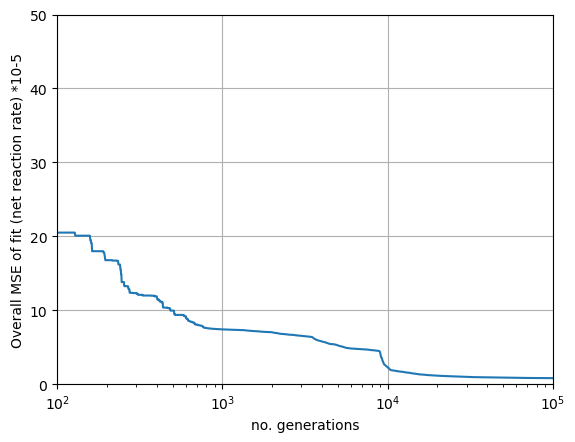

In [35]:
plt.plot(np.arange(len(f_min_log)), f_min_log)
#plt.yscale("log")
plt.xscale("log")
plt.xlabel("no. generations")
plt.ylabel("Overall MSE of fit (net reaction rate) *10-5")

plt.xlim([1e2, 1e5])
plt.ylim([0, 50])

plt.grid()
plt.show()

In [36]:
for i in range(len (res.X)):
    print (res.X[i])

-11.347142033754228
1.4955121339874096
0.8080792441980318
-4.333922444809668
0.5026357215865909
1.3302923178271814e-06
0.39216116474800106
-10.932767082029486
1.0656648347692288
9.292484638203822
7.391874920685608
7.274482779954551
0.806367887384817
0.0486324547061836
3.2791619661702343
0.008433556744380578
0.12264225366843065
-11.999986425325284
1.903060238700188
1.6215144917674011
-11.080545825415156
1.1398730599498506
3.810517169230528
0.011726236490676441
3.981272365551012
4.596220736051681
1.854455725044129
10.120276411779907
-11.459844875307102
3.1749011955876965
1.836777647107202
4.013392361543301
-4.051025231325936
0.5097079862230888
1.0073669627193227
-1.3010299728805257


In [37]:
res.X

array([-1.13471420e+01,  1.49551213e+00,  8.08079244e-01, -4.33392244e+00,
        5.02635722e-01,  1.33029232e-06,  3.92161165e-01, -1.09327671e+01,
        1.06566483e+00,  9.29248464e+00,  7.39187492e+00,  7.27448278e+00,
        8.06367887e-01,  4.86324547e-02,  3.27916197e+00,  8.43355674e-03,
        1.22642254e-01, -1.19999864e+01,  1.90306024e+00,  1.62151449e+00,
       -1.10805458e+01,  1.13987306e+00,  3.81051717e+00,  1.17262365e-02,
        3.98127237e+00,  4.59622074e+00,  1.85445573e+00,  1.01202764e+01,
       -1.14598449e+01,  3.17490120e+00,  1.83677765e+00,  4.01339236e+00,
       -4.05102523e+00,  5.09707986e-01,  1.00736696e+00, -1.30102997e+00])

In [38]:
logkr = [ 
    -12.0, 1.6,   0.9,
    -4.3,  0.5, 0.003, 0.4,
    -7.9,  0.7,   7.2, 5.7, 5.7,
     0.8, 0.03,   3.1, 6*(10**-9), 0.1,
    -12.0, 1.9, 1.6,
    -11.6, 1.2, 4.0, 0.01, 4.2,
    5.4, 2.2, 11.8,
    -12.0, 3.3, 1.8, 4.2,
    -4.0, 0.5, 1.0]

for i in range(len (logkr)):
    print (logkr[i])

-12.0
1.6
0.9
-4.3
0.5
0.003
0.4
-7.9
0.7
7.2
5.7
5.7
0.8
0.03
3.1
6.000000000000001e-09
0.1
-12.0
1.9
1.6
-11.6
1.2
4.0
0.01
4.2
5.4
2.2
11.8
-12.0
3.3
1.8
4.2
-4.0
0.5
1.0


In [39]:
# average of true log kr values excluding Vin

y_mean = np.mean(logkr)

resX=np.ndarray.tolist(res.X)
del resX[-1]

RSS = 0 # initiate residual sum of square
TSS = 0 # intiate total sum of square
for y,y_hat in zip(logkr,resX):
    print( str(y) + ': ' + str (y_hat) ) 
    RSS = RSS + (y - y_hat)**2
    TSS = TSS + (y - y_mean)**2

# coeff of determination for y = y_hat
R2= 1 -(RSS/TSS)
print ('coeff fit: ' +str(R2) )
print ('r: ' + str(R2**(0.5)) )

-12.0: -11.347142033754228
1.6: 1.4955121339874096
0.9: 0.8080792441980318
-4.3: -4.333922444809668
0.5: 0.5026357215865909
0.003: 1.3302923178271814e-06
0.4: 0.39216116474800106
-7.9: -10.932767082029486
0.7: 1.0656648347692288
7.2: 9.292484638203822
5.7: 7.391874920685608
5.7: 7.274482779954551
0.8: 0.806367887384817
0.03: 0.0486324547061836
3.1: 3.2791619661702343
6.000000000000001e-09: 0.008433556744380578
0.1: 0.12264225366843065
-12.0: -11.999986425325284
1.9: 1.903060238700188
1.6: 1.6215144917674011
-11.6: -11.080545825415156
1.2: 1.1398730599498506
4.0: 3.810517169230528
0.01: 0.011726236490676441
4.2: 3.981272365551012
5.4: 4.596220736051681
2.2: 1.854455725044129
11.8: 10.120276411779907
-12.0: -11.459844875307102
3.3: 3.1749011955876965
1.8: 1.836777647107202
4.2: 4.013392361543301
-4.0: -4.051025231325936
0.5: 0.5097079862230888
1.0: 1.0073669627193227
coeff fit: 0.9771221907529866
r: 0.9884949118498216
